# SAR to RGB image translation using CycleGAN

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Export training data](#Export-training-data)
* [Train the model](#Train-the-model)
 * [Prepare data](#Prepare-data)
 * [Visualize training data](#Visualize-training-data)
 * [Load model architecture](#Load-model-architecture)
 * [Find an optimal learning rate](#Find-an-optimal-learning-rate)
 * [Fit the model](#Fit-the-model)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
 * [Save the model](#Save-the-model)
* [Model inference](#Model-inference)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction

The ability of SAR data to let us see through clouds make it more valuable specially in cloudy areas and bad weather. This is the time when earth observation can reap maximum benefits, but optical sensors prevent us doing that. Now a days a lot of organizations are investing in SAR data making it more available to users than before. The only disadvantage of SAR data is the unavailability of labelled data as it is more difficult for users to understand and label SAR data than optical imagery.

In this sample notebook, we will see how we can make use of benefits of SAR and optical imagery to perform all season earth observation. We will train a deep learning model to translate SAR imagery to RGB imagery, thereby making optical data (translated) available even in extreme weather days and cloudy areas. 

## Necessary imports

In [1]:
import os, zipfile
from pathlib import Path

from arcgis.gis import GIS
from arcgis.learn import prepare_data, CycleGAN

## Connect to your GIS

In [2]:
# Connect to GIS
gis = GIS('home') 

## Export training data 

For this usecase, we have SAR imagery from Capella Space and world imagery in the form of RGB tiles near Rotterdam city in the Netherlands. We have exported that data in a new “Export_Tiles” metadata format available in the [`Export Training Data For Deep Learning`](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool. This `Export Training Data For Deep Learning` tool available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) as well as [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server).

- `Input Raster`: SAR imagery tile
- `Tile Size X & Tile Size Y`: 256
- `Stride X & Stride Y`: 128
- `Meta Data Format`: 'Export_Tiles' as we are training a `CycleGAN` model.
- `Environments`: Set optimum `Cell Size`, `Processing Extent`.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAsUAAAK4CAYAAACcd4AHAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P0HVFzbmh6K9njvjXGf77V93ba73cH2s9vXr7tvu21393O72919Tp98zk7SVs4ZIZKESJJIAiGUySCQQBEJBAhJBIEQQSJHkXPOuaCgElUFfO//V1WhApWQtMXR2efsOTW+IWqtGf4Z1je/Odecc/1WV1cXVGo1NHNzAgICAgJrjLVyluIWEBAQEPh4KFUqiWeFKBYQEBD4JWKtnKW4BQQEBAQ+HkIUCwgIfCcwp9VCp9evCkvhzMFxMN52z9J1E9bKWYpbQEBA4DcBn4KnV+NqIYo/NbRzmNdrMa+zcE9AQOCXAv38PJpbWuDq6goPD4834O7ujjN+fhbDmmNaLodCqYRWp1t2nUnWdM/8ujnWylmKW2BtMafTYpF4Wkt8bem+gIDA2oMFb//AAE6eOAFPT8+3grl2NWErn5nBrELxBk9rKczM7Kx0723hP1gUz8/ryPsKzJPytuBXYAWYYBUq1PdOo25cDbUlPwICAmuO+YUF1NXXY//+/Thy5MgbsLa2hqOTk8WwJnAcLJyvRkZKpGyaseDrDY2NkuB+8eIFFokVV4ZlrJWzFLc55qgjeIOjoYXegl8By5ianEVp3wwGFdyRWvYjICCwtmBO7e7pwcGDBy3ytAmyqam3ilp2ERERuHDxIkbHx6E38jRPjPT298P79GnExcdL/laGZby/KNYTsS5o0doyinPZQziXa8D57GE8aJnBjBDG74SWylDVM4K/9SzFX6RMYWZOlJmAwKcAC1eeKXZ2doaLiwtcTP+b/f2umWIm7Ly8PBx3dMT16GiJmNmxIHb38MCFCxfQ19cHHZGvpfBr5SzFLYE6iXn6px2TIezlEC7kDeGiEYFFMvSQH8E374ZWp0VZegP+yal6hHZRv6e37E9AQGBtYZop5gkG5uqVYJ7mt3qrzRSz+C2vqJDiCAwMxPDIiMSbPb29OHv2rDTT3NjUJPmzFP79RDGRBEYmYBXXifW3OuHzgsQwC2IiW4/kDvzsahfy5DosihH1quBKVE/PIrVyGI+7lVBZ8CMgILD2MM3mhoaEoKqqCnV1daiprZXAf+fn5+PSpUtQazQWw5vApM2zwcePH8eNmzdRXFIikez58+fR19//VqJlrJWzFLfE0UoF7r/sw88iW2H3bABnswfhRziX14efn23AmTY19IKj34k5KqOhnnFElo+jbkorykxA4BOB+ZXFa0BAAMrLyyV+rq6pkcB/FxcX4+LFi6vOFDOYhyuJ511JRIeGhUkimSctPEhQNzU3r8rT7xbFehK7JIh3hdfhRykTqBpVk3ez13I6NboGZzC04jUTr93QEVEzLL1+YuIx3ZdgwY9OZ/DHmTf3t2y2g+OR/BhG+FIYs/vmdvA9rdk9c7z2Q1iRxrI46J55OCn9pbDvEY6uAXppyYm5Py4j8zJ5d5lxuNdhV/oVEPhNAwvWt4nWd4lZFsVMkmHh4dCQX17iwNcY/Pfg4CC8vb3fuYRMImLCSxLRXl5eOHr0KEJDQ6VXfqsRLWOt3BtxM6eoVXiU3oo/vdaNqGYFtItmHA0txoblaJ7ULOOnlby6LE4G88sS3xiwjHsJfF/iH8Jrf8t50OCPQP+b0lzGw8vCEizZQljZZ5jz3rK8EFamvyysefz0t3keTeG0vEyQynBp74cU3pCv17xu+L0UlxFv9FfGtPn/lX4FBH5Twc/BSljyZw4WxW3t7bhEwpf3Z0g8vbgogf+elMng4+ODicnJd8bHcVWQGPbz84ODg4Mkpnli5F08vboopkShkuP8rQb8bxH96FfS75WvkuhB15ttSGBDF8jP6MQsGodm0TCswJByDgsmciHoSRDqlCo0830jOuWa5WuT6X7PpBKz6jlMTikkPxxft0yNOTN/KoUKvVNqKFQa9I7OoGFUiRkN2UEkxLYOTSgMdhCaxpSYniP7zGyR/Oko7JjRXkLbhAozlK4pL+OTprzMYoDEvyk8k6meCrBtxBj/iBLjSup4uEzo3vS0Ak3GOFspTiWnRx3ysEyJwRljJ06/R+j3qGoOs3KDrY1DCgzOagxEarRT6nyofrpGX5fr2Kwao9NKDJFfU34EBH4TwRsmWNR6khB1cnKSXo2ZwLO2AYGB6OWlC0SElsKz+K169QphYWGYnZ2V4jPd4797e3tx+vTpd4pihpbS4LhYFPNa5GvXrmF0bOytaZuwVm5lvPPEX42VXfhtn2ZcJEHMQnjl4J+5xHzGkzlYrVCidUSBZkIXcSjzlimciRcHiD/5fgvxTQtxmIKuz5u4nrhrgvmHOFGvUktxtRDaxlSQc1xm/kanVJgkTpUTlzeRH4n/6D7boSUONYVldM/MYdG8LyDMG+01+WkZpX7FyHs67n8ojk661kx2tk+SnXzdmL6e+HqK7ORwnJdO6kP4LR3ncV6jRu+44Xoz9R0jFCeXg5r6nz6ZCtNSP8D9jBoDlAeOd4T8N1E6bePUT1AfYS6yuS+clSupTzDaSX5UVDb9FFaKy+hPQOA3EcyBPKPr4+srLXdwc3NbghP9vnjpEto7Ot7KlXyd7/Nbu6mpqTd4emRk5INEcWtbm/QWz8rKCkFBQav2ESasKop1NFqWdY3iB/51OF4zAw098O96qPXzahSWDmNLWAO+F9WG74fU438+GEGLnO4ReWhJZA73yRCe0II/CW3FD9hPZCP+XXgPcrtnMTtvICtVYy/+pU89nHLH4ZHYjh9EtOIfwsmfdxvihpU0kmcy0qK/tBP/6kI7LhYMYn9MC35wbxAtJJA1lJeK0j78NLIZf0dhfxjVgv8W3Iz9aePoUxPxEVGyLbOzShS97MZfh7fgHyLb8IOwJvzXmB5kDpJIhxpllSPYGd6Af4hqxz9SXv7y3hDqpzSS6J0hgo9/1IL/K6QF/xjVir8M6kBUywx0Czr0t4/iyLVG/PcwipPi/R/RfWjnddkTMmwLqsY/ZkxDQZWjG5/CwaAa/M/7A7j8pAs/vNaGv73YiO/f6UX+JDcEInyyk8X/3cRW/MmVJnwvshXfj2jHkfvt+MvzNVifNwv1OxqIgMCvO5gUC4uKJCHMmy3s7Oyk/8/6+0vktxrZrZUo5nh4PRqvIb5y5QoePnworXO7dv06Ca/pVWch1sqtjFerUiLsZh3+691BdMzplkTr26BfmMPQkBxnbjbhL4kbvxfaiD+52omYNqWRo7VQEN9UFPTgb4gX/wf5+f7VZvy74FacyJ3EBPmZIz+YlsPlWi3+nNK9ndtLfshfVDP+rUcD9mWPY3yB+gvmvPFJbA9qxIaMEVxKasNfXO3AuWo5S3eM9U8hKqkF/4Hi/h6F//urjfjDiF686FZAwX0B2aul/4e6JnEhrgX/kf0R//1NcD2+yp4GFknwEg9ffdCG/xlGXB/ejD8LaYVnJfVXxIl6Qk/rCA5ENeCPqb/hvuBvbvahm+znTc/Zz9vx59Qv/C1d/7OgNriXTkJDlo1XdOGf+TUhuscwY9xJ/cy/8WnE8bwRON5uwd+QrX96ph72pVMY50kYk529MtiH1uCPyIbvk51/Fd4Oz4Rm/HP/ZtzspbiIyy3ViYDAbwqYT0tKSyUhbM7T/CauvqFhVZ5eK1HMPM0CmGeJfc+cwcPkZImzeVkGT2B84+UTi0QP5aXd+Ldn25AyrMICE4l0jwhRej2nN8LwmolfK9VXd+FPPJpxsYNnLOieahqOYfX4SeokZhf1UI9OYPvFWvwgeQTdWlN4JeLim/G7Z9vxRGaYJVA39eH/dK/GH0R0I3GYl2yQv8VZBEU34ncudyFjUiMdmTNE5PX/PFGLn6UMY0C7INmyqNUgN68Df0JEFNTOGTTYKBsYwc+86vBlziTkVMCYUyE+pRV/fLkN9yURTP4W1Gjsn0a7TIvOph78l1NNON0yS/fmqTeSw+NqPf7u4QQUmMOztDb8M/82vJii8qCw0+MKdE8qqVDlOHyuGn/9aAwzHI7S7u6ewigJXBbFO0Nq8KPM16LYNrwav3W6CSGtnE/KAzWGg1eq8fepE5ikTg4aFe4/IRK+0o64IaOdZPtNEuS/7VKJLflCFAv85oNJkImR1/GecnfH4cOHcYYIb7WZBxNMoph3JbOAYbewuCiB3dDQ0DtFMafPpM4bPUxriDk0b75zPH4c0dHRElmbE7k51sqZx8mzmIqZCXztW4+NeTIsLpq/XTLnaD3xKvmna0rZBA5cqsf3Ho1iSrqnwXMSh38U1IOSWbJTq0JiGvHixTbc7jdyLwnYvtYB/I8TddhXPg0NLy8gUXzyRj1+i0TwhoIpKgv2N4fmml78sWs99lTKqfMhfxOT2B3WgP/H+Sbc6+dy0GGBrqvGxrGL+oLvJw6TmOewbK+xL/Brx2PqC0jVYnpwFJ/71eLL9HEMUj2zPfOKaWR0qKBXzuBsTAP+PHoArVoOr0Xzq17814vtiB1QYU45jb1nq/HTtHGK2cDFHV1TmCY7XxX34D/4NOFWryGPPMPbPjxDvKzDWGWXJGRjWMhSX9ddRr9PvcIf3+xH7azBhq6KTvyhdwOudBreciopPzspPz98OGLMD7XJwXF8ceEV/g+K63YfxSVEscB3AMzHZeXl0n4L5ml+q/Y+SxdMovjy5ctQKpX0DC3naZlMBl9f31VFMfNeV3e3NFniYdxUx66ishIuvPkuKAiDxPdv4+lVRTHPlL7M78S/PN+F/DE1cQNdJ0MWVDO4kdGNz6Pb8cWNdmx5NIDcEQ0WFmZx4nId/uvDcQpLpEBEwYTSkd+Gf3WlEy9mdagg8v3X59pQqNQubczjzM1NE3mcrcfOl1NEW0Qmjb34F6frcbySCoaInv3xK0DFyDh+crEB9uVyko86DJV14v/t14zgDrJ3gUmfMjU1jUOXavFF1iTlgGIz5WdRjYxnbfj9y92oIvKXD43j87N1OEwkryc7Ta8O53l2Y1EB35A6/Of7o2Z50WO4pAO/faEdWXIN0kio/kvfTlRo6B6RneEVpRYqhQzbTtdKa7CJtrFA+ZSWmHAnZUEUWwXV4H89NQh1nTTgUCD2YQv+VVgf+lTcKYzjM7LTpoI6GaOdcwt66AeoLIhw178QoljguwHmCibWvBcvpFkAFqkseC35NQf74c0aLGgfPXqElNRUpKSkGEB/37t3DydOnFh1bTLH4U9EyzuY+wYGlgieiZw339nb20trjZm+V4ZlrJUzj5NF8cz0KL7v2YDdpTPEgQYemNdq0NoyhJ0x7fjydic23evChXqeqJhDfm4nfs+/AxUzxDUkIqUB/8gYvn+uDscaVJgensAG/1pYlxIvEn8y36glXlLhblIzfi+0D+3MeSSK3a7X4fduDKNfbVpGQNfn1biX2ITfv9qPEePbsV2hNfi/Hk5CxVzP9i3OoZC52L8NBSv7AvkEviK+2/aCT/eYQ0ZyM3F2F+pI9C5t5iZ/fK+tcQB/eroZt3pMe12Iq2flsAurw+c5UxiTT2KdZy3WZ8kolySmjVzMA4GXL6kcPFrxaIJELfUxbD+/AeTJndEVorirtBO/69uIoF4W6oby0Cmo//Cpx1cv5JItUn6obzPlh4/c5LeGbS9b8c/OkY1CFAt8R2Di6aKiIvj6+Ehre98liBnMpZ2kRXmWmXk6PT0daWlpEvjvxMRE6c3caqKY+Tfy2jWJz1taWpbS5f95k7WjoyMSKB52K8My3imK8ws78TvurXgwqJI+OsHXtRreXCdHWfc0Ep+zMGxBVDcRi3wUP/GpxT8924i/DG7Gfwsy4P8mgv03ge3ImFThdmwTfjtqAFMUj2lGg4ldQ4Z4k1j8+8QRjBJ5aUkU/65fA4I6iEhYjHO6RFhK2QzsrtRgU/YEZogEB4msfi+gA9nTBsLkDR1jI8P4n56NcHw1u9RJMPQkJFsre/GfPZtwb0qFjrY+/A2RWGwfEao5WVFhL0yNYR3Z/b+fobwY88H4L9Rx/OtLLbg/NA919zD+isj7D881YmP6GMYobYnw52gwkUlE6FGL/xjcgdhuBZRMtm8RxQeDavF1rgxTRPpa7lSgROJjCh9IolitQVd7P/6zdzNC22iAQOJcspE7m9EJfBFQg3Vi+YTAdwj8HDFxjU9MvJUYV4LJlmd2Wfw+SEhAwgrEP3ggvWKzFNYETouPC+J0OT7z6/w/33vX+Zlr4czjlESxfAw/OlmHdc+poyCRyxzEQlYmm0VRhxwlDQP4W59q/GMWiTe9AjE04P7fTtThz4jP/oJ4+r8T/iqgAf/coxqHypXo7hjAH3s1I7CVRLQ5f5I4fJXfiX/r1YI03l8iNyyf+OvHkxhXE3cxj5M/HfFsaVYr/vBsJwolUTyJ7cEN2EeiXUU8OCdxnAJXbxv6Aplx+YGUDsUxp1LiDIno//VgFDLyd46Xrz2ZhMbYD5jAm7xfFnTgX7jU4o+uUB5CjHkJbMTveL7Cj5/KMKPSID2lBf8vjzr8+/BuPB5QSid18Drk+cFxrA+ok/qrf0wkYU9xSmVH9y2J4j/wa8b9MR5wcPqUD80ENpMo/hEv4yDOjrxD+Ymk/BjjYRuXBLYQxQLfMTAPMk/zcgXT75V+VoK5fWx8HLHE08zJlsBnDK/28Q2+zjPBQ8PD0v6PZfcofubpkdFRKS3zeyasKop5TfFoxzD+zrsOTo2zpLQNhCvdI+Jgwuyq7cIf+bcipodE8fQofuRXhw0v5VAq1RifVWNihqBQEznNYWFxViKOfxE1+N6iOLCd0jETxQqZHIcv1GCjmSj+/YBO5BqPhHtfUXyfBHpNRSf+3fkOPOSlExZE8ZckgH+WPQUl2b+UF/pfTkSrJCLnjkdJf99/2Iw/InH82xfbcLNDiQUqJ56NGOgax76IBvz70zX4g7vDmOTXe28RxV/lyCAzE8UJj1rxz4MMorijtRf/wbsVUZ0rRPHYJL4UoljgOwgmvreR2mownWDxNlgKYw4Ww5bSZXv43mrEv1ZuWbySiFTh0tVa/EXsEHpJwPGbKb7HezN4mQJmxrHlEnMZiWKdAlEJTfi3JN6qx1XEaSqMyBkGblMTf3byIJyEb2Ar8c0KUVxtFMWp5qL40STGzEQx+yvIaMXv+3WgwEwUHyw3F8WziCBRLPUFb4hiFfxIFP9twiimdFM4RML1755OGd5UmvwRWBTn5rXhDy514lGfCtMKU15owGTkacke4uLOllFsCKnHv/KuxX+KH5HOiNfRPSXV+dOnbfiPxN//u38TPKtnJBG8cvkEi+LfP9OMu6Nmolg9gU0kin+cw6JYgZCblJ/oIWkznslGFsXjVUIUC3w38TE8zXrUEt6HpzlN84kLc7yNw01YVRRLr6gUszh3twG/HdaLesXyh5p39bbVdOE/sSjmmWIiOrcrdfjzxDGSq7wUwOCPxSyLOd7gUfCMl0+0v7F8QsvLJ0hQ7zBfPuFbjxP1FK+RmPVEsOOdg/gvvg04QeTFyycGjKI4x0wUr7p8IrMN/+ZyF6oUGgx2D+MvvOrhXk/imYhPImayRepIePlEaD3+870REH0uxWHKC//Na6z5WJ55EtvzE9PSOuDvpU9gTKOXbOZ8UYGhh2z8N971CGZSnPwwUdxLg4mBriH8d7LTq2EWCwsGO3Vkr7JnFN/3rxbLJwQEfg2wVm5lvCyCG0q78a/PNOJ8E6/DIz413WcOIm5lUfxzaUZTg7zcTvyufwdKZ8gm4nOelGCuWiDO4lMeJgfHsY6Xa/GyMuI+Q1zMSyrcT2rG7wb3opWXT5Aodr1eh38XN4ZxFpnM55yedhb+MQ34g2sDGDYTxQeWRLFh+cRL4uLfp76gSEVpm/cFMxNYT33BplxePqFC2PUG/N61foxQR7a0iZDjxRxaGvvxx94sXqkj4/XUxrzME08ajkxjPqfr9Dcvf2vJb8e/8mlEVD/ZyX0S5Z8nf6BQ4mxkDf6UBhZtaj2mWMi+tyhmO9W4G9eMfxncg3YaIJj6i3kq09ps3nsiRLGAwK8DVhfFBP4K2/TwFI6H1+Iv7/bisbTRiwnJgK7yDvxTvxZc61RL5FFT2IbfOdmMs028xYzEIfmZJSF4jwQdE5XSuNHuR4+Wb7S7/6AZfxjYhZxJIhIiK95o909OVeN3r/WibJrTIn+zMjiF1uF3r/ehhgidRSmfPmEuipms5uc0yMnrwJ/S6DykgzNosEPWP4KfnG3ArpcyKIlg9Soa3d9rwL8/34540wY2rQpFbTLUyObQUdGJ3zvRBI9aOXUzhjjmpmW4U8ez5ioUdMohU3BnMU8dDwnxKzX4KQnxEY0C2S3GjYZ0b7yyC//SsxE3xikfHySKe9FN8bOdQbH1+P9c6MJz7sg4XqUC/rcb8E8cq7C1QIhiAYFvO9bKrYxXEpIqNRKetErLIU7VzkqDZgNHEzfJxvCD8zX4HnHOIg3gFQOj+IVfLX7wcAR9kh/iE70CCfVTGJudw6KG+Jji+pMrZrxI/gbbBvE/fRtgWy43iNJpOU7xRjv3RvjWmfhOg6rCLvw7rwZ4NSqIJ8mfBVHMs9i8P2TzhVr89PEoenSGNFgEJz5swR9c6UTmOKVN4Xvb+vEXbjXY9HwCI/PsjychZIjtVGF+ahrHqE/4MxLNryTupPsLKmS3ytA8zkd1ziC3nQcKhrIYLuMJimbET6jRNChHt8yYvzklQq7X4r/fH5b6JdkHi2I9RnqH8H33GnyRPmncwDiP0c4h/L232GgnIPDrgneKYgaPpGfHp3GvpBs/JKHJx4b9Y1QbfhDVir86V4c/vz+ITtWcdJyPngRhfE4n/sy9Hn973XAc2Y+iuhA7pJJmA/h4MT62xvtGA/4krA0/pHj+MbIRf3d3EC8HlJQWiTsiTD6S7XfO1GPH4yFY3WjBDymefyBi/cPoAdSOqaURPr+a6i/pwO9c7kC22Rf1eFaAj2R7mdeNvwtpwt9f5XRa8P+jOJxfyDCm0Uiv+nQUh3xGiZgHrfjTgCbpCLkfUqfyi4RBVMh5xkOBRwXd+POT9fgbzgvnmY8uGuBCm0VEUjv+PqAFP6Dy+LuQVmx7NIRmxRwR8Ri2+DVK1znMfw1uR1jdNGTcURGZ85Fs3zc7km1fQA0+z14uiuOTW/BPAnrRSZ0UDxJmZ+Q4H92M/xLUJJX992524Vx6D/7hQg02iJliAYFvPdbKWYqb32Dx2e8lzQPYGtqKH15tx0+uE6I78LOQBvyzc224R7zFx1jOa9Vo7hnGT92Ju4kTfxrdjh8SF9uXEAdpDLyomFXicVo7/ntoC75/rR0/vd6Kv45sh1fhFKYkHieeIlHsGl2H/xjdB7d4SofS+0VUM34noBXeJVNQUTymI9m2BdZjX6l8SRRLNs/Pob9rEqeiG/D/jWiXwv/kehP+180BZPUqpPvsT7+gxqvqUWwLqMX/fZXSIXt/FNgE5wYSu3oNhsbGsfsC9SdBrfixMS97no1KfZJcPor1Z5qk65zP/0ZcHF4nh5rE96PcbvzjhRb8JKYd/xBB5XC7D4UTKswtaDFW0Yl/SuGum45kK+nE7/k04fbIa1GsIVG83qsOP35OophnnRc0aGgaxjq/Ovwlp0f8/0V8P4KSWvB/nmsRolhA4NcA7yWKGUyCi0RA/cOzqDd+kIL/bxxRYFj60ITBH88A6Il0+4wftGA/zaMqIsjXoo3XJquIdPnDFnyf0Udiko/fkfwYRfHvnm1AUJsWkxPkZ9DwwYpePjLILC4+v7dnUmX4YIfxGkNaT6fVYGCcwlFYDs8f71Bwp2C0lcEbLnSU7y6TveSvZ1pNIpPikPxSns3y0jRiyMscxT01pZQ+QMLX2bZR/kgJ26ZRY2DUcJ3ROE5Ey+mwXSTIh2UKDJg+3qHWYGTS8DEP3q0s2U5pT8mV6KJ88dplk518oHw7lz+XxYQa2pFJrCdB/fVLIYoFBL7tWCtnKW4G8xUfyTZBnFfdN4NX/UYMzKCZOOj1RjVeUjCH8XEFaox+KvtmMUYiUtrfQX5YZC8Sj/ERZVV0v4riqyP+5A3D0kdA6H/TOcV//USGgQklaikd9lszRhxJ900fteCPDvVTWvxBIpOtJvBJPyq5AtVGOzh8J3EhH7f52p9hCcTk5OzrPA0qpI+BSHFQXvijIHXGe5yXfjmfRU+cSXnoHjTEy/dqqC9iLuY8TE8r0UDX+F5l/yy6KIy01ILi5P6pbUyBCWOZ8CChnX5zmq/7GernRqlPonCG9dTUX0jlarCTy6xZpsFYVReJ4mbc6ReiWEDg2473FsUmSMeOrYD5F30s+bP0OUwm8LfGQb+lmWK/BlwmUSyNwi35Y9Dvt31uk/EuOxhMesv8rUjjbXGsDGfaaMLgTsV0nddem6fLM9zmafBv87AMKW6zayy2DWuYDeDXgbK2Qfz5mRbEDKqka+bhBQQEvl1YK2cpbnMs5x7LHMQw5y7GSg7i9cEr/SzFQX+bRPFfJRv2UTA/Sf4oHktpmfaYrMSqfYEZmCfN/S2tm7Z0zyyO5Xl4bRtzrHmYZeka4zPFY7LRPE2GlC9TOPLDZ+ybp8frnrMeN+M/hfWjY4GurQgvICDw7cIHi+JPAiKTZaKYiMyiv+8I+LVocecUGuTcsRrW1OlmZTge3IA/ix1Cn3HpiqWwAgIC3w6slbMU9ycHCz4zUTxqdvrEdxIkiHUTciR0K6BfNHC0dI5yywD+x8kG7H81853vxwQEfh3w7RXF9T34P7zrcK5ViGJe2xyT0YG/CW7Drvhu7IrrxE+jWvCzW4OomtZIrwMthRMQEPj2YK2cpbg/OSRRPA2XiBr8eeI4RkgUv22G9zsBniWeHMWPAluxI64b+xK6cSipHX98pQ0e2TRo4NOILIUTEBD4VuHbKYoZcgVKeuTonZl745XVdw18zNyUbBYFTZNIb5IhvXESGW1UNkrqaIUgFhD4tcBaOUtx/yqgp/6iuXcaJUMqKFbs6fguYk6nRkeHDA9rJ/CwjkD/p/QopE9ii2UTAgK/Hvj2imIeefMaWrEsQIK08WV+OcSSCQGBXx+slbMU968ExD/8YYwFPmXC0v3vHIiTqTx4D8wS6LcoGwGBXx98e0WxgICAwG8Q1spZiltAQEBA4OMhRLGAgIDAJ8BaOUtxCwgICAh8PIQoFhAQEPgEWCtnKW4BAQEBgY+HEMUCAgICnwBr5SzFLSAgICDw8RCiWEBAQOATYK2cpbgFBAQEBD4eQhQLCAgIfAKslbMUt4CAgIDAx0OIYgEBAYFPgLVyluIWEBAQEPh4CFEsICAg8AmwVs5S3AICAgICH48lUdzZ2YlZhQJzWvGFNAEBAYG1xlo5S3ELCAgICHw85DMzEs/+Vl9fn0EUW/AkICAgIPBxWCtnKW4BAQEBgY/HtBDFAgICAr98rJWzFLeAgICAwMdDiGIBAQGBT4C1cpbiFhAQEBD4eAhRLCAgIPAJsFbOUtwCAgICAh+PjxbFvDFPp9dDPz8P/cKC4X+CVqez6F9AQEDg1wXMb8xlJl4zcRxf+9BNyWvlLMW9Gkx5YJ42cTX//03yICAgIPBthInjJH77CI77KFHMiWs0GgwODaGltRUNDQ1oamoCH+82NTW11HlYCisgICDwbYZJRI6Nj6OtvR0NjY0Sx7V3dEjXTCRsKawlrJWzFPfbYLJxanoazPEdZDujp6cH4xMTUoch8biFsAICAgLfdkgcRxw2LZejr79f4rd24uvu3t4ljvsQnv5GopgTmV9YkDqKO3fuIDQ0FOHh4QgjRERESH/z/8+zs6U4BekKCAj8OmFhcREjo6NIfvQIYWFhS5C4zch1SQ8fYnhkBPPvyW9r5SzFbQnMu9xRZBMPR0VFIZTsDw4JkWDi6uTkZPQPDEh8LmaNBQQEfp3AvCVxXE4Orl27JmnR4OBgBBGYr69GRuIh8fQAcxzx4ftw3AeLYlblfLjxs2fPcPbsWSQkJKC+oUGaLebZk9GxMXR1d6OgoGDJsO6eng9S6gICAgK/CphmFV5VV+PixYu4dv06Kisr0Uv8yPzGMw88G1H16hVibtzAhQsXUFFe/l5vxNbKWYp7JTgPPKPNIp5FcG5envSbeZqFPHNyGdl94+ZNnKc8lJSUSOGEMBYQEPh1AHNcR2enpDGDgoKQ9+KFNFHLHMcTGsxx5cRxN2/dkni6qKgIc+/B0x8kipn4+TUcJ3L58mXpdSJf51kVVuwMNpRnKPhv2dSUNNPi4+uLyqqqbzxjPKfTS9PjHH4JlM6c1rL/TwsttGSL9m22aPn15QrbzfLw1nDvgFqtgkKlhtrCvbfBEEb1QWG+EYzCYmV+dbpv0uG+o3zfC4Y41sae1cEP3cp0DPX8bREbhrr5uPL85eCTtc+3gAUh819WVpbEWfn5+ZiZncU88RuvJVYoldJXP7lOmfPY1sLCQpw5cwaPHz+WytVSvCaslbMUtzmYp0tKS+FLeXiSkoJJmcwiR/M1zg/79ff3R1JSkjTh8c2EsWHd8pv4lrR74uG5VWyZo/uW7Sd8xLP7Tcrykw1MKB1L+f2m9c/c9yHLL9/AW+2x4PcjwXm0mJYFv78aGOz7dmicN/HJ2uhbwGVTUVlp4LgnTzAxOSnxGfOayc8yjqNB/7lz5xAXF/dO2z9IFHNkKUSyPEXNRnCibBzfY2U+MDgoxWHyb6hUrTQjcZZIt7+/f5nR74O5ORVkY0PoaGtFc3MzmiQ0obG1B+MzKulBshTuk0E7i9G+fkzMsq3L73HeZ2VDaG9tRGNTM5pb2tDR1YW21hZp7XVTaxsGZKoPEyhE3otqGV5GHMGWk9fROgXM6yz4WwEdpdHz2BvrrU4hfwBY1Fv29/EgclRMob+vC60tpvoiNLWgY3QWi9TY2BbLYS1Ap8BYfx/GZjTfkLDIHjXV0VAvWrncjfY0NjWic3ASSo1BCFkO+2GYm9NQfQ+jvaPtdVulem5s78GEap4Lfc3S+magZ0U1jcG+XirPN9vrrxI6rQbtSe5Yb+2N4iFg4ZfWPt8O5qaamhpJILa2tUm/+RmWnmPiNZ515RkH0+fw+TpzHM8cc5hSEper8dtaOUtxm8CCl2dIfHx8pNlsts8EzgO/yePXjSb/fJ3DMHdzp1FAIv9d4t4S1KoZjA4P03Pfi95eA3p6+zA4Jof6V8zRLCwUM1OYkMmh4mfgDT8aTI32kb0Gu/sHhzA8PIg+/k1l2TcyAYX6A58XPTFdfwE8bbfi3NOB95qh0uiII6Y7cNtnLxyi8jGhxi918Komnh4aGkS/Md9SnfUNYkJJfczCh3GVWjOLyfEJzKi/KZ9SONUsxsdGlrUhLv+RKaV033K4D8fcnBoz0xMYHOg31LExnd6hcSi0C1iY/xbsg6I+a5yfVeW3jafn0Jfuj622Xijo/9XwNHMWP6t+fn4oKytb0qHMx2qNBvEPHkj3eDLAxN/MaaxRz58/j5ycnFV5+r1FMSfKnfwZSow7DJ5x4OucGAsADw8PBAQESFPXbIQpHP/NnUhcfDxuxMRIsy3m91eFVg/MDSEt+Cg2bj6ME54+8Pb2gpenO06cvYGynknM/UobsB5q2Ut479iD+3X6NxqIlspouCYdwWfd4OHljZPO1tjw2ZfYZ+8Kr9Ne8PS7iCe1NMKZ/4AHnspuXjOD+owoXI7NQv/MwnuJTCbXkdJ4nL8ai4bxhfcS0t8IVGWLbak4vH0T9jm6U315w4vy7uV9FDvtL+B5YSWGlSTk34fstfPQqapwce92RBUrof8mNusXgIk6BLvsxtcHjsHT+zTZ4wX3k264mlJFYnVhjToeqpc5JRri3PGzr/fAWWqr3jjt7Q4H52PwuHAX1b2TUsf3KyM5HbWVoRy47diCa2WqX14b+AbQkigeKL6H85HxaJ5Y+GZ1/RFgTuLlEZcuXZJI08RvDCbQ7u5unD59Go6OjhKHmYdlbiwsKpKWWzD/vY1w18pZipvBeWAODwkNxcPk5CVxy9dniOhv3boFF2dnFFtYKsE285IRFtM8ecF5Mt17F/hN3kxLAqy+XIf99m5wc3WBi4szHJ1PICCuDPIPFFhrCx0WIEfxPS+c8EtC7ywNyle0rTmNCvm3T+K4kwtc3ZxgteNrfL5uF466uMDZ0QGeUanolmmpTX4AT9OztjhSjahLnrhVNEpl/T6imMhzph/p0b64klyNKTWv87bgbw3A9TuSdQmffbUFNk5ucKW8ulKd2TkegePZe2jqGYGSBOL7cCML/onOhzi5zwlZPd9wwoWyjo6nsNu9GTuPOEr2uBCcjjviZv4ADazWaPklawrlKLJCj+Lnm/bB0cWQdzeXo9hr74LQ25nonlRTG/kV6grq9+b6M+C0cyfuVGt/JcLzbeD2MFx4Cx6XrqF65P0m5NYapgmKhMREibdMPMZ8N0rCl1cxWFtbS8vEzHmM/66tq5Nmlzu7ut7K0+8tilmB8xrhlNTUpQ6DjeFOgNdzeJEAYHFsiUzZ2KHhYVykDofXeLzNmDcgieJhpAbawiUin6htuWOSovaz9Lcp3BwRErt5PV1jUYRFEo46GL1KboHvmadF4MG9udObdRpsC9+ep7wYYudYCYPUePccQHKH4dpK4pwzi3S2Nxsuuw7jbjm1JjO3uDAPyUzph0E0zS1dMDrjdY5TTQLMdJdn2Ph1s6Ec+BgS83CLy0hNZ7w6rzOEWSobszyxWymy5yhy86KZ1xt+S+Vr5k8Ci+L2NNjuPYqHXcx0JidHVdItOO76HGcf1EJGdWSwjcSk0YfJmQSRlhOZKoHn/p24WW2wcF5vaF86c4PIWbSFwXlkUexshwuZncvyaV6m3LEvu0e/tGbxzM1zgvx6xuRr+X2DKFagjjrfA16x6DOzTzPVgnue1thr44nsztlls0am9mtyb3TYJKLNs2qeT1Oda8l2cz9vFZQsiofz4L53J2LK3y6KtVJeX7tl8dFztLycVrQXY/vTG9sIlxm/fqb+VSpv3VL5saN7pnCEpfZpbNOGZ8fQPs0t+qj2+RYwb/FbMCZbHsSvFIx8WgMLxuPHj1sUxRyGRWdiUpJ0zTy8CWvlVsZrAr8q5M3NV65ckZa5mWxg23gPyLFjx/Do0SMDz1uwj/PBrxd5w4pJUL8P5ogb5U3xsN9nh8xeo5FGt8CC2PRs0d9L4ZiPpUqja2QLV/UCpamjvmWpLrm9rKzrFVy1SP7N+yx+Jvgab6p53SZmkB/tAsfLqRiTGtnyMIzXNK1F4VUnbHeIwZDxmunWa+4nHjDxkPT7tVvW5qgdGvJtvEblxHleoLB6qiuT45nJJXuoDiTWXDS8Omeu5+5scX552XCfsZJ/zLl/keLnMuC8WhK2vKxlKOMydtgFol5tCMNOp+xAvPcx7LM6hid1U5QH48CK7DIvd0pAqhtTXzRddxu2Vm7Il7o2vkd5JryN298A9xskiu33OeBBu8ro2+DMJ43mltUr33vN4VwGS/VPYLdoxvESJFE8gowAJxwLfw6Z5IvdPMbaihFovREH3K+hfmL50gWdWX1RAm+U6XK7qOzN2oFUf2QPL+Ezq6G3C0rKxFx/Jlx278HdmreLYp50M2tFy7UH1dfysqc2a24zNXipjZBNhjiMPC2VHz13hKW4Kb/mz+GcdIPSI7sMOsIQFz8T5m1kZV0zT7y2l2KQeHqR/jez+x1gXuJlbfzGzpzjTPf4TRjz3xEbmzdEsWlVAS8Ti46OfoPnTXgvUcwBebqaZ754nbA52cbHx8PV1VWafeDOg43g++Zgv0zYj588wb17995/3Ro3YEkU28Ep+DlG6Fkxb4w8+u58HoETZ4OR2zZLxGF4nTnVlgHf0wFIb5BB2ZyOKxfiUTcxgNRwZzi5nICb2wkkvJqmQjQVGB9LpEN5vA9c3dxw4gSPUq+ieHTG4Ida9QKN+q8HhiG9vhHJF11x3CcAESEBOON6EBu/Wo8DNMp08grHi9ZRekDenBnRUfxjrU9p9HcINwq6iXopTs00alKiEf7oBQpSb8LbzRnnbxdhemERI9WpuHzaES5kj/PxkwiJe4ERLYsmninmcNcRHF+I0TmKR6tCd+4dXLnzArWVzxBI4Zxo9O8fkoR2haFxcrkNFd7H+auP0angBq2DvPYJzocmorK5BrcuUBhnN3j4RqFqkkS6sZy15G9mohyRZIfrCYLreaTWFuHO+SA8bZx+c5abyU0SxfaIa6LyW3pQDd1HW84l7N7uhvSWafI4D7ViGs+j3eDkeoLK3Q0nTwWiYHCOHrI5dBYn46LzQWxa9xUJSmccd7+CtKp+iQxeJfoZ68qV6uosUhrGpM53mS2SPfSYSqLYFmdTGqGgulxZNyzYFEMNuHOZyoDah6vzCSqXZxikOtLRfW6r42UJuBiVhMLSLASdOgrXy4/Rp9TQPVM8r0XxPvebaFO+JgUmGmg7cNN5D/ZezMCsxtAJcufXU3ALPqec4OLsBI/AO6gZ0mDR2C5Z+Mva8hFxluvGFW6nzyOtgcptgcJTO+/OvYErUXloH6hCzDlD/Z067Y/cbuqMLREp5f1dopht6i+Ng7/ncWlW8dSlaJT3qamqOM15KCd68DDEyfgcucHTLxrVMmN7oedV0ZCOC8F3kV9djEgvBziejUO7bBqd2bcReK8AteVpuGJsn+fCH6GTnmlD+9SgLz8WF6JS0aM0tM+pV8m4EJaMV42Uv/PHpPwZ0ns9k6wlu6ZHSxBBHOTC7dPtAtKofd4+H4xnzfL3fgvDg35ePlBdU7M0aDfxF3ew/IrVJIpN/GUC+2V+45nWsNBQjBAZWxKVa+VWxstgO9guPlUiv6BgKX3+v6auDu7u7oiMjJSWTvA1c/tNeeD/eZKDZ1L6Bwffe7ZsSRTvtUVqOz3WZm2PB/eqwVrcD/dD6NNGKKntSxMMmkFkx4bB/34JVDNjeBkXjaSSfnRWxuPiGQ94eXog6G46eqh/MrVTfh7kPWW4GeBueOPj6YfrCRWSsOHnVDenRm9hIiKTclFemI4QX3ecCb+Pe6GesN+/BZt32+Ck1xlcvpWPCe6njDa+BguJGeSFOWKbXRS6eWkVtfmFkVrcibyBnNZ2pIV44sSZSOQ1DdOgfR7Vjy5Qv3ia2oY3Tp8OQU4Hly/3GRRurAGxUTF43iaTymFxugupt2OQUjeK6pQr5J/fep5HUnEXFHSf+WtxdgDZcTcQX9iBWcrwgnoSlSl3cCenFU1FcVLZeHr44npyCca4P5D4h8WnGp2ljxHg7gkvsudyxH3kVzzHrRup6Jik53rFZI0kijMvY7vNZVSZLcHjLhfzQ3jkfwg73e9jQM7tn4YVA/WIC3WHh5cPvL1OI+BaCjqJ4xYX5ah8eBXex/dh44atcDhxGt5X4tEwRlpCMYnsW95SGJ/Tp+F3/gZeTeiXizMTuN+QRLEdYuunJftW+uEeRNaWh8hL7lIePT3O4XZanTRZpuM+XDOL1pw4RKcWojz3IfWf7rh0pxCTVB9Ldc0ZNIpi++CnGKbH0iT4uKvQygpxbs8WOMZWU5lx+6d4Kf7OvCj4+XjBm9rlhdsZ6JumAY5RzPH9ieYshF+gdunpBd/A6yjuIWIj7pkjXmt9fgfXk16hp68UMZdPwsPTG/5BUagcZmH4On9LeA9RzGkOVSbiyll+VjxxNiIO9SPUb3KazNOTfUi97imVPb/hOh94H41yozCmMlC2PEfY9SSUNVbi9jk3uF9JQodMTs9PAiIflqK5NhdXL5yCh8dpBEano5t5msKyjhgtf4SQm0/RbdQRiqYshEanoLazBQmhFIbax9mLt1Bj6hfIXuYItaIB9874wpueFS+vQGQ2VSI5LAoZpNPedwKDuYs3Dr948WKJ48zvrSqKCcztfBBEYGCgtEnP0gTte4liTuzFy5e4evXqkiFMoLx5zs7OTpop5t3ZfLQP/28OniHmDoc7jSryz0cD8Q7ulcZaBDdgoyh2Ds0lIuOH0DAKnGfhSQ/O7HArQh02wCkoG+NEmvOabtxw3oUjF1IwpJnHREEEtn+1G0eJIJPL+iUbXyX5Yde+Q4irUUsjJb2+HbGnjuHwKepwe3vQ1z+Al7e9cGC/I1K7VIZZ3J5sHN97CHsdrXEnrwu9/f0YGBxCd9ld2O3Yjet5PZTfAUy+ZZ3zm6KYjCXCy488ic++3ga/2Keobx9APwnxeVUPkmk0k1NUL9nbQuTme/Br+MSVY5KnTzWTyA1xxIGzSejjvlanQkuCB773w5/DOTgR1R396G6tRfixdTga8Bi9KhqP0YPV9dAXm+0CUUd1vkDlN50fip/++Kc45BWClw1UNn09SPDZjv2uEaid4pEsN+RyXNy3D8cvPUIL2dJXmwbfIzvw83W7cL1oXBJoy/JKVWZZFHMHSQ/rWCMu7t+MswlVmCXTJ1qfIfjmc2kdWTeV39PAw9htcxZFozqo5TIM1iTDedc2BKa30cCsH2NyDTQjRQgg8dTZ1Y0esqkw1gf7d9viUavCMEOxzJ7Xovhceiu4uBa4/fBomGzjdjjenYYT2+xwJeEFOgeo7NqbEe26GQ7nH6BDYRjJDlMH8vPPtuNEyFUU1vejd3CMxK1ZOquIYgaTWEvKOezYfApF0xoqpGmUxF3Egb0+yKxrw0BvE1KunsBhj1tonaDWsahF76v7cNh6DDFZ5egd6MOrtAAcOnIaz1pmeHyNprgT+PyzPfAID8MLsqm/rxvPw22w3eEMCvosCONVRTGN8hdnUPU4CAd3eSLlVTMG+lqRGeOBQ26RRsJVo63yCa7H51O7pPrq7kKc91YcOBmFumnD7JyiOApffr4Txy+eR1Y1l9MoDZ4VqL9/Ev/wo1/AlYRwLbfPlmqEOKzD8ZB09Ku5farR+sALW4+GoZEGctw+J3MD8KMf/RTWPldR0ET566X0vLbg0KnraCCC5/apkpfg3O79cAlMQSu3z+oUeFttw8++3odbpSSXVrZPC+A2wOuCeVkNcyBf49lgOZEjg8VmW1ub1LmwKOa1aqZ7DPbLvMhcx2/T+IxMS2S7Vm5lvAxOn/mWjyMykb3UtsfHJX62d3BAXX29tESEOwtz8Fo73lDInM75Z57n9dHmS0hWw2tRbIf0TjJw0XC+swSyQatRovjuCWzd4oUiGbV9kjedeZE4uNMR8a8GoZvpR6wHiapdh3D5wVNU1rehofQ5rhzfBMerudJyqwUaJA/UJ8N1lyMiHuWgvrUFNaUvcNFmM7xuvwA1TyzqlGiK98Ev1u2EV9RtvKwkIdnRi/7WMtw9Z4PD7lF48aoNLV0jUBg76+WwIIp5QNuVCQey7ZCbHWIy6lHf1IahKRVUQwW4FGY4famxpR1PI1yw/9AJZPWqpdlB9Obg+O4DCC8Zxhz/HqvGZcdt+OnGvQhLqUQTieyCpFAqt/24VU79JKc11YJIFyu4xZZjmn8rh5EReATf//kGnLmdheqmdlS9SIHXwY049/AVZCSM56ls+mvj4bDZFqFJL9DY2oTix8E4uP4XWOcQiOpBGrStEB1vE8UMTra/8AYObrSj/k9Gz70cpblJuJOYg+aWZtS9KkOw/Xo4haShT7OAqYF2lDwiLttjh7svqMxbuzGlVGGABsgh0alobm5CQ1MT7p/ehYNu4XhlJpaWwP2GJIrtcb9p1sDPUhtiQctvEkj0l92H4y5nqoN8NLS2oio/A2cOb4V/IvWLrJjnplFOfPXZhp3wiUlA8asWtHTzMhCzvK8iihk8t196zQFb9wehWarEMeRc88cha39k1TSgte4lrvnSYD8oA2MKnvkkbii8Q+3DBbeziqh86pB50xtWLqGoGlBTw9Wi7Jo9Pv/qAHyjo5Fb2Ybmhho8OLsLe90jUTtGXlby9KqimGdjZ/DqSTis93rgYVEVWhorkBjiiiOn76J9khsE6YHyx4gk8d7c0oR6eu5vuG3GEZ87aJ4h3mSeLorEV5/vhsulc3hS0ILGtl7MqhT0/JzC9378BVyD41Fc24b6VyUIsFtPvJ2Bfnp02ZbuZF9sPHIZ1TQa4Zn62cII/PwnP4eVZwAyynjvVyNivbbD6lQUaqhf0FOZa+caEHnUCkfcb6GCuLS55BH8HPfjs882ISiHRwfvx9PMXzw5wbzFfMXakidnTbO+fN0kinmAz+FM99kvx8H8zW/DmONYl5qnwXgvUcwEy8smeFaYI+XGyksluBM5cuQIbG1tYUNG8N/mOHz4sLQBZZZ3cBPB8lpknslgwzmelem8AaMo5jXFRzxjkFdeR8K6EhUV5XjV0kMPHosNPUYaEmG9xRZx1cNof+iDXYfPoXyCmzcwWnANuzd/Df+nPVJjYNv182NI8NiNQ77JJKTn0fyYxMoWdyJs3lnODyJ18IvduHVsPw4F5NIYnFxvHlwPfY3tgXnSqF8ie/0i5nrT4USdckITiVXjKy9LebEsimUoogfmH/b5orCLJSJ3ZPwAa6gCqRFwBiSnRsmtk9jjEoN2GZfJJF5E0ENw4RH6jaK4+YE7Pj/kjRfdbC0FXNCg7dlFbN/rhTxpSK9F92N/7HQMRb1JFBeE4qvt1rjHrEjlwDvsp5ruYf+mw7hTPkHxaPEixBrbD19FB5GUNICgMpwuv47NWw/gZgn5+RBRTCNYrawHd07ugmPEc4zyTAfnleqZSsPgJnLgtHU3wl4alpgsjBXAc98ORJdrsMgzpExw1LjVEjkYna4Blw5tx8n4ZhrgmBGgZA/5mqhHiKs1nCOeoOxVjXTEVjm1pa7Rabovwz0SwEf8UjFKUXEeKacYb3sM++32uFMyQOksYDTrPH6w6RBiCobIF9f/inTeIYq5LidKb+DA1sNI7NRA2f0SfjYuuFfNqRrdWCX8rR0QWdoDtXoA9z3s4HuvmmrB6MjWx372cLv2EjIqsNYHbviC6i/ulWHWnetPJavHZRKF3ndKMUO/l71iXUUUa5ko+0txyeE4YooGjAmSm2pAoL09EVcLlJQGlz3HY3LKtngc3maLhBqer1mEojQKn23cjgvpXfSby0mPhTkllQvZau2Hwl4WRdw+1WhKO4dt+8+gkGdVuL0mncFu50g0mURxXiC+3GGHBzWG/HFHOVF7C/u22CCO2yyVTE7AIey0jUYXD5aN7XOy+Co2brPC3fL3E8XMCSwYeT0xv0Jk4o2kwbuTs7P0FozhTH/bUzkw1/FaR9N1/vtKQMCSQA4kAdpIAuBTi2JOr7mFBFVkpLRpjtsCzwrzOfLMzYyjR4/CgcSxOXhSg/NWUVEhdRAs8PltHp/AYanDsASDKH4AO+K2Wy+60dnRKn3MqaWtHQMyJXGagU/vOu7F3oBszA5X44rdHpxJfIVZasd6+QDivTfhq+NhqB3m1s5ssIDughuw2nkMT5omoFEOINJ+E1zCcjDJdyl/XP+d+ZHYs+MUslqorkkctiW64++3HEViJakNcnperzA/hRfXnHHswhMMEj1Kbz0s5MOiKCY+Qzdx0oGvse3yc6iJ83lCRjqRQq0kIWFYPiC52TL47t0K70cdhqUhfXk4ccgG18qoA2dP47UIct6O3ZfTMa7kMqFrc+2IcduDAxT3DGd9uhUx7nbwjK/ENKdNAi4z6Ai+dAqngalxscaCDHlRTth+/BraJsmWmW6E227CiaiX4KdiYYEi1owhO9wOXx4NRu3Qh4li5qrZpjQSZcTDhQP0vBuOYVUvPfcL6HsRiD37PJHbyf3NIiZf3YTtITfkSdTBImgOapUSCuoQOJvstD2PYLNlP2JKqQYt9RsdGXDYdxghz2qlQWgLDXyaqZ+foDJWjDcjwIoHQCXSzLCUR2jQ+DSA+jg/FPdSp6afxavbTvi7HSeQ2WhYGMEzmcvq+h2imAdBvRnnsX2HC3LGqRwan+DEwZN41EEcZHTatnQc3+OChzRgmJtqxXVXO1x81CBNuEhO3olrLrbwT66GgnJfFWOLz2gw96iO4+DpjEXI+wvgtWcnLqc0kKxe8fZyFVE8N78AZV8xLtodw7XCXmqvBrc4UolzRxwQUdAJNXEll71SGtEZnLzhNg5us0NirYGnlczTG7bhzOMW6T63aX7jzKL4Fwc8kM0dmOTm0PL0HLbvI23RRTxNGqcn5Rx2Hg1BLRU5a6qZoqv4aut+RBcMS8somDfkzfdxYNNB3CihQqT0ym4ex7bdl1GjoX6bnl3mcnnZDWzesgvhL95PFDNP84D/wsWLErfxQP5BQgJOnuIZbQ8Jp+hv5jnmO/7bdJ3flPHyXZ5JZoHMS934mEqpFa1I54NEMW+WYzHL4IXKHp6e0oJm3nzCnQPPojg5OS2Br/PmO46XRTETpSSKh4elOFam8waMovhpGBHArqPw8b+I8+fPwd/PFwH3stArM9imU4ziaagbHH1O4dhOe1ylTp3XnvLDPVoQhf3bnfFsWLPU+HkNZmfyaWw7fAm1s2NI8bfBttOPME0Pn0nU8nrG9mRv7Dx4BdXc2ongXA/uRNBLfk1vtJ0ar7o7FcdJFD9ooEa1csRnhreJ4pcRR7HXNxadpImXNp8ZRaJuuAYpyYlISo5HsJc1Dpy6hQ6LoliJxrjT2HcyBm381oYIT08ieLAuHla7nZBSxwJX94YonnoZjh2H/FBKCotJkfM1M1GAkzv2I+h5HwVpQpDVThy5VkZ5M+SZl6woZgpwevtBxHyEKD4a9kxaDiLR7LwCjUUpuB+XgAcPAok49yCcRTE9XPqRl/AgUXy99PVGO8OzvoCBmmfUJql8Hl2H264t8Eh8uygOO3kA22xPwv/8BZw7dxa+PuHIqBmgvLyEy6ZdOJ/RTekZ34KQnbqpHtw+cQjutwoxRVGMZJ7H5sNeKCKzFsw6kNd4H1F8k0SxFZI6ZGjMuIK92xwQdicJyUmJSEhKxqO7ITiyeRv80pox2p0Ch/U74R0Rj0cPk5CQmIRHD+7A78gOWFG9D1L/2PrgFHZaB6FWZXotpoNeNYXsIFscOhMPHh8tm5F5qyjmV6QqtOaFYf/mIwi8STY9NNoUG4Gj27fBPb4KckpTKnrqcMtzHiHuQSJib/rh0E6HJVE8WxyJrXuOIrOHyFGK31AuNXc9ccDzDjrYJql9zqGvKhYH97ghs4k6SWqvK0XxeE4wdlifR4Wx0+b2KR+h53DHIYTnDVLvREL2wE7Y36wi/6/b54wsD17bD+P2B4hink3hjXLMS0NDQ9JMAi8X46PZGLxngsmWRTHPVJiu8+wxz8Ty7AMTNfPdr0oU80ZoPqxeEsX0m+3hs5QPWVlJ4pf5mdcVm4OFMYt7HiiaRHFsbKy0BvlDRPFMSyKsv94Ia2deEkAdEXVC7t5+kjjlV6NzukWMVt7FcavD8L7kC+eT19E0RZxJdmqn+3DPYz+cI3MwRg2MeZqfcR0N0vxt9uL801aM9abCZuNhRBfRoNT0nPKkBAnsAFsrXMpohIY67JZ4d2x1JM5mamI+Zi7VjiOHROSx84/QZ2Gj3Wu8TRRnkyjejsCXhq8YmvxrWZgtkLhsLED602fIyo7FqV3b4PNWUVyDgOO2uJBBA0w9r3XlNaYTyApwxKaTcZjSkKc3RPEw0q+Q7Ua+5Ddh81CiPvUKtlldQN2wEvLuh7DaaE0ChMQFCVLpmSOp1ZITCjvbALz6QFHMtiqan8J1904Ev+wnDuVpAir2mX6U52chMysTCTGncfCQN4liFkp6qtsY2Bx0RXYv/zTEI+37mJtGS0UOlU8m0lPCYbdtlX5DEsXbse/oCXhKYuYkTp6IRMnIFEaa7uHA5qN48IpElqn+yShNbyHOHLJGeCFvnFKiIsYJO05dQzPpT/M8LeGdongR/ZkXSRQ7I29cjpI7nthzyAcPUrOQ9SyT8p6NvIRQ7N9AYq5kEP21d2G96TCC4zKQ8/wZMp9lIS8tDj5WO3AsMleawa68fhR7nMgmjZGPyQb9zBCS/Q7BLjANgytseLsopnpdpL4+KwgHdhxH9MNnyM6iNLOe48WTm6QttsMrsQYzPHCjood6HHUlz/E0IxNPEi7Dmng60cTTJVHYstsOaZ38JtQQt36O2tU9b+w7Rf2XcbmEbmEOA7VxxPFOeFLHAlf/hiiWF17F9gM+KBgjscs8zRphqhge2/fi4lPqV9GBKIc92B/8QlqOacgL/a8uh/+OfQjLe39RzG/heD0xT0DwCWgxMTE4efLkMvHLvLZSFDN8ibd5GRyLYj6fPSc3V9JZK9N57+UTuRQBL33gv/kaky4rbZ5lYCN5Kpp39vGaPHPw7AUbwQRbXV0tzcB8+PIJw0Y7g6kmZ9xERsTFc3v9Zfdx+Md/he9tDkAThTVt7hktiMT+Hf4oUaqXZs24cx3PDSZCuIL6USJkr/04FPgc0+rXM738qr81yRNbaTRcwJqyP5dEsT1iqsZe2/7RoniSRLEbjlx8hAF6MKQHhoTL3GQ3nsWHwuOkL4mmWBJE9xDgYYX97quL4r0notFKYowbpo4a2WgzjWjtqDHXvl0Ubz94BsUTZo15sgbn7A8gKJuG/DPl8D20DRczh5fEreRHng/vbyKKqUzV4x2IcN0NvweVmKX6Ga5MwoWz/jh7KRh3SGTFxdLDu5ooJqadaslGWMAFEiWXcCOBxFviVbjsXE0UGzfaPesyiHCj4xGrqj0ZR7btwdX80aW8GMR7F26d2Ilj4VkYozyNZF7CTttA6ZWRRbI1ir+3imJKr5/a3N6DXigblaHqgQ82b7dH8I14JDyIlzY43Y9/gMSkp6jpk2Hs1W3s2bATXiF3kZhguh+P+AePUVDTRcTHyyfcsc/+Fnj7IK+p5GU7vE69LMYdBz9UFOsUaHjijy1bj+DK9TgkLtlE9iWmoaJzTNpU055/B2dO++FCyFXce5CAO9d9cGCZKI7Cjv2niSCpI5XiN5QLi+L9HrfBe2i4XLh9jtQ/xlE7V2Q0vl0Ubz98DmWTrwdts6OVOGNPovgFiSMiXq/92xCQPS4Jbc6LJIonc+H5AaKY4+WNdCxwmQP5+Z4kwuWjzRi8VKqmtla6z6KYZytM9xgTxGfMhzzYZ4Hc3ta2xJPmWCu3Ml4Gp89r5fi4TLaJ0+eJCJ684I8sOZEg5vM8+QgjPrPThOLiYukaL6HgMDz7wh1NQWGhFN5SWivBonjatNGOxtLm7vWabh4IjeP+sc/w13+7EZce1kEtcbieRHEv7p6yxenYUsj5GvuXnlueWeVlTy0YrrqNvTvtDO3M9JxS568ZfIUAu23wiKuCQqdHczzzYMwSD66NKH5OotgOt0hpL611pWdpuv0lbkaGwv+MH4KjY3A9+iLstm6Gz+PVRLEN5acZSuKYOSk9JUpunMT20ySK1eTJoig+DofQzCVRTCWGjtwoHHA8j9pBJSYrruHgfmdktlNepfI2iOLmbyiKeYWerPYhjh6wRULDBHSaWTS8jMcV4unz1L6jYq4j8KwDdludRt5bRDHnbaA6lXj6CvxJH4RT+VwN88J+EsU33iqKLW+0WyTb+16EYNdeVzxtYXIw1j8pP1V3IXyttuNsagu1JSXKY07hkG88ekwC1DwNBmuKVUQx570t2RM7jlwhYT2G5+FO2LTLEQER13Ht+jVE0WA58no0bt5KQvXgFLpzQ7B9wx54XolCdPR1w33CtehY5NR0S22y/JoTrE4lop/atoGnSSmrxpAd6gKbK6kYJFvfSxQzv+tm8Ip4cvNmK5wNvvY6zevXER0Th4LWEYmnu8qSEUyD/HOXL+NqTDTCAk9gzy4zUVx8jXjaG/lmPG0SxXtP3XitI1i3NKdJOuJxzWqi+DTyR1/rCNV0Iy47kCjmnbeKVzhnzbPSpHtM2onah/oDRTGH5QkL3vPAb/OYr1gY8woEBn+ciHmaZ4QPHjwonWPM1/geT8jyZAHHwZMFvNGOP+ZhaeD/3hvtmHB5hsR8xx/PKvD0NW+44QS4gDgRczBZs1/+OzUtDbH37knhTHGsiiVRbHmjHUOa1ZP3Id7fAW5nTsPe2g6BmZ0kjog6iGN4pnjf9qNI6zObKaZ7zfE0AnS4gR7dBNL87XDkUhbkxIBLonh+QRLFO61CQXoX6GVRbIvoypWiOEUSxQmNFtZwmuHtotgV1heSpfU6fNqFflGD9tyrsDt8CglFfZKYoqaH+icXYPvW5RNvEcVNaXC0/VBRXA1/WxLFPFM834YIm93wfcSjcCMRUZ4V3Y9huxq5WRTFRNQUR3/xDRw84IS0BuqdFtsRabMTjpF5GJg0ESGJ8p30oCyJ4hdw5+UTZSoSPjTCXhzGY28rHDqbgKY+7kLZDeCW/T54PGhaRRRb2mhHD+Z0AbxIFIezKF42U9yFG65W8IotgZwSGc64hB22V8ArFQwkshKriGJKk1gOD/wO4+CFp1AsqNH8LADb951F1Qg3ruWOd0xP9T6RZsZulvPL4hWO7jMhNMWfxI7Dl1DF5MRpUf3pVTI8vcBr3jJBHGUgYRNWEcV6sqmjIAI7d9EgsM/Q6swd70hWTpXi3L5d8ImrkM4yZaeZyob7Dns8WCaKvYgg3y2Kh+sewcH2Q0VxBXxtSRTnDlKmmxFitQv+qb3Utgz1Lh0P1p6EIySK77ynKGbwwJ3FIy+j4OebwdzF4DbGopGXgrEoZv+mewz2y/zGhMxfV3rb8rC1civjZXB6PHvCori8omJJlDPP8jnxJ06ckJZFMMezM+doBodnvzxh4X/unCSmTXG8C6/XFL+50W7JDwnY0Yo7cNx/CKf8TsLe5w7aZFRuXH7GmWKnq9mgZiPxtDRTPFACf2t7XC3uxkTfExzbbocH/PrXWKemmeIrZjPFzcSDe4gHW9ZcFNvixivTZA6fEDGMR14HccD3Hqo7ZUYe6sH1w3txOrn9g0RxcfQJbPf+QFGcE4n9x0gUDykx3fUQTnuOI6WVOhHppAsu11lUJ5/FXnsayH+IKGbBNj+NghunsMf1OrpmSET0ZtHg8wDOkU0ylYGvxhofwGk/n6ZjQRRzX6FuQrj1djiGZ6FnzMDtelUZfLcfQvSqovjNjXZasn2o/i5sd7sgnSvWVP/URtS9BfA9yDPF3fQsKkgUn8RB37g3JwRMWE0UU51A2Ylo112wiyiluplG4U13bD4ajd4ZQw0vc8RZA69uYN82V6SyXSsccxifDlV2jWeKo9Bkson7sdkhPDzDS+FeQOqdl9m4+kxxUxb3Hf4oHXgbT1fg0sGdOBWTj6FpA++oxlby9DWKwwsvzXjaoiimsh5b0hEfIoobcNGOZ4p7KAzPFO+Fd2Lr65li1k5DWXDevue9RTGDOYqPXGNO4/6An0cTDzOPseDl1Qj79++XlkrwNdN95jMGa92QkBBJKPP1lWm8lyhm8CJlNoZfq5ki4gQmp6akczE9PT2lDxVY6gzYH58fd4nCF3/ABg5zUewclgfWg1yhEpHT/7w7dJ7XJpJg/Hq7C40ip1EX74yt213xvG9OIioWxXu2fIGAZ8PGo0SoAaoqaISyHc53q6V4OqnzPbjRiYSzXJpJZG/zGiKw/bvhcKOMmgG5t4niXhK6u/bgXj09UDxjZ/Ywm+O9RDHFu6ifRkmsO5EyVRq3X3bT7Yj13o31p26h65OJYj5bSY7M84ex1ekWdRCcP3J6FSpuOeMXW/a/Y02xAxLaKVPkpDJd0GCspwQXj+yD711e70oWjeTCecsWXMzi137khzq1kdwwrN+86/VM8VghvPZuQ0SJkXSUdQiw3oqjN2sNv8kp6x5KZ4ueTGj5QFHMeZ5FytldOHziPl6fILeIfiL5A1ud8bBmjH7NY+gDRPF+zzvoljQjHzjD/qdQlhSIw1Y+yO2eotiAqQ4Spzt24Ap15sSVkj8m2WkadCpUFB+R5g3HTTh6+SlGje2WxbJKKYdMrqT2NE+i2BXrdlghsZZjMDhZ9yPYfX0QV1/2UZwrRI2ZKL5VzZl9LYrYyfvKcGbPVuNaOJNNJLbk05glm+StiTi0cT9uswpnt6BCS+JpfLbTHkmfXBT3U3pTSDtzENvdYtHLPSQ7ehZKo4/i59usEPsBopg5KjExUXobZhKI5vd40waLZhbFPKg3D8t+mR/v3L0r7bvgv83Dm7BWbmW8JnB9PXr8GJFXry5NPJjs4AkJXs6WkZEBNQ0ALNnH+eb7vATE0v23wXyj3VNeSk4t3NQRSZMT8wvQT77CZRJJe4PzMN5ZAM/dX8H3QbX0tojXFMd5fY0dnreljxHxc0/kiLqUS9i21x/l/Qqq1gFcP7oFJ8LzJBFhWlPc/iICu2kgl91Gdb2oQdMbopg4VTeBXBLF9v7JGGANR23Ccj/3nqJYu4CF6Qqc3Uf2PKBRANtDJmuaHhEPbYTXqssn1lgUD6qgmayAHz3Tfok1YMZlW/TTvbjvvQmfE9+vtqaYOa1Geti5vqgfIJ7uKU+AE4nT20U9lBaJiIIw7NrpiqxOw0AYuhlU3nE17GFZEsU3YHPAGdnSm4JFqPtSYbtxF64WcYVyfVF/9CIU67ceeMdM8ZuimAe6vKY4+MhWnL5TSlKV4zO0kfpUEvYsEHm0o59B2QeIYofQZxijImchOc9tlDcUxp7BXivinBGF1G8NlsXiyIbDiGsYph7UILB4AD6rIA4gu2aH66SN4773K6jlkF3SfRKFvJ6a306TDRXRR7D+oBuyu9hm3qGygLG2JNhstsGtYl6EvYKnzUTx/Xq24vXzxL9k7bk4tX0HQp63SH0HC1NOk595FbXZqSZez2uFezWGPnNhXoPuNH98sdPBjKc/lSjmnbczeHbxCLY530YvVTQ/u3xUY9vjM/hq0w6EveeaYgbvleClvHwCBf825yl+NnnmmCcGWBQzZy9pNSOYy7OeP0doWJj0VmzlfcZ7i2JOnHfZ8idNedbYJGw5Up6i5sXP169fl5S6uaH8N/t5+PCh1OHIjbucTfdXhSSKh/D40mHsOR6C9LwS5Oe/xMuXL5GXV4TmwWn01ibAcf06nIl9Jb16m9e1Idp6J7afuo0uYtzJomvYs3kLbD3OIS69EMUlxbh7xgH2HgEoG9MRyTAxDeFpsDesbPyRWlCAoqJC3I/wgYd7DBqpkVEbBXqe4+jOA7haNmpWkESaJNofnrOBzdm7KCytQc/4DD3Eb+aPRfFocwrsNuxC1Isuoygmsg46ir1nEtBnnCnWUWMZbX4Kdyt7BN1NQ2FRPlLvXIH11s+wyTUGHZNcJhPIoXD7ziQaT5+gxnznJLY4XkWzWWMeaXiMI0TmD6u5MevQlXQaG45ckRoziw5ZbiDW7/RAgfFjHpIonqjC6QM7cDGTGzMRfQsJ+aMHYeN/D8XFRSh4GAO3k9bYsuUgYoopXkvk1voEB7YQScdlo6AgHy8LKFxaDNydTuL8HZ55nYeWyk6rG0d6iCMOHwvGs5IiFKY/wHlPG6z7bCOCcnnxLo3s5mXIDnXEPo/rKCiqQtf4GCoSz1Kj98XjgkIUPU/B1Yuu2Pyzn8I1/i0zxdQZXbI/AO/k+jdEMdelfKwIF6wd4B0Ui7ziYrzMfY4rpxwQHl8GGQtzqs/B1LP4+sA5VK541fgaBvFXe9cNXx3wQiK11ULKe+HLXCRfOwOb48HIaR6FjvLOImJhbhylyZexi4T3zdTnyC+kvDxLRhjVecvgrDSI6Ku4B5tdtjgX9RAvqd0W5j5DbOw9ZFaPkG5YRHOCO75atxMnLkUiJbtQSi/UcRfcQhLBp2a80SmwKB7KhvPmdfC8kUf+Dc8SnyxT3EJx6qZRnRaM3Vsdce1hJvKLiqh8nyDi7mPU9siJNHtx18cGx7xikEP2FDy5DU/HPfhqoxXiXhnJljrQr7e7IW/kNdlyuby64YrtLjRoMxPFQzWJsDpwFKn11EmSKG6J98Am+1A0GEXxWNYlrN/jQ4M2M1E8Ugr3A7sQ+JxnIOgRakrBMfuDcLgQb2ifSdfh4nYYW7Ydxp0yEtvvSbbMSTxLyl884vIwH7gzkfKrtzO+vtIeipWimP3y+esclk+x4M7L/L4Ja+Usxc3gtsydwjnOw4sXS3Zw3vgoTf48Py8BsbTmmX+bPlDC9znP5vdXA4sWeeM9HNywE1czmtBQb1g6x0fUNbT2QUYDvNQrVCdb/FEi53JQoP7RRWz+ygGJ9SOksQaRcGYXPtt4AJfuZaGqvhnleWnwObwNF5Irl05YGGxMhjMvOXqQhZqmRlSW5OGSkw3CHlWTUKLBnVaJhrunsJV4sMkkirmzp4Fdf2ksbB088DC7HE2dw1BY7IMMojg7wAZfHwpDF4ti5v6uTNjvOIhrlaY1xdRvzE8hL8oV+2wC8bKhEY1lz3HV7yjW/eRncH9Iopgr6o3TJ17hgu1B+KY0QUm8ZBLFBZHH8fWpO5CxKH7j9IkhpJyzg3VAOngPomFNMQ0gs8Kww8YXVf2UUd0sGpLP4ov9LriVWozmhlq8iL2AXTvWY5tTKGosimJ6/tLP4asdrkgqbUJ9bQ1qCIXJQbA+7IHbua0ksIkv9MSPw2W4aG8F36g0VLdQuWfcxLHd6/DFPnfk8CiXRLFysh7BrofhE5OFptZeTMi7ce/0Ydh730F5SzPqXybjDHHF51/uwLUiC6KY89qeisPbDuFW3RTZZ24v16Ea3RX34bDtGKKe5KGW2mhZQQb8j9kj+nkTpG+laqZREumMXR530bWqKKaBxiU77DwZiZc1zdKyz4bqYiSGe+GAQzCKemRSf83idFHVg0dhrtiyyxcZFdWoqatHQ1Eq9c1ZGJjkRGZQmxGEnVuOITo1H7WNDWiofInY+ETkN1L/SG2v8uZRfPbldpwKjsXLqkbUVVci4vhWOAcmScfavWEni+K+dDhs3ICLybWorzM+T4SGfuqAtOMoiPPD1q1ueJBXitp6SpPa37V7T1DfO0NyoA1RrofgciEBlS1NqM2NhzsNKD7fZI14Xv/HPF0Yjg3bTyDXnKe1CtTdPkltJmppUCnpkcbHsD1oZ9QResPpE9aXUS3pCBLFL0OxYccp5BkFtkEU1+Hsoa04m9pKYUiyNKfi6JG9sLn8CPxF4vrn93HS5SA2EGeEf8BMMYPfiPH+D56gZVFuum7iPz6BZ+/evW+IYuY4PlqYNSx/uZQFtumeOT5IFPP/ycnUcYeHS+LXvOPgzoAbFxts8sv/8yyU9Jnns2eltW7vPUvMoMLVz02hsSAFUcEhUmYNCELA5at4VjeI2ucxuB73CK0yqkRqXLxGbaYlGxG3E1A9TMKvOAoHd5+jEVEdkgICERAciJCwVLSriZCWHjwmp1lUJF9DUBDFH3gFQUkk3ojJpA940KheP9GKJ/FJKO5dKfpJSA5W4m5IAC6Gx6Oie4KI9M2ZCH7Ip0ca8Tg2HiUd4+SHxuCaGbRR3hKyazBJrGBYGsK2qNBZ+hTXrgTgypVQxKaUEtG8xMMnJRiZ5TIxhavFJLG2XqvGYGUG7hEhDqvnpddB/Mppeqgej5JI0PTPUIPQYqw2C3cfvcSAkvxQY5ltL8Cd+GfonOHXPIb6Us30ISspDnnN41IYXkaiHqrA3dBgBAYFIPBmNnoGn8Nj9yHEVvGT87osJHBZjTYi6V40QqmeTPUVGHQTpbz1m4h2qWyo7DSaTqRFhCKI6iUgIAE1423IiYvHy/Zpo8DV0xigAQ8ignEp9A5eNo5S+Yzj5e3rCCZ7Ll++jYLOVpSkJuBpFT8EK+3hTQ0DePEkSWovKmofy+uG154vYJZsTr4WgIAgalvBYXhQNrRkK5eLrDEHd5Ny0aswlO+yNIzx8DmpQ9UZCA8PQ4ixrQYGBCEm4QWIe4zr/Uz+eTMliYPMBIRTu+T8X75EYrOuHyoWzkxSNJAZbMjFjQAqd27zV8IQn15LAoA7Kz0a4zxwyOkGyruLcPvSFcn2a7cLpFM09MtsM4Lyrp1uQ+rdGwij+jQ9T9zmr2c1UT55qYASzbnJuEppSjZdvo7Mim4o+QB36iBnJug5CqF80b3g0BQ0yZrwNPah1DnzyS3KziLcjXuK9mkecHK6XC4q9JU/xf30MoxQ++R2zu1zaqAWD5NS0DhI7ZN+j1ST6H9SiEGVoX3KW17gTsJzdJm1T+V0DzKT4pHfyut4ecC6AOVAGW6zTdQegm5THfVl4ORu6gBqqcNe2T5XAZcpn8LA4pbXDTNXcZpMrMx3vPmO35bxTnxTGOY3Jlo+45i/arcav62VsxS3CZwH0/pnzgPbx3lgcIfBSyuYh/m3KQzbzMvi+OxO/oDJhwhiCRIHliH60gX4n/WTPrHK8PU5g+AbGahuIn4M9kR82bDhy2Q0OMNUBx7dDkREJomv6T7EnrLH2aRs5D25hfPSlyAv4l5mg3Rso2EvCM+QzmO0OQ/Xzhs2QHqfC0BiJQ2e6Trbwc9fX1ESIuNyMaCi9mp6TinNxbkxFD2KgZ/3aVy5W4AJ4ok3+zqelCBh/ewuwm7lYERDbY74bJ76jthrN/Giy5z7WRj3IiXoEnWyPvD2jEReRz2e372Oh+VDdG8BC2ONiIu+ScLRdE5xN9Lv3sSTVwNQES8Z0lOhlURLWFIRZjRk5+wgch/cQmIxn1NMcahleJUWi9vPaiCj/oj3yuh4c199NqLupqBr3HAc4OL8DBpz43D+NG8C9SfhWIrqnCDYHwtBLYuVFaKY8zFV/xQXpI3rhvo643sGF4Pjwct2X3MVC9I5DLXk4irHTYLiYlAK6gaKce9aIuqG1dKmdr2O+qC6pwg87QXvgAdomlBAKadyo/bg6+cDX9+7qKJyTL4ag9w20g4r7OF+Y364GrejbqGg19LEGdc/DU6ZX/0N9e91IRRp0iZyrn+6r1GgjcryenIR1Z1Z/ZuD2uq8eopE2V2qNz+clfJ+Bj7efrj+sBgT1DQNItEE5ukxvLgZhrM+vuSXz2m+ijxeuyt9jIbnj5kzE3CF2pavH7VLr0u4l1EPfu+s12pQGuUMW9/7KKp5ihBPatu+vAY9D9xyly2bMIFsnCOejQ2+Qs/TmdfPE9nLZ33rqKwWKfaqxzel+j7DaXoG4UlJJ1lC+aa6kw2V4QbVJ9vj5/8ANTQgS4i4jeIeBRZ4iUVrDsKjEqXNrqZyYp7uLaTn50EeBmmAxtd5ucNUfxXu3oxFRQ8NPXlyr/IJIu5kSOfJM08rmp8j7FoSmqeNcVHdqWf7kHorEinVw1IYaT8RtZlIf25np3E6KBltgy/gu2cvrhVOregbVwfzMW+MZnHb2tq6jONYw969e1c6BMJ875qJ43iGmTXsahz33qKYwQnwjAPv3OPzOE1rMtgYTsTUibBf/s3T06mpqZIgLi0rW7XDeDv4oZRsfMPxjnPTvaX1mwTTm1QenI9IG+3OoNi4BtLkln2tzpiOMZjRGTfyme5L08UU58qHmWD+9bk3ZirNwATLzvRVNk5T2qFrFF+v/Zqumxy/2uH/TTaZ7rN4MoTh9dPSfbN4TOktbUIyxWG6byy8ZeTBHQhd47LlY+GkTmGZLcDw88vYd/A8Ki3NRjKM6a50lsrOVK4mNy898Cv8cidqdIZTBsyOYyPHX8bh3/xadFncJhDJSPelsBbuE/ihXeYkwjO7byw7i0RrBkM9rHRvC7eyzXH+lqdrlnWjM9Q5r4tvjHPHXtsYGOb0TW55G3gDVL8WHQlxgx/ufJa7RSoLUzszfS3S5PSmNm16/iy1KYKhXJYfEbeyfa5sw4avCL6tffKSBUMcK9tnf8YF7D98GdWWZmFWAXMXL31If/pUErkFhYXSNeY95jOeeeCziNkvX+N7zGssopMfPXrrsgkT1spZitscbNvTjAxpxriQ8sB2sf1sG/O1qaMw/eaNKLwE7saNG0vnFa+M8514yzPP58rzYImrdlnHR/VoqDeq7+leEsU28LpTSp36a8ezUCv7Iy09p+bVza/ll91nMyjNZdzNYDFkbLps08p4X4PKRHo1b9ZWKW986fUkigksiF47fha4gzbwjIbSNIYzcZkxz6aTfAxgkcuGGZ4/NdnJ3YkkJJbuc5aWD+YN5WDKp8EPl+WS00/hWcAxOAWlYYgeaEv8Y+L/ZY7st+RXa16/FMzw3LMoel0mfESpwRm+aMdvxMxT0EuD7sU3BbEJS+Vs4Z4RPAh+HSfFtYzTeZBMV0n0rcqBXF4WmqsUziJfGPYMmLt54zNkAD9HxsZldKa2yx8lKrt2HIdOPIDZQZfSm77VeXp5Oze5ReO+F05zXmqnrx0fSWlqIyZuNTkuey6vJX1CdcU2vMHTUrUuLwfpozL0T0dhDV8a5ajMnjGu9zfi4j7XUD8SL/KgcEUZTpdG4sBuD7ykkciH8jSDj41k7i0oKJB+M8cxtw0QT/OEAO8T4d/McXzEH+/34IkNXq1g6VsSJnyQKGZwIjwbnEYdB89GcGfAs8RsAM+g8P98/9WrV9LMA4OXV3wjov1IcCc7mh+BPVt9UDj7+vQJgfcDC6D+F9cQkt6I2dkZyBUqKJvS4XR4JzzjmjAnbeqwHFbglwsWxQ33TmDXketo487Jgp/fdDDx9+ReRWhGKxQKQ/ucrU+Bw6Fd8OVNHYvLBdP7gHmKSZzfbvGGs+vR0dJsBHOjyQ8vn2DS5ckBnsFhYczc9y6OWytnKe6VkPJgFOx8LBt3CmyfCczjvCGQvzLKMy5paWnSbLhJMH8qcIcrnT5x8gg8bxdjijpSwdMfAJ5VnBlDYdotPGueIT1jeEPTnxOGHfsdEV8xRnL77bNiAr9csCgujXLEQbd49LKwtODnNx0siIdKYhGd027gSPo931+MMw7bcTSyFAoa2L5Ld66EiWuZp89fuCCdJsGDe+Y9FsE8ActcxnvZmON8mePS06VJ3Xdx3AeLYgZHykax2I2IiJDEMR98Hx4eLi1y5o6Cd2pnZGZKAtk0S2Eprl8mtDQsH6+4jxNO4ahSCFH8waCRvqr3OXxsbaQvxNjYHoH1IRfcqxiAku59aEMWWDuwKG5LDYCbTyK6F+e/k2TL7VPRlQkvqW3aSu3ziJUb4l8NQ8ViwVKY94BJNPKxP/fu35dEI4tL3pzBHMdHUPJJPPdiY6WZ4/flt7VyluJeCbaH7WLhy0fr8TnLPPsdcfWqtLeDv/rEH1/i33y+sSnPluL6ZUISxfJ+JJx1xfkHFdLaYMHTHwJeCzqDuvQgWO08gMNHrHHYygr2jv541jUj3Rc8/asDi+LKO15wPPMI/d/RyQt+A6DuyYDH4cPSB92srQ/Daq8dIp43YlKt+8bPu4mz+GQg5mnWoRLHkSblY+p4wzBzHHM275Ngv+/Dcd9IFJtgIl4+p7Ourk5S7fwp566urqVXdpbCfVIQ6fLXUwTRfkNIr/N4V/JrvO2EDYFPC17yIX3u3MK97wzeaJ+8Hnlt2ifzG8868JICPm+dz71kjuNlYzzY53vsx1JYS1grZynut4HtY8yQvczRvO6ZN3XymzwW/ab7lsJ+SrANll9dC7wXpHo0v8aCQQjibwWktv0d7zMttk8SqWvwzJs4jDmZD4Mo4s3y+fnSRl8+lo3T+RCO+yhRbAInyAKYOwnG+6hxAQEBgV8HrOQ3/vtDSNaEtXKW4n4X2F7mZbad8aEdhYCAgMC3HeYc9015ek1EsYCAgIDA6lgrZyluAQEBAYGPhxDFAgICAp8Aa+UsxS0gICAg8PEQolhAQEDgE2CtnKW4BQQEBAQ+HkIUCwgICHwCrJWzFLeAgICAwMdDiGIBAQGBT4C1cpbiFhAQEBD4eAhRLCAgIPAJsFbOUtwCAgICAh8PIYoFBAQEPgHWylmKW0BAQEDg4yFEsYCAgMAnwFo5S3ELCAgICHw8hCgWEBAQ+ARYK2cpbgEBAQGBj4cQxQICAgKfAGvlLMUtICAgIPDxEKJYQEBA4BNgrZyluAUEBAQEPh5CFAsICAh8AqyVsxS3gICAgMDHQ4hiAQEBgU+AtXKW4hYQEBAQ+HgIUSwgICDwCbBWzlLcAgICAgIfDyGKBQQEBD4B1spZiltAQEBA4OMhRLGAgIDAJ8BaOUtxCwgICAh8PIQoFhAQEPgEWCtnKW4BAQEBgY+HEMUCAgIC7wDzok6nxbwResKHcuVaOUtxCwgICHzXYeJp5mcT5rSW/b4NQhQLCAgIrAIWwWr6v3NsFpV9cgmto7NQajSY12sthrGEtXKW4hYQEBD4LoMFMHP1iFyFFuLnppFZ9EwqoNLMYVGve29t+81EsVYLrU63DB+qxr+LmNMuLzOp3Cz4+xDMUV1Yui4gIPBx0BKnsRh+2SGD9/M+2D3ugltGL04+64Xtky6cyuxFRssEka5G8mspDnOslbMUt8C3B3NaPeaxCD11xJbuCwgIrB1Ye7IgbhyeQWjRIFyfduMEcbNHVh+Op3XjTE4fslonJXGs01mOwxwfLopJhKkUcoyPDWOgvx+9fb3oHRiFXK2F7ltMAnO6eSwsLkhT65bu//KhwczUGAYGuMz6JPQNjGBaTbZZ9L86dIvAYMkdOBz1RfGgHNpfUwKe0y9gfl50HgLfLuiJPJlkgwsH4Jzei8SGKdQOa9A1pUOnTIv6MQ2etEzjREYfggoGUD8kh+4dwnitnKW4LUGlVhKnz0BOJM+YJa7R/sr4bzVoib/0NLD41dimVqugUCowYywn+cwslGqNRb/vglavxXhvJrw22yMsrQZyLEBrwd+vDbQ66td/dXUjILAaWOQOTClxv3oEx1K7EVk+hpzOWVQPq1E7okFxvxIP6mU4mUk8TVzOnP6u5/GDRbEkxkrvwW7zD7Dl0DG4uR7HwUN2OBOWhQGlmsTnt+/h4ZHEzHg3qqob0T+p+PQdA8+sq2TIDDyEdTut4eLmBhdnZ7j7RKFqQid1wBbDrQLtwgJG69JxJSAataOz38pyfxe4Xib7W9DQOQIV2f+xs+YCAmsBnvXtkynhntWLmKoJSQCPKObROD6HvO5ZPG6axkv6v2tKK127QX5OZPagY2x2VWG8Vs5S3MvAb6SUk3gWcgQbtu+Hja0trK0P4fDJm2gcm4H6A5Z8fBKQeJ8YGcLolELiSot+fknQzi+i7IY9Nm3ciP3WtrC1OQLrw6eQXD9BnPrhg3VJFPdkwH2DDUJSqn/tRbFaKUNfTx+GqW7E22CBbxOYp6cUalzJH8CF/CEU9SkxODuPHrkedaMa5Pco8GpIjZ5pncThzNPH07vRMkLCeJW2/M1Ecdl92G36GpFlE1LgiYZk2P30S5xNa8CsfhH6Benykps3ij4mIOm38f7igp5IUA/DVZMzkYgW88Yr5velxdPGv9npzUl0RVwcP+eHX2WNFYfg519YI756WrpnyKcWumW2Li4RGOeTncnWBZ7NpPjNnXTN6H9VsCimTio1yBm+8XXLbNRpNZijMlvkWWwzW0xx0y36QeVkFp9kxQKN4I3+DaLaUF4LJJZNTsqLbmWZvLaZ88hl9DpXlH9jY+EZXP5tXpfS+knJIJObN2svVC9mtxaMHa9hhp7jeX1Tqne6x1HX33OB1cUcsGRY5DBaU60bHNe3IX4BgV8+uP1PzKoRUTyEsNJR9M3oMaKcR2m/Eief9WPHg3bYPOnC9vh2BBWNoF2mxTDdj64YRziFmZxV0TNtuc2ulbMU9zKwKFaM4VGAE/FNrZEvxpHiewgHjl9Ds1aKZskxZ5ieYy09p9LzanwMmV/nlpPkEueyaFygf3ryb3i6FzE/T/fomTc97YtmcTNWcpwUt3IQ9847IzC9XbquZw6iNMz5hNcKGtLUU4qLoCQkZ4hfB2PXIrkFI++b0lwN3CcVRx7Clt3uKJJJoYnz56V2wMsgOFruAyiLkpPS49ewxo7B1LdxmRtsIB43ctiinuzQEC/TdQ4/L10m24150S7jUgqpN9nF/ZKhTE31wE5vFOlcBnyPKdXcLp7RNRXvIt1YJsZNBWZ0K+Ni25bnUUNtgfqn3sfY/dU2+KV1S/ek/mFle/gGgwcBgY8BD9AUag0e1IzBP28ILZNzEk83T8zhSuEIdhJPH3zYKfF0QNEwWia0GFUu4Hb1BAJIRI/KiaffMhn5EaJ4PcIKBqBhwphsxtUTG7DjYgamlHPoK4qDp5c3fHx84ecfidJhDRGVFn3VTxF+7haKSx/Bx+8ibj9vg17egtirF+Hp7Q1vz7OIflSM0TkiZe0osmNCcf36Q8TFXab4fHH+0i1UD02iNCkA7hS/n9891MuVhhEsP6iqbjyOvIzT3l7w9LiMxJetUNIjP1xyDx7H9uKLLzfD6qgbQp5UYkpFxL2gRPOLOJz18IS3ty8Cwp9hgPwv0PXG57EIuZSAkuL7OOkTgozqYSyoWnEv8DxOn/am+IOQWtkNJRHoOwl4SRQ7wftuBVREXUudEJHrWGM2ErNL0Jofj7M+XvCgMstpGKZOYR5VaRG4nd8lLRRn/xyu4lEIbmW2YLj9Ja4npGNwmkh0Zhi5Tx4g90UubkVdhO/5h+ikItGPNeNB5Fl4epLNfpcRXzZIFUZkTUTWmH0Dj0vaUJJI5enphTPh6ein+tMRKcraCnHj4VPU5T3AhTOecL98Hfndamg7niPwvDc8PM7hdko1pigvWhbEJO7r0sOkevTyCsCzlgkpHnlfHVIzM1FXkomQC95w97mCB/mdlDc1qh9H4YTVZmzcbYMT567hRfM49DN1iDl/hurQE54XbqKkawJz7zv4EBD4SLD4yu2QwTd3UJpdGFLMo3tah4DCIay704zEBhka6PrNqnFsut+KrA45ke28NDPhk9OP9OYJEg6W33qslVsZ7xswiuLHgU7wuV8FNT2jehJME63xcLU6hYKeGVSm30N4cDBCQq7hSV4rZvg5JrsHqrOQnluNmsIEXL58DxWDMsyOvMK98DCEhYUgLOIJmmQK6U3V7HArMnJfoLkyF7HXQxF0LRYvu1TAWC0SboUjKDgSCWm1xBHEkSQkeWA8UpWMsNBQBAdHI6dxGGqdDIV3L8Ph4C5Yu55BaGw2emY0WNTKUZ15i+KgNK/Go5Y6Oz2N0FUjzXiaUYCuxnxEhkciLrUGCkqhLPW+lJ/g8BiklXZD/Z7C2CCKrbBljzvyR+eXRC6/eZuZaMPTuwkoLilEYuINBFNZJT2tp7LSo7v0KWJvJKB2TC2J53nNKMoyEnEjoRD9Ex14djcWz1/1Uv8zi1fpD/D4UQFKixJxJfIxGkdmqJdZxGRHAW5SWYSGhSHiWgzKBkigkt3aeRXai9MQfzcbdbVPEUJ+Iq4mo2ZETv3vPOTE6el3k5CTQzbcjURI2DUkZlZidKwLT+OuIigkEvcflmNcKneNNJGhm2qkfiCc6jAU4RHJ0ttF7l+mR5qQejsRZeUFiLsfTXm8jsfZjZRHYKad7AtwxoYvvsZ+5zO4mZKPgRkaBk03IvHaVak9hIYlompARmkIjhb4dODJsoahGXg970dhn1Li6f4ZPe7WTOBL4unQEnoeB5SSCN4c14YE4m3m6WYSx/4vBpFQO2oY+FqI+6NEcQQpcJ6F0A1V4oLNL3AkshATMiUK7kQis7UDHR0vcGn/Duyzv4Uu8tmcHoQdP/w+th4PRXZdE3rHleh9kYnk3GzUt7eikO7v+8E+ROW1Q7U4iOuHfoafbTuKOy+b0PI8CtvXfY51BxxxMe4lmmvT4LF3Bw6E50FDxLYw0YSb/kfgdvU5mjpakJt0Gft+aou7Fd2YkfWhIP4M1m2wQujDQnQOy4gsFGh85A/rU5eQUdaOtpYUnPhiO9yCnxGZaFAQ7ojP/vHnsPGPRVFrF8YGanDL1wZbTt1Gc3sbylMykVVZj0nqHN75emxJFB+H581iTM2ppfVrMwoarVB59hfexJGdn8M1MhNNrTVIu+GLPXZBqBum8nnih92u90msL0A3R8SjqsXlfbsQU6HAcNE17Dt1GW1jWsxP9+K2+0b81OYCMotr0No+jLHhRkQ6WcHvdjqqW1pQVfgQp46fRFLliDQ78CJkJ9btO4abGdVobs7DFdvDsI/Ml+p0uCIBttt/DIeQJ2hoqUMmDUSOfL0NLiFxKKtrRnn2XRyzccWT+gksksguuHESJy7Ho6q9A+05t3HcMQzlCj2mWvPhdeBHsDofh8r6RhRmhOLAbndkNI5hZriLysQBBz1voaytB+Oz1Hi97al+X6G1rQXPHmWgtKUDqvnlM+UCAr8MmGaJAwoGkdw4Jc088Ou4pvE5+OUNwj2rH62T5Ee9gFfDKmkm4n7tJPkxzCY/bJrCxZcDGJ9RGWbUVsS/Vm5lvG/AJIp5ppieJZKY0rr9kepYnDwWjOLKMjyIj0dqdgGeJd+Hh7sHnrZN8RQhau8cw0+22iE4Pg15OeXonJCjNSMKEQ9zkV9YiNhzLjh+MwuUXciac+C2/yfEkTeRlZeLh/EkbnfbwZcE7+NnechKvQmnQ8dwr2ZUsrs1KxweNGB+lF+AwqRrOOUWjtyBEbQVPMIZRyu4BcYiu7wZYzNy5Nzwgm/gLWRSmjkx53DU5yH1IYCqOQPOBzZi35loZGa9RGVzGyqfhcHX9xpSnucj9XEaHjzONQ7WLZTNCphE8dY9HiicpARIlPLeGB1xzkRXNtw++3t8YeePxGe5eHrTGxu+tMOtsh5MVtzGjq8+x+n0bmkmWNOdB/c9P8ahkCL0972E688+g/vtUhKXE7h3bB1+/LM98Im8j/SiGgxOq9CdG4Gjjg44F52G/IJ8PLhghR3H/ZHWICcjZpETbI9f/OArOF97hKKcRPha78WuE3fQpdZivC0Dx3/299h6IhApOS/w6LIdfvzZZhzyuoJY4syc+PPY/JU1Ikv7qU6B+d5CXPQ8gjPXc1FUkorA4zY4ZBWGarUGoy3pcKS41jlewqPnuXgSdQpfrzuG+5UDUEx24mXSRWxdtxnHaIBUXNcJ2XA1ojxtsN8zBgVF+XgcehsZ7b1QCI4W+ERgjcqzxDcqRhBVMU6CWC9xcOeUDpcKhmHzuAuVQypMahbRJtPC7kk3ieQRSTTzW72sjhn4Zvejn7SqpT1m31gU22/+EmcflqGjvQ6PI09i867TyGkbg5bu67RqTJDg6ezpQWqAFTZudUH+tB7tWWHY97ONCCscoHho9Erko9UtQDM7gj7y21ieCfftP4PbjUJM6kZw03Y9dpG4qleyiWNIdN+FDTu9DORFxPE8yB6bN51Hw6ICtcnnsXH7CaSVNKGH8tJWkQHPXd/DweAcTGqBkeJwrN/kgAdV4xwYMyNZOL5+BzzvvEB3bzc6O9uQ7LcNn+1xQ+H4PMqiXbH5Syskd/C8LrmRApzY8wX2XMpA/+gEFFQQ730cE4ti1RSygq3w1da9sLGzxZEjNpIA5zd2gwU3YHv6ChqH1ZwSdH2F8HXxRFLtCNTyRoS42OJmuWGpirz0Kqx8kolqOVwMrE8Ho32cRLG8B7dO2cD7XhmVDLlFNZqenMcR5xDUSa8FqWIWZ1FOhHnKPwn9OqAw8jDsrhdCq+eXoMDQ8wDscb6JfvI6WpkAB1sXPOPOktxsdwE8d2xHcG6bYamDvJsGIW4IzuyAbjQXrrttcSO/FV1dXejqqULk8R0IejkNeVsedYRuyCSRwW5B3okYXxcEpjdJ4rvu/inYBWQbbJbX4PJhG4Q/b8YoNWC2WTunkU4AsFiuAgJrCCbI7nEFPLNoEN2rxLBx9oGXUPC6tB65DgP095hqHumt09IruhfdCkkQs19e0+aU3oM2noWzQLZr5VbG+waWZop5EF6AsVk5JkYLce7QEfg+qKXBtQYKlQIzShXUE52I93ODz71yKCjuhrtu2Gl7FfVzRAL0/PFSEBWJ1Fm1ivzPQV51Fwf2nkcZ5Xm6NRenbA4gprCP2QXa8Qac3/kFTtwuMTzPOhkJtqPwuleLeXU9LhPnhWZ3YFpB6aoH8dDfFudT2qFTjuL+ReKSjA4OhZmmR3A64IbUlikolUrMTNQgyGE/7jVTGp3PcGqfLSJKew28jFE8obA+MXkY5SLmN3fKWajm3o+bWRSXXLfGV1+uw14rG9hYH4LVyRg0Tqkg683DqXVf49SdImnmdF5eDd9N6+EU8oJ+9+K63U4SqonExXq0ZoZi98+tkNQ1BflwETzXb4Lv/QryN4kHLluxad9pvBySFrJAr63DpR2bcMA/ReJxdjpFE67s/QpH/NIwTgxbcNWZhK0bno1p+C5eJfhh00+OIWt8FhOdz+H21U/gFP0SvBhQO1YKzw0/xj7fOPRwGejaEbj3a9j4PaX+ZQLpfrZY73Sd2vYsFBoNevKuYffnP8Hl/AmMt2fC+YuNOJ1YCRUFnRsvgcd6ynN0AQ0syNaeJ9i/YRfOPTUsn5hvTsC29V/BM7kNeirreRr8qTRqwdECnwymyQuf7D48bTW8qTPxNC+TaJmYQy9x9YhyQRLHexM7pM127I9nlPmtnltmL4q7aehsQcN9Q1EcB4etP8EuOzd4erjD7eJ1FHbQ48mv5WcGUZgch9NH98DJwxuO+zdgA4nV/CkWxSHY+zMbPOyix55GljrtLAY7G3D3tAPsT7rB3c0R2z7/Ah63iyRRfMNmM6xOJaCPDFxYGEOSxx7sPBSFVomC5SSKHbB18wU0zE0gP/okPv9iB5xOeMDby0tavuHp6Y7ozHrI56jQCkJJFNsjrnyYY8NU3T0ihvXYa+9mWG7h6SnhIo3mm2e0RJSu2PKVN0pUGhJmeugXx1Bw5yq87bbhhz9dD6/rL9A7LpdeG72rzMyXT/jcewVe0sfr+PjIHi7PvvxonA6PRa+MZyjogqweoc5eiCzuJNKeRU7USZyKyKfRuAJPLzoj5GWXVAID5qJ4qgs3z7oiNKOVKHURi3PTKL3mi+MhNCggvzpe4gANWl6Gw9MtEk1ySJ3B2dTOpbXC2tr72L8vANUU+Vh5POxPX0TdoEJau6YZqMBlTw/EVfST/XRhdgApUZcNorgpHju2HoTTaU94SeXoBS8fX9wrG8NUSy4uBVxAWZ+W8jwvrR9MveiN0/dKpY6zOvYkbC8/k16x6siG9pxIeJ5wg5v3FTypaKHGr3nr2h8BgbUEC9mmkRmcetaHmhHD0gkmW3Ow+H3RPQu7lC745Q6ilUbcPJvMfnlZxUkiW36t96sXxZN4GnAI67YdhMOxo7B3cEDIsy7oFrSYmRpF+YMgODrawsHeGjvXH4B/fJkk/Orvu+PIhQzpeeSZ1jm9AkNNVYi9cAxWdkfheGQPNnztiyL1Aqabn+MEcewLGiBIA9jJDsQQB4VlGjlIPYWy+5fgdZ9Ecf8z2O3ZjX129nAgWxyOHqVB9xH4J9dDI+vDnXMuCEhtkrhRlhuML7/eDdvj5If9OtjD3tEVsZVyaEnEnXD1R06XjLjSsK9iuDoV508cxD6Hi8iqa8HglPr1Wt93YGn5xO6TyBui/KqVNGBQU751mOzJxcmvNuNc8iuJq1SyWlzY9jVcQrMlMdsYexwbdzqjeHAcmUFH8ZXTDeqYqXyHCpaJ4jjn7djrcBMd1O/weuO5vqew2bwVrvH1Up/JdszRQCXFdx12HY9AM9VfUaQTtqz3QZlaRyWpQfXDc9jxs2N4JoniLLh8sQWX02qlgYxiogpnN2/AqWsvJa7XqjoRcXADbM6kYULfgnDH3fhswx4cO8pleRRH6X87O1vEVk1jrC0DTp9vQ2BmI3juaXa0HGc2bYBHTIE0YaNue4h9G3bCL6WVflEd69pw38MFB7d/iZ/vOIZ7uZ2YIdu5j1tZtgICvwywKB6eVsLlaQ9K+l8vnWAMzBrAPM187PG8H8fSeiRxzP54Rplnj8/kDSK7bRKLvAdiRfwft9GuXJqylRwLK16n2vPMH+t+vh1R2Sw+gZa4Y9i6w8VMFB9BUue4YUZ5ogHhTuuwxe42OmgQvSjvRNDhn8L1hrkofkBjcnNRHIkWaUeAURRvuoD6eRKAsR74fNt5NE4b5g9eOxKfOjUJTxLFmx0QXzEiXZvufoj9n+1B8HOW3CvdDF5GsSj2QrGSRbEGat51QG5B3oqntyPgsmcbDgenYVjF4v4dhGAmileuKTaJYu+wu+gxieLJOoSQKI5iUUyd02B5Ms6eC0dlZRpc3KLRSkKR5xwsieKQpy3UIS1gUTuDV/d9YMezBxqqH7JhYVGFxqfBOOVF5a0GikkU+6V0LIniuZp72L8/EDVkgiSKvS+gduC1KL5EA6D75a9F8ZPISySK26HtfQybPaeQb2hLy9xkUw4uXTmP0l6yyiiKU0gU+9w3zGi/unsCtleyMM2dsGkj4zyvT75CHflJ3M1th3qeOhILr6MFBNYSLGSbJVHcj5phNYZI7JoLYha/2Z2zsHrUiZMknHnGwTSbzGTbyKKYrrMoNm0MM8dauZXxvgEWxbO80c4Zfgn1xAYGN8+7qfT0/AWcgtUJ4gANPcfz43h6+RS87pYsiWLrC08hW+TncR6a4Wdw3GiD0OfN0HEk7cmw2XsWBTxT3JwtieLcFqMonmhHjB8NzM1EcSmLYp4pHsuB8x5XpNJggx2lbHC8/EzWjVv+zghMa5ZE8WRBOA4cCUKj0ZPhP8PGM0VLBonis3jeMQnDMZQ02GeCIteZexVuTnbwInE4o6d434Mz3ramWEuC2ySK/ZOqpLJhUXzeKIr5faOu8yEObDuA6IwKRLvb4FJqgzTbOj2Q/6Yotr+JdqoJSRSP58Bx/RY433pFV6iMKT2dfhaJbuux+3g0iWetQRSvO40SFbMtieIkEsU/J1E88VoUX0o1iuLxSvgtE8UdCD+wAbYsitGF68d2Y4N7qlR/XFLGYiWnx2hrOonirbjytN4oisvgu3GlKN6Fs6ltFJAEPHdYFMNEWx6ifN2wc90enGVxrnv/zY0CAh8Dkyh2zehF2YBB7C7nab10JNuJzD4cJq7O7ZqVlk3wPRbMvMzi3IshPGulp2XtRPE92G5ch1DeaEcPg+ke72QdSPXBDzcfwu0KOb/rwjWXXSRGXY2iOBh7fmotiWJ+Ozc/UouQ4+vxue9jzGh0JP7uYu+Pf45TtwyiOObIJhw6Gf9aFLvvxo6DV1+L4kB7bNnoj2oicFnNEzjv3IAD4TlQzHE3MIOaggJU1PFSDR0JzxB89YuDiH7RLXUSWmUf7p/Yhs/sA1DWy/JsAVMTtch4+IqITY2CSBds/tLTIIqJYPX9Zciu6YOc+hVoRxHntR5bTpNglxPRvWtWwiiKUwKPwzu2ijoMoiM9r10znPzQl38dXqF3loniYCdPaaaYF1TMy9pxL9IPJxxPkgitofwZwg0UROOwd9CSKL7h54JgoyjWUwc43pSJU/v2I6agTyLEOVkDQk7YI/BJI9EskB91GGeWieJY7NsXYBTFcbDzOr9MFF90P4V75qL46kUEPaXOUifD/VObcexiDqTVg4vTKHtWiEG1HjISxRcvn1suii944bRxmUfP4/M4eCoBgxxOVofM4g4o2dj5YTzwcYD73VJMUaMToljglw1ePtE1oZAOfS/oMSyLMBEtL5vok+ulM4t3JbTjRc/ssvv8d0GvwrB8Yuzbsnzi9UY7idf5BILZTtzxPgo/4jkWoDNtqTi2bif84svfFMW6Bagb4nBo9wnk81JXkknZV92w8Usv40zxe4riu5WU1hQe+u4gofYMYxwVXWmvqkXv5AwWiEuSzp/E2cQ6idc0I9W4YLUJF5JYHrKbRW3BK0wScSvNRTFxnF45gsbmFgxPMTEvoDvrCg44hKKe1OL7zBYvrSne64kSKY8mN0+iOGdVUaynPir59GFs3H0AB496IrtVTrmex1T/KqKYRLxWP4JHHrux3u4yKsfZbhLSDfGw3boJlx93U9kpkR+xBqLY5zFGqERrb3li3WZbRJdKLEtOhvJnFRhUqDDW+nRVUaxqS8Auuu/zoF4KqesrQ3E3S39ykzUIsP8Z9gTlY1otJi4EPg1YFI/NqCSeftYuX8bDDJ6ouJw/jE33WqV9Hub3eaKDJzNYMBd0TtE4b41E8VBlApx2b0dU8eAyUSy9QpkawE3Pzdiycy8Ou4Ui1O8w9lkRiU6TQs+JhPV6Rzw2niigX9Ch7XkUrPdswL7Dx3DyTBi8bDbidGwpZLpR3D2+Bw4+D43LJ8bx+MxhHLSPQZtRFOdGuGDf7st4RZ0AC7v+/GhY7duJg1ZHcMRqL6w8w1DexaJuHuqxdtw9cxAbt+3Cqdv5mCK1qRp4hXCPvdiy+xBsjljjkK09rj7rI+pSoeiGJ/ZuPYsyFsXMWz258HGzw/5D1ji8fzfsvQNR0quWOlLz8rEIFsWqKeRE2GPTzv04YmMDa+vDsHVyx3NS/CMlt3E2isQ/jWAMyycacNX9LG6UdUG9uED2a9CScx3WBzyQ08WdAfkjb4PFd3DM/yo6J0gUT3cj9pInrmbxml/qBDlNqpvRqlScdTtEdh+Glf0xhGW0QMmzK/p5yuMxXHza9VoU1z2AjU046iju8aokOPsHot60fGKwCsFnfJFQNWAUxYNIjwmm9Fqkjmt2uB03PIj8rW2o7PfDJSoP02SkrPUFgkMDUNFnEsVDeBrkj3MJlVJHoxytQuCRrdjOrz7zU3H55DEcZlv3WcErLBktU/wQvEcZCwh8JJhsJ2fV8M/tR7xxDZqJTHmWmMnULqVbAv/N10z32e+jpmmcz+vH+Iza4izlWrmV8b4B00zxleM4bS6K6bnnDWQDRXfgZHsI1kdd4Xc5EoEnXIlzjTPF907h8HmjKGYBpxpHVvARbD90DEdPXsT9a+exb5c/ClUk/pqew9XjJIliXn1qEMXRZ1wQQhxjEsUlsRfheadMGtwrhloQc3IHDh13gpPjERy98IC4i+4Qv7Vm34Ljvh04cuY+WuVzGKx6Cr+j22Dt5ALH47bwulkCJdGOsuUp3Fz8DKKYiUndh5Srp2F90B7HHR3hdOw0EmuGoZh7v6+FSqL4mhW+/OJrHDrqDCcnJzg6HkNgRismevJw4ouNJNZNorgG57asg3NItiTs54lfh4pCsO5vfo5joZkYIXvmqXxZFLt/tYEG/jzQmMR9p23YbXvDKIopXepQ1MP1SAw8hs377OHi4gybPYcR+rwOE5LenEVexHFs+sobxUZR/CrRH9t+ehSZ0vKJZ3D+bDMupJhEcQXObFyPE1EvpGUdLIrD9n+NI6eTMUC/9fIhPAu3xWdbDsLZ2QXHjx+C7XkSzCodxtrScfwXm3E5vV6Ki0Wxz4b10ppiFtg6+QAe+h/Al5t24cS1p+guiIWNgyOOUb04WO2Cw5mrKOvVSP2NpfIVEFhr8OBrRqVBQMEAYqrGMaZaMONpPdom5+D8tAdb49qkj3fw7LDpPgtmXnLhQTrvbXs/PlgUm6DWvGUDFD0cvD5KpTKszeIvubFfw33zvxnklzsPDX9RSGn8ihD7MdyX0jD+LUH6bRbe/DeLQH4wjXG9js/od8kuFV1nu7hwmTg1ULKtHIbuqcmmN+I2wvDlI/argkrDtn8gEVB8qqU4TPHwPQtpcfpmv7leVvpZGW5lGC5f/lDJkt2UP6nDNHXYb/hfnsbK9N5I3yw8L52Z06iljTGcliFfBqwWThpISXXGZUHXzcqY60IIYoFPCV728Lx1Eu5ZfagdUUskayLUbhq08jE/DP7bdJ391I2qcYrCpDSOgz/gYYlH18qtjNcyNJiZlmFqRknPmNl15jx63ibHh9E/OIiRyRkoZuWQSf60UM7IMDE9C7UpDPlXK2QYHhpA/9A4ZhSzkMnkJDrpuVYpIJuawix1UAYeV0M+JcP0LPMMl4EGiplpY9wkQPULUMrHMEjp9g8MYEQ2Iz3jnK5arcDECF0fnsAscQcvjZieHMbAwCAGBocwQQMNiW9VnD6laeR2TmN2egJDUpyDGBqbglpnWA+9lOd3QCmfxNjYKIaGOC0DRqYUZJMSsvEJTM0ayoZ5ampiAjI53TPxEtkzMcZ+KM/GDnYpnJRvDeSyCUxQXlVm9aDVz2NOMbWU5uDIBJRaXl5B9wmzchnGx6ekcuay5XIcH5dJZcNlNSnZxeVssIvTe22XGtNk5+SUoR75rPg55TRGR4YM+aNyGptWkD8qd6pDjos3PxriMtjOdSaFNdb/yPAQBsdkxMuzGBs1xmOsFy1zvzFfAgKfAjwZWdglg1tmn7RUwnwJBW+KLh9QobBXKX191HSd3/Yxb18uGEZY8RDpEsOztTLubyyKBQQEBH7TwIOwKaVa+hBHSMmItKOZCZdnG+pHNfDOHoAXgf/ma/w6jmeMr5aPSmE47NsGcmvlLMVtCSwi3zZw50Esixm2lf0sDZSlv1eE4WtG/5Jf6pAM/QT7XS6IpDRX/jaLj0WWeVym64YBvMEey35N/gxxmv6WYObvtW3vD/N0TDClJ5XTsrT593K7V/p57c/sbwt2cT5ep/lmuS27tuK3uY0G/8tteMPOZWmZhzVcXy2upbAc3xvxrKgLAYFPAG6f00oNIkuGEVQ8Ip0lz7PAzMltk1rpnGLvnAHpi3Yshpmj+W0eH7V5OrsPPROKt77lF6JYQEBAwAz8So0/88xr1q6Vj0nf0OdXdDUjalgld+IQgTfi8TW+F105jlPPetE5roTewho1E9bKWYpbQEBA4LsE5mk+a5hFbgxxMJ82wZzMR7IdT+uR1hTzMZljygV0TGmR3iqHS0YvSnqmLS6bMEGIYgEBAYEV4BNl2sYUiCgZgmdWv7Rho3xQJe12LqP/K4fUSGmeJkIekGaIm0Zm38mda+UsxS0gICDwXQOLW/5CZEjREE7nDCCNhC8fp5nfo0BO54z0Ro+XUQQXjeBs7oB0DBsv07QUlwkfLIr5FQoWdLzLQIDKYeVrMwEBgd8MMNfx2tWXHTJpY8aRx11wTu+By9NeWD/uhFtGj3SsD6+p1b/Ha+S1cpbiFvhm4MEPd6wCHwdLZSsg8CnAyyCmlBppLwifE2/7pFvaE+JDItkhtQf2KV24VTmC/iml1FbNlwpZwgeJYu4k+Hy4Z81j1BmMCzSPY3zW8iddBQQEfv3BfMjPN2/K6J5UoLJvGhWEjrFZKHlDmM7gx1LYlVgrZylugQ8H12u/TCGdTd0yKvAxeNfsm4DALxP8LLPYnVaopZnj3PZJPG+bRHnvFGlWlcTf76vTPkgUY1GHpLoR/NahLPyWfY6A9XO86JwEVllHKCAg8JsBJlWelWC8L8GaY62cpbgFPhz88YpNN+vwWzbP8VvHcgW+KY7mYmhKSc+E6AcFfrUwTWKY410zwyvxQaKYO4OeSQVulw/idtWQQMUghqaZDCyXl4CAgIAJa+UsxS3w4Vic1+Fe9TCcn3bi1LMugW+Ik4QpBR+ZZ7mcBQR+nfDBa4pZGPPnHgUMEKNjAQGB98FaOUtxC3wzzPP+GOk7egIfg/ddQiQg8G3HB4tiAQEBAYEPx1o5S3ELCAgICHw8hCgWEBAQ+ARYK2cpbgEBAQGBj4cQxQICAgKfAGvlLMUtICAgIPDxEKJYQEBA4BNgrZyluAUEBAQEPh5CFAsICAh8AqyVsxS3gICAgMDHQ4hiAQEBgU+AtXKW4hYQEBAQ+HgIUSwgICDwCbBWzlLcAgICAgIfD4uimA/hXgL/NsJSBAICAgIC78ZaOUtxCwgICAh8PN4QxfwxilG5CoMyJUbo/zG5GpOzasgUGkwrNZhRaTCrnoOCwN/+V2m0UBM00tdsxIcsBAQEBCxhrZyluAUEBAQEPh5viGL+Yl3T4AwqeqbRQP+3DCvQOaZAr0yFoWk1RmfUmJhlgTyHGRbGBBWJYbVRFM+JL7wJCAgIvIG1cpbiFhAQEBD4eFgUxY0khstJFNcbRXGHEMUCAgICH4W1cpbiFhAQEBD4eAhRLCAgIPAJsFbOUtwCAgICAh8PIYoFBAQEPgHWylmKW0BAQEDg4/FBoniYRPHYLG+8E6JYQEBA4EOwVs5S3AICAgICH4/3EsXd4woMkiA2QIWxGQ0Uaq0khlVCFAsICAi8E2vlLMUtICAgIPDxWFUU8+kT7aMKVPXPIKt9Gg/qJhFTOY4H9ZPI65SjYUQhzRSzEF4piuf0C1LEWun6JwbZMC+lbuYW9Zb9CggICHwCrJWzFLeAgICAwMfjraKYj2SrH5hBWpMMvi+GcSStH4dT+3EoxQArgmvWIB42yDAs10BL4UyiWKufx3RfHVKyctE/qZLitJT4R0GrxyIWoFshuue0OqgVU6hIj0ZkZCQiIiIQdvU6HlYNAQu6ZX7fD1roFyil+W8SVkBAQMCAtXKW4hYQEBAQ+HisMlM8hdhX4zieOQibtAHYPx2AD4nj5EYZrlWMw4mu29J1m9QBRJSPY0huEL8sinWLwEhZPA67eaOyV4F5vU66bo7XRvBv+t/iPcMs9PLf9L9uAQsjrxB9Jw0tk0qjIDfe1+mhmuhBqOsGuIQk4eXLF8h8GoGjVl7IbJZjQW/wa0prZfzmdrDAXlBNoPRpEpLLeqBdnF/6sp/l8OZhV8QrICDwncZaOUtxf7egwzz1MVhcgNbifQEBAYFvBouiuGloBkl1E3Am4WuXPgAHEsT29P+NqnGJhKpJNJ/MHpLu8XU7un+f/MuVc1J4FsWjlUk46uWPV30kinUaKChuhVIB2cQ4JmQzUJHgZIGpVimkr+RplNMYHx/H+KQcSg2LSrqnUWFmRgGVyWC1kn4roeTZ4MZHsHe+gpy2QUwr1K/FqlEUh/scxrXCUSlzWFTgWaADXGJKoQITqRrTsgmMcXoySm9JzOqgUc1IdoxNTGFWrYV2vBXxgb7wf1CKcZWa0qBrlEfFjMwQfnJ6KS8qyt+sSgm5TGbIo8luAQGB7zzWylmK+5tCq5uHfn4eOr3eCJ30VVNLfr8d0EG30I+0oPPwO/8IXWyvRX/fEMTlumXloX/P8jD0WZbvfTgM/ZHlewICAr88WBTFvJb4TN6QNDvMglgSxQTfvBE8bppEdOUYnJ8NSoLYdI//rx8yzAqbi+LqARWUYxWI8HBAYNQt+DhZY+/2w7hVNQo9JdyTE4FTF8Pw8MZFHHOwwd4DxxGa+gqq+QVM9Gbg0tFgvCIb54mcZloew/PYHVT1v8J19+348uvt2Gt7HFfSW5aWN5hEcZivNa4XjUuZg3oICZddcelZt/RT1Z4O72PHYG9vgz0HjyM8tQoK7hxk3ciIcMduazvY73dATEkfcq8fxa5tW7Ft937YhaZjQqHDdEcxInzsYGVrD/sDDoh62Q/qXlCfEoSLoZfh7+gBT7+H6FogQl1R4AICAt9NrJWzFDeDhZRW9+YyL8vXSXSpZ/E0cD927TmIw0dsYG19ENae8eiaUROPmvv9NkFP/UY7om32YsfecDQSx+os+vtwcL81WJ6AU0e2UL9gjSNHrHFovy2Ckkoxrl1cZX+MBopZOWTyWag0lu5/IDRqzMinIZtRWr4vICDwS8MbolhPori4axrHM0j0GsWuSfheKhxBcY8cifWTcGVRbHbfOrUfWW3TEgGvFMXqySr479mI07GlmKXEOlJ9ccTlHobo7/68KBzYtx3hOX2SIdPNqXA95onMhnFM9D/DRYcgM1H8CKdsrqOJPQ6+wAnva3g1qcEiEaMpQ5IonuxDlMdWOF26hcePn+Bxchxioh+jbXZBmhUZqylA9aRxIyAJ5ONuF1HSM4Xh4mg4Od3BAN8YbcErGhxAM4GM6ACEZLZL/jWznYg97Y7bFTLpN8by4W7rg6IZPZrTA+Fs44mMLjUW6Z9p9lpAQEBgrZyluFn0TkxOoqW1FSqVSuJhvs58NzA4iI6OjhVhSBSrZhB/4hfY7XoNjXJAr21GxMFt2G1/FU0kAhcWFojF6LphrQLmTfsqpP0cr90iXV/Odby84bWPhXm92Zu8+WVh9UY72R5DOga3KC2N0EBtWiphdFJcJDx1C8Sw5If/5j0s7MU8PPcXS/ZodTDu+5bcomTbIvTGpXQm6OhqX340Dq1bj4jiIRK4GiipLJVqNTR6Q9wLvC+FrmuM+ZCuLkwiO/w4fmYXiYGZebpoGoCQ7WSnyS1QXRjKgfJKIdmO1/cXDeKeZ4rm2nHNdS++PvNUyvv8CjsFBAR+eXhDFPMD+LxNhmMZr2eAJVGcPoC71ePSA988qsAp4/IJ032btH7cejUBBZEU88eymeLRMgS7uyKzi5hpUQ9lRypOHLqEKjUwkBOK48HxGFfopVd5WBzCIz9PhD1txlBf1ttFcc9zuHpeRdnwDIV7TRomUXzNYwuO+kcjPj4ItrtdkDdMYXREshotmB9l1Q9x+fIVBJ87hb02/njeOQlZ13N47jmI4PQyTPLxFUS6UAwiNeoSAtMaoaVLkzW3sG/DfnhdDkHAlcu4dOUM7PduR1zLPFrTLsEnIg2jSiI48epLQEDADGvlVsbLAlihVCIuPh729vZ4lpVFQlFPQnABQyMjuBIQQIN9J7S2tS2JZZMoTjj1BfadjEGLwiDaelO88eUuGzxu1kDWWYnszHJ0d5chPjENpc3D4FwsqgfwMvUREhITCUkoahuXRKok+LTEmfPTqC94hsSEBMQ/eIKCml7MknDWUscwN9WOZw8T8IDCJj8pQp9SCx1x9sKCGn31hUimMA8SHiLjRRNxMHUkehnq8jONcaWgsLYfykU1uipfIDuvHhMLWox31yLnaQm6uyrxMDkJiQ+zUNszgTneA0KCeF6rQEcF2cP2JiUjr7wCOc/z0TAwvUwYS6K44AYOb9iIqLJR6ksM4pb7lOnOcqRmPENJxyR1CwtQjbXjRXYqnpZ3oLssEWeO7cbPdzrh+r0kFLdNUl65HOQG2x88oPymoaRhCBoSv9q5aTQW5qC4uA611TmIe5BEcVdhnMpQKx9F9fPrcNyzCV8e9sWDJxmo7Z+VJqtMdgoICPzyYFEUP2u1LIpvvyJRTPfrh2ctiuI7NRNQvkUUR3ieBE8G86zuTGsynA/6oGjaIIo9ox5ieIbXsvEweQzpF/1wPaNlSRRXzxpE8Wzr4/cTxUvLJybI4yK6k87B2uMR+qTR+TCyIs7juEsA0ssrUfX8HlzcLuMZEfvcvBqDdVm4dt4V1oeCkD8iB1RDZqJ4EaOZV7DV6hLSX1WgrKQExSWlqKprxjiJ7fonF3EpJgvDyl/RUXQCAgLfWqyVWxkvC12e0UxNS4OdnR0cHByQ9fw5hoaHERgYiIMHD+KMnx86u7reIYoXMZB2Gl/ssEFKhxLVse5Y970v4egXgIi4xyhunsBsfzluXTmKwyfCSCgn4dYlF1g7nsDNogEStyQElaMoIr7deMAN12/dw63QaNyKf45+sntxoASh/sfgefkBkpIj4brzIFzOJqN3XoWB8ng42B7H+ZAbuH/nLqIC4vH/Z++tmyQ3Fjbf+w32n/0qGxsbN+LuC4fRPmYYbmZmZmZmZmZmZmZmqIaq6mJ4bqZU1V3dU23P2O2xj63H8binBKlUKiX9MpWwor7GdHUUvjV0RXpuAbJi05BT1oVjXKPa9Ut89FkElqDAQnUovvj//gjT8FSUFGchwOoNvrFOxOSpgHmfrTRFwcDwNbxi81FakgJPk8/w//35GeI7tkms7mqUWSjOIFD8KTKmLmlSE7G1uVfrzbD99Hf4xrOEvKGUmCkg6fQ3A6T2LGNzsAheFt/iT1/bIDGrED0r5MUmPsdQeSBsPaKRXVCExHBHvPyXO+pIwUKCA2QY/QV/+sQc4fmlKMsMxLO/vYR/5SSuBacYb0yE5bNP8HdDT+SV1WJyh4Nizpw/lPU2nxiizSea70MxBeBsDRTPEih2absPxUa1ewQs9TefoFCc4OGM9h1dKPbFIGHOg65EGHhEYOWcAjHRyTCCLb2QP7OPs/0WBJqGYoyJoxJHzbF4YZxKHoREWy2wd0nE2LmYhKn9XHUHxQk+hkjqYh7FkAmWkGhHfvcTSJZMI8zIG+UE/Kmkay1wsvdD0wqBYokQEhJ3qC/QGGYOx6xhKARHqCUQHdmwQkICLmZKYG8cgCHtM5NIeiMmsZNiljycQ9NbOCjmzJnzW34q6Qtb22a4traWAWMrKyt4+/jAwMAAAQEBDBDTphR3+9yH4iXyzFKdjyLQ8Au88irGEYHFiUJffPGnfyGSPLjp1zXgCp0xdvj75x7oP9Gcj/IYFQGv8MmzGCyrJdgmUPnyn0ZI7Nlg95FLwb+6goiAYK23CT5zL8CZZtftpgh89tdPUDBxiO54I/yncRQWzulTljAleTHJL+YQY/0J/unfgBv65Y68mwTX1xCpeajxeY2vXsRhhcRzqT4az//4DHHDbBO8naEMPPvv58ge34VQOA6fT/4Fq8QOEnsqJdYbQvCPfxkipZtu/xCKs2D62e/wpYElbG2sYOYQjJqxXbJOhZ22KHzxhTUySOEjxvIFPAumQJKNvC9o8wkb/NEsGXt8etZy7Axm4dU3NqicZvu1KHjziHr9JxhENOBIco48q0/xpXkCJoX0fE9R7PYMn76IxzLdWNN84iPfBq75BGfOH9h6O9otHfLh33PEDLmmhV5ac1w0Q6BSKcPyiRDeXUe3UEz/2jQfYOGYrWmmUHxMSv5GTt6Y2CNQfDyIaEcbtJCCOQPFS6Ww+MYNfeQpddCTCrM3/4J/RgdGhjuRFe0K55AqHAjJA/xqAYleVvBLrMXQcCsS7A3xzfN4tqb4ZBT+Jg6IqmvH9DbvtraYgeKzLUS7PkNsO33oKQnoS7DZFIlvjQMxtLGMIh8nBOY3Y2iwBxUJrvjoCze0rp3iZCgVYfkDbDzCPZDbsw+V9AJdKQGw809B2+I+boRXaIy0gp1HLBqHR9DXW4PUtFbywJVjptwf/kkNOOSgmDNnzg/8VNIXNjUFY1opUUPA2MzMDK9evYK/BoiVKtWD7VkorvD+O/7y0Rd4bWQKY4PnMIhswgVfShBQhNECb3z5Z3t00LHm6ee/m2WkO73A31zLIZCy7YhpVcZChQe+/Jcxmnd5GMl1wR+eBWLyQAim8zOJj4y2irsYRsDrz/G3z17C3NQYxsamMDF8hW+fPUfB9DXW+jJh+eln+OSTj2GT1ofza/pd7gztqb54/emn+NcX3yK8bhUiMW2P+xCKo/Dsj+ao3bskT3sldkYLYfLH58ggMHuxWoxv/vkScR07JKa0iZ4cvKkcfP4vg0egOBPGJA7RbctM05P9oxNcCESQkPeKUsRDQ/hL/Nd//Re+8srB+gVZRgoakB6iMcYKfzSNx8a5hJQurjFa7It//OFjvDI0hqmJCUyMjfHi64/hkNhM3m1nyLH8HAZOxaAxUBGorvUl5/M8FvOUkQXkvWf3DP/0rmZGYrp/3Thz5vxTWi8U0yHZGpd4cNXUBtMa46DeY0zuC5jh0w4vRSibv2Bqk80a9ggwH6Bx9ZLpeUvhlJm8Y3sS5fUt2OGJIbraRE99DZbOCaAq5Lg5mkJlYRM2yPNjtz0eXulFaC1IQ3REGMKyqrF4dMM8UOUqGS52R5EfEYrQ8FJMboyhvnwQh0x7OTFWe8oQFx2Ngv4tAuOa9l8yOcT8M/Q0FqF3hQcF7QRC4iS8WEddTjY6Fs7B3+5DekIEQqIz0NYzjLauPgL017jeG0FWVATCw8OQ3jwDvoQch+zP251EWUIIQkv6cSkiD1bhKTqLIxAWHoXIqGhUTZ6Q+MqwN92GtoEFXIppWzb9Cc6ZM+ffpp9K+sLWmkIxdXVNDUJCQrC2saEHiKl1aopdM7EsInCmYEepkNF2uLdQ7IB2npBtIytZQ5bzS/zdoQRXZBstFM+VuOPzf5ii/fgCY4Xu+NNX/hjfJ1BMv+DRL4cUivnjCHz1BZ6FdZKwVZp4KkH7vNFj0ooUiNZRHhcAq+df4gujaIwJ2a+HyrNRxLs74M3nX8E8tBoHuEIDhch7UGyGqm0eA8XbI/kwJlCcOb4L3lIenn1iiMxBOjwnOTcSmYvxVPzz0Zpitk1x6ugpMzQbU9Cg62XkXcDfRp7PS/z17x/huWM0po5oR0aSLhoo/oNZIjYpFKv5GC/1xp8/98bwroD8Zts2046AtN22TLaLTPPP8cahEHQ8JLXqHNU+r5jzWdCB4o98ayEi1+n+dePMmfNPab1QTCfvGN+5Qu3CBdNMgk7eQdsQxw2fImboBPHkb0jfMVNLbEaguWCGhysCy3Q8R/qwowHfm+aZPFDoL4UWFGnbMyL6/632OLgnld9+UqPSbT/FPIw1UtIHEG0OoVlHKy8Y6Yw+wZg8gOiW2ok6qKVMe2WyjELy7Y7kN3kq0//oMaWaeLEiD27tvrdx0CzThH8rTfMNpkZEZ4IPzpw5c9b6qaQvbH2mbYrvN5nQtQ4Ua9oUK2+HYdMDxRTqIMRYlif++YklalbpOEJEwhWkOX2O107l2CVb7A8XwOijr+BZMcVApvpGiJP9fYKxl2gLNsVfn/ugZeOa3ZcsnR1YxDmfh8OdFRwwbREAfmcQ/vjZCxT1b2GfnAOfPrrVYkykGeD3hgEYO7lCc8Cb74XiDALF/OMhOH36e5hF1YNtmXGOdn8j/L8ElNP0QjHbpjhzRqd9HHmmk2IFpgs98fkzP1T3NyHM4GOYxXbhkoYpPUBtpBl+9zwKq5c0FBUOxkth9q8v4VYyzjbJI/E62V7H8soJJKoDZH0XFPNnEWP1Nf7hWAYB+a37HuPMmfNP60eheHT7CvOHAnRvXCF2+AQ2TQfMVM8mdcTkL21aEd5/gp7NawLEBByZB6oOFGsA+btMn3U7nYnwSq3EsUDBHFvfdpw5c+b8vtY2J3j40Pu5/FTSF7Y+0/PXt5w1SSMCxUWOv8fX9qlY0gPFw7lu+Nd/WaP1XMBUeEhIqV98voHuDCd8YuCIgMBAeFiYwykiDWOH5HkuV0J2c4mVxmh8/twQLh7ecHcJQErFAGgPDvHhDNI9v8HfXtgiiOzr52cDm5BmXF8doivLHa/t/BAY4AcH4y/gXTSOy61JJIe6wtrVH/5errAyM0BS2yaEyitUe36LT76KxjJ5iyzWhuGL/zBA+RYLxVtDOXj9H18iZWSLoCyw2pkGe8NPYeEaxIQfHuCEf3xihFQ9ULzTk4Y3//gPfGvtwXRO9PXyQHhRN4YaE2H48Z/gkj1DjqDAfGUIPvo7iWfNPNRqKTY60vDqsy9g4uKD4rETqKR8TFcGkjg+h5O7LwL8XWHjEYKGUbIOB0gz+ieeWeexUKw+Q6XHN2TbKMypVFDLrjGa74WPPvoGjqFxaFu64sCYM+cP5O+GYvJ35ViItRMhpg6EaFu7QvnCBfOXth/m3UghEpOAyANTzNQCsy8jkVjMjJl5dn7+vT49Ocbh8QlOz/Sv58yZM+cf4nNiOlTZLwWMn0r6wv5hluB0dwUbu8fgSzTNBDSmlRxXp3tYW9kBTyy520ehYqa+X16YxfTMNPEiDq7ETDMzZj0dv1cmxN7GMqampzE1u4jtEz5ZTpvVqSE638Hi/BzZb4asn8X6yTXoDKO8w03MkPCmyPLZxVWci8GA5f7WMqZpOMSLG3vgy+j4wiKc7W1gfeMIfBIu//wQ68tbOKMzm5LfwqtTbC5v4OhKSI4rJ9tLcLw1z8R3Zn4NW+PZ+PxjAyQ/gGLaxEF4eYKt9SXMz9LzmyHHnsL8xgGOdtewtLqKw2sJeUcqIBWcY3NtEYu75+SYCshEV9jbWiLnMIuNYz7zdVEuusbu+qLmXKcxt7aDCxFJB9kNic8aNnZOIWQqgsR350Peo7RZiZR/io3VeRLfRexfiNgvrtprwJkz55/M3wnFc+Tv8pEQ66dC7JIb8/ia3LwCMS6EElyLpOATIL4hpu2etFBMp8U8OjpCeXk52tra0NHRgfb29u9wxztsw5kzZ87v54qKCiwtL39HE4IP66eSvrB/qGn/DwV5Zutr8kVhT6Ez8cataftakqZa03fGvfVSOXkP6F9PJ+/Qty97rLvlLASy/VNul5N4sk3ntMvZuGn31fbjoHDLtAemlTVidkp/WmPMSoLFQjf808AT/Qe0aQK7z601+94ek1pBm9yxx7gd/pM2J2HW3f3WnvPt+T4Mi6az9rzodpp+MA/Phy6jzf20+73bNNOcOXN+Cr8zFO8QKD68EuOEL8a5QIKrm8ehmM6g1NXVxcysxLQzJgfizJkz5w9lOuvY6OgoFhYXGbDQ9/D70H4q6Qubsx7Tr5ZXpygLMkFcVRc62zvQUhKCr76xQWrdLIRq/YUBzpw5/3b9k0FxT08PO1wNJ06cOP0Mmpyc5KD4N20ZJCIBJpszkZSUjKTkZCQmp6NkhI5ff9eRmjNnzpy1/kmhmH4u4sSJE6cPLbVajYmJifeAYgJQMjqEmMb0t97tfrifSvrC5vy4H76F1OoHoxVx5syZs8YcFHPixOlXp3eGYgaCKSTJILo5x43wlPlLf9MOT/dAWdc/AJqfSvrC5syZM2fOP94cFHPixOlXp3eDYglEYj5ubs5wtluB/QV/7C8GYY/8PdutZOCYrheJru8sZi2WiPWE991+KukLmzNnzpw5/3hzUMyJE6dfnb4Pimnv/hvhEXbn3LE764a9eS/wDhpxedKH870q7JHlOzOO2Jlzwc6srp0JOAfimjfHhPEw3O/yU0lf2Jw5c+bM+cf7g0Kx4mAcqSFOsLKxg729HawtHJFcOwE2Cr8AyYUYLgq4jZ+dgxNyhs81K59GqoMJpBbXYOuCDhX/7rrZHESirzmsSdysHD2R0UM7i9xJQl7SqX6BqJk81ixhJSD7JflawNrWHva21jD3jETr4pVmrVZqbPXkwScoH1vi+50j15uj4eJgAzt7sr+NFawTGnEhZqZogmh7GIkZ2Vg+fbdzWawJgoOdLROORXgxNnkkfyhv0Bpvj/D8HvDYYHV0jb6sSHhlDd6fQVBHgo0+xHq6oGKOp1lyJ5VsAcnugSga1UkTco3bU2xhRdPDzgaOodU4ftAfdLE6kKyj8bSERUQJtni656fCSlMavMLKcfSgzDdTE4roplXNL1bbbfGwtaP5yQbWVjHoO3okt98cob4iF10r2tm+WF0vtSO7ogknYvJDeoH26iw0ztOpEO4k3OhHfnkVdu/veifVDebr42FuRa4jOS/3gnHNClbb7fFwtbeAub0fivu2NUvvtNWTj+KWGdzcXgQ11rvy4WNnDgsHd6R00fFetVJhONcFNjbWsHRLZKe5/R4dDuXC3y0Fi5oZJeW7g4j3J9fHtQDrb+WJd9P3Q7ES/MsVbIw+w9VJP0Q3p5CRyywnlpF1IuEhrs/GiUeIR299dTqE7SkrXBx3QypXvxXud/mppC9szpw5c+b84/1BoVi+XAebgFiMrR7h/PwMZ2fnuCbhPP7ek2CyMhlxTeua30+g8xEEhOZj+e4NfyfxGUrjnBBRO88M/H84VQRbY1s0bjxhjfdWO5xCEjB/9K4vSTWu1lrhYe+OmrEtkmZn2N/ewWDvEISaLeg2++PpePWvFwhIbQVP59QuJkth5uyFgaVjnJ+dYro1gQBLDKZPdEhQto/yTG+8+MsbFMzfB+aJDBM8D69j0uP8bAVFPlZwSRsG3Vuw0ABrNy+M7n7PuajFGMjwhgkByWMS/3Piyb4hrJ2cQSUXoMD2/8XvDYIwdHA/nSUrjQiz+Qp/DWiF8pFMcjFdBet//S88i+4H5UZd7dS648vXNghupPNGUUieRpSBCZzjGrBH8h7Ng73pzjC3SSRARrcQoT/dC6bhFXfx7B3E6snpLZSrxWvIjnfDq78Zo2Lj/hF7El7CJEMDnCo+WmNJ2KZRGKFh0fw+XomSsWPI9GQ9XG8iNZrOhnW/EHY2kg+v6Azs0IstPkJ+vAfS++8XfC5JGvhHxmH5kfKbkLeOjupO7DDnNIYoY0NEtbCFKsFUCeycYzB6cILN8Qo42HqhfZmla9npOjI8vsYn//wTHDNHIGTiTfLaUCGsnUIxtHyEs90hBJLCRVbfIVmnwmZdKMz8yrBLjjVWGgZDjwzs8R+UOlarYRfWCC0uK2Vi8K8EkDG/eGiO9kVYyTBOr26YWcZ+iN4VirenrCERXRMgpqMR0AksaFtiOQPGDCSTLMks01giEbG1ykedJBw6qcW7N6N4KukLmzNnzpw5/3h/WCheaYBDRBa2Lu+/JGW8bcwvHtwOsC4538bs2gGOVnqRFewM+4hiDC3skmOIcba/joOTQ8z2T2OfL4FazsPC6AiGh4cwOrsDsS5wKAXYmB/H0NAQxmdXcMK7xFpnMozMvVHQMUjO80EtFoHi8mQvpPWdaBaoUBv+DIENmpowAjprU+PMsYYnV3ChOZhKJsDJwS5OT48wPzaIsek18HXiobjYxNToIIbGZrExXA/P2DQsHLMvScnZOoaHhjE8OotDvj4EUGC9LQbO7gW4j0J3UivOUR5kh6z6FgT7BqJv8+68LqfKYeUdToBJk+YXC4j09UTZ5Cn7m0DO+WQVwuPz0FYSDLPAOp2B7oHJbEsYpvRrfhFsHE3FC5ds0L2Fi01w8PLD+N73vPDla0i2sUL6yNtVmSrRJWpCPsO33zojoWEGtyGpJBgtj4On+TN8Fd35KBTzpqoQ5v4a33zhhe5LnUSX7iLT1QTmTs4Ia9ohCxQYS7WAcUA97mO/Cp0pFnDLmSbH3kaytSUyRh+pzSVpddCXi+CUCnTke8E8ouMuvkR9yYawzJ4i/1LjtDcFlm5ZWL+XIb9D11vIiA9A2cT9Gu/zsSL4xWdjl4HiYxQl+SBrUJs/WV3N1iI4NhErb1eW69VeQzAMA1sIcPLREuaMiPIFDXxeo5Pkf//0fghJep/0lSCuuAUNeV4ISB4An14D9QU6EsIRUzGlgVgFlhszEBbTCYFqB2lGpsifY9dAuYYUG2ukDWjzGjkFcm9PlwXia4twNI3PYu9KAfnVPnZOBVAr5Thea0O4rQtCsmsxvvn4CfHJg2tgYADd3d3Ms4aaTgI0Pz8PFZ0q952h2AriGx4DwhR4JZIbHYvA583gcCUKh8sRrJfCsDn6HDszzjhYDofgeoMJ62H4+vxU0hc2Z86/dmunbufM+cf4+2Y4/fBQHJWHwwdVesKVWtg/s0LtEQE30QGKw5zgmtOLqcZ4uFi8wSsrd0SW9ePieh059p/DMyYbkf5ZGNq/xslwFrwCYhAdHQ4HS0fEELBS0Je37BoTJXFw8/FBeEQkIiMDUdm/icYUG3zxjQncwuJQOnLARkArAsVlKQQ6RjTYdDaLMFcXtOyymHgzV4mg4EhER0XCw9EJvlntuJKoIbsYR6TZN/COyUFqQhgcXz9DROsmMxSQ5GgO2QRYfcLCERGTiBg/B3zlnYLVM3KBzqaRF+QO5zASppsncqbOb2skdXW91YZgC1PEd6zrXS/fb4CrTQYO5CJ0xgYhvW1ZAywaKPaNwramWvl6qhKeQSmYOdNsoRJiuCQB0XljkEpWEWfhgZ5LdhUVhWKjjFHNrxsMpfnApWiC+SV4Vygm+42lOcPCOw2jh/fPQHVzjrIEW8SlpSMsMhvL1yyeKUnaJMbEojgjFOZJrVA8wpa88RIEpWWiPMwGPiUrtzWLguEEWASVozrLA8FN++TaLiLKzBZFCzeaLe50uVQCN/MwzJH8O5PuSOKZgbEjPQdUXqItIxrJVfOQCmcRaeGLYR1+ZqA4Z5Zw4hGKfB0R27TO1Ki/kwgUpycEo2bh/s0hmqtAQELWLRQXJvuhYPJ+YU622oKwuIR3huL9Rl8YRg9AJV9Hml80aha1kK3AXFUIghJacHZ760oxkOoKPwrF9KfqDE1RQYiqmbtN64PpYoR6F2JvdxietimYJ5DI6hpNgaaIaT7S/CZpvdyFbH9j/OtbSxJmHga3xdit84ZDRjdk0htMN8XC/PkbWLj4IrFlkRQv9OuAPGO+/vpr/D//z/9z6//xP/4HUlJSbp877wzFpGB2dTKAo9V4HK7G6TgWG6PfYKX/j8R/uvXqwF+x0vcHsu4F+FdrzCxtD8PX56eSvrA5c/41m4KMQCBg2GJvf58z5x/kg8NDXBPo1ZfHtP6wULzWChdbIzi4+yHA3w9eQclon6P1nypsNEbCJ7ods8NFCAopwQ7DbAqMl8QgrG6D/iABbCHV+ltE1G/cQh9/bwNahlMuFOG1Uzr2yUuQt1gBLwt/9GgbfsrOcE556HKIgHImlnSrQ7WSXqAu2gTPLd0REBAAX+sX8CvfuwUb8eEWTrWsdNYHV9dw9O2JoORPI8ToORLaaI0kcDWSBCurfJyRWE7lhsA7rvm23fRGczQ+tw/D2rkcFyOZcHQsYWsuFVc4Fsr0Q4BSgq2JIrjZ28PZIxAVUzrUSrRW5gKngnlm3/P+FDgm1uNKyoZ0OVsDe+MvYO/mB9+AMMRlVGFy6fA2/ZTXO8iP8UTpNAUtBYFeW/g13kHMdI4lPn9jSa6XL3zCE1FQ1YOdSxaH3h2KyRW+3ERXsS/evHFACInDhqbcQaG4JMoG5RNzKPTzRwnT/leJ9dYCRKY1YrEvHaaxzdA0N31LFIr9E/KwtNgIb7NozFOmVB2iIsAf+WOr6MzxRHDLIbleXbB9HYQukocf6mq/Fn7GHhigzQ+uNtBZ5EPi6cjEc1OnWll+No+UqAA0rdIwJGhPtEFk510tKAPFeXOEZBcQZeuN3FnapOAdJdhDfrAx3th4MnlPa0/r1zAOKcKhiGwjPUNlpAleWHnc28bL1hBG/hn34vqYpBsd8DRxQNk2yZHXBOxDYsn53OWnjdZ4eEWVssdjdIP+NA0UM9dAjuWGFNj55+CASUo5WqO/hoFHNgHMDth45WJTqr1YMvSRNPIpmb9fmFstg7FvLQmZ1XqdP9xzejS17hdoIAXWkrG7PPiYeDwevvjiCwaI/+f//J8oLCxkaoip3rWmeGfGFoKrdfLXAcu9/0lg93f3vNr/FwLBf3vLK32/x/6iP0SiC80QbffD1+enkr6wOXP+NZvewxubm8zU7bpfhzhzfh/T6f9X19aYGmN9+Yz6w0LxahMc/cPROjRHIGYRC0sbOLnW0KnkHIXO/8CfjT3RMKlpHKnkYyA/AkEVLPCppZvIdjNHjW4TY7UM44XeMDazgI3ZC/zLLAU7kmuMZfnDJbFTp92tRoddcPZMwdSFHiomcahMcEZgYR+WlpawuNCL5EAfZPTs38LqTks0LCwsYG3+Cp++DkDvvhDSywkkermhV/Mel2/Xw8koHAuCU1QHhqNoeO92f9VmJ9wJXC6eyiE/H0fIq0/gklRzW5P7XRKe7mKpKgQfvbRCYoemQxQB8jBTKxQvCZgptWXnw/C3ckU1+U11OV0JG2dXNA3NY4IAprtVOOZuKxrVOBrKJXAfhzm+nOwvx/FIOqxsk7CqSZ6pbEu8DCwh12sKRWGOCMubuG1e8T5QzEqEvcVh5AYa4+/OmaRgQPKH5AIlEeYoX1Viv54UIHIHIBNfoCrZF+l9FxCPp8Ewpum7oTg+C7t8CZrCTJExReKy0wjHwCxs8wTozvFgofi8B/bkenVcvA3F13u18CX5buBMs4DGc2EIOSSe/3DOwjopwFBQ32xLgZsvifcNm1ZbnfGwc8/FtqbK9BaKxUuItfNCzvR7QDF/G9nRboirHGbyntZD5dFwjc7FHiVIyQlK410QWjJwb5vR2mR4RCRj7X7/u7d0OlUJL0Nr5I3vMV8xcDWDyKBYNK7c7bjeEougxDqc3F7Sh1BMUkK8j4pId5i9MIKNmxMi42MRHFyFk9V2WHnkYOMWiqXojbdCeN3Wbf6nUs8WwNCrnBQaWW1ooZjZ6BCVQVHI7998p1p22tb91atXyMrKYppNaPXuUOwI3mEL1ke+JgD8Z70A/Lb/Srb9E06280k47BjHD8PX56eSvrA5c/41m3LF+vo6BgcHmfccnS2X8gVnzu/jo6MjrJF89MuBYtp8IjIbO9e6r0iNFHw0BT3D30190b2hwS4NFAdXLtxCcY67Oeo1FcdQLiL2tTFcUzpwJryBaKkalm6Z2BJeYCjFBy5pA291vmKg2CsV0/qgmGlT7I30OzrCfncSHF3ycQACap52MPUqxg491v4gAn2j0bHNZ6A4WQeKpRvVcDAJwdzhJtKdPZExts+uIGKgOCLptk2xWnaA9pwAPP/IAVXr5/fgQb9UOBzNgoN1LBZJ8vIHE/Him69haGIGMzNic1O8+uIj2FA4I2KaT/hEaIDpBoOpBEDSepg2oxRa+hKN8dGXBmQ/zf5Gr/DVSwsUT7OUzjSfSB1k/g3eGAIsvFC+ztYsvj8Ua6TYRaG/E2JqVyARXzNQXDRLAXkKYRYhaJrpRVpYClYIbAoGEt8JivdIdM8nChEUkIf6mlzkNk1CqlKiK8udbT6hXEWCtQ0yJu7XslMd9MXD3ikTG9r2AFopdlDgS+JZt0rASoSWyNf4+Ku7tDI1eI6vDJ3QsMzmJQaKc2fJv05Q5ueE4KoFZvk7iWlTHIjK6fvtrq8m6fnptin2Rc7I/XYSwoUGhMR9R5tiAojbQ3mwdwvH0Dr/Lo8Jl5Dg6IP8aW2trJQUMAPI8dpxcUukb0MxI6UMIvK8uCHXb6oqBWFpI5DyumD3KgTDmtFJCIajzMUMcW33a30ZKPaugLZf4I+BYip908m/CxQLrlaxPWWJg6UwFnQZ64PgB+7/C9aHv8DlyQCkJM88DPsxP5X0hc2Z86/ZlCsozAwPD98r/HLi9D46PT3F6i8OivW0Kababo2Fd2ANehuT4R1ZiX05eUOq+ejLCIJf2RK7kYyFYm1rCpy0weVFBOaZHyqs10fgG/N4bJK4bHVmwtk+CtNM7yAiBQ88ChaH7bC3j8fk7edhHT1sU0xeyxMFQfCI6YdYvYAIY3+0a97klxNFMDH2Rvf+jX4oNgrGjOAafUme8Ejpuv1UvEXO80uHMKycyqC43MOZ5n0+lWYDp6xxtgbvnpTgXxziSKcgcTGXCXujECySC9gVZQefUjYFtLqZyIChVSRWSDrzp2lHuzAsnbIh8zfbEOjiyTYBkCwiwtIC5ZQ+b0VAOcMJrkldEJFD0uYThsl9mnUqrJT7wjyoghnh4maxEfY+QZh/ZNSDWymusbGvW43JQ6WvJYJIvMViPkojCRRP00whw3SGHUws7OCWN8t8cr/sfzco3hGQwwhXUeHxBT62jEPrKr2GMnRSKNaMPrHfHw1Dx0TMndydr2R3FOH2JkihzTaUV9g40I3nOSq8LRBSsQgBbwLB1g5o2taJiOoaTfGO8M0bgYSk1eBtRztgZyAbZtYkv0zqdIpTnGLnXKy/0+BP2NFOtDuGEE83tO8/PLAIw6kB8EvrZWv/5ZvIDwxG0cBdk6FHoVir82lE+rmjcIbC/DlKHSwQ38V2CVUetcPfLh5jPBG5tbawuLxHjkhu6+kcvHQsIbmA1W3zCSZ67w/F+vRuULyOjbFn2J4017QV1gPAeky33ZwwJvuvMeE8DPsxP5X0hc2Z86/Z2ppi2mmeg2JOP1S/SCi2sTZDQFQSUlNTkZwYj/LeRayOVcLFwhmt++Q1KFpHspsVgivmyEtRjtWmFFib2iGyegSX16vIdHyDqjVNgKJtlPpZwzE8EQmZ2ciJcManJvFYkaqgvjlBU5QzHL19kZCUguT4OPTQfnUk/BQHGzhGJaB64n4NFiQ8VIQZ4rVLBBu/pBDYeMSgf4sgrfocnfEesAuIRkJaNnLj/PDcyB+dhMakF6OIdbZHl+ZruXStHBbfemKY7CY9HEGkoyX8oxOQkJWD1HAXfOYYQ6CYpN9YCpx8SNySYxEUGomuZZ1avFuRh8FoDlwsA5BM4kQ7EgXauCO7dwPXuy1wNrBD7Sp7EW9FYDf09b/gTwheNFMCIxd/LGhBUClAV5ITXrnloqXYEwbWabef/1mpcTRCoNrABX2HCsxlG+Pb2G7NOiL+LPxffw3f6lWcr7bAzugzeITS65mCxNR8dM4cvX0OsjWkBAQiMiye2S4hMBDeAZmYPCMJRNI8P+gNcic0xYaTJph/7oCWA7bVM68nGt+G1T0Kxecj+fCITMUmU8FKoLosBJZehTiglKcSoyXVAT612lLUFQYLYuHg6IvklFSkppACmJ8vCisn2eHBZKtI9g9EVLgmngEBpKCWhelzEWbLnGHkVID7/QSV2OqIwUvTAEyR0s1Q4nMYpo1p1kmw3JoHuzeWiGSOlYSkqChUzJyzHUEf6moDSZGeKBy9X8I4G86FeyS5RjSCoiPkxrgite/+OCSXU5XwCY/G0iOFk+OBBDz/2BghqelMvk4h551ZVIWVS4K8pFCQ5GOHEHIvhoX6ICCtAUfaEhwjIXoS7OAe24trzblf7UyiIiMBickpiPf0R3zDKC4053Q8U4cAJ1vEJiXCy9MTGS0LoOXb9YZQmFimYJ2GcToIr5eG8MwqxdiuBDt1XnBI79BA8QFKvEOQ1fMenRT16J2g+HqTgdy1oU+w2v+OtcTEK31/ZCb3oAU6ifTd2hNTP5X0hc2Z86/ZHBRzegr94qBYfXOOlelBdHV1M43lOzvaMbZ8iOOtBUwsHWk646hwSX5Pr5wwv5UEmpaGO9E+sYEb6Q0OVuZxolPLKztbRl93B9r7pnF8fIDljQMItdQhPsMc2bejowsDo8u40rxlr3fn0U/iN0HO8Z5UCpxtTKKvRxO/7j7MHN41s1DzdzDa34X27mFs7Bxie3cP5yIFVPJr7Kwu40Lz3lOJjrE0uwZNfzQI6PG62tHeP4HNvSNmPwEBd6XwAOM9Xejs7MDIdzSdUNwcYppuR+LU1dWFoQm2Jk9Gh7eaWwX/LWJU4GhlGvP7QqgEx1hY3YBQ0/GOSnKxg6mJJawsjGF28+0RL5RiHhbnFnAiUEF4sIjZHd3aUzXO1qYwuXRMoOACa1N9TFp1k3h1dA9iaf8BoDNS4ozEp6+zE13dZLuOEWzxNOmqkOFwcx6HmrFs1QTCDhYOb9styy+2Mbt1+njaXB9ibXsPIiat1bi5OMPxwTV7TmolzvdWSP7V/Swgx85EDzppHuzqRP+96lU5Tpen0asbT00zm5PVccxvX74VD7nwBHNzS+CJVLjancPC3v3mD6dLI0zadHd1oGNomVyrR85EIcLe9hqOrrVdIFnJrtjzE9NbSSnF4c4q9i7vA5acf4L1rW0I7+96KwV/D5ODA+ih14nJQ53oHRq/hV/ZyQL6u9vRMTCJ/beqg5W42F3GGskD2ttKRPLdeA/ZvrML/aPbJNXu63Kd3OMdHeicXAe5PRjRfZZX9pmvDzTMk8VhdPaNYpMnh/R8Ayv7PE0+lOB4fRMH5Hnz2DV/F70bFG9pOtPRtsR/YZpFvIspFB+uxUJKEuRhuN/lp5K+sDlz/jWbg2JOT6FfHBRz+m6p5PNIsTCHMW3bS9usmprA3MYRzZuaDf4NtNVfAJdXb27PwcjgFbzTGqE7V8gP0fVBF0IMjGCkCdfEyBC2PlF40Nrgly/1MjKsLWFiasq24aZ/rWxRe38ivB+oDeQ52sDERBM2sam5BSoWf3svke+DYgmd5llwxEzdvPtedsbunBsujnogJYXRt8L9Dj+V9IX9Qy1TqBjIUN5aCRnzLH/cUj3L3tdPEQbn3445KOb0FOKg+N9OaijJxZI/sOrHVJl9YKnJS1XxIP4KpepH1foxUqveCpfmtX+ntGGl/xo/NjnJ++mnDPvfS98LxfdMZ6Z7H+sL4/v9VNIX9g+xTHKDsSIvvDY0YQtQpIBmaRuKviPyHH8MjCViCG/EEOtb986W4EYkwo3kh6cl59+WH4diOu1+Euxc0rEuev+al9WmKNhbGMLMxAivXKLQu/b2BFM/VmoxD5XBtoirmmE7/qsVmCnzxosXTsjp2sRyfwrcnVKx/J7Paf5kMTxze95uWqiUYKzQA6+NTGFubk7ua2OEN2qbEH6H5CK0Z3uhcu5e+7lflTgo5sSJ029S7wfFH8ZPJX1hv79lkIn5aE1zhEfJDPm3EFfX18R83JB1CpJ+SoXmxSGjBSvymx58sxHWXvnYlCqZGQjFEimkCvJvJmYk3UmhmK0FJmGQEisNQ/vOVpJ3i4TOwiPcQn5cLIrHaScMNVdrzPl7/SgUi9dQkOYLo3+8QfbU+3w2lGG6NARGvrnYvxSR8OXYW17B8gY76dZTS03vBU3lkPywGa5GQRhlOrKwy1TkHnrItt+nq74EvI6qh+xhWUAuQFOqC4Lo50e1CuK9DrgbvUbe9MOGbg8kE6Iy/A3SR/Q1gfx16GeHYn1DJXHixInThxAHxd9lForbM13hW71MQqXjLZPldCISwTkWhocwt3cBiUoBqeQCc6ODGJ2Zx2hJAL4xdEdGbQtG18/Yvg1ny+hsqUdNbSP6pjchIFQhk15jc3YEq/tHGGurRm1DD1bPRCSsG6x1ZcHV1hZe8flomtxiwPrt+HHmfOfHoPhooAThCSXoq46EmU/N7ShPVGrRLno6WtDY2Ibx5UPN5EBanaAqyBGRVTMPllOpcboxje1TPnamO9HQ2IzO8d37X9yu1tDfScNuxcj8tk4YSlxtDqO5qRlNzS2Ypf16FFLsrk3jQEjW8tbRWRIK42/ckd03SrhKAfHRAubJvXYbvHAXY72tzHH7x1d1zkkN3nI3Wpoa0dS7gKWWOBjHN+mF4uYMd0S07GoWqNGd8ByuZdoRCgiEn86jo7WZxL8d05vHbEGAQHF1pDEyWVpnJDuaRltzM3PMlnFyb1OuVoixNj+GTR7biUWtvMb6+CRONKOKyXkbGF3R0+H+JxathB0bG0NJSQlKS0sZV1VV4fDwbr6Anw2K6VR6dOYQOrD+Na19uLrizJkz5w/my8tLDAwMcFD8qFkobst0Q0A9O2ShVkrRMeqjHOEQVw06nPreYBos7cPRMDSM1hQnfP7cBiHp+Wib50HFW0FhbBCCE5ORlRQDf9dgFI8fQYZD5Np8AnPfZOTk5iLUzhA2MbXYJ++DqapwWBmbws4vCtmdCxBJ3m3yE86/XeuH4it05ccitmQKUvUGEi2d0aEdgUd2hK5EPzhHZSAnJgqppe3YeVBRutUYC2sbOpvr200mWkM/wStXkj9J3s3NTYSDiT3SR+jwVUQEiEsTghGWkobc1HgEuoeifIo98OVMHYIcnRGeX4C8ODfEN+9BdHmM7EAjlMwT9DyZRkmiG15+boXQ0kZmxKC1Uns45AyzNcWiAzRlRSI4LhE5mamIcPdBRjc7edjpVBX8nOwRT+KUl5qKEDdDfB7WBPrx5Z4YKPZERJsGBs9nEOLogoZ9ttO48ngS6WH+iMrMRn5COLw8E9G5TdBbLboHxdLdAcQ6OSAgKwcFeanw8vBEXP0s2ewcpRG2CGtgOzspdqvw7V8/RcIgm4679Z5wzBtnvyx9QFEobmpqwv/6X//rdur/Tz/9FFtbd8+3HwTFMgLF22dCAsN8bJK/u7wbHFyKcHxNYJgvwYVQA8QiKQQUiskDTUytgWJ6sJOTE9TU1DAR5MyZM+efw9XV1cyLlINifSbPaokQvSkW+PSVJVxdXeDo5AjP+GacqNSQn44g1iUCDQsjyLJ3Qd6kZgSarXqYe+RhixnNRoTxgigEJLTijAEOBebqYuEXW45dMQ+FTt/CJXOIqelS7TXB5U0w+q5IOoi2kBMbg8Ix9qXNNZ/g/H3WB8Wq8xVkR3uhdoEZ/RwjWQ7wrtXUjvKH4P3CH/0CGVklg0ByA/FDSpNeYqUnGWavzeAcEIvuzbvhe1oivoFhdAN4mtv2fCgNZuZxWCfHXiyLQ1ByJy6Z6lUl5psTERhfTe6bcxTZvkBEnXbITAEub1SQXx0iP8IKFfMslMoOm+Fllo0d5hewXOYK98Jx5t+bHbkICiP3j2bApN3xQvgHpGOLAquzFRI6NWAOCTrTbPBlUM3bbYoVInQlmeHzNzZwd3eHk8nX8C7a0kDqDfrjAxBaMqMZNUiCvhx/hBUPQSCToyaKQjG9Y6/REuiOyLIFUsBlJVuvJ4WDWCzd8DFdEQWPmGbQqbC2yuxh4ROGsOxJ8kuE5gA35I/eH0v/Q4qy7CeffIIXL17g7OxuIjaqHwTF2gfUj31QSWVc6Z8zZ84/n39pz6Cnkr6w399sTXFHhhNcsvtwdLCLza0tbB2cM22K6Qt0tSEWb77+M56Hd0BCChZ0CDrVchXMXDOxJCSv1Os1ZPvQGTFfwsTMlBlR5c2zz+EQW4Md/jlKPQ2QMymDmoCE+nIUQUaOKFkWAlcryIgIR87ANmRqbRtkzpwf99tQrMZudyocHOMweSqBWMDHdm8yLCxjsciw5yUaQ21hbGmNqlkJbVr7iJQQnu5hIMsJf6LzDiyzw7S2xxsisutu4HeVbBLRhv4YPzxAaaAJyfOvYGpuBlMzMxg8/xxOSc04nq2HycswzDxoN6DkP4BiUrB0N8vAOvNLA8VFBCiVl2hLtMPfP3lOwjZnOr8avvoaNsG52D6cR5hJBIZ0xt28HkiAYUyDnuYTQrSkucC3eAwXZyc4PJpHfpATQuisZzckHJuX+Oy5oWZ0IjO8+fZT+BAoF4g1UDxBnlWXfXB+7Yc2OpfArXaQY+mB2i0xzqbLEB6ahlXJCYodo9A4XYsYz1wcHI7BzzsJI9q2FD+TBAIBxOK34/CjoJgzZ86cOT+dn0r6wn5/a5tPuMKvho4HqGbAgzafo+uUBFa327NhbfQpLJP6IZCr7qDYPQvLQgV5Ky8h1dkNMR0ruFEqIBKJIKbhknCksj0Uehggd1LKdDBS8YYRaGSH4kUNFEdGIHeQg2LO7+b7UEyoUylCe/QbfPrCHHa2NrCxIbYwwXMDCxSMs1BDdb1SA4evjeCT1nY7g6Z+CTCQ4w+f+DZckuC7EgwR3nkHxUrRIAIMQjBzuoM8d3fE96wxBUcVKSwy8aFaKsGbF5GgE/3r6p2hWHGO+jBP+JdOMOP0q3XD3muC1YsA9OlA8VVfHFObrb9NsQciWvc0C4CLmQI4WKVi+4xAsYUHilfZGlSm858W4rVtiifIMXg9cHztg9Z7ULyNDDMP1NDZvi4XkZCYhM7uSoRG1WPveAPVORGorChCVEErzn5eJn5UHBRz5syZ8y/ETyV9Yb+/tVDshoCG+22KKSCL9nsR6hyB1rF+JDo5IHXwiOmMo1osh6FlEhaZ5hN8dKf7wsGnAOuaz73Xp8fY2T2BWHGAokeheBlp/gHIGGA/dXPvHM7f53tQTChOfjWOYAtb1GxoiY5IdYOhbFc4J7SBzyf58JIFOt50Hfw8gzFxyvxkpeRjY2cfPIGWKK/Qk+ICj5hWpklAe8RXMAwvA49ZLcdKthdeezYQdJZhJNsfTr5F2NWAn/D8EicnV1CL1xBnboCExm22qYL6HIcXcsiujr4figsnyL9UWKiLh5NzIhYu2KptCV+Ao30C56pD5DiZ3rbjheoKtbHm+CxQT/MJCsWZnoho187Yq8JsSSDsgzrImQjRFO4At5h2XGr2uzo4xfmVEGrFDQvFY/RmPkWxpzl8MkZuO/oJZkrhap+BZeZev0BHYSp8jY0R3EbORMFHb1M8jJ9ZILNxmpnO/5coDoo5c+bM+Rfip5K+sN/fFIoF6Ew0xmem7oiMCENoSAjCoxPQPbeF/GBL+Od1M7OAHo4lw/iNH3r3ZYSD5xBtbgTL4ChUTp5CfrmBPC8zWPt4IzQ0AO6BMWgaPyAAfYg8x2fIHJcyn7tVvAF4v7BA/hx54Sh46EwLhIWVLUJqJriOdpy/17pQTDF4scwZb+xzoW1hq9XReA6MTLwwMNiE6KAwBIeEwj8oAHnNs5rZNLU6QU1qKDwcfREZHYUQbz94eiZi8IgU2oi6Yp/B1CsMsaFRiIpyxQuLEAxvsxSsuNpCiY857Px8ERERDM/geLRNs8R9MlkLf7OXcI+OQaSPGzJ6DyG5PkZ2sAlKZjRQvFkNhzcp0M7XtFhsD8fcEea81KITNEQ6ws7DDWGRYfANjkB5L1t4vF6tgaexKfwiwhGRmIFkf0t8Hlynp03xDdrijPCVhTdiyLmFh/vA3D0eIztsBzrJ0SzSHN7AgdzvURHkng3JxMQ2WacSoTzkJVKHWCgUbg8hy9MWTuERzHYe/hGonzpm4km13RqLz//6BrXr7Pab/an45jNHtC3qzoD7y9LTQ7FMAamCJKpcM3wPZ86cOXN+Jz+V9IX9QyyVSsDbW8LE+CiGRkYwTDwyPonNIx7WluZxcCkmMCKHWHyOtbkF7PLIb5UM59sLGBkdx9L+JTNMleh8E1NjwwywjM2t4lRAgFsmxMHGMg6u2LbdUtEFNpfXmBGMpCRMwcU+5seHMLx08CMnAuH8W/DDNsVXByvYOOTfAppWKgkf25vbuBTycbg6T/L2GKaXNnBx1+pAIxWExzuYn5jAxOQExsdnsb2vHYpMjY5EI0S1buJwia6bxPyB4N44wsrrHSzOkH3HxzG9vIXb2fnVSlzvzWKShjsxj0NyL6hVcpwdboEnYkNQSy6wu3nKNJGgEvN2sXfGwjiVSniE1Tl63HFMLaziXKcpAm9zHpPknMaW9nB9cYLtk6u3J7BSq8A/WsfszBQ5t0niKSyeaI/GSna+hlly3jT+cxuHYOY9IXG/ONzAqVBbe84WAKaZ7cYwv8sD84FII6XoDFs7B7iRswsVQh75vQ+B7GGEfjl6cigWXZIT3hqE6GKPHc9SzzacOXPmzPltP5X0hf1DLVModaZ4Zk3bFcuV7F9mO/KsV9Dpn+XsPnLNPtr1UrlOGErtNNE0jLt9JFI581s7U55UrmC3104Qwpnzd/ghFP+0UqM1+gUiOu6PXMDp319PB8WkpC8WXIA/VYDzos9xPZEDiVjELH9rW86cOXPm/JafSvrC5sz51+wPDcWT1RGomGZHouD069GTQrFwfwbXvSEQdnnhuicQN0dLZPn3NaNgeyLTcUJZK0hk3h2kpZpahR/rR8Mh50VrPW7jR+LK1nJ8t2ntyqPbkTRRcLUfnDlzfuCnkr6wOXP+NZtC8RqBmeHh4Q8AxZx+rXoaKJbJIRbwIFxuxs1oIqQLxRCNJUKw1AjxDZ9sox9ypRr4HSn0hrmpAUyMDfHS3A9Vo9uQvMswPOIbXAtufnx7M7FIbzgUbAWHS0j3+hYvDUxI/IxgbueK5lUFlLef/B6YpsX1KWpS3FFOSpF07n/d9TKlGmfDeXBOb4VAxNWic+bM+c5PJX1hc+b8azZTU7yxgb6+PmYMWjr8383NDWfO7+WdnR2mcPWjofhmfxrCySysDpSiLCsGq4PlEI3E4uZomaltvbc9s48SCskOSoNs8cY2DUuXAojJdvuTtfB4ZYL0yV3ICVDKFLQdmuL2mNrfMlIQVMwUwtivBrQfo4oANjNGplKh09NSfb9NGwFtmSYc+lulZsPBeh3MPQuwqyB76NTg0mNdbY0gJtgFzYt8yCQ35PxvINLMwy8l63WbiyvosSgUXx2jIMQIWSOXNGLMtrq9P897E/AqvBp8LRSTuNyFo9LEUcbsQ9vf0XX0vLTx4syZ86/TTyV9YXPm/Gs2heKt7W1UVFTonb2SM+d3cWNjI1O4+uFQTCFQeAn+LIHgoRg0FSfgk8++RENxEhTDIeDPlEN8c30vQAp8CvLfVm86bKyDMHoshkJTo0qnFTweTIaxUyLWrkQ421nEzOwWrqQEdmVinG0tYmruAId7M2hMcsYXRt7Iqm/H3L4AV9sTGN84wdF8J8rKy1DRNIKDawkUChkujtcwNbYCnoRt/nB9uILx8S0cnayhJ9sLX71xRUplA4bXzsjNxcIqC8WjiAvzQPuaGGrlHdxLlYDsbBlt9VUoJ8cqa+7H1gUdWkjJQHFhmAlyRlkoJsHgYKYZFWS78uZRTNVFwyi2joFiqVINxeUWeluqUFpGbubeGfBIIigUQmxN92Nmex09pbXom92FkNz031t7zpkz539bP5X0hc2Z86/dYokEwhtaeSXkzPkHmeYfEclH+vKX1t8DxQrcHMzjujsI0ul0tJQm44svv0Yz+atezMVVsxNEZ5tkW52DkH3U0mM0xXvBL7MPFwoCmNr2tzIlVNJZRL8xQt48D7N1CQgKrsKujNbiCjFXFQ+v4Cas7I6jKtoWn79xQUJpHab3xVipdMcLU2vEpuehsCAbgc72cMvswI1chs2RPPg5pmNJRGtdpdjry4STfTEWTpbQmkLg+qUDovPL0bN4wkA0jcstFEd4o3dXW5erItCsguR0Efl+bvBMTEVBQR6iw33gFluG3UsC9vyTOygmu20PFcPDwRFJBQXIz0hDoNMbfBZSB6FUBdnlNmrSwhCckIL8vCxEu3sivnkNElyh1vsZ7P1jERNXiq7JLQg4KObM+Vftp5K+sDlz5syZ84/341DM1BJfQzBXDkGPH+TzuWguScFnX3yFJgLFWCsBv90V/LlKpjb5thmFnFAwfxslfp4IqpqCkJCjtlmDRKqAQr2MFOMXyBjjYb4pDRGRddjTQPFCXSr8wxrADIM9WwAj32pmdhmqxUoffOMUjrlDdkBA+X4nPMxcULt0hq2JEoR65GBFA8X7g3nwcCnCDt1wow5mHgXYVZJj6LQBplDM351GlO0/8cLEDna2dnD3rSD73GCqJBYB4dXYoVXbVPxZxDn7o3h0B2LRuQaKr8mKAxQ6WCGuY1czhqEIXWm2+DKwAmK1BCsdBN4DCrCqmd7lcKQAvj7xWBCI0RxsCOeUXlwz7Sc4IObM+dfup5K+sDlz5syZ84/3d0Kx6GQN/N5giIfCIF8sRFdVOowNDdBVnQ71ShHEI5G4bPeG6GyD7KMDxYIdlAV4ILB8AoIHUKxULSPJ8CUyJ/RAcX0aAsIacUwf/GPZMPAqw6FczgwQv1DhBZfsHoiZES/IMbBLgNQN+eMHb0PxUD48XYqxTc9ssQImrtlYFUrugSdbUzyG2CBHVI7u4fT4AAcn11BcryLL3RMxbUsQk7hLmWOdoy02BIkVMyTBeCgKJ1A8JgSuh+BvGIZunhByUiigY1af9SbCILoOMsEp2hLt8LdPvoWxmSlMTExg8OobWAekY+lahJZQI8R3n9/WXHPmzPnX7aeSvrA/tGmbPM6cP6TpJDD68uL7WF+4nH9b/r589DgUS0TgTxVDOECgeCwasvkCnM41YbqzGCfzzZAv5EMyGgNhXwDT5lgsvGJAmtYYqxRXGMwJgUtMNU4J8DKd1EiYFBql2/VwMPZG38kVZhtTEBXdiANaI6sQYbkuCV66UOxdjiNyEloots/o0hyD9lJbQ6q1O4rnjrA1Xowwz3ysSSgUy3E8mA0nXSh2y8GaXiimbYo90bFBXli0Yx5ZBj6BYg93RLXoQvEZmiNDkFQziyuBBoonboD9Zlg990HbmYiFYrLlSXccDKJqCRQfozHSE155w6BJTAsGUmbAejUUah7qg4yQSKD4fYao48yZ87+vn0r6wv6Qpm07W1pa0NzczJnzB3FDQwPGxseZoVP15cl3MQWi7u5upsOVvmNw/vW7pbWV6bBJ84K+PEL9CBTLcHO6juueIIiHIyAZjycQXICOilS8fPESbRVpwEoRAddYiIbCwe8Lw83x8m2gtKPazeEwQtztEFM9T5veMpLzVpHjbgrX8mEoIcViSwqcPDKwQWcgVG8jz9IE1lEtTPMJyXA6ntsV4JDZk0BxlQ++MnfB2BH7+7Q3HSZmsZi4usH+dBlcbcIwzrS1OEeDpyVeu5aAmTF8vhRvLFKwTGcufNB84q2OdgS4VQo+hvKDYOuShkVNswfZ0QAi3YJRP38Kyc2ZpvkESTjpHnJcTeBfvsB0IoT8DBXhxvjEvxISuRgLjclwIPEaPqNgTc5JcIb1lV2I1ZccFHPm/BvzU0lf2B/SIrEY9fX12Nvbw8XFBXg8HmfOP5lpHpudnUVvXx8UKpXePPkupiDURMCITgLC5dvfptfW1rBK/P5QTODwejIfN/20ljj2FopnuksQF+6Hma4SqJYKCRTHMRb2BUIwW8GOREFrcukIFGopjha7EOxoB29vHwT4+8Le0xfJOW04FFEoVeKGN4vUAGc42rghJDQekT6ucA9tYGqK5ccjCHj9HObhyehaFWCjzh8Wnh4I8w1EgJ8r3li6Ir+TnJxCTWBzAyXxHrA1c0ZgcDwSw9xh61jI1BSrr+YRY2EIU/9wlI/sQakZRo2B4s1hRAU5o3X1bvQJKY3XxTaa4zxh4+UBPz8fuJL4ZzRNgy9VQXp9jLyg18gcpoPFEQRfa4C3sSFcyXY+kclIDrTGl8HVEJCSgVR4guZ4V1g52sLHzxduPoEo6NyCgna083uJ2M4zDoo5c/6N+KmkL+wP6RuRiKltE5L3BSdOH0LbW1vMGMU/tqaYfuGgcMTpt6kfPnkHAdvLDj8IOtwg7PXDDbFoMBzC8TRcjaSSv+nkdyhZ7oubPn8IWh1xPRALseBcA8U0cDo0mxLXB2uYmZ7G1NQUJpd3GLBUMe1o6dz4MvBPdzFP1s3O7+Ccf4b9/XPcyGSQyiU426ZDtC3hkK/AcqU33HK7sLMyx4Q1s34AoVQOGW22oJDj5vIIS9NTmJrZxDmJx97uKQQ0HIUUF/urmJ6dx8Yx/w5CyTra5OPgYBc8AYFhnRnq6FBqcuEpludnmGPNrmzjSqxkm4GIRTg52MTxlZjZh54DHUpuemoSE+T8eGdH2D46h1jCgrdUcIq1BXLuNM6Lqzjmk/jS4ef2N3F4Ib49JmfOnH/dfirpC/tDWgvFdBIFTpw+hLaeEIrPz881oXL6relHQLEMgpU2CBdrIFyuv/XNcgNEKw3MX93lwoUqCDf7IBYJmH11D0BrhNlplFVQKhVvTblM29nSTyLsFNByyG8n2CDwSPajE1zQlg9zpa5wSOvAjULNbP8wLH3haNsQ0zjQcLSTfdyaxJUOCq53ymYC90y8tWHqbHN/mmcK5ex2NE4yGg+dSUKkTDgkDCacu/3uh8GZM+dfu59K+sL+kOagmNOHFgfFnJ5CP26aZ1rj+77W7Et79ykpBD6RaZvk/ZESFHQtsBNi6NmGM2fOnHVNn0Hf9fD70H4q6Qv7qUyf3d+XZhwUc/rQeh8ofiwPc1DM6cdB8Q80zZBX19eY0jaZeCJPzy1icX72ScPkzJnzr9iTkzghD8FfChg/lfSF/VSmz+8zAg30r7711BwUc/rQelcopvn24vISl1dXb+VhDoo5/SxQTA92cHiImpoazMzMYH5+HnNzc5w5c+b8wUx7qzc2NGBhcfFHfXJ9Sj+V9IX9FKY1623t7Wgm4PBdafYoFKukOJjrRklJMYqLi1FYWoGOhTsAOZpoR1lRAQpqOrFwqp0ZSQ3B7iiKi4pQXFiI5plDZuhOXR1NdKC8uAD5JbUYXjm7Hc2ISnK+i/mZRVxpg9OVYBMdHYPYvdH81pXoDNMdJSgsLEJF5zLoKJ9aiXaGUF9O4llai9EV7fRROlJcYGqwD9P7dBR++luI9fF25pxLiAvKajC4fsVsykgpwXxrGYqKClFY1Yvdazp4pwpna33M8YuLilE9vs8MPaqVeHsIdUwc6kgc2E7dVLKTKZSSY9C0Ku1ZwJWebHUw2YPFE3bEo1+L3hWKaR6m9392djbOeDymeaR23fdBsehoHR0VJM3p9eiiQ7KykuyNoZEuLyHXdfFuX8X5LMppXifXoqRzFufaHZRi7Ex3MnmBvQ+q0LN8dw1ZyXCwNIzemV3QwbdofrjcGkQRyQ8l5PiVI9v38uStFCKs9ZeisKAIpc1TuJbcbSQ/XUBHTSGJfzk6JulwBRrxVtFcW0HiUkLCLkBh2/39+NtzaCqj512KxsENZmhZrVQyIVbHBrCnp08tf2cBM8t7YIJSS7E33Y58Eq+SEnIc4tKyMrT2T+CMPUGo5TeYaSb3HL0PqvtxILw7kmBnHs00v5M4NAwQaNUsf2r9bFC8f3CAnp4eKEiG5MSJE6cPLbVajYmJCQ6K39H0uT0yMoJvv/0WdXV1PwyKpSeoS/eFfVgOGutrUFFTjz4N0B2MlsDJ2R9llZXISgmDc2gu1i/o+0GJiewwJFTXoaE+A37O3miYYV9KVEdjZQgJikJJWSUJrwUT6zwNFKux0hoLN8tnsPBNx7qel/Z6sRf+/jdjNGmG8bwVeYFPFEXC0dUPheQ8oj3sENezya46X0CivTUCcwno5GbAMygCI0f3r51wthrmf/8nQrQzmd5sICPGB95xBWioq0Z5bTPGtuiMp1QSTJSGwS8iC7U15Bwah3AgkBNOPkBrZgrySBrV16XA1sQFlROaURF4C0gO9EQ8AYzCzCjYOEdg+IhighDDBRnIrqpBQ0MuvB0dSbotQPuWFe+NoyjJA0af/x2Jw0+X334Jeh8oXlpexus3b5CZmcnkVe2674Ji2cUSCqP9EJ9RSq5TNRr711hYvVxFRqg3YnIKUJwbCxv7YPTu0TUijBVnIbuymlyLfPi5OCK6bJqFOck+SpJ84BKVh8Y6eh80kELS/cKV+noVSW/+AcPIRjCxkZ+gIysFuTX0PkiHg7kTCgcfZlxguycH7p5BKG+uQIiDLXwrJtj7QXSA0gAXeMamoKyiFH5eHqhbZe8j9Uw2vrAPR3VNDaorK1DRMwe+lL2Lbg7GkB4eiNScctTU1KJ9bOcWSM8mShHhaw1DQ3O07mkWUskEGKsMgd3rT+CQ3A4ekwFJgXi+lxy7EtXV1aivrkCihxFeB5bjhI0ghguD4R+Zgzp6HzSN4OiGLcmKDieQGRGgiUMN2kZJgYBZ8/TioJgTJ06/SXFQ/O6mILG4tAQjIyP8+c9/ZiZKoDVsdJKOh6bbPwrF/B3kpoajeFKnlpRKvYdCD3+k9G0ynaYh3kaBXyByuzcYqBSe8djlRLOZtjCI7WBf9CcTiIiMQNvSw1o2gtJLdbC39EFKgS9c3bOxoRlTXivZWivcwh3g+IUzOk40CzWSXc4ixc0GdYssGIgX8mBrmcsMBbpRHwbf2Hqc0sulPkNrUjDiK2bZceip+LsoynGB4WfmyOvVQPHZLGIS4tGunc9fR9cTubAKLcDhg1VKpQSX53ckv5zvhtcBTQTElJgpIucU3gwePajqAi0JnvDP6AdN7auzuwLDeXcKDOxTsE4ZTXGKusggBOUnwdfoBdKHNdVzvxI9BsUP8yddv0yg2IBA8d/+9rfbvEy3fRSKlWL0FQUgqHTitoDBSoGFqhC4BlXjiElOPrrTvOGd2AFa5Lk+55PnDF1O2HkgG8Z28ViiXyWu15CWHIWauQf3h1ZqJabr/fHMwAJxiey8DLSgdnF2t/1muS9eelXiXs5XLiHJ5A2yx9ncqNhqgIOhFwbIRmfjhQgOSAF7q0gxXxUB35gu0OhcdEXDKG2Urrgv6TnqMgOQ0LSsKWjqiDeJEGsPJNXHw/mNAzoONMuJznpzYe9O7osYO3jHd+FSe/PqSCU+RGWoKyoW2Brpi5EMWIWX4uThY1B6gYbsAMQ1LL4dh59AHBRz4sTpN6n3h2I5pHLVrelv/dv9cD+V9IX9Q02f17yLC/j5+eG///u/8Ze//AUfffQRPvnkk3umy7OyspjjPwrF11tIj3BGQv0szo6PcSLUPP+vpxBm5UdekMzrn0iM4ewYxOcNM6Cnq5FsZ3iWTjH/3uxIQ3hiCZb2r3G4v4dTnuAWnqGQQaaSYbMvGd5umVjXhU7JJkoCY1A83oJEcx+0H91/3coup5Hu5YTmDfa3fLUUDqZZ2Cf/3qwPR1BqBy4Y7rhAV0o4Ykl82KsnwXxlMmLyqlAUE4bc9i02PsdTCA3yRGH3Ek7JeZ+LWBAgKYWOKBvEtm7g7PAQu3uHuBZJ9b78ZaNJeOlbDxlOUB0agZzuNc25EshriYaPfxF2H2ahrRqYuaZihUlnkm/FChL2FrLMXiHtVw7FDPyurDDg+zCv/utf/2KW/+EPf8CXX37J9C+g+fwxKJZfzSHVzQ51yyLwDnexf3imadJwioaYSKQ1aSbnImm80ZMEH88sbGibSmi12wQbtyTM8cm1v1xBPAHC9JZ55j44vblPjTfz5fD3yEJ9Rw7iIxvIFX9b6ukMvHQvZWuRNVLu1MPZJAVrmt8kVZBu+hI5c0qcTxQgLDwba8wHChmWa+PgG9nO3F/HTYF4FlSO/b197J9dQ6KJjnCvD/E+3ugkJcrzg10cHPPuamiVclLIUEDE60LQa7t7UKySyUiuvMFYvg8pQJJ75f7pMbrsi4NZaLPm/uajOcQCCV17OD/cJ/fBEfhi9kg3BwNI8PZE+7qYjcORThx+AnFQzIkTp9+k3hmKmZFzlBCJrnB9PoGr0xFckb/0t1RG4PjhCDtaSx/viPaYn0r6wv6hprVoVdXVDBDTWmIKv/TvQ//f//t/kZKayhz/USiW8NBXGAxHJ1e4uJjimUs2Vs4pThyhzMcPsR0rbE2c6gSNkW/gHNeFS8IQSvEhpnr7MFBfiPDwUizw6VYC9GcHwN4lAGGhQXCxs4WVpTea79XGEkjpTYTXPSgWYbw6DFFZrbhQbSLV2ANtD6CYYBDW2vLgHZKMppERZMd4I6WbbT4B8RZyA4IQV9eCtsZKhMYnYGyfRSTeYgWCfSOxIrtBW1gAMrVQzN9DY6Y/HMh5OzqZwsC3FLs0aaSLiLW2hE98IoI83GFvYgLnsDJsPCwJSI5R6mcOr8ZVEv11pEdGoUSnTej+UC6CI7If7CfCQLoXrFObcJ+5NpFBQOnXDsXarxv/9V//pTe/0nxMTfO1jY0N0/GO7qsPim+Wy2DzwhrhKQnwdnGB9StDRDftkOuyg4LYSOQM0eISq+PJEoSQfLOsbR3DSILRHH9YJVbjml4L0Sk68gKZ/ODsbIqXHvnY4LH3v+pyAgleDmjbvcFaRxaiI+vfhmL5OWpCrOBSPqFZwEo+kU3yVg3uGmLQScAMkDhA64PP0ZQUhZC8cnR0tyM6KghNmkheTVcgwMsNbq62eGnliszWFWb56UgWrA0cEJ4QAy9nZ1i9NkVaz5GmMMZKfNGBgAdQzEqMkTwv+OiDYrUANYHWSJvQpPPNNMLNLOCXlIRAdzfYGRvDNboWBySL8iZyYP3GnhR+Y2/jkNK5fy8OTykOijlx4vSb1PdDsQxiiRD8y1UCwZPYW/DGzrQd9uY9sD1tQ3774vpsAvyrVbLN8n1frTHQ/L5g/FTSF/YPNX1ej46NMW2Jf//73zMgQf/+53/+5z3/7//9v5GQmMgc/1EovqcrtAdY43VIO1PLxlsog52pC5JTMpFXkAI/69fwzRoCbUAgvVpAJYHPhNQs5BWVoptpCynAYI4XeYmnYoX5PivHQlU4HP0IHN4m5dtQfDrbDL/oTMwyLTjWkWbkja6L+1Csll1jtC4fyUnxSElORkR8GupbFphPzfztGZTnJCIlKRHx5HzjU8ows3UNtXANMUEBqFqj9VjXaAkOQV6fBop1pSQFABdz2KRRoFlDgrUR7JMG2Jpm6TaKfRwQXDN1Wxum5K2gKtgJ7rENpOhARI6TERWNUh0oPhjOg39IuqYWkEhygcEMP7j4ZGLm4mG++u1A8fzCAv7P//k/b+VVbQGP+k9/+hNSSWFOeHPDFAD1QbFopQRGX1ihaJT9kiHfboK7iSs6lpdQlhCN3HtQXIrAwHgsaNs10LyUGwgXzxSMnz6sPqY6R72XJYxj+sm/r1GTEobYTvqJQo3VtnwkxDXgjNmOlepqCw0RLnCNqMLug5528slsGPrpQvE1av0NENt7AcXFFhqLUkmeTkAigc+oxHwMTh/cNfvR6GK4EAavAzB4JMTFZCZefe2KxkU2YwnmS+Fo6oWu0ztu+yFQLCPpaeFQgGPtctEMwk0N4JoxyuZ7UvDLdbdDVOsiTsg5vf7aGfVz7FkJF8rhZOKJzuOHMX8a/WKgWMrnMZE5Pb+ESMamlJqUts/IsrPTM2a2uFuplRALrnB2dkas3UcO6Y0IUsXbH56UUiEuL84121OfQ/vV7tcpGW74ogdtn+5LIRaAfyP70W10RPwL5rox1+niGhJN+stJ+EKJTgxkApyTa0W3O73kQ6ZUQCIQQX7/niZSk+t4Bd655lrxrt+6ad9VEpKnLq5EP0mJUq2maSzWH7ZaDv4FOU+Sb0/PeRBIH5ykSoEbAgsSxf3ldBZH4TWPPW8mPUk6McmpgOiaXM8fe7F+QZJLbnAjffcro5ZLIHjks/IP1fdBsZQ8hwTX21gb+gRbkxY43cqDSHgEiegSN9dbONnMwNaECTbH3xAb3HnsNfn7GhcnBHSYZhb3w/0uP5X0hf1DTYetounT2NiIjz/+mIHikNBQ1NbVsR1zNC6vqMDM7Cyz7btBMcHi2SLY2+Rhh/klx8HkMNqaWzE82YWSqBRkN85pmiVoJcFqbSheWOXhkLzw+9MDEJjZw7TfpLpaboaPszf6d7V56wEUq49R4vwF/vnCDn5B/vDxtsPLjz+HgWcMGmbvQOhiKAcmFpEYYd99UBx0wtvUjsDBBupDPeBeNMwAMn3xT5eEwCU6Dw1JrvjoUwN4BvjD188Vpt9+g5dmjohsZGvd7qTCbk8GXH0bSLxXEW/piKL5u5ah80U+sImqh5A8HiQnc0gK8kJSYQ8utd+0bwgUe/shbWBbcz+osNYeD/+gQrb5hOIElTE+8E+swt6Zbq25Vr8NKKaccUqepRWVlffyaV19PTKysvD111/jd7/7HXx8fJghYun21PqgWLhYDAfTCMzdfrfnodj9DRJrR1ARGoCEjnVyFajU2O5Pg79vJtuGXc1DfbwvfOLKsH3M5hh9Oh3Lg6tnGaZmimH86RewcveGn78X7M1f4/k3BnDM6oGQvAjlF6vICPFCTE47zvVAjGI8Ey8tszX3E9Uecm1eo2CMh7GcIFhH1eCIiagKez1pcHCJxPTDwVMUy0iwD0bV+imOR7Pg5JiKDc2rSiXZQZrDa6QN3VWDvz8UqzGd7QSfqlVNmhHdTCHM1BEVmo5/VFM5brBLbMfOQDacHFKwpglDLd1DusMrJA88jPjT6BcBxQopH/Hu9rCztYKlaxx61y+gJqW8ldIAGNjawc7GGFYBedg416TK1RyivS3xytQaDnY2sPCMRvv6BrojyMOjY+utF+dKqQs+fmYMBwcHxnb2RnCMaMDqztWTvmQ/mAh0XRzv4+BSX6mTrFauINncAU0Ht1nugfioDzfFl0ZJ2H1sk++TQoDN3koE+zjC3NqOXAcrvLRyQU7HDpOmA8kGMM0cZzaVXOyhMdUDjvbWsCfX2MAlBn2bc6h0c0L+7N1NwEghRrX/x/jSwIZcKztYvDBETNMi+PduqnfTeIEvghPIw0Pz+72kkuLscB8nfP2gIr+ZRqyFO7rP7ucgpfQKU01Z8HEwgTXJu+Z27oipIaCgWU8l2GmF1SffIqlF+yBldTFdAZtXH8HIwp7J168s7ZBYtwyJ8gB5VrYoX386aHoKqQQnWNvlfWfhS69I/u3PdYN31bpmwffreigNBpE1EH/fwW5OsbZz/k4FqXeBYv7lCranLCG+oePyKsmzj86CKdP81f5bBpmMTgLCmkLk3rw3geJ+UvijgPrutcVPJX1h/xjTZzYF3azsbPzjH/9AIwFemvNpzZqutS+Sx6CYprlKdXfPnLbHwci+iADuA53NITYiHC0LbIc8nV2A5RK8eh6BeRKDrfZkhMSWQ9N6AafzVQgPjMH8bT++hzXFMlwc7mJ3ZxsbG1vY3GxD8Es75I/u4FJICl2ksE7jeNQQjlcOJUzHOiq1YhdpjgbIaRlFrrsnEno3b+/dvf4sOHvHYmz1BKcHO9gk4e4dTiLHwxWRhb3Y5NHI6Z63AqtloeSd1ggBiU9nhBViWrREocBoridCiychurlGcZQ1ohpW7j0nmM5cSaGILZ7QgDkfgznRiMwZAj3F4Wx7OGb0PmgyoavfBhRT03vxYR6lWltbw+vXr+Ho5IS9/X1muTaf621TfDmNRGdbNGtpU72PPDcTVK7xMZ4bieicQXIVqG4wXhyLsBQCseTXZIEzbFM6IHjw3Lp/H6ix1xAFM48K8j6+wdneNrY2t7Czt4KOwkj4+mRh9FBEYJCP6lgrBFfOPXjmkrBI/BXkequEIwh97Y1ebRnrsg++RuGYujhBa4QnPPNHNW2hCUatt5L3lDu6th9kFN4YAs19UbV5CeFhH2I8vDGguREUoiWkuFigTtPWnuq9oVi2jCTbQDRu63a2vUJjkBniu7R9CmQYTHdGeNUiLvcHEUvuuX5NEyeleAVpLuaoXdd9KDydfnYoplMrH+wfonHpfolWTS7y5ui4JqPJ0BNhCsecGeaX+nAQ/kn5WNGMTqMVbyIdbrGtJDPeT6yFcm/YF+uW1s/RHOENY/MQjJz8Oz4YBGhND0NM+67m99uaqvBGRMXmg5RgJd5qQmBkJPyMjJE+9QNKW2olVrtSYG3sh+61u4x9fbSG2akD5piDKUYwz6KdYYToTHCDRVwruYqspBfnOOFdYqcnEp5p4/dvcNkNqqNNkDvNbi3fbobLa0MULOir8fgJpTpFaVw4sjSfy96WDP2F3khsuvtsRm5X7A/mwNI27K70rVbhcEMzdA+VSo7pxiDYWrqTh0Uh9m473BAoniiBhV8sdjQcIVyuhpOlL7p3pNhpD4Jv7vyDl+PPrOksvPBpeFCT924ayiPnX/3uUCway4BRVO33Q/FSAV54VDIvpO/Tu0OxlQaK6bTx+i24WoOAbMv4YhG7Mw443Skny1chEl2S8N4NjJ9K+sL+saaAQT8x+/v7o6a2Vm+aaf0YFF/sT6E8sxQz27tYH86Ho5kdsgZZABHxDrGxtorNpRnUxXjCI7sT5/RhopxFTdEA1tY3sbUzgFRXWwSVLjD7qE6mkeDghPjmIawuTyM3yA3xLas6zz0l1rtj4EJrmvRW1C0i7oUzWuhtrtpGrpsD4to2IbwehrehJSKKB7C3u4PeNBcYOsRjUS7DQm0kXphHYmhmFRvT/Yh3NIR/6bimw5BWF6j380E6CYvqcGkQlYU1mN/ewVJPKqzM3FChGVbuaqwA9sb+aFjfwkpXOby9I9F/IAR/Lh8mz1xRN7eL7Y1VrK6sYI0AN+2ndTVbCzd7N9SOz2N6oAx+XiFgvuBfdMHhC2NkDqyRfdawukr2Iz6l1c63Wkfym6+QOKC/UuXfVfqgWJ+1zSrs7e0xPTNzb/vHoBgqCYbSPOEUXICJg30M5wTANqqe+ULBX2yBl4MLKoZmMDtagwAPf/RQeOb3w/UrI6T0LN+7FmciJU63xlGRU4FZkh/WBrJgZ+aIgrGH72I5lprTER5WA5o9ZSulMP3KHpXT29ih+YGGt7ENkeQC7fFe8M8cYJ57vcm2cAovxdLhMsoinRFUMk2WqrE7mgNjQy/U9s1he3UOhb5GcIhvJjQkQWdWLrpnFrGzOkoKYg6wiWzEGX0cyS/REuUKz4QqzO7toCvZE86p3ZrCGCsRrwXe31jcH5KNkRhDWS5wD2/VDMnG6ma6EOaO0Zjh3Va7M+INZsHGNAgtWztYbi+COyloMnym5KMtxg0ecZWY2d9Fd4oXHJO7HtxvT6efH4oJ/O7Tu/x7tFHlAsvUHubfyo0OuEekYuVhFaByHzlebmjavF/yoVBsmz+r+aUVD5UB9vAp1owbSLTTm0Ue+AEI8vcjD92RewPEKw9GkRFLwMTXF9GZldiWSDFbW40BAoXMZuoLjNY2Y3iTR246CSY789HQ3oncCB/4BYejf1cO3nwDInx8EBBUhAXBXYZQH08hNyEIPj4BiM9u1nzekGC+MRcdcxtoTPSHt28UGmeOmc/1E6W+MHvzEq8sHOFfOACpQoWziQr4+vmR+Meig8RJcNCPGP84LLHXTkcSjGeHIrp0AksdsXDwbbxrf6S6JOeQhZahPqS6xaF9lW3JtNOTScINhL+fL0qG9yESLiDB2hJFc4+D6gADxfRmvEBdiD0iylfebmogXkSimw8GdLmTQnEUeaiPaiN+iXKP14joPMLFUhfahjpRl5KKWHIzM50PzhdQnBxMrosffMIT0axp+0S11J5177dwoQ7hwf6k5B2Mwo4FplaFkUKIsZo4+PgGIDAoBM1zZxgs8IDhy5cwsnFBSPk4SRsFtgeKyDa+8A9IRP/+DXirzYgJy8TW7ROCvIC7EuDunou9R7K0UryMVAdPdCzNIdk7GI2L57cvcAaKfSKxeqZ5gpzPITwkEE30HEQziPMIgnaY0ltJeegtjSbx8kdQaCZm6ZNCsI36TPKQ22SrC+QE1EqyczC2L8fpeClqR7fJwzaJPZeEOuzc6DyxzuZRlKRNz2S0LmnT7xrjNG+MDCLTOwW5BSmI9DLAv742hWt0FgY1PXwuJ8sQHEjTOAwVOoO8q4RHaMr0hY+fP0LT29CU5wHfmu+G4rWWOAT6+8I3qghdpZEwjW8A24pKgKnmfAT7kHUBochsZIcLupxvRqLHK3z0lTFcItPQuULipNxBdXIUAkje9QlNQ8/yXQK+FxSLeJCI+bjh7xPv6XgXJ1s52JowJja69frQJ9gYfYatSTMSxtI7N6N4KukL+ylMwfjo+JiZNfS7XhqPQbGEpGdZlDc8vcn18PFD44r25lFio6cE4T7u8PAIQGrR6N1LT8VDR2oAvMn19vH0QFz9HAhX3EqxN4T0KF9y3/khOX9YU5GilQonSy0oLe7Csd7k3Udragnbvlh9hr7SQjTPsg+ky20C4J6e8CLPbL+gNExdaQ8qwHhpOgLIOk8PX6SW95G3yUORPFpTia45NizhwSTywsj23j4kzwaja+f+0/B8rBB+PqQg4B6Dpsl9pvAr3e9HIm2KQe5Tah9vbwSEx2FEU61+NlGGSH83uAXGoGZGEwPBIgpjwuDnS46j3Y+kW8OSbuXPCTozEtGxeh9K/t31rlBMa4XXNzaYicPoEG00T2vXPQrFVJJzDJDnkDu57r7+JVjTaR7Im65GTCC5FgGRKJvQtAC+WUFpfAS5rjrXglzDukURxOeLKIrwYu8DvwC03jWC15ESh3NdaKifZOBbdTqC1KAAcm2115Xky5AojOzdYKmtHFU9q2zli/QKvXk+JC95wDu3B5di7RtGhtXOMoSR5Z5ePohKr8MucwpSzNWmItDHC14e7ogv7cCJbtYQ7KElNxTuHl4IDK3BnjY4jWTCOVQm52HurgWQRjKs9ZaivGmeaQqk1cVCK8o6yP2t53Pe8VAufL3pfUD4Y/7orhJISO7TPDYOASHVP/wL9zvoFwDFSlyK+Ah1coAJKZmH53WDp010tQoKUjKXHY8i3DEANdssvil3B+Bv9xwvDExhYuOEeFIaZ3dRY7nUDTZ588wvrfRDsRTzFRFwJReZZuGTziTYWoWjlZQgFxYmkBPkAOesQWZL1fE44uydEdfcj/n5cfS01WD2/BK1nm7I7GVrRqHeRaFnMPKGdqBU3yDf8c8w8svD6PI8+jMd8PlLCwSmNmJxfg7FvlYwSWxjakjVp3NICwtGbvsolggoNcb5wz9vlJSxpGjyfY5vjP3RNDuPweJwmDqEY+ZSjott8hII9oBPZjMWts8gWG0k6RGIKlLSW2guRfXCGeSiExTHuiFr+MHjWriK1NAosu05lCQzJy7xktcAAP/0SURBVLq4oVfbtVW1j2yLj+AYXoy20VUcC6TYb0+EjVUEWudJugyXoKJvFwfd6TCxzsC2JmOqVUrIyTWVk2upIqBBxUIx7UiixsVIAWyNXyKwdgVypW5ulqE/wx6+dXctoLRQnD2ufVkeodDVAEUrCux2JcHF0BRxNRNYWT0iL9hV5Hk6I6y0jZkVcay7EE6OfmhbYTNse/QzBLey331u5mvJS5UUGOaXsTTVQQAzGAXk5UNfmhM5vnD0I2BHz7EvG+XDQpyvdiHG1xNhxR1Y3LvAxUwF/JzD0TBP0rihGDXrQqiu1snL2AeVs3fgLT+bRbLTVzCOacCRgA5/dF83k1mw8K4lJW1y3Gw/RFXNQKLZiIFi73AsHklIeoqw2JAC35gq7NPSmVqA5iQHRLbpfGhWCNCbE4zgrCYsLi1joTIaVl4VOJTfYDCDlKbjGsCXyjGS5wn7mHrwRCos5lngk2eGSKobJ2k2g9IwJ1jENbO1vRfLyPZwRnh5O5Oeo50FcHIKQOcqrX84Rb71x7APyUfL6Dq2ttcxVxOG5w4pGFzZZNq3XZP4u/kkoW+ZpPFYA0JcwlC9SqBfwUdlhDX8UmswR9O4LglfvXgBf91vcA+02hAOK+co9JN4zI+0INThW/zdr5YpqMqPltFSV4neuSUszbbC18oG2UNHkF0dYbU+As/t4kkc1nHCV4A/VY/C1iEsLy2hvyYJVm7RmD1kAeGdoXjaGuIbHk4387A5/kpjtt3w5tgrrA78HSv9fyT+061XB/6Kld7fEyg2h5CAM61Nfhi+Pj+V9IX9VKbP7+96YVC/a5tiTpyeSu8KxVrrwrDW3wnFnH4T+gU0n1Bg+5iPTRKuYH8aiY62iGtbYjoVCY97EPbmNV5aB6C0Zw7n2s52BJblEhGE5IF7ut0Ex28tkd7HwqlspxU+NklY02Ev/VCswEZPNsICq3Es30G6uRtqNnRK06cd8DCIw5JCgpmyQHiG1eLktnCvJvB3impSUssbONRA8R5K/SNRNLoLpUqAPP9XiG7TfFpXTiDk2RuULjNbkjd+BYxc83CklmCxMRHe3tmY3N3H4eEBZjvS4eMViUWRGh1hxvAq0QxYLV9Cgm0QajdplcY1WjOjEN++RddAuFQBZ6MYTF/r1gZIMFedhqiMLp2aEwKo03UIi8/AFlNNKkdXrg+iGzUD5hMoznF6jaQ+TZFPuYwEYwNkTdyFS0GC1xKD1w7FbE9oorOBDNiYG+DZ50YILxpjSqvDDBSzbYopeEoPuuFnboRXxlbkWh0ybS2paG2Hv08RDjVJQ2ge1RFvEFW/gJ2dbXSku8DSJhkbZP1OB4HigCxNzawKqx2ZCA2u0mmPyEdvZjTiNHHoSTBEZAd5uKnOUBvkjpC8PmwfHOLwYA+tyU7wy+zF6dkIAl/boHlHGwGyOc07skOUJUYjZ5gN/XS0AK7WyViivR1uJcBQXiISy0bvap2JFKI1FEe4w/CbL+CUN4Er7XSZahm64y0Q3csWVFSr1bCjg/ZritEX01Wwe/V3UtgzwZs3BnCJbdGZmlaJne48BIfXsJ+UiYQHrfAz9ELD0i7JO4fY3+xHuMVrVFLWlC8jzSUcxQOlCLWJxqQmE8wV2MEgpvluelD+CPwNndF8IMRqWwbCwmpu21HSfNadFoWE0kmSnhcocn2NmK67ftDKqRwYBTSwNXqqA5S4OSKychz7JC6HBzuoi7BEYOk0zg77SLwiMaP9WqsSoSz0NXweqykmBcx8GzeUzN/l3I26ALwIKb9rPkHunYuzIxzsraM52QduuRNsrcJCEYx8qnR6XxPJ+Tgm99b+UieCvEJQpakJfFco3pmxxzVvmqkNXun7PYHeP98zBeDVgb+9ZbrtwUoExGKBZoi2++Hr81NJX9gf0hwUc/rQel8o1mcOijn9IjraXZMXnRZJNghw2QXmEVDQLKAiL9zacGuYhrU/+DRGJcJ4bhg8k9mG7VCytY93n98fg2IZZisj4RbfBcFGE0xeRmD83mgAy0gx8ULf5gGqA70QRiBN+z5m9QCKsY+ygCgUEyhWKPkoizBD4RSLSmrlNGINfaFlTaxVw9SjECeic3Qm2OPjlxZw9/CAB7GbizMi85pwSF6i7WEmSB3UvFRkK0hxcED6EIESJQ9N6RGIbWGH6FYRgKuNtIW9hz/y6aD4GuKU7I8gMyUBI8eabyEqProJDBrZRaG2uwtdXe0oCLOFsUsmmPKAeh8F7saoXGU3x0oFDF5EYupeLxcCbz0JMLTOwf0mRCQ9y5MRkdbPdva4B8VaqXHQk4KvjZ1RNnzAgLhSeIS6FC9UL2uwUiFGTeCneGbuAg83F7hH1eFQA4brbQmITGvAKf2tvkJ3nDdcs4fZT0aM5FhsSkdMbDPzObM3kUBxN8Ej/jRCbIzwwtqRSWMmnV1dkNW5jvPuNLywzGMG5b8n8S6K4yORNcC221YIt1AWYgFbr3CUtSzgQpMmN2ttSEzLxvzl/dzBaLsDzrYmcM1ge6qr95tg88UrhJd3krQn6d+SBesvXyF5hIVkpqbYNxpbJOvKrwYRa+OB6kXB7b0h562hNDkIrVssXfLaI/CPzwzg7Mmek7u7O3zD4jCiKa0ctwXib3/4L9hXsoUnqrlCO/hULGp+Ue0gz8oDzctHTHq6543qtBGWYb4+FbEJ7QSJL1HmZYTSJc0qIul4Fgz9alkAPeqHm/EbGDg436axu5srCgb3cTyYB0eXsjvYViswVOD5eJviyyGmc0gf/+7KCkYzYRxdxwwqL77awWBRCrw9neDs4gILI1P4FkyyBbvZfBh6l2uGMJLjbGMOtXE+5N5wg7uLFb554436JfaF9+5Q7ICznVKsDX+G1f6/6AXgt/1XrJG/Z3vVJBzadOLfv03x+5iDYk4fWhwUc3oK/SKg+IIym+bNv0mg2DumEm/1f9utxauvQzB+n8+ICIwVR8M7UdvwWoX9oWx4+FXd1qjphWLZMvJ8vJBLO5qdt8H2hQ/6dEFcPoUwgxBMXJ2iKcILIeV3bY9ZnaDSyxdFIyds1BUELnyCkUNrijVQXDDJNgFgodgHmgrCOyiWXaA7wRcBhbTt7UMJ0BxigpQBDdwzUOyIjGENFGdEIq71PlQc00/Jb0wR1jjHDnWmOEF1XAQymtkB8eUXi0h2N4BLaBrS09KQRpweFwwrB280LtGTP2SguELbJ5FAnPULPzDjfutIejiKIDt71G3rpogIU6VJiEj/LiimUmK6OABe0S3gUYpRizFZnYiQlF628b6c7WiXN/N2gyMKxRGp9Wx7J7UAQxn+cNcWhhhJMF2egui0biYv9NKaYgrF0gVEE8As0TPFqniCwJZJItYe5isKxQlRyB7URX81tsdq4fncBLE97PSzkO0iLygUhQN7LJQ9kGS7Ch6mgZgi+Xmn2g+GjgEk7VOZtE9Lz0S8pyFMYvqYvHV526aYhqTAYk0cnMJKcKy9F5TX6MmLQUzhOAOul31JMLcvuDeG5Z0uMZAWB98gW7hFt+FMU96jNcW2uZPsD6qbSQQY+KD75BxD6X7wTO3X6UQhxkRJEmKz+kkas1BcosPTDBQH1IHpank9Cn9jTzSc6BYsWZ33xMPENltnmCCgO9XqcSg+64Xra3c06YxDyeuNg0FENZRq2v4tFpaWyVjW8NZCWSDcc8fvoNi3gh1xRLWLfGcnuKf1sgUn2RZSQkNRMfPuNcW0o9zWpAn25j01tcL6APht0203Rr/F9fkkpHL1W2E/5qeSvrA/pLVQLCTvC06cPoS2nxCKeTzty5rTb02/gOYTSmzvX4OpyxLtozDSC5md65CqdzA9rR3ZQICBBGeYh9KaYjUOVpewssk2hJVst8DdzAYZfWwnNCo5bwGFsVHo2meXMFBcyPZWZsSfRrS7JZxiW9nZZZRXqAswhH0o7YlJpSIvWj84RnURwFNgl87jbeSJriNaQ6fE5cEitq+k6I1zhFVKH7PHyUwJTH9vhOzpQ6goFIeb3oPiGAPve1Bs4k5rJ5U4HiuDs6ETmrbZdqnCc3Le43T6Tglago2RrAPFyfYOLBSrLtAU7YegKjooEYGTtQ70aqo6F4rc4JMzqmmnqsLZQAEicttwSajrbDwfLo5xWLnHm3w0xdrCg8AsX36OIg+jOyhWXDKz4TjQ3qP0t3QTc2sXUBCYWGgPh8mbUPRsaNvTyjBTloSw1F4WipMNYUZHn1Cfort/DHvMrFVE0mOU+tkgqGgMNww/qXGz3o3kpBzM0ypHpQjVkUb3avq1Wm+LR7gWium5zdTBzcAWNSuaDmUXU0jy8kLl5AWTLt0UijspABG4K/CBhU0yVjSZZHd+Dmt7Z+Rw+0i1eoaQ0hkWnARzmNwkRQjJHooDfRHXwbZ7FSx3YkhTAzueZg2/0mVNflPioC0NocVDkCjk2FkeRO/sXY+DpZoAWDnm4lB5ikI3G8R13zVOYLRTDcs3tugiiwVTJTD3jrjtaCfnTSHOxRZJ3buarxRqXM/WIy6tDFuENRSXy4gxe4mYhmXNEGRXGOuYYNL/cDgLzp652D7dQaG/PWLa2PNYKLTD5yTN+plWIWJMZXvD2JsO9q7A2VQNXA3sUEeuMZWcN4kEL2/UTF+T1D5FiYfhPSiWjaYz48WyI/HcoD/VEZbO2jFnVdiYnMbWKR+yi2VE2xkjY0AzZs9GM14//xJ+tY+0KVYJ0BFtCbu4ThbQRVvI8X2Jv/lUkyQQYTQ/DIGafIaTHjh+8ww+hZqa4plcvDRPxzb9t2KV3DOeKJ6neVSNna4kfPU5Kcy9R02x4Hod68NfMGMPr74PFPf9EVtTlhDy95hwHob9mJ9K+sL+kKZQTMc1vrq6Yp7xzNCbnDn/RKZ5bJ2AzFNB8cnJCZdvf6M+OjrC2s9aU0wynvj8AGa2VnjzzByBGZ04lxOkUW4jx9kEJiZmMDF6AcvwSuzRdhZE20MlBIa+haGxCczMzZA3fH47VzcjWotYEIeEkkmmRm2jyhufP3sNMzMzYrKPUQga13Zxoe3hRKQQHKE1zg4vTcgxjV7DNroKu8xUokRKCeYqw2Fp+hwGb4zhHJAFOoKcTDiNeEtTGLyyRnhcGmIDYlAxuU/OSYCqWBuUTGuheBZJFoEY0LLSRh2sfYvYnp8qKVYa4mFn+gxGRkYwsvNE5cQleYWL0BZpRSBY23xiDRlu7shhhghTYZekgfPLz2EQ24zj6WLYvDaFseFrWIUVYp0A6O2ZSRaQ5BqFDlKIaIoxhVfmiM7ncSo1tjuTYeKShLWzXVQGWKPmbuJ0yK8PUOT1DZMuRq/MkNy1xQIYgde1jiJ4WpPrwFyjN7ByC0HftoQ59nCGJWzz6BB6fHRkBMHs29cwIWlv8MIc/glNONSd2EN1hOqoKBT0bRM0k6I+3gq5429/dt3sTEVsZhNOtRXUKjlOR8rgaW8IA0MjGFs7IqdnF9q5MnoSDRDRzkKoSnpNflvjjYkRTEg6mfhmYE5TEynYGkOsw5d4RfKTCYHC8kVS+FErsNqWCbuXX8IsuRtHYzmweGkCY5o3YiqxrztwsnACEXYxGOWLcDBXCofPX8KY5DUTE1NYWiVi+kqCq9lS2Nv4Y+T0AfioD5Ht8hp+jQcQL1TBLjCOXD9t2qgwXxMBQ6toLFxrTlqxjYKAKFROs4R+udSNMFsad3I8U2OE1W1DejiJcBc7lEyw7aFP5vLhaBmGSVKeWitzhENcJhKcTWFk+ApfOCZg7kDT2FclwwnJVx52Rmx62jghr29fk54nqPC3RMUysyUjtXidFCi+wVcOIWheIOAsuURzhBFem5J0JGGbBxdh44I9l6PpSngy96wxrKPKUJnkiaAGzbS5eqQUrSLD8Q0MSb5645WAiswwWCU2k8KyGtLdUcS5G+KFgTEc/LJQmR0G/6IpFoplO8i2f4GvbX1RM3eBy6FsWJkZkDg5Ii4xE2ER8aifZ+vW3w2Kt0A70bGwS9sOv5tX+v6A/UV/EgYN699/nOL3tUgsRmVlJTo6OpjnPGfOP7UbGhrQ29vLDLmmL0++iymb0HBaW1v1HoPzr9/t7e1YXVv7GaGYkDkVM8qETH5vkHaVUk6WscuVOsvZUSnYdXTEA306GStEYFgaVq7JG51sr1RowyKW69+H1vrJNds8mGyMSA0lE0eyTnelUkGWyclLlUZQTV607GI6+Yj238xy+lvzi/7WHcCeSqlgw5bL70Ys0BuGzm4qek7k/OnL/TZub8VbjrF0e/iUzkNGXvwPDqsRjQ8N++1jMCKAyKaL4nZ0Ca208WaOrTOyhJqk+e22zOgU2u3uX2Ot1hsi4ZPcgDPpI3GgIgsfHp+KSQcStm7a0Zrr2qA3iOvX/Qymuo3H/VEwSNAEsJn43QuDpCuTxmRbclw2j+pLYwn6YkmBrp7WkdJrcZfX2HxBRM6JPqz1iaaVkiYKPT967prlrGgc6DXW/CS/F0p9SeGm73ZWRvXD+4SGR661rlSaa0/bFHuXLzCz59F95HouhvZeuZ+eNFg910VF8gY5Xyb+jHTuoQdpfHudNPeKSk2g83QPK3RECgKmi8QL8/PYPKT11swObFiae5zmT63UZB0TFnMxHuSL2zixP9nz0cZR5x4l//h+KN4mUEzbEf8dq4P/IH/fxWRb4uONDEjJiTwM97v8VNIX9of28ckJDo+OcHB4yJnzT26a13gXF+S+ffdCqD7TWfC4fPvbNb32fIFAb97Q+oNA8ZPrchM1TS1YY0ag/m1LvN6F9OYpPTD3y5HqaAoFjb04f3wapneT/BLzw+2ozPaHi1chlt6ucP5JxF9qQXqbbge2n07y3WFkNw5BSAoQ76vpHFM4FbKT4Pz8kmK1pxyRXj7wDwxEILGftyfSGyZx9RM9FnT1fVBMR4wQ3VzgdKfkPV1MXAb+5TJ5Qb/bUGxaP5X0hf2hTd8V1+TlQafQ5cz5pzbNa7TZjr68+D6mE9Rw+fa3a3rt6ZcufXlD639PKOb025SMh4muGmTnFWOa7U/FSUfnK30YXuM6kVB9LxQzlkEqJ/j+Q/yeQEz9VNIX9oc0falUVVUxne3op2jOnH9q19TUoL+/HwrVj2s+Qacw1zah4PzbM31m/azNJx5+5uXEiROnD6Xvh+IP66eSvrA/pLUd7ejQVsz7QiLhzPknM81jdNrjp+poR8d95/Ltb9P7+/s/T0c72naDEjkNk2bAAwLJnDlz5vyhTB9+dLxoDoqf3tyQbJw+tLgh2Tg9hX62IdloDQLt5dfR2cmZM2fOP4vp57LtnR3IFe/f1OGn8FNJX9gf0loo5ibv4PShtMVN3sHpCfSzQDE17SFKMy9nzpw5/5z+sb3Vn9JPJX1hP6XpC0Nrfes5KOb0ocVBMaen0M8GxZw5c+bM+b6fSvrCfiqLJRJmyCKt6e+H23BQzOlD612hmA7f+Ng2HBRz4qCYM2fOnH8hfirpC/spTGvVFxYWEBQczDgqOprpH/Kw+QkHxZw+tL4PirVfpwcGBtDT28vk2YdfiTgo5sRBMWfOnDn/QvxU0hf2U5i+KGhfkP/8z//Ef/zHf+Cjjz9mhi96CCKPQrFSgJnGFDg6u8DdzQ3OHr5I6z0gEd5BZXoIHJxd4e7uDncPD7i5OiGteQH3hi6/XkRufBJaN0VMWBM1CbB3ImHRfYjdXJwQldeEAzpn+04bfL3YZY4xpVjWToWpEmK2KQUOji7kGG7s8bU6n0FatB9cyHJ3sp99RB7mDjUzPmp1tYyCpCA4uZC4ujrDPjgNQ5vsed4sVMONnBfd1zmlEUeCu8gL1nuQHGRPztEDkUXj7LTyjG4wmB0CN2dH2IdmYnSHmcCcSIatniw4kvNzc3FGXAtJ53tDk4sxnBvGHMvBMxrNMw+mkBdtoyo9CVXTJ9AOUX883YIYTwc4unoguuWRadb/TfVdUEzhl45BS4cJ/Oyzz/Ds22+ZoddoPtUF48ehWIGDgXySL9j86UqucUjtEll8gf6yGJ08SPItuR6xJV3MzKuqtSb4kDzIrCP52TWzC0I5CU55hZFqkndJHnR180BEwyp7GKqTUcSEeMPFmVzX4FT0bmg7qypxNFTA5k2a10kcgqvmNOvU2OgsQKCbA8kLgcgffpAX7kmIocI4dG3dH+deIdpHVYQrnElecw4uxPLlXQ6lx15qSEftxNndhE6X88iI8YeTE7m//GPQMHepWUFu0+lyNq1IWrikt+Gc3kLqG8yT++7e/Urun/DMKmzTLL/fgxB/T3JeZB3ZzympHsea+4e/O44MP0dyz7nAt3TyNj//FOKgmDNnzpx/IX4q6Qv7KUxfFF3d3fjzn/+MP/3pT/jiyy+Z4YveGYolR6jJiURs7RTOjg6ws7uHEz6lByl4JwdMp8fd/UOcLvci0tOdACudJVIrFVaaovHN7z9F+vQV+a2G8PKY3WdvD0fby6iJIZCRPcpMFz9UVoPR9W0cn62gNsEd9iG1oLOOK86P0VtZhLHDExzudSHc1AoVCxp43ayHWUgO5la3sbe7g+3DM4hkD17B+11wDEvH0NwGDvZ2sX1wAoGEosIFugqrMLm7j5OzORT428I1uZ+dVp+3hJQAL6S3TGJ3dxRh1qaIbtslK+QYzvaGcVAx9o/3MFKXBAu3BKzQqd7FQgyW5GCQxPP4aAjx1ubIHb2hoRFJMJzvB6+UJmzt7JF0PMLVDaWtO+0P58Lgj39HeCebhtdrbfBw9EBl/zKO90YR4WCB2NZtZt2vQY9BMa0RpqCTlZWFj0kh7g9/+AObd7/4AoVFRUxe1QLQo1CsEmOqKhyuuYM4Pz5gRs06uCCkp1aAzzvS5MF9HG/OoiiMgFvJNDMr581gIl5HNeH4cB+7dJtTFqYu9xfQWtOGlaNj7G23wvuVGbKHKVTKMEXum/6ZRRyebqO3Ihy2TmlYpdmd5KTZ6nA45wzcjwPR3mA+rFzCMDC/ha35FnjZOaFs4u3a7v2BArhZfYlPPvoEObOahVTKI5QG2yK2ZhrHB7vY2T+HWFMC428MI8b1G/zrb39EYNMRs4zm28WeDvSMTmPvZA/jbYmwtYzAxDG9V87RUVCF6b1DnJzOINvTCh6ZY8xsq6KrEzatyH1/uLuOlkQX2CX3kWIh0UwOXoZWYIfcyzStdo4vmUKg7GIGEc62SG6YxvnpIjK9LOBROHMH508sDoo5c+bM+Rfip5K+sJ/CPxqKr7eQmRiM4slrzQL92psoQ2RsHrZ0KmmFq/0IT/aA8wsnlE9faJbeSXQ2ilgfPwyd0V90ynRmMSP1ehMcnCIweMzWwupOGd6X8By2BQvMv4XjuTCJqcWVbiXZA0kXKmETTSD2+mF91f1jSmcKYeyQjA2lDFu9yfD2yMYGc4nVOBxKg6NDBnZ4y4ixCEbTIfuShXoXRd5hKB7fY2vDdOI5k20Eo9Rh5t83M2VwiirC3ltxYCU7mkdKsitsjZxR0EXBV47pkjj4J3SBTXk1jobz4etZAS3m/LtLHxTTWuBNsjw8PBx/+ctf8Mc//pH5S03hmP5NTEzEGYFguv2jUCwXoiXTE+Ft351a/L0eRPuHYVJTabpW7QuLvHn2h45o/ru7tGrMF3nCMraH/XqgS3unUwj39EX5LM3UUrRleSK09ZBdp5X6FI1RYUionyNITSXGdEUyIpK7oclVrETbKItOQeVsK2KMDZA/c3eg7boAWGaMaX7pSCXARHEGUluakOdnjsja/dvo0fjfnsP1OjICPZDeRwt6ZLlOthSPZ8HAIR0bMt0TI3n0egbxnh7oOWKXH7dHwDBl6N7p08Q47suEs1sZNJtBul0HD7M0rN3f8Mn0s0PxwzY9H9Tk2PT4Wuvd5hfnR+L8AeKve9wflgd09ie+Xa777yfwvbCpdY/H/Ftn3Tub7Kd3+YN00R6HM+cf4KeSvrB/jOkLgta4KQn10UmXdKGYQgd9P+m20XwUivnb5OVpSoCuAE0NDehceRtuIT1Hc6onYpv3NAuIxIdoiA1Fcd8oSnz9CTS+XQu2UeUJ+/Rpza8H2mqAvWccpk4e0O7NFpLcrJG3wKKicCwLL2w8UFhahZq2Aazy3p5xVTJfAVM7Z2QUVqK2pRvzJ5pmGQ+1kA9D92wci/kYL4lHWM7obZOJq+0GhDqFYG5lGgGmweg80n4iF6IzyhfxlYtsDbNW8iPk+tggeZRO0ynBUG4Q4vJr0dHWiZqqOvRPbxAU0kghQH9GENLqh1AXH4as1k2yUILRrBB4J/Xfbne51YJw60jM/EqGkn4IxTTP0iYTRcXFsLOzg6WlJdN0goIwzb+0ptjCwgJW1taoratjOo3SPKwXihU3aI43haFfJloa6tA0fQD5W+URBeZK3OCWfzfd/2q5Mz5ziEFjbQ1qB5dwr0XCrdRYrfCARdJDICQ6n0BEYCDq5ul9QqA4wRQGvhmaOOyTog6R/AAVQQFIaFgC+71Dhc3efIT5FWH3/scDjZYQ/+aVDhQfotjDClnd0+gk8ayqbsHc4cWDJgqnqPQwRoQOFN8Tfw1ZEd7IGXgA7ETK6Uy8cs/D0QMo3m/wgVXSqCbOwFFLID6zCUFtdTVqeqZwJKTbq7HfFAtr9xrwNLsrRFOIfuOG7hO9MfnR+lmhWCwWgU/CE0n0r//RltEHufyR+EogFFzj4uIC5zweeOQvX6Rvu3ezTK6AXP7TApFUoYRMIiRx5jFxPr+4hpDp+S3BjVAAoVj/fj/WUpqOcin4V2xanZO0ur6hn6UezzQPLSNxl0oEzKDobBh83DDXnVwHEvebJ4q7WHyDy4tLci3p3OUsAN8Ir8gxryAQSyC4vsDltRBiPft+l0U3QghEb/eyF0tEEPCvmPzD5KPLa9yQ48p+IHjTh/IP25fzr8FPJX1h/1DT0SVoTdre/j6OT04Y2KVQQf3JJ59gbHwcp2dnTBMGuh19mTwKxfIbrI00orioBEVFYTAy8kHNg/nY+Ru9iPCMxKS2pQCBjckqf/gl1UOEC1S6eaHwIRTfrCHJwR1NR3oAVXqKhkh3eOS1g61YVeFkpQeZoWGICI1DXtPSLSjKz1fR1ViB4pI8RIe7wdq3GNvX98FYebmN/pZKFBcXIDHOA2YumVg6e3DthNso8HFAQP0k2UGAvrxwBFfdwdLNwQCiPDzRv3eCOj8X+NaxNdWK8ynEW/0FLnnzDPBc748gLyycxDMGGdVT4DOccIL6KCe8sQpEVnEZijIS4GntitJxNh032iPhFlaASwLYbeGByNC0Hd7tL4CTezLmrlnYmCqygoGZD0Z+JdPhP4RiWkAT3txgh3ALzZu0Q6iNrS1TmPvd736HkJAQpkBH8zX9ZE/Z5lEoVitwONuOspIylJbGwsLUFRmdtLBxJ9XVAuIcvNBxfteOnL85jJqKMpSVpcHdyQkBuUOQPoBp8WoL3M0dULl1r16XBCjCWF4IHKMKsctkLxWO5rRxiIOlqQvS2mkcZJgsiYVjZCWOmPbKfLTGfAtjjyzcNke+pwdQLJxAsJEBbIJSUVxWjpwIL9i5JGOSp3svfRcUy7FUHQt7v2Qs3jxYS2HZ3Q4hrbP3IVuyhXRHN9TsatvPk3TYn0JjNTm3siz4eznDPaENfHLrCTdb4WHlj44DNj47nUEwfGaA+vW3Y/IU+tmgWE7O52SiAjbewZjaFUL5HoD1Tqa1dsILktmPcPUAZqQEYEUX+8h2/whfvTYnJUgLWFjZonxWxMCf7rbfb3IcyQ3TxueAx3/yWk+tpSR9BOd76Ex2w2tzM1hYmsHkuQOyR7bINTlDUYQ58sYuyX3ztOlIHywyhRCzzUXkwfsMxmaWMDG1gJ1/LpZ5N5Apv/94UrIN/3gLzbEOeGlmzsTd9LkziuaOIeDtkBKmLSpmSSb7kXGXKdW4WOtDlJMHquYPIVWrINgeQ6LHa3z7KhTtW8foSHNGQGI7jsg6mZ4w9FlGrm9frjs8y8lLjTwctctpTcHZfDNcjf6B54YkH1mY4gVJn6iKaYjfF25pfhVdkQf0IXhCAvQcGP8m/VTSF/YPNX0G0BEnPDw98ebNG7x48eL2E/Rf//pXvHz1CsbGxoiJi8PW9jYDFo9C8T0psJzrgxdulQR1tVJhtsIPLhl3Nb6yhRrYeqeAPiKAI5S5vg3FF4PxMA5q0Xw+vpNKzEN1kAXco6qxw7T7pVLjhjx3ZoZGMNpXi9jgQJRO3HUSutX5PGJsnJHUfR9+7kmwiWxXJ4TULNy+9OWXW8h1M4V/ZifO6ELVNXl+ECiuZMGXSrjfh1gvL/Qfk1S46ITPKxPYWtvCPz4MAbYuSGxYZaBYKjjA3PAoxgabkBzqj+wB+hn9FPWRLnCK7cA1w18kHRti4Rych+35brh5xWCIOfAlmsNYKGawXn2M+hQfWLw0g6OrM6LSYuBlF48FnSYq/856rPkEzY90GR2Kzd7BgYHi//7v/2aaTdBpfelyug3dnoKQ/o5293XeHIMvjdOg2+L9uCsSpuHd9+FPR/LZChi9DMQA7666+GS8FJ6GdiicOLitMWVE3jN9yQ5wcM8ghRi91b3gtcbhS6NUNg6yVWT5OsLSyBKuvp4IjwhGYEg5Du4FqtUDKL6ZRKiJBeKYNu5U52gIs4Nn8RhbE83ocSieLPCEnW0sKVzdz0iysxVkOJkiKL8fFw8ShT+WCiP/OjxkaK3UGx1wNPRC3TptTC3CSE0kLL82gb2jA6LyEuHxxhv954/s/CP180LxeDmsPAMxSaFYqWIyk0qnUZZCA6gUdtQEYnQ/V2ghWipXkotEMrU2bOa3ZtujbtiTkvHUFVN8uj02heKbsy1kh1uhcp7NoMyNoQXiB99F5FpAkd3PYUoFAWAZedzIeWhKDUNU8zqzXE7iQEO43Y/8pg9iCmH0XFQqGmMqdtmjx9OarFcKN5EbaA9H7yJsajc/m0Hf/D5456coDDdF7qgGih/EU0HjyYQlu9d7WcmcL1mm+U3FLrszTZOZlmC8+cYbLcvs1JdqhRgdiU6wCcjEMinKqUjmYc6QnBeVSreAQ+Iuv15GiocV3IOrcPtB9Hgc3YtnuCSwnBlmjfIZDRQ/SAvFbe27vniyx9VKIZMQAGf/TeNArihW6uPhFdrEtqMj6cDGkOQFzdeJe31o1Mq7vE2u611SydGf4wr3MvJSewjF0+SF7eWPiX0WaHjLtXAxdUPtPA9Kcj4y3QQnustL8nsPT2Yz3jh8fWLRtU+ryFTsdkzeuRO7P5sWau29ohtvzv/WfirpC/vHenBoiIFiWstGa4kpFFPAoO00PTw8MDc/f7vtu0ExcL1YAkfr3Du4UB6gwN0MJbed8YXojrHG19++hpk5KUybGuDrj/+Fz16aIrhuTbPNDdrDrBDfex9kVOI1pHpYI6R8kjyr79+Hd1JivyEcL+0K8faH31PURUcgqWnhLdi+0zV6MmMQWTjK1DbLeZOIcLZDSssyvYVZqQUYTA+AR1o/eb2z4m1Uwc8yEONMBypyva4ucHp+Sf4uIscnGhVTBzrPH1bXfYl4ZpJJ4nmBpkhPRFVN3tZwHw0XwSswAjnh3njz/CVMaVqZGeLbzz7F59+8hksRW8hQSkS4PDsF74KHzb58+PrWEAT6dUgfFOuaQo4uFMfHxzPTkGub/Gi3eRcoVp+2wul1HLRjPxDMQ0OAGVJGvyO/S6cRahqC1lP2+b7Rkw0b92hMrD8okJHCS2WYPZzSuyAS6b71HuisDU6vYqHtLye/EYB3dgb+1SGGS1MRld7PdmB7Sw+gWDSDCDM7lK/fVStPZDrDPrlHp1ZbHxRfojXRHdax9bjm3wd30ckwQpwckdVBmOitW0+Cnlg7RLc/0hSDSrWGFKcQlC2yo2ioyfv+muRbeo9cLNfA3Sob24/u/OP0i4Diqb0bSK630N9ah4HhQeTGBiMqoQRzF3Img58udaFhaB5bwxWIighDaHwRxrYuoFApcHU2h9ayTmzfKAnAyXFzOIXa8hFsHq+gNtaaPBCM4RIcjcKBbR2Q1kBxmCVKp+7XUFKokh7OoDg9CiEhEUgtbMce4WYFgRjpxTyK42MQER6GsMRyzB5cQ66UYrIyBDbGb2Bg64GIiiGcnC6hvaQNmwI2TuLTOdQW9ZFSmwz70x3oGOvH/8/ef73FleR7+ui+ndu5m/kn5pmr8zxzzsw5v7337N2mqrururqqy8mDhCRk8N4L4b0kkAAhkIQTAiThJYT33nvvTWaS3n9OxMpMnLKqUJMgQX8//bxd5DKxYqWStd4MYkW8eZiKlPR3WGTvg3axe+d4z6swLxzP8l5xAVJh5E0MnP2zMME+5XqLKHL5NrALgHgJTyPMUswFidXzeWLsnnpq2HYGtRQjdbkI5382jElHE3vfjWoJet8+QxhbFh33BO2LCmgsFwl2zgrpEOIu/4gHtVyITfKlZjcYg2wWGXddkFjUD7lWhLbS56hqbkB6SDKqhheh0OvYtlxaFejNDcbtkJdYZHcWyxcdU90NkK1O7EgxE07Fahcy42IQxf6dI5OLMLImE+puVInRU2WpZyY6ltVs2QZaS58Iy2KTnrPPix6S2R6Uva3GHPsitNj8DL63LuPCRSeEZFdjcUOG/upnqB4WCV8U+C/8ek8RYmMi2XsSj8KmMUjZuWl17D2VLKHyKfusRUQiPuMdSp54wTv/F6TYNxDNU1vCQwf6tWEkRfghq2GOnbseoqkGPIqKYucTiZj0SszLmLjr2I6KZdQUpgl1T3j4Er3Ts6hIccGPP9vDOSgcae9G2eebfdte6UdeWqzw2XiQWYZZdhfU66UYqMpFVU87csMTkftuABL2e3LQlm/i88VWsVb2YeH9iXv7+uDs7CwIMZfhL7/8ElHR0ZiZmRFuIhbB+CUp1mqU2BJZ1FCOzse+sA98s91SrB57AWeHh/jlwcKstBRvNiDQIRIN5ifxTVGhKu4GvApGzK8t4b/fMmxt3//1GHsaCDu/YvArnFy0xX6PTCJiWGtHjLMXHtXPMoXZwvQYu/+xL/7yLSnUSrMEbA3ikZc7YkpGWckKFNxhsl75oV7PNWcjxCcFI8LboUf/iygExtZgv0KtduTBNSIVQ8Kf4OXs5mtazrNcHMHk/TlW2M8z5XHwj3iBeeGt1GKwNAERD4qwvMdNNve2FO+Omn35iHBFdPVpeczuaKXYYFBDtG7519JhtiQSZ2/s+jK3Ug1v+xi075FYLfsCYrov8Gx1PcdV+0i0bOkgG69FcGAw3k/vlUn++ezI9Met1Nq9DTYsQh3WLHXQY640GmcdmRyal1iiXe9FXKgfnvN7KvtSOTs2hU31boPc36dYg/r4qwh+NspK5VnDqxg3PKiaMr/m+VCKh15G4VbiK4j3f2NUr+N5kAOi3/9CvxxJG8IcI/Bucfenn7nc+hYMfIgKFtVYCdwdgvFm0vytcTsSVN5zhwf7vd59RrbM5yHF7Ddbsd6KkB+/wK2IZ3jX3IRUrzO4fd/09OR0VSIu/fxX+Ka8QnNLA/IehOBawCOMb6iwMfMawXbhaGcb6nU6do3Kg/PFB+iRb2C04h7sr/sjo6wWPdMb7CRNH/5fkmIue2omIenRd3D/RTlammqQHe6P4KdtELNP9nJ1BpIL36OlrQHZCf5wvPuUyZcKS31liA9wh2dCDuqH5rE6X46Q88FoZFd6XifFRBGczyRggP2S9BeGw9XhBmKya9DaMwMRP17UHTwo2DleyLM2iCx/3uetvrJJZAZ4IrK4FzJWj93vP+/vq9wtxeyjssDq+cBSz3h/XA97hsUtFZbbchHkGY6cuhY0PX2EF0NrmKrlTyDHIJ8ta8hKQf6odPvP/vx9ErWnw94+Dr3sfq3fFnXeCitBc1YgfCJeM9FbRPr1v8A5/AlelHdiclUMJf9AcWuUDOGBmzuS3o1ByW6qe+rOyt8jxexXcLriEZKL69HWVofMCE/ciH0JkVKB6ZpMBPjG4oVQz4coGt/ESPkj+Aclobi+BXWZD/Fqnv06d76Af1gEuha1kM13IjvWH84e91DaP82+zUpRGP4ToqpMN4KN7pfw849GUWMLWsuzEewegYLBFVZHCYrineEbk4Ga5hbUZyfg54vn4PfCSveJbSnmv+BqTLxLh09IGhN0HQxMAAZePUBqSTM7n2ok+92Cc1ot+2IgRffLJPiHPkQJq/v7rDS8mpBgoiYNN2/64H5hFTqnRdAywc6MvYOk3FI0N9cjP8oPARnN7HdChtI753HTMxKPi1swML4EGReSXe8tcTKxVayVbQu4cPBxiUOCgwUpTkpKEvoTW/78bOGXpFg024z7fgFIzy9ATrIvnP3u4/3kjswOP78N+5i3Ow+NfZAFPLvthowWYYgJIWs1ibjil4oZxa7bpKQB3t+fgXfSU+TkZCM7OxvPnz1D07QUmyuNSI9IRnZuHlseCTfnKFRP8L8YatD4LBnxSQ/YPplIDHVBYGoNltkq43Q+7L92RSOr2MCbJ4iPicfz3OdIiXCBT1IZprlkr5bB8S9nEJyai1zLMbNz0MEuN0bZAvLjvRESm4Ss5/fh4cPkaIELlB6z7ZXIy36G3MepiA4Kw/P2aUFiVdJ2ZISb6pmbGwcP5zt43WeSBOPmKJ4HeyPwUTqepqYgyC8SFZOmG/VONvA62A/334wJcqPanMC7F1l4yur09G4Igh6/wfwvN4GfuBxEiq/fuCGMr/2//tf/Qmxs7IGlWCMfRaq3Dx6xz21+2h24e4fjZfdOC+9SRRjsAp9hZY/jriE/JAD3n2UjPzMeQb6+eCA89Mi+iL0Jx9kfXfAgp0D4rDx/9pTdOxuxsTmO+zcu4VZICvt85QqfoWdPM/GubwUKxRTSeB3yXrA6hLI6hOFFl+nrpHi2GyW5WXj+/DnSgoMQVdhg+qK5WQ3nr+2RP7lb1gcQ/cN3SOva+X2Rj71DpLMbovPykRkZCu+4XEzIdpSY2RpyXM7gTsGsSUYNM8jyuYarXvF4KvwesXpmZaK8Yw7ymRJc/fM5hD7O3/49yM7JRdeSyfJFTam47nsPI6a+P+ZsoSQuDEmPnyDvaTLCAzwQU9AnjFFuUC2jqegZnrIycqLD4Zf4DMPCQ3hHk89HildbEXHLAVltpj/Rbw1kw+XyA4yw7ebf3sMlnygMLPELF4tiGCkebkiuGsfybAXCHWPRaZHi4ZfwdHgI4ZGG+Wq4+6WgY10J4+7WYCZjvE9xuueX+NsZezhctsdVx2QM6GToL3kAf//H6F4UQSJex+D7dPj7RKCdXYMNajlkcgnWNsXY6CnEbbcY1M6xA2vXUfooCnFlpr/5SZbfIvxKOFrY74wgxZNv4GX/gH0/Y9/oiyLhEpwOoasMVOh9fR8BARmm40nY8arT2PEi0cGPp2P15X8+Fw3joYcv4t4OQYF9Yrlfig3s5qTYVU8mfrfcYtG0sMGELRUe7hkY578fRj2TXyl6i+7BOzAH0/zzaWQiueuBN/4+bVYn4edraeCX1e0uKkyKDZCiNScQvneLMLvFpNj1HOIqTd8it7s88KbOtW7E3PLDw5YpKPf9mf8DKTbXXSoXs7pLsN6WjSuu99C3sYk+Vk+foBzMCL9HvL+uCM1P4xAQVYQFflCDBkp2XitdRbgTE4ce4YkDFQaLH+Ju3Fvwy5dOJUNxzCUkVPM3dx55fu6IymvH0oYIYvE83sTdZt+WWzA/V4swhztoNH0UYVSs40nwWfhYaynuK4XHxT/ih3P2uHjpEpwjXmJWxi6uwoWWoZBhS8rPR4TF98k465aJRfUaqpOjEPqgnH3/ZjGoTQO6r7Yx2UjEuxn+C6fGYMVD+Hs/RPvCJqvfBobrs+DveQftIg3eRjvAM70V3ANs3h+f+GTYKtbKthW8xZg/nFRWVmZViDm/JMU6xSo6375CYVERiorfYGhzr5VtjLegd/7XhkNQYrqzG1MbO++VbGEA3ROLpi5zlmg30Nf03vTUf3GxQFFhITpmFdAp19FVVYiXRWxZ0Su08D+/CDFCNNmFylds3ctCVNS1gQ8XzGOQz6OjsRcb7Pojmx/AuzdsG1Ze6bsGLFtOgd2822uq8MZ8POGYxa/Qt2QqRM+ktKnyJQqKXqNuYqfFb6G3Dm+K2PKXpWjtXdrpdaEVo7+6mL1XvO5FqB+XbK8TIhpBdVkxCgpK0NKzs99O1FgY6MO4uUVOJZpBQ8lLdt5FeFXSjS1zd7fTkt+SYi6//N8kJSUF9+/fF2a145/Tg0ixUb+FwdoS9nkpQmFhMXMW8Z73e2u2B91Tq8JYvDvRYLbjHV7xfV6+RMPgNLsj8RghWxlGdUkJXpk/n0WFL1H6vgWrMiWmehpRuuszVPiyAA3D7PdMr8BwnaUOReicE23XYWthEO9eFbDPZDEq3o2Yj8OiWUVPYwfm93TelWC4sQGTO04vRDnbwurKPh+F7zG+PRqKJSrMdDdjYM78Vx6jErMDrSjbU88XqOmdh1K+ivbqyj2/B8WvXmNg1VRb+dIwesbmtrs6mqLDcn8D26dQeK/edw5Baq6yXrWGjgq2vIhRzN4jxf7Wddvms5Fi+UoLknw88HaWvd9MjrZGX8L5YiAaJVyKE+CT/ALLW1yGeF/PVZREBCOlZAiL+6V4pBBeFimeroSrz320LG2xE9z54HMZ+6ClmPcNli+jPOE2/vSDHW67OAvDuNy6cR2B9/MwJlFjdbwPL2LccPW2E1wcL+Kvl8LRyMeXVC7hVXIEYl7zvmdGiPdL8VQJvM1SPFAYjvDUCgjDZSqWURZv/XijmwZTv1kuxVujSPfxQWzZIOSs/F+WYmbaRjkWRnqRH+0GB17P67yeEWhe3sLWah9SPc7iRmAS3tRPQ8rOe2OuDQ9cf8LNkEeobJrF1nb/Y7MUNzzAefblZJhdQHdLsZF9szO1FL/CnHQRWd72yB0wMGfcqZsgxZt9SHTxRkrDJJPiX2spZhduowxzA514FuEMh1vOcL12AV9fjkOfWAHRrKmeN0JSUdUyCxn7JVoZq0O80w+4FZaFmo4Fob/eHik2yNDz8gF7XS78yVGrNEtxHfsOvdwA7yvn8fNVR+F9vy28945IrhjFbH0mXJ2fYYpdcvg5a9QK1Gd6/3KfYt9AtEzLoNioR+w1F+R0y9jFUcvOT4LJtlo8DLkJh5vs3+LqWfzt1mPM6rVY7KtE1M3v4RSdj6buJXY+LIuNCAqMR8UEq59mA9X3XfDl95f2fDYCEp5jjF04q6IckPB2+Vd/cYmTh61irWxbwj93XD5+6fN30D7FFIqt8ltSzOEjqSiUSgH+8/71vyTFlH+efGZS7I6qGbMUjxTsSPG7BNyOy8aqVMsqykxEM41MX3+k1Ixhaa4cEY4J6OF9bZmEKQdycGO3FPs9QOtBpVjJpDjOHwGZbTvftCxR9SDmwjUEPjc9UIGVBvj5xuL9LKsgl+KUSMS+GWTay6W4iklxJDoEUWcyOfYSN+3v70jxo3IscYNTMSmO9Udg1ofH06jNv7BMeo36Dbx74ItbMa9MMzLt6ZfLLgAWKW5jNyBNL6LPX0NQdpupnsv18OX1nBEJf5LjfYx6qjJw6+8OeNBi+jMdIEbrm0e48d1VPO5ehJYdU3if2H9l8y2443gDucO8y755OTsno3wOT+66IKGwH3LNLJ542SOnn9VntxSr2RcYHR8OyQ1OD95Bwf7pdj8QubdPMautqh0hP1xFeHEfOxIL+8Lj7JWE9lUmmfw1q2fLqxRTPS0tKsZ11OYn4fr3N5A3IcU6k9TflOJaJp2bTQi090HB9P5HEfRYrIqH3Y1UjLED8L7dvNX33cMbvyrFzVNMa41qDL5KxO3ADEywf1/txlu4fX0dD+tN47hiMBv2no8xodSYzke/hMqsaFz7yRmFM6wey00ICkpAJZdi3Sbe3QuAb2rj9sM5lhj5gzbs3zuhaol9ln/5F5c4edgq1so+TkiKKcedg0gxbxW2YG09STHlREjxQk0yzp/9Hs87TU36Cw3puHk9CvULUmwt1cL/shMKhrg6rKEk4Dq+v/QAw3zDqQo4XQ1H9apCKNNybKtSrGaiotdgoiYLLpc9UWYeM1CyOo2uzgmoxc0IuuiL8hWuYgp05N7BNz8Hop7/aYpJcXF0IEJe9AoyJ19rRrCdI5728huCCG/DnfDtz/GsTrodKWYOZDDw42Wy43ntPV77EKTCg2qm+mp0OkgW6hHucgsBiVXYZO+dIFn7R59oZ++PpBEBrJ4Vwp8q5GjPCWH1DELT3DpWh+vQJjzMaURd/BUEPe/G/GAjuoXueTpUhZ1HSPEMdo+3rNVp0F1+F/Y34tHG/p2EvfVKJmzuuBmSiiE++oRqEhlWpdhUd9HsWwRev4mw1Hqhj7hQ9/2jT/QyKV57B89zgagT7qMS1KX74OtzEehZXcfCYAO6heuUFpVhF4ThjWYHmzEgdJxS4FXAz4iu3sJm7wGkmD8AYJCgKsEZjt7PMCXYtRYT3T0YX1zD1mI3Im5cRmq9qe+xYaISVy78Hb6/2qd4i50X75PeJUwGEFc+ga2JV+wzHIVeXr5hGUWRjvjbtVTMSpYx1t+OUWFIDDFyvX5CYgM7/1X2b3f7DgrH+UnpMd2YAzd7N7weNf2dS7oxi65W3oVmC2UkxacSW8Va2ccJSTHluHMQKf4tSIopn1iKX+CmX+i2FN/z9cDbbSl+CZdLQeaW4nvwDA9BjDcTsWt2+OGaO56+n4BWb2DSJkJbSSIc/86HobmLJ9lxcL2eimEjMxHNEl7edcLZK9cQ+XoYBvOYuhYpzoi8gbzdo09oeEs0E8ncCNxwOAuHq9dwxckbz+sXmcAq0f08GBfsL+PyTT88uh8HJ98k1M2K2ToVRt5lwOnMd7gUX4JN+RZ63yfjBqvT5at3WJ0S4OKQwqRYi4GiCESkVghSzN904Xg54XAUjnfVdLyGBeh3yRcXdi2ro3iRCZezHeyvXYXj9WtwuBGEwp5FyKVreB55FZltYuZSCnRlB5nqecsfqQ/icNvnHprn1zFbdx/2567h2lV7OMXkYmZtCyMVccKy69fs4ZpQiNlN9v5sH5d/s+YToIjQVPAArpfP45qjI64wwfW4V4z5VSlUTN5Vigk88b6MXCtSLIyeYdRgY6YVsY7nYX/9uqnut0JRNrIB+fo00iNv4QX/AqGToiXdG+fsruDy7WBkpsTgmvdD9K1tYLg8DnbmerolFmNZJEJXUSQunbuK69ft4ZlcihXuld3FCI2N35HiwmT2umJbil/F2iGxmn0zYJ8PhXgRL+5cxPlr1+B49RIcgtPRtyCHgX1BGG/KgseFn3GZrbsVmYmMaBf4WRunmB3PyS9IkGIDuxgbjUr0FkXjwuVQNE/PoSrpFs7YOeCKSwTyUsNxyec5FhUraHgeKtT92vXL8E9/hzWZgb1366hI8hX6Jvvn9bCPpQKdBTG45XAGV4TPogee1MwzXWZSzP69E9+SFJ82bBVrZR8nFinmDzJRKMeRaRtKMZ9kivLPmU8mxRw++5hEKjXNaKdSCq0KplnOGGzd1haTLibPU1WmPsVzK2JssG9wa6ItKJlsCdP18j+FqBUQb6xjdV0MuZqXI4eCl8HWKZmgbrB1m1uKvfVW8ZnUtj6YBY5LIO9DKt5kx1lbx/qmWNiGL1fz2eSE42xCKlcIs+XIeb8k/qcYlQISvs923ZSmOq2x/YVzM9VJmBlNptieUc3q8VT8nPbWi8slb3VV8tnZ+HuwvobVTcmuWeH4ufC67K6nSKin1FxPJZNCvpwfZ1OmYv/o7P1RSLEplLcOkZxdFLZHmNhBqCM/H15HYdsNSBRMdrcf8OKzA374Xu7A6s6+kCikIvP+a1jb3DL9G23Xnf3M667ks96xc2N1l/G6y9j7xs7xg3pq+XvJtuVlsWVi87L9syTy93tr1/stZ8eyzEzHx7hWKSSm95O9JxvCTHemP62pNSpsiTZM9ZUo2OeRlSPns+SZyrEgHM/yGebL+GeBfXbFYj7bIPtZscXKZ+ezIYFCqJtcqIuC1WO77uy9FN53/nnl58n+jTYk8g8+G/xhPanS9NnYfR7E6cFWsVb2ccKl+E1JCZaXlwUx5td2gjgq+GdscHDQJlJcxqSYDzFIn9t/TqanpzH2qaSYs7tvz/5+Pvw1744wWRYFl7jnWJDohD/tW+sPZBIZ0/I9683LrdZ593Z7MO9j5peW711nqcP+1/vrtHebnWU77F23j13b7dl2z357t9nZbvcya9talllnZzvG/vVs2Z7X1ti9/+7t9+y7e/3u7XaW/1bdd/axbLOzTqjD9jrz611sL2fsLDdvt2vd/u32LttdlqUM/tpc1r7le8u1LN9Ztr0dY3u7D/YjTgO2irWyjxP+IBN/6ryEiTFvMSaIo4aPytDU1HRoKa6oqMDr16+tHoM4/fBr1vjExPFLMb/B6wwG4QP8a/DumOLJVrxtH4RUbYDeYH07giCIj4UPL/ZrF7/jxlaxVvZxY3nKn7caE8RR80sjSnws9Ln95+YgnyObSzEXYt5np6amBrW1tb9JXWMzWpqbUGdlHUEQxD9K9fv3wpi71sba/RTYKtbKJgiCIA6PzaWYt8wsLC7izZs3mJiYEPrv8H4cBEEQxwV/Wr2qqgoDg4NCq7G1a9VxY6tYK5sgCII4PEcixfMLC0JLsZ7djCgUCuVTpKOjg6SYIAiCODBHKsU6nWn6CAqFQjnOGI1GkmKCIAjioyApplAopy4fL8V8BBD9Nvy19e3+cWwVa2UTBEEQh4ekmEKhnLocWIo1WoYOMukiNhYrsbFQwv5bwV4vmeRYWG+Ff0CabRVrZRMEQRCHh6SYQqGcuvy2FGugVEogWm1iElyOmZ7bDHfMD4aw/7pgptuJCXIpNlfqsblcuwfRWgvkslWhjA/L/WVsFWtlEwRBEIeHpJhCoZy6/JYU81ZgqXgCow1fYrbXiwlwmTBzpUbDpzYXYWO+mC33MMuy8w7dtzDReobJcQ3UWsMH5f4atoq1sgmCIIjDQ1JMoVBOXQ4ixVuiEUwzyVUppey6ZRSufSb41Nx6tgzQskuYVr8Dc2bMDwRCtFIPtgkr6+CtxbaKtbIJgiCIw0NSTKFQTl0OLMVdN6CUr7PXOoZ2H2yZWgnxagujyQST4Zmum1ieSBdeK+Srwrb7y7eGrWKtbOIfQQOtgc+raoTW6vrfQivMymo06A993yQI4vOApJhCoZy4jI+P47vvvsP/+B//A//zf/7Pbe7evQuNRiNsc2ApVmwKYry1OcgY2GGjHwvD4Rhv+Z7x923GGv+Msaa/YqLtHCRsn4N2o7BVrJX9j2LtCm3QH0zyjxu1Vsf0lYdJLPs3trbNwdFAo1eyf/93KMitxrRC9ZH3PnZ81Txqc1/gTfUANvX8C5S17QiCOEmQFFMolBMXPjFQUVER/ut//a/4l3/5F4Gvv/5amEGTtxIfvPvETShkq1gaTWSy+xcmu5yvthlt+CNG6/+wF7ZspO7/YqbbGXLpotCivL98a9gq1sr+NfjU+9aWq5RyNOXeRWBQEAL8/eHv54eAO5Eo6hXBqP9HpVMDrd4Ag8G2kqjRabE534WnUT7wi83H4OoWu9ccRoy10EOGmnu38OW/OuP9lpJ9mbK23S/B/s1VTXD7//wbvr+ZiWn276Kzuh1BECcJkmIKhXJik5eXh//+3/87/vSnP2F+ft689ODdJ/jDc+K1Nky2X8JI/e9MEryHL6zCpXhxNIGJkdw8RNve8q1hq1grm4svv35vbG7uWc6vx2KJBCKxeJ8ca6BWbOGZ67/jr1fuoqx7DMNDg8jy/Qp/vuSJV31mMWbnpmXXcQu7RVTNyt5Zp2WveafrJZSlBMAu7CU2FFp2DzBvz46tsVqOaTmvp0ZrLsdc/g4a6HUKjFTG4W//+3/h//3/+x4pjXNQsf0s25jqYur2sn2MXZK7t66mrjJciusfueO7L7xQJ1UJX7S0rF7bx2d1NpXD3wfTzxaEZWoJFqdmMLe0CfkvbrNTB4IgPn9IiikUyolOdXW10EK8OweW4m4nrEw9wVjT1xit/2UJ3ssfhS4UfExjtdb4Qdm/hK2yv1yL7JaXl8PLywvd3d3COXMxk8nleJyRgaCgICws8lZti6iZpDjH8wuc90zHmMpUtrT/Cf72n39DwLNOqHg3Bdk6xkZHMDg0jOHRSaxsKQTB5AKrlKxifHgYg8NDGBlfwpZKBfFMIxJdz+Df7aLQ0juChU05214Hg06J5ZlxDA0NYWh4EssiOTR63toqw8rcLJaW17C0NImB0TmIFartcxNgAquWLyLP3w63PQPhevMszoWWYUNtEmi1hh13bQEz0ysQbc4LdR0Zm4NIaZJhjVqBjeUZDA7yY49gYnYJUvbvZrRI8ZfeqBFtYGFyAgtrYij48ZhQKxQizE3MsLoqmDDLsTg5JtR/cGgCS5tSVi8lNpbmsbgigpydIxf3lZkJ8zbjmF/bgvJQrdkEQRw3JMUUCuXU5SBSLBWPYarDThh6zdRKbE2AP2Sk/veYaDsLyUYPK+fTSzG/5krYhfxJZibs7O3h5uaGnt5e4Xqe9fQp7Ozs4OLigu6eHmFb0347UnzBJwNTel6yHqNZLvg/f7ZHRuuKcKyl8hTc9vWCX4AHLv/4A24G5mFMxkRvYxBPoz1wyd4Jfv6+cLsah2bREmqz/HH2u6/w+28uwM0vBPkdG2BmjfGGdLjf9oQXK8vx0kU4uj1Gn4QJtnoc8ef+hDMXvRAax4Q3PBejTJh3t2rzOovGcnH2j2dxv6YPtWme+Ob/2uH1Au/ywFt8pahOuoWvf3cJEekJ8PO+jTN/Oc/Evh7rOgO0q1N4meCJ615+8PG5hu+/vIzH9fNg2osGJsV//7Mv3s91Iu78H/HznVxMy9iJG9SYbbnPtr2CZ00TGKtPg93Zq/Dx84GzvQ/S3vZCgnk8uPhnXHDPxRz7CjHb8AQOF67C08cbLg7euPeyCetMvTXm8yAI4vOHpJhCoZy6HEiKJUx2mr4Rxh029RW2LsH7Gan7T2EoN7mMz3p3sP7EHFvFWtm8VXhTJEJqaiouMzH28PBAckqKIMRckltaW4VtdvYxSXG+75f46idHhCYks+1j4e4bgcKSBiwomUzqtJhu78IyE0+e2fePcf7fvkVq5zymyu7g3769hcIhUxOzdGIUc+w9hWEJL+9ewe+csyASVmmx3PIMly/eQH7fmrCtfKoe3n/5Ah5PW7GpmkOy3e/xxVkflA2ZbkbafX17NUxse9Kv4k8XvFC9CCjbHzPx/k+45E4wj9dBx6S45r4Lvv7jeSS1LPMjoO6xB774nRver0ohXVvD+NAolELpW3h2/Wv8cD0ZY6xuLanu+PZLH7QqJOgu8MeX3zJBnpDAqFPgXeQ5nPF/zu5n7fA6+2ecf9QjlKBbX8P8ygqkmlk8vPwN7H0LsS7rwd0rX+Pb2AYm6axaYhEWFxcgZvfDw95TCYI4PkiKKRTKqcvBpHhK6Bv8wYN0v8FI7f/FwlAoK+Pjpnu2VayVzeHnyfsOP3r0CPZMjM+fPw83d3e0trUJ66z1Kc7z+QLfXQ5AzrsWPAk4g6/sQtEvY++fVg0l24Z3MujKD4a7hxdcHC/i6z98i/v1c1jozcKF3/8FFx1dEJnXhC0N82Emr1BOIzfkMn53Kx3LW0ymDRt4n+aFL37/A5zcPYTuHZ4ut/DDn/43riS+Y9vM4d6Fv+BqUAEW2Ll98LAa+9KhWWuH/9mvcPlOMQSt1vQj+tLf8bV9FHpFfDwKLsXO+O4vQehg2xuhRs/LMPz4n454vSgWJFU204pHd2/Dxc0L9n//I366EYd+lQ4tabxPsTcaVFpsjb+Dz88/I6psGBJFHwK//zsCcgfZ3sNIvPYjvv7BAV5hSaid5HptgEY1hRQuxd4vsYpZPPG4gK++tYd7cBTKhqXCNiTEBHGyICmmUCinLgeRYplkBqONX2G86a+Mbw7I18J/V6aeQs0ub/vL/TVsFWtlW+DX3y2pFA+Sk+Hq6oqWlhYrQszZ1afY6zEm+aVa2Yawb/+Kix7ZmOQH2uxEgttVnDt3F9ULy+guTcHlr79CQu0clHodpHM9yAq9jr98+TXO2SegTc4k2CLFtx9jhUuxdg3vkl3wnz8H4n3XGKanJzE+MYWZuXmsimRQyMeReP5rXAsuwiLT2f3jBauZ0S5WReGbL77ANz9dgIODAxyu2uPMN3/GH776CQ/q11lFZYIUf/tnPzQpuMirmMiH4off3UTF8gYm6x7iwpeXEP68CsOLc3jm8zV+vBGPAfYPaJJiL9TJWF3V83gRdhnnQ4ow/i4R3565juJRrtQaSDdWMVqdjHNffoGv/noTj94OQmqcN7UUe+UyJWanvrmB6aYnsP/Ll/jz11cR/7IdIi7P+86JIIjPF5JiCoVy6vJbUsylUKmQYHOlDqLl2o9jpR6yrXnhAbAPy/1lbBVrZe+GC7CEifHQ8PC+LhO7MUlxLpPicx6pGOatwwY9xl6H4A9f/h2RpVNQDebjwjf/Af83q8JxZ+of49Kf/oKEmll2/usQmYaDhnEgB3//6g8ILFlm/jiNZ4EX8R/X07Cq5K24SvS/icHf/3Qdz7qWTDswUZRuirDJpFip3JFi3lK8V4p1MGqXkMvK++u5eAypVVDK5ZAp1JDPvobDH7+CY3QpxExa66xI8Y+/u4Xy+SW8i/kBv78agS6hmVmMZx5Mih33SfGWiusrxssTcf68J/xcvoNDdAXbmi1l57om4+tZlIvICfgWf3R/gqnNOaQ5/A323vmY00shkipM4z5rRSiPOsPeg3j0r/AH8A7+1wSCID4tJMUUCuXU5belmMPEkDcQ/iN8RF9iC7aKtbKtwa/F1pab4FIswdPb/w++u/UAg0yKubxpFPPIdv4av/sxAO9aWxDr8S1+fyUYhUWFeBByE1/87z8gvnoSU2VRcI0vQFFxMR6HXoWd6x1U8+Zm7Qbq0r3x5Z/tEPusAG0zcmjXx5AbdhH/dsYdWTkFrKzHCIu4j8q2JVbHcUR/9ztcZGLJB9TbLcVqZqFb7Zk48+f/gwuPuqDbPh8mmapxxP/wf/B/vnXE63ExGu9dx5f/7o56OTd1Fdqz/fHV/76MkiURpt8l4y9/+xt84jNR/CITt//2b/irfST6mBQ3PriJL//VyTROsZZJvKQXMbd/wL/9+zdIalyDgS0yjhThTtxDZOQWIT8jCR6OZxFZNAixch73zvwBZ9zysbJSi8TE+3j4rAgvnj6C342fEPy8FasKdk4fNf4xQRCfkiOVYj7uI4VCoXyK/LYUHy+2irWy/yFUCgzVFaKsrherSr0wri+X0vWxRjzLKkLT+AZWxutRnJ+Fx9mv8a6+EdXlr9E1K8LGeDOeP81C5tOnyHqeg7ZZBQy8RVRnhHptHNUlech8lov60U2wRdCsjeDt6xxkZrF9njxBXlUrlra07Hgb6CwvxtumUYj3zQrHH7BbnWhHaVEuOlj5u7uAqJkYT7YVIru4Cn0L61joq8XrogbMqdg56NVYGmlBSUE1JqQqqOQi9FTn4Cmrb1ZxG7qailFa3YkVVsY836+wHrPCjHY6GLCEl34O+OrbYHRKTEPP6UTTePcmD08ysxhP8Lq+ByL2z6nTbKK78hUqG0YhlS+hsbxAGAGEU/iOCbGSfdHQ7pwPQRCfP0cqxVr2M2+xMRj4DEcEQRDHA/9C3t7eTlL8G3BhNbL3a/dEFxo97/bAW46ZtOqFTgMs7DpuNLD/N7Uoq/mOuyIIsXl/PomHZS1frlQz4dy1TAgry9SCyodU4y/1Vu89Gp1pv93lWzBVwQgdq6eGnQN/KNDS0qxh9earhWMwmd5pnmGfDbbCyI7P+/qatjPtx/svY70dd67+Dc4ZfZCxcoVj8XGWd1ee1VWj4WMpa4XuEkLd+dBwu7fZPj+CIE4SRyLFfJD4goIC4SEPfmNqa2sjCII4NlpbW1FcXExSTBwMlQrSrUXUZoXiwuUQNC/JhdntrG5LEMSpxeZSzP/ExZ9+HhkdxfDwsPCwB0EQxHHDrz/rGxvCF3Vr16rjxlaxVjZxCDRaaKSrqH7sAzu3RNSNb0Br+Pg+4wRBnHxsLsUcLsa8dYYgCOJT8rkIMcdWsVY2cVg0TIT5u2ukFmKC+CfmSKSYIAiC2IutYq1sgiAI4vCQFBMEQRwDtoq1sgmCIIjDQ1JMEARxDNgq1somCIIgDg9JMUEQxDFgq1grmyAIgjg8JMUEQRDHgK1irWyCIAji8By5FKt1lsHfTeEDrfPl/Enfo5gTXqPn46Z/OJwOr4bBMhi7Ffh+Br3tnlTnM4bujnCufIB34edfP45aq4N+34D6u+GD69uyrgRBHD22irWyCYIgiMNzpFKs5Rfw5T6UvipCYeFLvHj5DgMLm1BpVZjsa8Dgosymw99wmVwYakD98CJ0u6cEVakx0VeL9ok1aK2IuFqrxfJIMzrY+t1Tif7DqJSY7KzEm1fFKCzi516I9hkZFJJltFSUoG18BYpfEGNeF+naNLr7+7G6xQR4nxir1Sosjnawc1mnoYMI4gRhq1grmyAIgjg8RyTFGmiNGsx1liP25i0EPExFRmYmMiLDkFzWhRWZAnl3f0L8+xXAYLsWT7XeiKmXfvjW+SmWWLl8Gk/eOquQjyDe4Xt2vHWrx9MYgKYUO7g/6xampt6//uPQQC0XIyfgL3AISsbTrCdIf5yO2jEp5KJ5vMt/jprBBcj3zfNvgbegr3S+hH9YGDrmNR+0pmvUStSmOsMpqwcw0gDzBHFSsFWslU0QBEEcniORYj4vvmqxDVE+nrhX0A6xcAgWrQgLq5uQsIO+jLbDg7pVk6RqmEhuw2R2uwWUvWaSurOOLWP/5QPy71m2fWwdNJs18PvZEUVTelY0b3nVYasrA/YXo9CtAvSsbMu+pnJMUtya7gi/vF5Binkd+Prt8+HbWl4L++0ug/13+/gctp1MhBfR9khrk5lPnHfdYMs1fKZ85rKWrg9WyuJSvNr9CqExMehaMEmx8J6Yt9FqVGjM9IJnTh9JMUGcIGwVa2UTBEEQh+cIpFgLg1GK9vy78LqTh1kl70NrXsfkTsskVS2XoCDKLMVGJtBz1Qi5eQ32dhfxs50nsmpGoTIYoJetojErGD9duAT7czeR2bEMnWwZb1P98dN5tuy8E3L6NgRxthxfo5WhKOw8PJ73s3owSdYb0JDigCsprdBr5vDqvj/szl/EBbvLcIsrxTLbl/c3NknxAHsrJGh8dh+puW3YZHJv1G6g6XkqknNbITYCmq1llD1wwTk7e9idvY77VWOQ8nPaPn+zFEfZ41Gz6euAwaiHjh1EMt2JR0nhqJtUwsjOTyWaRWH8bZy7ZAc7dn5p9bNg3r5Hio0GIzYmW5Ho+RPOs+2ueqYgPckVXrn9JMUEcYKwVayVTRAEQRwe20sxE0RIZ5Ab7IM7Lzohg9HUjWEbJo27pZitX24pw/tpqVCRja5cXHcNR9ucBCst6XC+9RAj/OG5iTY0TK9itPI+XD0zMckEVT/SjNppMZS8THP5vJ/tbFUirjlnYYptY9TO4qnHNWT1K6GcGURjezfWmQRDPY1H3tcR9moE/OWOFIvx/lEk4jMasMEbdrXrqEmNRzR7LYYaTfd94P+0Exq2CustCLjmh1ezkp2WZOH8xHgRfgaBGe/Q0daMxqZ+LKt0EDO5jQv3QdUY+6ZglKAqzhOhL/qFh++wVAuvKwF4t2nAulmKuxfZlwj2Xqa4XkDM62EoDXoo+wtx7ufv4J1HUkwQJwlbxVrZh8H0V6pdf33jP1vZbjemv+CZfxb+kvXhNqZ1e8veuU6a1u3eliAI4lNzRFI8zaTYF3cKDiDFBh3bApBN1ODZ82zkpUXB4WYYKsbWsD7yBp7nnPC0ZYSVw6PBfFsePC65IrdzSmhVhX7vhVWj02JzsRkJ7n54v8RWTxTiltMjjMhVEDovsLpVFT3Hs6wMRPm6wj+zRSinbZcU16RGIeFJ47YU16YlIIZtJ5bUw+uHiwh5lI3sZ8/xPC8DAZf+gsjK3Q+9sYu/YgsFId/iktsdREeFIzw8G31bakim2hAf4Yu34xoYlsvg9N0l3E3PRc5zVlZuOnwu/AX3mnXY7DVL8ZIWW9OvEXz9PvqZhet4Vw92g6m6fw2e1FJMECcKW8Va2f8oGr0eoqE6xPtexrlL9rC7cBnugdkY1RmgtbK9gFKK0mQnpDfyRg1gsCgUobktkKv3Po+h0emwNt6OJO8zuHDpMuzsL8M5tV64Di93FyHwhj/Kpjeg/o3ReAiCII4L20uxRgsoF/E62g8hTxog0jOV3dOKsFuK19mhN9Ccmwp/92CkFrxE0ZNYXLsVjvLRdag1YvRVpCM8wB3u3lno3pRCoVhDd2kKQnzd4eWfg4Et+d4WB40Ouq1lvH7gg8TqKQy8CIBXVjvUTJ4XBqsQ6+6P6NQMFLzIRoyfG/yzWn9TiuvSExH7tA3i4Rz8/IMTEgvy8SI/H3n5L/Dy1Rv0zPM67Dq/7T7FclaAKQa9QWgpFqR4Qgt9Wyq+/dEVyYUF22UVvinD8LoR6z0mKe5hUrxRkwwHpyxMwXST4g/aNWX5Up9igjhh2CrWyv5H4NK62F8Itx8d8LByABJ+jZGLMN32Gu+n9NDzZzJ2DalpMOhN1zmFFC+jLiCBPyjN0pvjAfeM+j1SzFuPtxbq4e9wDY8aFtjOWiiUSnTX1mGZtxhrWfnmh435Myj7Y+DPmqhUULHtLDUwGn95mEqCIAhbcAR9ijXQG5UYKkvCZddY9C4qhIupll2AeWuqUqWG0iLFDSJ2he9BtL0X0lpmhYqAXUgDvO6gZHgVGoPpcqgUjSHLx4HJbRPk/Kk4Fun6INLc7OD/okcQ8b3Hl6O/MgOxd6MR6hGJgv5ldkGVMLmNhHf4K5gu5Uq8feAB3ydtH0gx7z4Rl9EIEb9Wq5dQEhWIQCbFW6tv4XbOB9UbfP+d6Cx9ps3HN/UptkNy/ZpwM+DLNezmsi3F46yOU0W4fT4ITaZeI9vhh7T0KeZSLGrPwHWHKHSy7fj4y3q1HIXRl6ilmCBOGLaKtbI/HnadUs7gufcVRLyeZeLJhNO8Tq1j12uNCmo9oJhrRUHOU2Rm5uBtxwRkbJlWsSVcg5JqTFfSvhxPeD7ZJ8VaLdaHnsPlYiDa+T1Gb1rO7wMaVr54rh9N3QMQydVsu1pkPX2G58+fIzv3BV4UvkR51zy4K2vXR1BRlM2O/wyv3nVhQ8uWmY9BEARha45AihkaJm/6ZVQkB+DcxbuoHhzD5PQspluKkfe+F4siOV6En0Vi3SZz00E8cHZFYkUvZqeHUP7IG19+44HKsVWstWTgUdU05hfGUJzgjvuvBzBZ+wTp1bNYWBxGfpQT7lfN7ZNi/idBQDLZjNBz/wv/3+uPMLnBbkh6CVqeRcE3/Ck6p+Yw2pCFy9/8BJ9MU0txy8PL8MzuZfKsxUjlA1x2jkBj7xgG27Jx4z9+ZFLcLLSk1CTdgINTIhrm5jA704Wcx68wKWHv23ZrtUmKc8POIqnWPLoGrxOX4olmRIeycxvlTx8qUBp5BY6eD9HCypqe6kB2+hssaI1Y7SxEUEQEOhe00MtX8DT4EvySyzDK/o0mqh/jpx++hVs2tRQTxEnCVrFW9sfCR+UR9z3F1fOhaJfxXmj71jMjlU83IzE0BEnPclCQ8QDBXhHI71li6xQo+i0pZtdkhWQUGa4/wjGhBNMS/nXfdL3i49fPVj+Ae9QjTG1oIBqtx/PsHOQVFCEz7Bp+/50T8vpWYdgcR05SGCIfPkZ+Thbiff2QUDoMGfS2uU8RBEHs42ikWIDP3iZDW24svN1d4e7uAie/e6gZWYVGK0d9fixe923CwEdX6ClEiK8rbnmGIb+oDNkvXqFtdhOi8UqEubvD1cUJoc/rsanQYm3gDe64ugnLwvNbIVHuPPCxDZNyg3QRlZnhiCvqgkhpgFZvgGp1BHn3/ODk4obge2/QWvMCGRVDwkgXw+X38KR2Ahpm1HpsoPFpErxuuSI89gWq3r1BYWU/tth2WqUU1emecHXzgLurC6IKuyFV7a4Dk2L5FuqE8xPBYO7zrNbqscVE/mVeBjrnVWy5DmrZBspT3OHCynJzc0N8ySDUrJ6b403ILijA2JqGvT/s5rXQibQgF7i4uMAr/T26Kh4jvWaKZrUjiBOErWKt7I+FS7GoOgk/XU3DKLvi7W191bKv/5t4nxSC0IxGiIU/zqnQ8vQOgh+WYUmmxauYX5di4RjsOixdaENGlBsu/HwJQTlt2FLphAeL5+rS4JeYgclN0+g/QnSzyA7yRnz5BG+3Rv+bFISE5WBCwVcaMdOQgYDARPSJmcRrd9eXIAjCNhyhFHM0wp/AdkdnfiCNL7dMTLG7T5mBiafByOSTbafmg/ZaYjS1DuyZNtq8bO8xLZimVOatqdvbcFkWduQxQKc3bk8JzXtlbI8fvKfeRmHKZS6n2+vMa4RYba017f/BNNb8+Gy51nJB12hMdbTEfAwu0Aajcbv/HL+B7bxD7Aa2p64EQZwEbBVrZX8sghTXPcC5KykY5tfb3ev5xWutGzEuF/D1TxdwxcEBlxkXz36PgIxarG5p8Cr2t6WYXwd5dwk+w6e4pwgu187BLv4t+DthkeKpDdMwnQYo0JZ9B27R+ViUseMrFvE69ia++OYMLl+9istXruDS+Z/gHP4YQxskxQRBHA1HLMUEQRAEx1axVvbHwrs3SCdL4XbOGa9mtLu+3Gug4d/ANzsRecMb6V0L4F/J+ag3evaNXvgL1wH6FAvH4F/uhS/6pgYO7Vo1fM/eRskCsNxgaSlmpRv0WO0ogIfnXVSOiaBjkg75HF7e9UFwTjv448o6dnyd3iBsS/cogiCOiiORYqVKBblCAZlcThAE8U8BH13B2vXQgq1ireyPh48bvIryNG9cc32I3nnzE78GDUQzvRhZ3UL1fU84B2RjShiU3Yi1mWlMza1AqZYfoE8xu7ksDaBhgI8wZIpsMg+3/n4blWzRcr1JiqfFemhF3Xjg6oSEyrFdfzlTo7c4Ec63otCyKlQAss1ljA1PQ6bbPVkSQRCE7bC5FPMWheXlZbx48QKlpaUoKysT/ksQBHFaefnyJdra24WuVtauixxbxVrZ/whqrQ5a1QLe3AvFravX4B0QAF9vH9xNzMEgc2TV+jiyfO1x1dMD/r7ucApMQt3QOnRaOQrCzyKuelmoT89zV7im1+6VYnYf2JgphstPjvAP8Iefvx9cLnng4ftBcP2ee/8QXrHpmNpQofbRJfzhP77GdfdABAX4wcsvCA/eTsGg2kBZgieuO9+Et58PXH1DkFMzBe3uLnEEQRA25EikeGFxEe/evYNEIoGct6KwcgmCIE4rfX19aGpuPlFSzOHDo2mUIsyMDKC/nzEwiPF5MZNaJrZ6IxSiOYwM9qO/rx/DU4uQKDTsHqHC+vIMlsUK4Xq/tb6AuTXxB2UrVWLMjQyxMgcwMNCPwZEFyPTseBotZOJVzK+sQaZUYW12FKPjYxgeGmTbmeuwKBYejlbLVjE5wo7fz/YfncKalNV5/4PVBEEQNuJIpHh+YQE1NTXQswsghUKhnPaMjY2dSCnm8P7FWnat1pnRsmv49jqtbnu5jndb2PXwr2XKZj7KxM6MnrvRCDPmbe+v3zV9NDsmv1fw17zv8c42JrbL21M3fkxL2QRBELbnSKWYX0QpFArltGd0dPTESTEXTV5fgiCIT4kwSo2Va9SngKSYQqFQDpmTJsV8sqHBoSF0dHQQBEF8MtoZ3Bm5O1q7Vh03JMUUCoVyyJw0KebX6devX6OlpUXor0sQBPEpqKioQGdn569eO48TkmIKhUI5ZE6iFJeXl2N9fWfINAqFQjnu8IeUuRTrSIopFArldISkmEKhUD4+JMUUCoVyykJSTKFQKB+fj5JiDZ8dU88wmPhgavnDQ1JMoVAohwxJMYVCoXx8DiTFGi3UGj2USikkG10QrzZDvNYKuXyVybFRWG8VtbWhIn8dkmIKhUI5ZEiKKRQK5ePzm1KsUmJLNMpkuBvzQ2GY7rqJuT4fzPQ4YbbXA6KVBmyJR9k2Q/sYhkKxzsr4ODEmKaZQKJRD5jRKsV4lh0KthdH8mkKhUGydX5diDRPbDYw1f4upjitYnngE+dYcVEoJFLJFrM48x1TXdUy2XcBk+6U9TLT+iPX5N8LkQh+W+8uQFFMoFMohc6qkWKfE6lQLMkMcEJrXBxVZMYVCOaL8lhTLZStMiO0gly4IXSjUbNk2Gj4rpulnjdbAMApomXouDIUzKX7FXvNrJu9Ksb9s65AUUygUyiFzeqTYiMX6fHjcvgj7i98hMHsIGvMaCoVCsXUOLsXzJinW8Onm98JFWCqegFQ0bEI8itk+HyxPpAndKOSyVXMf4/3lfwhJMYVCoRwyp0eKddgY60Xv9CQq411xN7MXKvMaCoVC+Zisra0hJiYGP/74o8D333+P8+fPIysrCyqV6cryMS3FKpVc6D4h35rdxRzWZvMw1enAtrPfZqz5bxhv+QGT7OfNlVqohRbj/eV/CEkxhUKhHDKnr0+xBBXRt3Ans4+kmEKh/EPhDlhVVYV///d/x7/8y7/gv/yX/wJ7e3thJjtLDibF9lDIlrA+V2jqP9x2jnHezAWMNf4ZI/W/28Nowx8xUvcfmGg7i62NXmEItw/L/xCSYgqFQjlkSIopFArFeraYaNrZ2SE2NhYGdo3cnQNJcaeDILYzPa4Yrvt3Jr2/3wMX4NGGLz6ASzEfoUIhX4dKc7AH7kiKKRQK5ZAhKaZQKJSPz8Gk+CrW54sx3voDRuv/YFWAP4SJMtt2eSIZfMIPXtaH5X8ISTGFQqEcMiTFFAqF8vH5TSmWr2Gy/SIWhkLNrcLWBNgKTIjHm77B5mLFgfsTc45UivV6vVA4hUKhnOaMjY2dPimOuokQkmIKhXKE+S0p5l0fxpv/jqmOy0x0P0aKf4+JtjPYEg2Cj1rxYdnWOTIpfv/+PZRKpdBarGXLCIIgTitDQ0OnTorfJrgh4vkAbFdzCoVC2ZvfluINk+Q2fsn+y/sOHwz+sN1M1w0oVVtCOR+WbZ0jkeLFpSXk5+ejurpakGOCIIjTTHFx8SmTYsDIzsVgoJk7KBTK0eU3pVjBpLjxz0x0uRT/6eDUf4H5obtQa41Wyv1lbC7FHLlCgaXlZSwuLmKBIAjilMMbAkRiMdSaX26RsFWslf2xHESKKRQK5ajzW1KsVMqwOpOP1ensj0ay3nXgSTssHIkUc/hFlyAI4p+FXxNijq1ireyPhdeXpJhCoXzq/LoUm+APyv1jHLwvsYUjk2KCIAhiB1vFWtkfi0WKNzY2zKVSKBTK8YdP5PFbUnyckBQTpwreWsf7der0eoI4NvhnTqv79cHhbRVrZX8sXIpLSkqEBwSXlpaErm4EQRDHTUNDgyDFv/Y8xnFCUkycGviNfmV1VRgOsK6uDrUM/l+COGr4Z25kdPRXxdhWsVb2x8J/VxoaG4UpWN++fUsQBPFJqKiowOjY2G82KhwXJMXEqYH/Uk1MTqK0tBQTExOYnp7G1NQUQRw59fX1aGxqOjGjT3D474u1Vm+CIIjjhH9Jt3aN+hSQFBOnBosUNzY2fjC/OoVylDlpM9oRBEEQH0JSTJwadksxzaZIOc6QFBMEQZx8SIqJUwNJMeVThaSYIAji5ENSTJwaSIopnyokxQRBECefo5NijRY6PZ8m1MBuFEaGHhqNle2sodEJY9bpDTpTfXhZwmtWxv5tD4wGWr3RXB8TOt3B58PejUanh1Zr2lfNft6uJ/FJISmmfKqQFBMEQZx8jkaKmcQqpRuYHOpCS0sLmtnNoq1vFGtyJrtaK9vvRquDRrqMge5WtHaOY5O91so3MdbfjuaWYayqmIha2+/X0GigVEgxN9qFtrZWVp8WNLV2YnRVDqP+I8VYpcDy/ASmV6XCE5Nr073o6GL1ZMcgMf60kBRTjjIG6QIGu9vR3tmP2Y29kktSTBAEcfI5EilWMx+Rj1bB89ZFOPmEIioiGO4u1xGT1wmx2vDLLcZMpvVaCTqyI3HT1QtR9yswr5djtPQR3FxcEBRRiFGl6qPryFtzZUvDiLr5R5x3CkJUVCSCgm/jmm8mJtbVTNQPKMZMfDWyNbxMckHo63H2thkx9i4dSQ9KMK3THqIVm7AFJMWUI4tsEcX3/OEbEojgAE/cCkjH6KbWvJKkmCAI4jRwdFI8UgGvqGT0r5rkZK0jF7dcffF+grfO6qA37pJjDX+th0ZnBLQTSPcIwrNu8/Sj+mUURYTiQRmXUPaS78PlmW3KY2T/05rL0egN0PPuDGy5YVeXBkGKFwcR4X8d2V1i046aaaS5XUHoyyFo2B5qVgc+iJepWFbmLlFWa3n9hBVsPzFeJXshsnSCvWDLTUuhUZmOr9NbxttjAs3EzPKa14EXwdGzZdSqbHtIiilHEx0my+Pg6v8c88JIf6vIj3BH2LN2yIT1JMUEQRCngaOV4oh76JyVCwfYGq9H2F0/1IwroVX04EnwQ3RsMGnk3SVWmvEgJBeDm7MoueeEb/78HX62vwb/p7VozPLG93/9Dj+eu4TbabVQMHFWLfUhI8IJlx2u4bZLFOqXtDAalegpuoeMsmIk3fLAnaQKLHHx5vUxS3Gk3zVktqwI9dErRExu3XGncFiQYdVCLcKdb+H6dQdcdo5C5eAyNEyseT/kzYlmJPnZ48rVG/C4+wyPk70RJUixEX1F4XhQOQ6DcQvthZnIftMNkdYIg1aE9qJsZL3uxharh6j1KRwdr+Pq5du4/7oLm2ybA/exJg4ESTHlaLKOsvhwJL/qZ1+geQwYrYiDj/9TzJoWkBQTBEGcAo6w+0QlvO+Eo7RlFPNT/SiOC0RwVjN4O61CUoew8/54v2pq2dXMM4E+F41WlQaq9U7cdw3B49p+rMpV0IiH8fzOXSQWNGFRzsrfnMCzcH+kVA5AolRirioZju5PMKXXojXdCzcdfJDftYQNkRQKzc7DcLLFIUT7XELiqy7Mz89jpDkfd3zvoZ2JOX/4bv59Ll71r0Cu3ELf6wTYed3D2IYaitVBxLtfQSKT2zWxGNMV9/DnH84jvmJSeOOaHznAO6ef/SRGdUo4YjMasKFjL7XrqH4Yi8gn7JxFdQi45I1XU1JsDbXgfecgFhUf8eAhcSBIiilHEuUUsmJjkNUyb14ALLRkIjwqHRPmpmKSYoIgiJPP0Unx+HsEOJ2DvaMLPNyc4RkYguc1YxDJNVBKGxBpF4RaixQvVMH3Uhza+I7KUTz2ikBO5yxUvGaaeRRFRuNRWT+UMGCu7TGcLnrjWVUDamtqUFHyGN5Xr6BkzojOTC94plRDomJl7u7+wKV4eRQJzn/Cj5dZfTwc8JN9FAblpu4YSpVWaC2WzXej+n0dGoqScdUpBg0Lm5jvzcNdj8cYZfc0g54/BLiOrPAriCozSXFLuiP88gbYT2LUpEYhIbNxW4pr0hIQk9kCsbQdwWfdkNnaCzFfZ6TRKo4CkmLKkUQxhcx4JsWtC+YFwFLbcwSGJGFo0/SapJggCOLkc+R9ivuWTQ+jaFZaEeZ6G6mV45DJWxC1W4oX38LfIsWKEaQzKc7umIHSaATUcyhkUvywrI9JsRYjOQH46pwbopPvIykxEQkJiUjLfo3xLQ1aMzwRmdvFpNiw5zx29yl+3ilhtRHhbdgteKf3QgLe73cdXaUvEOPvi7Cke3gQ4YWfr0WheWEdo8UJcAkuxhLbSys8aLeO1w99zX2Kf12Ka9MTEfukka1Roff1I4T7s2OGFqB9chVKJti73zPi8JAUU44kTIqfhN5BSv309jMH0/UPERr6BFNKYQFJMUEQxCngiPsUJ6F9RsoEhd1K9KsojQlD7ItOrCtaEX0pGPXr/IE4tmq0ENcuRDMpZi9+VYp1GHsTh9u+2VgUqr07cjSmeyIip/MXpTjS7yqeNHG9ZVvPvIPXVRe8mWbSruzA3XMuSK6bEFqMsfAeXt5RqJ9bx3hJLG54ZmJSw+rJR5iQbeBZpIPVluL3j6KQmNWMTe5j6lVUJIYimEmy+dE+qMUjeB7qAbeYXMxI9YJk737fiMNBUkw5khhEqEoKQ0J+N7sG8ajRlZ+IsMRKiIQLBkkxQRDEaeDopHi4HB6hMagfWoFCIcVMVyFcb/uhfGAdevUoEm5eQljRMOSKWRSF3MBf/3wH7VouxcNIdQ/Ds/bpbSkuCI9Eckkv015AutCDmKtnEJ7fihW5HKtLgygpqMcWu1E1pboh7HnHL0jxAMK9L+NxI5diPXQaMRpTXGEfUoC5lS5EOrghZ2ADiq15VKV44Ivv/NGwJBOOF+lij/vlg5AoFFh8n4I///1nxJSbWoqbU6/CO6cPRmjQVxwLe497GF4UYXG0GE7/8QMCc5mkT5Uiu2EBMrUCA+WJCE3Iw7RkZ9QMwjaQFFOOJkastjyHi1MIGufFEM03IMbbF68H5OaWY5JigiCI08DRSLHOCPlsG+4FXsclewdcc7iM804ByGmeg8Gog0anwepUOe5cvIiLl+7g5bsCxAQ8RZ9aB6NiEgWxqXjTvwAlu8EY1UuoSnuM3NoRyIxMZg1GrI/WIdbzHC5duQoHx9t4VLPAylWisyAGqSUD2FLp90mxDvKVcaQlBKKwaxVGPqqETouNyRqEuvjgZdcSFhpTcfOaPS45BiA7JwexydlonZdAz+o71/0KIY4XYO9wFW4ppajIjkNa7SyMTNp7CkKQUDYCrZbXbRGlScG4ev4yfEIe40XBU2QW92JL1IpI55u4bHcRN0KS0T6rgP4fnE2P+GVIiilHFwOmq1PgcYNds254IKV6ZluIeUiKCYIgTj5HIsUCwtTMRiarZtjNYs/Yv8LYxHwdX86ndWayLKzj0zHvTKNsGe937767ymblWibf4NMv/+LUzRqNMO30/nL4TYwvUzOp3a4nkysdf6jO3JJrGqfYdDw9W67lx9k+5u7ponndDabtDKzOQn34OMWmaaoty2nUiaOBpJjyqUJSTBAEcfI5OikmiGOGpJjyqUJSTBAEcfIhKSZODSTFlE8VkmKCIIiTD0kxcWrYLcW8GwyFclwhKSYIgjj5kBQTpwaLFDc0NEDHfuYPQhLEcTAyMkJSTBAEccIhKSZODVyKJ6emUFhYiLa2NrS3txPEsVBeVobGpiaSYoIgiBMMSTFxalBrNBCJxRgaHsbQ0BAGCeIYWVxagkbLR5ux/vm0VayVTRAEQRwekmLiVMHFWKfXE8Sx82tCzLFVrJVNEARBHB6SYoIgiGPAVrFWNkEQBHF4SIoJgiCOAVvFWtkEQRDE4SEpJgiCOAZsFWtlEwRBEIeHpJggCOIYsFWslU0QBEEcHpJigiCIY8BWsVY2QRAEcXiOTIrVWj0MRgM0GuvrjxYNdEbAYNBZOR/TOiNbt3f5QTDtq9NaW7eDZt8Mw3rdrz+VztHojTDo/5E6EQRxErBVrJVNEARBHJ4jkWK1Vgvp6hRaunqxKlEyMdZY3e5QCOZphHa/dLNjKRVbGGp9i9aBWWxpdouxBlqDDJMdTajtmRVe79n3N1CrtzDR1YTRVSaxvyD7ao0WS8ONqCh9jeJXxSh6VYXBZZkwsYS17Tn8/Vqf6kLH2CKUH1kngiBOBraKtbIJgiCIw3MkUqw1Asstz2Hv5of2GdmBWko/Cq0euvVhFJfUY0okF8amtaxTa3VQiOaQZP//wleuDzG8aYBBZ16nM0K13IC4Gz/gy8ASJtAfUy8NE+E5ZLr+iEetKnZO1rbhLb4G1CT8jLNuUXiS+QT3A11xyzcRjQuKX/xywN+v3uducHr4DjKVjd8rgiA+C2wVa2UTBEEQh+fIpHilPR83fO+gc5ZLsQ4aJqsaLRNLrdb0s0UQmZialu3GIo+m7bfrxPYRXutYjafLccMtHs1LUmh1e6VYvjmPZz6/xx+/8UBW8zSYwrIyNNBBi6FXsXCz+x7fxrwTyuPH4C21u49vOd6e5byemnlk+1xCRgeXYsu5sP3N23M0OgPqkq8gtHROeGOhnUWW13n45Pay8kwD/O9GrTG9X/35vvB8XMOkmL9P/Fg7ZQr1EF5bjrmDlrG9nZX3cudcTOXunJPl/d9bJq+PpTyCIGyHrWKtbIIgCOLwHLkUd80roFjrwpOoAKQ/y4b/9XM4d94VxaNb0BuNmK1LQ1hqPqqzI+Fw+SJ+tvPC07pxaIwGbMy9RZL3Q/RKjdAxsZaOlSLMNw/ds+247/Y3fPHnb/Gj3XXcLR6EUW+SQ0GK16bxNN4RAf7BiHpchkWFUWjBxUY/HkTH416kO+zuVULJKmqQjiMv1gd25y/i/CUH+KdUY13H5JXJ4VpDOuzs7XHxjD3CntZiRbOGPF8mxZ3Myo0yND4NhaNdJFokO63AFikOLhoTvgzoIUd1/DV4POmGYnkIT0Kv4ezFy7C7bIdb7FhSlVrop8yl2CuzHpLlMTyI8kJe+yqMRlYPxTrKU/wQXTjAvgwo0ZzphSv253Hhuh/uJcbCKyUXk6sK6A1GbE00IN73Cs5dtMeFy1fh/7yNSa8OOsMmKhPdkfTyLR54XMLPP15GTFEHRBoD9FvzqEr1x88XLsH+ggvyBjYFOd7970kQxOGxVayVTRAEQRyeY5Fi5UYHgn/4E9ySq7Ci1aMzywX23nlYZQeerX6AC2xdSOEQE1ctZpuf4vqtINSNi7AxW4awazHoYHXkgrk1XAD3yykYgBHGqQq4eN9D84LY3OJrOrZJiqeQEeOG7JLXuONxF5Vjm0xO9ZhrfIGwpMeoKYiDQ2I5VMxGt8a7Udc5ADGrs2FrEPEeN5D4bh5GcR18z3mjbJnJ9Oo4uvqHsSBfRp6fPZ72ajBc/gDO7mFomBExWd2RyO2W4hJTS7FBOYlMT3skve1FQeBtBGU0YZ1PCaucw7OAq/B83A4t226AtxQ/qYNWsYKSRxGIyeuGki2XLTUjzsUD71d0GHkZiqteDzEq1TCZnUNh1BX8q2MipjbZeW8OIdX1NuLe9GOLla/YHECi+3VEFY1ABzGKg87jhyth6BAbsNb5HDev+qN+YQMTVffh7v0UU+w0dcONqJmW7Hk/CYKwDbaKtbIJgiCIw3M8LcUrLYjxcMbrUQ1g1EM2VgwP+1j0sJfzbxPhGJWJFSn/872e2e8ccgO9kFg6jMXZCoQ7xqJzW4pfwtPhIQZ5jacr4epzHy1LW2y/D6X4ccRNvBxdR0OCD6JLhqFXrqL4QRiSikcx35AIu/gyKFW8SwWLeAzlRTnIffoYd708EPaiD1rVIGLtbyHmZTlmuZ0yEddp5pHjewEBMZnw8w7GuykJ9Ma9I1xwKa5PtodDwH3k5+UiKdQPfiGP0djxDB7X72GAnbNew7fTYqXvBQKd0jDGTnvkBe8+UQuVUYvRd08QHp2JKRmwUHsfTkGlkGABef6hyKqfhpJJLxfpjfbncAy5h4l1GaZqH8Gbye00fwuZ1Or1SlZOBkLvvMSCUYaSUDuElc7CYGD/OPIB3LsdhNy+Bcy25cHd3h0vumch3LZ3dUUhCMJ22CrWyiYIgiAOz7FIsZxJ8T1fD7ydNQ2FtjVSAOeL/mgQcylOgG/yCyxKmBRrdEw9V1ESEYKHpUMfSvFIIbwOLMWOyOvVQD78nMliFnqnO5EeFYn3Sxqsv4vBpfhyaJk4TneXIdrdHzHpT5Cf84RJsTuT4h4miFpMt5YiI9oFN27dQ2n7DJTGVeR5fIe//fl7XIsswTqrhk6t2nPuFim+GvgA+bnZyC5uwIJch/XyGJy5nYUpGKAVttNgdaYUEez8upl0jxSY+hSzTaGeaUBEeDSqxuZQGXcNUe9FgKQL0bdC8LxvHir2HmoMzG37i+AUmYbJFQkGs0JwJeQVVlidtLz/tFGNSSbNkd6ZmNDLUXrXHg9qN9g5s38caT+SbjshuW4ecvkaOl7dR5CPJ3yD8jEkVex5cJEgCNtgq1grmyAIgjg8xybFST7uqJrZLcWBaJQAC9VJTOZSMCvWgvsaxL2Ic/JDOpPQ1flyhF2PQZeMLTfqIW58hEtXUjDEazzNu0/cR+uKDLpd3Rd2S3Ful5Ttt4gcj8vwj4yF//0qsENisTIalxIqYdCtoeJeKPwTKrDJyzSI8SreE3fyuqFi8sq8k1nvGqozwuAS9BDDG0soCLBHYm414t0dEP6yE2Imsdpd4xbv7z7Bo9frsNb6GI5XotDBq8Re6w1aLLQ8ha9bFqbZgYYtD9qp2Qv9EopiIvEw6xF8r0agiZ+/dBAPXF2R+HacSbFRqNtS42NcCUzA5JoMk+UJuOWehlEVL1/P3mcF+t+kICT8DVaMUpTcsce9mvVdUuyMlLo5qM1jKktW+/DQ+RICX/YJD+xZzocgCNtgq1grmyAIgjg8RybFy605cPAIRMcck+LlJsS5O6Fi2izFw3m48bMP6sVMimtSYP/TFwh/0Y/5hTFUZAThpncGxpgkK9Y7Ee50DbEFnWxdB1Icz+PvZ5NMUrxQCy97bzxpH8TiJqu3edQEQYpXJ5EaegXPeWdkpo+ihkR89ddLSGvlbbvAXHk4zsSUQa/ZQM2jUAQkvET/3CKG3qfi3NdncbdwCNrpN3j0uguT8/NoK32AyMQcTG6tI8frLDJ6AeV4FQIdnJD8vgMr8p2WVS7FNUkX4V8wKoxQISznkildwXPfC/CIKUDv/AJmJlqR7HMLj2oWBcHty/GAS2q1MCQbby+fqUlFwLXvcSauFip2TnqjHO25d3Hxyl3Ujs5gfqwTWXcu499v3cf0phrKtRE8cLqA4IwKDLPyxwfeItrbA/mdIlbaJooCzyG+2iLFfYhzvImU9+OYrs/Ek5p5LC2P4kXELdx/O09STBBHgK1irWyCIAji8ByJFPORHjaGa5D0+BlGV5VQbAyiMP0ROpYN0Ou1kM3W4UFUJgbkTFDfJsIvJQP58SHwcLmNm6EP0TwpEeRZa1RjcagcUbdv4rbzfVR3VSAtqQTTej5bngydBUnwcPNAQtkoDJbRJ5jQKUSLKMtJxPsxmTBLnFw6gJcJpZgx6qFj0rrano/oglao2M/KhV48ifXGTSc3hCWXoL4qH89qJqGVDeBxqB+cb9+CZ1Qa2ufUrE5reJcejfIRFYzMLRda8xHqcxt5XVvbo0/wYdd6X8chq2EOut3dOnR6aCULKE0NwC0nV7i6uTMhZtvotML7NVnzGKnl3ZCr2D78W4W4A6E3vJHfv2EeDUILLaRoeR4FD+dbuBWagqK8R/CJTcPoikJoZdesDiE7wYeV7wJXL3/ktK8LrdIavRiNz2JQ1C1m0s7eO/kkCu8no7RvGYt9rxDk7AxnZyeE5bdBoqRh2QjiKLBVrJVNEARBHJ4jkWIOl0Mj+58wvq6GD02GndnnzOt4C+lUVQK87+djVSXUQ8hemeRbmcKFlu+lMa/j7shjNOxr2eQPmrF129MxC8ff2Y9P4gGjeYY5rU6ohykG6HjXBEGwdy+3dJEwPZinN5fLp2bmMex7OE3LdrRI+h6YsJt7KwixDCPH4RP0CVNPs214JM3pcAzIwKhIyaSYb6MSttmJHk2PwxH4pByrStMQcvw8d9d5p16m6am3W66ZYPOi+Ovd7y/vomKrf3+CIPZiq1grmyAIgjg8RybFB4Hr32RFLNwTc8wP2lnf7p8FoevH5gLeJLvgvFMAXjRMCMt4y63GYMB82wtEBXvAx88PPs5eCIrKRfe6gsmyFQEnCOKzwlaxVjZBEARxeI5MiuUKBWRy+a/Ct5GsL2JmcQVbMgV7bX27fxaE92xLhOmRbvSML2BLroTC/D7KlUqIlqcx2N+Dnt5edPcMYmZFDKVGBfm+cgiCMP0+KVV7R4f5lNgq1somCIIgDo/NpZj3f11eXkZBQQFKS0t/k7KyclSUl1td989JGcorKlFZUc7em73rytj7VFHJ1pmpKC/bs54giB1evHiBkdFR6PR6q9eq48ZWsVY2QRAEcXiORIoXFhfx9u1bSCQSUysmK5cgCOK4kEqlaGpqwsDgIEkxQRAEcSCORIrnFxZQU1MDPbsZUSgUyqdIZ2cnSTFBEARxYI5UinU6YRJlCoVCOdYYjUZ0dHR8pBTz0VksWFt/OGwVa2UTBEEQh4ekmEKhnLocXIqZAPPJahhKlZwhE/5rWbZXlHdjraxfx1axVjZBEARxeEiKKRTKqcvBpFjFBFgpiPDmci0WRxMY8QL8tUoQZL6ej2JhwfSa72u9zF/GVrFWNkEQBHF4SIopFMqpy29LsRZy+SoT4EQsDEditscFyxPpWJt9geXxZMz0OGF+MBQLI9F7GY7C0sRDbInHhMlyPiz3l7FVrJVNEARBHB6SYgqFcuryW1Ks1uixJRrFePPfsDaTD5l4gl27AC27ZGnYD1LRMNbnipgk5wuivM1MLqY6LmNzqRpqreGDcn8NW8Va2QRBEMThISmmUCinLgeT4hFMd9+CSikVhFit1gjXP/5fDRNeLsj70WiNmBsIELpXqNnP+8v9NWwVa2UTBEEQh4ekmEKhnLocWIq7bkApX2evdWYh3o0GcukcVqaeYGUy3cREKqbaL2J+IBjLE2mQbc0I++4v3xq2irWyCYIgiMNDUkyhUE5dPkqKFSJsbfQJXSP2MJ2NqQ47jNb/nvGHHRr+iJG632G85UehjIN2o7BVrJVNEARBHB6SYgqFcupyYCnuuSW09s71+WC49t+Y7P7fPZgk+IsPGKn7D8z1+0MhtDLzodv2lm8NW8Va2QRBEMThISmmUCinLgeV4pkeF2wuV2Oi9WdTi7AVAf6QP7Jt/xPLk+msrIOPW2yrWCubIAiCODwkxRQK5dTlIFIsFY9iuuumMC7xaMOXJtm1KsH7qP8Dxpu+YTJdA7X24JJqq1grmyAIgjg8JMUUCuXU5WBSPIbJtnNCv+KR+t9ZF2Ar8G0n2y9hSzTMyjn4sGy2irWyCYIgiMNDUkyhUE5dDiTFkkmMNv4J483fYbT+gK3EjJG6/8RsrzsUik1WzsH6E3NsFWtlEwRBEIeHpJhCoZy6HEyKpzBc++8Y2T+6xK/ye+Ehu8WRGJq8gyAI4pRBUkyhUE5dfkuK+RTNsq15THZcwVSnw0fAt7+G9YVSmryDIAjilEFSTKFQTl1+U4o5KiUU8o1/CKVKbr3MX8FWsVY2QRAEcXiOVIr17GZEoVAonyKdnZ2/LsUc3if4H+GAw7DtxlaxVjZBEARxeI5Mit+/fw+VSiW0FmvZMoIgiONCo9Ggra3tt6X4GLFVrJVNEARBHJ4jkeLFpSXk5+ejurpaaDGuYYJMEARxXPAv5QUFBRgcGiIpJgiCIA6EzaWYI5fLBTFeWFgQWo0JgiCOE37tWVhcxJZUCrXm47s6HAW2irWyCYIgiMNzJFLM4S3GBEEQn5LPRYg5toq1sgmCIIjDc2RSTBAEQexgq1grmyAIgjg8JMUEQRDHgK1irWyCIAji8JAUEwRBHAO2irWyCYIgiMNDUkwQBHEM2CrWyiYIgiAOD0kxQRDEMWCrWCubIAiCODxHJsVqnUEoWKuxvv5TodYZhXrtxAjNZ1ZHgiBOH7aKtbIJgiCIw3MkUqzR6SGe6cbLsirMbiig1X4ewyJp9HqsjTUhNy0OcfEJiIuNRlrBW8xI9NBpre9zlKj1RhgNOqvrCII4Xdgq1somCIIgDs+RSLHWCCy3ZMPezQ/tMzLodabxQvfAt931evf+e7bb14q7d93+9XvX7d6Po2UnOlEeC0fvYBRV1KD6XRUauoawJtOaWot37bt3/w+X734twLfb9XpnX+vnw1vQF5pfIOllF+RGAzS7ticI4vRhq1grmyAIgjg8RybFK+35uOF7B52zTIq1alb2FrbYwdZXl7G8tgG5Rg+VXIyV5WWsrkugNLcmqzUqbIk3hOXLK2sQyVTQmNfxFmjF1jpbvoylNTFkMinEUrnpuBottCo5NtZWsLS8gnWxFCo+eL+5TkK92IlOVibAJ7kQGyrhvGEw6IVt1Fod1HIRVlZWWPkrWBHLTIP/s3UKuRRbDMnmBlZXRZApFex82DKJGKusLqsbIlZ/HavbJpbZsdc2+LEt56Nk+7E68/NZ3cCWgk9sooFyaw1dOSGwCy3C7JYUcoXKJu89QRCfJ7aKtbIJgiCIw3P0UjyngEY8j8zwS/CLSESwy1XYnfkO4QWtqHgWC2eHy/jpr7fxtH8eWgOg2xhAVqQXHK5cxxWHK7h9NxdTTIx1TKJFCwN46HMWVxyv47pzGBLDnXA+oQJKjQ5atQz9pSlwcbqGqw5X4eQWjbfTMmj1O62221KcUgwRf8HCuy+o2f5K0QyKo27hguMN3HZkdXKNxvuhFRihw0T9E0SF++KO9x14ej5F13Qn7t91xJ27kfC+7QC7C+dw700bCh/exS0HO/z0rRdez4ug0xmhWWhCgr8rrl27hkv21+CXXI5VpQ7DryPgeO5v+Orbn2EX/AgdMxIY9No97yNBEKcHW8Va2QRBEMThORYp1koWcN/pL/BIrYeMHUzU9RA/fvFXhBdPCwcfzQ/GT/55EOkMkM4Mo2dinqkozyIygpwQ+XoUbA2KAuzhk9kJoZFXOo77Xj/jb2ElTHZ1WGjKQ/CddAwphR0x/voefGPyMMM2tjzsxz146u093PbwQtrTXDx/9gLvWidZnRRovucN1/BSLAt7GzFZFosLt9OxyER1uikTHvY3kNsjYmsA+Vwngh2+QWTxoFDmdNUdfP3leaQ3rLJXWrQ+csXFqEqojAaIR7vQNS/mhQJbvYj09kRm07zwcq4iAbeS6qBhP+v2dAMhCOK0YatYK5sgCII4PMfTUiyaxcO715DVtskOpYdC3ozoS554u8i7LzAGcmDvlYVJpYatZYK42Ib0pHCE3QmG0/XbCC/oh1bViYiLoajZZOWzY/BbzEzJXVyMK4NRtYqy++44c8EZdyKiEBEZAT/XS3D0TUTfGjui+SG6bSl290RqVg6ePc3H2/ZZqNYa4HfeH+XLSianvGVZD6O2F3F2AahYVWKmPg3BEWkYFfEH4wyQTLUiMtQLFSNyXlusz5Ui/HoY2kRMp/V6bDU/gl1QIVYMOibz7CY28RaJ0WGIvOOHKw4eSKuZYHvpMPkmFjfi32GLbUV9ignidGOrWCubIAiCODzHJsUZkY7I7WYHM+ohkzQg0i4YdWsG6A1GaHqewc77GRYMcozUZMHVzgdPymvQ1VaLx+H+CC0YhH6uBNfPRaBRrhQEknkrFt/G4VJCJbA1i9xgNzgl5qOpuwttra1obWvH4NQiJEy0LedktfsE/7/RYjicvYN3Ijm0ghRzZR1G8mUPFE8rMM2kODI2E2NiLvEGiCdbkRDpi3fjvM1ah9WpN4i4EY9uKVuv12GzPhl2wa8ghhQdBfdxyyEI+XUt6GosRVRgEB69HycpJoh/MmwVa2UTBEEQh+fYpPhxhCNyuiS7pDgItau7pfg5ljUrKI+/i/AnzVDwWikXkBXihNAXA9BttSDg/E087RObRJYpbmOaE85El8Cg3cC75GD4JZRhTVjHYtRBIZdDtatbgkWKve/nY2nLPOKE1gDDZicirjjiUeOisA2PerYMPpfj0KFSYaouDRExTzC6S4rjI3zwdoz31TBJcfiNOHSx93JbikPeQKqbwVPfINyvGDHVeb0XsV5uTIpNLcUTxVG4HvdeOFfqPkEQpxtbxVrZBEEQxOE5Mik2Dcnmj/ZZJsWbM3gYYoenHRYprsWdn71RvWKW4q4M/OzyBAsaMdqzY+EVch+vaxrw7sU9XPnhAoJzu6GGHLVp/nC4EY7X9XWoK89HiPM5fBteCg0rQzTJRPuqHUKfvsT7+vd4kZeNoqp+Jpym0SWEerETnSiNgktcNhYtUsyW8/GCh8vi4erggye1dWioL8ejcG/EF/exffQYe5+MkLBUDIvMUjzehMgQV1SMmKR4ZbIIwfYR6DBL8UZNIn72LYRYv4aqpED4xGahqq4eJZkR+Om7a3gotBTrMf8uBVcuByK3YwjLIvY+fSbjORMEYXtsFWtlEwRBEIfnSKTYMnlHQWklZjaUUMs20PKuAJ2zcuh0WijkE3iXW4ExiQ5anQ7quXbklLRjXWuAdnMS5bkPEBUTh/SCJgx016CicxYqvR56vRhNbF1cTBSi8xvQlheAmynVUKo1gohvjtUi80E0YmJikJiRj54FJfS6HdHkk3esDtfiTX03RPKdMYM5fAK+pfYXiI+NQ2xMNNIr+iBTG6DTa7Ay1oy371uxLNML9ZWtTqPmXQmGV1RsvRbitX68fVmDWTlbr9VCOt6AnIpeSPQGqJd68SIjEZGx95Bf2or21lo0jqywuuigkM7j3ZM4hKcXY2hJyt4bkmKCOK3YKtbKJgiCIA7PkUgxZ880zxrTA3R6nWW96QG07Smg+VhsbIlwbK3O3D2Cx8hk1Tzrm0q1d4pm9QQS3TyRzoRZbRnHWL9rPYu1Wer4Nkaj+Vj7EKqxnZ1tNOxc+D7b00GzOvJNLeWrtXpWU+N2v2BTPc0t1HsKNUBvNO4MvabZOdfPZdY/giCOBlvFWtkEQRDE4TkyKeYTX9gSLZPjnheBcLzmgOuOV3HlrBtSKvogZrLKW2et7UMQBHFc7J/Jcj+2irWyCYIgiMNzJFKsUCiwtr6O1dVVrNiI1bU1LC3MYWZmRmB6Zh7La+tYY8utbU8QBHFc8OuThF1Mf02MbRVrZRMEQRCHx+ZSzFtMlpaWkJ+fj6qqKrx9+9aGvMO7dztY34YgCOJ4KSoqQnNLC/QGg9XrIsdWsVY2QRAEcXiORIrnFxZQXV0ttBhrNBqCIIhTzeDgIJqam0mKCYIgTjBHJsU1NTXQ6/njdRQKhXK6MzY2RlJMEARxwjlSKdbpdELhFAqFcpozOjpKUkwQBHHCISmmUCiUQ4akmCAI4uRDUkyhUCiHDEkxQRDEyYekmEKhUA4ZkmKCIIiTz7FJsXp1BFl3HXD9xm3cvm3mxnVcDcvC+LoWfYV3EVc2Jmy70paLYI+ruHHrNm5cd0BIagmWtMDYq7twvn1D2Pfm9au4Vz4K9d5J7ISMl0bjymVPpJX0QWleRqFQKEcVkmKCIIiTz7FJsVGvhUyygc3NTVTEnsf5uErh5w2JXJjK+V3cGThmdAvbTpeEwSUhD/Orm2ybDUhkSvAZnJtT7OD9vFvYjy+XKrW7poQ2Z70Gfna+qJyXQ6m2sv4Yout5httx72C72yCFQvmcQ1JMEARx8vkk3SdaHl2BQ2qr+ZUp1YkXcTurR/h5piwS3mkVUOwb0a0l9SpC3syYX30YnXgOnWVJuPqTL3LaejC7aboRGcWTaG1sQGN9HRr6Z6Axm7JWsYHFxWnMjo2grX4A6yolVhcnMDs7g97mOjS2dWFDC6jXxtFcV4fmtgnITLuyqLE01ofGunrUN7ZhdEkuLJUvDaM+wxc/3opFWVsvFiUaYTmFQjmZUalUaGbCW1FRIUxIxOHjsItEIvMWJMUEQRCngU8ixc0PmRQ/ajG/MmW/FPtmvP+glZdL8d2KFfOrD6Oea8PTBDf89Fd7+D7KRvOkDLrVPjzxd4VXfAKS4mPg4e2He6+6oDEAorEyRDpdRGB0Ou7FF2NsYx6Pfb6BU0gy0pJjEez4PW7FZOPZ41Q8iInC7R+vILpmXDiWdrUXzx5EIjwmDtHh/rjpmYieJSXWe0uREmCPb8454W5aPrrnTbJMoVBOZrbYRdLLywv/8i//ss2//uu/CtPNW0JSTBAEcfL5LKV4tjIWDg528PYPgK93BHLeDYO3t7Y/uoyfr7oiMNCfLb+PmqmND7tHbLyHv0MaTLcrGRrvBSM4pR4WNdXMlsLtahQ6tzTYmqpE0LWbeDmgMK2ULSPZ43uEFY0ILw2LRbj+l7/jYbPpTdqqS8TPPrkQs591knWsbll6LEtQHOuNsOJR08vuDFwJrwJNXUKhnI4olUp4eHgIQvzf/tt/Q39/v3mNKSTFBEEQJ5/Ps6W4PApu0Y/RMzSKkeEJLK7LYGDLW1Md4JH2nt2ARtjyaWwoPuyaYFgoh8/lZAzzF6IO3HEIwMtp00masoRsV3/kD0ogGi9DzJ1o9Jj/CqqXLCAj8iZe9JtuYDp1O+Lsg9AkEV4CI/mw93mORfNLWf9rBLldYwLPZP3MVcS8GhSWK1sewf7OG+w+KoVCOdnhYuzi4oK0tDTzkp2QFBMEQZx8PtvuEz7pVR88qMa7T9wpmTO/sp49UrzRgsDL/iiYkQrrTFnCcxc/5JmlOD50rxRnRt1EgVmKtYoWxNiHotkixYM5sPfNxQZU6CuKhd25UNTPbLCb5Trept1FWMGAsJkgxaEl2H1UCoVy8mM0Wn90l6SYIAji5PPZSrF3ajnk+3YXHrR7PW1+ZT17pFi3hJcht+H3cKf7hHqmFAFOSeiSqg8oxXf2SrFfHkTYRGV8GBKLhkzLJX2IuOmAyGLTa2XDfZz3ebV9TAqFcrpDUkwQBHHy+SRS3HDvHM7fbzS/MqUy+kc4pHcKP0+9vgOXB28g27d744ML8C2cNL+yHsP8G7ieTYCpIwMgnWpEmrcTfBLv4V5iHELu3MXz2gnwojeHXyHS/y46N03b6sXzSAu9jNxesxTLGxF2xg8NvBMxT38Wzrg9xRpUmHn3BN4e3ohg5aYmJ8Hn1k2EvjD1M9TNvYPnGTv4phegZ97cX5lCoZzakBQTBEGcfD6JFIvnBzE4b2l+NWVzth/Di6YOB8r1aYzNrwtjE++OhO03ufbr03EYVesYG5zb00prFE+gqa4WtTXv0TK8AK15uVa+jpnJaUjNC4w6FRanh7Ei4z2Y2Wu9BNMDkxBbTkO2jIHxJVO3Dp0UE33NeF9Th/aBBYg25jC1YhmwTYulAbauuQcLYhqSjUI57SEpJgiCOPl8EimmUCiU0xSSYoIgiJMPSTGFQqEcMiTFBEEQJx+SYgqFQjlkSIoJgiBOPkcqxXo9TV9BoVBOf8bGxkiKCYIgTjhHIsULi4uorKzE+vo6xGIxRCIRQRDEqaWrq4ukmCAI4oRzJFK8srqK4uJilJaWorSszPRfgiCIUwq/3nV1d0On11u9LnJsFWtlEwRBEIfH5lJsQa3REARB/FNh7VpowVaxVjZBEARxeI5MigmCIIgdbBVrZRMEQRCHh6SYIAjiGLBVrJVNEARBHB6SYuLUoVAqIVcoCOJYUapUVj+PFmwVa2UTBEEQh4ekmDg1aHU6zLDPcUFBgdWHoQjiqCgsLERbezuNPkEQBHGCISkmTg1ciicmJ4UxsiUSCWTs80wQx0Fvby8NyUYQBHHCISkmTg0WKW5sbISByQmFclyhyTsIgiBOPiTFxKlhtxTTbIqU4wxN80wQBHHyISkmTg0kxZRPFZJigiCIkw9JMXFqICmmfKqQFBMEQZx8jkaKNVr8Uo9OrZbJi5H/ZISGbavWsxdGw0cfV60TCtmOQa8Vlu8ue/8+H4XWJFUG3e7lWlaysHDXMuJzgaSY8qlCUkwQBHHysbkUq7U6yNZn8CY9BHfuhiMyJg5xMVEIv3sHwcn5GFiSY+xtKu49qsQCE5e1gbd4Wd2GDRmfJtV6mfvRsgqLxuqQFh+M0Lt3ERKXgvK+VUGExqofI+n+G0xrtf+4GDMh1s614lHKA9RMsuMJ9WLl6edR/igZmTWT0OtMEk58PpAUUw4UUT8yUuIQHhaGu8k56FlUmVfosdr1ClFRUQKRkZFIrhwzr+PRY/BNGqLD7yI0Og3VA6vm5STFBEEQpwHbS7FGA4VUhLHeJjS3d+Jp8M/4xjMFbS0taOgaxopEifXpPnT1ToIfeqo8Gi7xz7EgYdIpyCeTYy60ZvbWRwOtQYul/lL4+wQgu+Q9OjraUVn+FiXvmiE1GrEx04/OrnFssHpoNDvlbJdnEe/d69i2O8cwrdNuLeNpwN9xJeodxAYdeMPxaksKLl4Jw/uZTSbK+/YhPjkkxZTfjgq9Za/w5n0dOtrb8DI9CC7+TzElXAdV6HkZjluJr9HZ2cmuLZ3omxULe3EhHiiOg1/MU7S2t6O9awDzmwrzOpJigiCI08ARdZ9g8sq7RbB0Zt7EpaRq4WeDQS8IqGxLBIlCDR1bNlWVAO/7eVjkUswEVatRYG15DlPTM5hdXIdcq9upE++WoROh4Ukw3MOLsSL00TBCp9NCoZBBycqWS8VC2RqVHBsrC0I5MzOzmFtYwPzSMja2FNDoDFBL19jyGUzPzGOdL2PH3nMOzILlG7UIPnsZKY1iGOVdiLrpjMctS0zMqfvE5whJMeW3w7tW8b81mbPShlBPf7wc2GAvVKhI90Pc+zXTul1Rj5bCO+oRRjbNC/aFpJggCOLkc6QP2mmYtLY+voGLCVXQmqWTC2ndA3sEvBwRDrwtxVt66LUqTDTkIcjrBm7edobzVQ9ktq5AabC0GGugM6ow/j4FnreDUTIkEcow6k2ttvx4LenX4ZPXD6NsERVPwuF40wmubu5w+OlL/OfFAFQOiaDfmkPxPW9cd3WBs8NVeMcVYUTC9tfubf3V6dixShJx2/sh8p9G43ZCLlZlvAWaWok/R0iKKR+drUHEhoaiuJ/brgplSddxI+4lmthnqH3KYsBadOVHIe5xMVo7OtBQ34T+iRXhS70lJMUEQRAnn08ixfUpVxBUOCoc2CLFywoDRJO1iPWNxPtF02N66qFCeLpGo4vVUW/p9qDVQy1ewPtn/rjk6Id76blon1MyM9ZuH88vr5cJro4JtFAMu4tM44mfOx7UzMMAOVqTg+D/pMP8MKAIL+54I7FqCHJW9u76824cSskECkLO4k8/hODtpJhaiT9jSIopHxcDBgri4RyeikkxV1w9phpycS8pCYnxAbh4LRCFHUts+QbKE73g4ByCpOQUxEXcgftNXxQPrm8/UExSTBAEcfL5TKQ4H2tSJYZe38Xf/3YJnkEhCAwMhK/nDVy56oTKKea8u0eB0LKCDVIMt1Qj+64DvnSMQHn/qjAyxI4U8+PxPshSNKa6wjW2Cpvck9ZbEHz5LOycfIVjBIYE4da5P8P7aQ+2VHtHweBSrNgcxnPfn/Dn74NQOrLOzmlXdw7is4KkmPIx6XwaCDe3BDTNmS6Ce2PEfMFdfOuYhTX2xbkqyROOwYXsZ1MGCmPgHvoE01LTa5JigiCIk89nI8XrEhk60/1xyTcDrWOjGOjrQ1//AMZmFyCS7x2Zgj/Mp9ZoIWiPYgmVGcFwC87BnBboyNiRYq3BiNXWJ7jmFI2ODSXYoYHpSjhdcEdqfQcGBvrR19ePweERzK/LoGQSbTmGINQaGeoe+7L6vURpxh3YBT3B4hZ1n/hcISmmHCwSVN7zgVN8Ifu9V5qXWclKBdwv3scENlEZ74+o3E5YxqlY686Ft08Ues2WTFJMEARx8vl8WoplaoxVJsPV7R76ZcIqFj2kIonwAJ2lTLVKAZFoExLFTo++6fokuN6IRS87l+4nJinmj9Jopt4j8JYrnnSsmzbkkQ8h6dZNJFVOb/cJVLPzlikU28fgaNnNbb0zA1cvOqFimm2kGEDCzR8RVDAJrXFvNwvi84CkmPKbMWoxkH8Hjkkl0JgXWWJk6xRyy0N4Rmy+T8I5hzTMsJ+nyhMQHFuARfPHavJ9CsITsjFvdmqSYoIgiJPPkUtx00N7/BBVtkeKaxLPwjt/WDjwZFkUXOKeYVFqhEo8i+cB1+ERcQ+FFRUoePEE6TlNkDIJFerFR5/QbqDu9UNERGSisqocJcUvEefmhvjXPeB/yWxhx/PI7odWNovsoJ/w1Tk/5L4qR1npGxRXNWB8XYXZxky4nL+KeyVlqCx/gXv3c9A1s8bqZqqjWqvHxvR73Ll4DoFlI8KDfPxcpuvicfGcN14PrUK376E84tNDUkz5zWhHkHTDHm5xOaisrBSoKCtF+8QmE+JJPAkORwFfVnQPXq6+yGjkfYoBw2ovUr09EZ5TiLLifIT7BaOge0VYx0NSTBAEcfI5UinmE3nMdpaiqHlc6PIgLGNiO9X2Gu8HmVgyiVkfb8bb1n6hiwTv7qBYH0d5zgM8eJCCh4+foXFKCv0uAdXoVViZaEFecjKSHz5EcnIq8kr7IIGRiarpeNWsbNnaNN69TMPjjMd49OghHqY8wL2sQnRMiYS+x7OteUhNSUHKg/t4VtWFdRkfr9h8DJ0eiz3lyMmuxgITZdN7wupnXEPji1wUts4Kw8BZ6kR8HpAUU34zBhF6a98gKz0NaenpSGekPkxGadciu15tof1VJtLS2LJHqagZl5t3Mme9H4XP0pCS8gRljTt/aeIhKSYIgjj5HKkUc/gzcTDuHbGBLzOap2Xm0zUbLS3B/LVWL0irJQbdhy2ymn1TPPOnyC2z122XrdHtKccSvbk803TQlrD9d/VZFo5hdirtrmV8Vjt+OjCQEH+OkBRTPlVIigmCIE4+Ry7FBHFckBRTPlVIigmCIE4+JMXEqWG3FBuYnFAox5WxsTGSYoIgiBMOSTFxarBIcX19vfA55n3WCeI4GBoaIikmCII44ZAUE6cGLsVT09N48eIF3r9/j9raWtTU1BDEkfPq1SuSYoIgiBMOSTFxauAjnPDP8MLiIubn5zHH4P8liCNnYQGbItH2KDvWsFWslU0QBEEcHpJi4lTBpUSj0wkzGhLEscE+c78mxBxbxVrZBEEQxOEhKSYIgjgGbBVrZRMEQRCHh6SYOFXw1jrer1NHEMcI/8zxPu3WPpMWbBVrZRMEQRCHh6SYODXwP2OvrK6irq4O9Q0NBHFs8M/c6NjYr4qxrWKtbIIgCOLwkBQTpwbLkGylpaXCuLGT7OeJiQmCOHK4FDc2NdHoEwRBECcYkmLi1GCRYpq8g3LcoRntCIIgTj4kxcSpYbcU0zTPlOMMSTFBEMTJh6SYODWQFFM+VUiKCYIgTj4kxcSpgaSY8qlCUkwQBHHyORop1mig1ZuGKdqDXgeNRg21Tg8d+5kfS63VMZnRWi/nV+D76baPoYdWaxo4X63dKXv/Ph+DUP6+epmOqaUvDp8pJMWUTxWSYoIgiJOP7aWYCbFCJsbkYDva2jvQ1duP/r4edLS3o7VvDKtbSmzMDKBnYAYStq1sYwFTCyuQKa2U9Qto9Eaot5Yx2NPGjsGO09OPmXU5E24N1mcH0dM3CRH7+R89Fz7WrWhpAsML64LEC8s1OijFixgen8fWvu2JzwOSYsqBopNgfGQAvT096B2dxZbWvBzsuiJawNBAP/r6+tDb28euARLzOlNki+Po6+1h15gRLImU5qUkxQRBEKcBm0sxb02VrU3j1aMABN4Jg/PFr/DFmRsIDQmC370c9C/KMVqRjPjkMiyyA0+Xx8AtIRsLEu2OgP4Kap0W0o1JvHwUjqAAb4SG3oFnQAQel3WD33ZG36YiLvEVpvjUq1b2PwgaAzD3PhbnnRIxLuYtwxrooEJnmhsu3ynByiGEmzg6SIopvx0dFhtfIiw8BHdCgnHbzRnRz1rNYqzBYEEwvr3iibCwMHZtuYuk8hFhLx7xWDUSAn0ReicYQeEpeNu/Yl5DUkwQBHEaOKLuE1pYBsTqfXoLdvfrzK8ArVYNi67w/05VJcD7fh4WLVKs0W2v5y032t2izMrV66XozI/Edd80TCpMW+lUSizNz0DKRNiyr4aL7AejchmhM3ez4K3Nlhj2d4ngx1Gt4JmPHQJLxtgGRqgW3sPP0Q3Fg2J2Dh/f3YM4ekiKKb8dLebHZiE3Xxs04yVwvxmAqkkZe6VC7fO7iK1eNa3cFeNaPxIjQ/Ci7cN1PCTFBEEQJ58jfdCOt7i2Pr6BiwlV2yKp0erRXRiOtJoZpqh7pVjL5FMx34lHYc5wuHYDbj5JaFvXMZG1lKmB3ihFx8sw+ARmY0puEloNE10NEyKN3oD+19F4+G4SBtkCyh6HsnIccfu2E5xuOeKKTwwq+tfYcY0Yr0jEzVs34OjggpSSHog0xj0t1WotsNKWyvbNxCJT/MEXofC/X45lpR7qA7RoE8cPSTHloyMbwb2wcOT1cNlVoTTFA+Fl0zAad74088xUJSE4pQQb7Lqwfx0PSTFBEMTJ5/ilWGdA7f2L8Csw/VnSIsVLMiPUa0NIDwtCevUgRFtijBTG4VZgLqb0RmjNZarZz/LZNiS6/4ALoXkYml7GllILnY6JMTteS+pVeOX0QKtRQbSxgoXFZawsTiA7+Apu36/GJhOn+Yr7cAp5hhGRFNLpJsS4BeNp1yyU+l1TtPIuEtJRpHjcwOOSGjyKjUZB9xI7xi9P40p8WkiKKR8bSd8buAfcQcucir3SoOmxK344Zw8H+3P4OSgHS1IdW76JiqRA3IlJQKiPG+zOXYBLYBqG5DufMZJigiCIk88nkeL6lCsIKhwVDmyR4jWFGhN1D+F8JRgvalvQ1NSIt28ewfvGLZRPA0bdrrK1Bhjl48iLD4bjue9w/UE15kUK8B4R/Hh+eb3QsOOpNVrwDhULdUyCnR+gn5+rehgPbjki5HEp6pk8NbXWItX3HPyzOiFRGfacv06jxER1Oi7b3UZCfjHmZNjbnYP4rCAppnxMRIOViHF1x8O3o0yH92cNFaE38WNQGdjXa1Tdd8V39gkY2GKSrBejLMYDvg+rIDI/pEdSTBAEcfL5TKQ4H+sSObqf+ODrC66ITExAXGwsYqKj8TDnNUbX9bu6UFgw9VvWTb2Dv9sN+D+qwxaT4vbdUsy8SL3ciJDbzsjpXeddg4HJSjhdvAynuxGIi4tFLDtOXHw8XnUsQq7eO5SbmkmWfLkLEc7XkVI9w46n33V84nODpJhy0Mw0FiPI1xd5VdaE2JyZV7h56T4msYHyWH9E5nYxQTZltSsHXt5R6DV3MSYpJgiCOPl8NlK8JlWgLz8CrndfsVvQ3ug0ql3lapjw6lh5/IE5DdNUIxbb0+BxMwY97Fy6n5ilmDcbSybwNMQJ3k/bIGWSpNKxZWuNCLL3QuG05fZmjvHDbhHCGMobU3h8LwhPGhetbkN8PpAUUw6S9e5cuPreRc04f7juVzLxEtcuJGGcaXNXdhgiM2uxxb+Jsyy3P0NoWApGTddPkmKCIIhTwJFLcUvaNZyLq9wjxXUP7BDw0tynuDIOnkm5WJYbIZ5qQqj9eSSW9UGkUmJlYQCVr5sgMuhMw6sJo0JsoKX2DUobpqBSySGVrKI83gUu4cVYYh7UkX4NPrl9MBqlaM8OwqWbiehelELOzk0ilTPRVaEp3QP2V+PRyV6rVGtoKn+P/tkVJs2mOlrgUqxZH8ejOD+k1y+QFH/mkBRTfjO6WWR53UTo62EYLBMI8c+O3gCNah7VhTVY58vEvXjoaQ/n1A6hJVk58ga+Dr54PbUJtXQJL+J9kfCqD1r+1ycWkmKCIIiTz9FKsd6InhdB8HjSsEuK9WjL9kVixaTwFPdcwxNEPy3ByhYTXvZ6uacUoS5ncNH+Ci7fcEZGw5IwwoSpTA10RjlG6rPgfuYCLl91gL2dAzxD8jHBhEhvMB0vvnwCsvle3Pf+CWcuXMHVq1fhcPkSzruFobRvHUa9GjUPb8P+yhVcsTuP23EFmNpgN0bzcG0WBCnenEHek3i8aF+GkR6y+6whKab8ZnTs9znaG5cvsevCtWu4xrhidwGxb0YgVy7iqbc9+8LMl51H9KthKM0tw4ABm+258HS6jIsXruPO/Sqsb68jKSYIgjgNHKkUc4Qpnfe1wHIx3pmW2TSdsuW4aibPpumb9YLY7BfV7X3YzUfH1vPtdk/rLByP76PZNdU0245vb5lmmm/H62BZvvv4H8LK2VVf4vOFpJjyqUJSTBAEcfI5cikmiOOCpJjyqUJSTBAEcfIhKSZODSTFlE8VkmKCIIiTD0kxcWrYLcUGJicUynGFpJggCOLkQ1JMnBp2S7GO/cwf5CSI42BkZISkmCAI4oRDUkycGrgUT05NobCwEO3t7ejs7CSIY6GivByNTU0kxQRBECcYkmLi1KDWaCASizEwOIiBgQH0E8QxsrC4KMykae2zybFVrJVNEARBHB6SYuJUwcWYD9VHEMfNrwkxx1axVjZBEARxeEiKCYIgjgFbxVrZBEEQxOEhKSZOFdRSTHwqeJ92a59JC7aKtbIJgiCIw0NSTJwauBBvikTo6+9Hb18fQRwr8wsL1KeYIAjiBENSTJwaLKNPFBUVCSMCdHd3o6uriyCOnMrKShp9giAI4oRDUkycGvaPU8xjbUxZgrA1NE4xQRDEyYekmDg17JZimuaZcpyhGe0IgiBOPiTFxKmBpJjyqUJSTBAEcfIhKSZODSTFlE8VkmKCIIiTzxFLsUYYEWAbq9tYw7S99XWmUQY+rp7Wy/v4cojPGZJiyqcKSTFBEMTJ58ikWK3VQaOSYWNjDatrjA0RthQqU/kaHXS6Xxi6iImqQibB+roIUpWV9SoVq6cUMlbWB+t+AaVcgg3xFhRq7fb5qTUqSEQiiGVK9vOH+xAnD5JiysdGx3739UbzCxajToUtdlHkyDQG81JzDBrIpRJItth10vQc53ZIigmCIE4+RyLFaq2GiegG6nKi4HrjEq5fu4rzN/2QVTMGPfufUrSI8dk1yK203mqMRsw2ZMLPJQYtIjk0u7YRRHtjEo8TA5HRsMDvYHv2tQbfR9r5HOfPn8ezbhXbR8OWGSCeeYnr39/Ek+Z5GI2/Pj0rcTIgKaYcNFrRDDqrnyLMPxita6ZlBoMMXc/v4tK167h5/SK+93iEiXWNaaVWhpYngXC4ehGXHW7B9/4brCl3pJmkmCAI4uRzBFKsYTcGKTrzInHFNxWTpvIh21jH+Ngo5OxndetDnA98BRn72ajVQmtk/2U3EyFMdHXmlhutuQVXrdvVYiObxeOEADzelmLN9vY8Bv1+wdVAo1WhNsMJN/yeYkrONlYtozDUGYF5fVAySbdV6zjxaSEpphwokkmkeV7GFZfzsL9+B+3rpsVa9Sq6GofYFYFHhuqI67iW2ACuxaKO5/B2ikaLhF0/DJt4HuWG5PJJWBqMSYoJgiBOPkcgxVoY9ZuoSfNDQHwVNtgdhsutmskvv9nMtxchwfsi/vqTI/zvP0Xr9ArGavJQ0dWKnLvxyK4awuTwWxTV9WJLoRGEeWumA8/u30FoRCxSn5bgUXKwqaWYlajVqjHyLg13w8IRFn4f1WObTIJ1e85DzWRJvdGNe04uSKxewmJbAi46PcC0zMBuhLvrTpxkSIopB4p4DFWVPZiYf4WQq4FoMUvx/mg703DBKwci9vNQUQRismogFb6AK9CV/RAxafXCl3wekmKCIIiTz5F0n9CwG8N632v4Xf0Znllt2FJpmbxqhSlQRYujaMgKwM+345kID2JJuobKyMu44XYXj1+3YWROhP5XIXC+V4RNlRHShV4k+d1G7LPXaGlvRVmyL7685ITslkVWbSPGyu/BMzQV1R2d6Cx6gNvOyWgVK/Z0u+CibjAyeX6bBr/b12F/0QeZAwvQ6375YT7i5EFSTPmYSKYKEPArUjzx0gcXYiqF1mDVzFuEukWjalEGg2wBaWEueFyzAMvfsEiKCYIgTj5H9KAdH+1BC9lcLSKcr+Hc+YuIKh2Dknd1YHcReUsq7ENeCS0wwBYqY67D/VEj5GaPGX0dBs+HJZDomMjWZCA08CkmzPcU5UI3QryvIbNpFdD1I97uNtIbp7G6uob1tSGkuZ5B/Ps1JuB7hZd3wTDIxpDp/SP+5paDJZWeifPuOhMnHZJiysdk8xelWIvl+ie4fSUY1esK0yKdDCMl93Hz+iWcdbiF0OwmbCp2PmMkxQRBECefI5JijkmMtTot1pvScdbOEQmvBqA2ApKGFNgFFWKV3UAMkAhSHFs+Z9qeVcYixVLFFloyYxH8oBobbLlWq4N2cwoZSUF43LQGDOXgx29/hoOLM1ycneHs4gIXVzfkdUn2thSzcvUGFXrLUxDs7gi7nz3xuHcBBj21FJ8mSIopHxOrUqyXobskFT63glA1IzEtY9eOzrwoONzJwhJ3ZK0IpbEe8Hv4FiJ+wWIhKSYIgjj5HFlLsU5vgE6ngVKlYeKrxcTbJHh6pmJYBsiamBSHFGFttxSXzQryui3Fj0ohk4nR8DAQbnEVWGMyrdPpod6cxsMoN5MUTxXC4WwYOvb5j3FftwgNkyXpxDsEObkgu28NU2+jce5GBPpXWc2otfjUQFJM+Zh8IMVGA3rLouEako6hDaHzsCnKSTz28sW9hhlYlm72v4C3dyR6Vk2vSYoJgiBOPraXYo0GeuU6Otqb0GsZesIgxfsUd7iGFmBOw6S47j7O3n6KOWGlqfvEB1L88A3Eah3mWwvgcdsHlZN8rApgufYhvj7ngOcty4BmBZke5+B1r05oSQbk6K5pwfyWHNuTdbD/ajTLyL/rAOfEClPLjnoFT9z+BrfHPTT6xCmCpJjyMdkvxeq5OgTccMdbs+huxyjGu3u+sAsugFj4WClRk+yCm2E5mDe7LkkxQRDEyecIWoq1MBjEaC5KwPW/n8c1x+u4cukqXLzS0CVSCA/bKdZ7EHP57/jePQpvR+dQd+824st3SfGbCHinlmBDYYBet4WmvEg4XjyLy4634RefgdiIAGQ28dEnAPFcHx64fYfz1xxx/epFOCWWY12u3p6QQ6PTo+O5J+zso9Am08Ko5SNhGLA2kY+bP9xERhONU3xaICmmfEw2p18i6HowWs1SrBzNw+Wvvof9jRtwdGTXk2vXcNPNB1UzTJi3xvDE3xVXL17BFfvLuOUZh9ZVBT1oRxAEcYo4sj7FSoUM4s1NbAiIIJEpmaCaZ5RjwqqQirEhEkOqUEEhl+2ZoU6pkEMqVwg/C1MxqxSQiDaxzsriM9AplXLIlKbt+eQcShkry3wssVy5XY4FOTuWRKpk2+50q1AzOZZKJNiysj1xMiEppnxMjEY9tOyLuMHSJ4K91qiU7Hokh5whY9dDObsOse/QptU6Ptsmu1bJ5FBZFppDUkwQBHHyOcIH7cxCu82+9eblptcfPvC2vx7b5Qiv921vWbe9fj983YfLd45PnAZIiimfKiTFBEEQJ58jlWKCOE5IiimfKiTFBEEQJx+SYuLUsFuKDUxOKJTjytjYGEkxQRDECYekmDg1WKS4qqoKi4uLWFlZwfLyMkEcOW1tbSTFBEEQJxySYuLUwEc2WWAyXFpWhsrKSoI4NsrYZ66vvx86vd7qZ5Njq1grmyAIgjg8JMXEqYI/PMlbjAniuOFfyqx9Ji3YKtbKJgiCIA4PSTFBEMQxYKtYK5sgCII4PCTFxKlje3g+gjhmrH0eLdgq1somCIIgDg9JMXGqUCiVEEskEInFBHFsiBkyudzqZ9KCrWKtbIIgCOLwkBQTpwber3N6Zgb5+fkoLy9HRUUFQRwLL1++REtrK40+QRAEcYIhKSZODVyK+ZBsdXV1wjS9KpUKSiWfFpwgjpaBgQEako0gCOKEQ1JMnBosUkyTd1COOzR5B0EQxMmHpJg4NeyWYprmmXKcoWmeCYIgTj4kxcSpgaSY8qlCUkwQBHHyISkmTg0kxZRPFZJigiCIk8+RSrFGbxQKt0Sv+/VxPC1Y9tNqrKzXaMBXH7QsjpZ3LzXo9izT8GVGPX0JOEWQFFM+VUiKCYIgTj5HJsVaVuhS50tEBDjD3c0NTkFxKO1dgcGgZWKrhU5nfUpUDbupzLfmIsz/ATrE8j0D4qvZfmrJIsqLnqKifw0G/a9Pq8pRa/XofhWHhNLB7e01Wh0m32cgPrsFEr2OxPiUQFJM+ZhoxSMozX6OEbF5AfRYbMiEm4cnvD3d4ZvVZPpCbc5aRz7C/V3g6hmCJ1Vj2P2Vn6SYIAji5HMEUqyBzqjGZP1T3Pa4i6q2IUxPT6GtqRW1zR2QsYMpurLhkVgFMbut6PhMUDo9tFotuwHpoWOSKhOvYnZ6HptKlalMLtF6A4QGX/EUHsV441HdPGA0tf5q2P78ZqRn+2u1+1qQNTqsdmTA0T4EzetsOybEGnU/Eu3P4V7tBhOpg7c4E583JMWUA0WvQVumJy6e+Qpnrgegdc20WKOaR+WzIvTNzGB2pgUJN6/g7stRQX410zUIcXBBRssAJgdbEBHohoKuTdOOLCTFBEEQJx/bSzETWKN2DW8f+MI36R0TXyayBp0gvbzVV7IyhfbsYPzklISaoTEsiaQQLU1jYWMN4509GJlZh0i8hLnVTShVakGY1bJ1jA10oqO7D8N9vci4H4THDQuCFHMhliwOo6OTre8axNKWCpo9061qoFFuoTD6CgKy+wWxnn59B5f987HIW55315040ZAUUw6UhVqEBaThbf9zBF4NQsu6eTnTX+Ou5t/N93E4750rXMNGXkUiMo1/kedRov3pPcQ8boRCeE1STBAEcRo4spbisbcP4HbLDy+6N4QDGPVMTvUGzLbmI8rtLL7+4Qo84jLQPLOA93FX4R2dgGDXCDytHMb/n73/CqpjW/d8wfNc9VQR9dBRbzeiO6Kj+0bcug91b1eX6e6qW+dW1Tm7zjl7r728vJdAAoT33gsPwggBQiABAoRAQiCs8N577z3MyXRMx7+/kXMigdbUWpIALaH1fWv/tpgzM0eOHJk58jfGHJnZ+TIYjglFWFeRECvXUPEgCM7Ot+EdEIRgHz/ccHfDw8YFKd2NsTrE+zvB1T8A/rdt4J5QiVmN9sB26PQ7mG3JgadLMsZWZ/HAzxlZbSvQkqgfzDtzkmEp5viY2JrKh/d1n31SfDCUDVE44/NUEt/l5gz4+j/AiFaagpJYT0Tn90P6SMFSzDAMc/I5njHFOpJZ2RKai0Jx5ZojAqOSUTuuBIw66HaBnbb7uBL4XBpKAchRHmEFG/8cTJmvMKPPguGS/BxblM5Max48bwejecU0uE/WXYDzV6/iYdMyfVpCvrsj4mpXpGnADBLtbyGje4OEd99YZJ0eO+v9SAsPRFRkEPxTijG1raN53sk3c6JhKeb4mNiY/BUpXulCpO0txLdMmz7vytGcEQHnwAAEhYYh4H4hprbeHmMsxQzDMCefY7vRTogxjEpMD3Tgecwt/PcrfijpXsbu7i626pNwybcQK3QBMUImSXFIyRT0YlwxZWak2CTF2xoFOvITEBLzCmLYn06MB96cxv0oN6Q10jczRbj0zXe4ZGOP23Z2sHOww8Uf/gGRlRvvjC3WwWjUYLg6HZd+vo7czhnskDQdyC9z4mEp5viYeJ8UK6caEHXzBqKKu98Mj1hoK0RgeDwq6lrR1FiN1LAwZFaNcE8xwzDMV8QxSbFWesKDGJ6gN+4C2jXUPgyES0AuZujasN1AUuz3FKv7pDjq5aw0HvmNFKe8gGJ7E7UJPnBKqIa4pWVPitNjvExSPPgIZ08FoHJxCUvz85ibX8Dy2jpkyl/maccIqCdq4BUYjtrRrQ96cgVzsmAp5viYsCTFm6Ol8HD0QEHznFQXSaGZRba3O4Kf97954sR8fRqcPWIwYBodxlLMMAzzFXAsUqzVKLC4tIh1xZ6YGND7LAgOzvcwrAAUr+Nx1r1AEl0xfKKMpDiydOagFCc/h1yjxkBJAhzc7qJ/W5oZipFK2NpeQ2bzCrDViaDL15DasCLdQCdiY2EJW2r1L/K0Q1lRT7yGT1gEXo9sshR/hbAUc3xMvCvFBtkk7npa40G30vTFXugXkOfnAres1jf1zNjLKNh5JGBYZvrMUswwDHPyOXoplp4+sYJXubHw84zBw+yHSE9Ogv9tT2Q2TUBpNEA5VALbU9cRmPcSg8tLeBV2CSHF02+keKjQB7ZxT7GupgvA5jgeBNvBLSAKGdlZSIsPxpnrt0xPn6AYLk+G45UbiHiYjazMeAREFWBGrjrwfGOBJMVj1XD1D0b10AZL8VcISzHHx8T6+GM4n3NBg/mRbMqBBzj3DxcRnkF1SVYWHj58iOzcAgysG7DQVQjHa86IT3yAB6l34Wljg3u1o6AqSgqWYoZhmJPPMfQUa6HVa7A61Y2y/Hw8KSjAkydFqG6dggq70Ip5dNsYritGbkk1hpY2sdDfhJ5pmbTsDonN+lQXWganoFBroTPqpUeuVT57gryCIlR2TWFquAtDC3KSIPH8YgMm24tRkF+AfFpfZd881JTOL/Kl1ZNgz6O9pxfzG8p3HtvGfA2wFHN8TOwoZtDT0oM1s68atmfQWFGG58XFKCaePXuGktJXGDe/3GN1sAWlT5/i6dMS1FE9tDeeWARLMcMwzMnn2G600+qNb8bfidg98EplLUzKsgu9jiTaSBekfS/R2KFlxbON9+bfn9aueMGHkZZ7M794BJx5IsXuO69zPgCJsZEuWhZfH82ceFiKOX6vYClmGIY5+RybFDPM54almOP3CpZihmGYkw9LMfPVwFLM8XsFSzHDMMzJh6WY+WrYL8VimAwHx+eK0dFRlmKGYZgTDksx89UgpHiCpLimpgZbW1vY3t6GnA5whjluuru7WYoZhmFOOCzFzFeDkOKZ2VnpKSQvXrxgmM9GYWEh2trbWYoZhmFOMCzFzFeHWqOBSq1mmM+KpWNxP0cVltJmGIZhDg9LMcMwzGfgqMJS2gzDMMzhYSlmGIb5DBxVWEqbYRiGOTwsxcxXx7uv+GaYL4GjCktpMwzDMIeHpZj5ahA32s3OzUk3PVm6GYphjounT5+io7OTb7RjGIY5wbAUM18Ne88prqqqwsbGBmQymfRoNoY5brq6uviRbAzDMCcclmLmq4Ff3sHxewW/vINhGObkw1LMfDXsl2J+zTPH5wx+zTPDMMzJh6WY+WpgKeb4vYKlmGEY5uTDUsx8NbAUc/xewVLMMAxz8jk2Kd7R/VJKDPrjf1SWThpKuguthWmHRb8r0jYeWRmJ9IyfoUz+KLAUc/xewVLMMAxz8jkWKdbqDdiaH8CLx3eRcJeIj0Nsej7aZ7axa9RZXOYAklAbodVamPYOO8Isdw1SvndovRMNuUh/UIFZne4IxVgLrUGNsboiPHregU3dEYisRo2BugLUjW5Bz2J8JLAUcxxnKCfq8Oh+POKTM1HRs2L+1hQsxQzDMCefY5FiHXnqUmsOrl2/hKTHL1BVVYr0u16w90zHyLr2rQRqtdKLFkyYl9cZYZxvRmJ6KSbkahJjC/Oa17ND4rvRVYzY3FbIjXpodXosDTeiurYXK/vn27eslNYe5s8Wp+1Ha8CuagSJPlfw/Z9dUb+mh26/sP9GOnvf75++o1GhMOQnhJYvkP/vNRT2zbdveebDYCnmOK4wLnUi1s8LyYUleF6QBFs7P1SPK8xTWYoZhmG+Bo5Nipfb8nDTMxh9SzppBYbFFgQ5OuFh8xxNN5DA6qBSbGFtbQ1r6+vYVGpIlnVQ79D33Y9xyTYKDTMrkCk0JIkabMv25t2EXLVDy2uhUsox/iwUZ73yME15V6o00vp3SI6kXmKt6C1WYXNjHati2U05VJS+JNoaNRRKsYwSm+trWBfTaH5L2y+2YKb6LjzjHyHD7zJcHvVglyTcNF0DpWIbSrUaWxu0jg0ZlEJuxTTz+sX3q2u0jXIlrY/WqaZtIikujryIqMpFkxST0GvV21invKyubdA2iu3+FVFnfgFLMcfxxA66cvzhHvoc69JnBWruecMr7hU2pM8sxQzDMF8DxyvFXsHoXzHJiWq0Cr6BoXg1vAns7kI+3YZkr6s4d90K1jcu4bzfQ0xvabA5XIMoh2/x9//4Pc5Y2yO2Yhr6rR6kBDji6pVruHj5Gpyji7Gs1mPsZQxsz3+D//GXn3DeIxr1E0r0PLSDV16PNIRDt6NAb34kblhfxY3rV3Ha2hlJpb1Q6wxQbvQg2fU67iRnws/uMk5/fxEpjfM07V0R1ZPRL+FZRBASi/uxOFgET9u7GCRT1pP8atRTyHS/iODUXIQ6XsaZ784h4uUgFLQOLa2/NT8CdjfO4orVbXh6hcI5JBBFnSuUpmafFBuwo1hFbbo3zXcd185fhlt0IUbkOuiOYqjGHwSWYo5jCeMSiiLu4H7FCKg2EF9grCoOPj6ZmNJIX7AUMwzDfAUcnxR3FMD21hXEpOXh6bMi5DxIw6PiFqxqxU1w83jifguB2V1QSqvfRnW8PaxDX0H6QXKqFDbuqRhU6LBL/8nGetAxvkh/UWhGEOdhj7uVk9LnjZq7uBZaLqUjPrek3YRnbi9dtvSYeZ0JN9tINKyarlzysZdwsfHGi4FVaBT9CD/3ZzgnV2OLps2UBeHyrfuYNBwci7xDbqWda0J4SDhektBrFeNI97dBVrfa1MOrmULyjW9gFVKAJUpnrTkRV65GYZDSmW3KgcvtANQviAviLqbKYvAP521R3LO6T4rFUhr0ZYfBJb7SXB6bKAz1QtSLHmzrj+7Gvq8dlmKOYwnVJDKi7uBBy7z5C2ChJQuBIcnUcDV9ZilmGIY5+RyvFFtfQGhCOpLj3GFjn4gJLakhiYts4DFuXYxCr+iE1Yoxt3psz76EP8lkh/DXsWLcdE1Gz4aSBFUr9c7o5xqRGncHEaH+sLGyR8zzAWhJNJcr4nA1+AU2dg0gfzRJcV4/XTlmkRvog5hnvZJoinVQrvA8PARJz/uwIetDvPNNFI6QPIkb9Wj9LucDUb+lh35vvLBWC6NBhb6SJPjF5mBBGgmiQ0dBGDzjy7FOSWrVE0hzuYSMTsr4rhHGtXr4XvBB5coqWrLjEJVSK/3kqjfQxXKpH1EhbnjSsa+nuHoNUPQi0uYSrjkF4E5EBCKiI+B69S9wvteADfUu5f1g+TKWYSnmOJYgKX5A52TmPilebM1CQHASRmSmzyzFDMMwJ59jHj4RgoE1MlXjPJ4GusDvUSe2aWXy6nj8fDUFwzBCR/PvaHWQrVUj7EogGsRFZnxPitXY3d1GX3kaHK954UFZNVrqShHj54Wokl+R4icDgGwYKc7uiCgfhEp6jJqe5l7Dq9ggxOd2YW2zD0muNng+IVzWAPVkMRzOueHVvB4GnWk7dnQkyPJ55Aeew5/+eh637O1hf9sO1898g2+tgtE8r8OudhIZrpfxuM8gvVpYv1wLr4sOeD44i5eRfvB92AQZrVmnN0C73I/46AA8aV9+K8U1pMzLdXC7cht3isrR0NSIuvoGNDa3YHh+EyoxRGNf2TLvh6WY41hCDJHy9UFc9TjVJCKMGKc6zNeXh08wDMN8TRyvFHsEoGNGDIgwYqE9F67O/qib1WJnohi3z7minP4WsUvTl1rS4WKXiXExBmKkCFZOSehTkNgYSEqD/RGR2wHpsrI9gXs+9ojck+LyaFwOLIXYjF1a9k1PsU6MA3aHd1Il1vb8SD2KB17BeFA/AZm8F4kkxSXj+6XYHRULb6VYq9dhY6IKAbdvI7dlFqvLC5hbXMLCcBOiPB2QVDGBHcMcHpAUP+rVv5XiC454Pr6ChjQ/OIU+BXm2FNtjr+HqYofCzn3DJ6rpb80Q7tI64iunzBddMTJDDM0w3TjIfBgsxRzHErtKNKXfQfi911KjXtxoV58WgciMZihFfUXBUswwDHPyOTYpXmp5hCuOXmibVtCFgr5QzSEv6CauhxRgRqFB9V17OLjFoLi5BU0NJYj0dEZm45I0r3HhNdwu2CPuVT2G52ZQdz8Y7mHpqGhsRWVeFM5+ewkRJf0kxcBaYxquXPBCXtcgluV6tNy7AqfsLhjIkFcHyhB0zRqRReVobG5AUWYE/KMfYXxTD/VGO2JvX8PTUbMUTxTi5g8OKNvXU6zTqtCa7QlrlweYpGuakSRZ3MAH4xZe37PHedcMjK3PIN3hNDK7zVK8VAXnH28if1KN1cFSeFy7idicF2hqacCzJE/84xVXPOs2DZ8oDPnZ9Eg2isna+7A7bY37tfVobq5ARlouWkYWSbr3nnLB/BYsxRzHFfLhCvg7OSKzvBY1ZQ/g7RWO5vm3xxhLMcMwzMnnWKRYiOPmZDtynpViak0FnU4HnVGLxYFqpKUWYGhdCaNOic4XyQgOCUNYWDgetyzAaBDP69VCa1RioCwTdyKikdu6BOP6MArSoxAYEoH0ggZ0tFSiontOEka1egnV6Xfgf/cxumYVmG3Jw7P2WelxZlojufhUA+7F3UFoSDAi0woxtKojCdZBKZtG7dM89CwbTI+CW+lB/oNnGNigvEpjeMWTJRRofJqCgvoJqI36N2WjNWixPPQaGbmlmF5dQMuzbLTO0nIkZdqtERRn5qNjSQ0jDFjoLkdKRDCCo+4i+3kVUmO88bR7g6R4B90VD1E5uCm96U80JKbqHyAynMojJAjxT2oxLxNPnzhYtsz7YSnmOM6QD79CamwIQmJTUT5kqjj3gqWYYRjm5HMsUizYEQN8Kfa/5EJrMP3WuCedB7TlzXN/TdPMIw6wK0T5wCujSTVFb7Ik0DSvVvdmyIGeBFKI8P635klvvNsXYh7TcnppuTefzet4c5OdGenb3V/21u5ti5bWL+bZ610W6YopUro0bf/aZ8tT4RR0HyMK2gZaj/SaZxLsvTSFGL+N3Q96ox/zFpZijt8rWIoZhmFOPscmxX90hDRvjDchzvMirlyzwvWrN+DgnIymVYU0VtnSMszhYCnm+L2CpZhhGObkw1J8jKjVSmya32ZneqOdShJiLuPjYb8Ui/HdHByfK0ZHR1mKGYZhTjgsxceMGNv8FsvzMEfDnhTX19dL49iFGIseY4Y5boaGhliKGYZhTjgsxcxXg5DiiclJ5OfnS2Lc2Ngo9RozzHFTUlKCBjreWIoZhmFOLizFzFeD6I2X0QEtxFj0GDPM52RldRVa8XxxC8em4KjCUtoMwzDM4WEpZr4qhBiLHmOG+dz8mhALjiospc0wDMMcHpZihmGYz8BRhaW0GYZhmMPDUswwDPMZOKqwlDbDMAxzeFiKGYZhPgNHFZbSZhiGYQ4PSzHDMMxn4KjCUtoMwzDM4WEpZhiG+QwcVVhKm2EYhjk8xybFOzoDdqWk34ZBr7U477vs6PfeRrYLrYXpXxr6Axtq5Jd0MAzzC44qLKXNMAzDHJ5jkeIdvR7ypVHUFD/Eg8xMPMhIR1peKfoWldg1/vpjizQkxJrlQbzIf4jsvAYs6LRfcO+1FgYqvOmmPGQ8eEDbmYYH5R3YUGg+Toy1etL/Xei0H9ZoYBjm5HFUYSlthmEY5vAcixTrdoGl1hxcu3IWUam5eFaUh/hINzj5P8Lkpg56El1Lywk5NO4s41W8D5yCE1HwohPLX6wUa6E1bKOjKBku/qHILyhAYWEBou8+xuDyOnZ+45mlb9AZYFgdQG7eS/SvyGk5FmOG+Ro5qrCUNsMwDHN4jk2Kl9vycNMrmERPL61AP9+IAHsnZLfM03QDtFqSRrVSWue2UkVyqCMhJCmW9yHRwRcPWmagpeW0Qj61O1CpTPMqVJo34qjWaKCmf5XS92qSah3Nr4FCpKlQQqUxvcxBQ9+JecW/0rxKMa9ZPulfkb5SKZYxpSPSNKWlfpsWfWdKy7ydOiOMsg6EXLqKuy0b0jaK0Mi3IKO8qtTmdN5A61aLHmQt1GrV23VROoaJV7B3DEf52DKth9bxbp7Ecu9ss0qaJvJF+dTtmPJJ5aim5Xn4BsN8eRxVWEqbYRiGOTzHK8Wewehb0kkr0EzWISAoGC8HSCB3d6FY7EdmsDXOXr6MK2eskVw3D5V8Fk+jb+Kf/vQNvj93ES5ZbTAadVhofwofh8u4cPESrG4FoGxCDSPkqIyzR9jDB/A+bYPwh43Y0CnQWxCGa9cv49KZi3C9k4dhOUmjahQPfKwRnfkEgTbncOr7y0hpnCUh1UNHQjlZkQq7mxdx8cJZWLsF4vUMZVgrQ8sjf1y6KtK6BM+E55hQmOY3baceBuMkHtidQ+CTIWxqjLRdRpou1idDQeQNBDwbwS700Oq1aH/oBofEesjnmxHteROnz1/CLbsQvOjqRar7d/jTP36Hny5eg++TXsCgxUzDI7jaXcKFC5dw0+EOamY1tM1AW6YDXOIfIM75Ks799C0cKV9dTc/gaXUZp767iuDs11jXUz7e2ScMw/y+HFVYSpthGIY5PMcnxe35sLW1wr2cUlRWVeLpw1Sk5dVheWeXhG0RT4OcEV0m7JNipQ6uVz1RsUbatzOGdLcw5HTNkU4CW6M1uOMdjsoZjTTrcm0qHL3SManVoCrSCjed76J1XeiiHhPPE+AUWoBlac4tvIjyR3hhGzZ3phB36R9xM7wIi5S32fIQXLRKxAQMWOvIhfMVL5RMbJGrK7E42YXh1R2MFUTAMaqUUhGxirwgb8SU9WLbYHxTRuKGwJW2xySvF+F4JxeNvRNQaHexq1dh6GUcXMJKsUbrM6hGkGxng+KxJZRF+yAkux1iaxTDzWgXncyL9fDwisPrObEzjFjrfYEgn1g0r4gRy6DtiodLcA5mqX3Rlnod310LRo+C0l1ogP+VP+FbpydYofnWewtItP1QObIBg+EDh28wDPNZOKqwlDbDMAxzeI5PijsKYXfjNHzC4hAR4oBbTqmYIcvd1euxPfYE1745D9+4VCQnJSExJRq3z/wZiS0kgZph3HcNxaP2aRiMSnQWBOHCWXtEJtO8yUmIDnPGLRs3NKzqURttBb+CEegNtELlCFLdrHDDORR3k5KRfC8ZAXY/wyH2JeY3ppDifBVZPXRh2jVCv1QFj/OBaNpYRnmcB3xTarBOedOKYQvCQxV9iLW9ipueEUiU0kqC383v4JRShzX17oHhCVrh8Ss9yI3yxY0b1+GR3UJirMf6ZC2iPPxQT4au6XuIG06PsLIrQ3NWNBxuu6Nk2FTwRpH32Vq4e8aiZlpGbr+J1w+8cfGSC6KT7yE5JQkRAbZUfkHoWAc60q1hl9kGIwm5EYvI97RHQtk0NCLf672IDopEXuc85Ut/YJ8wDPP7clRhKW2GYRjm8BzzmOIQDKyLrtJpPPF1RtCTPihoZds1cfjraU9kVb1C+cuXKH1ZhsrXjRjfILNTm6W4Y4bEbwu18a445xqPZ1WVKDPPW98xJA2VeBVphaiXsyYhXGpF4E1beN7PxcuKcprvJcrKX6FjfBlyGQmz63UUDAsnNkA7Xw7X8y6oHJ5Eno87gp52Q7n3+DfRPT37Gu5XbRGQXUBpmNN6VYGuiTUod37ZA7sjDZs2YLn7CWyvueBJ1yqM8lnkxvkipW4cremO8M4fgp4aBLK1GbSXxMDxljN8Q0swJRbdk+IZkmL1IorDnXDFNwnPqyqkbX5ZVo6GnlFsaoHWNGt4UznqxJhm0DrcvZBWOw216Cxf7UJkYAStf4GlmGG+MI4qLKXNMAzDHJ7jlWKPAHTMCA0mfWvJhrNLMJoX9NgZLYDdBV80kgPuhZGEUWsgu1W9lWIDqWr74zA4Bz7Bgnk+EXqdnqbJUBZhhcjSGZPIKkdJfJ0QUzYuPSbNFLvQ6bVQyYdwz+U68od2D0hxxfQyKhK84JVQDnE/oDSN8mHc6kOcrYM0zpk2xRS7lNab8cRmNCpsqzTQUb5Nj1ZexGOXywjMH4N+V4WOonuICQuDu004Xk5tYEergVorMmvExnwr7lw/i7stVAiLtXB1j0HtvCgragjcC4BnTCnWRZLmEE/sEOXafN8annm9+6TYE/drWIoZ5kvnqMJS2gzDMMzhOTYpXmp5hCtOXmibVsBgpC+U03jsb42bUc+xoFTjZcQN3HKNR/XAIHq7q3A/uQQLYiyCahDJ9gHIbJ3CDimpfK4TUdYXEPCgBB0DfairKUFuQQtUJMwvQy4htGRaelKEbteIqbp02J66iYymdvT3t6EgtwD1PTNQqYeRePsCcgbMUjxXCvsfbVEyv4vN4Qr4XLiEyOIadHc3o6rsKVrngOmqu7A+ZYfs9i5Kqxl5WQVoGZ6HxmCWTSGlm80IDs9AY3MnevsH0PosFU7Wfiid2ZDKYGO0BnF2f8Ff/Z9haVtHvjuO6meZyKkcQH9vBeK9nPF8lGZcb0WQFQl96WuMLCuwNVGPoCsXEfakHN0DPagqf4anLzpom4Gm5MtwftRtluIZZDs6I7lyyiTFKx0I9QnB4w4ePsEwXxpHFZbSZhiGYQ7PsUix6PHdGGtCek4hxldU0hMZdEYt5rpKEReTjf41FbSqdbxK94Gnly98fHxwv3YSWvHMXvU8qh4/Q/34CtR6sRy55EQTUiM8aF5v+IbF4tXwNowGJbpK0vC8a+XN49WEiAoxDvbzgrenB4LTnmFsjdKgNCsfpaJ5ziANYdhZ68ajxGx0LO9ADOld6X2O2GAPeHj6IDrtBaaUJJz0/WhFIgJ8vaW0wh6WYWaT0nrzHGGRt0VUp8bCV+TL1wseHvGoGF7Czq6B8iSGgkwgPcAHieVDUNKKDFoZeiuzEeThCS9fP2Q1L8EgbaMaQ5VZCPb1QfzLIWnd60OVSAxzh5eXF/wik1E3oaBtNmCkOg25TdPQavXQG1bRmJOLqn5RVlR2W5N4XliCpsl17FC6+/cJwzC/L0cVltJmGIZhDs+xSLFg71XNuv03pQkD3ftOq4NpDnO86dnUScMf9r8S+u1rn02xN028XtloeDufQEj02xBviXubpn5v+AMJq8iJ3py3vXyZ4u2rpYVkvw36ft+2mDCluz+MkoxqpW1TjjyHl2c4aibkJLCm7w/kb9/b/d6sa9dUDjsH3x39ZpvF8m/fCmh6o96bspLKdPf9L0dhGOZ346jCUtoMwzDM4Tk+KdaKl0j8EdFBq1GiJtUOZ286I6W0B2qdeFmJpXkZhvlasFQP7ueowlLaDMMwzOE5FikWb12TUcJbMtkfk60tLE6PYmRyFqubcsjlFuZhGOarQqFUWqwP9ziqsJQ2wzAMc3iOXIq1Oh0WFxeRl5eH0tJSvBSPFPsDUlZWjvLycvrX8nSGYb4eCgoK0NzSAoPRaLFeFBxVWEqbYRiGOTzHIsVz8/OorKzE9vY2NBoN1Go1wzDMV0tfXx8am5pYihmGYU4wxybFNTU1MIjnDnNwcHB85TE6OspSzDAMc8I5VikWjz/j4ODg+NpjZGSEpZhhGOaEw1LMwcHBcchgKWYYhjn5sBRzcHBwHDJYihmGYU4+LMUcHBwchwyWYoZhmJPPZ5Vi+XgdkkKCUDa2bf7mbRg0g0gLisaznnXzNxwcHBwnI1iKGYZhTj6fVYpXW7Nx7X/8G1xK6sC7fcjTxe749owN7pRNm7/h4ODgOBnBUswwDHPy+axSvNLyCAGOp/H99/5oUpm/FKGbRYbjOVy87YboVzOm74xKzI4MYWBgAINj81CZk9rV72BzYw0qhRyz44PoHxjB3LrGNPEXocXK3Dj6+wcwMrkI9S6gV6xhRa6BdnMOgwP9GBidxbaWJkixi53tFYzSOgcGBjE2LzN/bw7tBsaHBzFA6Y3PrUJjNH1tkM1SWmKZUawq39V9Dg6Okxw6qtOGh4fR3d2Nnp4eCfFcYgXVl3vBUswwDHPy+bxS3PQAfslpeOxvhaDiGew9xVjZHI/rvo+Rm+qBO2UmKVb15sLL3Rd+vt64ZeWAO/nNUFNyho1xJHmegV9MKuIjAuDh4YgbTgnoWdNKy72NHSy0PIGPuxtcPX0Q4HUHDSTiqzWxsHX1QmpyLAL8vGBnbYeA7DoodbSIXonOgnA4uvjA188Nl6764MXYhik5xQIq4r1h6+0NH097+ESno58m6dcGkBlO6/D1gY+jHdyjSzCpFolxcHB8DSFe237r1i38zd/8zRv+3b/7dxgfHzfPwVLMMAzzNfCZpTgDPgmPMdiZB9ebCRgV7mhcRqG/NzKaB/Ey1fONFCsmBzC/14E7U4pbzlHoWqUFZNOIsf8nOKc3QilNVOBlrCPcE6qxae65NcUi8gP9kLjX87w5hwXy5uW6JJy/eg35XaYN1y/XwdvWBQVdazDqNViamoBamgLMF/ribMgr6KDH6NNg2DplYso8TSlbxZZGhto77gh7vjfkQ4Enfk5IapjHgaxwcHCc6JBTRXn9+nVJiP/lv/yXaGlpMU8xBUsxwzDMyefzS3H8Qyxsy1Hgdx0PBwxiMDHsfNIxs7mFslT3N1IsYvZVLG7fvg0n2yv46+UwNK9pYdgcR2KoI0pH36a92PkIgW7pmDzwAj0tugviceviWdxvXDN/ByxUxcEpoRCKN525m3gR5IO7pWOmnmv1IorvuuOmjT3sb5zDhYCX0Ommcd/FBQm174x3XnkNp7M/4vxNBzg6OMDB0RFXf/wTAp7NshRzcHxlIXqML126hMjISPM3b4OlmGEY5uTzu0jxkgqYf52K4PB8lBelIe1lN4mnBi/vCSleoDkX8dj1Nqx8sjC8vILVwVK4eMSiYVkjSXFKuBNKx96mvdCZgxCPTEy/+1Zpww5kk2Xws74Ba3uSZlpkmaTYPakIsjejLTbwPNgfqZWTkK3VwOPHm4h52oyl5VXMlkXhclAZ9DsjiL/tgXvt8+ZlzDFbCqszXiieWsTq8jKWKa/rJPcqLSsxB8fXGKJ+NJL4vhssxQzDMCef30WKF9V0cdnoQbbzd/iLTQIqx8QNbSqUppAUv1oEdO3wOx+AWvOT27baHuLq9UA0rWixK5tClPPPiCnfG8ggQ2W4M5xTmszDKcyhU0GuUMI0AmMeKbankdZrwFZjEi7c9kLPqjQBhvlqeN3wRfHEJlbbM+Dk8AimfmUN6hPtccHvBXawifIoN3glVNDaTKHfUUItH8ZdmxuIfzVr/pa2SyaDWndwuzk4OL7uYClmGIY5+XxWKV6uT4FLZCpmpZu2VWhK98JV70eSJEO/jWfx9gh8QYJpmEdhkANcotORmZOLhySkfyVJblzZgVE+gxS3f4S1dxyysjKRkeaHG7Yx6Fx6R0RVEyjNisWdxIfIyo7Hnch7GCCjXa1Lhs2tswiIysajrAwEeDsi8F4t5DpAPV2LMHs7hKbTMo8fItrlMn50fwpRRKqpBkTfvAyfe+l4mJGE+49LMEbbsdKeC/dLVxCR/QjZWfcQGpOH8Y29UckcHBx/hGApZhiGOfl8VinWrI6je2gCKmk8rxGyxTnMTG2YxvIadZgf7UT/gukxR4bVfpQVF+DJs0oMjU2gb3AMK2oD9OtjSItxRU5FJ6qK8/GkqBSts/uf77YXWiwMNqEkvwAFRSXoWjSNrRBjir3uF6CzpgxPC/JRUNWOVdXbR7ItDVSjUHxf3o315VE09c1TSqbQzHeg7Fk+8p88Q20nbYf5+7XBVygqfCotV9E9A+27wzg4ODi+6mApZhiGOfl8Vik+itCtjSA51B6lb5+G9FGxUBkDt4RCyPc8mIODg+OQwVLMMAxz8jlxUqzfmMLj5CBUi7vmPiGWGzNwJ6sMW0d3jeLg4PiDB0sxwzDMyefESTEHBwfHlxYsxQzDMCefY5Vig4EH13JwcHz9MTo6ylLMMAxzwjkWKZ5fWEBFRYX0sHsFpbm9vc0wDPPV0tPTw1LMMAxzwjkWKV5aWkJ+fj6ev3iBFwzDMF85hYWFaGtvZylmGIY5wRy5FO+hUqsZhmH+MKg1Got14R5HFZbSZhiGYQ7PsUkxwzAM85ajCktpMwzDMIeHpZhhGOYzcFRhKW2GYRjm8BybFO9otZ+MpfQYhmFOMkcVltJmGIZhDs+xSLEYX7exuYn1jY2PZNOUBxZjhmG+Mo4qLKXNMAzDHJ4jl2KdXo/JqWkEh4Yh+d49pKTeJ1I/iDuRUXj+ohTiDcyW0mYYhjmpHFVYSpthGIY5PMcixWPj48jIfIi19XXpGZ7yD6S6phbPiktYihmG+eo4qrCUNsMwDHN4jk2Ksx/nQKfTSYl/aDS3tP6qFGsNu9I0E0ZK/wsaZqHVgbIHg1538HudHkaD/qPLdUdnoC3c21bAaDRAq7U87++NVm/ct1/25dlAZSGVyy705n2lo0La+5th/kgcVVhKm2EYhjk8xybFWY8eS2l9TDQ1t1iWYq2WxEuP9sfeuGl1HdZW13DZPhLVIyvQGvUH57WI5jefIfphWE5Hq9+FbLYTCa7XEFc6gG2SRCGwQuLlA88RmFaMhU01ffdhMqgliZxvyYOv/SVct7LGjauX4R77CCMbuzDoLC/z6xzV9v8SrXEXQy8iYX/rKqwor1ZWVrCypjzT3z5P+qCY60C8qwset01DpVOgPMMXTzo3TcJsIT2G+Vo5qrCUNsMwDHN4vnwp1hqg104hx88WF2yT0Le8hk2ZDIOV92F3xhZPxlelnketnuYj0drL/95nnQFQtmbgZthLyChdIZU7JK2iR/dNz/OuSWLFcqKHVk+ivZeO+Gww6En+aL7BfNz0e4JlKZ23gktZxOZYPfwu/Qf85+99UD21SeVA6dMyW22ZuBKUjul1sxSbe5Sl9dJ/Bv0vRVn0r4+/jIBj5AOMzq9jbW0Va5syKDWmeff3mO/vmT7QY2vehh3R3TxdDgefTIyp9dilMpHK5s1yVHaGvc9a6Ehy9bQPRUp787xvfXvLK7c3sU75m+uthKvjdWTXT0K+tYE1mRIajRrbtL/kKpJyxQYeh5xDYt0aYDSnvS/PB7bFsPc99ywzXwdHFZbSZhiGYQ7PFy/Fehgw/ioOVjah6FhRk+iS7JFc6mmeidJgXPTMwCIJ1+rMKEbGF7FN0qnVqunzGIYnV7E814dXya740ToUBfWtmFxRYmu2D4Nzm1gebsDLsjK8ahjAupqEkIR5Y2kSQ4MzkO2IdDTYWpzAwPAiVlYm0PjQBz9c9cPjqnr0z269Gb4hpHh9qAZR8W6I9XDEDb9irJF4SlLcnoUboQ8wQ1KsI9EzqNfR31pN6y3Hy8rX6FtQvhHEPYQUT5RFwe1uPpa39dJ69p7IIQRVNt2O8nJavqwWg4syEksxjxorU32opu0pK69AXc8ctKS28rU5dOSH4NRlD6S/qELXzDJWp0YwOrUKpVRWSixNUNnRZ5VOiZnBDozMTKHpRQ16Z1ahobzIpt6ub0isT/fucBAh04B8qgU+HrYo6l4nmzVQg0IH5eYShkeGsbpN8q3cQG74JSTXm6RYlNv2bBdelZdR2jXop32yI4Sdtnd9ugtlYlsqGjC2QsflB/ayM8yXylGFpbQZhmGYw/NlS7FWj13NHArD3RCY1YItMmHt3rpomn67BYFnriN/cgut2eEIiXmJRWGUehmaH0bBP64KQ8MVuOdzFX89exsh6U/QOa9GX5Ytztp6IjE5CfEJUXC6aYug/DbodzUYeJWMAM8sTJAN7hrUGHmZCDfPp+ifacHjECv85dQtBCZnompgBQbzEACTFFch7E4IOvoHEe9ki7jWWWmb3kjxxg4Mmi00ZUXCxcsHEQl3EXHHB3Z+yeiakx/oMd6TYveUZ5AJ+6fY3RWNASO2xmoQ7e+JkLt3kRDgDif/LHRtaaCXL6L6YTh8wxJwNyEEVtdc8aRvGYq5XhRG2+KvP1vBJzYVZQPDeJ0UhPD79VgXaetWUZEQhhD6vIUVZNl/A6ewJIQHptM2LmF9sg7Rfl771peNrg0VifFBSZVkfbJZkuKnXUJ6Tb3ra31l8A/0Qf30DozqzbdSvLuL7ckGxAV6IZjKIiHQE84+GWhdVWB7ugGJPq5wj6Rt8fLC/bZFqEng96+PYU4aRxWW0mYYhmEOz5ctxWLsw+Yw7rl6IOLVIFQw7ssfSZe+B9Hnz+Fh3xY68mIQefcVlsxS3Po4HsHxr7BBH7Wt93El6AUUYiUUXVkO+N4+HN2LJuNUDhfC9oonquc2MVyTjjD/HEyapXjsVSq8ffIxL2YczMMVz1xSRzFt/0/9ZikOD0ADzbjRHIurN+MwSmkoOkxSPC9XY2mgBMG3Q1Ezby4X4wqKIkgK05uxTVu9t21iEyYrE3DjyhnYO7vB2dEX9552Qo41PPNyQuTLadPy2MQTP1vEVExApdjG0vw8lZEphh5741L4K9Pn6TLcdE/HmFZ82EJVchhiMpuwIUnxGqpTohFJn2VCih1PwTuzA0oxK5bx1NMRUWUz0ifaMuSZ16fWHRzL/T4pXh+oQGh4EJpm9kux2CureBHoirCiEWl/g7auOIzWVdqPsZpUODhkY0l8rV7D3KYS6n3rYpiTyFGFpbQZhmGYw/PlS/HWCFLd3HHn5QCJ2kEp1pEUR50jKe5/nxRXkEYCsrokXPJ7ihUSNT0lLqTY+WGrNFZYpLOLcaTecELO4KoFKb4PH58CzIlku7Jwye0hpne0B8rpgBRP0TbvrKM44ja8srux3pcL69BMLG1sov1BIG6Hl0p50lEaBqgxVJmG0IA8iMX05nHNUk9xeTScwhLR0juC4aFRTC8roJ8uh83p7/HTpWu4fo24cR3nf/wnBBdPQmMwYnuqDUm+Vrhw+SounT2Fa6EvpUYBRp7ByiUFfVtiMMQGqt8jxVskwY/cLyKtXWw8/W/qJW6d+uHg+n6g9ZVMQa09hBQ3bQNLtXC68CN+uHDVnPYNaVv8C0ewOtuK4PN/hl1UDgaWxdM7eOgEc/I5qrCUNsMwDHN4vvDhEzrsalfwMsYLnveqICP51JnFUUszaSaewu6SFxrXSYJzYhCdVAlyKLLLbbTnxCFgvxT7F2F1nxQ7ZbaYbyQjczMOIf6aKwrG1zBUnYY7JKnTWiHFO5isSIH7fil2z8LMb0kx6e7qWCHcrnoiK+se7KKzsbS+ibY0X9iYpVhvluLBivsICcj9pRSLMcWJBVhVGt/e6DdeDKvT3ni5LINSsQ2ZfBtKjQZavRbzfTmw/osNHtSNQklpT7+IICkuxSalJUmx6z30S1K8jqqkMMRntWKT8g3dOmruRSHcLMWPSYozOnZMNwOOPcON0z4oW5YfWN/edu/no6V48RXsznri6cw6lErFvrSpbEW+1HN4lRGAM/9gi0f989RA4uETzMnmqMJS2gzDMMzh+eJvtBPCuTX2Em5OzsismTLNSKHbGEOG+1U4P2mjTyq050XCNSgXSyRi0I4hzfoGnJKrpZ5SWXUczrrmkw6aQkjxD7dDMbJl+rxWlYiL1+LQo1ZivDYdrs53MSSNO1hGkftNXPN/igX6pO/IwFmbNEiDCd43fGJKAyMJ4a5WjpbHd3H72o/4LuQRluVqTNdlwvGGN6pmhZxS6BdRFOmNqMfdUOzrBX8jxXefYEkuboaj77V6GBTjSLl9BYGPeszDGyiHk9NY397CcGk8XLwKJOGGfgGPfK7i6p4UDxXi6s149Eq7Q4G61EC4xpRC2vXbPYi7fAPej1rp8z4pJhE3bI8hmdYX9Lj3wPpWZNuUnw8bU2xRihsoV9ppZLhch2+6WK8pVukYXN7YgmxhBFPmsS5Nd63gkNpMos9SzJxsjiospc0wDMMcni9eikXPoZ6kd7yxAK62Dgi/cwdRURHw8PNFbNJzzGq0tE4DZHP1CHWxh5dnCOJi4+FnYwuvuFeSJKonXsHl9DmS5Edon1VhMNcFV0iyw4OjERXpi6vWLsisGpOeDqFc7UFigCNcnPwRE3sX4e63cdszX+opNiw1w+/CBdyOuYdXvcsHbrRbG3iFwCAvvJ4kKTZosaMXnbA9iLX6b/h/X03GgpBb1Qbq0oPh6umBoMgohIZ6IfBuAcY3tAce8SakePxFGBxiHmNxT4rp+x39LpZ6X8L/2lm4RkYjOtIfbmGPMLqmxOZwNcIcreESEoHouETEelrjQsBzSYp3N3sRZX0NNqExeNqxgI3JKvjY3YafXxji42Lged0WwVJP8RIeOp5CahtJsV6sD1jsLYX/1TMH1jeysg3tOz23khRPNFLj5TqedKy+kWLpRrsgHzRIN9ptIDvoNOJraTrFKjUkQq6fhXNEJKUdAPfQTAwsbGGhLh62LpG0b4LgHRSJ6sFN6VeD/etjmJPGUYWltBmGYZjDc6xSLJ7L+zHx/jfa6WAgNV4Z6cDr17Wora1BTecY5GRdRkkmSZyNWqxNDaKhphaNraNYWJvD+OQylCRvOzolZnsbUd3YgZktHXofOcI9ux7jHfWoofnr+qalnkiRXx0J7dbiGFpoHa8bBrG4uYDR0QVsi3T0GiwOt6GmvgXDC+LRZCaR3SFhU8pWMD4xhtVtEkRJYsUj3pRYnBhE2wCVrVojPW5MPIFiuIvyQuutbWzF5KYOu++MmRWPMpMtT2JoagEK9cGhGuLRZ2sTbairfU15r0HrCM2j0UO3o8bCWLv0XW3bGDZWp9E/vgwV5XHHsIPViW7U1TWgZ3oT+l0tlkd7UVddi1Yqx/nlWUzOrkmPZJsb7pWelLGzN5RDWl/rgfWJ5yXvTd9DlIFKvo6RkUEsbKqkspTKZWsFY1Qua6JcNCrMTfRhak1MN6W9Md1BaddKabcMzWJbQ8tszKC9zvRd29iKVB6HPS4Z5vfmqMJS2gzDMMzhOTYpvpuUjP6BAYyOjWFkdPSDKHxahKJnxRakWCCElSR4d9fEL157LF5CYZ5O00Q+9l4+IS1r3JVe0kEeho4HtnB60CyNL96bf7/kiZdbmNZD6egoHfFs5H3pGCmdX7xQggRQb/hlnqQ8G/c911fMJ6Vh4n0vppBeIkLbYGl/iF7ZveXFMIc3edv7XpSNEPADQzxMZaOXHv32tiwNB8rK9L14XvNvr88CUhm8fRHK2+/elsu76e9P+83rsKnMxauhf3N9DHOCOKqwlDbDMAxzeI5cisXP6guLi7ifnoGMzIcfRWpaOhoam0jUjBbTPgq0lPbwy1gklvbxT/IMw3w2jiospc0wDMMcniOXYoF4+5gQ209B9FpaSvMokXon9/WiMgzDHDdHFZbSZhiGYQ7PsUgxwzAMc5CjCktpMwzDMIeHpZhhGOYzcFRhKW2GYRjm8LAUMwzDfAaOKiylzTAMwxwelmKGYZjPwFGFpbQZhmGYw8NSzDAM8xk4qrCUNsMwDHN4WIoZhmE+A0cVltJmGIZhDs/xSbFWB53BAJ3W0sspxEsixIsxLL+44kgQb6fT6995mcYRYt4+8WIKCfGijeNaF8MwJ56jCktpMwzDMIfnWKRYPKdYKV/D9PgYlrZUkqAemK7bxuzoOObWt6V59087iOkNa/vfzPZBiDSVMswvLmBdrv51WSW5NeyKt6x9uKCbtm8d06P96OntRXdPN/pGJrCmEK+KtrzMsaI3Ynf/W/MYhvniOKqwlDbDMAxzeI5FinW7wHJnAaz+4T/C+Uk/1FrD23R1BmyN5+HGX8/AM3+QVv2+l3VoodUoMDfSg67xFVruw8V4hyRRM9OCwJAAlPSsAcb3LCt6e7eX0N3Vh+l12vZfFfS3iO1bbM2F/dXvYevqAx9PdwQnZKJ3hQT+nVckHzuUZ8XCIOq7prBNYs9izDBfJkcVltJmGIZhDs+xSfFSZxF8Lv4n/OlKKga31dBKwkmiu6tCY/Ql/HDlNvyfDtGqTVJM3vwmjAYxFEEH6OSovR8E75w+6XvRCyuE923sHuiZ3T9td6kToXdC8KLXJMUWlxPrXO+Av+cdlI7L6IN4vbQWugOz7hN6M2L7Fpqz4RebiimFeT4KnTkvOwaa4U28zeMONQgMxl0Yd8X0XZpfB5Et466RPplCT2Ir3ri3F3tpinzp9yUreob38qJsuIvTXs+wTd8bj3NICsMwn8xRhaW0GYZhmMNzbFK82PYEwRFe8LxqhbT2DdPwBLJN40wFXByCcCfMEb6Fpp5ird6AyYoE3L5tCxtrJ9x72QMZGWBLpjMunvoB35++BJvYIixuqbDa9xTeNnaws7OBXcBjjMpUknCLdc4158Df1Qo3HbwQm5COwNhwlPau0zp0WOo+uNz4thbK1QnkBF/AX/76E87fsIFffg9J5Toa8uPhaH0LNrcdEJhWjy0SUO0727fQ/Ai+UUkYWtWbJd4ko1qDEXO19+Bofxv2trdgHZaFoSWlJLGr4w0oyL2HrJRkeNolonVxFuX5sXj46DHCXW7C1tENL4dlGKpMg7O1NWztaZ5NhVQ+RvUsXqSG4vbNW7h52w1xBV1Qk1xP1tyH+/Xv8Q9/PY1rPjGoHFiD8X094wzD/G4cVVhKm2EYhjk8xyfFrSSocfdQmR2MG155WNDppbG7A3m+cL1XjtL7bvAuEFJMElmRiNt+GehbXsf66GuEO/ojq3seyrVRFMb5wP1eBabXZVArttFX8gAvBlexvjGN4jt2uBL1EhrsYrm7CK62TnjSMoTFuQlUJDngP1/wQNXQJjmxCn3PMw4uF1MGFYmsbKgUnq5BeFTfj0W5BsrZQVS8LEH79DqW59oRcfsawl6MYnf37TAPSYpbHsMnNBJNw4tYXlrC8poMGpLUpbr7sLnsjxcTM1hcmkZVhj8ue2VgUanF8lAJfM7+gKCcJgzPbWJrfRrx1v8VVmH5GJhfRGumI8ntBfin1WB2cQL5AVa4GF0GjRGQDzej5FU1BufXMTtUCR8bG6Q3zEOr2sRo8R2cc8tE//IKtrZ/Yww1wzC/C0cVltJmGIZhDs+xSrFfVCIGlgaRZGWPohlay1Y7whzDUDY8R7JIUlw4RsI6hiS7Wwh6UI6Wtna0dzUh3fsCvB52QKOWozYjDAG53diRhiEY6P/1WJnsRmNrB1rywnDGKQuLuzI0PoxGVEo1Vg1Cs0kix+vg6e2Kl/3rIKOVpPbgcpmY1tOMK20I9ovGi5E16EWPMC2/u7OJkd42tDY1IC/aHQ6JdVBQqnu9xWL7ljoK4HTlL7h4wwbWVrcRkliNde00Mp08kNYwix0DzS+GZyi7EWUVgJKZTZLiYvi6+qB2WksTjFCtTSLe9wpS6hbpM6CS1SLwjDWKx6WP0HU/xAXXh5gWQyfEMAvVMvq62tDeWIHkQA8E5XVRgwCQ1SXhkv8zrFOab4dbMAzzJXFUYSlthmEY5vAcsxQnYGhZh84cdwQ+7MNcRx78E/Mwu76N6jRXeBdNAAvVsL90GTd9AxEWForQUCIsHAWtC9CrNlCdHgr/nE6oSYd3dhZRn5uJMF83+IaGI9zNCj86ZGFFPY+isCBEFHRim+bTkUHuzLUjPDIML3rXsWtcRn2OWM7dtJy7WC4TM0KKl1oQ5BuF50MrJJ46bC4PoCguAj7+PggODYbrrRtwSa7/hRSL4RN+MfcwYSo/WivFbDVcL3sjb2IFO3oxhEFPS00jy8EFD9tWsDjwDJEBd9C+QoJLAq5cmUBa6E3kdW9TAgZsb75G2CV/1K0ZpbHHO10PcdEtG7N6DQl9B3LuBMEryB9hIX6wuWGL8IIeSYo3Xyfikl8RVt8Z5sEwzJfDUYWltBmGYZjDc+xSPLiqh3yqGlG2NvC6k4Ts6kFo9DuoTHWB99NxQNYC38tuKJwRerc/jNhVraIqLRQBuV0QlxTFTDHs/uqCwtENaQ59ZxpJ40MsqxbwLMwDvg8asWWk7w0071Qz/Pw9UNq/Be3Cc9jSck/HTMvpxHKuDzCtow9CikVP8dAqfVChqzAat2ySMLAtaS56H/tY7Ck2jSlOxOCKVro5TiO+XG9DqJUzMrqWodXrodFSZnYGkWDth6cTG1giKY7wD0fb8lspvk9SnNtFO+GNFPvh9eo+KXZ/hGXDGqruBsDeN5cEWeRKifIkLwTmdb+VYv9nWGMpZpgvlqMKS2kzDMMwh+f4pFiMuY2Iw8CKHsYdktuoi/ivV0JRP6kia1Xg1T0n0yPZdjWoT3HAZat4dKs00Ok20VJRi77ZVexqN1Bz1weOdyuxZjBCMfgE9heD0CQzQi8bwn23C/izVSrmd/WYqcuErY0XKsc3oNPI0Jblgf981hmVwzJoxwpgf2lvuUGkuorl7mNaDG9YaUWQjTcyOmagM26j7VE4PMKeYpaEVjnxErbf/wBHSz3FTdnwjkig7TNLsRjiYNCgNdMDV65GoE2uglanRN+zCDgGPsKMSoel/qcI9w1F6z4pTg22Qk7nnhTXIuSCD2r3pLgzE+dds7GsXUZZjB+C0l9jXWfAStcjXPzLGYQWmnqKt2oTcMY6BcOUjx3NL/cHwzC/P0cVltJmGIZhDs/xSDEJ3XLXM0Tfe4CRVR12d9UYqS9CWmoVVmiaQa1A3eNgRJSKG9gMJHJKVCXcxMXLV3Dl4lncvJOH8bUdGHd1WOgrhf+V73E6KBdzq5tofuCGsxcu4LxdJMqepsDpzlPM7ehJIhVozgnHLVr+vJUD7qTlISklEVXDm9jVKdCQ7iotd2H/chqdtFxrTgSsaDnnR53YWerD/YAbOHP+Im56Z6DsSTwCH7ZAQfl8I8W0DeKRc1H3MjG6tifFNE2ro/JTYaAwBJevXpa2xTo4HX2LamlM8/JQGVJiktC9SmVgIClem0bOXU8U929j12iAYqsZiU7RaF4Xb8kzYqe/AI6hhVjQG7E9Vos7bldw5sI1uIVmoSA7AfEl/dDsGqGRj+K+wxn8aB+Cl73UmOCnTzDMF8dRhaW0GYZhmMNzLFIsIV6MoROSaPq8Q3/r9Ps/6/e9RU4rDTcQr2WW2L+cSMf8nTSfWE6aT2f+e08A90/T09+m5faexPA2/bfLHciLtAzlR7s/L+Z53+RzH+9s31u0b9LbS+PN0yBoGe2+9e7l+e2zlk3rfjNd2nbz9u2Vg4DWK+VxX/np9IaD62IY5oviqMJS2gzDMMzhOT4pZhiGYd5wVGEpbYZhGObwHI8Ui95W0ZvJMAzzB+G3XhN/VGEpbYZhGObwHLkUi4vDysoKSkpK8PLlS4ZhmK8eUd919/RAbzBYrBcFRxWW0mYYhmEOz7FI8fzCAsrKyrC8vIz19XWsra0xDMN8tbS3t6OxqQkGo9FivSg4qrCUNsMwDHN4jkWK5+bnUVNTA4NBPPOMg4OD4+uO0dFRlmKGYZgTzrFKsV4vvWmCg4OD46uOkZERlmKGYZgTDksxBwcHxyGDpZhhGObkw1LMwcHBcchgKWYYhjn5sBRzcHBwHDJYihmGYU4+n1WKjbI5NFc+xeOcHOTkPEZ2Vi6qu6ahNk//vUI+1YqS/CzKVx6eFhWjMD8POY8fIb9pEnq1DG2lBWgYXIa4bXCxvwZdsyrTghwcHBwULMUMwzAnn88qxbqhYty8fRsJGXkoKMjHk9xC1PXOQmOefqxh2Ebf65d41bts/uJtbM904GVRLp5k3cfNc/8Im5B0FOTno6h1GnqNHJ2vnqF5ZEWS4sqoU/B/MW9akIODg4OCpZhhGObk83mleLgE9hEZmFeav9iLXSOMu+a/pdiFkS4u+8No0FN6BprybuzCQOsR6zL8ciIlbaTpBhg0iyiKD0DI037oDQfTfhO6DaQEXMH9Fpn5i19GTcJlhJUvmj+JoPVbzJs5Xwb63kK+ODg4Tk6Ix0uKOmmXTmaB+Cz+3QuWYoZhmJPP7yDF6ZjdNn9hjs3WDNy8HIJ2LX3Y1aDxgR+so0qwvbmMvDgn3M95iigvK5y7eBFW/k+wsGOWWp0CbRmeOHf1Kq5dvoCfnOPQNm3aoNW+EiTF+SMyIBR2V6MRG3cVP333V3z742lciXwO2c4vTdUoX8Bd38tIrnvbm6xbG0NGjCdejemkzwek2KDC4LM7uHbjMi6euwSP2CJMa+liaVBiID8Ypy5cwqXT15FYMwGxaRwcHCcvNjc34enpiX/1r/4V/tk/+2f45//8n+Pv//7vpWcT7wVLMcMwzMnn80rxyAs4evrgcXElaml61etWjC8raIoclbF2CMgZw9ZYKbzdo9G6QheRnTWk2v+fOOX3CFNSPleR42cFj/RWqGHAWF4IbFyyMC0mUUyWxeC8/X2s7O5ibaAI3ucv4n7jMiSdNayjLPUOol+OSfNaCotSvDqC5DAHlI7sl+Il+suA+bIkuNx5hk1pihJl0QGIet4H2WQRbl+KwpD4en0M3bPr0HBvMQfHiQ0d1WuhoaH4F//iX+Bf/+t/ja6uLvMUU7AUMwzDnHw+rxSPvoSTw03434nD3YR4xCRmo2FkTZpmXO1FnMMN2AUGI7t0ROpZ3d1eQGqwFbK73o63WO99DG+HVEzLxxBj5YXi6X03vRlHkHjdD2Uk1Gu9+Qj0j8GAyViF3aL0XjiiXoyYv/hlvE+KU8IdD0rxK8qzdgYZHta46RGF+/fvE+kIdTgF57tVWFnsRMDZ67j7sgnvH4jBwcFx0qK4uBh9fX3mT2+DpZhhGObk8zsMn3iABYuPmzCgIvhP+Lc/eaJx3jQ8wkCS+vCODQoG3g4+WJ94jgiXdMxMNcL5oj/K1vYPUJ7Fw1uuKBhVY7X3CaLCkzAiOqJFHKUUV64D210IsbGDV/oTvCovRznxqqISPVOb0NN/0x0vkHrHGTdvxuH1zJa0LAcHx9cZLMUMwzAnn88vxXfSMCX75VgCxfBzhDlHIjElBJFZLZBcVrGIZN9LSHq9J6lGjBWE4Zb/C2zrRxBjdRvp7SSoe6FoQ8jVUNRv67Da8wSRYYkY3hu/TFL8IjkMUaXj5i9+GR8sxRVrNPMk0lydcbdmTvr+QNCFUQrtFl7FOMMxoRRy0+IcHBxfYbAUMwzDnHw+rxQPPcMtzyCUN/djeHgYQ0ODmFragmytDwmOV5HUJAOWmuDn4IrHHUswaNaR4fhfcN4rGfU9gxjsz4PzOTvk9ZhMd/xFBGwueaGY0hoe6sezRB8EPGiUhl4sdz1GaGAsBk3bBxi2UHPXH04ROdIYX72FB1AYZfOIcT+D+BoxZtgUupUhJATZoGTIZLWV0WcQWLog/b3QkA67U7fwuHOA1t+L5wUlaB1exs5AFmKfDdKFchilqX5IeNoN1XseeMHBwXHyg6WYYRjm5PNZpdiw3IfHiUHw8vaFr68vvD3ckFjcju6qXCRkvYZJddXof56B1KI+qLaW8CjWFgmPSpAS5AEPn0Ck1M5Ic+3FWms2/Hx94OPpjoi8BsjMPbKy6Wa8KK44MFRDPtOKjCBXeGTUQqH9ZW/1rnoTr/JTUDn8diSwQb6IqpIsdC+KpxQDg+UpKO59OxxCiHGwnxe8af0h6c9NT9bY7ERyAG0ffReWXY3V3/vtJBwcHMcaLMUMwzAnn88qxR8bYjhDZtgtFAxxNysHB8eXGyzFDMMwJ58vWorFjXYPQq2R1/tZ3nnHwcHB8UnBUswwDHPyOVYpFm99OlTs0gVGKYfmcG7NwcHBcazBUswwDHPyOVYpFg+833st6qcihYXvGYZhvhTEjcMsxQzDMCebY5Hi+YUFFOTno6WlBW1tbQzDMF81paWlaGhsZClmGIY5wRy5FO9otZBvb2NoeBiDg4MMwzB/CBYWF6VOAUv1ouCowlLaDMMwzOE5cikWCDHWGwwMwzB/GH5NiAVHFZbSZhiGYQ7PsUgxwzAMc5CjCktpMwzDMIeHpZhhGOYzcFRhKW2GYRjm8LAUMwzDfAaOKiylzTAMwxwelmKGYZjPwFGFpbQZhmGYw8NSzDAM8xk4qrCUNsMwDHN4WIoZhmE+A0cVltJmGIZhDg9LMcMw0mMUOY4m3vdotqMKS2kzDMMwh4elmGH+4Agh3tzaQnx8PKKiophDEB0dLb3mXqfX/6KcjyreTZdhmD8G3HlxdGFeRUwCAABMEElEQVSpjhawFDPMHxzRszkzO4vTp0+jsaEBNTU1zCcgyu7GjRtoaW21+Lrno4p302UY5utH1NMrq6sICAiAn58fcwi8vLzQ2dVlsZ5mKWaYPziisp2m89/B0VGqDDg+PULDwliKGYY5ckTP5ujYGK5cvozBoSFJ6piPR5RdcHAwcnNzLdanLMUM8wdnT4pv29tLlQGHKYwkth8bQVTZshQzDHPU7Emxq6uruSbg+NTIzs5GXl6e9Pe75cxSzDB/cFiKLQdLMcMwXwp7Uuzs4mKuCThE7O7umv/68Mh8+BB5T55If79bzizFDPMH5yik2EAVU8eCEoUDm0jvWEVa+woK+zcwuKI2z3HygqWYYZgvBZZiy8FSzDDMkXIYKRbVUcPMNsJeLyKmcRl5/Vt4PiJHCZHds4GYhmUktSxjVakzLXCCgqWYYZgvhaOQYrXeiMYZBbK615HQvIz4piX6ew3diyoYPt4tv4hgKWYY5kj5VCnWUi36dGATflXzqJlSont5B/2rWgyu6yT66O9O+q54WIaQ2gWqjLdh/IQK7PcKlmKGYb4UDiPFBuMuqiZkCKyeR1zTMoqG5KicVKBiQil1ZIgOjZjGJczJT94j31iKGYY5Uj5FikU1lNu7joj6JXSvmGR4YE2LIbMM72dgTYeGORVCXy+ie1FpSuAEBEsxwzBfCp8qxSrdLnJ61hFYs0D1sBq9VCfv1deibu6nf3tXtCgb30Zw7QLJsxzk0CcmWIoZhjlSPkWKe5fUiCQhbl/SSJWqqGCrp5R4ObYt9RKL7/aLsfiuYlKJ5NZVbKj15lR+PeY7ivEoMx1paWlIS01F5usx85TPEyzFDMN8KXyqFD/sWkNM04pJhs0ibKnzYnBdi9YFNcLqFtE6pzAv/eUHSzHDMEfKx0qxGJcmxgk/HzEJsKhQRSWb27cJq6IpJLetSj0Sg1T57q90hzd0NG0NZaOyDxpGURX5A753SURZWRnKXmbC5fptZNQumKcef7AUMwzzpfApUtw+r0R047I0jM3UO6xD5YQCxcPyN73E++toUZ/XTCuR2LKCZcWH3Qcy15yHe3djER0Tg5jISMSVdOFz3kLCUswwzJHysVI8vr6D+OYVNJH4ih5iUZkKKc4f2MLPOaP4/tEoXMpmpZvtxM9ye/OIf+tmVYhuWIJa+9vCWRN/EbZZA+ZPwOxTH5zxzMcm/W00GGAwvE1j/2ejQS9Jt1atgkqtxcerrSnelWIDrUOr1UJH5bXHu/OwFDMMcxx8rBRr9EbcbV42/Xpn7qDY67y49nQCsVSHv55R0bSDYiw6L1I71lE8tPVBwyga48/iO/d7aG1pRVv7MwTa2CD62ah56vEHSzHDMEfKx0px/dQ2ElvXpApU9D7sVbZCis/kjuGvWSP4JmsYlwomcLdlleRZJcnx3nxuZXOQawzm1N4fB6VYj8EcX1iltmAXGrRkxeFuZjO2pWkKtGYnIuZBC9T09zP/qwh7WIwY50s48905hJf0QfMJZvyu8Pb19cHJyQlXrlyRCAwMxMTEhHmqKViKGYY5Dj5WiodXNUhoWUHLwi87L07ljOLb7BHYl06jcFCGnnc6Lxrn1NL9Its7v11PN6VcxbV7bdJ9JiJWysNx2jkTy1R9GrUi77o30ww6+qzRS591GiW0RgNUW+vY2JBjhyT+U+JdKdZTOSmVygOIDoz9wVLMMMx7+VgpFncxJ7WtYmjj7fCI/VL8LUnxd1ThfkP//vBoBOH1i2hZNP18J3ohPCtmP0iKX8efx1mPRLx48RwvXz3Dvdg0NC+Kyk2N5sxoxGU0vZHilofxiExvJl1WIM/pR1zyfIh5mqLqz4b11VB0feBPgfvjXSkWn+vr63Hp0iXY2tqileSXe4oZhvkcfKwU107Kpc6LvY6Ld+tpqfPi4QjOPxlHdKOp17hn33zu5XMfdP9HU8o1XEvtMIuvEf25gbBOqae/deh5ehfR8a+wIU3bwUBREoKiq6iW1qIs6DJ87+UjwcsWF388A8+MKmz+9mXhF/GuFE9PT8Pb2xvnz5/HhQsXpDcA9vT0mKeagqWYYZj38rFSXDslR2rHmlRxvk+K/5o1jJ9yRuFdMS8No+haNs03QlLsVz0P+Qf0QNTFn8PPt0ORkX4XDldu4mHzqnmK6r1SrKZvCrwuIqlFI02Bpgfh17zwbPrjn3rxrvCKEBXw06dP8ezZM2k4xbvBUswwzHHwsVL8akyG5Haqp3+z82IY3z8akZ4O1DKvedN54VU5h80PkOKWlKv4ySEM+fn5VDc+QXpyNtoXxUubtCTFiYhOqDggxcExJil+GXAB55xSMElTDJPP4XrdB9WfcIOfpeETAwMDsLGxwbVr1/D69Wup93h/sBQzDPNePlaKe5ZUuNuyQhWf6ckT+yvb01TZit6HK4UTkjg3z6ulaaKiFfN2Le1IdzcrPnRMcfaQ9LeiKwu2N++iUyVE9N2eYiVasxLeSHGh1yVkdpvTV3Yi9JodHvV/fGVrSYpFCBkW9aSlYClmGOY4+FgprpmU437H+puboS1JsRBiMZTCv2pBGnvctbIjzSc6LwKq5z9Yin92iETJ84fwtrmFpPIBmH6X2/kVKd7By8DLiKoVd4hQGEaReNsLWd0rps8fEe8bUyxk+AmJ77tCLIKlmGGY9/KxUix6eVPallExqThwA8eTfpMUe1XM4cXoNomw7s04NcGwuULO6V2H/gPu4BBSfCujy/xJjhdBN+CRM4BdaNGSGYGI1HqopGlreBHqAe/MVqpqTVL8oMvciytJ8W08Hjg6Kf61YClmGOY4+FgpFm+p+/XOi2FcL5pERtc62mge6VGaNI9AdF6E1y190C96+4dPGAafwdnqDmpIri32FBcnH5DilCZTtwa0w7h7+zZSGhZNnz8i3ifF4ntxY7SlYClmGOa9fKwUiygZ2pQq3L3KVlSoz4blSGhZpUp4x+KjfsQzMP2r5zG2IX5a++2ojPwZV+61mz9RjD/FpR+vI2d4C0utj3DT1hcvatrQ9joLt//HKfg8aIGG5DnP+RRS282VuaIN/ueskNlnrnw/IliKGYb5UvhYKVZoDUhqXUHFxMHOi7z+TZzNG4df1QLKxxVSx8X++nqvg0O8nEn3Ae9+bkq+imspzeYxxRq8jrOD/b1G+luP3qcJCIkqhdT/a5ShJtIdDnE1UJmlOKlxvxQ74F7TkunzR8T7pPjXgqWYYZj38ilSrNYZEde4hFyqPPd+njPdwfz2p7o99nqLhTCLXuId/YdVYqM1mchpmjV/EqFES14KsspG6G89hstyEBkQjKS0V+joaUB14yR0VCl3FWeiedYstDuzKMt+gjYS9Y8NlmKGYb4UPlaKRTwf2ZQen7l3s52oq8U9Hinta+hcstx5IZ5WITovRtbM92X8RjTEncXZ+HqzFFPMV+DmT+eR3LKC9bHncL7thqzCKjTWPob792fgHF1FNfkOSrxPI7bOLMU7A4i+YY27dUfXU/xrwVLMMMx7+RQpFrG0rUVE3RIyujbMFerBCnavkhU9xOKnuPvtq1LvxUkJlmKGYb4UPkWKtYZdJDQtI7t3U6qfhQSLx2O++2IlwYC5/o4nmc3r2/igIW4iZloKUNAyY/4kgmS79BFyygahhxHTDaVIiYzCvfRKDE50oLZ+nOYwYKQ6Hy3T5uENhlU0lTxH68zR3Gj3W8FSzDDMe/lUKRaxrtIjq3sNPpXzKBqWo2NpBz0rJloXNdKD4r1p2ouRrQ965uWXFCzFDMN8KXyKFItYVeqkV/Lf71w3v0zJ0q95Oumm6JDaRaR1rEKl+/i67/cKlmKGYY6Uw0ixCNGjMLm5g+yedRLgOXi8moVb2SyCaxbxpG/jg18X+qUFSzHDMF8KnyrFIrY0BuT0rMGzYg4FgzK0LGikDgwxhELI8OPeTXjTtFdj8hMlxCJYihmGOVIOK8Vfa7AUMwzzpXAYKd6LObkWub0b8Kual54S5Fk+h9DaRTwd2JB+9TuJwVLMMMyRwlJsOViKGYb5UjgKKf4ag6WYYZgjhaXYcnxKZctSzDDMccBSbDlYihmGOVL2pPjWrVtQq9XYksmYT0CUna+vL5pbWliKGYY5Uvak2IWl+EB8ihQ/ZClmGOZ9CCleWV3FpUuXcP3GDVy/fp35FKjszp07h+GREegNhl+U81HFu+kyDPP1I0nx6ChsbW2hUCqxurbGCOjaZfH79yDKLikpCbm5uRbrU5ZihmGwo9XCSC1u0cPJfDqiDEVZWirjowpLaTMM83UjOi8WFhdx7do1WFtbM4fg4qVLqH39WnrhyLvlzFLMMAzzGTiqsJQ2wzBfP6LBLUSOOTyi591SGbMUMwzDfAaOKiylzTAMwxwelmKGYZjPwFGFpbQZhmGYw3NAisUAZJbirwSt9r1jG792xHb/Ubed+XI5qrCUNsMwDHN43kjx1NQUtra2pMcKqZiTj0oFhUIBJf37R0M07gQWy4VhfieOKixV5MwJ5Q/ceOfOC+ZLRLa9LdWzfzM2NgaB6DGenp5mTjhTk5OYmJiAnHawEGRL8vg1IuRDPF5MKgc+lpkviKMKcT4zXwdK0YD/g3ZeiOGaUucF/c0wXwrrGxtSPfs3G/TH2toa1tfXma+A5eVlDAwMmIbE/IFa4+KxNWLbx8bHpecXWiobhvk9OKqYnppivhJER9TCwoJFafyaEZ0X87TdUoPRQrkwzO/FyMiIVM/+jWitMl8PYijM4ODgH1aKJyYnIZfLLZYNw/weHFVYEm7m5LG5uSn9mid+0bJUl33N7L1Fc4qk2FLZMMzviYi/2d7eBvP1ICrcP7oUy2Qyi2XDML8HRxWWhJs5eYifamdnZ/+QUrxD9bQYqjlD22+pbBjm90QES/FXBksxSzHzZXFUYSlt5uQhxhNL9/D8waXYUtkwzO+JiA+SYqVKDY1GY0YNpcLyfJ+CUqWBWqmwOO24UShVB7ZLdVT5UCihVomnQFiYdsx8qBRrdVrsGnRv0Z9sgf4gKaaWoFpDFfObfU7Hnur3OfbeQHlSqQ/m6SjPr18ieqp+eayLc0E6ZvfmUX8BZfNbSGWnObrz9pg4qrCUNnPyYClmKWa+TET8uhSLLmXZBloyPXH2wgVcvHgO5055oXhkAQqV0vIyArmM5GxLegKCxelmROVQc98RceWT0HzmC7CS5GjgZQLsr/2M8+fO4icrd2TVT0K3o7I4/4eiUmux2FWK2KQkdM2QhH3m7fotKd7R7kBP8tNeO4B/HdSKfxvSiv89uAX/KX/hRD8m6LekWDS+1ic7Ee/yA34+e5GO5Qs4fdkKYYW90Go+ZZ/LpfHbMrncwrQPQ0Fyujk3gHueP+GUyNOF87h8wxaFPUpolJaXOQxCfJULQ3iQHImCljnozNut0tCFqjEHEfeyMLaixvbKONLcbyAytwVrOpL0d9IRyGVb2Nz6/XrkxbZszQ8hKdwFjxpm32zLsfCB9dn7OKqwlPYbqDzETUzi0ZrS4zXp/Dc1cH6dD2m4KxT7G0yfGdHwofNkb7vUv3bd+UhEZ8/v0aD6YCkWdbVeCyNhMP+r153szosPkWKF6FQSHRbmfa5R07FNx4GleT+EI+mcEnkSHQVvjkOqS4+980Ks4+B2v9t5oaS8/NYx/Ht0zh3EckfMcXDYbRXxfilW0I7fnkSm51VctopFmzQQeRPrbU/wsG4Km3Il7RANdHSQC7Q7amlHKTQGYPQ5bromo3dLJV2s5FQo6h2teV4tdtSmik1UDi/Cf4ZP4Qh9ZyowBcnLXpo6rYZOhrd5EgfEjvbt+tRqOtFIOj/uYiV6C2XoLorCBbsQNI8uQra1ibG+fjQ1t2BTZ6A8kxjsza9UY2dH9N7RjiWRFj3Ke3kQPdxCtoSQ6XQ70okrBGO+OQ9egYFomd7BrlFP06giM2/zXh5Umr3yII7wgv7rUqyDXr0F/9gW/JfEcXTQgbq1rcaGfAUhj6mionm0UsWlBXb1Joxa6bu9NHQG3YFpey99EcvsGmib9HvTdTC+qcCpUqflRKUO6GCgyl58r9+fFi27t45P4TelmI6VtaEaON++gqy6CSjkm5jsy4XDqZvIblnEjob2D138TfuSoDy+rYj3768d6bjD+gASQ8OR3ToHg3HHNB9VnKKM3y7/dt0aqrxEGe3Qvt6TC3Gsr481I8LbGrktS5BvrklPztiUmaYfNQo6lpVzPYgOdkNa7TT05gagaseAycokOIfGY2BBKVVecipDUY7i3FIo356T4tzV0HkwVxaNGxGvsA0DCbypnMR27s2nM9cH0nrpONNQXSEu8loqvx0qS9FY3DtvxXJ7dcKHIrZla6YHgY5ncLdiCoZ3G7PivDWfpzo6Dw42Tg+ef3sN8v35N9VncqrPjDAOFeCq632MUjnsiHyLGznfnPdUJlQn/JowHlVYSltIo6iH5+oewenmeZw5dw6nf7yK4NQKLIhj0NIyEtSoo7pic+vXG3VSg6khG2FJWRhdMh0bluY7DkQdtrk4iSy/07RdF3Dh3BmcDy3E6hZNszD/xyDq7aYMJ4Q9G/zsYvwhUrwjRHhlDX6ZHfif/Vvwvwe14P8Z1gWv1i2p3rW0zEngt6RYpdFjtvkJ3K5/i1NnxT4/je9vuOJR3eSnXSepQbuxsQmZ3MK0D0TUCytDdQi3+xY/nbmA83QcXr3tgfIR2iaV5WUOg6jbFLPdSEqIQknHArTi2kTfq3b0mHqdgZCUHEyuaSBfHEaKy3VEFbRj/b2dF+RsG79j5wVdE+UrM0gPs0VSxcSba86xcAT7WsR7pJjEUa/CYH4gLjunYZTk9o0giB4JqkRUShnmhlrwLDcPT57k40X9CBR00V+fG0XdA298d+Y2Yh8XorZ/gS4kK+h5XY6C3FzkFTxH8+Ai7WBqBVHlUBpxBn5PR+miSAWo1mF7pgMlhfl4kkfzljdjYYMuwnQhEhch5cYcmsrzkJv3BMXVPRgZakXH2PLHDb8Q4qOex4sYJ7hHlWOVPE2lFDuPtokuLvODjajqGDZdsKlhIF8cQW1dG6ZXVjHS24CO7m5UFeXiSdFzDC6psT7RiqKcXBQUNWCaLjBqrR7zLXnwuxON5vZOvHz2BLmFL9ExukINA3FAiN5jJaY6y5FH2/HkyROUtE19Ym/lL/k1KdZjB+1lPfj3KVOYo32lE5WUhFbqkZD+Jqk1bG2hoHkWCTWzeNK/gS1x8RfL07Sl6SUk184SM7g/sCUtJ4ZibK1toWFahqXZVaTXzeBu/SLaV1QkwyQkJDx9tP2tU+vIrZpHy5oKeqMOcxOLSJLSmkXGkOxQYvxhUlwLVycrPGldgJ6EQb0+h4ehNvDP7YSaZG17dQQV4th7kof80ibMbYiLJzXEFFsY76xCLh2/+UVVGJpfRf+LBNhcs4Jb1H0UNY/QeUHSt7WItqoi5NA58fRFPea2aXtUMkz3NqFrbBgNBc9Q/rofq1QeUgNSkuIWRPnboaiHytLcMDwuTFLci9hQD2S8fkeKq1LgFn4Xg4t0Xm4uo6+jAaMLMtPwhIVePCuk4zivCA19M5jsrcbDIGu6WAXgYXk9xuY3pGNoebAG+XQ85+flobB+SFqfis7d5ck+dA/2oK3iFZ4VVKO6pRq9U2vSeSvKYba/Ca87xyGj8+JDZcckxb0IdjmPpMqDUqxQa6FaGUX1iwI6x6i+KKnEwLycLqri4iLOv22Mt5UhL5fOv/ynaB1bl+qz6f5GFIk66kkBXjaNQ0nH9dr0IKrvu+ObMw64m/cMDQPzJPd6KsduvCiiMsktQFXrCDbp+LJ0URIcVfwybdFAkaPzeSyufHMTj9rHsE7fy6mxUFtVhvZZMQRmX0NPNNxFXUl14O72AooTQ3CneIDqBdoeWm5/40d0SIh9YWowJVKDKQGDUoOJ1ru/8Ue826DZ34AUDSjtbzQaLEPHwmYfoq3PwPVRG5TUiBV1W/PLMoxvbknH2/6GjlinyIc4LnakBpgpD9od2g4pv3ufTXkR9UF17Dm4ZPdQ+YiOC9M2H+j9E2ntNazoWDiqXzN/S4rFumYnpvFPHs1wqF/FsmjcqFXoHp3DvcoVbO9SmYv53nRA6KUOhzdvpaVtNxjNnQ3maXtpa2kZMVTubeeG2G7TNCGsRjGUjupm6fvfSOtT+E0ppuNtio63sw6+aBtdpfp3Hd0vonHtSgBej23SPhD7+J3jdG+f7dvPUqcECTZma+HmEYvaGapftaKzixqB+/arlubbO2+lTi+p80Ic0287L5R0bC12FMPXzxOVA+vY3tqQnml7GPn6NcR1QTHVipBATzxumoPe7AYqrQHjZbFwDEt500AV3iIa6VLnBS23Vy57nRezL6Jw/c67nRd75ychnR976zUPk6V9vtd5sf+YlzovPtJTJClenkS0y48IKR6m9tw7y+/r6DSdY++rS97WM6JB+yb/5npKIfb1dBWc3ePQMC+ja5uFfS06N/elbQkRlqWYDjr9Vi/iba0RUTIAORXW/ulCuJSr03iVEQzf8CQkJYbhxoVbSGuahowuVEUxtvjzD9fgE5uCZ9TSUYxWIykqDJFxiYgI8cC12yGon1iXWn57Uqylg1k22Yx4Bxs4R8ciOTkOHm6O8Ex+jhUh5RtLVIl7wMndE3HJybgb6I2fLp2FX34/dt8t6F+F5FerxHhlCuwuXUNM2ThVFAYqcDrANCRqz4PwZ4cUzGzRxZMOjOFnwbD2TEXfNFVIjv8Nl1yjcO9eCkJsvsNZlwjEJdylvEbD/tR5OGfXQUkH7kJ7Edytf4QbXUiSU+4i1M8Z111i0DG/BR2ddONVGXC9dRuBySlITgyH1S0XPKgdfXPQHob3SjEdFNhegVVYG/x6FJLIioNfquzooih6cPXiwKELTmxuL849HoZ7wTDOxXXDr0sGDVWSy8MzOBPZjvPPxuFbPIS/j+mCW9M6pWHATM8E/ltII05nj9C0UVxN7cTf3h9Fj4yOJeU63ENe4y+ZI3B4NIXqZRWmB6bxU2QHLhVTWs+G8N+iuhDQsUknzadVuh8qxS7Ot/CsZ1M6+LcGnsPTwQtPBzao4lFjsiwOniEJSLkXC9ebN+F2vxxbVOnMNz9BgLMr/Oh4TvTyRkbHLJof++Py2Qu45RWK1PI+KLdWUPsoCh7+QYhLTESkky280luxCTkqo6xg6+yBgIAU5JS0YZmOe0lC9qQ40AGlI+J1wAbaB++Xq8OyJ8UxYV7Iblmm9e1So0ZP/w8sNqTD404ChpY0kM/2INrzIrJat2DcGkSevyNsQ+8iKcAPcU9eo7n+GWJdLuCb846IyC5G/4wMaz3F8LG6Ce/EJNxLjoSdnQNiijro3FKh73kMXKwuwzP4Hu7fzcGdwGvwyummaVShyWbx2PM0fHOHoSCx/VB5eq8Ui20kIc4LcoV9YCgSkhMRFOiO20FpGKTzT0sXu5GyNLjaOiAo5R4SQ20R9XweyqVxPE8Ngn9EEhITQnD1oh2y2xewNdGO/Mib+McfrsPv7n2Udi1Bs9CN1FAv+FE9lRQZAnd7P2S1zGD7Pfk/qng3XdFgWx+vRrCtHR40LtLFfE8+FZJ4iV+3FGtjqCjIQ87jR8h5VouJFWroUKNguDIN3jbXYOUdg5zaHmzI5Fid7MCzx4+Rk5ODglfd2KALlJrqs8mqZLiGJ0pSLH5C1shX0FnzFI8ePcbj3HxU9S9LDSxxcRa9WXMdL5BL68surEJPdxtqu4axsXUw77+Jgq45cyWw//YGSqZ3YaD6WVz4xZCH7fVltDVUUMNq3dywkmOypw613VNYnOxCS/8AOiuK8Jjy8KKhD1vbq2gpo/xmP0FlIzVgqJxUqh3UxF+i47AHE80lyM5+hCcv27FCZSckQTSs1HQcVZY8weNHj/Do6Uv0kFiJhtXeLxyfym9J8Y5Ghui7LbhQTfUh1ct7v9SJ+lx0Qoi/hdSuzywhoWoaMZVzqKV9I/0SRexS/dLYNUffzyCuehaFM0rTr3q0/Pz0CurmFJgcnkd0xTQSmlewQGWh1+9gY20TbZNrqO9ewv3qJUzQNZlaHmgwpxVbM4uiWVNa+/P7MXyQFNPxdsElCD3TJMF0PKmnGuHj5opH5Bc7dK1fnepEsXScPkZ+eRfWqTzFea/bXkJ7TQnt58cofEGNelpHy+MAnDl3E0H3slDaMUmSpZP2a9XzPGQ/ykHxqzYsKWlfKzcx2l6N9tEhVGUXoLJ1FBtmMZakuLMY/oG+qBvbln4tspT3o8IkxW0IC/ZGbvO+YW5UNuPlcXC5k4qxZTrX1xfR01aHkb3Oi/lOFOQ+xqPHBajrncFEdwXS/W/gu+t+yCitxejchiSIy/1VdH7mSOfok9p+qexE58XSZC86+zvR8qochbmVdK6Uo3N8VfISBZ0Xs/0NVC4j2PqYzguzFMe6/YzQkoNSrKDjTrM+hdel+VJd8qigBG0Tm1SXmM4xUdfMdpVT3ZVD53IuXvfNU72vwOJoK4poflFPFVb1QUYNm82lKTRm++PU2VsIuZ+Nss4pqKnhrl4eQUUx7evsHJRUtmNZpf2VX89+TYops8aZevhcdkZK6xi2320diNbJxhoW6OCWCZ+CFoPZ7jjlX4xNcYUde47rTknoIyEykMlvLsxgdnWTTm+K7Qmk+TshuKAHGoMWLyUpHqcL8yoqo73hFVWKBZ1RzAnNdDncrvjg+cgC5geL4X3VA5WzGmnaznQznG/8gOCioV+2Pn4LhegNW8VgTRKszl/CDTt35LYum3pONxvhf8kDzyeobaWaRI6fNxJKe7C5tYxEpz/DNaNF2g7VfAlu/ekfcKdMyAWwWZeAH2yTMEEn2FL7U9y8foZa9eOkOaQe2yNI87ZBQHoD1hSDSLx6Eym1c1RqYqIW4y/v4IrVfYxT6+awQvReKRa9Covz+B8BXbhLlaLoqdWsrCM4uwv/n8hOfJM6iWFo0FYzjPOZUxiX9oEegy3DOJU2hn71NuJj2uHURC1uaav0WBsYxX8MGkI/ifVi3xT+Q1grYvvFgUXLkgi73m2HQ+06ZKoNuIY14lY9HfBimn4TQeHt8OqQ034XaVFjpGsI/zFsFMOiF2Mvzx/BB0nxSAN8rvyf+OGCNWxtbeESfB+vu8ewQRdgcdKvTo5gUW069tSdD3HOJgq9S0toyQqFS8AzrIkJWwuY2aRjcGMQd4NDSRzn6UvKf/dT+NsEo2ZB2qvYHiuFp5UjNQA0qE+0ww3PDIzJDXQ+0LrMPQyi8tugCv7Ozf+OHy/dgu2tW9Toy0Q/nV/HIcaSFC8MItnjNP569jrsqAxsbGyoLOxw7cxfcNo7DWMrJMVzfUjwt0IO7R8jiYntt96op2sh2RBWVpYhU+ux8DISV8NfQXyt100gy+4Wwgv7odjdpX26i7XW+7hyLhL9JBFDZQmwtfZC1YSK5lajp+QufALyMKkyYHv8Odwv+qNRRhem/b10v4FlKVZQ428LPUUJ8HS7h+4NqcYhse9FgosbEp9TBarqQtS5nxH1clFqChpVy5hdlEG2tor5uTnQLqJQoz3NBRdCX1KThmIoH5ecUjGqEktsou5eEDxjnmNJSn4H7Y+C4BGZgwmqDPcP99rjqOJgutRopwt5dz412qkRP6w0QvPOukXPz2xlEnzD7iL1/l1429+CfWwhFjbk6C2JgcP1C7jsGICk5y1YX11Ba04ofCOo4XI/GraXriOspJskxvhWihfV2FGsozEzHPbOnoi6n4rE+CDcuO2H0u55upjpMNmUQw1+K4RTgz81IR6+Nj/h/3BMx9I65ecj9q9J7KeR5/IjzvtmonOezjlqRAmhVC2PIcWXGin5faaG1eYkMt1PI/TFIkZfhuHChcsIi09FcqQ/bK6fh31QIlJSkhEf4Y2L5xzwdGgFBqovauPO49RND8Qm3aPyiYXDVUrzSQsJBjVMV8aQFywaVmFIup+C8BBP2PgloXdm89BS9GtSLOrs9bEx/H/9elC5TQ1WuuBLoisdrfSZrplaEpu1iTlcTu6G7fMJBGb34k9JIyhbV9O1UI2KlwP4x8ReOLyYgGfhAP5LbB8eT4jHTelR87QN/4+QLjgVjiHgxSi+j2jDj3QuaEl0x/oncC60CaezxuFbsoBxanS9KqW0knrhSGl5FPRLaeVNUlqf2GP8YVKchPOuYRheER0FOxh7mQx7n0R0zCug3d5AGx2nPtJxGgO7y9cR8qyLGrsb6C9KhIubHyISkpEYdAdPeiZRe98VP/58Fe4RCchtnMTO2gTy7wbCOywSyUkJCHFwQvhTEkOq3Qs9fsQtzxCEhKSjpG4A6+Q9+6U4IDgQrXNiPxhMvyq8k/ejYq+nODTED4Vd4qrztvNinpzFNYKkeFWLrcl23PG4QvW0DIaNPjzycYD9nRTcCw5AfEE9WhqKEed2Ed9ccEZ0zgsMzMqx1lUE7xu34JdyD2mpdMzftkdEQSvtFxUGyuLhQnWCZ+h9pCfnIyb4GpwzO7AjzrvtBTzxPgXPR4PU+D8CKRYivj6N4igv2PsGIeH+PUTd8cZNjxi0TqxBq9nBTP0juFvbIfB+GlIjHBH+pB8bq6uozwqBXyTt/9Qo3Lp4AzEVw5AvjqE8xRnf/3QVnlGJeCIaUKt0DscFwCc8CimJ8QhycEZkcb/UKH5f/kW8X4rnSQ6vOiK5yYIUS/MosNJfh2gq9J/OnMOZH77Deb+nWDIYoO8vwFX7OLQtbVIFQBUIXeTHy+/h1tWzOH/2Z/zTt5cRUdQN5Z4UF08DK80IuOqMey0TdBCK9amgM04i28kN9yqGaIfRAe+agymjuPAooNpaQUHsbfjTSf/RUiwgMdaQ6K3OTqA5wwX/5ScbpFePkyxqUBlxEV4k6urxSnj6huBV/yrUG3Mk8xeQXLcMoxhzLG9A2GknlE5rTD8R9jzCBfskDCq0WGh9Ai8SpvZpElPx86VhHfUPwhAUU46p5gycPhWOLlpGbc6HbLUSAac9UblEaR3yBqtfleKlBfyZpDh+hioXUamJi+aKHP39Y/hb7360K2S4+6AV/9K5Cf+bdANeK/61TwP+liR5cGAW/96nF+V0wTBIaWqpXlzBbb8u5KyTFPdO4MesYfRt0nSqxMmK8bSgF/Yly1hUbMAvrg1Jk5QHkvGdkXH8rz79qKf59Oa0dlRLuOnXjYI1Le1Pc54/gg/rKX4NN/tLuPeiC1Ojz+B56iryetV0AopjVI6tlQWUJ9yWxo1dPv0t/vu5MHSsbWG2uxiuP/532MUWYXBOSS1Q2sbFTsT4ByK9bhzanW30PHLD3/63v+DspUu4cP48zp6hi/kNJ1RRI67+rg38s9qxJXq/9uVJ6ikeb0Wk93WkVwxienwEo2Nz0k/g++c7Kkw9xX2IC3ZCTGELZibHpLf4jE3OoPnJHTiEJmFY9BTvSXH7Jow7U8h0PouzVrfxpG1DEhvR0zj+LAyXg0uwajBCN5iHS995oXJNbpZCNdSaDkSeccSz2W0MlcbAN/wBRtb00NDFZLm3HCG+JMnjaow99cLFiEo65w/+bPZbWJRipYraW+N47OMC74eN2KT6RbmtpAv+CqqSQhCeUoup+hScOnOHzj+ScJEWVdrSkACVEss9FQh1uiDVZ6e+/x7Xwl5g1WiEtluc24nSPRK7K72Ip/L473/5CecvXJA49d0/wC6yABN0HkhpvZPXo4qD6VIDYHsNzYnuuEz17vyuhfHDVE+uTY1jUSn1XNB+KsR1W2q4TayT9y+j+G4QwosHqZlqgFK2haXpSaybWupYKg3Bt44PSfx3pZ47IcXDyyqsUGMv8KonSkaowSRmpQbu63vecAx8gXUsIcfBCsEFfdSsENOUqEmxwz+63MPihrhAvpO/30BB58vWTDuyYxyojM/BPfk5Ztc1VO+so7UwFv4hhZhRG7A1XAS3y8HooLxPvbiDn254oF1qnMpQmWiNU9fj0S9+HNqhC3u4IzwyW6HZNaIm9hy+dUvB+KqQr12sdz7A1TPuqF3cQv/zJHi5JqPL3LDalQ8h1cMNMQWdkOlIWizk90P5VSmmOnGleQD/95ARkPJL8r7QN4G/xLXjP4Z1w7lihbZqG/futsOucYtyLfaCEklp9LlhE3ML87AO78HjedMvT9hV40VxD/76cI6ac0Y0FHfg/xo3hK5NUT4GqGam8V8DOpFHDZ7poUl8G96JzCmx9/R0bZzFjfBemvY2rWK6bn+XPU/7WvdJnRcfJMW1abjy89/j/BUrWN28Dd+4PHRPLkJG5/f2O8fpSnk4vnV4iFVqQOUHeiHsUat07OnW5zG3TXmer4WrezRqSQgBFfpLU+DlmYp+mSi3Xcw1ZMDNJRSdW9t4HnAONhGlWN4x0nWJhNjceSGkeInqLM8rf4dTl2/C2uom3APzMUae8mu9jp+KJMWzXYh1/gnfnr0Gm1u3cPPmTdyysaFy+Sec8cvC1PoOtqY6Eet/C/ldChhmn+HWt75oVJE6i84LauTK1XrMl0bs67wYx0PbW9QIGICCtl38t9GRgWtnI9BDPjdSkQg7a3dUjEs9IBgsT4K3VxbGqMGtmn4Jj/M+qKPru8ZCnt+HZSmmBr1WjuGaDHjfjkbzkji+KFRTeBzojpAHzZDtUsP36g/wz5ugZhHtKc065skntzY2sUjH7KZ0WhowU+SP78gLl0QVN1sFR7cYNCyKBqASPcWJ8PJJx6BcNCeMmK69Dze3cLSviqEklvMrwrIUk6jpFKPIcLGG28MWaazwm1YRXYy0OwrMdD3AlT/dwP3aIWyTxMw8D5WkeHlPih3i0b4kg06/hIokT5w6F4LGuQ1oN+ngjfZG0JOOd6S4Cf5XHJDcPEkHoZAHNfSGCWQ6uCG1ahDd2f647PoY0wY91JIUr1I6JBufJMVi/LD4yUCMTyJp1WyiLS8I9q73IYa2bjYn47prBqpKkxAUloHhTToo1maQTlKcQlIsfmqXb9Uh5LQLSbF4rBsdKF1ZOE9SPGSWYo/AELRNKaSxSTrdKqpSghFwtxIzLfdx6hTJFp1o0sElpHi5Ar4/e0m9iuKnsrfj3sRn8bccCpK6/TcvvY/3SrFWh13VJvzj23CNKk8xZkyMQRNjzPQrM/g2cBCdii1EpHTgQtUqtklepbttxRgtaogYJybxb7x68FJFFbWUpvh3BTd9u/BkyyTF3z4cRu+GWYp3lcjO6cXtlytYUW7An6Q4eU+Kh8fwv/j0oY7yt5eWVrmEa77dKNqgZcV4N/NNfEJ2xTLSDYBC7MXy0jIH+TApFmOKrVHQvkTrUGP0aTgu2SVikC6sOkULgn44g9txL7G0o4d2oBA37KPQNL9BZaCHQTaMvGgX/PAnG+STVOwudSEmIAgZ9UKKZWi/74nLnrmYocaGgipuMd5M/KS1o9tEVZwNArPbsUHH9P48SVIsjSm+jeI+kgyqiKVGpMgvTTONhzTNp5V6Jkw3eO2No9qf1odgkmIxptgTD+pn6RCgNOk40VCxTtfcg3v4XdPwiTdSvEHrooYLVbLjDWm4+g9n4Z32CksaDSaLSYpDnmNNSPFALi5+54FXq1TZmaVYo2pH2CknlMybpNj/zgMMr5I00nln2BhCelgQkkqrkOF6nRreq6axrhby/D5+VYq9HeH5sImkWCdJsc6wgoqEYISlvsZ0fRJ+PhuFHjofNGLMGZ1/Wu02xhpTcPEfbiGreQxKOs9GCgJxRWzfnhQ7JKFPkuJORN2yR0T5AGR0UZSJJ3AIsX5nLNx+jioOpiukeB0tKZ646lOAOTovfinF1NBbXUJNshN+JtG/JBp6p/xQM70Ow9YU8mP9EZzfSfW7OA62sTbWhTS/K/jh1Dmc/+kbfGOXgVn9LqbNUjy6RPsyxx8XHLMxvUv1MK1DRQ3KybYs+Nkl07HTjuCLfiiZWpWOYyXJxXLNXZwLyMQCNZg+VooFYriEGE+83PEc3rd+xj+6P8Yq1bHLXc8R4OeH11MqDOa54UpMLbR07Rum49I+Khtz62qqt9bRkHUHoVHPMaek65J8EZWpAXDPaISCpLg27gLcHveZx5pTPb5D+/asPZ71jqEwwBnu6fXY2GtYGdZQlxaOUKof5pT03Sdsyx6/JcWrbYP4n4OH0UP7VHQaiPVPL2/hSXEfvn8wh431Bfwf3vX4v/m34H8LasG/CW7B/+JZB+tauo5V9OHfJU1ihqRW1K16ww7GRyZwLWYE3dTAaSrpwJ9frEg3QYu6HdiAX0gH4idUmByYwI20ETRvkmHoNWgt6zXdf0JpiXyItEaHxnEtbhRdJFyf0nnxQVJcTeeivQeqOynPr1PgfMUbNbMGaMU9F+I4nejBg4Cr0nF64edv8GebdMzqFCS893Drh7+H+4MmzCxTOYvry3g5nFzuoHxsFYbtebyIssbf/ulbnLsobpg7j9M/fYurrtHoXCEpDjyPsBezv7hHSeoppuPNjxrbRY1jmJ4Yx+TUIjbJQ/bPd1RIUjzdhvAAV6S86MTs9IT0WvDJmXk054bAPvy+1JB7I8WdMhg0U8h0PIOzVvZ40rpO5/62dO/EWFHo286LgTxc/N4LFfs6LzQaOubPOODplBwj5fHwC03FEEmjeLjAKl0vw31d8XKUGkzFPjgfVk4e8pGdF5akmL7TyufJ/VxxO/YVVslFVFSf7VADuy0/lpyrGNOdj3H2B1/UyVRvOi9EnaKgbVodbkGi1yVp/5/78a/4wTkbMzo6HqnBftspAlWT6zDKZ/HsjhXt6+9M+/o87Wua95pHLDrmSYopHUv5FfGeG+3EwanAWH0Krlx0RHbZILWxqE1Klc7u6iC6xhbR9yyaMpCNBZGKahLprpRB30KTFPdR4V+5gxY5XW13JpHt44Gop73SsAPFWDkczl1A+P6e4qIJagksoSjEDrd8HmNKa/oJWzb4FB63QlA9uYLp5nTcOOOIF2Omt46oh1/h+sXvEfLRwydIiOUrJI79mFwSLSIRCjRkuOKWUyqG5QYotnqRfPVHEuNgxOa0kSBqsS3uoPxAKV7qKIL1pW+RUjUjteO1868RfM0Osa9Gsb3WjoCzpxFZMmLqTaF2UF+eL2zcCzGnV2Kutw6VTQPYlMsxP9iM6tfdWFJosDJUjxe1vVijE/HXhOi9Ukxo9XrMDo3i34d24V7PFq1b/FZMbM7hG59+NOjVqCnrx9/FDqFZIfaWgcpqGyNz29hRbsIlvAmXXq1TG1Isp8MUVd7/NXYc4+bhE/8+sAkxg+InciN2FudxKqQTYQNykmtTT7EkxbTPtdSguRnchJtUiUvDKSitofp+/Le7U5imsl6cWcGz/g3p5qWVhVUUd6+TqOqwNb+KbPp7XVSu+7ZL2rYPluK9G+1I/pY6cdfxCsKKx6BeKIf9D+ZhAtTKbH/ki2/OBaJtfhmL470YF8VFZ0Gx9w9wzR0HXaUR6eKFlAZq0NFWTDVk4fb52ygaEP0xtM/V6xjqGobcIPsAKTbdaKcz32inpBN2gU78qvpOLG8qsDrRgcqKVsxva7BB87+oou8/4SaPt1L8/hvtDkhxhwz6xV50zYl9CszXJcLeLRI9CxpMFQbirNcziA4449YQ4qzOwCutGVIxUQnMVsXA2uY+xrRKDLzYJ8VUsWkMcrTlxCKYhPjHq8no25R9tGTsSXGQ60WkNZiGMBlJYGHcRsujEFjfCkfLimmolXalFXEuHnhQPQHZUhN8z55FfNkkHcdUnymmMT69go7ccDh7F0BKaXsEd2+ffivFnQ9x+ko0eqjxBN0aymJdcMstDcMkWuIcWZ+bwvj4jHSjoKW8HlW8m65aJcMgNThuWIWjfZ3EZe9GTSHpajrP1J2IpAu/VfgzLIiG3VgZHJ3D8GqcBMEsxSEFXVDqd7A+VYRbf3cBEcWdkOmNkNXfxSmnByQbxjc9xUKKh3N8cd7xIaaMBrMUb2Oi5SF8bqdidKwK9qdcUDi5Ju1nJVnqUnU8zvlnkBSLC+TB/P8m1GAx3dhDaanoHN9ohP+Zy7jXSkfd5gCSg4KQWl6F+05Xcb99EzrKq5BiR5LimTWSYiGymSTF0c8xq6TykS3gVYo/SXGTJMU1JMVO2XRdIrGX07mllTfBnxpypdRoL/B3hFt6HUmxqWGlNayiNjUcIfFlmFeLG7TEU0u2aTlqVAo5lESKGoWiPvqVBpLgt4ZPyEgYvwnsQMYSSasYv0vfkfWgtXYQ57JIitfmSIq78HhDI8mquEFMR41x6HbQ+aoH/zbxHSkmkb0cO4peg0mK/1SyTA1iIcVUH9PxbBfYiZQ5tSTFN9NH0PRGinvw75KnMGtOy0BpjfSP4XL8KHroeBL3o4jhHGKbxZOExN+iXhbjnY3mv3+xfR8ixeYxxb103YFqGeWxnrCLeoZFrR4yMZzr70hen7Zji47T7cYknHZMwzgdKxpq3WtX25DgZk0C5I2qVbrCTryCk2sEXklSPIOnQU5wSq6hxrwWCvE4TTpXTJ0/y3jqdx53SIr3Oib2eDOmOMgP9RPUyKZjUpqH6mBxXRE3yUudWFSf7+x1YtHx+iGdWJaQpNg8pjivZYEOAXPnBTVQJyviTWOKD0gxHfui82JHjvF6U+eFT/orLJOnTIhf9EL3d164o3xf58WOuh3hp8QveiYpDiApHlihBq9KdDCMITsyCHHPKpDpcQOJ9Ysf33nxq1LsDLuYcqyKX/+FFOs20Jobg8DwEsx0PyIp9kc9nZd7v6hrqPG6NJKLG393mervHsh1VPdWReO02yPM0rFhHCUpdolE9ZSQ4ik8oXPYNa0O66Kj6s2+Nu0rS3kViHivFG/L6eKl30BfeSbsTp+Ds68vfH194O3uj9yOeSwP1SDM7hKs3fzgHxKNGI/r+NmLLip0smnXuhFldQGXPfyR9XoYI88TYXvzJl10AhAeFganmzZveoqfh/4Az/wR2qk6rE22I9PrFqw8PeHn6w4HVy+kveyFjKRQsTWNogQvWF+zgqe/PwLvRMPVwQqBTz+2p1j0DC+gLDMENpfs4RfgBy9Xd9hbB+Bp/yzkO3RBoYO6NdMOp6+FoHJSTrKignxlGve8TuFu7Z4U18L/O3uUTJmluOMBfr4Zbx4+UQAX2+/h6BqIQD8v2N6+Bsc7RVjconnpBBytyUKA3XXY+fnTdjrD3jsWdaObMBjleJ1kgzPuGTSvDO3ZXrhkFYd+ErXRR/b4++vJmKIK99fGMv2aFAv0u0o0k8idimjBtxn9OE+cSWzFzzlLmNdTRS+TI/5+O/7T3S6cyejDn1P7kdhJwkYV49zIHGzjWvHfMwZwIaMH/5QyiFwxVo0qx1mS4m/jWnAqeQCXM3rxX2LacKZwAStUUYmfeT2iWpAwQZUwXYBFb8hk/wxuxLbi70Va6d34p3tDKJ4R8qXB65dd+LcJo5jc3kF3HVXMoYNo39nFdG03/i/BQxihi9D+x8QJPkiKB6vhYHcZOc3zVLGJCkGGnsIw/HDaGWU9A3gacguXHTzhExiOpGBnfHM5nFqV8+gqDML1W77w93OBc0A8WieV0KsWUBLtgUt0PPo/aaOTbhPV93xhfeMKXOn49PByxZ2H4qc8OSqirsMns9WyFI82IdzLCgXde1IsWswKdOZ449ztSAxSw22iLAxnTwegVQ4sUIv978/fwYCMlt+X1ocgSfFsDyIDnJFaM3VAiicq7sIxOJbWR1I824sYr8vIbt/G7mgOHG97wdvbA84ensh82YMt5Q6Wu/Jh8/2PsI7JQuekDMu9pYik4/yWL9UHvi6wdw9BCdUTOnGjXXEEvELuY0iSYrHdOsinqhF+/WfYZLRQHj6u90EgSfFsP0Jv/Bf8eN0Vgf6+8PL2R/yTdqysT6M0yg23XJzh5esNV3dnRDysxsKm6fwbKLsHx0s/wz4gAL5Ot3Hv9TwWu8sQaHMZt9z9EED1WaTbNZwPKMYanRM7y+0IvXQWl71DkNM0B9XSAFKdLlCj2YXqRKo7PMPxvGWa5OTzSrE4xzcX26nutYJz6FPM0vkifiiEZh1T46OYGa2E208eeLUmGrg76H8ahu9OeZguGluTyA1xh29eD53Z1MZrukcN+QSMiuW1ooPiGv5qmyb1FO8fPrHUVQiHMzfwqGNFahpDt4LSaEd4JzZhW0eNCatzcElvgdR1sbOOZxFX8XdOqVj62OETdAHbXh5EbdcsNXbED72UrbUquP31DEnxGnS7cjST8Aa5WeHHa6kYpIueRvuRUhxzFt/Y3cGIdN+tmupYH/x44x7GVFvoyLsDa6sgNND5IEK3Rg1odzeS8BFs76yho7IEzWPr0G7Po/VVBdrGVrC9tYLOugo0Ds5Lw3Esbhfxa1IsEE8EKCrtwH+IG0U7bYdoeNHWo6N+CD+nzWB5dxuhsc34qWiJGqWmadPTG9RoVmNubBrfBLQjcVTUpTTNqERubicuPF2mfWJAfXEH/qc7fWjbEsvpqDE/iP81ZAhtdA2b6N8nxSTAM8NT+DOllTJuTsugwKPHnbj0bIXS0mCofwHF49vSfRJ9Q0soHyPxoLp5fGQR+UMyqEhG3hXjj7vRbovm38FqbxE8bOzxuG0Za50PYH0+FkOUI3HslYRb4ZtbqZjeWMDE2CgWRVZ3F3H/1jeIqKIm+nQZ7KwC8GJGRhOU6CyIwq0bAahbMHVJKTYXMdQ3hm39Kop+S4oP3GhHDTW1HNPdtXjV2G/qxBpoQmV1F5boPBSPcBNPyFr9jU4sS+yX4vfdaHegp7hLBt1CNzqpYSNiujIeDu7R6FvUYLIgAGfMnReGrWEkWJ+GR2qT9JkODnPnRSpGpHs/9qSYGrxUBhr9NjoLExHqfAU/XE1C1+omncOfJsUx7qcR+WrGtFapd1WFged3cfOKJyqmTB2dBtkQ0n1cECeGd8j7EXH5ZwTl9kCqQVWzGJ9exVhFImys7mFCVAiaeeT5XsIPTtnUeDfQteo5bl0PxCvRmNpVoI3O4ZvWwWikchCxTcfIcP8oNuncfN8+EfF+KZYQrWAl5gZaUV9XT7zG69YhrNIFWXS/z492oO51LeraRrC6NIX+sXkSWNHFrcDyeA8aGxrRPblGorWMwa4mvH5dj47+KSzMTWBsbhXbVPCLE30YnTeNVRSPChE3OLQ01EvpNveOSSIh1iVuGlHKljDY3oiGxia09gziUQi1GKrmSVI/7qKqUMqxOkcVTl0d6urrKF+Uz6EFKOjkVgopUcnRlx+KW2HPsUoCJ0mobBMzY/2YWha9WnRgyJcx3jtMF1raXrHNa7NUMUxhnZbfWpmjHTiJycFuNNXV4nVzFyZX5G9OJjUJ2dKYKDtaP5VrD1VopscJbWNlZgSDY7PSz+9rc+MYGp6mNFXYmKeW/vAMNn/jwvJbUiyGKuyKJ0nMreFl3wrK+lfwsn8Vo3JRGZNcmsW4cYgudjS9gmR9TkHfU2UnegO2VjZQRt+LZRupBhIPlddTS088feLM4xFUDa2jeoCm05VmhpYTQynUdFJPzlE6VFmIdEQ+xHOL15bWpXQELXTBlR4rRNM31mXoXaDtoYpatkn7Yk6OLcq3YoMaCrPb1HB5d5t+W4qlm0PXlzE8PIC5lS3TPqTjT7Y+j/7Obmm/ypZGqMHwGrWNnXTBmsYwXWBWKa01Kvu2+tfS/uqi41lUGOLlNRuLE+hqeo2GvmlKi1rzshUMdojjqQ71jS0YXZRRi1uOpclBjM2uQjyv+xd52lihynwI82vyN72l4jhYmx/H4MgUNuhc21yaxODABFbpONhaHEfvoDjO9qXzwdD6t9YwOT6CmeVNUxnQ96LiEnfvjoxTujLzPGMDmF2l81y+hIG2Jul8bOoawor4OYvyt729gYnuRtS29GCWylMcVxszvVRH0DH9+jU6RpcgHj4vtmV9YRJj4zOUNh3j4lwW4zUWGuDtFISi3nkof0Ug3g+V3dYGJqluampskM7juroGtPVPQyaGJm3No6e1gfYF7Z+2XjpPxZAOsb0KypdCevyadP7Vd2BylS7gChlmh9ulvNe3j1J9NomB8QXIxbmt2sbiaBcaGprRN7VC26qDbHEYrY2mbW3qGiTpo4vke87No4pfpk3bQg2b9dkWxNy2hrWdPbx8fODp6oGoh+WYouP95R1bXLRzg5dfKBJC3fDjZX9UjK/Qub6J5scRuHL2PJwzKrEw1oZEp4u46uRNjcJIJNHF9i97UvwqAQ5B4hnWatr3MnQ8iYGL3U04+vjC09Mebney0TdPsiB6jdsK4Hr+HBw8PakhFIUYP1t86/0Qix97o52Cjp3lcjietoKXF+XJ1wdOl2zgn0bbReefkhpWsolyBF0+BfvsTukYVpMUDxUFwjY8E9OrYvjEGmrTQhBw5xlmzFJcdtcLzvcbSOpIiqNP4dRtdwR7ig4fWyobVzxtJlGlBrR8dRplsZ646eQADx9axs0J4Q8qML9BZSAfxJ3zfw+f4nnaKW0IPHMWIaVjUKyMIMb+HDyyqZEsbgC0tF3Eb0mxEEHxK0BG7gD+MbYdP6T348z9HnwT34XgZjnpux4rk0u4FtKAv03rw7m0LvyPtDF0kkCLR002Vg/j27h2/JmW+zm1E6ceT6F7g8RgV4+6kg78u/huWKf041xGF/51KIlVF8njrhajveO4em8IDRt6mpXqYo0G9VXD+Mac1k+pXTidM4WeTTHKU4HkhHr8/wpXSE7lSLjfir/kLmCVrjmFWU34f6XPQHSlvNt58ZtSrCUprkig/eKHrqlNKgfaJvUynkfZ4oebsegc7kCK8yXpOPUWx2mAjTR8YmFzDCXJPrC2pe/F8KnILAwt0bVJPoo0V2tcvO2E2JfDUG8t4GnYbVyzsZb2q5OHF1JLBqjJuIZ8z58RUjJjQYp1WGwvgrePJ2pH6Th/03khx+u7t3DG44HUidWR7YWLN0ydWGOP7fF31xIxSXXbx96QJ0nxZAuC/NzwqHHubecFHd9jpdGwD0k23Wg31YFIr2vI7aTmzsgj2NvSOeflJm1TVnmf1Hmx1JUP2++/h1V0JjomZVjtK0e0/TVYe/vA19sJt82dF1qdGG8dTWWajH5JikU+tNierUe09SlYpzZgk64/Hy34QopXppFg87f45rIT/P2ofqLzOTyzHkvkczXJfrB1uA03H2+4ujkgMOUFptZMj5ObbMqHx8XvYePrBx97W8S8GCKvbKVz7CKuO/vAJygKd32t8a1jlvSOBR1J/z2nG7ho74IEaryqt+ZQEGyDa7a3aF97wtHDB+kvBqCk8jyEFAvE+FtxM9kelKBUuYmKyfydWvycIN608vbitvdqaGl8jqiwzGmI7mvxKKG9bvh33yokxvi+WZfo6javSzyEen56FOMTk5iaphMz5w6uuaRhSIwNNi/7MRxYj5QvccFWYGN5FqP9lQixu4bU128fnC2Q8vqmYjeNS35zIZS20VzY9LcQAjHdlP7BbTSltW/d0sXa9L3pjTWmdUp/i3zt+3tvvvfx21JsQjzjcv9rnkVlujdN9ORKz6sUUOW49xxLwf7XQ++9nENI8XT3OL57YL6Bg6RbepHHvuXEz3v7PwsspSUQ6xeyLXoZxDbs//vA8zj38ZtSLKD9K95GtF9epIsp7R/xneh93Ntf4hjde3PQ/mNl/zEu7RPx/d53Ulpv9+v7jvEDUJ7E237eFSrTcfB2/W+Orf1/fxJifXQOmoV4D7EOSWLfzLOXp33bdKDsaB76Try4Yu+7N8+5JN4tJ2n8vvgsp4p5cQSvMgJhH/QAYyviRrf3lM1vIs7Bt+V9YL0H9sW75bt/ub1zet93oo6Syv/tNojx/WLaXl7fHivm+Q+kf5CjCktpS/ne0UiNpf9/e9fa2zYVhvmFfOMfMIlpK62YKtCQYIwNGJqEJoGE0PgAEoJJTGhiYioMJq1JnCZNb0mam5277dydpF23rpUe3vf4Eqd4NF2zNWl9pKdyc+xjn9t7nuf18TkxKUjEPYiAtIx0qSGeuV/LIRom0SCtIF8sIacUoZG4ZPvQbVVI8ND51HeN3hYaxQ1IwQACkU3U9BKS2Qo6dF5HLyKrkGDiTTOoXJ4SMc4nowgE6H4SiT+dHQlko0nI7+yS4CcBsSSFEE4UEL3zKS59/Rv0jimIvPPwAmw1Ia9EEAyFECLhE5QS0Kg9ch1s87qklUf4cP4LPEjVqI9x+iRUVQWZfBkdys/2dg+1sgI5r8Kg67b7/JFWDtlSXXhy64UkshUVmRiVAeUlnCqLchF9jpeL6mqIxySKC0Ba3hCEWAirXguFVByKZtDYQwJyM4WC3kG/20aRBK5cbQrB7ZknwmGkmMH2jL8xiJOAWUg0xMfej5UOGjvmB25iSTa9jb9FXB2hCt2PiATbTv5WQC42sRCnuM0mUt1nYrrE8/09PCZS/NYfOrJyA39S/D9Feh4StLymdI/KLKf10d6xbKyVVtaVVtpKiz+Y1Sj/ycYT4dlWdQMZ7st0Xb1mYKNG/e+AvWccRopNgV5EMiOj2elZdUHjsqZgjcUntcFmKT5opxq101wFBolaLZ/EEtUVO8021b6Y3sILAjRLKUSpPcayKtmsXWy1yljndk91LkVXSUAR4aQ2Xc0lRJ3+57nombpNFbKcQ831xsN2YqXkiunEqipIZ0wnVqeaQ3wEJ5Yn2DZ3GuJ+jgOHfhdloxWQoT7cZudFp4mCcKhQHfbYYRhGkPIfXs+g0eUxh9NrI78uYTEaF2nxt0WdcgIhshN8biyni7GOvyloUdo5xXJe8P3YeaFLuH75On6NlcmeHOWNvAtdA6XUMpbCEvXjENmoECIbeRgkPp/xVNbVsOhjocgqSi2yL9Z8X7bHajZiPmtwmdpmS/TPWn4NITo/EE2jTm0lIerfdMY2ipuIUF2v5DRR1/1mSdR1kOt6eQ0lquvDbPUIpPjkwduMGrqMOzcv4sLMHGZnZzF/+QckqTLH+fUne6ozf32HDy7N4LO769g94qTyScCopHicYAOty1V8/rCEjEEk2cMYvmqMRIp9nCjEQvM0uNz76jze/vhbhLPNqexjR8W4glfaNoRwskk6E32HvNuCjn4jIshE3xExtnCwBjvbkeEWBWJwJPs72FqWMSxGHFFD9dtSaWCVZSjFMtSVBVybu4IfYwr6LzWgEsmy7uHkgQkCDbK1agoPbn+C+S9/Fp4lJ0/83GT77DRsQWb/P+SQIWGzw/EuMTTII4HLx4kbFoRie11BVrgsKE6kScf/J4AtjEKKBYRDwHJOMOjY7Xllm+c4FdzOArK/vNGSHcdrn/PvTIof3Yvizd9r2KdjM83BdTxe8DbSQ06HF6TF4Pvb//NqRs4xpcFvCO3z3DiMFDO8thUX9WrVj9NOxdzeQTvlurXbinDG2dda59sid6ivuOrVdF4M7ukG9xXhNDhAqERarnSfuJ1Y1nO5zx8d3JZYbA+3JTNdq2woznFe0PEgT26RbvVVkU8zLW73Tjm5+oZ4fn5mvrbXQ11N4+FPNzB/7XukjrmbpdtemM9olY27j9n9232dy3no9Fu7/g/YKY5z6tqyAaK8rOuH+7A3OEwFKRagwnu6u09GYk+s2ceLjY9/ncAeGTs2AnvOPJ5pw0mQYgZ7KHjVCHt6xOuGT4qnBVtmP6b2chwjO00YV/BKe5LAtjNx/xbef28Gc3Pv4uL5K/hlMY3eMZcwc4PJSbdewt2b7+Dc1duI5Vti6pnXuZOKkUnxmMFT49akDK4u8SYO3ue8aoxCin2cMJiYtmu4f+sCzn30DRbTjaE35qcZHKaHFPsYCTYpZtXMRJGJ8VnAcxIyPin2MYkYV/BKe9LAb9tMpwWBRPJhKzG8FGjQNoWVtW211zkTjJMixQx+q8dT27ziXgd8Ujwt2MLO7t6Zcl4wOPik+JTBMAzE43FUVRWarp8Z6BYhVhTFJ8U+JgrjCl5p+5g+HCTFXiL/tIKdF0yIfVLsYxLB4Q3x1w9+8IMf/DDRwcuI+5g+MCkuEynk3SS9BP5pBjsvstmsEAVeZePDx0kCAP4FjZt+fUhBIuoAAAAASUVORK5CYII=">


Now, in case of exporting RGB imagery into chips, let us first create a tile cache of world imagery for the area of extent, on which we are working. We can do this using [Manage Tile Cache](https://pro.arcgis.com/en/pro-app/tool-reference/data-management/manage-tile-cache.htm) tool available in Geoprocessing tools.

- `Cache Location`: provide a path to save tile cache.
- `Cache Name`: choose a name to the tile cache.
- `Manage Mode`: Recreate all tiles.
- `Input Data Source`: select the map with basemap set as imagery. Uncheck all the layers on the map except the imagery basemap.
- `Scale`: select the appropriate scales at which you want imagery cache. 

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAWYAAALCCAIAAABiIe4kAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAP+lSURBVHhe7J0HfBvl+cdPe5y2LXnIe287juPE2YsdIOxNgZbVkv7LaAst0Ja0BbooBcoOm5C9t/feey95SLYlWVsn6TT/70myYydO4gxoSN4v+pC7933vvfdk3e+e9733fR7S4rdackPI7zY5EAgEApkLPpPctynstfzxdL6ZkIznlnBa9TQSQvLnQyAQyAyAZDySzvBKBkZIxp57xAKhkESCkgGBQObGbDYDyUjjm8n+BAgEApkHUDIgEMh5ADsmEMgVxbbvvvNvzSAtLS01Lc2/c0H4OiYZAstVbWW4nW6t2aGx+3chkB87Vqu1fi4GBgb8JWbzyccf5+fn4zju2wUbRUVF33zzjW/3dChU+jkko1tm+LpZ7/80GXttbn/GFQFuwv+yfeDxCsy/D4H8+OHOBZ3B8GfPJj09vaqysqCgAIgFsCPKysrq6+rCpFJ/9mlQyBRK2PVP35uGMlmsUzsmOmxzkfromDOQT6ODHI97QGbsctFWBtP9BX78UGiUAB49J5wdicIxHciVgNvt7unuXrtu3YLsbNAZ8cFBUQqZHBsb6y80g9DQUI/H09jQYLFY5HJ5S3Nz9sKFK1etIpNPvSPsdnvJoDmcR51LMjxukxp7uXjSGCB8Opt3bSy6IJiZEcLKi0GTBDTuuQyTHxEkMkkawIR6AbmccTqdwAQA/58JSKdQKL4CM3E4HM1NTatWr5ZKpYFT6HUEiUlJ/kIzAHd9RESEzWqtqakZn5jIyclZtGgRi8XyZ8/AJxlhXPIckuF2uPbWTOyysv66QpAioE63i0olz9QL2aixfNzeO2m3UKghrKl0u7NVYakdx0F6r9kdjFKZFG+1mO3YKC6kIvVya6sK5DocVLKQSSYqt9lLh20kCtKtsDTp3BEiGs1b/sCglagEfKxIIp9KVOKDKO+rxD7uIEdxiTqMelvFiLVdbR+1IhKUQicTJ7XqrEeHbUQNBn+1J1P0Lj5K4bhdoLUjToqUTcbNePmwjUz1NkNlHzG6xTwaY+qypusnDkScdWoXj0Vlz/Eng0AuMeD5f/TIke+++64gP7/IS2VVlVqlCgkNZbPZ/kJTADUBkpGRkcFkMv1JCDI2NmYymeaUDACoXzE2NjE+DoQpKCgoMTGRSp1xu03hk4xQDjKHZFht+NYqQ0yy6KYIBtElmQN7YZXm3/VGEkq16LHPG808MTueC24v53cFyoPjDsyDWHF7aYv2u25nehxLTCN5VIa79yqrMDLT4zTYPB0y3dYmmziKFccie7TmJ/aq2uwertszYUfSQ+lqhemTMk25lczyeAxWW1GTUeGixobQgfSpJ81fVuiqTG6702M2WArHXblSpmJU/16prsOBkHHHiU5DI05bL6UrFcZ/F6rLrGQuydM6aJGGMekG68el6hMYiYt4+sbw0GBGKOL6uHBsh5l1TzTdrDQ/f2C80ETiIR6NzV3VqKpw0FPEdB6FOOknReojejeXQhpTmL5o1P270ZwUK0jhzv3tQCCXEDqdLg0NtdlsoOPgS1mwYMHq1avB7e3bncn5SgbolZSVlTU1Ni7KzY2JiamtqcEslqioqNNVwycZwSzXHDa5xW7tMpHiBdRp0+EUFEPm95uxtOXBv8oLeGZl8D0c/IM6kxJB+tvUn4668zIDn1sa8Eye5O2bArhq3fYh/wsJixNxk0jr04XPLBG9ui4wlWT5XbHel0UiuQasnlUZAc8s5LFszqNN2hY6+9nFRElQz68zqB8WqYvGCWOsolVbZCJtSBM8v1T0zKrgvyzjU3Hn3jrtuIDzqxWBzywX/zqRVl6n6/c4OmSGb420l1YGgkpeu14cx0QGx03b1aRnc4lqX1otSuKcaiSQSB4XhXp9VgAo8ItsVlmTrkXrcjvdhfWTZU4GqBykP7dG8kAwgkL7AvIDwhcI1q9fD57/YBvc2OvWrQsJCfFlXSSVlZX19fVpaWlLly5duXJlbm5uY0NDU1OTP/s0qGd4Y+LB7Yjba9sTWLC/7By+boss8x/dC3drEbezTW5udpOTXc6aIax01IbyqL0T5o5J/HirmRnOvT6MxvAeyhZyHkiiH2k0jns8YJfLpNySLkry3m1sHucnC1DyuGXQmwVYnxQY5pVFs81SOOxcFIsmgOc7ATkmUXQ9Gy8Zspo91hMdttBI7pIgou+CkMgBKNVpNx6WuQM45OFxK+iwqJwkB24+MEQO5tE4WvzQKDZgdDGYFJRKCeZSOQZ8zzDWNOkA/SWUeuq1ezyUm7P4vmYEhDF5FofM5LC7LEd6HSlxnGwh0R4ak3ZTCu+0QyGQ7xegGnfdddeNN9547333BQYG+lPnwmq17tq58/MZ1NXVgW6EP3s28tHRZUuXXnvddSwWi0KhXHPttdffcMPo6Kg/+zRIpNPGRQF0CiOY6lKYnVbfPhv9/Z2Rxx6U/jIRdA08iNtjtLiAKFQOW8pkxKcVYf3fIkE86lKZPSwOlec7ioASwKG4zS6/LXE6Juek919wr0o43i0EcXkck3Yyn0H2qgIBmUwTM91Gqwu34SMOcoyI6KFM4zI5TSREprL5GlNmArd9QJ6AkhIreG4tv7JQcefOsT82mw0OJCyE96v1IlXDxGP7JzbXGoaxeb0wdrudk3YS0Lu5X1JBID8UQDXWrF0rFAr9+3NBo9E23nbbqtWrV8wAKEJWVpa/xGzuuffeFStXTo+kksnkxYsXA23y7c6FZw7JYNEZS8LIhTKb1uY3AWZBJvGYZA+b/uJq8e/X+D9PL+CGMSkSLgk3O43+cgCXxuwmsykzRGQat9HmwpkUkX/3JBQSVUh1G+zukze0x6HByRwWhUEmOZ0eDe7yp3uhcKkCBvXaDOF0Y8BnCfhWUeaDuYFv3RzyTCR5Z5Fyv9qFMOk3Lwh4dUPYr1OYpXXqAxNETwcCuZKgUqmxcyGRSPwlLg6X0zGHZADb+97lQdGjqr82msanVcOD2H2bZOqCKG6I0rxn0uHzsWG2OccxN4nEuDYN1YyaKyZ9t7RHM4EdVHuWJXNCvAOroNi+QbM3CzGpsM/77Ump/JjpN7tT8Dmca4I8+9oxtf+Odvf36OpdjLwQJpvBvzncfaJR32zx5tidfWa3kCfIY9uL+i1KbxricvXpQQM8GoxoRnQ47/5UThLT3aV1+VLCg9G7ktA0tqffOC8rg0blrgpxFbabBr1Xa8WsnzRjOFQbyFWJDTfPPZWLxWHkSRkKtWFPq23IYK+VW2tHLCUKe0wM96YwBgelRvHtf9+uHaR6uhW2xmGLnEbLElBRAZ09afm23dRlcLaPYeUTOJPJfiqXK6SSEKP14y4riiBtSlv3hHVnu36czvnVYl4km4Jg+NcdlrQUwQLinQsxVyI8iGHu0/5nwK4Fpx41bu9zr8gOeCCJCboGMWEMc6/h3S5MizkbZeZavStZzEgJQkpr9YWTDrnGXjto7nB4lgZRCpvVX7dZOybxUoUjWMi8LomlVWg/qMK6dPbiQYueTL93ATeC4i7tNY6j3Hui6TajbXe3JSVV6GuGxWbd1YwnJnDzxLQIMXWs3bBNYVPpHbVy3GO2FutJ16cJ4RsTyNWD742JhGE/27I0i83eBLon0+lUyqJwZrB/roKrrgub8GahDFpONNPX+3DYHK0TtjEbsU1nUjOCmSFMooxHrsndq//ZteFZFFwFHtc0Csjyz6Gy2cFdHROOhs2YVoqb8aoJu8n7MA8JZOYETo9sgOe8vXXCWwnICmCmB9IYJLd83NphcBPvZjzktGhWNJMkH7f4U8jkxGBmHI+s09taJ5yEneNPoZBd7laFBUdZiwIoRMvH8SApx9cM4toVjrBglreRHvWktUXjsnoQFkpPtRjWnzD/6Y7oO0OgZECuFqb9ZfxAK1l9krFpY8zDYT/228zTVz/+aAvy34dCMs4wawUCufKALnbOg2GVpZUYHwG4R8f1/23F07N4UC8gVyVzvTGBzMLlHp3Q/3mP4ok9Y0/sGX+y0CSIFv5x4dQ7YQjk6oL0Q7nYcbmH9Q4KyvBNlPqx4RqccPhf9lDIfDYVrmSDXG384B0TCjky4EeqFwBKTDAzw/cR06FeQK5m4K8fAoHMFzr9TCvPIBAI5DRo53TkB4FAINOYMQOUDAgEMl/cTviSFQKBzBunay4XOxAIBDInZuzqjmMCgUDOCwbDu8bM7SHwJUEgEMjpuFy+NROEGx4ShUyGkgGBQM4E0AcyiUShUD1uOPwJgUDmDY5boWRAIJD5EhAQACUDAoHMFw+TByUDAoHMlyGMRMp7u3X33WIujzdniMdpnE6nSqUaUyiMRqPH42GyWOLAwIjIyJlBmSAQyOWPw+EA9/LIyIjFYvG43Tw+PygoKCQkhE4/Y4R2cMubTaa/lmiELCcl/Ian70lFidetc8U0AbjdbgzDCgsKampqnC4Xm80mUyhms7m9o6OpsZHP54tEou/X1wYEArkU4DiuVCqPHTvW2tpKpVCYDAaFStVMTjY1NbW3tUWEh7NR1F/0NOx2e9mwNZKJncPKAMbFwMAA0AtpWNjq1at5vJMxSYCUdHV2lpSUxMbF5eXlzcyCQCCXG8C46OzsrK2piYqKWr5iBYvF8k2tAM97kNXQ0FBdVbVo0aKcnBzGaV2HaStjQcBccUxmMjg4WFpSkrt48U033XSKKACrJDUt7Y477wQWR1FhITBy/BmQKwyjvOjovk61d1vdefBEnRr3bv9g/E9OemUBHvCNQBUaGtasWbN23TqgFy6Xq6urC8gEyKXRaEuWLLn9jjv6+/ura2qAgviOOh0KlX62jonNZjt69Gh6RsaCBQt8NohcLt/67begExIcHOzrjHA4nNDQUNAaOoMBekSwh3I6nqHSv723c9DAik4MmR2l0dhZuPezLdsoCWvCeP/77638uzc+2XasaAYlFTV4YEasq/uDr/Yykm9KEZM8w6Vv7epJylsU7I01MT+wzsI94DKnqpYF5KYE0U8NLH4WzJ3HPsofT1mUJT6Pk0JmMTIyUlVVtXrNmri4ON+dbjKZTpw4ASRj3fr1vjJ8Pl8iFoMuRUxsLLivfYnT+DomoRzSGa0MYIoUFhaCI6f1QqVS7du7FygQqHGmvggEglWrV9dUV2s1Gn8SZCa4sauz4cSJ/e1DmD/Fi10pb22pb+roUMyISfk/ZPm9L762efOfXvu/JPcEO+Xm327e/MdXXroulU+KWvnm2+/fkXIhtyumlu1+63e7epA7nt0MKn9t88sPrU9C7NBg+EHBMKyxsTEhMTEyMtKf5LU7wL2M47P+FqFS6Zq1aw8eOAAEwp90GmeUDNDdGBwYWL58OZVKPBDAWSvKy41GI+ihnB5INiwsTCQSyYaG/PuQ2bB5kREB1pYO2YzAjO6hjlqFiSwS8v0JCNJTfdDHsYKTdriqp762WzHWUejNye9U+aNrA4bqDngTifJjJ5NxeXvtUSL5aG13V0vBiXaFP8+JY63l3gMOHpxOPDegY3KifEb9JwGKUJZP1Ha8omlMf5o1a5Qf2/1lP+eup56+J9YffZcRv2pZhoi4ZKO8Pd/bylMuyolpu2u9lYL2t8unVdao6PCVL2+RzQxwOf0lFHeo/EmQ2RgMBovFEh8f77uXz05qaipQE9BD8e/PxuW0n1EyxsfH2Wz2dPTXttZWIFRZWVliiQSoyTTEexqPB/RrgGqMj435CkNOgcripmSkDNdUjJj84u1xqisquzjhqTzU//T2GDqqu83gCwdM1n/99e4SQjWcuKz20EfvvX2gGwHpVNPAtvc/qBsnbjBQ/mijcbr8V1uP+e5qcBdv/XT/uJ0mEVAHS/d9tvWbI80TRAYyfuS994636flicRCq2/f11nmqhkc7eOxQQZ/p1FVIRlXjd+9vGzAigYECfVf+1j3FWmxmrFqHoquybpC25pZcsT9lBg59Y3s/lcmfvqgWPVG/x2Mo3bZlZ34HiScOFAjMYyM+C0yvaC4qqkFQMUrCKnd/urtR4SAi6mqrv9vy+fExllgsZunrtn94rMPgLQ6ZhWZyEtyhgYGB/v2zAroUwBiRy+X+/dngdusZVUev1wNrwjc2oVQqDx06BNQhv6CgvLzcV8AH+JM/9fTToEFCkWhwcNCfCjkFMjMhfbG54ZPqQXNMJvHANfSUyO2Sa5NjFc3FviIkfurd9yWyGMRfJJ4z8udPa+QrcsXBQNPd1NAFN61YGCbhe5K5g6/8vbx5YlFINCj/k0dmlH+/emj1cokUP/rNQdayezbcsFDMoi+KFw119Hqrd8qL86t00p88fVc8i444MhT1m0ta+6KlGWd8q3YO8M4TJ9SShQ/esCqURc8MpgA5qpxctAEV+PPd2PDAiBGNShLM9ViiCVZfe5PVQQLt911UcaM6c23gWNG2Y/3UOzc9kRXEopERYDoDZbAhbjJXnLPy5hXJEoY7zjbScri0aeMCiamrsaATv/4Xd+cGBZCRxaH2f757uDIr+YagMz4Hr1L0BgOPy6XRaO3t7cePH3d6RzfBk95kMoGNv735prcUETV+2fLlubm5oMcwPDzsSzwF0tlDHwH7xLcBqna5XEA+OCgKTjwTCpXq6/aAFpxpZgeEQBR93eqE6oNHCNvBoS8+Vi3IvTk9bNaLbZrT2NtUUQSepwM6BuJ2On3fPzM8LJTj679wRJFBvAn1pDcdYZAd0+VpoLzL7TS1d8nZ0ugYoBegACkoJDU4kBAV+1hTU5edYR2rrigpKiopLtHa3fpJneVCRxU81q6igh6cbO3zVljdPmqwmyYnZgzWuN04bmVz+dQz/SrINGSyGzS+uK7TRqaDxoPfdnfnKCtr7aIQQi+8RWjeZxqZx5NKI8SEPNKZkqBgu0nntpv6elrVmEFR1wgaAGiR26zmceOs8SIIAXEje5/9uM0G/gH3LPiA2xncsyDRt0t8KBRwp/tu5+l7/xSYTM4Zb3LQKzFj/q8/NjY2b+lSUGl6RsZ9s7npppt8E0CtViuLzfaVh8wFLTI3J1LderBpXNtXXj0Zds3KeJY/i8DUV/rZl9tqe8Zx4g/pmmniz4DJ4dF8Y9ag/KcffVzSPOIr781F3CaTB2UHik4dbEJw3IzjbtrUCamM6KU3bVydLjgZHvs8wSwmCsN/ZwNQ8dpb71gd7x+xIKCyhAEit2bC4JzjUhx6RcmeT/+2pcA0y+sCbjHhfJTr35sbKpPNZIBfnMeDYxYHnTXdBjRu+YO3rwyd+Z1CvKBstgXDgAr47t97vdxy660hISEg17cLuPuee/Ly8kCPAcOwM83pcjjwM0pGRESEQQ8sGqJzCARp7dq1GenpHe3twSEhiUlJ05/o6GhgawBlGhkeDg8P9x0LmRMSL/36pZzOomPHStvEWcviZr5YdY+V7j+uD8i99tobrl27dtHC+HNEcPSWHxfk3XrrLTPLkwOD2bjVjPnnyLj1ehVQCrDFFQQLWHY0ZMWaaVakhoumb/nzRhQiopDZ0mR/ZYC1eVGimfcrKyo+XqhvbVRYT3tgOYe6yoo7PPf+5IEb165dvTInCPW9faYCLZiYnDyDXM6GxhQIBA43d+Gylf4GrFmVmxmHes0SyEykYWEajQZYEHQ6Hdy/Ui9BQUE07wxx3y4AKAiKok6nc3x8HOz6jj0Fx1mGP3k8XlxcXFVlJagC7IK61q5bx+XxdmzffsqsLWDeyOVynU4HJeNcUGOuuTliuCC/nblkaeLM37YHt9ucGI4wRSKUjKt782sH/DlnwOEhyruo0+V7vPpDpoaGi0zV9c163Ingxt62rt4JtfeOFactTqe2ljVoMd8NrNUotcYL7ZYA+SNHL1lI7y6s6Ld6B3SB2TChts58k4EgguScm1ZH7/nPl81yrXe0EuBQ949o3W6PzWDCXRQ2SnViY40tzWqdN1ecvjrTUlRQrTSAipw4rjWepYmMqLSscFPH0dZh/1lx9ZgadkvmQCQSAduhq6vLv39mwL3c3d2NWSzAFPAnnYrnbFO5hCJRdXU1kImAgABgaHC5YJM3PjbG4XACAwN9I6MAm81WWloaJpUmJSXB4Yw50PQebdRkrsiTskjgwew296u5qTctS2PTSIhRXlzZEJxza0ooJzAYqdpb3KPob6vr17CdpnFX+uLFUh5Z0V41iITnpkUxiXEPfLiutJ+Zuj47DpRvOljWPVXeMmpLXLw0JoATKqG115S2tPV2D8jtFIuqZ5SduDovQYiKgthUxYEvTgyODbQ11PaPmgWREYHo6SuRLO2FBQbJwsXpUn+efrigeih+xaoolISouw41mxetJKZyicMlht6astKW/oGu5sZ+mdETHytlUmf+AFghsbGoRVFwcF/LwHB3a1NzU2N5QRcjMykxJEDb2dDW29vRLhvHjaaBUXrK+qWxHG5IFM+iKD24v214uK2xdWzSEZ4USRlrLeh15eQt8E7lcqn7WxomaOvz0rkCsVRqq9x6onNM1t7UVFnWTY5OiJ5l6UAIKBQKl8MpLikBXQdwF/sScRzv7OzUabXXXnutLwUwMTFRXlaWu2hRxIwZHD58U7nEdNs51pg0NjbW1dXdcvPNIaGhYBd0h0A/B2wA1QCSAXaBXoACQEeuv+EGYCh6D4LMxonLRieFYVL/wIFDr9S4RRJvp8CJq9QqEi9cTPQcnWrZKPhyPQiVL+G7VBqKJFwE7GxMrTBRJL7yiBvTqlQubjRxwBnKI4jVoFJ7rQmXZaJw127K+t89ttQ3uoGrZWO+B7EH4YRGi2fPRvXh1iuGdYgwXCrw20FEI7X0wBCi/bhRNmY6eS0INi5T+QwBBhoglvDm7BYAE0Shm3q7TLRWIkIZOHElBhdxoICJ2Kz0wNDpStUytTdqtofubYb3pJJwqa/T4bCCHrNF7O2Hg8YZiWu1gS0PwpREh1zoC6Arn8LCwv6+vnvvu8+38gMYFMAgAJ2DG2+80bdrNBrBs5/H5S6bmo01Dcj1rTFJ5ujOIRlAWurr6xsbGnIWLUpOSgLFpu0I0D0BSgFywfZ1118P9eIywaiWO9nBhHY48eGGIx/vUdz/8k9TONBHwdWO0+kEitDV2Zm3dGliQgIbRX0dBSAHVqtVoVCUFBeLJZI1a9acvsT0pGSg55IMADAlhoaGaryLVYKCgoQCATiT1WZTKpUWDIuOicnNzYVeMy4T3A5r/fEvygdZUgkTwS0W3M5OWHHPqhR/NuTqxrcUrbm5mUImg3sZ5XCABWA2m1UqFeg9ZGVmpqWnz+k14/wkwwfogMjlcoVcDqwXsAs0QgLOGRQUEBBAo13wmzrIpceqV4zIdb4RQRpLKI302/MQCADc/CaTCTzvgR0AbmqP280XCAIDA3338vQA5SmcR8cEAoFAZkrGzPFtCAQCORtkEnwnCoFA5g2dwYaSAYFA5guFPGviDQQCgZwDKBkQCOQ8gJIBgUDmi8cDwzhDIJB5c7aVrBAIBHIKbpcTSgYEApkvbrcLSgYEAjkPoGRAIJDzAEoGBAKZLyQoGRAIZP54oGRAIJDzAc7LgEAg8wZaGRAI5PyAkgGBQOYLCfEF3oJAIFcZdpdnRG9vHreCj0xnx50zw9adEQr1wqNlXb3gRpXJOhXKBwL5UQGEwWR3V46Y365Wf9qoLZCZ8wfNnzVp/16hrJVjNn8Y4DPCYLDP7fsTU8tauof8cbDYYUsXx88V/OLHh1XRXt2r9m2jovCElLh5BijtOfjGJ73pv3/2RsEZfKtCIJcnHg8yrLdXjGBGuycjlBPOZzBpZKfL43B7lCZ78YA+kE25MYEbzDn1Tpj2/ZkTNI+Oibqr6MuPvuhUmTFstPy7L7YdaCJcjP8wOPTtpQe/PN7q372kTDQf2VPUocUIdJM6y6zYgGcjJGvD9StSGf9rvTD1le7Nb7X69yCQc2NzuctHMA+ZfE2CMEbEVBjtR3u0ezsma0eMAhblzgwxmUzZ2aG3nNWGnmfHhJO2ZsOGDff/5NrAEwd29ao9iBP33msA34/W7bCCbW+i12gnNrxMnd0Nch3eQr5E3wEg8eStOpXkSyT2TPrepvKSxv7pfsBUAWzqKKJap68xVscpNZwDMo0ZlLb+ppvAhV23blEoi7im6Qp85yMqnlGT79LY4uh1i6JY3ha6/d/DVIN9TB0CMsER/vSpa/DV6U/0liQ2CE6GH/UnTB3jq2c6zXcqvaL3YHHHpMUOikyd2JcLgcwB6JI0j1utLmRxOI/HpPZOWvZ1TA5obGQSqWLYuLdDy2VQrk8SuhByw9jZnkRni8nqQz/cVN44nn7djVEohWEeOFA/HJW2LFhe+M6eo/WVhbu37OgjR6Un8rsPffzGP/fqPaMnSvsEYRFYzTefHChtrM3/4v1j7KzcSKH1wF9f+O9huUbdULJ35xf76jCbtr40f+/270oHSBlZ0ajLLOus3Lv3RFl5ycFtu2plSHJO9EjBV3vKejWTqnGFnBaUJCWryot279ldUtuQ/9UHdeJl6SEoUe17ewflquaGXnsQX7P7i68LSmpqyqpkZmZsovQsfSh9f3W9LnjloijmlL3Qd/Rf/yrFmaNFe44d+m5nW+LSLE/Xwb9u6166LNUbDca4+58vd3gSkY5P325grkuXamq+evH9MrZnaN+BNk5CjLmtbM++3SVV9SWFxzsM3NToIJdxfOuHb3SMGKtKDu3bsb/NGpibEmocbnrvo0+GB/oKivIPnagy2Vy6jhN7jhUe+vaoI2NhgoBllLdXnji0+3hJXf7xdj0/NUU6Ufn1v/d3MCdq9hw7tnt3LS8tjaPv2rfrwKBKMzY86uKglrZjX24tbGiqrWhSpixJYcMeE+Q0lGbH3i7j6lihmENzuz01I6Zxo/2+LMniCC6bRq4aNi4K5zCplAgBY0+HNjGAARTEf6QXX0zWUPS8pnJZFSWVXWhQUkwoBwnOevzZF3774u8fuyW259iRXowYbsUdekbUzS/88sFMqYAfteqZF1/87YsvrgzVlh6pVjpAATeVR1+64elfPH2P0NBZM0q97sFf/uqxVZbWipZRnVbTf+xYY0DWNb9+8be//eUN1ub9RV2WzGvvWZsu5aVc+/ymJxZF4U17vz06JLhzE1HttTHy3V8Vyy1EtSQOdcG6n/zygWXa+hO1xtC7nvjVS6/8+tYlUecccxlrL/z2s88+27Jlb2mf7xGP6xXiZY+B+jfG6fYW9XPjF6Q6+yqGiDCmnvH6YVfaoszImV0Sj8niSrr5ty8+kkHqOXS4LGrdk7958cWXn3+Y3VtQ1EUMlABRpwUl//K5l3771HpNS92I3qvfJh01dQM4y+NrxPlf77bkPgK2f36HtCy/3WZV1B07Mchb8hzx7T3C6TvRDGw6BNEoR1Ci2G9/uth98Hg7L27JnTflCWNWPf3sE2tiHGVFo0uf/C2o5Ol7lqFQLyBz0aG0MenkUB7x+AM/qbQgdGNqoBj1D1uwqGRgboANPpMqYlPbVUSY29PB7dZ5SQaJNPndP159dfO/tisjnvnJ7fEiEi8sbGjnG6++8ufvKoccbqvVWz+DGZ2xINR3o6I8d/57r7z6yt+btGany+qwg2bS+XypUEinB4SEsdHYqHCBgEHhinlOi9ZqM6l62uqaju/a8uorf3r7q+JJh1bnj/jlx4OpGzpk/c0VX7xFVFuv0uJ2jYWIYkwPkMRERwjAFXMCAhlDVZ+8/fqJXotIPGeM4lmExqUtzCWICxX4vojglOVpUtDn4CUnhprH1SZedE4CuaGmD5xnuLmOlr4ykjfrhmSHxi+IISIk20Z61Kz01CQxFUHo/OCEUNqQTAfSuaKQ5IRYBKEGBEZKEHzc4b0ocezCaBH4wsQSKScyOT2SjSA0Ita2xWo1qnvlI01Hv3r9lVf+8PcvmoYHh4aIsSNxErCHUPC9pqTHOhQqjYfQER8kRmx4wNjeT94raFPwpUTrIZDTmTA7Atl+gaCSSTEBzJQgNo1CmsQc7ROYhEtD6X6zQsSmgcK+7VNwzdMrl8cTeO8Lr732139++toTaXFi0mT7+7//+daWxCdee+2Jm1IZ1OmfL90Xa9E+dPi3v35XFXT7C5s3X5MC7gc/ZDJ9KqA0mUIFsubbJiB73K7ApAd/8ZvXNm/+8xt///ir7U+vDvLnzSD5mkdf3bwZlHnzg2//87vHksXEDQyqpRDVUhPXPvnf//52WZTo+DsvvbalQEN0888KU5KYmpqalgYuyvddsqYCUtJodLfd4SRRY5asYg9WdnbU7q4S335z7KmxCv1XTMiq718C98nzkklkqvdVFOj3URGSw5dFpdK8F0+hUElMhk/awDbxD4lMdks2PvcKuMbXNv/13x988sAiPkiePg9oGGKz+8Oo+6CiG3/7wZ9/tnrsxL+ee3OHHo5mQObC7vbwmKf+frUWx7fNKtzpARaHPwlBhCyqw3XymTQTz4WtMXFbLJMWizB3QZjToBjT+x6cM3Go1UYBLyIxlocNjanm9RPmSRNiaMoTdT3eEUFsoK1Pa526L8wYeMiT0JDMxJCJ9uomOfHUNWrlA/2nVm2Ud8o98Rufeu7uJZyJCbnJfC7JmAe0wIz0KEvZsXpkQXLUmW1+SlhWqKOtpVkOOjjYpKJbhcR7rY/zRhCeHONsOtqkJXasQ539RKdoLlA2B7HYiH6OVdE5qOeFpT34wD0SZVenYe4/NuQqh0unqMyznjUut+dIt86Eu9bE8QOneigALeZknXnG1oVIBj0oaXVW6EjhR2/+5+u2Mf3p9yWauC6bM3r4i3+8saVi0uVPPDtsYdrtt+fpqre9+9Y/3nzjH9+UdrocHoQmSE1N5Gqr3vnwq7ohSsbN9y9mtHz6b1DgjXc/+apT6ZjVeicuayx4/603QO7xQeraa24I4Z2qqacw1nzg3TffBOXffn9Lp3+KxqlQKdSwmBijXJGYEOlPmgsaP+raa1fIKz7/5xtvvPdtPjXt+uVJYn/e+UCiCRbe+GCy7cDbb4AL+ce2psk54nB7YcYvTHHWffj2Z9VtLce+eAdcxZvvHhauvTGFf0Zdg1zNRAroaowYU5zGbHeNmXA2jQz0YuaPRmNxhPPP9LtD5hXG2YljHhp6iu5gxLMfaA6dTrYjRK7bYbWSWP4w4+AQ36tGOhWxO8l0FpAtN4Y5GCgDFHBYMbub6t0mjgLbKEqY574d4jCiYuKY6UR/FXMUOFntybOCW92fdDb8l+DFV97qcE/rK4bhU3V4T4vQUZZficFZfDkgA6Gxpr+Y6eZNNx60yEH2b3ubh4Ar9f7rr3tmDZjVMVX0ZNtQFAX/B4eAFvpSphvm/Rq9J2MgRAMJyCgKRzMgcwD6Gv+qVC2JFKQE+ccKnC7PmMnu8XhCeQwahRANjwdpncDax00/yRIJWScFYXoqV5bIDiO/QyBXC/0afHe38aakAIl3fqfB5tzboaFTSRuSArgMCjBAxgx4mcywLpqdIpn14Dk5+1MC/WVAIFcNYXx6qphxqEszqCHecbrcHqPNabA6wQbYHdbaCvr10QJakpjpLT43557KBYFArgyoZFKciM6gko706rVWJ4VEzgrlRApZwNxoHTM3j5lXRrFzw0Cndw4p8E3lEtBmDyBCIJArGzKJtEjK/kVuIErxtIwZ83s15TJd46iBirgeyRYuDkM59LNpwoiNdo6xjNYJy7s1E/6dHxvPLA7OCD45KwQCgUwD+iKY3WX1uslg08gozTf5c26mxzIYDNI5JKN0yHj39j7/zo+N7XfHr4zi+XcgEMiFMi0ZTMb8XrJCIJCrmWnJiOLgcCwDAoHMl4DpaUsQCARyTkgk6C4YAoHMG6vNBCUDAoHMF7fbDSUDAoGcB1AyIBDIeQAlAwKBnAdQMiAQyHkAJQMCgZwHUDIgEMh5ACUDAoGcB1AyIBDIfKFS5vKlAYFAIHPCYKBQMiAQyHzB8flFS4NAIBCAy3XRjvwcekVHe7v306+eEbv8zIAjBtRniudzGrhR1S8/Q4iRC0U91D2qMp4WsAkCgZwDNuoPRXphuPWKzsNf7yhsam7v6GivqqiTG/w5Z8bjMdXu+qhGPt+IXuPNB98/WOvfuQiwkZbyNoXDGxBktH+e6gaBQE7lwiXDiemrikuwqNy7b7/rHsDDty0KIaKHXp6YgWS0K+zeEEfZ6zdkRxPxliEQyPly4Y78NCPHt37Zv/bJn6fMCCToNsmLD+8uqBkyuSlB2bc89/AKhsM63FRZXFvSPqCjSVIf/uld8u/e6A5Y4e4u7h4ybvjD2zfGoS69ovLAl/uaJ0mYI/Onv7t/UfD0/TxUuuWdzqB/PnWTb9ftre1IedGAArOQ+ItueeSxlVFOTDtUV/BdWYNOiwnTNjxy13W2pk8+39NpJTucorwXf323q2nnO18d0Xp4vLi8Fx66vnL32+K1L6yM5072Nhw6uKtVgTvcSNSanzx3S4ZOUbNjyz5mXEZPTSnGy3rsl49kBJ4x0hwEcpUw7cgvO9B54XFMTPUnio2xa9bG+sP+eXFacboocu0d912bLekqL7EHJYpwWcGxpsBlDzz+kzuWJAcxGEx5TYGMseCxZ55cGzW5+6guc6m4e+vW5oBrn9308E1Lpcc/3s5ZvDyE4fd2rB9uqlVzrstJ8O3qRporyroiVt/3s4fvXBmHlOypFC5MdfVX7i+cWPfYzx/ZuCZWKuGwUIqTlHPnI3duWEXpPFhlCl+zalUm3zQsWPfiE9fzqO6e5go0emk4V3nii73UJQ898fi9NyyL7T6wTxmUGEbX1Ze2ChZueOTBWz19RSMOSVKsBNojEIgvjomIYr7Eb0xoArGYYT245V/vbtkn0zqsNtwgax2nR2WmhTHIIDNKzEPIdEZqbp6YgQRGxtAnFRr5cGlH32Dj4XffeONvH+0bNw5Nnnm4U9XTOkqJSk8JoyJkQUR8usAzLNcPd/UjcRlxEh44vTREIkARUYik58C7b77xTvmAwY7NPW5h76tv0EfkLIkBkkdHgzOTQ7Qjk8Dc4IWEpSTE8pi00GAxptFPxXiFQCCEuXHhksEMFtJNSqvVv+vF2Vf13ev/Lky89r6fP3J3TqwQJLnNFgeNzSCCNPsB5gyd5o+H7HbbnGab2Rl1y5OPP7Np0zObnvvzP/61MvKMARXcZrONRKX4nvtkMolC9jicdqubwqT7E8FVOVvfeeV9rXTdk5s23bki3p96Gk7cYULo06YVmUIiuwl5oIIeGtVXl8vhcHpDz0EgED8XLhmsmKUxjL5jB6v8ooGpB5RWm9YampEVHxliNU1OTOhAMj8mkjbW2T9qRNwOvV5vOe2JTxJKs8K0PW1aIsY5StZN6Mln7gkIY8JBbcNEREmnfmhw3M2LDkKl0TzXaI/cgBNDsnq9Q621cpKzFyUJyPr+gTH/kW63w+50+XcIKKHJUlt7T/ck0AlMq1JoncESPgwyCYGcFc+Fj2VQaGhkXPBwVeHR8uqWhvqaunZmRHwUx9HVWFrf2KrUYVqTPSgxPTk2kamrK68sr61vlikxSXSYpqXCFbc+IZCEYEMllerUdWtTIzntR7YVt3a21FZ16QOz00KnRYMYy6hr6evqrK2trek2LFy7RmLtOF5Y2lTf2KLAgzLyFsWHCiRh1uHm4sryppqmbj0rOjZa1bS3vLmnpVPutGMOUeLCpGCPy1x7cH+rkZoRFTzYXoVGL40KDpBytLWlRVX1Tc2dPWj4giXZiWTbeG+XIjR9sZjlUHS3KJySzLQoJgzwArnq8Y1lBNJtFxv6yGE1YZjV7gb2Cp2FolwWzaSfJPapqAh1Wd0skAKKGbUqm9fqFwYKEByzkrk80FVxO7STJm6giEYmpmwZiGDUxHEi9KSZ4cQxC4Z5jyVOIQoUgDz/KRCEKwz0xVWYLkZncVGURbJqtZiTKM8lazFKoAglI25MO4khTBRlU3Gtm+U/cLqqqfM6Ma2WypMwvJtGK5mFwsgNkKud6TcmKRw9jJYGgUDOwbRkJHP08AEKgUDmCwk5Vxjns1BbU+N0wjeQEMj/GGACMBiMnEWL/PvfA9NWxoJAx4VLRnFRUUZGBpvN9u9DIJD/BRiGdXZ2rli50r//PTAtGTlBF2FllBQXL126lMvl+vchEMj/ApPJVFtbu2z5cv/+98BMyYBjGRAI5DyAkgGBXOG4nWYnrgIft9PkT7oIoGRAIFcmHrfDadfYLUPGib3G8Z3G8V16xde4uQckzvy4HHqP5zzeY0DJgECuTBzWEc3gW9rhD0mIBw1YzQlcQ2fH6OVfgMSZH93IFodl2H/MPLjwCePDQ0Ph4eHgQLBtkNW99fkBaUq6kEnMmmz66qW3y0gLcqLZJJJpoveLr7+1C+LDRSzfgXOS//kr3dSF8RKmf5+Ye6k5vOPjEXJMjOTk8vod77zQ7ErOCP8f+/LBVIMfbvmUFZoaxPc3uH/Xy8+/e6C6rDg/P7+h2yBNTRFCPxuQHwS73a5QKCIiIvz7UzjwcZd9MiDiZyxhLo0RRKUHMtA4tnApGrAcDVgx/bFoK+loLJUh8R92BvwTxmmXyF0wXxQYYjE1jGrBtseu6h9GtMP1/ZNEllk/6rRzhSIRsXNmXDbftPNZuO1WMz5zKRkxMRy7PJaju3AzNrNtVGbMtU++4eW3z9wRPdOJCATyv4NEYZFIJ1dgkCksMoVNdElwte/jcduc+ATov/hLnBWn035prAyEiuiGWrqwoKXJwdaRxp0tjgh00C1ekhrKmmwrardFL10Ura/b8cmO49XV1VUTtLzkUASx9hTtrVPoqneWmCQh1sFyp3RVSggLiELRjnf35Vc3DdooiJIWlJUUevI9bnvlIXvosoXRwvbSbfUdw3X5h4rr29Dg8PGGIzv2HutX0sOSQoExI285snXrwbLq6l4NIzEhhObVGl+1Vb1Ol7lNYQ8EVo9dJy85tHXvsbK2Xl1QYjyPZqo7urt1WFW+t2ZoskrhCPcZOC2FezqNXGkwb/ottAPTNba0hCUtnjadtD2l7UjKqqRA3y4EcslRq9UffPDBxx9/vG8KPp8fHR19JivDaVc7LEMsfpbHZXE5tG6nyfsx2gzNhrGdFl2lVV8LPg6b3G6R2S0DaMAq/5Fz4bMyxHT8Eo1lUIUZ6eFy2ZATcaoVCl5C8uq4iFHZkA2x9fX1CSLCsapdHx+1r7kfcHPE0M4PTvQ7PTZFa0VDpyF5443pwfwpGcSrv/vbADPntvvvv1bcm9+s8SefxmDN0aoJZsZN9y+g9bz+5ufd5MRbN66UVeyubp0AuXaza8Gt4Fw3mOt2HKxTzKz2Vmn3lh0lSgPutusqD+8ZYi246/77s6lt2w/WGDy2rpLCjknGwtuvTSXZqppkBjdiN/Z0tPXTBef2zYUZNEovptPtJQjkohGLxdnZ2TU1NZ9//vm2bdvA0zotLc2fdxY8Do3sHWXPH6Y+f9SOfIpjPcCs8H3cLiuwMsjUeU2w8iAX4WLnFEThkcEjLQ0qVXe/KT4yIigtER3pVqk7u3s5qdGeivLhJQ9cnxUEiLvx3uvN5fVyB3GUOHV5TkwAH/V74PFYOutq+IvWr4gKCopa+cD6uDPepzQOPzYhKS0iKH3DzbkidnJaekR42tpFoUoNsSA2IiuPp+9pa5NLpfzhYaXF0tHaLvZVG7nifl+19onaI0dlFLexu61NxQ1yjjSrtAgV5YcnZGZEBUjzVgcMNw6o7KbeumFyTkok/RzflNOmbDnxrZfdRb3Qfznk+2DNmjXvv/9+RkbG448//vLLLwMR8WecGZupy4b1uhz66Y/bZUE8pz7UmJwU/9ZZISGXbioXSZK4MNrYUSeXO8ihwXyeIMxNVskb25VoQjjDOG5w0zj++5/MRVl2I+5d6i7g87xpUygnRt0cLofYBB0lDueMw5xkEpnrn6tOptH4M71+IZ6xg98cqu4YNmCYf0W9UqlwMf3VkvzVOscVan4AyY0BHB5h5sIMPoNw9MXzlmMwpcESo2xkuL25S7ww4xwjMQAqM2blvc96+cmNaWcb6YVALoJVq1a9++67v/zlL8PCwvxJZ8NjNdR7XN674MyQKWwaaz61EVwyyUAQfnScuKy42EplS/h8Dj8k2G48UF7NTEsO5ItCOCa11idsbnxM5WILWHPeVRyB26o0mIlNzOY0Ggm/XueNtq+rz5594+233XzDwnDvewsOj4SN+6p1Oyy+askBIVw7mr3+lltvvfWG62+4ZnWeeMaYJTA3kqW8serjFf1hCzLPrRgQyA/GihUrYmNj/TtnxYkr7dYR/86ZoTLDyLR5vYWk0hiXUDKQ0KwlnKFWPSmYDwwKVJSSLVa2eBblxdLR6HUbVwx+9u/tVYDCbYe64267LnyuPgdJnPfwze5v/vVJYVVVe/XxsqEzOgE9G9QAt32wvam1puzY0RpiaAMJzLhuOd1XbVFhvq9aevjK2xfKd/73k4KqqrrW6pLSjtm9CWpEVi5jsl2TnLUQnasZZmVbYx1xQY09GosdJCgHWondqqrmrkED7JlALgMc1hHQY/bvnBk6K5xCE/h3zgqVQrtEb0y8eKgsvlCclJUVJUHJCJXFCRCKg9Jzk7gIgkpiEkLd/d2jOh0WsXTjdWkBJOI2pAnC4n2zLkhOjBuSHMSjBUQlcjG5QqWzB2XfsCgqLCxCiM6a4SAMJaZ4TJcHKVS6IDwqiEVyOTxUSVi4RBIZIcRGR5U6T9jtG9KZvJDIYHFYfDwXGwXVeoIzo93daMyyhFB+SHwm0zaqGNeZTM7IjEVSPt2N24Njkn2vQeguc1e3JnnVmoSZ5ocXMpVOd1uMJosOYLKhAUECNtWBGYldnc5sdQSGxkzN2IBAvl/O8sbErD6BnHNmJ4nMEixi8TIR7z15JnxvTAKolqtuJau5ee+/jhnve+b++BnuAufCKW88sq1Mc+sD98QF2ttPHNpb0Ort2RCse+Tla5K8QyMQyP+aM61kBV0Srew9BJk1s+l0yBQON+hmlmChf38uZnrluloko/3Av76uUIENBpr1s5fvCT+roAKI8h2sW++8Jy8ODmRALmt+yMXvV5FkQCBXKj+wZFzK4U8IBHLFc+FWRv6JE7Gxsay5X5ZCIJAfCBzHR0dHl69Y4d//HjjplUviuXDJ6O3pcUB3wRDIZQCNSk1ITPTvfA9cGsmAQCBXCdOSsVDsgmMZEAhkvlitZigZEAhkvng8bigZEAhk/ly6xe8QCOTKhwTjmEAgkHlDIVOhZEAgkPnCYKAXKxmGjmOvb/7Dq6+88uorH9apjP7UM+PxGGp3flQt9/j3z8V404H//OujToO/PK7uP3j4sEyN+XYhEMgPidt9EcOfbgfWUrztg2296598/rXNm1/7ea5lXg5xXPqxgcl53/K4ST0w0vjNh7tHMf+0Mb1qRG2E7iggkP8BJBLpwv1l2IwDJw40pN/zyJIIPrEslBsSFchAnFh/U0VRWW1bzxBOF0hEhBkDTIPqipKq+tZhNSaUBEw0VRgD4iYbjte0DHOiEwRebxjDzYXHSmo7OobJknAxSnjB8KEfbhpkJGSau3uRiKRoEWLRdvYNBkSmSnlucKKSstrWrj69mxcUxKMiSE/9kf5hdUttZdeImsNHeyqLKuu7DAhHIiFyHXpFVWkBaMbQuFUYJj3H2ncIBDIDn78MIRm7cCvD0lcnJ0XHRghmVmHXT8rHJvnSKCFl8ti+A0NqzIlpSw8eb9eRwyOlDI/BgIEuhrulqNARGEVTVuwp6AAGB+jd7C0bkkRFRVFH924rG/dX5ofBDFl2Q55BVjo6oz/itNk0OgM7JEoaRKs6urdhQOvEscb8PSWtCjQkStu4+/2Pt4862SKeLf/AQdCRcTusNQWHh6ysyKhYRN5YVD8ADRUI5HxxuZ0XLhlOk8XB4Mzy04sg9MDIZSuWR4RK4uOTw1nWXpVROVo9aOIuXXZ97pLl61eviRCR3G4kccVNq/MW33bvtVhdh9YysPe7em7SwkiJRJKdFzR5vGto9kgHhSFJzsmi6vaU9k+vaaFyArJzFkeHSaShcbEC9+CY1gWkCBWl5+QtW7J43fVLxWxJdu7ydStXp0mQQZVRO17e0GiWhMVIJEJJCG2ip9cCNQMCOU8YDPaFSwaZzaQ4bKcsTDOqegoOF9VWFxWXVjUPGRC32zYwokEjQsIYRD+ATKNRCNfhAeIgmvfMLpvaKFMPGM260YaSoqLiogZ6wqLg031t0gQ516+m1e+pU1h9CeBERfnVteX5xUVFzUN6YlgGQZh0BofHBzWTaCiPzUM5oM8DTkkFufbBoW6rabClvKSopGMMiYoPhytqIJDzhU47V3SOs0APT2RjPaOKmW9JnIqWqrYJ9qrbHnzg7ltyowlXd1Qei2I142d5pLOYAho3+/p7H33sMfB56IF7UuYKzsCUJN65KuTg7jq1dxcb6+yQORduuP+hB+/LifJFJzgbZL4gPCR1wwPEKcDnlhVpvNn2EQQCmQ8XLhn8sOzrFvH2v/1hw7BcBWgvKuzWU8huJhsxa/WDHRUtfcQbFEnqSo68bP/RqvGJ8Y6O1rHT3qqQRCk3rmHlf7yjg6ilv+RQlcmfcwpo2PpH0pGSlh5CpGgkp5vstpgw7VB5bQcRC/bsCJOukRiqiGaoJrram5u7R+G6fQjkfLHbbRf+xgQYEEHxmTFCc01pZXNbR/skJ3dhfKQ0zK5uq65p1jHTly0KZ/ODIqRhyUnBmp7K6sZuvZ2fmBJOxu1oWHIIFyG5HToDKS49MTolL8zdWFDU1NHRT0tcmik96RzQgekQbmhsqNcBJ5kaES7EcTQyLjYiOplmaKqpbhowS69bE8sXR4Tw6XaLWRKRLEKpJBLucPNCIoOYVKrDZqXxg6RBAcnp8ZMdxdUNnQqDKyl9QSB8ZQKBzBvfGxMRxQz9ZUAgkHMw7S8jBfr+hEAg84dCoV64lTEx4Q1EBoFAriyCg4P9W1NMWxnZgc6LchcskUhotJMzNSEQyI8ah8MBTIE1a9eecl9PS0YsTX3hklFSXJybm8vhwKBhEMgVgtVqra+vX5SbeybJSOViFyUZMPQRBHIlASSjpqZmYU7OmSRjQeBFTBiHQCBXGyYjfGMCgUDmjccDHflBIJB5Qz7/GZ+XHsNoa0W30r8zhVXemt9OBGoHuUcP1px7QvjlCNZZW6U6H/9hQ521g+d1AATyg/O/lwzjaFtBTZvV7vbve7EoWo7WdoMNKoMTGSv5Mc5L9XjMDQe+6VDN12UhYLw1P7+DEEoI5LLl0kiGE8cMBsPJTe+6VbfdqvRuERs+NL4yiN1qMpkMBqXSgOEzl4fhIAmg1rn8CQiDHySJCOd769VguE5N5INarSb/pv9wt11D7BLHTlc4XZv3UH+yE/MVVHsdA4KmmQw4rlFqAL7W+sqYTtEwL/5zKpVEZXOdcfpKNQafsUDUD3Z1U9UR+/5KNNMnMPgq0hDehyCQy5wLX5Y2PDQUHh4ODgTb1vGOD7Ye5kclSWj6gq/e3lJPvi43StdV+EXZcGoYt7fs2P6iora2jtKSoj4zNykqUNOTv3Xnwdbu8f5hR4BQ36PlLEuPtmtkR/bvL21qaqtraOsf0nETrl8QOVz2+eeNzhVp4YraHf/emm8ebi8pPLq3vJtDNZacyD+2+9iAMG5RhNCuqP9q57Hm1sbS0oYOK3dxfBCmGjyw49vKts7WhpaSwkMHR1FQm03Vt+27PSVNLZ3V1TVDSFpm8ODxL7bmN47UtPT2tn5Z3rF0USab6hwu/vrTWs+CzPCZ6+NBX2nf1q8L2np7ao4Ms5Yl0QaOFhTXVNcW559o1TEXpUa4MU3zoW+2VdT1NNW2j9vDIkO7Du8ZddLHWyu2fr3HHZcbK2ZN9lTv37u3orWrr7ZykBIVG8E391ft/Pbzqk5ZR13doF7HCstZGC30nxIC+WFxOp0KhSI0NPT0KRe+ZWkBVNulsTJQgSgEcfYpzZhqQotbjapJkwcbk+sD+AG4abilF8u9/elNzz77mydvsbQ2NE8QtobZQEu78a7HHljqXaMKwGWNdcPumJ/94rnn/u+JDCkLt00/vP0YTMiKnzz3/G+fysQ7GvSJP33u+WcfTO+pagcPdDc99PZHn3j22WefuTFqqKUdnL2/qmiAkvPYL559btOji6Rkb22GjhPHTTHrQbFnN90VojhR63UZaDRxrvvVLx/92S15bku/zo7YJts6LAuWJsyecKJt2PeNOuI+4tjnf7sqnkPmhi+7/o4n/+/Z3zyxwSzr6ddZVAMVx5qRjQ9vevb53zx0Y54ERUhUBleScOeTzz56nbSrqMngUVXsrmAuf+z5Z5995JEbVKX7+jWahr0HqcueAbU+99TdVCscyIBc5lyqaGncoBSpY1RukI9pqYKFC/HO5kH1oMEuCQkwdDeNMcNiw/lUhMwJjYhnYKMThP0viIiLCUB9RxPgmFJtkSbFEP6FGfyMxGjWae5/gpIyw1gIFeUEolFJGeFMhCoJCqS6nTaPk4SKdCUfb9r07OZPD47KdRarUT7uSl4U66ttQXIsUZtqtKK7u2rrP3+9adMvX367ekyr9Q6rSrzVIszovDSstktlGB3qQaULhEzvOf14xvuPdAcuvzGOaDFTEiZyuhCqu/vwy79+9qW/fdE2MInbrUPtw+ys7HA+EyHThUIhjYIwOdyY5FSUigQEi0Hnx9TVUqToP/7xn5/dtOml17eMGvXm8fHOseDsxVLCZTI/fEnCXM6FIJDLBmB8XCLJQJiJ6amqgS6NYZwcmnPNKnpd05jD5Y4MCaZ77FaHvxBid9gROt3rUpx4WzP7FS+uV+nt/m2Hw356R2lGCpk6025yTBR98e63Q7F//s9//vnCA1ESNuL2WEw641RtwKYijqXRqa6QO//wz3cI3gPck0bkTjcjMXepvLSoRjYhkQSxODPkDEAi0dyOk+d3Yo1HvvqgxPWz3/3lny8/lRtPmEo0t93tBo30lfBDPWngOd0kCpuW8au3/+NrwL9ef2VpoFWHmwgfhF683gghkMsX0ik37cXAjoyKVDaXdBqD48NjUtI7KouNVhafz+TFpiI9lc29KifiVg30yKnCuFC+/5iZ0LnxyYKB6ka1xY4YRqtaB7HTOiZnxG43W2iZyzP5Dn1zc9uk1oKweOHhtI6yZg2oTdtf2DJK1MaVZiYi9duLve8krD0NnebZ442k0Owse0N+qzogOAqd7eaPJIpbkmAoOdxB9KlMPbJx3GayR+csDOfTB3o6hxV6IBVBCbF4Z02X0oDYdfIxFXaa70KSJC0raLTsqLcSUEu7DPdWW1kms4GE8YbS9jEiBwK5XPGAh6J/86IhMeMSw3RGakx8KAORpseQlSRxCujPC+PXPH1PePF7r2za9H9vHRvJWbssXgi6AadBosWvv38VreKvLz2/6d2jLBQlnWZlnBE0enleYPGHmze98rHCyWRyQNcAzb7l7lxH6Z9fev6Zj6siAtlEbVR08b3/t8i968VNgBe2dZnpp7ol5meviOe42JExIad67KIL1zzyHFK0GXRqnvntV+0WTs6i8Padf/vV8682juEMLhsh0yJyN96Qhn2++YVNz/91Z0kbdrrFwJTc+PBDpmNEJf/3/B/rVSQqXbj6kZ+otr4KuirP7BgLC5H4S0IglyUuN3IVLEvDDSVb3++N2vj46iR/yhmxN+38b75n9TN3ZZHNqhGZknj4e2HyJRGhQV4v6RDIFcs5l6XFM3SXzMq43DCMth7a/Q3BF3t6aJmrc6L8GWeAKL/ry4JB0nV5icAK8iCYrPUkfSNK2/RcEQjkaoVMuXKtDNygHB5TeSdwUfmS0NAg/tlNBCeOjY0M6pkRGcTEMQjkauScVkYyR3/hklFcVLR48WLoLwMCuWIAktHQ0PB9SUb+iRNisdj/yhQCgfz4cblck5OTy5YvP7Nk6C5cMqC7YAjkiuQs7oIvSjIgEMhVwkzJuGLfmEAgkEsOCYFeuSAQyLwhUyhQMiAQyHyhUk5bLQqBQCBngkyhQsmAQCDz5yLGMpw4hmFWx+zFV0TaLNd83zunt4FYmj6/Nrgd1h+4tRDIjxuP+8Ilw4VjW//82F++LvM60fTh7K/8/KWX32uXG/0J3z91Xz733ObP2idPNsKuq339ly9tq5b798+MQ6/45psvfsjWQiA/alyui4uWRqe7R1s6R0xW367bru+saTH/sFFayWTEopZ3d49OuafA+/KLdAFT7gEhEMilw+VyXLi7YGBl9Mm66VaTJSgnPZQNUrDekgNtdkEQmpyYKmEY645s++zr3fkVzRgrJFIqwLW9RccKBtvqd+7c0zxsD0uM49KQ/srtn3z03bGiol49JzmZ8GeHG1WHPn/j231FDQMWo6ZFi4RIRSxc3X90+8df7z7WMeqQxMcJZkxSH+0s1ZMDSB5qYmIsi4p4xpu/LjWEBFrZIZlpYTxgRxzZ+j44sKiqEeNGJ4QQK2KM8vbtn72z60jFkI5icVliYlMlPAY2VPfZli37D5f2TZIi4iJRuM4dApmBz12wmH6R7oKpgoWrFrQfO65wehAnVlPeHLloWbDXn5XDinBCUh773ebfPrmu88g3xZ1qxGPvKCkZYiT/7PnfBGsL86t7gF1A9ghu+83mP732vKhv1zdFMiA7pV+8Piy+47ebNz+eZdh2sF5lxN12Tcnubfro236/efM1osGvvyqYHQmJEp6WQxnvaB7TIW5HV0s7Ozk1hefLwmp3fTXIWPWrzZtf/tXtQ7vfO9ipduLqvV9+yV7805df+c1q4UBtl54opxo8dKI25prH/vjypky8/tvjnae51IJAIMQ00IuTDAThxi9ZwuxpktlsYw1VhsQ1WQJfOk0gjokM7Co9XFTZz0I5ZrPZiSC8sJhF2ZkBbHpiQpJdo7e6kYisHHPr8UOHyt1ckdVgsJh7ugbiVl+XiSIIO/m6m1IJ/132sbqiOoNF3Xvi4MFmnR21D+lmawZTEpUTze7rUTqNow2Dnoy4WF+6R11fPRiw/tbFoJdCZ4Usz03UycYxXavRmb1wQRSdygjNvmFJNGGxaEcrWlqV8t6mwydK+yx2j2ECh5oBgczFxUoGggizViYOF1S1diuilqSJEb9vPLWs7KtPDutJjMCAk+4n6DSaL+4J0AGr1Wa3y7e/+2VZr0kgFqNMb09ApRpxs1Gil4OQSGQ2m+hHONUqHS9MGiGWSCTRSXnrrl0rnu3KF0HQhIXxeF1Th2rcExAcGTblp1s9OeZG2d7aEDKZjtI8VptjeFxJAx0xIo1KpTKZRLZToXJKY6LCwCmCExasvXZ5GgMuuIFA5uLiJQMJSloknNiztZm0IPrkoKNheNgRkLx0xYrUuHCUPOXq+xTU/SNG8Q1337x0QSLLbSFSAoJ5xD1NuCS3GLVDE2qwQQmNDyPbJdGZubm5CzLT46PDeLN9+QLQqJzc0Nbtezu4YbEC9tQ4RGisxDE8piQMBgdm0pkRkYhNDo5AcblGSzTJqFVpDMTrEjQslOsgRxBnyElNSomPkkCffRDI6dDp7EsgGXRWaOqCBAGbKxH4eyUAnpCHa9rLiss7Ohr7vYFLTofEkrI9fbUl5cWlFR0jZiKFF79uJff4ls+OFhbWNTYOGwhtoAVmrFuAl27/+lBRUUFpSXWDbK7quKmrljq1eGxCJBG7xAtJkLVhFavi26/2FRYWV5YP60nJ6fG84IU5sbqKA3tOnDja3NQwZiK0QZR6y4KAoW2ffZ1fVFRcXdPWMw5na0Agp0Mmky/8jQmAJwgICQ5hMSlsUXhqaoJYyKJQqHyRJCJUwpdEhQVScdxFC0hduyJZGhLCZ7MFwsCQEAmD4qax+SFR0SFBYQmRLKvVSeJEr1+XGSAMCg4QhMYlhLCcuItED4gMsPVyYpfFBvNCEhcKaVa7HaEzuOEJSeIZ7zMYPIlYEiJCqR6GKD4iPiZaBPK4HK44WCpE6YExmZFCN2ZxURnClCVrYsUMMpUaFB5NAWegomjs0tUZkaC1TAYzMjGZT8HtThKLF5AQF4XCqfQQyAz8b0wY9svOXwboLPgCmDgHyra30e5+ZEMovHshkP8p0/4yFkouVYDFS4e8ZttnW7aAz/Z6+p2P3wz1AgK5fPC43RduZfT29DicsMsPgVxpJCQknMn3ZyrPdOGSUVxUFB0dPfXSFAKB/OjBcby/v3/lqlXfi7vgH020NAgEMj/mEccE+v6EQCDnAfT9CYFAzgcoGRAIZL4wLsnsTwgEcpVApdIumWSo2vPf+cfmP3vZ/HWJP/WywYljpUe29alsYLvq0Getcr9boFPADcpjn79zrHUU95Y/UzEI5OrE5b4IR36ngKkHexmZzz777K9+9UBq79Z38+WneuS8JBhG9375WWGv8nwrd9nMI7JeDeYC2jE6BDZmzSgZOPbBB4fbgZww+EHr7ntseazE6S8PJ55AICexWkwXvsZkeGgoPDx8el6GfqihSsW5dXk6nS4UeQYOD3KXLwynI8hQ44mS2vbu7lFGeKzQ600Lk1UfKW3o6ekxMMKE7rHuIZm8oaVXjYjDRQ5/lszCFIUI2IgT62uqrqxr7h6Qu9nCAB6ru3JfXVNHu0zNCoqOELGs8tbDRdWgvN7NkgTwKP6V98CoOPVAN451tjWI4vNCuUhXYykasyI60N9yYB+VVlTV9Gjt3KB4rr1/YBCcnOm2gvK8mCWgmBPTNFWX1DV3ytV2YUgQi4IouyoKKpu6uxWM8BjfRUEgPy4KCgr2799f7WVkZCQmJoZGozmdToVCERoaevqUi6k1JhfplWtOrEABdOk5CSiCmHqKDlf0k1EUtQx+8eEhlVcvPvzohBGkkPXDCp1Z01+4dWvFKOZ2IyZ5y+7jLQYSDXVOluw52mq02fWqvoFhhIHaNV27dx8aVGEok4q5GAFiofc8rYePltkZDFC+taSkQWnwnR9gN+rlY+MOGopYRr7+em+/CvNnzAWViSJkeoBYwKU4gQ3SWH64TzVrrWxL4Z6aAR0NRUerjhyq6sNMPcWHK/TgqozD7QrCqRcE8uMCx3Gj0bhlyxbQLfjd735XVVXlBnfg/LiUkoE1733xxV//6o9feVY/cmd6AOIcPb63hpq0cmF6esaq5XHmgnbZWNGhQt6qu+5ev379TfdtzA0CRznRsHU3XLt2sXi4uklPC1u5aGH68hVJ7IHaFoweGL3mhg0LMtNXLl8hcOpHjJaI1BXpsWHxC/Lyoiit1Y1yPCgtIQ2UDycPNLWdvHvpIumS1dfmLkhfsjgviqrpVRrO8n2I4vKWJIWKIjLW5MT7k2Zg01TX1Bjic1csSE/PWx6p7WpUaQw9Mnra0iXX3P/gdVE+Bz4QyI8J0Dm47bbbXn755bCwsDVr1rzwwgtsvyuqcwDs+EspGWjWxjfe+OMvrgmuPdbqpCKIWtU5MTnWfnzbt99+u/24TpzEN2p75XRJvJDoEpDpAPAvTyjicblA98bl/YOK1j3fgdJ7ui1cKddmUPZV7t66bfvX327f260wzhJCb/me0faj+3b4ykdLmP4sBAEHVh/cu38vqGpbq9wMDrzggRVnf2e5QlFzfCdo15GacWF4BFWYcu0y1+EP3/tiX6fZewkQyI+Ru+++++OPP37zzTelUimJNN2rPweXvGOCxuWtjbZWl8rMCJPFo3BX3/8kMH4Am55+YmEUg0vHraa5xhSpVDaDG7944y/+z1f82RsyRPK2ihqV+J7HN/3iZw8tiJgd68BbPnnJLU9Nl88ibBYf6sGGuhH6urufACddkXjS8c+FwBFEhGXf8/SvfGd56Ka8cD5nyT2bfn7/Ml3pp7srhvzFIJAfIddff31aWpp/Z35c+rEMEhp+5y0pez7eNUBPuWY59cAH+2VmwFjVkSoTP35VHqfxm93dIGG8uaZb5z8GwBBlLYkZ2P5dnVpjNqtri+smbC6KE6NyOWQcmxiobugknPohVBrdpB/X6tze8hNHd9UoifLNVY1yA+HXywfdYXDSWEyyRyevrW1T+lPPDN1p1UyodD5HHbNhRi2PMBYcOlirAtcgH2hvl9kHjh1oNTEC4zMzJW581lR8COTKxkN49L9Eb0wcmM5EFS+IDwWiQQuJZA5WymyivBtuizQd37GvrLq6yR61aHFMQED8knBSy85dBVWNY5yY+MQQptnkksbEonQEDUnNkBoO7TpUUdmgBFUlxgWHhBkGS44U1sndyctzpQEhESGBQr6I0lt0pEwTsH7VmvQoT+GePSXlDWOkgIUpcewp5xpoYLRDUXb4eGmHMebaleFsUXhYAIpr5Whouhj1mLUT/PCMIN7Ju50VEWFqOHy8z74oLcFlVIBiQXyaVTsKioUEClIWZuhb9h7Or2nrGwvNWBYpJlfv+PZ4eZ1Buu6e1YnTJ4VAfuyc+40J3QZXskIgED/zWMmqh09ICARyHkDJgEAg8+fy8/0JgUAuZy7KkV9mZiaKnhq5DAKB/Eix2WxtbW25ixd/L478qior3W73/GeAQCCQyx+gDt+XZEAgkKsE6PsTAoFcIFAyIBDIeQAlAwKBzB/oYRwCgZwPUDIgEMh5ACUDAoGcBxf+ktWJY1U1lWHJS6PFl3I2l9thbSza1ya3+HbZYenXLFsgQqm+3QtmoGJbaQ/hzs8TteyxtYm+RAgEMh8uzbI0F471NJUNqf339oXRXnzgYO2Qw79H4LZbh0dH2dKk3NzcRblJnp7C//5zt9zj8WfPxiOv/mhnjcm/dyawlr0f7JNxQIUAkabfcIbaIBDIOblwfxlAMlqba0Wxi8M4jslxhdliGxsd1hgdTB6PTkY0YwOYzaVUDI8pdS4KE2XR7ZhmctLGQFkUEmLVKyeNbo9lrKWioEND4goFIQK/qQKsjJ7uzsDkVbmp0RJJeNriTOrgwW9aOcuzQqkOfV9X/4RKpdY7hAE8p1E11FF3uHo4MDyYQWWiZPPM3JMmk1Wev6tcuOKONZlREokkKTWB6Z2x6tAruvtH1KC8hSQhzo6rZWMODp8JjnToR0ZMTCED105MWmyawVETQkdRhlHROzAyDg4hoRKUPl2D1kFHecxZs+UgkCuMaX8Zl0Ayghnju97/oFGO6QyG5soiS0BilAQ98eGvD/RSqDZ1X1djSYsyJDqKibft+aJRnJ0uoDq6C/dVymkBjPG62jYl5iHzgjKiJL5qCcnobGVJ06f6OwwhXVdSOBq/PJPRX7S7dtSsl9cVFFjEseFMvKuxonHIzOZxQ4NDXF3H9zVNYHp5bVGpUZKcMN1dotERZXNlt1YkjZVMudXB1f07Pvm6y+HC1PLaqlqHMDZajBV+sE0ZkRUrpHkMbZ+9UxWyLn78+Nd7S7snJl10gZBr6flu6zGFw24YqlOjuZEk2dFjpb0TKv1If3XjmCA5Rsy42N4TBHLZMi0Zl2b404kw43KvueeujUuiuIquYRt4TtM4Ymnksmtve/TR+9Lc/WUNQ47TegPilLVrsmJiF669c3WqP2kuqKHBwU4zjiN06aK7Hrj3nnse/MVtScWVA4g4evXSRYERWbfctBroCz9h1YMPgdz7n7w2tLSqf0YYAjRlw8+uj5rY8saf/rW90upwI4ixtaDMkbrh4XsA9z95Y0T+zmr1GTorDjTujoc2LE1jNO7aRc+8jzjk4WdyIxx9jS0GTsLNG++65+G7FzC6ajpPuhGEQK5gLo1kcPj80NAQGhnhcGlGrQ63Iyw6PTQynhi2pHMiI0MpZoy4VS8It1plpDMoZFyvMzd885eXX/nDm1+XYHrMMWtIAteq1EWfbn75lT/9a1ctYsOdM3KpqChnw//95XePSif2/vKto5ha3TaEhaQE87yZ/JSkEFXfuNFb9DSCouIENMQjHyhRhOWulxJuC6momGIZkrXXFu986/XNr/7pn4XDVhRx+cpDIFc0l85fBunkrDC324M4XS6H03sX4Xa9zUNhzTLanTab3b95Towdlb2cRSvDafLDn3w7HnvXS5s3//bBVShzVoUe29CuD3bh2Q+9AnLvXeJPnQ0rJPHuxx/OGimoVlGYZLt5etzWgjmpTOrM90VW26k2A4PBdZvs042mUpgkbsaGJ//4582vbQafP9+12N+xgkCubC6ZZJyC0zDe2lCjxhCjpruj1xQSFc6icTG7XDVp9LhlZcc7/fGR7U6b2TLzjcksHPq6Q1u/HQ+9e20CC8cxOyU5Kx61KorKO61T3sDdWiNxe9usLhozNjGSgQ0VlLX7svxYFcfK2q04Ud4sHx12hYrCxClJaOuOE94XMdaugjJ7zspIlMUTmjt6RoFINZc3TmKzAqaRBNGLU/H8HTVqIE+Gjs5xRnRy6MjxE10m0AnD+5ralfPXQAjkx8yFD38CBnvb0LCsKDF5uHswKHWxmO02KQeUuCgxOWqiu9yCI63FBwtbRpOW37BmQQSXG8i2dB/bfrC0AU9aGsrmhsdGi7lMW/OxvUdHaEuSw+hUbwNIiKL+8JGi6orS4qKSLmrs0vtuXhImYJLowjD28Kef7ypv0cYliDVO0ZLsaAaP72jdu6NunC/NyhAMfPHN/vI2Q0Z6kMIqzsuO8Ps+p+GjhQe2bD9QWlpcXm/Z8MIDmRJhcFRyiLXqo68PlhWVDgtW/GzjAj6dHZoa1PrVNweKe6mRIRQ1KWVtqnukz8iMTo0UIhRmWNqiicK39x2tLCmXCRcsyclaEOyo//qLPWWllX1W3pKUaCYdDn9CrlgugYfxs3Pg/V+7835/a9bFhR2CQCCXAZdmKhcEArkKuXArw+E44xAEADeqLNQAIftSWi4QCGROTvG7d8mZtjKyAxwXLhn5J06w2ewLGAGBQCCXEKfTidvt69at8+9/D5yUjEDXhUtGcVHRwoULOZzZ0ZUhEMgPi9lsbmlpWb5ihX//e2BaMjIE2IVLBgywCIFcDphMptra2mXLl/v3vwemJSOdb4LdCggEMl9IZBi1HAK50nHiKpupA3wc1mF/0oVCJsHBSwjkCsXtwuyWIau+Tjv8kWliv1l5SDv8oXmyACTO/DhsCrfb5j/mXNjtlksmGbhBOTgox/zTuH3gqsFBpWHWzOt5gRsGfYyMYd6J3hAI5HwBcqDu+7NhfCcv6EZJ/EviuN8ERD1j1VVrh96d+Zns/5sdG/Afcy48l3BZ2ljjvjdfezV/4KSTLpuq6+jOj17f1ezfny9u3dhwR31Jfv6xXbu+/Gp/vdV+oWtgIZCrGyYvSxL/Mouf7dulMUMl8b8PSfnHzA+NKfXlzpNL2TERCGgNJ2pV/j37RH+PXKl1n3/fhy4KX37d3T974vFHb1ym76vv1szwfQGBQC4Wj9XQaNFW+D5OuwY3dYANf+ZZoVzaiVjszHVSfVnvMLGm06lVNPabY2MC6N5Xt86xijdfeG7Tpl88+ou/FA9qQIqs6KPXPj1Y+uUficT/+3enzoKYej76/Z8PDdpQvlDIR8kIVSAUc9gUpwv2TSAQRK/XP//888HBwUKhMDAwMDs7+9ChQ/68s2IzdVp01VOfKu3wh5OydyZBl8T7sVsGDeO7jMr9/tJnhcnkXkrJoFADk2PRtppGzI2oFGMGOyk0ONR3Ahzn3/zCH955561XbhXt3FHsG2wZbyswZz/7zjv/ePE6z4ef5OsQYUZehoTpzQP9E7u1r611kiaQctn+JAjkKkYgEPzhD3/4/e9/z+PxlixZ8sYbb1x//fX+vDPjdpq1wx+oB/4x9fmnSZ3vdpo8bofv4x2gcNHZsf4DzorL7bqUkkGm0ePSMsnaXpXePtzf4BQtjJb4F6Cj0WmC4eNvvfXevso+k9Zk8rrM4ietvTGNjyCshNXLI8f7ZE7xkg23LAr1C0T3iU/3VupvuPNGCd9fCQRylQPE4qmnntqyZcvf//739evXz2f6JW7udOJTowVnhoHG+7fOxaWUDGBnhManhpNMzSPtk3JPUm6i/153K/I//Md/iqk33X//vdfloFNudZmMKS2g0zkzGuK0qat3f/C1Ov2xJ+5ZGMSHXiggkGloNNq6deuSk5PnNargcYKeiMdzjq49hSaksuY1CApOemklA8iAKCNd2LPtiyrWkqywqT4GZh5XkdfeuzZBSFcqdZ6psQnlQKOKGNnERo+VDwnjg1F9X0uHymofqK8v1Qn+77YlQVAvIJCLwG4bddjG/DtnhsYKp1CF/p2z4rBfIg/jM6BLM7M5VkHeutSTi09YYenJtIrtX370zZEBtQGh+HWAz8S/++TDjz766J0ax7o7VoXiqqLvtlcMG3SKVkVb586tX4AswJFmpa88BAI5L5y2cZdD7985MzRmKIU6r8ViVBrzki1Lc+KYFnNKRHywaVAaqUEi1DuEOaR3x0hQsKFUKa12N4tD+OkKkIgURR99NRKxaV2Czg5sE35MaABItxombaxAIaIbkeumbSkmPyg0YCooCQQCmc2ZlqXh5m5lzx/8O2eGRKbzQ27nBW8knGiegellaTlBpP/ZSlYZIRkxr/5kvX8fAoFcEGeSDCeuNKmOIecKl0Ems1jCPDo70r8/F5eFZGj7q9rMQauyYvz7EAjkgvghF78DybjkYxnzRRSXB/UCAvlx4XLaL9zKyD9xIiYmhsVi+fchEMj/AhzHR0dHV6xc6d//Hpi2MpI5hguXjN6eHocTTuWGQP730KjUhMRE/873wAzJ0F24ZEAgkKuEGZIB45hAIJDzAUoGBAI5D6BkQCCQ+UJC/ncvWSEQyI8OFuuS+suAQCBXNi63E0oGBAKZLzhuoYTf8PQ9qSiDwTjfhfC4UbV91zaSMFbCu3AXOJjVQaVRZq6Gad37xnvfHMs/dqiktLwI0GdKipQ07PxPrVYUFS0u2/lfDTtFKqDX7fx3xQQvPFp8nud2W/Xqwm/e+HJPUVFZ1QApIjuKWCY3A8dQ7aGCbkdshIQK5RQCmcJut5cNW8V024VLhgvHGiqOM8IWRosvfJlp75GP9snYaXGSab8YQUnL16xdG4X01lCW/PW5x9bkJHFRVlTW8tRoMR1BOkq2G8XLkoKZ0pQlIOV8tcpjG/769X9rFv/i149sXLEsT2gcZQQHg2pn4NYrOjsU7qTE6ClPQBAIZFoyrBclGa3NtaLYxVIO1llTOTapb6ws61VYhWFSlIr01J9Q6mwttWX1bYM4XSAWoU5spLV2hBUSxKQgWllrt8Lhmqw/Ulg3PKHVuDmxISL6jMe6brC2wRh0zYIo3y6ozUALE6HU3voTnvCVQDIG2ip1ZIkIdfRUFY8Y8J6qwpqWYU50gsArAB0l24pqOjqGLXZsROPin7SDHPLKQy3xN94RwyeRKRTRlF7Iag8dL2/q6Ohw88MZZtmgDiEruysaOtU4TSIR0ckIru4HFk99U5cap4MUj1nV1tky0dNeXdc4qMKEXFJDfn51c68R4UgkPCA1p5SHQekgP3amrYxL8Ft2WFQlO7YWdGqCIqNkVbsLG4ccoH9x6L8fHmoRhiVIOYa92/d0yo0280hDebveDh7kDkVnS7tMTRFHSwICRKHRKVHiae9+p+PEsd664/2qWQGdZLX72hVWj8faenTn/rI+ekQqSV64v7DDiiBDpVuK+pHo1NRU+sCunbtqB7X+YxCExIrPW0A5tPUrcKw/CUH0zXt3FSqDQHmpc8JAAynD5UXjvJhQlqHs2OEhPQbu/yOHCoxoSGo4R1ZWVCxT4ThWtfOzCqMwJjJ0uOTLv7x/nB4TJ2Fojhwr0hrx6fJp0QE9xw+D8nBePeTKAHdTLs3jjxkUsXTpipzs7NULkwwDcsyNkEWROctW5mSlL1938/XRrqrqbstpy/ZRcXRqOF8YAiRD4k86f+g8Qdri1UsXpG24/Vp7W8+krb/qmCb79rtz09LSrrlvVcwpSsTI/snmX6xgHnz7xd//d79MjXnwgX3bquLuenQ1KL/8gWvTCHtElLliVUbSinWrM1D6sEY/1FbRP0EPFvBIPEkQXyNrlrlcCDkkdkl6UmZu7uqVOQnh0SnxGWtWropGXcMmy/hgra88whbGRHuI8lAzIFcEChf/EkkGgzG1pNWGWcwOB0Kn0vgoh0igUtgczvcXVoBMIvP5PO+mG8f1NrlmFEcFU2OaAh7h7GsWZFrc0rtffPGXeYK+LdsrDWPqfktozOxV+Fwul0r1aY1Jr8H1CrkcU3U21dbWNqk8kohgYuwGZbKYdF9/hwWub+YCHfPw6FT5BoWF6ysPgVwZfF+dbLvTYbJ4gy3i9kk15uQwyTPei9hNpu8rAhqZTEX0RqN/z2jS+bdOQRS79oZlvL7aPowppGGGs7pHpHMDomMW3v7gY48+RnxuWZHmi+d0Jug8/inl4Ugq5IrhexuXMyubCveVt8ha2ksH9KzUmAgeX+owt5RXNnZ3VhaXDfrirNJIiGqwr1d96QREnLR2KePw53s7ZDJZ/ZETnSdjxAI8puZ3PjgyJJOBT+OhekfMgpCkrNs3iPa/+XEVKN9yorKPCPU2ExKFEZu9mDVwfFdprUzWW15c1S9XEVFYzox0wdqp8v01VbWgPAwqC7liuPA3JgC3yyEIjpXwGS43PSgymkd3Ox0OGiqWRgQpOit5yWsoo/X9SnfcyhuWJwXQaNyoaMF4S+uolrPkppxgYVCQhMcTi9xj3d0aUkJE0Mw3JgA6WxgXRoxxgLN4XA5ucKKER3PZLUxJvFRAJzmtlIA4qZAOLoETEitGEafD6aIJo2KjY9MzGfL61p4hGSkqC5XbxLkZ4X5vgyQGnTzeW9vRMzQ0hDGTbvvpNVIyIojKiSS3NDUPycadEWmJwRwqBVxDkASYBk4nSRQaHhUVE58Qoutt6ugdsdAEYZGxgTwW2WlBJdEiFNgbbiqdLwkR0RGXHaFJQkKCxCFT5YcNLlp4TFIACs0MyI8b3xsTlOr+vvxlHHj/1+6839+adcpEqR+W8ab/fFGS99hTi6ajNkIgkPNn2l9GOOPSxzHxw+FymaDX8b9gqHTLq6+8Qnz+U5dxzwMno7xCIJCLA5jSF25ljI6O+rcgEMgVRHh4uH9rimkrI5aOXZS7YIlEQqMRc58gEMgVgMPhmJiYWLN27Sn39UnJYFyEZJQUFy9evJjD8U6+gEAgP36sVmtdXd2i3NzvSzIuJvQRBAK53ACSUVNTszAn5yyS8b3Ny4BAIFccpO9xKhcEArkSgZIBgUDOgwuf/Tk8NBQeHg4O9O97wTSDpcUNiChIyJ7tueZM4IbW6sL8sto2gNwYJAlikvDG2lIbI0iI0nGDsrpwH5HZP4pwgoL4s2ZYGEZbK0ryq+rb2noVOI0fFIDOeQGgWI0MCxLx7RpZaX6dK0waQL9kczHtFmVrfRtFFI7O73IhkMsZp9OpUChCQ0NPH9n0zf4UUR2X1spwyzsL9+04UtWt9CecFY/HsP/99w83aoNjAFK3eqRPrnPYzHWV+YMqzG6R7//io15MAPKCuGybZmzm8g+Dsv6rT47IbJzomJhAiq50+7d1SoM/bzYW1WBVU7vF4aYyUGlECJ/ojl0y7FZVY1WV6vtaYweBXHZcSivDiauLj5SGpERVVg6vX7fA+yi3a1VKk8GkVFvZQhQYIUPyCZ1OZ7LamSzawJ7/nnAvffyha5JjoyPDozKzkoO4TJLL1tRYHRCXF2ioPFrpXHP/vTmJkTGx0cBMAMo3dbtjJ7a8iyVtvO2GZQkxUfHJ6eFI6393D69elurQTeg9DGxiWKkxISifRUHM490tStLC1Hi62+rkh4XwGXarQWfGcc3Y+KTBQWagTGJw2Olv28mUaTDNmHxCrdNhdC6PTkbsOvnw+CS4CgddSHOqOlp6OaJgp1WP2dxMlA2a6LZbJ8YV6kntdIpucgwzmiZUanDhCJWOTY5PqCetdjKLwwRf+unlIZDvm5GREZlMNuEFwzCRSAQS52NlXErJsI8UH24S3HDfSkptoTFjdSSb5PFod7/++0qMp+oYogcLVXVFxc0tA4PDsmEZk009sb9l4cM/yQigTZ2YTKVRXDjmk4zoUHSkrlROC08OD6BRCL9707eSR1W967Bm2b13JgiovkSemDVy+Kg5dbm1YsuWfQ2YdqSm6OjRHtfinHjHhF8yrMO1W/MbExITDH0Fn3++b1Bj6m6sOlHVG56ZIXDp6yoquvo7upqbq8raXZEJUYKpTpChe/un39QMKRV1Vdbk5SGW/iN7CmvlstH2qjoFmhBKaS4oUpOYmsGugoJickR6hIg1WHusqLK2Z3C49nixRpIcH4QWvf/L7Z2IfaK3/OCXNXK3Tt7d09NeWNjKT00NRekDJ8sXaiQpMUFwERvk+wXH8R07djz11FN///vfP/vsM71en52dzefzf+iOiay5gZGWFSYMzkqj1zaO+xLdZKY4KPHuJ26P44xV18gSVz/0+M8euX/jjTGIbhzjhYQQZUw9RR+89/Zbb31VPnDS5x0TjV536wp715F33nqrqMfkT/Wh1Y4joWKxf4+AxULJVp+DDouDseLeJ3/+s5t5w7JRyyz3f9OAkgvXbXz6yQdTGdjAqMqk7e3r0yWtvveJp5+8MYve3dCKTbXDohkYMsXd8fjjT/784QSuZbC+sNMgvPvBnz3x9LMPXZPEoiJOEiMkOe+2++5bEcMY7h62eUbri7rCVz/wxBNPPHpX2kBx8TgGvgQ6KyDm1oeeeOih9dr6evHiOx988P7sYHNzq9zuGfOV/xkof3cWKD86dwcLArlkgCf9/fff//Of/5zH46WmpoKNsLAwf965uGSS4dY0H652h0uZOqVOkJSqOL6/U0e4iaCz2CFRseC5aWxtnuAlJsfwqWQ6ypegLBK43TxeTxJo9JLbbr0+xK2RzxiPAHdZRPaGRx977O4cwafv/G1X1bA/A0ClIm63e6bXCo/biVB9dlJ0dl4YC2ELRDzHuFw7t6uK4MS0MCFKpdGFbLdCZdO2lR8rKfjyX5tffHnzN2XdOhPunHI7SJUkCwz5Wz/b2abnBju0bZ3G0MXJYmAGUFGJCKVREUFQaFxYMItBEwnZOo3B0Vp6oLlt/8dv/u7FF9/aVuEgO3AcYbDQsJh48CVwxNKYgAiphMOkc8QBXDtud/dU+sq/DMp/VwbK23D/qSGQ7w8gFs8+++wf/vCHV199FZgYJNK8+sPgnrtUkuEc62wZRtzy4u3ffvvtd/lDVFdvXfuY736leo0cCo1is5Onb3NSYGR2uLati/CfBdQhSCIJEnFObw2LK4xa89Br90QO1jZOTLn4JYWkRlD7h4ZPus+xDA/J0IREr81CPhk10n0mp5ugFzbVEQPa46Yi1ISV97/0ho9/vPiT9fyp/hadE/PM3/5+c7zj29f+UKpxkEkIuAp/3hTTfTqiLgotIGLdL//8uq+q3z3zQBzRSQQqN23pUWeFtaSdWj7twh2hQiDnAYvFeu655zZu3Dj9A54P51H0bNj1XZ3y5GseBLrl4/6lor6GBuWMVwnMqJxAbU196wh4iOomeuR49Oq7ltR/8mlhi/xUT1heLKrmogZv74ZMViv1bhabPj0oiUbfcF3Q0a37Wr1GvGG0dd/WoxHXrE7kXuDIIS9xEXWwsqEfdIucqlGZbPSkHy3PaGWDRpix5qZrFiDD6oDERIGiqEhmtiFWec+wznG6JIUvjXXWVVX1g0s3G8b6+ua+upOELJwujxkmQPm5u1IQyGUAuMEujWQYlGO9JkZ6rNC/jyBR2Uso6jal1jrt9pIbmnr3xtS6r19/+cXffb63HiMhAfE3bbo3o3kXYZO/+OqbLWR+SrCEweRwvMeQ6Vjhe38FOS+++MfigaDrbl1CBAiZIm3dw3dGTWx9648g+/XtDbzlD9yeFQOuiM72HY2QyDQWSngwpjA4LG8cESoT9W3QWByG75FPprFRFo2MCGOX339zWP67f3j5xZc/2F+ms50c+7Hium//+uJLL/2llHXNTWn8lGvu35gs/+iNP774py8aFSqEgTKnyrI4RFUIK+y+n22cOPYv0LI33vlsQEt8xb7zAkBbpgd7iU1gDbL95cGX8Po7n4LyM64SArnsgMvSIBCIn3MuS4uDy9IgEMh5ASUDAoHMl0v4xgQCgVwVXPhYRnFRUXZ2NorCUGAQyBUCjuPNzc3fl1euY0ePMpnM8z0KAoFctgBpsFqtZ/H9GXcxkuFwOPxbEAjkCuIUvQBMS0YCy3rhkgGBQK4SpiUjU3SJ/WVAIJArGTLpIoY/IVcPFt8aYcjVAZvN9m9NMW1lJLINUDIg56a0pIROp1OpcC77FY7L5dJqteuvueZMw59RFDWUDMi5qSgvT09P5/F4/n3IFYrNZmtsbDzLS9ZwRAklA3JuKisqsrOzBYL/aRx/yPfPOdeYAMmAw58QCOQ8gJIBgUDmiwUzQ8mAQCDzRSoNu3AP404cUwwNmskob4YLfxxTD41oGShKdlkVQyN2sDVXnCH1ULfWTkdRxvenWE5MOzQkGxtXqlVGEjp3M2bj1CtkJopo/kGMHHrFiIkinH0Appb1yRRqlUptIUkE81qAoxkbsJF50254LkNGR0dDQkKYzFmhpy47MFVbz6DKC0bieP8udnlP5/C4SmUhBQmn/xZuu1WvVBvpLA7V/5VPFdM7hIE8Cm4YHJTJxyaIiiwkDpth1w73DMq9FRNYSKiQ4VHKZbKRMWLfiHM44GQO8+Sor5j/7DPaAzDiCAedOuPsU3jb5tTJB/uHFf7aplqGILaJ4REXS8gEv18nfvpJZ6YgVCaHSTWrZP7Wag0InQNS/DXNg3N6GBeSDRcuGQ6Lfvd/fnNsPDA3LZrhjw3gbD3w7nuHhuJTU4RU61BHi5EhDjn5p/IDtKavudHCCQ4Ufl/e9zGtrHj7nkq5yqTXTw509ToC46SiaXdYZwBr3Pl+E3VReuh8NUPXuPO9Wse6zAj/PuJU9zft3HfAgDlUanXHgDo1K2E+dRV8/bqSnxcnuXxvyB+FZJibtr26sxv1mJVKpYMbHiOhDFYf3Ha0yWrTVBcXm9nh8VLCa5ysZu+2bTvKZZ70tCSv2ttAsb0lvSaTTmnwxCVFMtQdn+06qtKadRq10kZLChOqBpobOmWgWuVIX/7xAkNAalaQp+DQzsZBrVmvURrtQnEISjaU7jvcPanTaPoK8vvDkhIDHKP5Va3EUUpla8XxmjFySloSz/uD8IxWvbrlON2DE3lObka0SNlb9fWOfKVe19Nc3aBiZMQGA9XQ9lft3b/3UH5DUPqqUC6CmMb37d3RNqyfPqmQbKo6ti2/Y9Ju1oKUoJBQoGUNhz7eUadCbHql3oIGhp4SY/DsnFMyxAz8wiXDhWP9jSeaOknxq7NDWYShYbeOF+/Y0UePyctODRWLQmISTtcLAJlK92V9T3oBqD+xq8MVd8ddG5YtyEzLTI8KYNBojJPCPTf20aZKQ/Cy+UuGZbSpShtwUjJwdenuA+q4mx+7dXVaWlpqlITKnJfC99afoESuhJJxkai6y4fF1z1z99qMjIwYCerBZLs/qox87PG7VizOlpq++m4kdV0qZ7Tyg+3taDTVagpcuJCQDExW81HR+G33PbA6LzsD6AV4dEz0VY5R7rvrzrxFCzJiQ+l0ujA0FtQJCEJtGhNzxaqlfI+xuXcoffUdN65enJEYA2wKCp0uCk3IzcvNSIieKN0xyExITU9e4D0qPT3cNtAekHNndiTL9xs0j7ZWmKNeeHQjkR0tQWyTNYfKLClrHr39+kXx7KrvKtDFmVLbyLdflZBTOfp2c+IyQjJsRlX9gHrlDXdes3yR76R2TNfeOxC37I6N6/N8KW6no7O9KXjxXXdftzQjOeG89AJwbsmgX5xk9AzLIni2fjx5YTwfHKyp3nZCHR4USEqIT2Ua+3bt288OTSXrm779fFvvyOjOrz470aCMXZjBcVsOfP1vkyBLKqAf/PCF/Oax8kO79h0+amIEDhTv/OLr7WVdrowl8XZl+Xf/rRBkpQuojv6SXUfb7DGJIcc/fOFYu7bu0Lbdh4jyYzX7P/1sKygftyCaNyUJHqx+7zdti+66L0nMIIwfMpW4Ooe5pWTb55/tPF5S3DDsSkiOYFPJk70NO7d+sutAfmlVLTsm1z1Q2WuhDhz57Isvd+nDF6cEs12YtnLflg+/O1BytLDZJMpODnYZVVWHvv5i+76C4oZRrU7Hil4/LRlUt76vrn2Sn54YBnoZdK9egP5R24ldH2zbVXjsYJ1KkB0j6C768qPP9hSUEs2IS45AqeRpydCOdB3d/vHWvcePHa5hpi2K4H5/onp+/CgkY7KnvFqFxggQIowdEIPJ/n35irz7VgeTyDShu3t7CWfpyrDgiBXLU1DLqEzBygSSQTW1luRjAUmJAkSj84fXwydllS29woBAh5ss5M6aB9lTdkAjzs1NkVLtxpb6SiM5gEND6EyWtx9BYaGEIpA8FIuqc5wekxEn8f39LI27vhmKveumNA7Z787aougo6dbGB3N1VjdxCqu+rqyZkbEgJYhPQxF1dYUmeFFqjDR7SZYUNXdWjEZ7JQP8lhoaG12MADrZ7Tupy2bsqC+d8AQKWeD3RqR4XM7u+kKlRyyk2e1k9pl6JQ6H48MPP3zggQdeffXV//znPyMjIzk5OaD7Pg/JsJ2fTJwGI3pxnrXysMzqAc/YsjpT5tJ04VQjgaZY7W4P4tZNaBFJ5nMvv7wIHa5uGsC9fROrg3DibdHr3cLkR1/c/Ni60KIDRYIl97zyh19GOlurWwnf4lOlvN1PDHd5yzuowfe84C9PSr3t5T/8CpSvafYHQCAYHh6gxoeFz+6IkGniiIU/fXnzyy8+E2GqK2kec9pHSnbtpaU+8NvNm196+maJNwqBZtSw7OnNv39mfcf2g0rwnCo/2uTJ+t3mzX96+VFBy+56rW2gMr/VHPTEb1557dePhJOU+ukQSQS8tJU3pJNL3/lwR35tt7fp+GhTSYmM/dBzv3vtT688sDra5aGJYpY+9aq/GUdrRk42G1E3HD7mSLn/95s3//anCyu375fDgCbnAxqeFeMayM/f/e833qnq1yKikORAfQ/YAN9sR+uEe1yr85ajzriNcINyXNnb2lZw4sTBbz9+7S/fTrgRhiR+RaK4rbb42y3v/v27Ggyf+hNjstYec3xqPFByKhqwMDkWG2o8uPfjNz44rDSc/FMZ+surBu0xcSF+fbWpSmqMqSsyA/2ddwKmJH5ZqDM//9BnH3/8nwPtCIsjDaH1dxG/ecPosNwBOijeCqkMlHMyGiEVFS2MD1X21O7a9vHmTwpBw0AzUpKSkfFWXzMGvcGBo2ISQUp+/rf/eG+XL+V0aDTaY4899vrrr0dERFxzzTW//OUvxbMiiZ2Ni5QMhCXNyQlXNPUYsZHmJnrisqg5eiL80IiUhFgekxYaLDarjdN/AgCDK4iOjxfQEEFccmqwNEIqYdKFkdIAq802FXtoFqB8WGKqmOEvHxkuYdH5Zyk/DZnGCBTQS7/991v/er9GZgLlrX21TcbI3KUxoMV0UWqU9xuLXbIKXIEwNIzvNCjHJpra2mWNx999442//ffbjrGB8RGzUmEJik4OZNERVJydmSbwW5p+WNK0jQ88fdsC3kDFrje/K0dwS3+vnJ+SGIkyEJpAGiLhcBgSMb9ux398zbBZrNMeBDzytqO1PU2F3/37jTfe+67QYFYaiRgvkPkSlLbuCYKnX1hN/3ZnjZoRvPaB3Ja/v/7nP/95TxdGdgdwOf6Ss6GgIan3PfnkU794eAW75Xi9gi4MW33rw0888fime1abGyqrJ/zhuHStRwf4K7PDCLuDTGelr7uPONtPHk62dhxrG/H9qFXt+f9+vzpmw0MrfNFrwENOOdBgF6xImHVDssIy7rj/MXD0putiB4tKRync1NU5vM4j/9i8+fOjdSYtiyOYY14lEIjFNzxIHPXwrTGTDYc6x9wnm/EoaEZBo8wxnfLEptX0nkNl3XNrBpAtJnPjxo1ffvnlX/7yl9jYWH/qPLhYyUAQ9sKVOfKjhwsblavXZaFzxVWnUikU//IEl8Ph9MyIckYmkXyBkcAmlco4GR5oNm6PL6waUZ7hn5dGlD/NevISHMqzjGl1szREN1H6z7/u4GRu+PmmTTdkEyGSnLjLTOaf4hkAdGF8Gx633WGxWxxBq3/65DObNj2z6bk//fujm6PskyaLhex/SpFJoDN32hfIEGesuemJR2/i1xwqGnfZbW4P46Q9D5rx1h8+QVJufOoZfzNOguOIePHDvwLn2vTsb1753bOPzYjxAJk/aHh2olBnxBFaUMKGV9/607PPPntPhoiBxoScHlOKRAW/osDQYPAXogkkYiFZrZnWcCo/OCyKQ7c7CTXwuNWl+b1py3NPPvS9MFmBUeEBiBXHcVNv/YF381WP//6pGzMi/MXcmKy3Lzw+NmDu5TkMcXxMmNNhQEjCsCWb/vTypueee/SGxQxJWox0zvJ+mLzgWKnQbT1p2jBZQtAMj23m45gfmxZBtp4t9h7ofWRmZs4/tKKPi5cM8GjNjCVVHuqwhwgv5RoEEpnudBt0BgxxawabBuf/xCWJ0hbFTpYeLJ20eqMOYeoBNe6Z1DLD0jMy4lC3clCmBMnk0GSprb2nexJ8y5hRrT9djbnBUVLqYEWvC3TyULphQodw+BFS+nBLrxUIGKau7x13zgzH5sQUY2NW71/NQURNoZvdvPBIdLSqxQDKO/RqLQaagYhT09LiuCSdrxnTkIKTw529g8MWKorSqC6LxUE5288Gcgo2ef8oETXKrmstb3MEi1FvxEAG4WkSq68Zod6wLHZqKOEkTFFCYpCmvRMYEg69atgOblaBTqXSEL86u7y3T+GhCujEcLhjrLtWFb8w1f+MwgwalYoIIGrRyoY0FiYHtaoHjh9vWH/zTaGSgOm/m9OkGRwyCwID/X9Km6q+olVnt4NTGGx24gfT0aERivjeTMKMoDrlPTJPSkQ089S1pIDpk2pGBwa1NpRB96WAH5yvGQwRME4sY6Mq4ndvlff0K6ki4RmewhfOJfhV0lniuOyc1FHQP0ARlT/x4mFyolKzaqu+eL+UwgtgMeb4Cs8I97pHHjny1b5vPmyiUOgeCi9u6epF4mSe7asv35WRKCIBh4i9QhfG3nJT7MG973QUiFk0dPHGu3wHn4QuyF67yrB/97vvtPEQh5ma9H9P35i2euXQN7s+fb+fggYFWl0O9kzNtXSUH+sZMZAYFLseJ6WtXRZDRwNvyR7+4NMPFSybm5u8+qbUZCnjm63/HSeRuL5mnASNuvm27G1b/9EdHEbxuGKyN94ohms65ovHg3UXfFt3gM60qYzogvvuyhMh1p6ig4eb5R4bnRUTe9/qRH/RWdClGWtze3f/4623ODobO3PprQnssfITJyq6cRrdQ6YnXnN7VhBxR0+OyPD4yLCpwKV289B37+/AA4LcJnlg1gMbM8KRwdqeLqV+95YG7y0VmLDkutV5LLNJ67LFB4p8t5kHkx3fUbAuKYZWe7yoS0FGHDocXXrrg+Ekh7ylPL+8RWch8YPClq1eIOSeYs0A3GZ1x66t+VaOkEp2BKSuX5okdetbdn+4wyQMcmOqwIy7Ni6MJNsmjn76roYfRLXIGbG335IXN6VHl4yLWpaGG1VuVqA3/hduwRA6SgQqM5nNZBoTbE7lujGtlsqTEHlOzGgls1CW2+w/cGYNRhXGCvTOnsCNJjcoBTZxrcrgBCaiiOHAwXOb4QKFKCIR8X52zvIncVhNGDH8SmyzuEKQS7QDc4JuqIhLtk6VN2pVNsIsoKIiEd1hspK5PPDHcjusGCjCA+dx4pgWPHOAVUJnBQrATU7k6UxEeFiW160Al3Oyi4xjRgzz1kdYGSgPJf7w0zXQWVwUZZGspzbDcfJLIK7K4I2wSDToe3wNfX78GJalESPkOiPh14PK5ATw0ZkpTI6A7/1bTIEbDE7wB/IF1gPl1DpgxYLjON5iTp1a4/vlCAKCfGWIAXu7e0agLyem0Zi9f2mmIIiI4Ou2a9TEA98HUZe3ftygdLPE/nl6RIvA35xPc5gwswWcYrqYHfxcvSmgvoAg/ow/vNOg1IAkbzNONsx/0tObAfpCGvXslPPgnMvSkjl6uJIVcm7gStarhPlIxswHMwQCgZwNEkKCkgGZF+A5A7ka8P+9zwAJ+v6EzIeK8nKxWMxiEZH0IVcwDodjZGRk2fLlZ+qYpHKg70/IPJANDsKwNVcPCYmnvl2alowUKBkQCOSczJAMOPwJgUDmDYz8DoFAzg/YMYGcm46ODiuMfnTVkJmVdabhT9AxgZIBOTcV5eUxMTGcGfNcIVckNpsNPB7O8sYESgZkXsDZn1cJcPYnBAK5xEDJgEAg88XsuYwd4UMgkMsNlROFkgGBQM6DCx/+xI2qXZ/8x5n98H0rE6Y8VTj76g7sKbPe9dCt0eI5nICewlDploN9sff8dNV8HZWeN26DSll86MuGQTPicoXn3nXPxgXnchzmGKo90mCK2bAqzeco4ZxgQ3Vf1hsfvnmV3/sC4aoDU3RXHjxeqjIjzoDEnz1wW8w8vo2BE+80826/Y7HUv385AYc/T0FZ891be5qJLReO2ckp1/3kkTXxutHOI/t39GmpwtRbn3lg0fSf3NN/5M9fV/j8qKA5975yZ5ZTVvnWtuMaPcaIWPrw3TfFBhKOv5w4plF2lzVoV157jQQlfGv0ln33bVGP2cFZcceDN2eHDJd8/fGJPqJG70kzbvn5/Qu4jcU7DtWOOhzua376yvUpXFBL1f5P9tWOEsU4Qes3PrA+7XT/hWfknMOfEpbtooIStBR8WTrAXJSXzvN2cNx2c+3OT0pNgTkZyRLCU805EEQuyM2ey7/wJcKu6/zqnc8dcRt+9tT9169aHoTIjZQw0TmWVrn1is4OhTspMXqekuHQj5V2yNOSEqclQ9WT//kR2a2P/uLOm69bEB7gIru4KDqHT9TZqLuKmh3Ji+MuR4efP45oaT8gnLC09V5W5mXRTJOc6MwIrun4N9+xVz/9+J058mNbWq0RqdGBFO9f3SFvOuZc+uZzD4Pyq1KCQYpyUBV53U33bljJ6Dqyv4exKiscwQ1Fn//t44MFowZO5sKFIpZT3Vm+rcJ459NPrk+kHD5QIohKTcle6j9pdrTdiAUnp0fymVYr5fpHH70mh3fog21I7KIIPmmwpyVw6U+eefg20LgYoD3nwzmDEkQwTBcX+qinEdM4yHGZSWLCP5VDUb2jZJweIMhISZWwnf1NFUVltW09QzhdIBahmo7yWplDEiaiI1hdQYGOHkSSV3RiEqmAru4sbBnRDdSV1rR0WNlSZLyxoLCqR2YNSJSiiLGzsA6TRAiAEGND5eVjgmgxSDqlfFFhVUuHJihtpgAZG7d+1hV068/uXEBMJyBTeWKvXpj6Du3Nb+ro6Bi2RCdIfWGOZLWHjpcTaW5+OMMsG9QhZGV3RUOnGqdJJCKgh7i6v6ioqL6pS43TfSlGeTtIaWjrU+tMI2ZnTlrytGRoZNUydcDCxRkcOsLi8fhevXDoFVWlBVX1rQNyNUcSzXMOHdpzbGYzNL3lA5Q0n2SoOooPFtV0dMisqFgq/N+vH4WScSYMg6UFfdT1a/Mok1UFFaR1d64JYjG5NGVDkyEuM4Xr/XlpeysqdMHXZJ60H7mhoYHEl8l0arsqxknXLEpCMPWgTrL8pojJFlPS4hwRA++pLZ5kp6xYECsUsEwdNX2U+OwY/+NkqOlEh16wLG+hiMuUhIeD34fHQevvr2SGLYwRUdvqSjxBWUlEeLWzcfjw4W+++abYS29vb1RUFJvNnke0tIuMY4KGLMkObCxuMniX2Q80V6KJSyK9pj+u0xlszrCEVCnHsHf7nk65kcZy1BccHVbjiqq9+b12Lo8Bnqt1Q4SHO7Cx83grPTJV6uz//OOPC/ocManhsrLtB6rlHo+2paBqGCPq9wDJKOzUgqTBWl/5cJL8k3ffBuUjUiMM7YdBeeLcXjzqgcJ2+qK1yafccBMtzc7w1NTUSEPT/l3e8vrmvbsKlUEgTeqcMBD22HB50TgvJpRlKDt2eEiPAb04cqjAiIakhnNkZUXFMpVRLTt4uNgukKbEBKsHmgeVXt97UwRHpzJ1ZV8cafLve/WieM++PpyblBQtYljMGKJqb/U2I9rZccDXjGkMHce2VWoiQSZfe2hrAfgK/BmQyw9ZYxmasDgIRXDlpDUsNgA8sshUNECM0q0zPUkPFn7xIuDDwyejogAMo7UttqSsJGKbH75+w1LCAvHhsOswRCQNpIHHEJ0bFEh1+Bz4eRnu72FHL5xpQOi7qyapqTHRxL1H0g/v+/Rv4GzfVHq7J2eAxWLt3r37T3/60z//+U/wSJj/8+DiJAMhhyy/PkVVWzfqcCprDjaG3XxNhE+dGOKwzKyFYpQsDAQX4ugf03Cjlt+YzS85/Pk3h3S33n9L5OyeCy8ua2lW2rL778w0qcIyV2WmLb3/lvThzmGzP/9UfOXz7tqYR3OC8gvS8u7fmAXKm/z5QLRws4vFO01qg5fftSqSTkI4wDRqb+g32Ab2bauKu+tRIibi8geuTSNaJcpcsSojacW61RkofVijH2qr6J+gBwt4JJ4kiK+RNcv06h6rPWrRkuXpC/NuuGFtJH9WAASmJPup5zclThb99vlfvX+kC/xK1PLaDgV12bL1mZm5K9bclBSCSBbf4m0GOzM1hGjGtC7gw4XHm2kBYqLhYYkRjrLmXl8G5LLDPnR0X2vG9WvCCfPS4XDQiRvcC8OGW+wOr4N7BBGveGLnZ+++8cZv7uK0/uqfR7xRAsYP/Ov1F/+11Z2YtThi7rEGt8vpoVK89yeZQqXoDHpvMmKXHSgdzVm3Isx7Lnyk9dA/X3zxrfzJtTcsF4GidNbNz77/2X/fev31Jye/e2tLYf8MiZrFmjVr3nnnnYULF95xxx2//vWvCU/s8+ISeOUKzloq6K/q6OsZQZekh03FMTGqegqPlDS11NbW1nSMeIPHkGnS2Gh1fYEsNDWFf2rXPoDn94RMIou584htMF2eTBbNXZ7B4JIs1lmPf4C2cfeOHbsPldfWdvhiAqjV/ZbQmBhv5hRcLpfqDzxh0mtwvUIux1SdTeBamlQeSUQwahtXYyyuL+YJg85iMk/7utGojU899+pj6+Sl2490aPBhpZYXJfRHwwEY24/t9zWjtn3Qn+ZDq5XrzEZ9P8ipq+2kxS2LEZ1zGATyP8HW39BOW5Yb7nM77na7MH8gK5fTyqCx6TRfr3caUfaqJcGq8VHi8RBy83MvvfH7x1Psre+8vY8I6HY6dofV6XsUOXGbQ8j3jT3bequbOIunQ+AwIjJuev6NN159NKvw0y0FbWPTAkEiRV+zNlY/pjxLNI9Vq1YBE+Oll17i8eZxy01x8ZKBBKcuYfbu3F1nzkw8GUNlsq+pQ+ZMX3fXQw/ckxvtXZvgdihHJiIyF0uVnZ2GCzK2TSa/0s4HfnCS1NRQP+zf9eIxjRw/Nhx/+yM/feyx67K9rWUxhTRsSsHnhs4NiI5ZePuDjz36GPG5ZUUai+62Ws2+pwhut9pxwuH46aDJazYuEo31yl1sFhM34VNRaDyYvOBIn68Zd6xM9qf6YLF4dG7y8tt85wLfXsr39j4JclFYlE2d1Nwc/wgFLSJcoh3TEWv33BaNwcUImeOx7XLhM0cM6cKMjFS+eXLs9L4nhSoUcRwqAxGl046pJ1khUqLj4LGM17dRl+bODpqFIOyA+AVhrLEJ9cxAR26Af/OMANVIPM2hztm5BJLBlyQlxbCMNEEE9+SXRKN4cJwIzNLbVlrboQEpypGGun5l6sqfPnQtfe+OQu2MvtlZCYjIcBUdKpHJWo+eaD6TlXU6JHrIzS88zin/+t9fHe+WyWSDgx0NZYM6tlhiMU7qR7sqTvheRAVk3r5BtP/Nj6tAmZYTlX1+Y3IaEoURm72YNXB8V2mtTNZbXlzVL1cFpq8VG8uOFNcODg11N1R2K2d1TAabD+45XDskk/V3DQ6pyVHRnJAF62Pxkq278vsH+pvqy4bVVLHERjSju+54Vb//MB+CpGtvjCv61/vloD2ytoP7qk72WSCXE7qh3gE0MF7gv4P40uWRwt6C/NL29srimtH0pVk8TeGff/9Ru8FYtn17dWf3YEfZ9hPdcdeviiLpGquq29p6Bweb955ojlq9NGkqPMpJqGj8wmxD/bay9s6qspIxUXROMGFlaHvbugUx8VM2gU5df/Rg0+DgYLesakDHzE2OIdnkh7/b3zE4ONCwa3ezfUFW0nnYD/Pjwt+YAByYXhiWJOLSGNyAiLDYqKgAihtYUyRxsFQaFsXEe+sb2sc9CeuWR/EDQ8kTHfqAvBXZUk6AwNI3zAmP5VFsDl5snITpxDEcjYgP4ZJIHoveEZicEMBASC7cTA1MjgoJjQ6x1lTU9WIxKxaISfyY9HCW025lhnjLu3DMI4yLBeUduJUoH3kyVhWJJEzPS9a3ljW29/YNDNuF6TkZCeEiS1VZda+KtRT8pZiStDiJOConzFFZWd3bO2yLzEyVcslOEickhAi8YjLYhOHRMeC/SN5YW21z+4CRHhgVEycJEISF8BTNtc29I6So5QtjA0JDQqbfmFDI5q6yqpbe3n6ZQpS0es2KZC6TF52cZOirbGwbNHkkydnZUUIMNKNvAslZkuprBmXqorghyXHCsfKSpr7eIVbsggURJ/sz/yvgG5PTsdswEpuTGhFB875KJVPpUbHR4y1Fjb06weI7b1kYTPbYlSpXVGocDx8tLa3p7B9Dk1bftjKFTaXYFG0lldVtXUPOiCU3rc0RsPyvJ6h0D2aihMbF8pkIkx8SF0SuL68cMLBXXXNtvPcNiM2sJQlDF0T6x0nBmWXVB8tbewZHsNQND61M5Hvs2FBjaU1rT8+wYeVDz66KnxWb65zMJ/I7XMkKOTdwKtdVAlzJCoFALjFQMiAQyLzxeKBkQCCQ+eOBYxmQc1NRXh4dHT0jiDHkysRut3d3d+cuXnymsYwkVAMlA3JuoLvgq4qzuAuGkgGBQM7NyTcmqBaOZUAgkHlDgpHfIRDIeQAlAwKBzBsSnJcBgUDmD5nsW48PgUAg84DOOL9FKxAI5EeM0+0x211aq0uNOcH/TXa3w3V+66TtuBVKBgRyVQD0YsLsqBrF9nbqv2zW7mjXFclMAzocd3nm71/B7XZCyYBArnCAIlgd7oYxy/Z2/YkBc4faNmKwd6ptpUPmz5s0+QNGnTdgwnwA6gIlAwK5wsFd7uYJa8GgyYi7MoOYD2WKnl0qeXpR4PoYLpdOAcJRNmTWWuelGiQS6aJc7Bjl7Uf3bcsvra3tHEJ4odJzxQgBqDsLCwZciWHn4TbGI69+74s9AzokOCSs9dA7+/JrAR392qD4eC4N6Sn8skJGk0SLz3lu0NryVllISKjPJ4oP7UDNgX17isprawd14uAQtktftn/3kCcgXMI7x9ehHTi4f19hVRM7YsEpgY0wtaywsobCC9HUbfv2APh2AI1DWo8kQopO+/+ZDWjG/n11rIQYEf0MJS4abKhuV5slPTLAv48gVkX7wf17CkqqvC2s1TAi44MJl4tOHCvZs+20L8GhaCtrlHuiQueItEKEaDi07WjxefwS5gOu7q9obGcLg6fdF11WjDcd+G7v8arq2poRS1pcOJ166k8G/BKqG1tofCmXeTFTq4lvfmfhUFx6lM/F9nS1dLumvroURyNEZ/hhudwetwfRWl3lw+ZRgyMvHM2L4EQK6QFsqohFEXNoYja1V2PX29wcBiWcf4qz0ln4XOxIuRfxxsQw2bv7WKMoaeWGDRtWpkaT7fr5yJRR0dE7Svj1mz+YeljFS1+eGc1jIJMTI0Fpa8AZxZOlX+yvVuNIVM71GfMJzQZ+f0ZV58Co9aQDQfd4b+V3JzrCMteCChcHM/RWE433/+ydB3Qbx7Ww0TuIRgIsAHsnwd5JUYXqvVm25O5YcZzEsVP/9+y8vDiJnZ64xnZkW7bVu0RVSuxi772TIAmAJACiY9HLv7sAO6XIsmw5L/sdHgk7mJ29Mztz985g515uxqq8aO49eD9jh61et5Fn7pLqFk0EnVJRH0D053oRpydElLBMsPCtWzemRwdQFnUb1fDlc5eapWrwoxc/ft3GNHBkuL/5Eih6Pv3iiti42P/gUsDh1+n2kDwDmFI7TYXF27plq7D78HuHr3cAKBSOSF2uEZwa6UCfdBmX7+6egArMBctx9wS319yvDtEnPJwweany2+dk3WnqLTtzuBWTs3oTWOskL4fcukylHRZgrL9dBdzTA9w1fOujs/VQkI6F2HXS1t7e4YrSPrWnp80WCyr30YE7lm+2O8e1NjlgH1ZZpvT2MBbRl4a3OZx2hwt8ZmIxaBYJG8MlpfpT9BZHvXjplZfB5XTcv8pwqromJ9D86MTgkJCEjIy0mFBQ0dkB1VB3C/jI6ugT6SxQr2yrr4ceYR2j8x2ZugG7LPRVfduoCna3Cyi628FzmwakKshL6jxcNK4A9qwHQmDxwSvm7t1JG68fnQQ0yikGl4XRSDtbB+FK2xRDHSIF9HFx+YtwOizyPrODGxYTBxaYvnp1cqCvTSeXmwhMFs0y2Q+d66a9Tw5VBiUdaIMO6zvcY4LK9vODAlcswKXtaWpRpaYmeB6MNC5YOPgXEgKZGIC7WFik0eG+0cGulvoGUFpQnSkckH9Z8AHSL5kc7YAarX8SsABwA9Z3gx+h0mya4Q7I03lD24DKZAV7TN+QSD7Webu66U5VBp//M/mXG8hErxnxVv3o9cc1tZdq+xVgse5GACsgH+2GC+zQzCklu0Y61NrYP9vFnOoBsCcEx6WA5bh7Ah6FkowNyaTjna1NDS3dUhUA3U+nTTrU3QQV1zAk9TxgFneYeY3sdn0bkLkmTNTYMO/y3w4cmikJg8WPjAwHa71iw9oQOmRY2aB+2NRQ37K0D3u+gru3e4zPr/uURNTR3dvc0FDXLVoQ6wR8KIjFU2afDeu9Cgublw6iuzBttB9tVx5vV3dMmTVmO42AaZ00HmlXg/9aZ34oIWIxcVyS0+UaUC52xr8sVttX+MWE5BPjbWm5Xtllmtc23eXXyuo7xHJ5T0t5z6RLP9jaOgAejTVcOfJFSa8nEwxoFZ8vrBDJZPL+2qOHb4xqVV011fU9IqlE0lbXKF3eZfcCyGQygYAfvH3iZo/OYVU1XT9VPQqYpO1nLpR0K4zu8rvHJPL+6k//cbFXv6S1MWhOSBROVnOtdtiTAt5FC1BfdKQLvDyoT2BGqs8eudoo1ln0g5VlNW1gZeQdRSevtt7J17uhu0oSmLt82EhgtOTstUYRWOV2sI0gNaG1mAyaUYVRPVx/tawWbElwhJ879F7lgEzcXXP0o7+9/9kVsVzaVnrpi5J2sACTdLhlaEw6NdF268S7Z2uNFgdaL1ZozSa9WqGzgFU+cuLabJMq4PnOuSvVUCP0VF6p7AIW9eKFEMi8RAFVJFaZTZ5GcKlabxWWdIvl6sH2do2nk4FGX0VFWeeQaNbeIHlHgT2huKxx/uOu/vivPrhYp1DIRT1V/zh8eVJncdosCnGfSCKTK8ZOHz3VKYGasLe6zN1hBttuwh2msqyidgxs5J7yz46Uwd76fZLSsfVNU9DHbw8YUmi0QNF4sbhjTjAowFVRUV2fSD7aeeXYxaapuT4Caoeqqsb2wZGpCXHRkROlHRKwO4KD5dptqEeBg2VYgdJqtWS8VTMhdj+fZrDLpaMEdnh83nruSN3wYpP2bhAwGAwaLVJbuuVmvdXZKTf1KswoF9jx0S7wPxg0GkXAokFsCzxe3xGjcyb+8n1AZsXsfWaHven47/7wVlE3FKnEbOhpbBQHZe7esXXrY3u2RvugySFZW/ft3bp1z7Nb4wc6hufiEqF0XbcbdezEndu2bXl0Z7yruVtiVE2paIHx23bv3LUh0+dfWehdlbdNtAAOxzP7InFjNq4N671Rfvt2JzZ8xdoY4mBLG1j+3j27tx7Yv4LR3da/1KLG0QNy9z66crrss9/97SN33LZZqPwEyF5fGeW0+GzYtTUxwFJfWE9I2AxWbcuTjzo7iwcUy988qXQ0wG8m6pVBXn7i3V/9z//86rd/O1M5YLYohifoK3dt3fro3vxIv6jk/NjwYGHO6tUL4w6YKdysFat3Pb4vhaSxMpM2bNv5+I4kSfuI1uXC+0QUbNi0a/vOZx5d5xAP6/EksJDgwNDMlasywnBgk+KiC3bPNGmrWCsZGEfx4qBG2PdkfjQDdXcn9UQig8PAW+ae5ya1dNLAX7dj64Zd22Jnpim3b15TEoNWbljB8ySAPSEC7AnEwSt//eMf3T0BxEHx4YVEJ+Wuf3TfznS8qLhV6sDTIhLzN2/ftnXDplSusW9sGjB0dzT2uTvMnl27o32mG290oKI37wQbef9unqyidxJqZJK3j2tKtuD2PHxwPvFbvvtIdMXn7/7hozPDkEVkmRzplJj8Nm/dsfXRx/LCrN3dUk9eFEotH5yatCas2LJ157YNGTRpb69K2Q0OlsRVe92DJSk2ZEVqLJkXX7B2xfx5tt1ikU5I/IL5XszgQJ5icHja88U9wKZgcwJpXBrOYnfanC6l0U7EopP9yBEcIn5m4RK0LwxWJ6g4QBvEnXJ3pp2U5VdN7hFW+Kof/e8qoOvSr0++bdjw+Bp82yAxfmMsHSqU6MMkWhQieXPFh7eH9VjjtJq+2jb7+69K0Tnc06bsfaPlEnyMzkbRw5KCOs6997exZ/avjfCDI58sxQoq8iN/aj6HZUdv/M4zuXQUatTzDc4ncTvvxnOfjK3+9UvRJL2md6C7TdohnSk/wbW8FvWP2/Dz326QV3/2mw/f1j7xnezZcQA9GSZrCi9rhJsOxLBckrrKcbHxwrtdF6CvSAwu1r7EkTyEXjZJ5eXMKDwad9X+p57LD/YcovSZsWWX3v77eNb29BSBJ20JPr4B3jQyhmCmUoLCw7kEFAZPoeFdGgvKgQa0AxWFN/vkdr1WZAmzzNdacJM2NvSO3HZfHV0AmKdlWlpMChnsDBhicFAo1XjX222xaI0WDGNuxQXnnxxEePfox7bV6ZnxqVDsDFn5Bz3kFS+/vi4It6D6YE84+ItVQM/1X5+AesL2nDDQAgwNCoKX5WhBIQHdBkCvl092d9Q014iVNgBwJIfarb3tDaaon892GFVro2RYIf944CZUJo5EjYRvGobjTZMrdS4Xdanz/ocHBk/2T370D8KdXUUfvfnnD//fKwfU3fWVtaqh4Rp3C4YVkECbDP6IMvTU3mwSdY13noUPA9KiXb3t4GDZEu3lrjuoJJZ9BOl7LtzuIayOm+rvt5Hp1IaqmozIbcuasEvBYdArgqgsMrawTyvWWhkk7KpQem4g1YvoucVOFwrUFy0TJtDOSPC9pxVruwt71z50b1Bj1z9XoC7pG9IlkckOAArw43Zeb5ksOXZBk7rpl88IUV2XXi+a1yY4HIkYkPvozicyZ4cTSMEPw6MLTxaeONK16zv7I6DAzYshMAPWbvrFjqRlXF1jTON6Z3ScH2FCbYxhYEkEHlj+o+nBs4aUosfzYSnc7L1PSj9p7J1I9Z4p2W4Zqa+onPZ7YnskdEgk0rAB2/7rF+n/IoQ7neWtbp0wogKWva30nMd/HNRXc/XCOQVqx9NxC7yY/GvsupbrhQ3OqB/98vvksfq/nFow0XM36frnHt0VPxMXB5gsvm3QAXYXaFtgUCaz8e6hcHRKidxIjQzxx2M8hgaBHPDIy//VWV9Zfum4kv1CEBQELp2jH66rG/bNCl+6SE+NXvtcgQzsCcrkMLvD4bTC5VisGp0VE4CzTLdeujq8/qUffYdHLj/+3gT4FQXsMLq5DkMkUrG+uS+/lOcNRQWfxTk1qeYHsb9N+mIOHDF+3d7tfR83iwyRFG76uvVP7MyG1QAEOM10f8CRaZGJm59+foP/TKc2dE96BsvdDGpTT12znSNUj3SrQcPNRrfpxZMqffg9twSoNWJ9SEaro23KFMoipgdQKHiM3enCYtB2h2vaaO+UmdumjAFe+Ez+PSqir7AtzSRrrmydBD84HY5pkcRJ9yIFZwW62msqe0HVqpnsHpVaTTZXVGIY2SStqes0zX9dhOIdG0kevlEGxygG26VtWjc93N+jcAYUbM/zxoDT6S8rGNBw8awjec/uWGJ9ZZ2WzAmL9AbLHzGB9wQqX25eZv1MOtzY2ANO+VF2k2lKZqJzCLNuhsxAT3H5SGx2fgAVusloZkhmjKn0bD2Y2+XSdtR13clODgoKl07dYeI92VohcgTEZmTEkYx6+LYbzbrlVtqXxwFaqa6AyFCq3djb1SaVz0y1dIAW1AVwk7adKZ5tUrARQqJ8RxsbpsG5hmq4umVg/qrTIlza7tMnLxl8YmID5tSxa/hWnYwRn5sfwVar1dA4oAWn7d2Srq64VCVSzN7O2Z4AzpLdPYFIRNm1kz1tTQoA1ER93SOmIH8frMlE4PB8QaWsrC9vgDQG1j8rDN3q7jCArG3UEpQea60+XwuXpW+taHHPZNVTkzQe78v/mPR1Yge6Olon3EvOWvWkBsPxJfPCIo1dtZ3T4NTMJh0eHFfMxeCjhyaRpXWNPRI7yqmQjAwOS13+meBgaWga9gwWqBuiHGr9fN9nLv1IwwBtw/4nHoV57NGdSRxDS++XW9YhYNFCHmVzBCMtgAIaGjqLs33KXC8BqsaBkmF9mUjPIGFS/MhByz2hl+X+38twuCavv3/4SmVFeUW9xWfFjh0ZXCYzhE/vLTtx6UZlvwQTlLEiU6A5ffR0SeNkcHSo1krNSA1D6+RKJ0sYEegblSawVR367EpF2e0JelRmFE/eXvTZkQs1bcMRa5/MCGXM/shtnequVvPWwBN++Winyzc1nDsXg0cn6dYzkxmTFaUKwZ5d2aERXEdzaS8+YWVeBlj+iVPXS0puS0iBGWH+OJdFodaFhEaQPdM2u0XdW/jJyRuV5RVV7ZTIVetXxtMxTuXEMNE/SVt3/PbQtHigraayrKx1GMWOXLVxi7bmnTOFlRVlNRZ+ZmoICxz0ks4yK3912LywqUQBe+B0KUmY6EPG6IbrikprqivLy6AyFNyQwJYj71wsrpJ6pT22MorGYdOcE8Vnzg0RImJZ1mkTJjo81GXWKnVmWEiXTq5wsfihfl5ok2pAZk9KTwxl228Xni6qbMf5hDEYtMi4SCaTxbYPnTp6WekVt7ZgDUd7/bPjN91Nmh8r4ASFeavqj5+5WjIIxIQLtBifFXFzQTBterm4reJyESReeY151cEnVguD6USocRTjfWAjsPFTJ//x6a2KWlTa0/uzuBbNlNbFzsjJCeNaS099rvXJifCB+pkDNX39/U/AnlBWVu3uCRwSbrS7yoaiNN+8UNo+Gb5qR368v5d3sHno8qmLt5om/XPT2BhGEChSVBS/+9bnYIdpH7CHZqQlZ6y0dx05ea6koqzaFJKXEcx0AD2XLztX7EnizHub5uGDAYdz7dFPThdXlt+ul4Rv2JofEeATGBFIGjv/xemS8up+HSE2PJyGt00rJr348YGBQWF+zobLxy7dvN0p0QdFJgn8vYP59KarR67ehAZLeEocO8Df2HrpQoOYxw/hwkHOp3rqO51hG/IjKLCFhSaQyA5l3aAuOy7AXawPxeXurgF3HfBEHJpBxlLgETWqsdwa1pWLDMMqC2BzgvbFiiBaoh+Fisfc3Yxzv5eBw6H/DRz5GVpP/eyK7onta9PjQr5Fb/ToJGX1XcOd1UE7frMubEFji5suXxqjP7s179v5AtI3w+UPfk7I/+WGOE+07fvDppE2NtSYfNILkudPYBHuE6cLNaW3DastcsBOwmJ8qDgBA8+jgdrCk+FOzDryIxK/2tuf3ww2HI3PoTM4XLYXdcn7dQ8Vp50VKIwK5MFzlzmoHD6TQmB4eS19HfA/h4GmW9ig/Pn24H3gcthtFN+YEP//5JZ8gIB2BJWAFXjhI71J4RyivxeeRsD+S33h5t/JykD4d8SikzvJ3uSv8Cs+wreH+VYGckcRvhaIXlxEX/yfBLmpCAgIX4L7n5gQ8HhoboSAgPB/C6v7hZp5zJ+Y3L/KIIJnez4iICD838EMvWG2AGQtAwEBAaKjo6Ovr89zcG8gKgMB4T+URpjS0tIvpTUQlYGA8J+IxWKZnp4G/wU/T0xMuD/cCw9gLaOpucVi+df+OdJSU8FTPAcICAgPFZFIdP36dc8BCrVjx46AgAD35699LaO7p9tut4Pq4E6A1+vu6TWb71WNISAgfK2ANgU4JfEcwFRXV3s+/SsegJVx9Njx9evXeXPm/NAuQq/XF928tWH9egbD46fFLh86ff5017jBSSDnbvvutlQeCuUElKNVRbdqesasBN6anXsKEvhOCyCXDZUfP0rd+acd0dDVIB9zstHmyyfNOf/vkWSPb1u5bLyj+MJk+HeezZ91dwGWNnLjzPkOiUrtYhTseWZHip8dUNWXXL7e1Ge2kuPW7HxyfYLTqKi/daWudVBmRoXkH/jB5nj4xPH6ysqK5j63GKsT+PBGEbu66ov/LXL88BcHI+mokVv//LBsFIcCyLFP/OKx9PlbSVztR57/Z2ti3ubHtucbRm4XnS8SW5yukPW/fGrN7JYTl6js5fdu0GC3Ba7wtb9/bo1LXPPG4SKjGdrV6uKn//I72zyZ7frij//e5r3+xZ1ZVBxUqdKLl5tECiuJv+XRvWn+hI6bRy82TpjNAD/7iRd3ppLxmPHmostFRVIDiRyYe/CZDb4k3MitD966IaKBBeKI8RufO5AjkJUd/uOtQRLKbGfn/PKlvfAeKOtod03RuetjZiwpaO3Lj0WUXzhT2dS97pWPNy7cay0faiqqbU1atY9nGysp/KJTjtLhk17978f8SZ7age1ceeHjGz0qs4WWtvvxJ3JDnICq+trJ4s5xnRYVu+3Zg2ujZp9UWnHnx2+/jd/06o8KQt0pTqumreL0p9XkP/73ftRE86Gjp+UmIphqoYU+8ezzcVT55aISSuyWTUJvd36E+wC0L8BR6TmYwdvbe82aNeCHu1sZKFBlTE5OGgDAZDZ/qT8nWAzMkaPH5AqF52A5dDrd6bNnNRqt5xi8vEw2Mj5ucLlkA0VvvvmPEaXNZlAUXzt58UY15JbQjc08XHHmD3/4xStPPXWq03O1sbprH7z1ix8+uufTOr07RdNb8dYbP/npS8/9uXDYnQJh01Sd+Pgv58oNZotqqPjVH/+9U2OQNF/+67snh6d1KlHtX37357KB6bGmwr++88WAzGDRDXz4699d7pWBYlTf+OLYpQqlweYpCsYk6/zog9/8v1fe6tRAkow3N8ugZOXZN1460aSBPs7gbPviv051Qh/0ne/+4n8udYEZjbc+fP0vJ5rM7hxgab3XfvFxsecAxjRY8vrHlwzmBRcFUXVf+sUPv//nw6Vqi8tmkF07d/hscctsE1lM0/1dIybwAqruD3/1P5eaJ20W+cnfv3qkeBBs2+JP//ftwk6wxM6r7/2zdMR9ipuJLkgsUP7St156r3Ia/KQfKfng/X/WjYDnzVH/6UsXe2fvsxtD5fEPzrSAZ8uuvPX6R0UjJidQf/pPb35eBUoIY+6//tHvPriuc9pkHZdf/fFv+1SGoYqzf/3nZajlhyt/++rvK8WgyB404x1v/WzPgVc+VXoSXLrJnhO/ef7RXx+d0poNI3V//fDTYZnBZVE3nv3Tj9+HGs0ka/r0T19I4Ig9CF8Hi0Y6+Gc0meRy+Stnev9fYd/DWf6kcrkhAgEVNFVIfjSGzWq1mfTS8TFNWAL0nPRkArMJkh555kACd243JFsQsXLbgbz4wNnnOo4dsv6x59bGB5LmuzUyGSYlekF4CJFIYAVFJnnZRqXaybEppiCMx6Cz+KHxbHPvoFI3NuZih3G5VALVNynWTzWm0Gqlg/2KqOSMBV7erZquyiZXePjsvnFBSgoX+p/N4eHB1oTTljA53GsKF0J79snxK1JIo8PymQUfk8kITuU8BzAWcNq2dD1IP3Du1GjkujR3FACtbEg05UpJFs42EYHEiYwLIUHN6B8TyVZptWa73oQmh0aGgW0rEIRiJhU6FMqgX+yo1C8uzi2/jx8VfFqAEvVXltqjtmSG/As/Ky5xQ50lcm0c16Ud7RlnZ+YGk9CUiKwk7GDbmNs7hFXd328KjI+ko3E+UbFJXtq2Yc2EROkTEgS1fGB4AtPQNbTg+UYKCI929dwWeW6fRtTRZ+HzFu2AJTB5fgFkPNREJG50XrSpolvu/gbhG+bhqAx4PqEF9ZaopYEalMlhE7XjXRMT8qLP//Lyiy/86i/HR4yQvyNeSHgI12v+fInmHx4TumB3JJUriAld4iqUSPaikw2w21VwcDpxk5NjRo3J4eXDwoOqAEfnckkOm5XCohFtUC+028AHt0IxaVCPdo1KtLfPvesWo0cBfusc7LjdY+VsEMLuuWBA4VVyuaz5Spk4My8DHn1LYfvQreCcEfJFZwV1mG7SMOMTB4Mn04Yu/uhHP3jhf9+vG4J84mIIFJ789n///OUXXvvrpRbIxYzdrCi9eou1cXvujCdI5Wi3Xj11+t3fvvzii799/4J4nobRag1japWfN4NCCIgLoNRXQ36Yu4cHvKODwakgHe+sO/mXH/3ohRfeLZ3xXm2B5G+9dmMgZvOaAJd2uKrDRdCUvvajH33/Oz863a1eoM/mMdnXSgyKh5wzTE7K/UL9Ye9ZeIovi262uf33GAyTeDrf7VYLz/ELwFn0ZpUNzeYw4Jb34vkRbPPci0JQg9atDSo+U6x0usBZTX9vFz8xlTN7R+1msJ/IBptv1Wpzc2PhJGp4jH93r/SujkwR7gY4KJZyd6dtszwslWEZqi0pPH68fJIa4seAnOM57QodKX3Xwb++/bcC5vDFK9VfabGU4BWb7S+6dv7ataLSsrqB0Wk02YlyOZ1zO/wxJpuNm5CKnW48f6KwuqmrqX3UQobE0JoJwg1P/xkW41bx7emx9qLa4eCM3CDunF5yuSZvHj9+vEYcmciiGJcfX2iOcEVU77l/nikpKWksb1Xi8bNrzYz4za//+YN33vnTz/Oph947qwVHdeSqH/363XfeefuX2wIqj5/pVWl7m5o7HILcWJ85jem0SZWUgmdf+evbf0rD9Jy41uK+sFbcWXL+IiDYkSX0xeCcWL9QL3XrpRMn+tFpcbB3trjdr33y0fvvvPPbndaSty53gw1rNoyXHj9+onaaF8kkuSMsOPUKU8SroEy/3NXx4Xut6mWcmIGqTyrVB/E9zo2dmLnFc4fLMfeWsdPlmNtQjdGBc2awM85rebNlsV3GydgSP1nRO2EzjhQ3yNJXpnnP9cvpwZKr505cLTPSySbdTGP4+nHHpOCEynOI8CWZmpqSLAFM9Hx9V+ZuzTcLNW7t7udfeeW7G/nt14qqh+V2FIYXGBoWyMURiIHxUcCUFLi3gDF3AMdPWPP09lwqEUelUVic1BB/AspkAcwWWJFaTUYTlexF48Ts2b05lEsFjR6fwMwQnhcOh2Fxg0IDuQRYDOPUcMW5s4198rorX7z99ulOafuZc9dH5ACJFv3YK6/8+OCeEEPbsWudHqfai6EXHPzxRngG4BOTIaD5zyz+zkINS0wMR5nFc10fJ4hKiKZjJCpR/fWL432dxw9/cLywurWj9J9XmqFvIyICuSywiUKjA4xTUpvVLh+sO3GxxDtx1f4dqaAtbx0oOVshS9zz3VdeeWVP+PTFs9fH5iKAcNNWJqDFk6C0JFrEXjDHcxsTMSOfnG2Cff97JecIQQVDDY6PY0n7Bxevjc0yqyccWoPb65zLqbNb8CTSjPFnNBk83glNBq3Ni+blToFb3mLUW2gUOvztfPyyVzF7W9o72iTclSn+qHkLrr7C/c++CAr7+GpB97WLA265XE7sPT4TER40D0dleIxYFApLCfClotVWG4MfTLHKAQu0NG5FEXy9mffp8sdpMwHuhxg1PCuvYGVeOIuhDRfEcVh8AdUkUYJXtqpVMh0vIgI0KnDcUOHKgoKkmFgs0xXky2Hzg5muKYPJIwaX7ZPxxC/+/L+vPHPgwP79ayP4cWvX5PIYM8scJHZECNcgc8foWQYSTZBaUADKwDCNoyMifDDuceO0WTz/m7SAEarmXIpRYwAnHHh60P6fvv5fLx184sCBtVnxURHpj+SFc4IEFJvcZINks6EIflw2oFHfqqkLyt6Rnhbtnvtb9TqNy5vnA80LyP5hDLQKmA1e4rShoBNB7J72J7EjQ7hG8YSRFiAMNqq0HuHIRBzTa1lvWgQ63S6RwhomPCpAOQ5H6nBaNToMPcSHY4Vanu0TzrLLxeDIdtqmp6TGsNBETrAfQStWO5xOq3J6EgiMi5m3TjRDaHqmseKLo33M3PhlJ3oYKoNNN+NMZEi9OqUTMoG/N7Ir8mHwUFSGXTZ++8alsrq6uqqOaiVRkB3IY/DSEn00ly6eq6pr6R6YCoyPpUG+9L80Lm3XP3/5RpnMppEMtDSAV2irax0IjxPSGQxBcgFBcvXc9Vsl1bVTXn6pAVxAKelqAvPUDVRflaODw4O5NF5aZpDl4qnjFbAYvsmZflwG1wOb5MKxWF4UwsTJTy5Dp9VdPldryF6XfYfFDHN/C5SptvBckch71epYrLrtLz/9fZXC3FV+9dqtkrqqkoulzbwVufFoW39t0blzhTV1dUU1TejQ6AQancrmeS7LZVDIdBaTwfDPDMXLCouuVNV1tYmAmMQIcHrUXKsy6mWdrVA1ukQyR3hKvKP59KeweLfKXQFJvhzjyb++fws8LDt7rM6Uvi7bxzVZdbUEylB37dMb4yv3rRNgWakFa7s/e+tCXV3pySt9YQdWRC3/i3tURq6krxe0/9C46DV5unPvf1JaW3qpaDB43Wo+0P3+L/9UpfCKz4nXN1+4XltTeKsREx+T6kUPTl9h7ys8cx2coXXZAwOFzGX0EY2bGB/BYwX7B5MXKhSDrKsNrF1VYXGTLSE6EQqGAPR3q8Kj3D9+I3zT3L8jPxzOE8qio7MzPDyMSlngSH4+4Cx3aHg4LDSMRPIsB2BdaKVsXKkzOlDMzLUFIRwiGovnR8VRLQq5xsIMTM9ODXabuWg0Bkfx4QYGgbOHGQhUFmgOQPOJGXA4AtU/OJTLIKDRWArTmxckIJkVIpFYA1gYgWmrsyOoGOi0sCCuRq6w4n1y8nL8WQRwVI/398u1RhstaeO2DG8cChSDFx7PcKqmYTFyZ8QAQaNxeCzFL5RPw5NRmiGJ2ggAmNC8jWtiFoaklnWUKP3WQvMR21RvB5QNzd325NYQElgVPIXpIwgKYOJMUzKl3uRgh6Zsyk8k4jB4nNOoUar0Zgo3vKAg3xsU14MTRyB5cXh+XC88kRwUEexUy9V6s09wWlqigIDGkMgkpxWUBMJFYgXzQ2IT+FiVUmk0kvySV2/I8yNj0WaFAhTDRkgq2LEiwguNJtrU42MKLQCgfFMLtqZAQQxI3IgEgX1CorYRBdv35nHgB7i07bpBsCnae+5hjmawNZU3J32iwzngGRkComxq2u6TsHpDAhdseSLTVxDs7+cfGu2PHx2bxrBDM9KSuF5EEoMXFcyBWh7LSsvK8mfNrV/jSDQamcjl+ZNJeI4gKMIvgOdNwxAodDrdn+dDJIMPDofOAFbQDJa2dXUGjYgzSpuL+gmr1yUyv1UOhP+t0Ol0Syd2WCwWbHbwg92xTNCfB+DIb/ZVri+OHtuwfp2P9x1frdEbDDdv3Vq/dt3sq1z/h3F1nd7/VnVOwbbHtq+dp9T+3VANHT99vm1QknvwbfdLdLMAo/VvXencv2//fJ39jWHVSK6W1YTGZSZGBnmSEL48EonEvvBnfhACgeDv7w9+uPurXA9AZXxy+HB4WBgVCkK8PBaLdWBgYPeuXf8JKgMB4dvPV1EZD2AtIzEhEZykWO4MeMXIyIjZWQkCAsK/L4hXLgSE/zgespWBgIDwnwOiMhAQEL4EiMpAQEC4V6hoK6IyEBAQ7hUeDkBUBgICwpcAURkICAj3CnpuWyICAgLCPYCoDAQEhHvF4MQ9gFe5qmtq4Fc8/wW5OTngKZ4DBASEh8dXeZXrAexkLa+o9PX1ZTJZ1DuARqN7+/qio6KWvDPutNjRuJnL2i2AyWKzOaAdo+6SPSk2G45AcKcAAAAdg7gwBPjMuRSbDawznMuN02Yymq1zOeeKA5lNhAEA0+xVl4oxe4nZ8pemzAGfv6B4u8WGws3tupwvBgwB4/qXKVCBTs+J80Rzs6AZPcy76LLS2kwA1DhL29aBJuCxs0IurSD0jQOq3mw9ZkuYxfPV0lu5RHQ4fVEqnAa34MwthHBnglLs6Pn3DuE+eMg7WY8eO75hw/q77WTV62/cvLloJ6tFJxuT9l8/fj39u2/mCKCu0FN+8fztRoMJQw1f8/2n13OwNnHrraOXivUoGoaR+PwLO0IZpI6zb7xdpuQxSCgSI3PrUztS/GSVh1491QulzHjch4t3Asqhy58f61VZ1C56/qZ9e/MiUPLutz4+ITdALeXip7/yxGYe7I0fbI3mT18/qUl55cU9fjhTf+2twvJypR4S4+nH1gRTbRXH/nG1X4tDAZjAbT95chWb6uy9fPhw7RiYMk3K+MNPH53vW9jVfmT/u03zdrLa1bUnXj01+ez//DyDAzeYVnzpwpn6gWnos1k7IjM9+99/wHaeLO2E3ajBKVu+/+sk7Y0TVaNQit0ikysTnvjtD1JQhWc+qxszgUnCNd/dtyqciHM343D1uQvsvZ64DTB2ddVnPzsH/PBXP0pm2ZaT1tx28+SVsh4jGheQ+sgze5LxGsnpD/7coqfarbTdL724imkAhSytbljz0xOLdrLK+6rP3+7M3bjfB+i9cuH4kI6gtgX99H8ORoK3AMYOqMpPvXtj0GS1UhI37X52bbwTUN2++GnV0LRC5YxY+9iL21Jm20sr7vzwT284173239uF7hSnVdN66/P3K8m/f+1pmrLto08/HzXSaHinhcLf89jTaVzgclEJOXzN5lT3jUa4Hx6ylXEf/jLAnl599vPioYGpMXtMXoGAgTYohsrK2uJ3fv+5Xat0nTclrgC+l+LSFzejD/z3M9vTHf1FLXJGTIS/pL+ZkPr0L57fW7AyL9oP0ojygXp1xGO/fOGRgtWrhIIZ3y12XWPhlU529n/98JmcYOflU/Xc5FiGVV49RXjhhRd2bN6wNj0GiusBYxBVfHK1leYVkpQei1EPlV0tD9n28nf2rNJ33hSbuIF8Cp4Zs/2RXRsKUsWXj45SY2ICSWqAs/OJfRsLMjFNl24bg5MiOHPqVtbRwtzy2mNZVPjxbJb3na6qV09g41fnBlDgBiMxopOyCyBWCjl2KSFl3+aEaGGmJ4WH1eFCNqxNjYzPgFMKsqKYMr3X+g1ZDByOGRizbffunBhKRWExOzqVS3b0ll+5XN8wNqwJzN4y69jCLO85VnzbpabGrsz0I9uUAHuRtLqeaydasU9/78VdW9ZnxPoRUObei+/VuTb/9L+eW8mTfHZBkbo2LTkpm6OsXOQvA7RF6q8WETMfzQ8HNekxY9qPXv7OZn9d/fU2Z2RMMKw5LUOlR69Mxv7y1YPZ/qaSwmp+Yqyu49atcd8nvvedDUKvulvV2KD4QKanJ1h08q7msvZRr7wNSe6t0AaFqKrwQjchalN2LME01awgPPP8D/ZuyuNo2y70ODfkJoVyHQ3X2nnx4XTCnKZG+FJ8FSvjIRl4WGL06keeeWKL74zXS7tda8NRA3lcHJ7gy2AbDIBeNqrBREaFskgUTnxKoGF4RGMCjecZL90zLE2BAHTSCVNIJPggwrBCIoVE/YjCagMrPevSdhZAdPl4d/D2PLeNBIphhcUgzoiBIbFCwgPgByg3NsZHo9XZUJTolEgylMJOSArSKFVuR5fLAD4wK7vp0eGQPbAUrbS2WxGfGTvnNQBQNQ0ofaMjfcgz0wG7pa+zlxYez6cTiF5eAoEAHGo4nB/bG7qFoGEVmpq/f//2MOqc0xpQYTQXt5CSknw9x+RF0lpd2s7b9UEZm/iQp3AIl8sil6mD01PYYCZ/AVUyqbqDJ16XqLoDHZ0fwXapRwYmuKnpAQQ0JSorHjXcPemOfGBW9fY7ozOiqWicT0yMkChrGQUkEiAwLoRDJrGCw+JI0x2j85yjgyo0MDbe1VY7E5RALuobRwUuE5SAx8VjodtH4savilKXDbqDICB80zwklYEj8gIFXOrc0gbLJzaK4bhecqOpa6BXqwsL9sfKZZqAYG9oLGCIDD6VYrY7nGwqWXTr0Kuvvvzyny/I4JgDLG9fReWnr776k5d/f3REDsCFgcOEyuFQ9EqoF5v1OoNjfHLCiqWyw12it//w+k9+9Zsj19sAi91uUVdcv+LI2rCN75kxgWIkC0jXrl2qg8WIiZsL7GHVSJpHVYFBXHj4QYApTf1TAaH+d/IUMtJT0ad3ZQsTl53yTY0NTDnIicFzbgDV01MynTEsPHzWl53dpOgYkMUKo+EHuF0rG+/t7Gy7fdvpvzosCHogULkCAZcxr3xnV83Vfhdnc3KMJ2GGOWlV/Q29tsnmL3793//9sxdfOd0st6IZq7dvF1385GZn5/VbTdR1qeF3cKspHegghSZDqkYmk/DC+LBliaX4s5hGizvcgRGQYUk+bLhJsGxeAAnQABqLjcZiQWoTQ/fxo1hMbjfDM5D8Vm+ILf/8wpTdBUrZ3tQRmJY9F2bCrBUN9nZWX7tyW5m9IhVOIgZGBPa2jy42rBG+Eb4ty0iAQWXxFoSippobGg2YYAZ98SgDp14gKXt+9ibE/64w1h+pGAR1Bj/vKTjllwd8xw8Xtnt0BsFLmBciuX7u9OnzZfW9E5MAlgr5qnvs+798883f/Nf+rMHysk4lMNHV1GviZgk90WtBQDEMFG4QTtEOi0HCeCZ84JT7yrHzqJg92e6YQXDK1dM3NAGrt3hWT5Yg7y6t6PHNWDWjjhbitA31DpC9E7xnHvUgk8NNDmpyWMCsUkKpe0omyTmRAe5Jn0MnF7XV1TVN2f14ZMKMG+D52MVNNzpN4ZnZM8FPPMCBC67MSgtaKMyIjf/1+9//+hfbO86c7FfrR+X2+CTWWF3dgMwaikPfwWe6eUJq8vdjeo7m4XS6ls6N3SydGC+1e1nJG+OBpqEpm2GotMecnhs3r8kMsGfTnnEnDaOYnHkk+PlxpVN3MoUQvla+LSpD1VNdO2iOXb//4DOP5/KmC6/W6C12m1rndhZus+ocNiIBPzu62BmrYjGTink9mx2XE0+YgoKDweC4ETnPPbk9NNDfz9uL6g5K4AHH5UfFcIhqw1j1xRPtre0nDr317sc3GtuL3z9dIW6tLOowJW97wi1GcUmVCrCrJa1nzl5DheTu35Hq9vMJKAcuXKkgBAu3rM28g69gU1fphZutU3UXD7355hcN4o7TXxztFM/J67QrRBIVPzZqdmi7XNrhrhFeQtw8k1zf2dwblJ4yk0IUCFfuP3jw4K40acnVG31TS8YoUHutsLNvpOzUB+BFW6Wtx46eBS0vt7R6nzlpCURWdDzk1pQaHBeIE0k6uy6dq7XHbwTL/v4zWyZrTlV5nP8vAoPF2V0zmsqh1rnnhC6nxmqaF5TAAOhmghLo1DYahYYymsAU+DyLQWuhkJaaZT5Zq31765ra2iYDV6Vw5wcl8I7cvu/JgwefP7A+Vlx0rksLqwnoJ6RvS9f9T+Pb0u4uk05nJTEYkD2KpVIJLjMhKkagG55SWlFO0/SYmhMYSqVa9ToA6nlWjUKudRHwKNdMih2Q9kssNArWDkhGJHAIFKpAmJyVlsx0gMZJZDwFB+j07pUMo3pa5XCRcb57X333L7997SevvPLs/tXJiWsObk2jOAG9lcyAF/9BMRwWs0klvnDuCjd334aCRM/QtWqKzxwjxG9YtTJ1/txqIeT4x149/P6bv3jllZdf3pMiiN/5yK5Qpm1qClRB0Nf6gZpJhzAseO5023hdtyI6LmpuFdkqbmyQxqYmelKsVpM7mACW6OXDJNs9UUTmQ13xwm/+8ZfXfwZfVMhPfGTPJh7Z5JZ2y/pMt7RoTkxGJCAe1YGC2DQKDDiHo+MAg8vd+CAUjEGvX9ZkILDZBNG4DPoYlRJlGh6TgarBqhZNEnxi/Vhwy3v5xPOcI52gOnMaxSIpLlmYwgkLpk50SCxOJzAhmcTEpwuXWdkJSs6yNRw5Lg7IW+R+2QOGQCQRcRwCNBsD22pMGSJAghI8FL4tKoObk83XNR//7HxJSUVLx5hvVDyDkxwXbaq/fu7y1QvVA6bEnCQWVl340cdXiouLb5y9LaXmrUz2QenLvvi0EEy5duJ8P3bt5iwf/cC5dz9sUNrUkv7bZSUlJdU1beMhQaEUBlk+VHfu6ImiW9cv3yq1Bqcm8Nh4sufNERoUZx1DoFBBMaIszednxPBLSKeYenp6LRrZSF1VBVhcfdeIWdVVXas2qsdmU+BFlaVgPKVTqVDhZCrFOnL4jx+1qqHnpKS/xxEcyvX86AQhG+gDAoN581KmR0d0PFbATIp6quHGuavgFcvb6ibRAUlhy3rln3dRF3xRc98SaemRWWvGbn5eWFJy9USJOXGnMCls4wZO4TtHwAzXz92S+K5MiXTHgV1McEqmqr9HY0Wh0YLsXFzJZx9fLb5+rUkdvS7H1zRw8t1PWtVe4RnxJNGVwuJbZ4sa6RGCaCpdkJDFUlw/frbwem2nxYcXRlu0tglB84mOigzyC2T6LVoqNshgyYvA0qjC0EgoDhvQ22WMivJDzIyHwkP6kRUGjcYxGD6CUAGVgMIRvKNjBViLxYEl+Edn5adG0EkE/+BwjBVw4r2D0takBnuh0VgSxmKyo9EEVsbGPQn+BDQaQyCgjWASmLJmc1owDQpKwPYXBPvjTSq5SudA4wKiMvJSQ8gY6GdnK1i+C8sOSty4KpU5L04KlkBlerF5fhwKyTsyPhg9I8aqtAgiBs/kMCl4T04CjcXi+Hn7sGgzry9hcAQejzfXz+eCEnhAo/FUOsc/yJdGwHMCAgUBXFCFOEnM8MgoHryq6YFADYiMF3jNXAmcvGDwYTGxAQxPwxLwVLNBZXZAbZWcnx8xE5oWrDKDGygI9Jt5MQICbFu6F4cX6EsjkmjsxdKyeAFB3mgAsBO9Y9dvSPBCk/2jwwPQdtBuIbCC1m3f4F71XSYoAZ0JNJWN0sOjuGTv0KRAuhmwEAITc/OiwEc+lhkQAtaO6x8a7kdSax1eAmFmmhBsOxKDFxbEddnseK+AvJxUH/rc8g2ORGMyOQI/Lh6P4wSExIQEc7zIoPJmsLl+3kwimUYhErBQz8SCpW1dmULAYYzS5ps9rrXrkr0WvBSG8CV4+EEJ1q9b683hwEfLYDAYbpWU/KcEJei79Py7FYl5m//dgxJcKiysH5jOf+6NjeELRiYgbjt0o7Vg4+65t2C+QdxBCfxi8rKioZeOEO6Phx+UALwShXxnK8NmFYlGH33kESQoAQLCt4GH7C44Mz3Dx9vHM4FeDhaTlZKcjAQlQED4PwASlAAB4T8OJCgBAgLCNwSiMhAQEL4EiMpAQEC4V5goPaIyEBAQ7hU2DoljgoCAcO+gkb09CAgIXwZEZSAgIHwJEJWBgIDwJXgAr3KVlpWZzcvv5ZxPwZrV4CmeAwQEhIfHfb/KFUPTPJhtafFxse49cMtiNBpbWlp379o1b4+J02oCNHoTCkeEXimH94HaLYBKC6Aw0JZ0OpkAHYPA7uGoDDaUx6KTa+fcRoKnshmzG7+cgEoB2NFgKpfNmH+uGwaDYTcvSCExuB4H4ygUoNVYMUQWfdYdll2vtxDIbrncQOXjvObtWIUBtCqwTHdR7s9gokfaWWbExlHZs77ILTqZ1owGK8v2ZrmTlqZAXkBUSqhS7sT5lYKrOXtFN/MaZIG0s9noLG8yfp5dabfIlADbh413WuQq7bxbMQd0TYud4TV3rcWFoFBalRz65l/UBQIsTamx0DjzXbJDV9A4SDwvotNmmlZ7XPu42wpMAcz2u3QthPvjIauM+whKACiHbpw+KzPj1EaAFbnq6e25RLuupbKobVSs0Zk0+PjvfWeLL07XcPlszZSVgDNO2uJfenYj39T11qlKdwkyUR8qfO13n9obAm2ntKolnV8cueEiE9V2Smjymqfz/OtKCuvcjv8BRd2Aft9LP0uyNBQ2SqAUi25kbCr9yf9+Mtvtg89U99GvzwEZr7y4J4CMAuQjvQOdtcVVEU/8yb2JExwAA70NVZevch77YF/8grfkZZWH3iiS56zZvinLv/PyKUhalGrSlQZJO+OhT1lz6bN2MdaiVQOMLU99L0OAs2okJ95/f4zKwwI2ZtqGH2xIAFOunTjT70Db1YCXcNWLO3NxKKt8sOHS1QZQiaJoYZt3rYnEqY4f/VxkIEHDmhlYUFAQAjR8fKMbugY4+MUiUuqBlx/NJ1sWSyu69enxbh0VpVOZQ3/40hMz+2vt6pZLv/ugauvv/rYaP3ypqLymuWPjD95eHbKggiMtN893m5/cskpe+XnhqIOKUtmY659+JG92k65ZPnjq9EWZ3QVo0MGrtj67KgasS+HpU0NGl0lloSZt+NnutFkFI+8ufuutT9iP/vFnawPdKXZgouzEh4fF8cdf36cfKP/D0RIfNgdl1UyamXue/WESfepqWQ01NG99ItSVER4UX0VlPBR/GU5RQ0m92n/Xkwc2ZPA7blSY+BEM+0hVzXj8xid3rYlXNxUNOwVRgUw8PXTd5vWpscFTN09JmPGxsdE5WW7iyNPDpOhNmZFekJ4zy6rP3dLGbXzpwNY4muz6xe74jTlREQlwzjQ+2WRmJqzJjQ0KF8IpWVF+OIWRuXJlOpsMna0fuPXP4n4GPSgpPdbLqWuvqKgZ65/sVwbnbglnQ1UcrLha3NktGZz0y94dx10wogBpt8R308H1MRinDUODpM3NipNcOQZJG8hwN6gNRY0rWFeQlek1UXZdwlwZzx6tOltjTPnBSwfygpy3zrfFrhEqG67VK3iPvvDM2hhaU1EjLS6OYRi9WNrqm77jyd3rs1KiOBSC1TDdMq5ds/3xHRtWZSXF8BgkgneYu0YpQr51ShacvTHGjzy0RFqzmZC1ffvqrCRt7cleSnoC7FvUqhFfqyyd6NZFbtoU4sOJFqbgpJWo4IIQ1lwFXXZ5Q2lj5Krt4SwCCs3I3b59VVZi+8n31QE5Mb5u5xza9sITndS1P3x+RxJbXXq9MzA9dqr85G1t3CsvPZ7Ot9VcquAmpvnQPE5AAMVIV1fr4Cgta128W+eopb3VZRWDpJh9+dFW5WiVnPbKd5/Oz82kiEuKJjkFaZEhHEP15eGArMhZexLhq3Pf/jJ8COYvpyYeDHabRjpF5vkzGEQCwzeWT5KIdRrZhIPoF8RnEahcYRxbNjzpxDKCwgPAJzWJxE1IFhi0kOM5N/a+skoFPysF+hbCoB2X2wNDuKAe84mPj0HJBmDPVyB2nbx13BYRE8CZ5+Z/YEjCDIvyhRy9OK3TXRfOTQr3eIISoIhe6QWr927bEDTPzX9M7uq9j+xO4N5t5z6B5JEWhVosLUMggPzt2FFEGgOHAwVzmowmZoA/G7walcawOeXg/bAZMTQGVAECgYUlaqyAeGjARg6I8qMDgMntNhO8xxZAu2jC5UY70DyIiUgIZYG3c6m0fnFxkG88O8nXDw/eeCjJaRlo60V5Bwf739HLCYi+s3SEFCv0o+KIRLAQyJ6zU4NC8HNPIb2yV0xLzRFQoJYXBgL9vcPK/jFiTFoYFYUBGzmBPt0hXdA1SbG5aajKNjF8g+yWSdGwmerPWqwPcAy2DwFqKxSJm5odNFLZdQcHxgjfOA9DZWAwTF+WTaW0WOwWLWiuSyblRvAhqePw4YA4GDKTh8MCs+6jgcneTrGKHzTjhcqqqakd9s3JD6HOPA+9OP5snGxCCX40Tsu1ttEJqfsLlEqh0RlUAn7QnJt//djQ4HhoDOTm36KdqqisJWevWO8zz0Sicv0XuPl3p8DmzD0AGuoLpIXQdtXV1dU2dit56/NCwVEQn1VA6Cs5U1d3s6oXnRYZjyZEpazmyZuOlJeX1I84QjlRRJxSMijq77909KO/vPGb379zelBrxlE5kUxXybnDr//3y69/UT2nOMzymtqBwOyVngf/Emm1MsgveW3prU7r6nW5PDBleqi8vkecnJXjQ7xbtSRDXdSgWPe6g6eQ6+f60VtXZcz4HDOZFDi8xwEqmsnzwwJqgxKNYbqXVNBe3n4Uo3lhmBcsN3dzUs35m9N2aFbS0z0QKoynzS5taMbBpqqrKCofZsFtBYITRAQM9o4vVpMID4mHojKw/KQUL03rkfc+PHOzekhiI9FwS2dFbsNJNVT32UeFWOG+vBnXeMbJ3lqt76rZyD4gBHbK2ihdxbVDhw6dvdkk1xEpM08txXCVhZIimDd+Fe03x0m5sbCb/7GezhEbLzc5yP3VVweU9sSHx+ZL68Yok8kUYqNVK5swgTpPOqUw0XBEuVynMxBVRrnLKpVIjH5BFJVKPTlmVKJ0WFBfYlAUwe4XX3nttZeTcCNFjcM4Krtg/8uvvfbab177Lq39VtGA3D2KDKP1zVbhmvg7+sgiUiEB5AYDETOtnjCj5N0nL/cGrd8dvqxf3jkAqQTl7+e2VuxgITqwEDvGm20yyBfELpoFvGVLZ8geu2YenNj1weY2kcys7Crtc+YnBi+wMcCLyAxmOknT3weaXxAYPz+WeAIJQfAt4WGoDBSGyonac2D/5vUrE0O4At/IAD8Kxm4D9ADcuRwmox7tIqIxTvlg1edX2xK37du+dnZAmCfHx2gBAn/c/JV4HDci/8CB7eCsPic5mkmL9PODUl0u9fiQ1Cc2erZLulzanraRwOREMMVqlDRfOVJTWvLOH1//+8fXauou/fFI6VKb/57xSBux4bF50rphZOzYsWPn3u0J5Jtny8TayYpbrcz0tdu3b9+7Z6O3qrK0dqCpstXBC9m3b/e+J/ZHONuu14BmEo4XGMAkEnBUhsCPIBmfs8xJ9KCkaJ7Z4A7qYRrq7PcVxt9l+JNoITmgANu3xeEnCovraqpvtXZ03Pj0r6+99u4tUd+xjz4q7vYMzoUQyRSjzTPecWAh+WAhWzbShmsvVvbOBBQB7QKdxukezAa92kUhk1FavdYTlADQKG1U8gKNAEIic6OCqYO9nV092oiC2ZALMMxAUNAdO/buWRfRc/W6JzSCxeIkEO7RykP4unkoKgMEx+AFxgiFfC+yhEgQ8n04iQnsyYEptdUKaCdlqKDIQJtadObMjYQN+/Iyo2d7lRNQDQxofQP9sG6NYdWIhtwhCIjc0AhhTCR6UixPiE0lQXMW22hV42RsUuzcpMMmaS4fF2alQCkECn//G0c//+jtP7z55o+f35yTteP/Pblm8W+M94xdO7ZYWo9sFo0GDsaCcTrsWBoJLN9ptznmrT1ZATPGYXdoAUhmp81sx+JRKHxgZLBjckyhNzutZg3gCA8VWC2AVgtFYDCqJiZ0ZiIck92uGmsaoicnLO8QHAbQaOBxj0ORSBS0FRu965VPPv/0L2+++cYbL60LiX78hRfmOzeeB47NpojGJ+HPM4UQ8Cw6GWO12a1qqHZsfqrAPtAB2jt249jwGCY1JZsbH0ic7JVY4aAEY47Y1LglTYrBhiXEGGuOn5gK3Tg/ytEcTpvFTqfyyDRIGVnGxwyhgRwkBMG3g/scIV8RQDlSV1EnM4PTcG1Q7lo+h0p0pMYI6i4d/ZjnhdI4/PckBKPFF0XjdnT9DVkLdAozSJiXJsTqtAqrIZjJcMvt0g+cfL9kzS9/GqJqr2sdNGj1EwBh43Z3GD6UtLvDHrxqfrQL+ciQOTzc/2vofFZF+yJpcwXTH/2l/tHfHwRKr0/ZMFancUJqXLF1n4BBz1kZer606PhIo0UuEVPSnswMxXnH9h+7ct7Qb9IoJUbfzclB3iR6bNOFkqIzNRrNhDNkfwZPLW25frkO68PFmKQmfubqMD+wEdTTCiUF73dnJ4kul+rG8TInE8yrEkvp2w6k/4vpyDwCs/Iche3ybH8mZurGF6VOb9BeUEhtURtWCr20zW+9X7fplz+NX53XdeHk5zK+anwifMvjAjSDmp3cf7nk8+MDgEIVkJEfS5u3quMBww2MZHhxM4RxLPTCyGxTnZfOgU8Am3RCGV6wTQDdKW17C5CyHbYbER42BDz54fzIajMZbS4slcHiR6XlJEMRAzA4KAQB14tM8w5JSU8P4pDRBIafwJ/rzXLj48fnMml4EsXb14/v50cmQNKicVR+RDifx8RaTQ4syYsbnL4iJ14A/XAAgiGzwmPj5zv+x1JY8dEh3rS5CIZucAQvnp8/x9sLLhWFRoM2S7TAn+OO3g6ngGZR8CLH/yCAuL3TIsgOZ9vRtEXS8ny4gWGhgf6+XBbFiiGxWNzwpMy0KF88lsgWBPozqQSalw8/Imd1fgiDzOD5R4XxnQSKt19Qak5OlC+DQPYKDA0gYYkMbmhWbqqARSWRyEQShc5gcQNjM7Mz/OAlTgyexA8O8WMz8fM89M+XFo0mU/FWAh0Uyj85NzeOP/daFBpsYh7fz9/H3UKjbSWLf2TFMc3iVjkpMMiL4kXDwoXwU/LzY/3IaLwXly8IDuCwfPhB/iw8wSsoPgssnYDDkNn8UD4Lg/PiR6cmxYXNRtgHwZGo/n4BbKYXnkT24YbFR/uTwRMIZD4/0JdFA29gcACPBHYLlndQbFquMAj8EhDVXJvy37EifOZWIDwA7vtHVox+8sG8/bmuYA3nzq9yGQyGktLS/5NBCQzt5179oj46b/d3tmXd75zmW4C8+9DxS2Kda+Ozr+YI5lQGiHa06cht0SM7tvNmX5X9BjHLBy/WjazKyfT1XiYQLMJ9c9+vcvnbJx6Ayvjk8GEulzsXknMJoHBisQQJSoCA8C3hvlWGACV7ACpjXCy2LLnGUgIFAvAUzwECAsLD4yGrDAQEhH8v7ltlBDgmH9aPrAgICP9+mMwAojIQEBDuFW+ON6IyEBAQ7hU8HomWhoCAcM+4XC5EZSAgINwrWOxCj2wICAgId4FAICMqAwEB4V5xuhyIykBAQLhXLGbgAbzKdeHipaXvfixl984dyNufCAjfBr6Ku+AHsy0tOSmRwVjoVmYeAGCsq6tbGJTAA6CcAnAMLoOMslvkkDcmuBokZijkGdONXSMZx/iEundFAaoJmQZyCcXkBc73bO/OprIuOBeQj8gMKBSOxg/kuvdBelIwBA4PvCZhtjQ3NF4olwr5E5dOA+48dHjD7Fw2HInH4873qeH+yn0izAJp5+EEVHKA6Ds/2yJpIewWmVxJ9PaHnJNbdCNSyEM6hkABLwrFAZhtonlizEpL8WJx2dQ7SAtdXaYxeiru1MCt4AFHovEYJKlsGvrA5S7aXGe3AHKt2Z/rdhG6/L2gegcs2rR2x5afl+IGKl+mpPgGzvhjB7HrZPJpNANsUzugmlbrjFZozyWOxgkEZbeZ5FoLskvtK/JVVMYD2Pze2dmVlJTo7+cHao35gBJMT0+HBAeTSaRxiXje5vdZgJJ//PZ0P0YojKDaVMVXTtV3j0vGR0WTKgLTF+zH4Hhoqrp2/sSJaf5mt7PsnqufFfWIJaKG0lpVTELMzOZ0q3yw/tPTxZNT4vqGxk4tPSOCa5YPXvjibJt8qqe6tGySnBvPB/v7rbMX66ckwx29bRJddIivUdRwo6pdBNLXXnj5lpLkE+ND6q4rrW5p7u9rL66X+oWF+hBdzZc/Onl7WC2TiKRylFcAnz23d17dePLPF9qxRHqAHw9lhKS98PnH00E7Fzki7625eKv4Zu2QNT4mlIizywfrPNLWVHXqWaC07mzA9HDhh++VKhkpUXzbxFB1U1VH70hvb4tEx4wI8rGoxppulzf3Dnc03KwYJmQIA7FOc3vJleKmxrGhkZauQVZQxCJpDURImQFKUXVNbVdb59CYROtiCxjm2qqazt5BqOINV07VyCKjgsRdtRfPHsdGbJy/+R1ktKXoattEoCAQb1E2Vd24evqYLGALXDtgsPzmrfb+cVHzxYvNoYnJnBkNDrX8+evto6Lm8vLKKXK+kG+RDxZerRySDjbfrqwSo7ITgme7mn6y/9M/v1pmCC8Qejxi2IHpttLP/nZ+JDsjDjvd89nRYwNipUTUXV52W8tIiGDa2iovFkm8UkPv3e8HwmK+iofxr9FfxvDw8JWr1xxOh5+v70J/GR60XVcPVUuDWCHxyRFEm7atf1S4+pEd6/JShVGgvgAfQAPFp26KlDaxgpO+1T0ICXT/jNWrs1JTpso/G6ElCwPgp7ZZdvt8GT5nyzPbC4TeQOXl7pA18brm69Xq8Keee3RFtFfblQZiYgxuvK5mjLz7kX35sezB6lZrcFRcVEIqTFQQ1aC2J+au9rJ23CjsTtrzvc15sZbBqh4FJTrcd7CnlZ6095mdq1MT4+brCxAoKAF33bNrY8CH88DN46C0RtGEz8LYBS5xzT+P17g4KKNVkJkcSnSqbp8r9kjr66ws7AxZk8yAvf4M1p263qz2D45LiuHjcKSAsNjsnIxgsrm0viMsOp5BJ/kExefkZCVF8gYqS01+0X5EefmNupit39u6Mh4lbe1XMyJDOf1dc9K6jZ/B2nOdxtBdu7fnZaZE8Fk4MjsqLhGudzRR2mGLf3Jdin94lBAlXhqUYKLsanP8hl0RHNJIReGldrFNIeOkbnfXzknyz1udn5GaTJOUlyp8k2K4cOgBoPP6iTog4Ucv7EnmozquVxBjhaauW40q/p692/NiWT0llSr/xEiOpydYdPKe1tudA4SULaksuBEA1VD5+csD5OhN2bEE01TzpHPH3gNrc1M5FtGVLu3GnAQ/Lnb4ajM5MZJNWGgRIdwz38agBCqVqqGxSalUctjLPg2c1qnaYxcs6/ZluvfMO11Oqwk0SGVyldbjgBNHjN309A+e3BzgdmANwxYIoEFgcXh5EylkT3QMlEErUdkZHHBmhGNGRkQ4xobkKKvNjqfSwMw4AoFMJNnsdqcTbAkskUTE4glEh8tpn2uXqbYanW9SmB9VPzFlY8UGC6gkKjM0mKaTygCz02rUAVqlXC6/u2dQt7RB86R1gxbkvPLaj1aGzPgsNurmpA0Ph6RVgKlOYLiorJaSuTLanY3o5cVmMHAonAtFonlBlSYQ6SwGNPUgkthcHt1qtmDQdhcGT2NAznbgOjqszsXSuuySnsYB/7BI0MhX6z3xDdzYh2pOTcRuz/e508jTNlwV+eUKYcEj1+z5yfd2hc7VjuArcE8xqMGhfLPJ5CkYHPESWmpuEAmFYYZHxnop+kf00glXRDyfTiZR/QOjGeph0dxkEIQQnr6B117R5hFN1t08wUjmLw6WgANtVT8u7IGRlbBxhel6/ZT7C4RvmK9LZQwPj/T09CSAU46ICE/SPCzaiRtXK/irUxJmps44KifanylqKDp86I9vfFIq08GzKSjm3wK3+VrZYH1JSfGNYglxfbZwxuGlF4fvTRoXQT5vjQqZzDahUOCjUlbyFTWfXb1aWNpJTxCEkSn8qJxIrPTIufPXShulvIAY75nFF5O0pUsalRADDlCbWmXgeHtBQmHINDaBaHY4nIF8AdBffvz4e7965/KIfM5R7mKWSDvLgnSK12Jp5eBUv/d8uUi4b3P43FoCIO5sqii6Vts0HJm2gsee00Tjg0MTVqwvm06ihGbFsMouHbt2u6FJZk1JCKaiUYulVY829jtFbddPHz/+zq//p7BT7pmn2oGO9iF+HN/fYywug0Qs4vkHed7duUPtwGnIzWZlcJTb3gNvrUWNwxBJ7iMa04dqBgCDw4ql0OGakb04NKvVE0VxBppw7Yr2cxcnrC7wXnT0yqJS4pmzVzLI6qoqSq6dv9qgTxLGutOYfkHysQmPJ2OEb5YHpjJAO6erq9vtOAO0YSorKxkMRlpaKgH2aruIkabbfZTMFenuQBUQGDw5a9vzr7zyysvfezZiuqG0Q7zsA51IhfztoogoMkY2JYXd8IIQ2ClrIhxVl956663PL1QoAAaNbpNIxjU0ugCPwztNunGtGuOQT4zIMfgEHzqeQODbALHJ86zTD5Q1oAtSQzx9fj5gpdB4cuLG50DBQPKszdfqhu6sM+4NAnNW2qPX6iBpMYq68gYrP2VFJM2TBwLWHQQ6gYaaGhgEYJ/IIJMtl65ca4xZsSVWwLBalb3TLh+WFxmNoaFwYonCtlDaMxV9oLQEMikkeeP3Xnnlu8+t7796fhAOKWDVSBvF6NjIcHexywFIJTh/v/kiLUYr7jz/2UlC2sYtqdCy2bIsNYBxSxba6ZGrMvANfWKTfrC6zZ6SFznnbRCcn0L/UpkCPnGoaxBOQqF4PH+pbBoJU/AweGAqY3hk5MrVq2fPnQOnJHX19Sq1Oj4+LihomRAhVuN4Y3FRb+npX/38J2+8fb6i/sKvPrk5a/OTyL5R4Ty72bzMdAr8liZILShYu35blEtyuaJD5UnGcSNWHvz5Dw8cOPDI+mw6PSKANlVb0uaVsXbz5g3b9j0ShWo+f6Wro6rNJEjPyF+9acuGIKL4askwdKpT3VjZHZmX7TY58FaLQamDVJHTpjcY0U7SvCUedkxaKFYPLF5N/tLMSbt7VSooLZUy1lJTWXX28Cs/+sU/C8tKr33yvyebQb0oEKatXL1iW36ivqutVqW3W9RdFWffr3VuffrZlUIBaHWoG4t6dN6rt25et251XjypvbFBO6NZ3NIS1ToLBosjMAME0OyD7uvn5VIBANi0zgnxGJbD49/NTxqZwdTM6NVlkE10nrlYwVn12NbUqLlfy7A4nFqjcIc7cummFQ4SlY7T6ZRGC6Q5nHqV0k4mL3Xgxs7OC+6qrChvUiatz5grDYQZmJW3sqBg07Z1SZryogYlrCb0ehuZuMyzCOHr54GpjNCQkMyMjN7e3k8+PVxWVu7v7w8eLmtiECiBT/3+s8OHPnj3nXdee3n3ysxdv/nOepRZr3Z73NdI5QbrsieCTzWPa3yMEQ3aySg0aBb3tA/CwwQ8ZnAZpKneYSAxKpFGIqKtkzLIILCq5WorjsnA01CaqSmARMTZAS04qafAAVmtUwP14sC8dI/Zz0hN8JF2TSitVpNWocX6RkZ5Uc3Tcg10BbNcLFaiadSlxvnymOUDA+6ACUvxSCsfGgOlXRmc/vO3DoMN8s47f/ru9tVrNn/n9ccSNRq9DZ7daw1mF1RZlHyo71bX9JN714cGemYpOJJrYhKqo9Nq0Rsd4HB1Oi3zpUXRqDh2fDxHPDwGBXzUy2UMbx8Wg4pyOqZGhnHsUG/27DxoKRgWmz0mdgclWIJZXn3upCtpx4aMCIZ7gcOqGWzvUZN94sNJk+0iK8quGR6S4oVpKZyweB9l57DB7lSPjU9io7JilqoMlH/KKurg+UIJJ2NhJKQZwJums9ICfeCVMcuEVBkkmO87HuEb4y495suBxWJzcrLBUVxeXmEwGLZu2czlLhsdY3msgOjoR4VYfgBKO0oI2rQxIXhu7j6Dy6U598Fh2DW+TqXhbTogZAGdH31WsuaXP+ZL6yqbBw2A00JkblyXiCIysrZndH906Yi00QyYrezkgpRwAcra8P6NQ+/1YO0mlZ27eSu0yKKaEAMC36CZzkflpOdltl3/9O1KKpZAD99cEIoxyy9/9DHgG0A0Sa2MnPXZ856od8Wl7f70b/WP/v7/JS/82RKsq7Sjxi0tzou9MT/Rk7wAp3q04mzFmIuCNdtMjMRVmb4McX+zqHP8OvZ4Jay0+Onbc6JXrLh9/Mjf3uMwcXq1IX7zEzSs+sw8adesFDLQ5Jz1qw6d/pukke+cNITvfCSYDZpQ9kn5BDuTt9jV+kICMnNN56CgBPOjRbpx6QfqmlQU141DfdAhM0iYFUW89Flh1qu/EublD58/949DPVazKzY9M5ZGtaRvCu15+7N/DmCwBL+IlEj2vHnHDAR6YGxEgokT6EshLLDjpgcKTx8BlZLajApdnRUC3SlVS4NFmH3HqRDC1weRQH4Ar3IdPXZ8w4b1PjMexhsaGvr6+/c/9hge7/lFQ6/X37h58w4exoHpKQuDy8ZjrBqJBHq7aeaVqhmgF3vMNH84ZeYNKLCHsfl8JgHs+yq5EsP2pTi0cpnS6kSRqN5cHrx86X4jCIAMawKFyYMugbIASplMCz5vZ1PsFkAF2LnsBXpANTECvaPkkWPuogsFg5DVfHFcl/PjjbMrAvOktQOScTUNFhMGkE8YGFweEYcCTZgl0s4y1yDycYkBNlI8761ZNeMS1azVgiPRAv1BpQxMjMjg2QOBF8in4paXdqZxSbxQf3caIB+xUBe8Dld2+L9Rq95cHTJPwdl1hZ+foOY+UhDt/tlrXu2cNsmoGL6OB28/vl2rAu8FWF/PC2Y4EpXJcb/lBb+yJTPbl3nvSzM9RWTA76qhAJXMweZBnUSrkuOobCoRp5WPK92tMPNmmn6g+GgX8ZGtud7uEBIIX577fpUrjet6MG9/FqxZzeHM/SzmdDgw80oDjY7S0rIN69f/HwxK0HXlzeM14AP/ic1ZS974/PcBDkowaaFsfeqVlIUxhqAFztrBzRu3PJSgBEsBdd/1qtbQxHyh4B6tPYRleMgq45PDh9lsNpFwxy4FCieRSh/fvx8JSoCA8G3gvlVGEtv2AFSGXC5feo2lQPsXkG1pCAjfAu5bZaR4Ox6AykBAQPj34quoDGQBCQEB4V6xWEyIykBAQLhXcDgcojIQEBDuFRzOs+UIAQEB4V9jRqKlISAg3DtOlxNRGQgICF8CRGUgICB8CRCVgYCA8CV4AK9ynT133mqdv0FpMU6Xy2637390H/L2JwLCt4H7fpVLyDA8mG1pmRnpTOYd/cQbjcbqmpptW7bO7TGxW2QT43KtGYUjcQMCoS1Py6UAqgmP+/zZRJQTUE5JppRWFIHjy/flQL4wYewayahYbUKRGKGB/rAn/qUpHgD5mNxOA0/GOz0XxRAofvwgaFvnrBggJAaXxwMvCshFbjFYgqjZfalu3F/ReKEhXCoo78T4CHgqmSUI5jPnX69zROb+SOWFzuyOnScb1jF3URheqHBmE6p1akxC8Z2NcjBzIo7GDw5gkWc3yY5JdFh+MB+sway0M9eCGnJ5wSy6kXEFOyiM6QI/SC0oYkDg4nAK0LlyJYc704CAvH/SCl3IMlcpkJmm8hwC8pERGTBfyKUpbmDZxjHewXzW7EZ8u1Y2MWEkxYRw7YBKLpe5d7LiaJxgvi8RZZmaVjPYC0JDIHxZ7ltlpHKdDyYogVAYz/XxoVGp8/+wGMzExKSfry+JSBwdG5vvYRyY6isurpYo1cMD9e2D9siIQKdR0VFb1S9VSMaaqxqVwVGhXlhL8/XPzjYrUGatXGOkcfx5DBKgHCwvKR8Ry+VKlZ3k48+DPOWC40o+WPvR51esDnNXd0+/EpMayZUP1h09WyzTaPrb6lvkRGGYLwF+CcVlnz735zdKVJzUuBC0erK68uagTDPac7tbQo6M4BNtqrqbp0u7lVaDWq6z8Hz9WURX7fkjLdOAVt7d0DDNj4pmzHMeoW4++1bRsDfXn89l9Zd8caGq32CU3y5tpYVGBczkc40Uv3G6keAwyuVyNYYdHUCXD9Z4pG1v6VcTUkOYor62zoFxMIN8qKWwqI4YnhbFJauG6oquXyi82cyNz/eDPT+Dlbp4vVaq1Kg0RiqHy/VyDzNTy8m3PypTxGWlcrCq8vNX+qc1Snl3SekoPyqKQ8WNNJYWFlfJjeaOmkoLLzrE4yTdLm++9Ke/nmGu2BSCUrS0tZffuowOWeBhHGS0ofBijyk1OghuPbOo6JPfn+4Ly870s0+V1LRCAsvloqabNwccScmxDFgVmOWD506dG9Ub+hvraycxKZEBTtXwpYtFAwrFWHdLw5hZGBVEnHkhSD/Z/9nf/rfaElUghDoriB2Ybr3xyVs3pnLSY7HTPZ8fPzU6DT48xI11dRpiaAQH1dlQWjuJj+Rz8Fhkx8J9cv8exvFf59ufQ0NDV65eaWhs9BzPA88JWb9r/+MHDjyze61rsr1HpiWzOcLcrfsPHHhy325vXXvL6LTVbtc5iVlrdxyAPN5tdm92bm2oUVGiNu3Zf+CxvfkJAZ6nlUnWcLMnePNjBw48fnBLtKKyWWxWdVb10NI2Pvvss99/ap29tq7H4FGc4poztQDNB/5M5ApyNz32JHjaI1u1g8UjcsBqs+pdpMy126GLbi+AntI4YtKmx5+Fjp+nTBU1DkNufufAEUPSN65PC3WZ22pqZdnbDz5x4OkCvrq2vM3tPwxEo1GRI/KhAg4c2JERgjJPz0m7Kx2SlkAX5m6Gv9+bLQyOzyxID6SiVEMXzzVOM8nYGV+jZrmouLY7OHfbd55+/MDejXF8j7dkbVdxoQIb4j7A0dI27QNrBEob7Wi/1TJmdakHW2sDc58FE/dmsVvKurRwRrN8+HLvMMkGP6sZgoLNu9P58BfzsBol3b3a/Pwc9yMdEDUfH9V5LsQOhwU+sH//lggOPT2vwM9jFmk7igvFlNwnDzx1cH8eobm4R6kebL49RYjbtfvx55/YQO6vqxyfcdoKQ6PhhktqRTOOPPVqaV/7kHV2Y7R35Pbd+w48/vSOFHZFYzOOys5akUSoqZVa7jYXRviasNmtX5fKUCqVtXX1arWGHxDgSZoHgUhlwP71cTi2F4PkdIEKj8Tmum1mhh+f7bDanCiX1aiTjw10dna6/Xq7rKKumgG6D29ypLd/aJ6PPBMg15hhN/8YSlBQGFbSI7IqlUY6B5oHEXz8Ipi60THQ7Lere6+dqfHftTd11lBgQI7/QTvGwfL1JsEOtG06hWigt7N30OPlHMzD5UL9FwDwTB9vlmdkLMI5NqigJUdHgJUiBKXHOuUS/cy4AC1AQDYC1qIT9iqOMhvnpBUEQtJK4XxgTt1064CKFxXjTSeAY/K5//fSEyuTZt31qmT9Wj2B5gI6O7tFE0rYy58TmGi7XG5YuzltJhthphmpIeFcm8XiRGGcVgcarpsTh8W7nyBOoPFWCT04IybobgGE9E2Xe/1WpfhCrWXVim4W9WduWLlo/mnsuFViy9qQNjPfAXSiKZowMxg8hyIIieUCvUOmKbkrMEbAohMIHP9onlkkMrrzusGFpm0LE12tgP0PolATLZUSTm7YIo9uTqfdjg/wh9w44ajRG9dhz5eL3d8gfJOgUeivS2UMDAyOjIykpqTw+UseXvMY7mjRE+l+dMqsHPK+uiEtRuDHJBAowaGRqOmBuqabH31S6Pav3zduVkham+rqTv7jvZu9M/71aexALm6gbwL8qJOAk/IJjZUe4Icf6oP8VmrFYxLLlEZjB+TD1+rGV+xMmyeQRdxZd62wsLG1lxWc68cl4aicmOho8KIVJSfe/6zIraq0st7SS5cuXS7Dhm+PX84ROYhTrzOxPPMEPIGBxVtgPQhBC8nM9jbU1ZUc/fDD4zViFMVrnrRjoLRajTsjSjUpNeHIYeDXnoQFGGTjwyMT/X3NNSXXDr13pEVttluAhqZGWlR4+BJHJICovn7UHhLuS0Iz8lZltV44dOLSpVtD6Lj8OFBJSJovtQLe2cnhi8NVLUQ6MRbA48EfnR0NpSZuUIK/2z6bwappbFUm5oa5QzdBWCxaAo5McDtko3qxiGZAb3TaCW59jCLSGGSjeVFQAmrcmpyxm9enrC5Q7s4Ra0Jq2JyHQc14SdHVS2eOlA840uM93s+8/PyBKRliZnzzEAikB6YyHA5Ha2ur2Qyt4VksFndQgqTkJMLyjn8hxDXHL1Qrs7ZuD5lZ6wNTDh3rEG59BJyGYPBk4Zr9Bw8efGrfkysJ/deqYP/6VHZQ/JrHDx589kBmf9Flt3998MmauimZXHvujTfe+Pxmmx5gMVi02JWpXj03/gqmFDXpVWQazdZTX2f2TYoJ8TgchMFCbnu5XALFJZOK9Brr7EUPPvlstKmnpFVkQYEPPxKbx+P6UXWSzkHRzDzhrsxfGCIHJDz+9HcOHnzxp9vD6i6WifHMWWk/KawGpfWaGe+TA7UAMy1iqadNDxiCFziT2nvw+9/bnowtvlqvaL9ZL+OmZAjnL6+AqIbqDn98PWTLkwVxXJdL29g5GpIYH8Hj8VHKySGxdqL5s1Jgxc4t/H/h8EgvFZP84fmGve/arV5iVkGuz0KFaZ4ebdGR0vlutbI8S9fISEt+OKOG5GfQmrpHjdqB2i5cSm7IvEgIOCIPJCQyPIjc3NzrSeT5+ktlCiQowTcOBvvgtqWNiEQ3bxUfPXZcLJaUlJbq9PqUlORAgcDz9ULsFmXZ6fdPjPi+9MrTqTxoamC3aBuKT54bYn7vly/lh8ITgRmIZFZorABtsjgIFBqFzPGGbGC6rx/VZYD964PgWPzc7/3uf1955ZWnV8VhfeJD+RgWP+uHv37th2DKulS8f0IQVzXc2d5+8+wbr7/+wYni22Un/36uHjyRGxqTlpW1ZuUazlRP6fDk7FyHSGYGCjgos8WOwjF4IUlZWdkrt2ZQZZVNPe61gMWQyA6Z3AAbFiZA5XJSMIstOKJPWJCvwwagsLPSfmdzNiwt9LXLOtbXq46Ij1o8nmbAEYgsHzadSMCAH7zpaKu8paZpouf2P/74m9ffOFE/ePu9wxdkOlNv9ekjtwY3fO/7mxPgyHL95Te6KFmb12ZlZa3YXCBvu3K9tAOt7T311huvvfbuLVHf6Q/eLu5euEDjgc7xntZowBbW1zX0TYra/vnH37z22qFGafNnhz7rFGtRTpNoaNQ3RECfHzcTiyNpNRMAHJTAoZqU4elMKgkwTOrhoAR2nUyBY3gtfYp4Za9K7L155XKTZeWW9AV6icaLTwJvUf6G1ULn7Vt1alhNTE/rWV53N5EQvg5MJt0DUxmhISEr8nLHx8dPnjzZ2Ngk4PPTUpePewQy0Vl/e5K2Y10mdea3MtX4UG23PH9lLm/Gg63VrJ0QyyHjExAPjMjxbCaOGRvJmBgcVIADWylXkbwDuFSguaZjZqERR8U5xnuG0MLQSIzbToZSJobFmAj/MHbUY6/+7Z2//+UPb/7mxf1rV6x+7Md7MgFA5Y5yoNWrLRgSaLEDWpVcrgbLN6pEYqWRyGJiUWCK++dPlRZwMqCYjcuAC88MNg8MidROlEk6pGBGxLPx0rbWQbXVKh0SQ+dbNUPt/Va+34wND8km6RfNSmsabesHYiOD7/hTNyc4xss8LtaZ7YBOprGHB4eu/eHv4Rq9+b+v7c+MWPHDZ3dxHOLSyt7IlVsiBDOzGzbbplFq4HUZrXjYRWREr9n/2pt/A896442X1oVE73vx5bVxy/uC53B8JZNToO7Ie+pn7gu98cbB9IDUZw4+A5qBdgC8QVNouj/Vfcesmo6aZjnRJzqUNtE8YEbZNaIROT02OY4TFMNTtvbq7E61eGzS6ZcauowZxY1JY02X31Yw4njLGll2jVxu9A4PgJdSTLIpIMDPHcMV4RvG06++OlgsNjU1FTQVS8vKdDrdrp075jsQXoDTpp4c0IwpC48dcu+k5advT3J19Lf0G2yHK2GJfIUF6xIIRZ9+rmRwbUoRM37ftuxwKpqQvz7v6PV3/1rHQetcqfsfF2BFJ8+UromKDJDW3KjsMABOMyVg82NpYP+VdFSVVHWojWgGl5+zKplNW/rwthtkrVfONusJBAcK4IauzokOcGo7Lnx0Vs/iugA5R/jIztQgjFVa9Ok/lSSwH6uwtNxd2eHLuqnF4X2zVgbWXflHowvjokQ8ui6coq8++VH9o7//PlB74cQ1J84K6NHcLdsz/WDZ3NLi2ILNO0FpIWQjg6jIVZw7DwO6X2JGRH/52Q8qABTFW7AyP3rpqwlW9VB/n1yB/aL/JnToHZm1fmXCnoL2C3/8S52AoZ9Shm996s4Tn8XwsnIdx5qlOfyAuaWFOWwWs1yn5Kb6uNctXIDo5pkrWREpwrycsWs3/v5Wm9mMTsrZGAkFJVgXN/LxR3/vQmFIgQkFYcsHJRCEhyUAjEDukqAEJw5/AAclwIau3CSAgxK0NZmS8pdZVkf4usHjiQ/gVa5FQQm6urqHhoa2bt2Cw3l69DJBCezAtAoKdOQGR6SyqSiV0mCfGTBgCpVKtusUgB1KITG4s68J2QGVCrC7XCQmz4votJkAo5PMwNv0AADFKCZSGW7LxWrypIA5OYsd/1v0eieJSsZj7OppFfzTA/jQZ8P2DVi8cuFFnYDKI8ZMnjlklYcOTSb8aGemWzzQRgFnMi4SA3qryWlTKfREDhuUTQP/fAJXChJuVrZZaUHsFkBnJy4qH0zWyZREDhTKAASqrgE6c0mlwGw6sg8bjwIvqpptRhAGm0vEWUCzxAwlYqhs73lXAK9pshPpVJRFrtI2X/o7ae2ioARA+blj+rB129I8P626L4TleMQEy3WSfeB4Am7hoHsBfgWWC5pkcxWGrwQCNg6VAYUagPLPAHYPHHwzwPIAAIpf607EEMhgTr162hN72t0nMDZ5X0X5KHnjhhVMJCjB/XL/jvx8HoTvzy+OHlu1Mn9+hHen0zl/0csAAGXl5Zs2bPw/GJRgsPLjqy2gTbQ5Tzir1P79UA1dKioXa12rdx9cNEcB5CNFLaLcnLy5VzsfKqBGr2zq8AlNRoISfBXuW2XEe+kegMr45PBhOo1OuPP+EafDMSWTIUEJEBC+Jdy3yoilaR6AytBqdRaLe4HwbjAYDPAUzwECAsLD475VRhxN+wBmg6DtwL0HEH2BgPDvDolMQxaQEBAQ7hWHw46oDAQEhHvFajUjKgMBAeFecaFciMpAQED4EiAqAwEB4UuAqAwEBIR7hYBHXrlFQEC4Z3A4IqIyEBAQ7hWr1fwgtqUdPwFtKrnzFkyny2UyGp95+inkbS4EhG8D9/32Z8wDeWH8i6PHcrKzWCyP99qlAABwu6p66+bNS/aYmIa6hrxCZh3wg5hGWtppUVlQit0iE3V1jUNe7riRae5tSBadbLC3S2ZAsQOFcRHcxd44LLqRgWG7b1SkDwVUiNKOpj6FCUXjZSVFU7GOkb42kTvEAYx3ZGaiwO39aU4M2WCz+4puaLyQpOhQIs6ulgx3DUqsGCo/LCqCz5q1zQzi9vqBaWZgfGoE746yqYZKWsegD8zAgtQIOGmhbPDOTtVQXesYgCKwImKjAjlUFCDv7B30RCqYyQbIR1p7RRbUjBh2i6dSOCI3VDhvpxZUvjMoZ8HWLa24sludkJYAhVWYFck7siBRAF6rrrXXQWJHxMy/FxBgpQbE8tDwGFjIBcXO1pfsE53mcd1s6qqukYEiu4udx+LawRveFtTFnc99xd4BtF9sfOCc8wStbLBv1ByfFEO064b7uyVqyMsJgcVPE0YQUZZBkZjpG/Qt2Tj3b8H97zGhP4gXxkH7gsFgcNjsO/2xmEyCxxnkHGAfOn3k0JEjx4dUHndscMonH/3zUMsklGK1KAfa+5QGg8EsPvLpRbfPvp6qsqrWXiUAlF050yZe7B9LLek88eHHN9ol4NmSjorjt1pkSmV/5bm3ztUDFjuoNaAN2ABgkIuKb5QMKSGXfG4xDn98qFsOXZSK8+QBtMra0luVvXKwXcFiS8prp6a1gF5tMNnmtzQgaihuF4PZLXZU5+2i0rYRjWHy1Ocn2udkMw20D0uUaoNhov7SiXO1btnKDl2sNhjU/TVXD11phjJJOy6dr+mSKcdbrx+/dlsPFgcoimuaRybAugIG8BA8TSMpL7zRPD4hl/QfPXd9QmsBm0gmGgOLVsrazx+74m4iaO/pmUOHDn1UK57v584kqr9+4otzA3owEWipbJSBDWsQVx7/tN7tmtBhab513N0I8xnpaqgbUoEflhY73lZTUtUmNxjabn1RBeUxdV374nqTyGBQtFz5Yr6nL6h2xZ0StXKkpejzi1DtwLqUXLvaMS6T9FYeP188pZ3ro3YzUH32rx9fbtDCfrxg7P1Vpw+dLR2RA3ZAWVpRDjWLVl514ZNT1VKobSabbtR2q+b8RyN8XWDQXzJ2yQNDKy4r7rEKOJjZp75F19I4jg5herk8zwoClSvM37J7x45t63Zmkroru8RWl3Kkrzcgad+O7du3xGCrbvfP1xlOi7Z9oFFvIUGWg0nV1Sj2yy7Yt2/fiy8+Qm2o7TCjeDE52yG2CuPC4lOzM4JY4DhoqILEIMz4r6WFZMB5tq9YmZoUHZadJCQ6gZa2TrtfytadO7dv3ZS6yLQBH++xeflJoS5jY1fHVMqaA7t2PLY3Digvng1KQA7Oyd+/b++OHU8+vyHgdkWz1iBrrBALd+zZsWPv80+stVY3iFzmse5Ga3DGk/v2PfvsIxzw2W2wQIqCzCvYsAUUZkd+EviQ1yhGZA7ahg2P7H9kR6ZLWjMix1C9YzLX7wQL2rYn1NHdOCyz2y3DTU2DJjwNPc8nhdM23dV4TQkIPOEpyFFrtoIC7djxxHP51AulXQCVm7VyvdDX/e0cVv3w1IgqNTMTCs7UtaBYl0vZ39YSkPUkeIN25gY2lHUp1QNlt+0Z+/fv2LHvxccSys43eHSGU9/V1GJmxW3asPP5g49wh2/fGtGP9jZKrfxtW/c+/dwT8da+Wx2QY+dZ6Eyv6draHqNnr6NVPzbU2muGvBzB0LjC7LXbd+9/ektcc0OlyYmPWrmR29vcLlvexSLCAwSDeXC+P78cDMGe7z33+MpE2uxTjei1FhxYuWmMueccjgn718dgyAHBPig72N9xDpPZAvuqtpOIdAeUNIN1vO5cjyQ8PSME6tROl0GtI8BO99A0Vog3MC7y9D+U3Tbe3YEPSvBjEVBU7sZnYDE8382harw6QMpIjaA6gcHB1mECDt3Z3NA5MC8SwkKc4yMT2PhIKCgBzj8xCq+aC0pAIHqigxFJVCKFiHLYtToDiQZdE+/NDSJODUixNDpFN6kAUwCNysFiUWCj0T493NXWVNfW6w6PQKGS7IAR/GQxGpxsFh3KQ3A3kdNJ8APNeDAFR0zYvO8HT24SwI5q3AAqcUu3JJgfw2a6Zx0YqhcdFgnHZNEdNthP53JoW240svOgoAQ4YuiaBcWi0QSH0WwhQvfCZDXTwVsB6OUmNA+aEmKooSE+it5JJXwvLRaVzukbzGPQCWgKJ1KAmhgz6BVqckCoN3gLCIzgYLJqUgeXOgM7ZF0GoaZk2AIYmZ0AAH8USURBVN3Y0w3XexjrkgLhg1ksOrnOKzbaDz5gr1jNqm0cgj8jfI1gcQ9LZXwZ1L236sewUTF+BDRj3ebc7tN/e+/QoVu9FmF29KxXH9VQzclm8/o9OZ4UspdAgO/rEFksdtVQ/5BuXKXzjHW7qq1/ghQf7TfvKbwEQFTVYk/JjiCD+dUTPSMGuVw0JZNd//TDa63ixfM8GKfBAMwEJcDiGGisye5YoF3M8sHrlZLozDAGlRnsj+3pFIGJ6uGBYd2YVoPjJxTkskY+P/bJ4VKxV0xEOJNK5EZszktBmbVddYWfnSgBtQaNm5gbRbpy/KPDZ2+ZGdyooLnYBVMdZc2TpNgo32Ur1d9eocZz0pPDF831wfnC6WJ5Sl7kwuWLOaTSMYGfe0wuhb5q63rplbfAe3G2G5u6LpHtLYjzUXX0QIpvsqVR6lAB7nAlTqfZbsN5ghIQKHSywaCxms0oCglOwZIpVJNlbo0JBh+cmeFqqxYZXaCUpbVAZn7UnJDTg4Wnvzh0+Iu6EV1sRLwX7CCM6sNDK+CpJsLXCQaN/barjMmWS4dO9UdsfCRdwHC51DcapXEr1xZkZbFdVtHohMcSVQ0V3xbFrdkYPqtCMNT4tbncvqI/vv6rz6qGXACHyfTUdKKzVuWbFgY+3+6Mdqh5iClM53tcWNM4fGFmwdYdOx7bFiaqLZfMxkG7MwQCYb5fMkA+cuX4KUNoxoa4QBSOkb49G1Nx6tVXX/24pMtl96d7WUSdtRWmwOy41DSuZbyhW2Sz46jslBUbwVnJE9vXYsd62jUGuajx9oghA5xSRflJu8dGDR6LR1xz/HixIn3vIzGLli5hXKKyqn50bF7eongCWnHn0U8uudI2bo5f3lewy6WVTVJ8ecu5/YS+VVc2j3BTVoL3Igwt6+0WqUkBq/bGt/z9d2C9zg06GEQm9Q4uwCnkxWUuDVNA4qbG8Ua7Rgx6UVsvPSZ75l5A0LiZWVlZuTmBVPWt6k7wqQAlcn38ZNNTSJiCrxk0+msLffTVsVv0XaWHP7ptfPoXP9ycIID6VPet2yJ26vo8oVC4bXvGVOPNPmjpzilXTk1LB2pPf/zqq384W99Ufu4fh8pEVE7S93735m/efPNHWzOIvlGR8Iq+yyquKJen56cs7qHzsauaG8eEmQmeIUagMKh4GhUKzkT0EeAdZpNpdlluHjQ6enLSHfDLpJdbrDSC2yMmpC9avzh8yprx9PM78v0hr8UYKiftp3//25tvvvmTXXk4TkQ0Q1FTMeSXkJSWlpS1acfqUPnlG4Puc0FIDK6ASbHYHFNN9Vp2SsaKjJQVazZn0ytv1Jv02qbS4yc78U+//OyahZEcZjB194qUEwMn4BAE5WNdxz76qG5IpR6rfP/zm8IDP/ju5vQ7+cNDoxkstmpaeYdpS3/lrS5y3raV4L3Y+Mhmfcf1jgGTb9TOP3z8DlivFzJ5Dk6cHwf+SQ2HI1lMCi0cP8Kuk8lQTCYehwanSxpofdNpVk0bSaSliomUs2Hl6KUTF+unstYsDFNAYvACI4XClM07NweJ6ktE8INjelrGYc4PUYPwNfHtVRkmWd+1ismNu7fP/XjG9aFox8Yl0LxXMSYyERhUjPx2UbWNn/f9X/4e7KlvvvlfezPTVu35/sHVM+5tLbr2unZzVFioF9TrTGNdHebIqLvFb0NZVRM9U6SQQM9jDceOCWepensl4HxEPjpK8QvleC3joRsXnBmG7evrl9tdwECrxFcoZKFEpUX1cq288sx1Y9K+AzlLQrpYdK3VzZaE2BASkeXlHOgWgw9Ms1w8IgWY3lS1fGICDo+gHGnr1ti5NCqJS9dJxrRaix3QjY8rqCyGVTlQ2Sgr2Lr5zr8vkuM3P/f676CmeeONl1YFxT/+wgtZAaaiY1dDtj2TNWeVLQ+P5y+ZXLAwOYePDx6YGhhWgx81Iz1qNJMxK4NWfP1aW8C6DK5ZXl9UOqTDh8X4TDR3KQxm9fjIuFOQEcv2jYh0TfRBPwcpxCNqWmL8MsGTyH5xgbjO0kFnuN+yas0uHx+boviF+0C3w6SQW7icuaBtCF8bd5vRP1ysWpFkVFz46VslsIzekVm7NqdtX9VR9Jc/VnGpZq05Y/8LwSTp5RtVxLS8APKivmKVdFQWFtVDQQn8owo2CWnwuw+KcREhPoV3145lUCnNHK+AmV+FcXiv5OyskrrDf6jAEjG89d/NWmThu8HhvdNXJN669FbdRSyOl/lCVgjRcPvmhXpWDFMyIZNMnXyjCc5GpK549Pt+E0WXyjsAgxPLjd59IBlFJKRtyBn9+Op7f6k1A2ZCUNpjQh+NqPJsYbUZj7fZUUnbDiawyejM1ckj147+9Q8OtAtDD1i7Ow6lvTHSMzD98VvX4SbyFRY8siHrX76d4DJKJQqz7PyHI1egQxovZO32A8tGMuFk5uI/bZCuCFoalADNSdy3pefau39p5VINSnPa4y9Eettaz31yrU/lAjDM1Nx9CVyXpaujsjIgIqsgeW3G0D8+/HObE0tJXbk9iEbFhAqFgwOnP/yDHUfjxa1LESzzUg+BzAmKTk7VhPqBOhpaIZlhevD4obdKvPAAmpa1Yl0QZLhpO1qMKSnLx9lCeIC4XM4H8fbnwqAES1kmKMEMkBd6IvyW0AzzU0zAXOACEHC8EXF2C/QOBAiGQIYd2TttNhR+ZhIAAmawEalgH3faTCYrdD58nvtL+Gvw2HMwwyIxoCIw7tI9zJS1oCgQWeWht4bCfvzoGvcygke4mVwmwIQDi0HZANPc8gf85bKy2QHAvbTqrtpsnvmZFlYfNZvFw4KcdtwCWSHsNifO3WgLREI5pLLpjqJDjI2LghJY6m6cGWVlPpbrfgMNZH6xs8KAw5sKt5YTANw/FOHcsQXm351FjbNsihswfab9wY8OLPw11BxOPPhxrl1AcEQyxjY+2NUjMybFpfkvt5qDsJT7fpUrgWXCCja9+GgcFRz/S2Nn3h0cDpyQQrR1dAT4+2MxGOsdAABANDoaER5Omh+JDwZHICz60WZ+Ch6sxDzgdAyYAQaPdV8ejfV88ABmcBsIaKzn/AVXAL/2fJrHIjGgIhYWOlPWImHBjuyQDvcqLYQAPyjUiEe4mVx4dzFoLJzqAf5yWdkw7qSZqs3mmZ9pYfXnsnhYkHNe0TNgPNVaJJJJ3tJYK3NxI2MSFgw6DI7FpCmmpHSOn9tMW1jsrDCEmdZCe44JMypg3t1Z1DggS1PcgOkz7Q9+9HwN1RX+uKDSOIzLaZeMDzOCUsL9l4mohLAsOp3O6Zz/rIEAjQY6HWpDu2Pe2wszgAP59pjJm2B6MEEJcDj8bKCjpTgdDrVG8/STTyJBCRAQvg0caZUB1sVWBoeCf0QITVC/9qAEFovFbF72ZYUFgCYGiOcAAQHh4fHHGoXavNiU8KPhXs6AlhfurjIW24T3AagIQPPhX/4h+gIB4f8AD0BlICAg/OeAqAwEBIR7xYWoDAQEhC8FojIQEBC+BIjKQEBA+BIgKgMBAeFewSNBCRAQEO4dPBKUAAEB4d4xW4AH88I4BgOefUft43A4dTrd9757EHmbCwHh28B9v/0ZQ1M/mKAEuTnZbPYdnS8YDIbK21ULghJYdJ2tTSI55L7NxQxcmxkPb1Y0i+pvd8pMLgIrMT0lGHZdDyHvLhlwpGbA3vTdyLsL64bB/13eETtyYtxpEFCxXeiQpHge5O1C3l1cN2x0kXhZeck8CgEFyOua2txu/mcvqhV31nVCrvEjElKiYNf4gHykqa1La8UHRKUKFzoHlvXW1A9O+wrXZITQPCc6oWyJEXM+9WDs8sF2KSEqOWieU1Hw6o0DvPS8EKhaMzWdrbtWXFLXCVjsYEpWUgzs/8Iq7WjoGFfZCIz4pLTQue1iQE9jp3csHLdhnrTswISMhADCTMu4YQbGZ8aHwhvKzNKOJo1vHrTJXTVU0jjgILGT0jyFzAJVSkHLZSlKO6c8STOFaAahukPHpPnyQEJ6ip3H4pafTVl0Z6E7JmttbKPFr3DfMhiLfKS3dYq4ISfGqpF0dXa5QxCQeBErUqLwVk37yFR0ZCTcYRDuk6+iMh7AxASDRnt5ebGYzDv9MRmMxUEJAHltR58BReVyuTy224GKXdJRcb1LTWd587xZYHeY2WcH3D535Pi5Molp1kebqatdgvFicrk4SdnpQyWjnmQoekDr2U8/L+2UgJ9N0o6TRytVFC+8quMfJ4vdbv5ru0epDPbsRcEeWXHhIigHg2C9eunMEOTzXtVw9XybzMJgUGtvnmyA/fHPIhtu6VSgKCgoW1V5ldKJ96LZbp492bkwPELFsd//6W/vXKkf8RxD2OWi5sIjx+pHlOBlRXVX3y8RcblMm6Tx/TOVYIpkdAxDIntzGfruoiPnakxWUOnUHb/VBo5PvFV67sI1t8dg1VDdobf/8M/PPdEDnDZTQ8nVIS0KFKP+8nFQWgBFAWvnxjDcVNEm0jugYVn4yR///sGhqh4ZJAvRi8vjijuKYV9F87DoWrv77WYADWaYASykdVRjd1jcdYeSPPcLKvbm57+fK3YGQFR/8kob0Ydpm2h++4tiUA+C9+JM8SCa6YVW9xw+dRO6FzOYtfKKix99dr3Ncwy2FKDtKT995Ho9WGWbWlreADUCl0mYaL5ypmIEQyDjtKJjJR0m2+KNmAjfCA/JkZ/JZATQVGFyWhZIfAj4xDBNS8q7FQlZOatX5GSlxfM5VEgyp03eXFxO5s0zJEDIkfmrNq7Kz8ravG9NSGddixb2+Og0Tde1NthIHPjJbh7rrken7ti9atXmLSu5Q8PtBjMAGExYenxy+sxFMRrF0BROsGXVhpX52fFoU8eYXK0enjQR81Zty81OFVLQw/0LnQPjiCExyfEhvOnJFomKmpRWkJ9fkMUFbtcPz3Zg19CNukmeMDmUMK9L66ekVb09dhcNejICsrY6+erdG7Oy8revS8M1tA048dzo9Jys3JyslbvWJQPj3aNa9VD7ODc2O2NF7qa1K/j66YZpA6hnG6p6vHMS/TCe+Z12unlgHJeSsxEUIy/E1VLfjWKHQLXLyspM8iNgydlZWWwiStNbp2SFhwVwPNudqdyYmBjeEq/qMtmo3kSJjYum+ke7C0mJouFI3nnp8US0U6XTg3WHUtOS3CYGWOwIOniuWDfO6eaycmxkQUF2/vYt2YLR6nqpsquhDsUVZifnbNuxNkTRdmXQ7UfYgxfba7r4Zrfd80hQKsb7B6bsuJlnDI0HGjVZ+RtXxHEbuzoxeLIwI14w0NxnmHEZj/DN8nBUBohLN1lXVVFS3TQih/xCa6ZH9JPT02MjJSVlLf1u3/9OQN5bVDldkJOwyHMegeixSgkEAplBhWM7WodvnxszJmXG+8Nf4Wh0L514AuxWgEZlZjKYcAADp0pUUlwye1EKlYZ32LUol8VoMBLx4KyJSqXZdXqt2YKyWcEU7BIHH27MMrmVEervS8Bg8P4RXKdGZZpxkYkO3/j/fvZoBJWEm7WKUCZRR5nWFpcqhN2a2x1aMDceqhPe2zuAqhiRQDUiEt1zICLRi4J3gGKpbHgiCawoierrZZoSAe4QCjvTomfNert41ECLDAqAxOBGCFA6lcdHD2iPNF5pZ6zPjoY0Ly9zx7O714SAInm+XB5tf52KmxjCmMslvX1pmLMqDiwfjXIYlKLOupKSklmTCiz2e09tWlwsAEi1zJAIHzAR7+0XyrVIxk0qHZYf6keHghKwg7hO5cRMvAYYDD9ha6rpZqnC7fNH3lE1zcuNWOQlzKJTq+yxMQHgRwwhaMUKStFtsfsbhG8W18NRGXgmf3VuNviwkg+UHD16DRzADs1YZ59SawXsVlPlqSNgx7RYgOqSa474nDju8l42QHP3aslgUl4kHbLYa0704LfsSJ3JiuMnrM5gjH/yz3feu9wrSE8Igd38b1mdy2MQ5SPVF84UyXQ2GleYEUGtPPvBu59fBLzDE6P8KfTQVStiO65++Nd/fDKKC1yXHrKsznAY9Da62+0UhkCg25zAUocls0w0Xy4axK7dkuIx6KmMYH98SxPkEFg9PDCgGNTNTBDA+U5lZS/aN9iHQfcJZsuHB7U6CyCXDQy3yGeCKszHaTCYGJAfO1AMPIHmcJk8rpZM0vJqTV5BzMKVin/BtGKSy5mLaQhOMK5XE3JXRbr1dcKqPVnhbJdr4vP3j7jjpy2PzabH42bmoWQqnWgw6MxOO2YuKAFRZ4A8hs6DHLEqR3fzktjoQukHGrqc6Tnz4idMD5w4/MFbb711bQCVkZzgTqPyfO1TsgWKB+Gb4uGoDByVnZy1sqCgYP/eRwJNY83TWjsKJ4iOz1tZsGHT+i253u21jeLqM7WqiPwUf7vFYjUBgGX+ao1TKZ84e+yKWbhxfYSvVdp+pbgvtyCPjTPbUU4wM8qu76orLbPwH92695FUdv+14j7Yzb/nolvXk2QjzRqdZLixuFexZu3uA9tXa1rqygenJiZ6rjdL4nJ3Pv3oHsJgw6XqgcULQW6crhkNAemKpV72Z3BaxxqOl+nSN65lYcEZvBNyXIdj5Tyyxq/x1Msvv/z+9RYSNpoFLRw7bSag/ty7Y6SwfdtyqGRqTMH6RHvPGz//yR8/v6gjJgXwljMR5hQV9Inkca3mVA93NjESVs135P+vcLmU8imqj/fsUHUqumqHwjMzuZDGAKcDPpHZYNOtXbt/d7C2qKbvboHJnM4ZA2umcRbKyWQsdv9LCVgrZDZ1jerk7dUj3IxU+KIemIHbd+/b/8wzmxMxXxwt8iT68vzEk9NICIKHwEMPSoAhM72oWLudRCZinNBEA0zDURkknHlw3IjT9Z348L0PPy7sMYkvnbngnk2AaMV1V48f9Vr77HOb0jlUIgCOX5OyrvDMW299eKW+rans7D+vtrU3SYW5yYGB/qGZa1ZHqm/Oc/OPwlHYNArabFK11Ju5acGRQf4hEetXBfbWd6gab485whPTo3z5gjUFscq+ZsVyUUvIBKx5ahpyTOp0aHUmHHZB1JL5aKx2JlpWffLTt9/+4Ep9e8PVI8drxARK1PN/eeftt9/+f3vy7bzQcD8UOAU7f/RQm/ee7x1YF0Jzm/rcLT947f2P3v/V8/t8fZih/GUsBhydYp1Q6GExAL3G4aQQCBiUXTvQJ4mICFvWProTaDSHSpepNTN62Trd2q7ITI9aUgiOGeTLMC/Q3wsgEmlGvUwLWwA29aSMQOdQaTbTtBoOSmDVyRQ4JmNpW2FXbFk5evnUuVb7ps0pC+ahOBKVweHxAlOz00PFnVVqWE1MyZR+XCbiT/wbB4ed5xH3m0Qtl4yJoQjJkoHWQQDFo9G8AoRe2p4+mdZqtYikuoDgqFVP/PA1mJ++/EgSO/rAE3tDydKi6/VytbT8fKU24dEdKe5AXhgWP/mpH7vzvrIzMyVn89Pf3RLn42XtbIGipRmlg10TKG8eXS4ek8jV4PiS9Lf0G9F+NBqNS5YPj7jd/A+NKr18WDQ/hlEyLJMDTlCMYbGdzIZWE5ZAjUkiSFpH5QazUSGSGEOiIyjmLki2xUtyGG5EzvM/nZUtefXuZ+eiEwDyutvtqKS4EJu2o6JmkiH87sZ4z1fzGGltGKf4RHMWP5lBSOEZXG3b4KgaFGOgVy4QxnoRUVaNYnDS4u/P9GS6ZxhMjnwa/hkVhTJPT/RNE0ICZu0U/UA3HKJSP9DUNUXz9VlGH4GzoXNXRSifuCjKUE074LJKOzomOQlpsd6hQp/xulaZwSwfHpDgAtPDlplpMoLT6YbGNiM32nuBxpjBKh0cmvQSRLIgNWGYnLD48SA3lQjfLATCv1gR+5pwApOtn350UYWjsvwEuRueSBEwyXj2vm0Rv/3zzy/jWdGpuQWropcOVZdRevtmBzduo1wubj7z15cvQb2HxOA++uJrHu0xC46d/+S20d98+qufn7OhGHEbtm2K5wD91//5WZGBQPUJiV61e1eUD5Psv2t1zz//+oufuIiUsOSs9ZkxwYGRO7o+eP8XPyF40QTRyes35jKWe0GW4Z++e2XV279+2eXFS8/bsjqKZ51srK1ShOS5Dfm7Y+q6dvx4SbvB5hObl/NYgRDlNKinx5vLKn5WXejOkf/s6ynmshMXyqZM+Ehh/rateSzycpqLE7ttbfX7f/vZKQovNn3DY/DyqkqjMpGwAuYyKubuBEdH3q7t0aT4MgkonXra6csJhI0+EKtRceMfv+7HMrEOY8aeVzemLGPzuMzypqomXP7mrM1Pao//7mcvl6A4kc/u3hQEFpL75Oahn73x8wqiQLhrXQHfvfyyEALLPzFmBZkfwiRgFkwGR6ve+J8m0PCysiP2790Br4pO3i5D5xxAQhA8BMzmB/H251cJSvDvRceV90oNMTvWZIUsegXq3wtAPigaryy7kbz3lwtUrUVXfuuyip2xO2c2BMG3DqfNNNR4o0Hnv6cgfX7UCIQvxVd4letB+P50gsUZDNo7ozcY7LZlFvz/7eAFx3KdssHxBW8u/fth0fUOjPjEruUvUuBEr/SMbAbqbiubDx2n1aQlBuakxCP64iHhegBWxkf/PITFYe8SlMDldIFaAwlKgIDwLeH+rQzqg9hjgoCA8O/FfauMRLYFse4QEBDuFcyXDaqIgIDwn4zdZkVUBgICwr1CwJMQlYGAgHCvOFwPaVsaAgLCvyMq1TSiMhAQEO4VtUqFqAwEBIR7hUBAPIwjICDcMyQy5QGoDMu94cmNgIDwbwsGg3kwQQlcLtddXhh3OJxarfY7zz6LvDCOgPBt4L7f/hSgZA8mKMGKvFw2iwUfLYMBACorb2/etGlBUIKmqs4xDYrEFKbnCgXQTm2tuLO6sVNjJfBjs7MSAgh2i6yvuqQD8o7PTVy7dpHfe8jxf+u4iSOMhZ3ua8Ul1Y0yjRnFDCrIS4Od+sOAF2psMvonpgRz8CZ5XV3diMww76JQIXWtgwbcnBhuDKKm22JCakbC/M3ssq5SUB7fhILcaJ55cqG0niwQXaXHIalpYTu2Z1JnBYPBkWhxeds9VZmRLTPU7T4PaCm+2Sc3oSiCgvWZbl/+ILKuyi6TX1ZyBNUx02gg7mpSUCNtFXUD7lgBniq4hQQTwrJ3ZMIREGS9NSWtsB92HCk0ZVUWW1VS16FFMdJzC+bVGAK8BVVi9KrEEFlvtbvYJS0P1BdeGjagUL4JO3KjocgAqqHC8haD2U7iRa7KSmJTFz85Fl89nK0fKL/cNAF/6RESENXXGkOW3GKEr4uvojIewMQEg0bTaDTGnfGi03H4+T3JKZ8YV1ko0UIh09x55XSRRGO1aiQlhWVyKi9UwKovPt0t1gKAon8ICBcKI0LQRZ8erxd5XHK5qTj2hz+9/+mVxhHYP5Spv1tE4AYKhUHWnuIjV9rdeUDUiuGSM6dud0usTrtEPOEgceKEsUz7YOHFShVglQ/WnbhYgeeG8smKE8fOzHr9crm0VeeO3ajs0Mw4AXYjkwzLMTyBFwptkJSUNlhZ/GBfVPF5SFpPDhRK2XC0eBAdGh9q77r0aZkIReXGxws9MA3lrTIC1e1+zikfaSw8egIOUwACtJ77uFlBgbJF8Qkzu3esRsnlw5+B8kMezM3aziEJ1TcUyhMCjy6HZWRsDFQfUEpMBJdBslsso0OTPOiYXnzkVLccymWY6gfF9uQBlSmVGxgYqB6uVSxw9A1tiq/tHqOSsCi7elLhioRa3ll1/HSHdNbJJijkP2s1TKEw1N5w5GzVEJgkbh8iRUQIhQGmzqKbLQp3vhnA/O+fvd4HX1sYyLUOtoyBuhN8EnQawEKEYSztWVhIPCtA0Xxh0S1G+HbyUJY/MdyQ+JVrVqUIhWvX72WjxH1ytd4gUbtIeekFWZlZK/iMnn4xjsHP37ktQyhMTdu5JU7T0gt7hYJxiWtqJ0NXrI6me4Y0OSonf0VamlCYu2dDkrSnTeb2CmnVdFRcHSXzIc2JwvGjk3JzcxOFSWtWFFCMIwNKtWpkgOCfk7MqK3/dzk3+rtq+CWiLvh3oKyoqpQZEQ2cthhsYGRHIU8lbJZPo+MT8nPwt2+PRpRW9sEt0lMs+dOFoY0jBY1kJWU++uHnyxLFmLYEXCI4ocPzxpCr7yq3bI6iQPnACU5XVlWoaH3ae5ZQ337qhDz+wuwDKGRPCIsMmhlXTcvFcl3e025mM2WLWWl2hETFwngjQkrLb7SqtnhsElw+n4IjEzJ2Pw6Vsi6C31PWOgScq5FOgKobSwLHOpaKIXiERywUlkIuMKldETAyVwc/dtAFszdS0PZlBmpaBcbcvQ5dyqLgKv/bJTUIhWLs9UzfqBpwuweqN64XJQuHKnERuU8+csgbbcaL+5g0xa9v3noDlEeateuzJfcluo80tT+qap9LpLZ0jUgKTv3F1dO+1qju7IUb4tvCQfzFxOZ0YCpmGxVKpLJROM2E2223WaZPBizQ3H8CgMSgclgi5tfSAFuT818928D1HC3A6nTgmgwJ5hTSLqk73mrM3Zi/OCH6HJhGpKLTTZJ6ZMOAoDLt20uB02tXi9iYJfk/ushrDg1mmxfpGerNB4bB0LgNrNjjcVt709Cg+Pj4M/swM4BPls97DgSnRgJGdHu4eqea+knMqr4JVyb7QkV0/OCj1IRnKrl69dOlmy6jb7rBKWouaDbH7VgXDhzCa8ZKia4U3K2YNIpRBXl9eVHitaLHXb3m3wiYICYS1JWie1JUUFhYWu62OO6AZaNUHpQTM83wMtrwTgybNtrzDbrXN2F1eXnSbRDYbUw2Qj0utwvggzyGIRdXWMcqLiODNuPZaBljIIAE0pWUwo2jsiXExYmh823nIKqOz8tYEWhDKZ5LowQUrwks++t0bf35niByfkSCYdfamaDpVMcrJSA+8c9fzAM5urt/q4SdEwWEKGo63mFdtS/PxfDlHa8k1CzvU34fODOHbZD1yOWDRaXu7mxQms0kzXV5WwYyND+HcbaXWYQQsc0EJqBa73uND22TSUckzz28KhW43ALD1bwdEvSN0/yAfOjQi5d1lx0fZO7fEe2JS2i1a9XRT4ySGyfKyS64ePtWqM2vF3eebFNkFibPyE1j8tZt2ZcWHEG2Dn3x0GtQaGAI5Z8O+gtQIL4ri1uEv3FpDPlLxyRtv/O7jiriNB9xrGRH5jx1YHc/lOho/ffdSyyRc2DIoFJO+PgtaS17zWfWEb2I8HH4FhOkXG6C+XQsFo5PU3h40yeHKTV75+1/eePvoAD5uXWIInA/GbFGrnBg2E4uDwkd8/o8/v/HGH49canZP4USlX7zxxhv/85dP0fEHUmAPo2A7MogktR5yfozwbeZhqQwnoJoqPf1WpSz4qSfWsYk4majhQrN899M//MlLLwZKyk9XD8PhBbSN1w4fqyLu+clz0Yy7O9W0Tw93Hjv0KS5j2/7cGOv0YOGN9rDEJJxhQgkY1BKRHApQaNdIRi588D8t9tQDu/IZZLJ/4up1Ea7Df3j9j+9/oiFnhvhhh8rPNKiDeSyXUqXWqiYlU+4H/hKcLrvHz77Tbnd60ed5rrVYZ5aVwAcyjkKBdIRJIx9SaYIFweCEwzrVdaZoODMlzCAbVwKAWiqCgydSElatLFiVv3rPI2uDJs+dqa8pLsd6h6Otygm5WqOaGlEAGDw5Ih6KL7dhzbZU0nTlmNyJJ/OjUsCUVTk7VobYG+HYbtzQ3CdeeeWVpxKqjn98oxVawuSEJEFRzrJ2Pb89sLG6a1nj3+VSq6YpHLY7/gh0d6pvHP+0xvupnzweMdPyaIL/zv962nb23VdfffW6ghpADWVD9oHf1h+/8soLu/xUlW8faZxbN8Ng8BinFTZKyAEJTx784ZMFfNmIwp0hJP9RUMZf/PLHxNaPLtRAsycUHu+FJZj1kNt2hG8zD0dlWLQTJRc+60Mn/+QHm90++A197TpKlCDUl85iJ+fEawa7VCptW+XZm1LO/u/ujPf46b8jgLz3xMUidsHBvfkJXCrRhnbRCY6p7pYrhYXldb0iSW9xfS8gH75VVGgK3/P9ZwoEngLpydsOvvm3P736w4NBHIwvm2JxEHhYWQ1o/BdWjZtkFbVt7mCoiyBTCE65JyiBXmcC5zkeNwJUqrdaNuk+wzQ5rWHSadDKhWZarFLhBMHQ4xqwO9gU+3BTXWFhUW3X0PBAS0m/lkrD2Syem4EhEBkMHNqFtk32VRQVldf1DA82F9f3wV+6wVKZNJI7ytEMVCad4Al8hCNSqTR+3vZEr67GzgUKgkyn2R3LulREo1lk6rRSBQ1xuwVoaSxulDOf/f7W6IUtj0aH/ehvf3rzzTefiKFafUIFHPc6LY7KCdmycYWzt100G1uEzBQEUqSD4+6IL6C+o1LhoJluIBmpLE7oiszQqZ7BaSvYJywal92LSn5YDzGEewG0ph/ODZJ0VLUbI7ZvzPUcgx3Mj6UeHnBHAxjpG0J5cayy1vJa1aZt6+d+MdUPXDhbNrd+P4tZ3nLjujN2w0yYAhSVE7nnu+BjDOSHewrSU7I2HyiIFbU2DqIiN+Ut4/hf0XV7yEwJConIeeQF92nfe36bMCDp8V0Fc1efBzUiiTDVOjCuNhtlAyJdmDCSYmwFZZugRa2IVt4uHTC6jAPl1ZaUHVFcaFBND7YpSFE+0C+aGBY/cf/33Bc5uDUzMW31ngMrYiMi+fquplGj2Sgd7JETslNjNz7nzvPDA9tzUzO3fHdrqlouHhySgINLOd7WpbTz2CyneboPjhVgnGotb5v0FgQQXeKBAT0s42T3sF4QGEBx6Xua+6A2A0TXb3XSw4IX/q46B8eb5w5KYJpobmzXrN24ZrbuLm3XgpZXDV253sVcATa3ViSasEE/52iHBgYwQaF+s7FFcNSE1Zn+sqoz11qX3jE3LpS2u3+CFchnElB2q9XisJPpdERlfJsxm013f3h/PThtTgeg6+98641m98Ja+NrnH8/fum/g8Ik/vG4nEXzDkndtzaYDt5XioeNv/eYsnMdXuOax3P/f3nsAtnFdidoYdGDQAQIkQZAECPbeJBaRoiSqy6qWZcs9mzhxipPNbrJ53iR+yab9LxvHdhw3uUiyqtUb1dhFsffeQQIECaIDRK//oJAiJVEiJdqS4vnCyJg75Z65d+6Zc8ucQx7sGIxcW8AlQM8l9J6i+B9pt33K6hy+9NmbN/xxN9Z+74+r+P4XIA4kg17z2Oma0rQ0/nGgypdp8rafrOOOnzp4ctgAUCgpW15dL2Dc0g7QWWTyvC5pqcFpuzf2Htv/x/MuMClvR14MyyZtEw1OprhX5f3od7L3/s/vq4iO4Ow3X032tU+TeSo80RMIci4oHIkMoiE5kYFpW16xn/nor39w2tgxBWviA295MMeDZJJ3BARhm7h28CuJA0sEwYJt380UMBD2kbJD74wCJCwGs2z7D9ckBrjM4huHf7/fDvUvHJEr/237CgEOMdV7ff/+U0i0yxa3+afPpQVBN3lXQyMiOb7qWqs8LZjknpro69j/9u99BRWSuXVnggUq+fh1mS1FB040Sd3uwLTNTz2fFQKpF+PAubc+7EagkVhe2mt7smfrI5Cd8spPI68e/Mtbb56AnjM0BpO34+cMqDRwoOj8J2/W4aEkdvKm760UQnvHVYMINzc46El23f4tAIfDwkEJFkH72f+9oIratXFNTPCT/GTrJK09w00NN24PSuCw1l451A/mvrTqXrNFXwcW+UD9zWJX/AsFd+pVmK+BB17KlRawFB0Tl9ut1+s1Wu18fzq9/l8jKIEgOT8xACGXP+FBCaCujc7IS7ojKAEal5q/JYo6s/zlm8NtN9uidsH64vHHal2K0Ef7D37pcjrnru+8HYvZsueZZ+BvTGBgHgcePCgBSQsHJYCB+dbxMCpjCTomMDAw3xpg358wMDCLAIBVBgwMzCKAVQYMDMwigFUGDAzMQtE44dBHMDAwC0bjgj8CgoGBWTBowAmrDBgYmIVCBBxLoDJ0Ov1C/vxHw8DAPLGASNvSBCXA4wlYrM87y11w2B0KpfLlF1+EF4zDwDwOPPDqTyGoW5qgBCvz8+4VlMBgKK+onBOUwM9UfWldUHrhbNf4hoGqUiklPyeJ5vfbZ+4vL7LH7brNYX1n6ZGaISOCFPHUthWBfv/9U6VHj3n85VNi9+5ZAaoHzxfXTOosCFbU1jVZt1w/uHUNZQ23ZTrZer3FFp6XFmnoLT1fM+RPRUCnZq3JSpzxmDFcd6GkXRaSuXV1Asc4Ultc06GzYSMzC3PmBiWou7DPExWAEvvsnhWeD60mmo8UtxktDlJE1va8eIJNWXuzwh9bwEvOtu/Fo/3SEnnJK7NSPA4kdJKSiipPCAUSJ2vFSk/ABKPcfyKemlWwHkoxDFQeLe/zX+WWtDZpe3Vl04AByUjOge6J7dRPVlw9D51HCMrYtSWVIO86X95sxAevWHl7UAL1YG2xBL85J8ETbQBh7Cw6A2S8MKvk714XNpOs9MwFiWm65L2HVQyobyv5GdyS6k+vdPl+83O2Fcazp/rLj1UM+FIisretTmAbRXXXJlk7snxuVGGWmAdWGTHgUsRkRQIAkUgkzw+JRLr9ozWHdaDyq7/96a1DF0ok+mk/TgiEyzZ+49jBkqp2jd1zzHhv46dv/+a9Qxe75LeOgXbIqg4Wdbqg9hGoLnv7tMertcsmv7Z/n4yRsQYiOwqDsIkkOnZU8qo1K9jj1/92qNZsd0EX7L3+xVtv/e7Y9drZ/vg9mR79EspUa0dw+AmeK6xZk788FW0xqc322YrUoJEhApPi2YBDLS6uG6FHp+UuC7785YHW0ZmgBI7x0o8rpAxINoa06N0iTzMQdclZGVlr1qQ6bh4412pAgOzEjFxvJqvzheQesRMDuuUSPScxsWDNCuLA2WMX26wO15jCyAyNLVhTIET3HT1aojQ6NEYjgA/OX7MmPczw+SdnJVobKTjGex2PtFSXwSuta7izurRJLEjNX5OXyvJ4Knf13igSOwIz16xBdu4/1zSOYAgzMjNMo7cHJbBpZXWjZgEbBFFOSVvF+//vrY9Olwyq/SUvF/V8+d5v3v70+Ny6gEpPVn1svzlomUcOqORdU60Xjx1ss0BCCWxtv/+oyGi99RGzy6aqO/XxHz/tjfKKvSKHN3ij34hAmKTtHY4wT1I649qRg80TCEJIUsDQ6WK/uyCYxwb3o1qXYdWNynAZe54Km63ObNrWc5dvhifPeGuwTErZ2euT6XO/ibZJK0pFEau3JwoSt7z8NKfxQrXcNl5/tRq9fO/6VAFEKBuLwPKT07NSkoSC2PWbNuGUPYN6E5TpmIax/uW13LmZNp88fSMsQ+jbBNmeKwgEbLIFjSXmLku7LZQPyAwODWbr1B3yCVtkdHpc/Io9WcQblV3+oAS24Yune+PW74Rk2/lvW8xnjjYq3fzCDetiYwWCjOxMbntPh+cijGBPHlyqXGtKXVUQBQLs5LTlsSmRgtis3OUmbafWZA8RxqSkQCmRuXmbOYC0XzNFZ/OX5+dGCwQpqZvSA+Sto3LXLGk1ZiwkLcGl66itB5M3LE+BDhQIQmgot6q3vTcia0uKQLB+86rxynY5GscODr1LUALVqFllDY2IhH7btdrQvMKYmc6mw+qW9+PiCpfzPG+hWdhGK87fpG7YsTrZkx1U8kZ1T7c5bVWeQBC9+qkNWVOjbaYZleGY6GyuniA/88aelZ6jBbHxG37wA8gq8ULieJLSdq0MHa/uEiExhLRNG0bOXR/wlSzM4wEAPKoF4yC78Jlt+YLZ/qwdY503W81hz66O9SegcYKV257KEt5u12q1EjQvWuDtCoABwTSjXq7s7ZkIpZuP7oM4fGNwjo9fk2kKQSGTkShfpumc2ba4bay9vE4f9b31txvAkubKqdACgd8F+O3YJlUIjpAOXQmJInPoGLvpVlACXFy8L4oAhRtKUk7NvCZ1kvYhVErKLbf9RvmYSOOOF87ycmPV9w1ZOGECIv7WwJDdbrNjUORZ8SuhFBcBR8agZyoPktbAL4SkdWi6h0dM+qHaL/btO3m5Tm6B6pgcyCANi8egl7lUNIAJYMznHcgw0GQM8UaHu7Pk0TjO8m2718T7vZ7NYFF29iiD8PLDs0re5fe2jkAQCBScfEI63eYdVtHgIC4YUpXzOyiaaBZp2QkxHOgnHs/jhqsHh2/14GAeBx6RyrgDo1xc0j4anSzg3cvthhen04JCTj+7OAzOpdcqdR4ffZKIrKx4hv7y56ck005rbdqx8vK+iNRoOvEuo7M6Sd+VhsGk/JTbAvu5dZ113YzMrLDZIxSzcVrMNqIvPBESjSYYLTp/M7FaDSBhWjY8BmczGE1ut+jwH373f/5+0h2Te0tLuuzi/kEzhhca6LOh5GX73vntnz8exwWtXpZCmI4c4rKbG0pKMdyYYPqt+CLdN8s0aF4Y1z945JM2J58PyeMwqvtGNAYEKTUrS3Hj5MnSTiMCn71hrebq337z5psXVNGb18XP1141agV7ftdqd8dp1elV3T3aaG/JX/qySEJkCHj2+upOaKeiu71NIdbPRCaBKk5tQlJIkPazyAeOffCHN9/87YdHqn2xVUTXPnkT4q+fWSK2Z4Z4wxRgMFQ80azVwWbGYwTwuKgMW2/x8f4pDg5p7B+WqdTSvtF7BelB3IrAY3c70RQS1Oooy9avXZaYmL3z2UJOz5ly6HSHdmzw1Jef6UJyd6zMoHrG8+bimGq7dkaGiQKdk/0imUo13uvP1CFpqh2Pzsykz6cxoKbsdjgcXiXhgn5QyVS/h3EIq88RP4Qd4caSQCIA8J//9Vt//tXzjJELb39Z72tBLoepa7A/ID6F5dcO7FXf+9nvf/3DeKDtn/84NeGxxj3yn/nkTz3YrBd3r2Z65HcZVeNXDvyxYoT5zKs7+FSfEeCXNtsvLSowLKFg3aqUxMSdr6y3tl0b7Gv/+NOLoU//8u0//ek5ruTTzy9LbX4jYDZut0Ypx08HJVgUtKz1azK8JZ9Hbr5SY8l+/tmNqH6o+R9rniBhUkO50yUDAGi02+nNHc+OfPaHv/71d3OUHRKrV7/z1732pz/96Y9/+xNfsv/9k60eD8RIJJFAdOsN0+UJ81jwmKgMO5ISFs+09nd0dHaK1WbNsEg8e9hsDhRKoEml8HVxzQqZhskIJFKpWOes40kgqJO0HDpx1p3+nVe3pc+dFvBjs5lwAUIB0dDryXRUbVZDmXp3qDu79cn+3sXdIVCICLnSI4LLOaUxonAk/ygplRo4JR/3aQXjuHwqkDqTN55dsDLLMdDrs4Acul6pgh0dMTcwExpMzsgNc2kGDEajfOjcxfOGmOdf35vj6x5ZdbKrF7+SMNf/7CdbbnVmbpMWDGASpmYGvPE4HFrWN2CJykz1nMFOzw+0947dxUc71Jw9QQkUytuHyu8DBmTQAJvllg6CSh6BCILUH9T+XyuIdQZyQlnTmheND4rg6qTDJvM8NesRg5qZk4wYHpZDhzgcerMJYNBu75nCPFIeE5UBpm7Z62Pn1mWR3ISNBRneeb45QBb4kf1FIkRIaoL9ZkmHwW3qr6o2Ja+KD2TGRLMHr1dArdE00tmkDVrGt3dX3TSE5O/O8sUzvQtYImf51ulMn1oeGZKwqSADSrcox3u1uHD2/CYGJC4/Ba9u6R/TWEwTXQPayDgBTlcPyTaOj86LkVdc74Jk67pe4czaEk3XdHb63fY313dRExJ4Xrf9yo4mFS0i0D/pbBwbG9VqPcE8Bvu69cSACDRC1FStIMZvzPIPy0JM9NT2qDkbV6b4t73cJi2aIgwl6VoauiCtNdrV4wyMYScI6MbBjm5PgGV5U/kEgk31mye3w+Zw5ap5Qj3dAVQXJ/ef67cyEuLYnUXQZRFQydebYzKipjtQRnl9WTUyIiIcO12PSExYWkaovu3tfWW6mXAnc3G7da1NfRhBBKRnXE6n0WKkUCmPyTMK4wPF2/j6nngQh8PdMq0XBhrtcacP0d7RIRRGgMTbh8ZmsNlsg0NDEYIIPP62h9U41CYJTs8OmjMlopX0GLipcT5DGwAsE0PjuOgsIQNAmKWVN8TctNSUzJW2xn1fnChvcwjfeHoZBU+khCYLEXXvf3q6qsmS8/yOZUH4cVF3S0V5RVVliRcta3lcoOeKDptqtE/LS01nz+rTO+zKcbGTlxhJwSCMWoXK5UyKiCbeEW5pcrBZjhMm8qh4MocfYC06+kVRVS9r+c4N6TynerC+Xc9PTU7OW68u/X+Hz97sIOb86vnlRBQgbzz10aHT14tvShkZP96WQSF4CkEy0AwIC9K43pjOCISqu+LQ/kOXiiv7rOyNT23gs0GTvLu2+EZlTVV5qUd+KT4hAjNUV1FXVetPGbKyE/gcq36OtCgMIYzHHKo6efz8dTWQsum5VVwqLyHWXfzxwUsVZR0y5lPffTGehQNc9sGOWrIwf3bJEwjm2uIBQWqcb5IIAKxjPWJK4go+3SejJ0UxLEZH5njqwiqvqhxip6bFxGVEWK//4/PzUMlv/t6ORBZmoOzk5weOXCrvJMSt3bIqkYa71dlB45lJOSvAvs/3fVUK3UR1l3LZnldTOBindqz82uUbFWWlpTenhFte35pMQCOVk7WDnZTU1bEUlF8AmKXipsRkcdyutclYZJY32KXDP5g/B6gV3xg1B2CtS7CU61sVlODoMGvHjqeX8e+YonyCUA9erWru6usveOH2oAQtxYdKrOn/uW2OIfNIMEvbz9WL+CmFvrCyMEvLAy/lilsS358uyJrU6VRq9Xx/WsjmnhkTfJIRpK8tTOahHDNzAE8mKByVwVm+apvwtilkNC4uZ0uB8LFoogCGEJu8HNYXjx/AElgZR49/ZbNZUch7nW61WZ/euQv+xgQG5nHgYayMJVAZMDAwTxaPuGMCAwPzLcH92EyywsDAPAm44TgmMDAwC+eRfZYGAwPzBILDEWGVAQMDs1DQaBysMmBgYBYBrDJgYGAWAawyYGBgFsESqAz5wvAfDQMD88TisFuWYPXnZ198QSaRsbh53RrY7baJCRkclAAG5jHhIVZ/LlFQglUFK1lMpnfrLkwZDKVlZRvXb5hRGcMVh49Wjfh+Q4SveO7pXIFxpPb0pZJJEzYya9vWVVF4/06EW1T2pyPVvt/8VS/tzeG5JdXvHr9htDooMau+uzWLgPHbSpqxloZeS0p2tu/Ddkn1keM3RFYsb9Pup5IDiV2lx843jHkP9CAs/O6eBKC25EJJhwwNMgu2vej5CMqq76g44z+MFrpm/easWR9v+cS+t7QQFYf/UDUCuGlJP/rhFrrXOwakneUD9c0T5FU5iT43IKKyfR4XdkSPbKkhHpd8breu7MBnNVKzmxLzyr89FeKJtDDVcupQUa8aQRI8/cLWaKbnrqDDas5eoOZ6YwU4rB3em0JiCckb/21Tgsefj1E+XHLhaIcMwU3dtntTwq3vuiaa/3m6d+1Le6MMzftOlZnwQZt37r3tyzT1YO2pLuveDbk+ZyXuwSsfVrm27dnE9TjBsI21V56/WqdB0JPyN65f7vEbiNBJzp0/3ym+5Z5z1Utv5uC6j5wvFk0aoE13+Ip/f9p/tRmgy/7peJPvt69CdZ1F759r8aVEFb66e3nwVH/5kRH299fF+RJhlpYHVhmxJO0S+Mvo6OiMiYmmUqmYeXC5XMMi0Wx/GfSg8Jj45PT09MRQmlSiCklMCEKqLhTVs9NXr13OKT5d5AqOj2D5nbXoBm6U2dN+tGctdDw/mEnCocfaB0m5+YXL+IaaM7WutLRQAtR4Svf/8eNTZROu4NTEGCreoeos3ldpWff0pnBr5+Erg8uyUsP5Qn+mXEK/SB+fGc8AAIXFnVW4LoI6duXKUFh8Atmlae8bZCSs3bZ2RXq8MIRNw95yyouQ9NZpgwq2ZoYiDdLzd5fWIbrwzmVN8rPPFeC6z381ys6L5aBs+msH/+ez8zUyVFhWkgCHdqnaLu67atv02jPxqNEvro4U5sYjbMryk0dF1BXPbV2VniQkYbEYt7bq4plOdMpzW1enJ0czQDwOcIhqz39y6EBF8xh/2QY+HXDYnSqVPr5wfTLPUHr8BjkmnY0zlh4/MkTMfPrpDaLrn0jQ0XEhHj3isimrSi5V1EiiCwq4DKZQEDbWWU6JnOMvw6aZKGkRhUbECIM8KsxhHDnxxZfNMkJqTjoT5xL33LxYJc7ftDN/eSI3gE4mYD21j6fywoWJyanp6amJNEO5mLluTTxZ1XG0n/CjF7ZDRZ0eHUIn33Kk4rKpqs4ePVhq3/ja06vS0+NjyaJGozA1xNR1+bJ1+b/vXZ8mxF08cg4VkSsMC8K0H26yRguC4IUAS89D+MuwPKLqwFHYXmxmJYIlTAoPmVJ2aaYI8bGJoeGpW9JJnQ3dM87o1Wol9Gj6jvfF0eHlrcoNDeVwEuKimCMjvd6DBjWk3F3PZTN8PuUc+o7G7uC4pISQ8OUbNmXY+y536KYzZRl0k8TwpDguB2Szl+fk8zmc0LAcKmZ4QqV1OB1ajRqkMr1Hsu/0DAbtYlBB3TzSum3DV69OpG5YL+AI1r+0FXHtdIvSDb2KZeicLVtTGf6KsIoHBwKzVqRzOPFpSfwJea/bLmspa3ZEPrsu2ZMrC2qQaGV/a72KtjY3aToFi3BaZVriij3bYrF+zYvG4RJyVsVyOFxuTghDMq7UOhyKSbUpM28VdFMr0uJkbYNq6DiHUVRX12YHuG7v7aBx0F1QZ9tFXiblQ2YLPirC68fMpu28VjGZkuhz9+6yaTpvVHCztyZEhkDicBjgzHMDUhkeCUFn34A0Z002Dw/odFroBeZJhGDMdqLomOhsqBnFPfej7dC9QztDw1e8+GqW3w7yVjEncnV2uKZzWIrEEKLWbFZVlPdrbL79MI8Jj1iDj3a3MCKTA0CETa5EBAmY0AOGRJED6BinZbamE1V+9Q7EyZv+bR/qwfY+R3q6180/O37XMwW3/MWYzUorGBTG8ERcwtMCAxDWmWgaDvtg30BITOzsIF7agRYXRRjki+2hFZee+uKd9z8q7pp3yHZeaZXKEUJMbIj3NykolKI2Gj2yvfTSqlm+bDDcEJ6iuXUC6klJJRNkXLBdP9A/BiLUZz7/+J13PjlfO2Bz2MdHR7AuY+Wpg++888Gp0naPSsJRsjdtyBEE3NmBtIgaRq3RQgENAVCDabj+/iGPI78JMd4bgsCoEbeJ1ElpOcw7ApfNRj/U6gyJ8wQlQLjkQ03148QNSX43gg51V8+AUdNf+sE77xw4WXan81DdxEj3FJjI95i1EMBYg6e+DhUNy2f5FnFYRb0D+PCYoHsGJehVBicn+oISBHN4etGsXg/M48CjVBlOWXmHKCwtNRASwmm1OvC+dzoSjcZNmabd/CMQ4Wtef++3P37uuUJ601f/e2UQSnG7RQf/zy/e+OtZU1RBQejdxlBcLqg3hkX6ek5oHPTShkwVLwbR9TFtZGIM03vnxs7iL//7jTfeu+HMLywMAtFYWsjO7//2Zz94dec6ztl/7Ls6j9aYV1qr1UTATb+/8RicQ2/wdOnngqTFrVnP7/+/b7zx34dat+wqZLicRoO2oVGRsHHr1mxO58njTXqDxahoa5ML12zcWZgoKT5bKtX4z56DY7DmxP+88cZvzuo37d3Jh+Qn0NPX5APNH//yjTcq7Tmb1sTgHNbmslOWoMRlAurtJtMcXBr1pC8ogU6rK2vo4OdkBYL+W3GYdMMTJhOGt/2556iD5w+ea5gJDwfhsuq6umW04MQAr0qiJmz63X/9+3PPbUtC9vx/H1y45fbZ6bTobVgK3heU4Mi7//3GT37yu79fgVQnhLzkg5/+9Kdv/OFDR/IzGV69hcTh6GisBQ5K8JjxCFWGbbi2dio9P8Lnld/htE27+bfZ5rj5h2xUj8nKSXjpO6ulFU0itxsA+C/9+a/vvfWSUH3tD5/evH2sxofNbnX5emt2q9k1HaHD0lNVY0nJCfOHAgATCl/843vvvbULe+TtD2+KPA0BDXos7dDwwmcywMFByd09cM0vLcJsnXZAZnV5Aibc4fLPqr5x6kARkP/xe+/97Udra/Z/VuVxFEzKWJMfH8oTLF+9JgVRfn0AgSAm5eXEhISEJmSsTCfdLOnxnz4HtDB792/ee+8vr4Zcevdvl5plJlnDZ18Wszb94p/vvbcDf/ODTy+0lx/6vJYUQLa0NnbLzar2XtFdXbe73VNKBYlOgywYi7joH2WDJLRV2tLYL1NJOnqHjVY3PUCYt2pZMIeTvXMzXnRjdJalYbNMTWpl7KhomrdUofoi01kcDn/V6pWRholO+3R2AIBFO6FagX7i2ZF7f/rHv/z7ZqRc5/C6Dmav+eG777773j/fjup59/995Q1KAN0emQIYTHBQgseK6Qf9G8dtktS1uHOW+b3pE5g0QDbt5l9nxYLTbv5ngwT8jrR94NnLl6e7R4dmAh3dAgQD0Ha12uSEnjyTdlzNYAZ4XrFuw0hdB2lZqq/ncAticE5WGE4k87jCn8GFmQ5AdAfzSstghBgn/UEJDOOyqZBbQQlmMGqHRl1pGZ44hoTgyPRwY1OXjclA2y2OabsKQaHQqHQiYLc5pntn3lgt80LkpKxJoI9IpFOjfTJMQlKcJ9YBNyObaR2Wo6N3FAjMcvnkpFxnNNsU4kndXXQsAFBBkj8oARCYvCmDPSWHjp+yAA6NRo8gB9HxhplxdCKBgJ5VPVZVv0JLiQi/W2i52bWIxvOiuarRgXsEJUAgyOn5GfjRmaAERiQclOBroJBP2hJJvu1vBW/+DuMsHpnK0A91djiYkdNxPKiCRKe4qmdMM6UZ6Rk3x0YJDAOX931WNGbS1V6p1kBKYar/8JGygIxUNmKirk7sdfM/UX69iZWWGuSfyJwFmhEZT2u9VjFpMfTX1U6EJWUEeoaCtX2t/WD49LPtkMt7RSJP+5ZPtkrs5DgGfUouamnqtyAQqqHyWqmNz+Pe9Xm9U1rn2HVI2nFsfEGK7OqFVoNbX3/qMip/azTjDtkYDD5DV3zVE0/MMNBUMegWCEKEMYKJ0qsDFstUf9NNOSc7mRMqjFbXV7ardWbpQK2UmJt2W0Q3DwZDb7830LFO29E2YovmcUFhuG2wqd0bgqCvtsZM5vGTs7b6KYhkhWTkrRTM9q0+i8CgUG9QAnzC6m2+E9avSQ9n8POzU5jsmEiyvNYb66CvtRvLiwpwtXz2j2O+KMvjXa1aEt87BQxh7qxuGJJroL5H+bUSXagwAjut55EYft7aRM3N3717df6gBKq6+h6Q7wlK4LDbHVYLCQ5K8DWQHkSAFMRtf1Cif/c9eWRBCTTSvqmAmDxhsG8TC3LiI8CKk59futEXmPvs5vRgpFXRN2wRJISrG84e+OpSSVUrteD1H20WYgG0tv38R4dOXi+uVwav+P7ObKrfGnCZNDK9kyWM4oFYBD0sJcrduP/QhUYtbedTa4XeoU2tbMgRkpgT7h+ls2nElw5/dPJyaWOffvnOV3Kj6S6LvPrU/q8ulTb0ada88otVMeTZhTITlOBOaZ2GSY+0idGxWRudDe8dOHmzl776rRczp5uL22pQ660USDYcmhCxPMZZVbT/QtGNFnnq3te3x9GJgTGZ4VMH9h0ubdLGF27IjeMS6GHpEa6LR45cqRJHrd68Ojl0eiTCKBtSsZMyPfOjDlPpwb8fuVRa0zyWsPvHG5NZWCI3UWCtPnL8XGmpEpe88+VnIqn+O/CEFBCpGUmJbDzgct4lKAEedHaUdNFjoul4/ykOm14+4QpPjqTicfzEREX9V0dPXtYTsre/sJrt0nZ2yNmJ8dDVFKPt2Jg13miuEE7tYM3Zk2culdaagnJf2LU+yB93wQcYl78+RFv00YELJd6gBCu/84NkOmDXjjVWXIdSSktrnEnP/mR7EnSzirGqzq6AvA0xC3qQYRaDVCqdugOonRK9rfgek6xsHByUYDF4ghL0k9Zu2pEbw7lj+vXJQT14tbymuW90/St3BCUoP1FljPzOhvQ7Z5e/YczS9jNV3QkrtiV5l5HBLC3t7e1VVVX+jWlWrFiRlJQE/bjHUq4Upm0JrIyWtlYmk+l0Oo3zoNPrR0bFUZGRd4Q+esLgBPE4bDaTCrLpT3IcEyQaiSdHxqWGB9LnaAYkOoAbwaWgAhj+ANGPEACFAdn8WO6dQ0EwSwCNRmtp8S+3nWHLli2+H/ewMrgk9xJYGWfOnoOUgvfnvdixbRv8jQkMzGOCSCS6fPmy7zeZTF69ejWXy/Vt3nvBOByUAAbm24hSqSwtLYX+hX5nevGlQ9xbZSyuMwIDA/OvAYvFgiwLyL6AfsTExPhTFwCsMmBgvqVAygIC0hoQ/qT7AwclgIH5FrPRi39jYTz4WMZij4eBgXkicN4xYzJrLEPz4CoDBgbmW8ItlQFq4I4JDAzMwoHHMmBgYBYBHGARBgZm4QDwJCsMDMwigK0MGBiYxQCrDBgYmEXwsCrDbZMc+f1P/+9Hpdppj1JLjMNYf+ivr//0t19caJn59K3v4l/ePNLg37gNq14k1d7D69NCcVjlCrXODDuRg4G5hdvtfFiVoelvHGOmsbQt/X73dUuM2zBQ04Z99Q+/e/Wp1IV8BuueaP384EX1PE6fFoHT2lly6kK9CNYZMDCzeXB/GV70zRdvAAkrovEysZ4aGRGARtilHRU1I2ONhy702Uhh/ABx+Zf7jl2+WdWO5CfwKBjE1MC5A0fOXS+72TpO5nIDKdPuuL3ouq5+cuh0ecWNmyOW1OhQwDBx9cyx2kHpqEyGJIXwA/y+4lT9VW1WwZpExkDluXo1uuvMvnMlrWa2MNAlu3Dqy9quUdHYpMt7/KA/904kP55HcQ1Unq2dcjR/fmIUwwwLYXRd+ujA6WJoLzkhPRAPuMdq//n5sbLyeiWaZWk7fLK8WzIy1KEj5cX5PwqGgfnWMhP66KFUhnWs65rIvSI7MYhgaOxSxMRHE9A2SUv5tRLxsn/7To6QPHb98HlZ6Euv7MwLtX3w92vCtZmYMbE9NndTQQZdWf2Pq5ObV8ZP5+qYbCk/XCzPfGHPUyvS6dLr/1tuX5ufGM3FdlY7t/7H3iQWeSZw2YzKGK6+eu7qUMF3f5hC6D90vCdr26pUhqtaQvv+D3dHsrCjF/adUwig3Fdw9R+8Uypcm6SpvVJao1/x6gvpPELXyQ9LbemvvLQ1l6N4/+PGyDT82Q9LeTtffmaZwIVwRabmu7VyVsbmFwsicTPeK2Fgvq34VEYw6WHGMlx28eiEE4dnEMl0TgTepeiV+qPUEGOXL+OSQISipmUUiTL31NfXi43CgLHhUQQ5MjUOKauvb9PYUFSn+VYPwjrV3z/CTknJYDFAkJFcuDpW3NNncQNYAkjA4kBwPtdyEYXbkjmgIDktAjDJrAgUFjoSRQBBokNaWi/15d4gdUC5D4168qKl5KcGgUTEWG27ikAwd0F7JwGuu3lUDjJAm1I2aqKEp8QKQTQCxKM9DvbBBbldhoH5NoDBTDuGfQBcdvNQ+42elvoDn34I9SY66mrLWiW+XWRf8A69XqZHUnwOogEwYfWO2ICp7tKz731eMgVpCtRcp34Oh1YxZQfx/mlfIggiTXcJG3QH/rwgeVxzwwxp1FITanbucQEel0Bksvd4hVKkRTB8oyMAOW3LsxFBnJwdG6jiio/fOVjWObYEA6gwMP9yAMCDjF/4mdJJpNbAHXtfef65Pc/sffWNl1er2urks2PDUuhhVDcnOitvFUTesvTUYJS6o0Eat237poK8+FAqFjlrlgVHZDEA5aDcG/PGZRKP6XFBTJpv3yJxOCEhAAqdT56b++zhUxojioVhRefc2kt04njJ2579zqZkS1NtmwWSwwXx0MOoMDD/Qtht5gdXGaruCj0QGhUdxvbCT8uIc3eWdpj8uyHA8IJN6VXvvXuprq6+7saVa61TGBqXYxnr622ur69u7pvUzPIXhgbj81fThq4eL6+sr6suqRNzCzOj/Q6JFwNI5ZilFe19ckT42i0Jvtzr6io8uc9q/gAtoWB1ePHb/7jq2VtWdL7eqB24duHCjfpePciN5jFcAI6ONMl6m2r7fAEAYWBgEHa79cGHP3UqNVWYFsWl+L6ZB7AkMoWGpzL5XDaVEcDxxA9GkIOiIwOmlHKT0WTnxCRGsBkcLtuoVuosyKjk9LhYAS84YGZoEUdhx8WFyEakRpOFwE1cnSHEoAAAQOGorEDe9GSJFyyRRqCH8APIWAKZwQ5ikbHew9ghocEUKj2EjVOOKzHUQGFcui93k8nhyZ1Jgo4PCPQcD12EFiyMDpiSe/Y6g1Oz+Ww6zq4dk6tdWEZqRiaLgqEEc7EWnZ3A4XNgL8cw33Z8w58srAX2lwEDA3MfYHfBMDAwD8iDWxmi4WG7HV4bCQNzL5gsFpPJ9G88sSxNHJOy0lIej4fDwXG5YWDujkwmI4JgfHy8f/uJZWlURkV5eU5OzmLcmcPAfLsYGBjQT039a6kM2PcnDAzMYoBVBgzMvzIum9U2MeKyzFow9XDAKgMG5pvG7bK7XBa7WayfvKCTHtWNHzfrmqCU2/7c7of6bgHqTcgmJkS15YbGcmPbTZfN4t/xUMCO/GBgvnEgBaGVHNSOHXbZlCg0FYnEGeRX1CMfQimz/4yqSrf79ihEC0cmk129evVoed3glA2yNVzmJfBog0QiH3z15+jIyOwZE/VgzdFjxcSYVNatKRR109nTN+SEhLBvbpIJEuPMqZPFlbV+WnsQ9DC06OqJKxJuaoSxs/jiEDaBt6DVnBb5QOXlk2ev3qit7VQjKFwe837fwNvG2irqZMSIQP+XcgvGc+Lp672cyDAy5mtcUDded+LTE/UmkMXlUGe+CzbKh69XVqOpXDr4CL7x9+R+ev+lUqiqGqVmfBA3kHC3AmgoOaHCCjgUjH/7CUGtVlttNjab7d+exqC8jnBZSawCEms1jhyLA6MwhDAUiojC0NAYuu/P7dDZLeN4SiKAfJB6cTkMzQ3X6uq7rFarEYmNz1hGZAc/zDdlvtWfIaSHuMRt6CQd9Q3Xb7TLp20pl6a7qba9/uaw/4v4bwYKL2nzzr1b8hJ1Rl3W2m17d24WBIABCWt3bUujIhB6SXuPROU/9J6oJjr2/ePkKDFp1969e7ek0pB6/f11tFM+0NwtXcDnt3NxTMnbu1v6is+3jC+J6Xh33Jrm4+fEKU9tyohgz26VDquho6vDYL2bDeyw1pz78lTt8MN/1+sevPzWB8W6O7ylQbmLda6Vm3bv2bZaVrL/i5Ie2x0eIR1Wo6i3eUxr82//S4AjxRGoaQDS62IK0grEcJC5EmSsINKXE+nLoD/oAGiPy2GEejGeYxaO2+WwTqpHPwomlcVEoEkkUlbeSnKoEEDd3X3EInEvmZWhHWnqnSKaRmTB6SksLICwalqbmibGRCp62sYULvTKri6v6RseHh43kll0EOPWjPWLptyy9pqO/jE7OYAFYhA2TXttQ0f/wPCYFk2iUIke5Qq9heobmvpH5EaDtl9pDwvwGAjmsfaK+o7h4TEjmsShEr35+0GisXgiCe00tPaJ4tPzI4KZJDwakk2C4HEpGMgGabcJCuIDoSNnLuLPfQ666gNfqBN2v7Q5hQkVOTM4NCSYjEWoxB2NDR0Dw8M6J4nJBKGG57KZ+9pqWrugtGEMk2cabhBjwkF5+62buqe0PpSj3XW9lmVZrOv1xtysCOi2bSbF0PDwhEjc3aOgCwKRmrG6hsa+gVGNDc1iUFBO41h/R2Nr99DImA1DoVEId9bcdKbDw3qMIJBq04x1NFXXNcvwUeFhTCYFf+vpseonG7sGIhMySQ75iGRCK+5r7hrU2DBUGkXbdaWyunlEa7diqELvRWaLYVGLRyRiSMg+sZnFYyBuE9KmG+5pberondQ5kS5dW31NXecokkpjkGlQjfjz9ubeJZqISc0ND2FRkfLGfvPyKKaop9FTpOJxBJEJ2T4up72nuRIbvoKpbxkwUjhUTzMT97ROWHEMCmGstbih0/Ncoa2SURPo39tRBT1J0N0bMExvinmouV6pNw10tg5LDQQ2B4REUA8W32ye5wFYHGNjY6dPn26dRiwWMxgMEATnszIs+lbIoMAQQt1Oo8tpdrss3j8z1GHRy86aNfVmbYN1qstuHrGaBtwuKw4U+s9cADaLWCP+1KJvQyNNPC4zJXN7dEwKGj1HX4hEooH+fqkXBABQKPe3u31WBh01tWRWBgQ2JDmGONLZ4zE0jOpJqcbKDQ3De99oBlFnr2LKaFR1lJw4cr0VgbCLai/uf/+zEbVB3Fr8+ZFrkyabaUIs0uo0U1PDzVf2n62csjogfXHp9Ik28aRR1ld85vCH56qhS0GN4fS11mGFxiBpOXu4qFt//zezvLP4SsOgf8MLdJEDx6/LDQaDuO3w50W3fazqlnfdHMRn5kTN8TIIPWOjXaMq6BzZhaPHWiQ6KEXWcqWipktuNFpUnT3eq0jqS2duamq2tOPd80mrnBxC0QQJKwvDlZ2DOs972GaWXf/8w+LucZ0DYdaMlV4uaoUKQT5UfKqoYUJnNZvHZRK1zqBRDB48eHpQfrv9A2V68sg1ESSpQdF89uOiBhESS3DZzQaTzaFTGe9qUHj0lPTU++9cGzYqlZNnDn7RJNaY3XiDxWH2uiGB9EV5cXn/hAISo+jQyZtSnckk9QlpmDLo5AM+IQ1yUeXlMkjIse6GsupOuc441tYodoBom8pocVjmz90HhUwWt970FSl0d/uPnGv3lrMP93jT/mu93hKc6i0/1SwySprOfnWlWQHdqKj+yJdfnGvy1MFUX9mV4qZxoxGqqZMHD0JXcLsNdSc+OVbZJ9cZWq9+ca5m2GIau3DgeCf0BEAqckTpueTDceXKlVenKSkpgboD/h3z47BINWOH1OJPZ/40ki9MmlqTth76sxi6HTaFRd8OqQz/CQvA6dDrpMesU91utxON47B5q0PDo+9ccmW328+ePXv48OGvvvpKpVqQ3T3DUqoMDIGekhA43tiutyEkomEHKjCU6/d4QYzI3VSYX1i45ZWnkkQdwz4DFcWOXrFh+0uvbGcMiyZcLmJYcmF25qZ16/buXAtMjEgMurGhPiMxYceO3duefXlrdjgOcCAc6vbGLis1dPuWjYW7n82h99V1LX5QxyGvu16DjinYWFhYuGtbkqumenCuwazXaRB0Bt2/NQMvOnv9hrVr127bHGW70SKxOXpvFNUxknft2rZty67vZfI8xwCsWzclsetuSbtz192lddlkw30sYRSdwo8LUbb0KPzJZG56ZvbGdQma3haJgbW2cMOarTtXRhpbWqQIAispLjW/cO3GDZtSyaoOsWqOLe+Qt1a3WqML9m6HeO5nrxXUXmpRg8y0ZemhAVF561YK2PP6GSNwo1Ljk559euuqMNzwiCwoIS8rPjwyY+XqlOAxSadoHMjMWweJsX2Zu7l62OH0C7mmIFLe1u4TsnDr1nSGBBLSphnVu4LzNm/bvXtDTBAnKyMtIDRh3d1yhyw1I/Qykckb2pShAlV79WDoCk+R7t61awVqrL5DYkX4a4exLI/e3SYxup3y1gFpcFIyou2aKLjgmV2eG30hPdjzInU7RJe+uMHIf27Ptm3btz+7J85xtaIXKnRIaXJDotZs3v70plRpbY/eph6Wgrnbt21/6eWtSR6r82EICQl59913V65cSSAQfvazn/3617+GUvz75sVlmeo2qio8OsL/V+d0QG+ZOQAABksU+DfuDdQfsck1o59YdM0eP+AoAjVoN8hcgUTdpbojIyML166FughQC1jsSrM55spDgwpJWEHpKxuWp+r6u5yxL/BsMoSnCRilvf0d7dX1IjVKP6ZBZvt6pcHhEXQswo3B4gGlVG4Olos6G2pqRiZc2skONXe7zWYel9gp6VTvt+qsQB4VtCKMxomRrkZZ13hPlfca+HjM4jvaen2/eKC1TyJr8ZkR9HTvf24BlaXLAjWJucWj6+0WtXYeEmtcCul4WKHNMThYoxP8ODfA0zdDg3S0WQQ9PQLhzE2JxRbL/aS1DF06UWzK4w411Ay5Gcyea1cHYp8PgpQskUBnsbEuq7a3qabDKJ3sQgMe7yHheXjd5PBwe3dzf7tKYxqesG3IdEAq45bu1+uHhuXgpgLfk4IJCgnWXxrTuAO8m/eGBIIsDtR+jCANp1Po7DOj9Q6noauxblA38dmwT4yQTM+Lyy+kW6cY6qjpmiVkOJ6dkMtp3PfRe5NPb98cF+W5xnxYJvu/+uKfBDwuKnv7U6yeX2gCfprkLVIkNjgmWDymMNvCfUcC+OT0iENtPVKErEmVti7BoS3RoVPDofKGyh8XERZaC72PJSNVk8QfpHmvgECzkqLIZyRaswAJIIMjY6D+iAUkuPVSDXJl1vKq8395qyt997o1kaD36IeBw+FAL+2qqqqNGzcuxM53u+xGVfl9p1GRaDKOFO3fuAeQKWIa1E+cgbo20G/IvvDoC1aBf+8dAACQm5vLYbP5fP5il30vrcpAgKwgIRPbVXNFoeLtSAxCNHlTLfL6oisTsWv/6zcZ7vZTvz5r9qbOxWEZaKls0AT/8JevguMtb39ZB6W5nBazw+KAShWNsFrNDqhpoFF4HDWpcMt3VsdiH9hCQqHwWM6qHXt3J83jOpzJCwOvd3ZrYpIY/hSoUgy9Zw7fzPvFd/dGcfrPvH0Fak5EIogwmaC7ucsAhRcU+n7SWgYb2zDRUW5IC0BWpRGLsI0Ni5WcYP9uCDTISF6x9pVduTOTHNLOc6U1svWvvZ7KRFw89NntpYlCEXDuKeP0s2g02pB4PNQk7lbqCwdNpESnZH/v5TWMaTE0khr/LwCJxVNvExJi7xv/1VZXcfqzw7b/eH2ZP+0uEHnJr27/TiTbo77dEjHWNekvUhdkfzjdePzsbrgwPqG040bFhD1lN/TuHXQ5tFMmv41lMho8jzMOR0ZDZguk/zyJDqMVMfcKfgDS8l3f5cbevHDy1An0tp9uTvWnPwRcLnfPnj3+jfsBWQQ2E1Tn9wELChcyY+KwKyF9AdkXkL5AYWiQviAysv375gF6LcYnJPg3FsNSdkw8YBkpaYLhm2UOQQaPOO1Ty24z2d286AiCeay4vEUzdbehb+j5MJlpoQLQbupqqRuS6BFYQkBY4HhTnVhjQOgk9Q1Nnp49GBybwOk7dWHYBHVpjZ3VjXLL4gfSydy0BHz9sasST//I2FxWp5k7kg8Q+ZueTqj+5NNrbV4noDpJZ2enXGF0gKwQLhujab5S6R0ZCc5NY/UXX2yGets2eV2nZG7vBgLPmCWt+U5p3UZJbZtl1Z6Xnvfy0isvFHD1Ta1Dt/r7aBwvJlpbV9KsgDKxiDo7RXKNc0qHpAVx2XTNaN2NJpn/yBnI3Ph4ZtfJS767a7lUbI3NCJupi8VithqMZqhbzI2Lc/dV1IvkM2Lc6g1hyRHxoZCQ7V4h+5paob3izupOPTspvyCWOq71+lhwKHX3nUwCgnJi0W2+IjVoRjtH1bxoPgF5S3iOIAIYKa9yh2Xw0AgaNzF0qvJiA2TNuyXVZ+ul0AEAO3l9kvzy8WpIULdb03SjlR4bT7tzcHO8qazfHJKQtSKT7TA++NqHB8ai73C775gcugM8aUG9BqRZYTeN+PojNO4LkL4AkA9tOM3Dks2YWNQSDZaXFB6AZZERo5QVz2exAMAxNSl1sTPiYgWBjqsnD1+4IYpMTsRRA9MSeTa51ELmx4YyAKdRKtawkpZlRlC7K0+dLKqy0RKjhAHccIEwMjYUPXb66ImiZjGTE2hBM9ZlRtPCkuMZI19+8dWVa5WjyMDMWAHxjje402qUqacEwjjfWgOzekyDDUkKZ1n1k3pMYBKfw45eHmwq++yL88XFlTJG4pq4Wa91D0hacEKK0F11+vDZy8XFjWJiaFJSYhrTWHbk6IWSbvTm9VF2qBFFBMUtL9DVfnj4ZHFVqylhZRpeJzVTo+NCSL6b4iSnxcekTEtbcae0iv6WRh1j+7pEgteeR6AwBCxiRKqOEIaYlVpOVBKDgCBxhNEszaUjxy5eKe83gmmJcUHBYZaRK0dPXGpRhW4o4KIpPH6gzy2yFwDFikjNDBj7+3sHobsb5xT+5NksIgqARBqTWPmZUVRfXtPMlBUFZ1OpLFxhDBWPMGnlJjQ7MiKIRHL2FJ8pmSCvW5kfFeQsPXX4XFF5rwaIi0+k4awaud4nJIUbBwl5wSukyM1OjYsClI3HPztYVFJDL3xjVxodwQwiTdw4cqUdDIzgQSdMA+Wu1Jl4/CiKbz0GEpuUk+XuPfn54YtVjf0xW17fmMxCOO2KyXEKLymEjsVjsdLBCXZCdlZkIApJ4C9bhu8r+uzYhRIZtTDUNEFKXRHDCV++iSyCMr9QUnKTsubne/OCUQiHelREjMzhUQGEXTuuwcUkBbae+PzYhesjmLjnn1rhz32puceMiVlb79+YHwBA0UNeRGLu081xmPU4ixqP4zndVgp3L8hcAQB3mlUPy0wckyfkS1arrur00TbG8h+tv92AtBhEleeq/WOGCAQ9LDE3M4m6SA2rm+y4Wdyu8W8hAqKzV6YI5omC8FBA0lafq56ZoHkwae9AXXe2bNDon4sh0DiZKwp5VN/WnRgHa2rahydnuinJa59PuP2R/vrw5N48PDmz0mCxuRvGW748URe/YVd+9NzBGfXgZ/88FPbqLwtD5uslPgLm+5JVN37SqCqFrCD/9jygsCxWxH+iMPPWJYTL6WhpqA4iOUPC+HY0DolnQ4rGv2/peGI+fvdOsh7uVwJuBxrNiHn6OxsiSbfNeyKsBvlAx9DMQDOZI4gM5Sy2tVsM44Mdow95kYWwJNLegVHU3i+bpTL4AsH8asgqHx4enbwVtjYkLnt+/bLkzMkdjScFChIXnruk+vC+cgknft2zhUlMz8oKT8qxymGrA3AbsOGbN+3MS5h3NuhRMJ/KcFgnnfaZN9S8AEg8Bs8FkPdaM2LQa7s6WiOEQlZAIAL5NTyyXmZURjL9sbcyHNaZiXw0br7wRzDfGoxG420PwuwnBHz4mY8l5Zvxl+F0esZiFtt+F8WMykhl2Rc3fvHNAz0e08D6AgZx54Mw+wnxJ33LgJTF16ovZmOxGB/cyigvK0tJSYEqyr8NAwMzl9HRUavN9q/lleshxjIqKyoAT7i1x91OgYF5VLhcLg6HExW9gLVYjzdLozJgYGC+JcxSGbDvTxgYmMUAqwwYGJhFAKsMGBiYRQCrDBgYmIWCBFCwyoCBgVkoKBQGVhkwMDALBY2BVQYMDMyCgTsmMDAwiwNeygUDszje+u1vLfb7e8d5PAEAryfVe352b7eaExPiX/3Od/zbs5ZypbNdsMqAgVkcv/3Nb579/s8DmX5X2E8WVrsThQLQ9/zOY1Q0dLPk8o9/8hP/9iyVkUI3wyoDBmZxQCrj+df/I5nP8W8/UaiNHleSjHtGxqtv6668XnRXlZFIXdI4JjAwMP/aOJ1OWGXAwHxd2J1uqd7WJjPViqfqJIZ2mUljfgSuiZcQN7z6Ewbma0JlcpzpVhcP6rvkVoneMaKzt8vM53o0tRKDxRN55kkFVhkwMEsMZFyI1NaDzQoSHhPNBuM4xFgOGM8BE4NI8YGkbrnlaJtKa5nxvvokQcCBsMqAgVliJDrb9SFdUjA5lIYn4VDo6TgsKCRAwCCXhVKYIPZMl9rmvI+H8ccQF8INqwwYmKXE5Ua0T5gCyTg2yTMroTLah1RmyO7w7fURzsDTibha8dR8OsNhNVac/sTP3FjWjxar1QSrDBiYpWRAaR7VWcPoeF+EKYvDVTqoKR/SmGet/kICAI+Ga580K4wzEV3m4LQYuoeHOdHLCgsLwtw9x78qV81EzHzUwCoDBmYpaZWZhSwi1Afxb0Mmg8tdJ9YfaJxoGzfMmBsYFBKyRAaV/ugzdwVkBgsEUfkrN9GdIyM6o9WgHJeqbJDmcdlU0nGlwWoza8bHpbLRwY6OrmHporWK0WgcHh7u9wL9cLkWNCgLqwwYmKVkXG9lgXcJVqQ02q/1q4sH1NAPz1QlgEAjAdMCFp5rJ0U2UgiPip8cvnHxXK3WhkDYtO3XikrbxTpl74l3/nL8Wl1LQ82hT/fd7JMvSmmo1eozZ8787W9/+/vf/15ZWemLh3JfYJUBA7OUQDYFfp4PxK0OV8eEcUxndXtDK6KQHsUxH4Cy//AHf/7Vm7891UvYta2ANk/UWBeOGpOx6tkXnssOxo6Jxu/ez5kHHo/37LPPkkik2NjYTZs2YTD3Css2A6wyYGCWEgYBY7Te5XWNRSG5VNz2BFY8B0T6I2kDM5Mpd+JmRT3/2s9/8dP1ru4WtRO8I1S5HwqdERQUCO0lU1Bahc62yL4Jl8v98Y9/vHXrViaT6U+6Jxj0fILAwMA8EJEs/Kjm9hEKKh6dFkLeHMuKZBExKI+agOyMKYuDRrhnCEA0jsnMKMhhV5VWaDxjGNM4HWb7re1ZsYQWOBwxBz6fHx4evsBPzDAYHKwyYGCWkqRAAqQyTLZbhgaHjF0XzcjjU9kkjN+8QCD0VofeYo9g3B6W/HbQmIjEZOJES1mfCoPFq/RitdYol3a21AzNxO7/JrFZzbDKgIFZSig41DIe2K80eccrEIFk7JZYZlQAEYe+1dZsTlfdqD6dC87X30DhSVSKLyI+EgyNWxlPqr1QiY1eURBm+eA3//nxmcmI1Sk0AIElUshkb4RTJIZAplIoBO8pXyMOlwP++B0GZnHc9+N3o815qU9rdiCSgki+bsgMkB5RGG39CnMEA7tW6FMK3ygP+fF7LEkLWxkwMEsMiEUVCqlcCrpyWDuisUA2hS/d6nD1KUz9ClMUC5cXTvYlPlkgATgIMwzM1wCDgF4loGyLo5mtjiu9qq/a5Mdb5WWDGiIasSOOnh9Oxs/qpzxB4PEkWGXAwHwtoAAgnIbbnch4s4D7+8KQ/1kb8p95QZuiaRwS5h5zq485DocNVhkwMDALxW63wCoDBmaRAIDbjXC53U/iH3IBwvtvcx7gGRMYmMXx1m9/m1+4kUAk+refKADvyhDfivX50GuUg73d882YwCoDBmZxlJWVyeVy/8a/KHw+f9myZf4NWGXAwMAsCnhdBgwMzIOAQj6Zk8MwMDCPBDwedhcMAwOzYKxWk2cs49RuFplMRsJjGTAwC8Yz8TDzXeq/Or6xjD9XqqOJKiDr3fbDW0AsFotG3/PTfRgYmGlcLheBQMBg7/Vx178SkMrQajRv1xkisApgxfvdp3YzoSTfhC0MDMx9MRgMVBoNBL0fnn8LgPSDSqX6O6QyMGog74OeSy9w/XtgYGAWgEKh+LapDDWkMuqNoagxePgTBgZmobjcDlhlwMDALBQM8p6TrC672ejH6k9aDA6rcXaEqCUBuqbR+liEjfIUzlxJZm72UYnoKRwfD5T/Aivr66jWu+J5+haZk7cEPDf/jQl5O06nzuzw/9nu833Xo8Vhg4R0Lv5BQaLCNv/4+SSKf/MWDq1UVHty38eXyuuqqqqudlFWLA/G3jE+atWLxrUkKumu07OTHVc/LxtOjY24zZfZw2CQ9R/48jN3QEII4+HcHN5T8oVgHK7565nm+KgIEOeZaYKe0Ytf/ElJzQxjYquP/q1BzeDzA+aMpz90jvcE0mC6xiuHvzx5sbKquqRVwoWyJ9/PFe1cyvf/qgOVGRN4n7OgKjh9+hgqMJlNXlDYiwfGoOp4/63/FaG40XwOxvcEGRVDCjuFgodedEbVuMqCBAlzHkpItjOHL1j4kfSp0eNnzlFCEhjgPecBHVb5pNKOxuExi6sWk8mEx+Oxc2ZM3Farva994mfXxs+0qc+2y//ZZX0plfrYTkPqVFPvX5FagknCeSKk3IbZbK6V2jHIecI427Vj186f78bl/vf/ePnFSqLpbs1eP3bh7NV+ldG/+eTgnmj99PgN7f2+830wCl7+rz2r424fGftay8pllzRfujbC/OGvfg9V169f2RJI/Xrb8zeArLvGzg7TSnvVer+R6x6t/Phsm88P72Tz5a8qB26zfiEd8dJPv5/NWbBPTf1YaVFRi1Tj33wIXA5nXd3oX7vd//f5mDOvxZ15Lfr9ZTSPm83HFTqb+utnhRsYi5sn1iCId7UyrMONxW2akK07VgbivRqIHBQAtQDjyNnPPz98rqisYZTO59MQ+qJjH1S39bV09OuJ/ATa5OF/7jtRdNW3N4iCh1R+hwKZmSCErAx999W3P/ryWnFpmciWIOT53swjlZ//7dPT0PFIfdtNGZgUdv/gK1a9vK2njxuVOWNlOIzqshPvf3HiStmNGjlekBDiuRerYvDKV/u+PH21oXuEwU9l2dv2vb3v7LXishZlVEokYrLnq2OHWrr624dlKFooPwBsPfv3fx4uKitrI8emcBf28rSpR6tFpmWJUb57cTntfa03QX4uZGWUXzigwEVyaVhR+YG3PzsFXRbForZd2X+rrEIo0urDf/3kRBmEBLk6JRwq3Lazn1eLlaX7r3aIbtSpaJkRAdBlpbUnznQB0cKA+8gEOJXiNrGKkZIaTcQgcCD09sVeOfWJGOG5O7tWevnCVSUuQF53oLJzvPz04cs36vHcqOGSQwePneuTE0MTQqDqHW4p1tnw1UVHzl2rVSE5wjAmdGNQSZ45/PGxs9fKWoYQ3rKCqqB3SBQUmQ5ZGebxzqMH9p28cL2sYwwM4D2s6TcLt3us/Ghr1PYNru5etzAqlEpQdJd+fvxCc2tn76QZJSktKqtvbe9q1RKSOOaqksttlXVF10W0cNfNmg52UCjSouwektAtIx9+cdz3QHIowHBdWaPYHcploGyKyjPlcgq549z7l+sH+jvb9JQY35OzQO60MjRa9bEq4+rC8BVMtPftiuKycTjvLmXf2A/Ojx1sUE9icKkBOGi3Tqz4+Tnxp3WK42JbQiCRTUCOi+Qf9Vn1g9JfXpMd77cuiwTpaFdDjfi8zn7hzFg/ARfLQF8rGfivEvnxJoUES8zleLK2TplPlg7/pkx+sVfPDGaEExHDbaPfOT9+vEmtIxEzWBiERvebi6P/uKnoMyMTgojKXvErZ6XHG9X4EBrHNHWwTcdjEUl+E+4++KwMJBJxN5VhNbWVVE1FpC2PDZytgozj41Zh9gs7N0TjxR+f6cjNW5Yi5InkmGdee3V1FMswKgZS1z+/bbXA3f/BpeG1KxJMfpXBV3eUHi0ayf/uay88tZqnvvFB0UR2jlB09bP9zeB//vdPNkXjLpw51Q3ErU++/1zvHSrD2HT8s0ZgxQ9++tLa5RGtp/ePAqFCHubah+9NCHa//tqeZWFIkzMQoxjBZT0FycbT3fxLkXrbhtxULtikDPyP/3ghgY0eOPvBV/rcX/77C+ujHPs+LGHnpAX4Kv2eeFRG5wiIwxh1arlcPikb7x0YYEd7VEZ72RF7cF4Eovadj0efeetXexKoOoZwZVzodFnRxm+e2FeKeO2tn2xfvZwxcObDRnx2MkNcc61Rxt764xfXhLkvXxqIyo4nOaQlx6+y1zwdRbmvPGgSgTTRdfFiu4lNQaPwZAIWaZe21Y5g4uNCjOPtrd3q6PRsVd3heo3gxR+9nobv+es750LXvfzq8ysHLn02hBAmhNL6Ko/dVAbseem1rSt51ccPToJRUSzzuQ8O2DOe/cHLOzJ5rqKTl7EhUUzklE9lgOaRK8cvojN3f++lHck05emzN1iCqACyr5k8LKbOknMq/q6NySRtW42MuSwqAAzgL+NYm53L3/zhpui45SFIpZG/+efPZmFs8rITVzDZu1/Yk0dQieq6RgVR8TibqvrK8V7qhrd+8mw0afyLYzVx6YnGkdZ+BT46mot16lrKW13CmPVQosGZ+fTLTyUF+TNeGHeqDEXXxMcq4nfzaTTPFOxU26RVonHQ6Gh53+RbrfZf7xa8HoMrLRsTcygBcs0fr6s3bBP8Ji8gzqD+jwr99lS6bkz9v+XjlHj+PzazI7Tyn9datsWTRnrkJ/tdrz4bsTUEXXe1/4CR/s4L/O+mUWqvDV404/ND0OfOD5Sh2W8/F/ZMKEJtx9qGxv67H/3xi4JXwoFPL0iJ0aSqMqkxJPDtDYECrAth0/25aOq1F2N+GYVVoTA0q+XqkDEhjMrALUJlCHGaRcyYgOFxcYiRixevtAxpiS6Xetpvsg9SZGqMre/ixeudEj3GbLll81v13X1SakJGHANSTDhhbnakUjwwpR4RudPyl9MAABEQ91QW3/uqXjRudU9FL2n19uUMBAKLYy9LFWqlk1OTja1ydtbyWOjNCXKSI4MQlLisUG0zJFufwk6wWfSz+iNu/dC1unEQLSu/ePFSq4yGGZVK/bvuj0Un6mmr99LU2ik3+JP9EAOwFvnA0IgtMC6ZOUv3WpUNzcr0HQUhnrVzYPKm1dTennFPZF8EK3F5JAkBBMWm4nu7x2wWSVcXMikxZEE1igsQ7n719YJA45XTX358sclodbD4AtxEv9rkUo4NuanRgQwEEovjJaYFExDMpJT0oLBIPhcL0JLiwowGox3SOiAzLXe1MACHJQRlpYRNjki1otohW2RORgQOgaQFCdMDweHJWzepknSIHcKsNM9edkRcCgk5qDL59z0kdm1TqyQimU8B8OExUfqOuvF7xvnBsoJjBaG3jVrgw9J35MVAt8WNS051q5vl31AvAeqhTI7rLrdM/Pv+0T6rtUas0+htlxrkn3RMTQGO8XF755ieImDm0KBHApWYyFhptjRbPLXP4HN+EAu9CNEZmaw0taHRW9JBwoBMEuA26I8PI19Zzw72LFLHbUwhu6UmpUpdrMDsyGayodqnMTIp5mt9BrzbcfKmbF+vmYixdk+iWCCqr1/ZbUXzQyjBVDwbaW8e1asplFyPBfkgAAjgbioDicST0Q6DZe5wqnGo7uJHX9ZgAwICqPg7xuSN3aWn/rq/Hg/tZcztSTocBoXOQsD716PjCUSkxaQ0yXU2F2RDewGJJORdJbkvGo3cjgF97pGQABbEuC0W+7hCgQ2h072JHtS1xz7/5OIIwSe5Za7ker3MRAiPYHsJy9/+XErggpqoB2bklqef/46Xl57fkzA3rgUARjz/gzWm6q/+/MdjfbOnnIxGpd6BJE6PORFBolNv9jYJMonkTWIkpQR3tXf3dvXRYmM8/ZMFQggu2LL9hZ1r2YqG621SOjOcRTMOjY8Odok4ibGQwoYKmeT3JYXEYEh+u3kaJBLw70UisUQQD1WdQq3CgP7D0Gg8HrCbbjU8h0yuntmLwRBxLqtpQaHD74tVKW7t7Ws8u/8vf/nLu4euiQfrbvTr/fvuBhaDwd12M9CDhsVB6Z5fWAwB+7WHBUSR0XSHw2hBINGohOSQ36/n5AegEXaXRuNkhYPhDByPTsjPCNnGQ2k0diMOOsp7Gg5FRbu1Xk3LwKNQPimhxOkZAxre22z0thEHQJt2A4Yhogh2p1lpG0RAD7o/EWFxSoxuRjCeR4fyIq7NDdsQjMlMDXw9FvmPE4P/aNQZ8KSXNnFRItmPDo5Umx+4pu46/IkhCtMix25ebe+f9Dcvo0KvNw10yASbnyrMTAth06kzw+o2uydzs66/S5313I7VmWlcOgGDnGWA4MCgQEDWMWr2pDl0/UMKakRgIIFFMg73KDzXt+q7RmQu94NMiQGc8GCnaEzmVWAuq3JcDwbQsWFClnVkQuFppXar0aZVdfeZ8194alV6Ao2Ahyx276keyaGzAHpgDN2CocakLYNIjeLzmUu1os+oZ8Sv2vv97+UxmssblZ4UX1mBFB7LNtwm82oRh66n38gIp5Hm6ClWcjJQc6FogJOZcEvz3QuX3WzSm6FiQONY4RF8snVSYUTTA6CeZff1i12quPio+3uds5kN4gkF9MOqU0ulU3g6ER0aQTeLJ5UeSW16rcKCD541C0TiBiBlIpUZekO6jBOySRsYEoC2m/WTKk/zNutVKr1HEepVk3rzYgKSu8wjQ0Po2I2//tV//gTi57/++dMxPXWNGu+z6HI4/A+Ky+V03bIW70SrGJNqoXwd+r6hATQnMACNQjs1ntbpsGqV42q9/9l2OL3CuYxqmed4l10tm/T+1yybVC1cbg4/OJ1quNA5PVTrA4cWMlE2Ayo/lrExnpYZTIoKwPFZSKPMrPE8Cu4pmWkUTxRAnRkEYkA2pbBCd+Qcb9U2EIhBs+KcAFRCFtHaIfY8sZCok5N2FBVLDCIJHOYBpac8rDaHFY+LoyERdmxBvD+vcIILSSJkZ/B/u5Y83KvsHzfTgug/3sR/jmX4oPrWMLzVahd7CgphMFgnDB6xVFqLyjpve7zr8CcAMgODUIriS1Vat2V8ZETU0TxJT2JM9dT3TjjMxrHh9pp+V35hOh3jGmmq79BYSBQmSjPUIdaYVdLB3q5mCWbd+nSXbywjKZZOJ2k6K6vEKrNC0topZiRn5UQEYRDazopKDeAcH+4fHegdB5MWOpbRcEOqR5nUEyPjOjQjXEBVXDpbrXcaRntaBhXorIK8YFYIVlFW1TSsNupUkl4dXgiq6qsH9fYpjWSwo3WSuqEwkeDQ9dY2SXEECiUsMthx4uPTOrxrUtTbO2DlRQfPHsGZj3sMf/Y1XkeH5UfYat65MGbXipVOsiAmNYwB+MuKwRcGIkbrbvZbLQpRX1OHjF+4KYWNGGut0QXmJnozh973ip5Lffi49ZnxFN975t64bYMtV8srh5TqiYGO3v5xREJ+WhidhkMbm0oq3Su2b4ryDC2L20r0AbmJXILDNtFWPcnPTYU6TPK+xjFUWIqQLW4q6hRpVVrjuLRpQIzLW5vHYQYiJ2tbB8aV6knRyLDcxViWmoizqXxjGbzQCNR4SVXHuFarEImlSlxIXnKkbqj80IVWjiB6qu2rE5XqsDjh8MX3LohpyTGBC5zCserkbXXVloDk5JhQ0DNcgCWQEDWXS9DhmQKqqfTCTRuTEcZiAOr+qroBIz0ogmLt6RAFJy4PABFmjbRLrI6OSYCE7GwsE0+YrUZFfXsXKThuZXw4Hmdpqq6VaQ0TkoHubg0vOy2SipF2d7ZL5NSAQF3LuaPVysxYdkvRsdJhICaUUn58X587JJJLu3MS8s6xDCQKGUpDVtSrmrW2cZWlU2oYd+LzEmkCEqa3RVJqQagUxhvDpnAOkcckSgaVFSqbQmUu6dLRwxnbeASNXF8xOjWodGkMhpP95tykgHVBaNGQepRIXxWMhnrddJT9ywr5BOAWTehbpY5lGZxkFsgyqz++qVYh3KMSrYrAyGC5G5onO9yAZEJfNmRN4KIrm2VnRTaD04lFYxNB6/u1eqXRNmJ0F0TRuSh77YQ1jU+1qZT/W6zk8qhWseT/u2mOE1I6b/S9PYpaIyTOttx8YxlMtHG+dRnYAH5kCBNjMnv1GjMuKyEwKJCNAxwON8ARpGelR4ZzAzBYAodNwQFIPCM0MZKNgl4BKLIwITU+LjI0iE4E6QwGM5hFw1HYkcIgtN3ucCFZUcvyksMwKDSNGy7ggAaTA6DyIjFiKTFlRfT9bXAUDmRRSXic18gBUAw2mxcZL2QjjSYnhhiQ6O2KQ3uCoiF1ZrbbEChCCD+KHxEeiEc4oc5AYnpGapIwmEVFg3Q2A+cyO2isQF5EQmyIy2IGAAAbkpgasrAZE6jzxmIyA5k0rNdNEaQySHQOjxsMWTFkEpkdFEqhUTBTSgeAZkak5cawEDNlRWPzI2JCuSSjFsoSE5i4cmUMHYDSySxWcKhvVBeJcEyOy/FhqenR00sS7g3UwcXi7VaPtYXCM+Kzc1L4AZBYOIeutseyeuuqIO/cO1QRLHYQA0Q77Sg6J4gbzIBMLhKZxGQHB1DwIJkeEZdCdurdWE58bl5MEIhEY7kRMTiXxW53YwmMzOwcLg0DVQGdSmEFBIIEfEhUAghYob0EGndlThoDRKEwBEZQeHgQjUKlMTlcDotCJoFMdkggY8GuWQAUgMZHxsYwQP+aCzeKyAlkczgsSOZwhtuOJNFodBqXF0h0OZAkDpPJgu4qiA2pbkhgMiskGOp/Ekms0Og4NkFndVODhNlZKTQiFk8JCKWDTidAC45NSYuLCOWQQBKLw8C5XU4wkM/lBAZzQzhMCoPB4fJYVAKNweTyQqhzl374uNu6DIBCBtOD0Fa72+5GAGjM8iRWMglFAPHJPILJ5AYQyOBgcgwTSwaxyVy80+ayu4CQcNbOWDIWCUAqoxkB7g3BTLnR3DD6tkgSHgXg8FhhAD6A6Cm5ABaYHYhUea6DSk4MLPBq4KBgWhwVYbQBOJAA5RLMAiOZaIP3mLBQaiIDiwHcTocLEiY9hhEbgMW5XAYnAD1lBaF4PAZFpxP5dAyZiGVT8VFsHImAYVMJfBaWRsCEskEBZY4DrmmVYX5kn6U5rEa1zmsdKQaOXx5KfWnXCvZSdQmebCBLSjGlKL9UFbHmueURlIW2tDuAuhd9DeUtqoDndxeSMA98GZi7sOSfpQ11SP4swbyzjkNawGzdN8/MZ2kxxEfn+1MzVFd26biHUnHGro1ZsL6YRj/WWXrtJjVza/ZD6AuIoZun6+Sk3PwsWF88/pDpYD53cat1Hwl4PAh//A4Ds2i+tR+/J9LgaGkwMA+Ey+WCGtK3BOhmfXdtt1thKwMGZtGo1Wro32+P70vP3K/D8X6LLQbUAmF/at97lxkTGBiYeXE47DMv3m8JAICsldpejTYD+0sanU7o9j1WFpSKQmMMU6ZJuUKjUQewWKGhPJfb40zZajUjkW4UCkUgkBxOJ2SfeC4DneO9HIR3nPfWYC8AeDST9/8z//HvdU+nQgBej6PQtif36RQsjohC3X2m0xNl1iOs02a3QBveNAC6oOdc76WgG0AiURi0Z/bL7rAbzAqH2+p0zV4sDJ3ll2Q+kACaiGFCZ7ncDqfb5nB5bhaDJGBRZBSA9q5T9UiNRmHRGJzNZrFajCg0CkAgvZeGStEjmi8PbwnNyc7ltpudurkiLQIHAm8FKFYE2YmYs3wEhXAHoM0gsNDFR55C8xW+rxS9QIk2BGrcQXL5awO6rIuEdlFQTgJgNxlN3T19UDceqoXAwMDg4CAqheL0lpHn1CXF6XTarFabDao7B5FApFBpJBIZg5lzy7cBSWWzmZ0Ofwn4HjN/LXj/fTC8V/Bfxnsd6B+o3Dxl511/6ClD7wG+Y7x4f3oblLeEfRveNM8/nnMBJNScXC4H9O522FEoNBqFgQ71Hun5n/8sLzNXAJDQT99Bt/DdJtKzyyOfLx/PhldC73+9B3njM9udJotL78nIIziUi++I2biRAJaEZXl2++T3XsX3AyKOCfz/EeFSXZuML44AAAAASUVORK5CYII=">


The cache once exported, will be automatically added to the ArcGIS Pro project. Use `Export training Data for Deep Learning` tool as we did in the case of SAR imagery to export image chips from the cache. 

Once, both the imagery are exported in the required format, we need to follow the directory structure shown in figure 3 that `CycleGAN` model follows.
<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAUYAAACaCAYAAADVXOEQAAAF8XRFWHRteGZpbGUAJTNDbXhmaWxlJTIwaG9zdCUzRCUyMmFwcC5kaWFncmFtcy5uZXQlMjIlMjBtb2RpZmllZCUzRCUyMjIwMjAtMTAtMTNUMTElM0EyNiUzQTQyLjE3MlolMjIlMjBhZ2VudCUzRCUyMjUuMCUyMChXaW5kb3dzJTIwTlQlMjAxMC4wJTNCJTIwV2luNjQlM0IlMjB4NjQpJTIwQXBwbGVXZWJLaXQlMkY1MzcuMzYlMjAoS0hUTUwlMkMlMjBsaWtlJTIwR2Vja28pJTIwQ2hyb21lJTJGODYuMC40MjQwLjc1JTIwU2FmYXJpJTJGNTM3LjM2JTIyJTIwZXRhZyUzRCUyMlRxSWd1R0ZUZ3lueHdVaE5lSC1TJTIyJTIwdmVyc2lvbiUzRCUyMjEzLjcuOSUyMiUyMHR5cGUlM0QlMjJkZXZpY2UlMjIlM0UlM0NkaWFncmFtJTIwaWQlM0QlMjJ3YWx3c2pXOHJ0cVhJYkZQRV9HQSUyMiUyMG5hbWUlM0QlMjJQYWdlLTElMjIlM0UzVmpMY3Bzd0ZQMGFMJTJCUEJFaTh2R3p2cFk5SnBNcDVwNDI0Nk1paWdWaUJHaUJqeTlaVkFtR0RWanRzNGNja0szYU9yMXptNlYwZ2pPRXZLOXh4bDhXY1dZam9DVmxpTzRId0V3TVJ4TFBsUlNOVWd2dXMzUU1SSnFKMDZZRUVlc0FaMXU2Z2dJYzU3am9JeEtraldCd09XcGpnUVBReHh6dFo5dHp0RyUyQjZObUtNSUdzQWdRTmRGdkpCU3hYa1c3TElWJTJGd0NTSzI1RW5scTVKVU91c2dUeEdJVnMlMkZndURGQ000NFk2SXBKZVVNVTBWZXkwdlQ3bkpIN1daaUhLZmlrQWJmbHpuJTJCT3N1WGxIM2hENkQ2ZEhOVjNadzVlbTZpYWhlTVE3bCUyQmJUSXVZaGF4Rk5HTERqM25yRWhEckhxMXBOWDVYREdXU1hBaXdaOVlpRXFMaVFyQkpCU0xoT3JhWmt3MTBNNmxhQ2huQlElMkZ3bnZtM1d3THhDSXM5Zm1CRHVOeXBtQ1ZZOEVxMjQ1Z2lRZTc3ODBCNnkwUWJ2NDVWV2RERSUyRmdYSnV0OTdSQXM5MGh3SlpEQXZjQ242UkNGS29sU1dBOGtMNWhLNHgxd1F1VG5mNllxRWhHR2pDYzdKQTFyVlhTbFZNa1pTVWElMkZET1I4NWM5V1hsQ0Z2Rk9rMFVQM2hjcjhLSm10dEE2aDN0ZzV0YUd0NzNRVktDOFdQWXFRTmlLUHo3SjVpTTB1eWVIV3Iybzh0ME5yTDJyYTkxcDZYZW9ER3FoNWIxNWdUdVg2bGJ3MGVNVHJBZ2RFQlR4a2QlMkZrbFZPNU95V1haZk4zY291dG1uMUEwWVdlMWpJayUyRkRmUGg1YmVvOG1kZWMxOHhyMDRFZjBzOU5MN3JwdGRLJTJCa3dsNlc4ZlB4TzkzMFlTUGJyVWx3V1lhJTJGNjRLTlBhJTJGNElpa1A0WiUyRnNBUGY2ek5yJTJCYWNOZ1BZeU1OZ0llRzZpUGpBQyUyRkMwQlhqZ0M3QjBSc0hwN0VlQ2QlMkJBaVltSGVJNjJZMXdLV0syaFdYcFVpVkx1VVZWekk2ZEFrbW9IOEsyJTJCQXdDZUNMU1dBbSUyRkVXeDJzViUyRmUlMkJrYnNnSlQ2MGtGM0ZkVndFdzQlMkJ4UUFnMWNBJTJCT0ElMkZVOEExRkRCSXpnVm52emFQWmFEUGR4NmpUUGtsWmFUZUM4ZDNsSzJER0hFeFRnb3F5Rm5JZ2lLcDJUbGZ4MFRnUllicWczVXR2WSUyRkRLZHphMVdCcSUyRnR6WVU1TlQlMkI4VTQ5ZDRjcDlEOXcwdlFxM0xxRzV6V2wxTUozUkg2QnU2bzBKdU90ODlIeCUyQkRjTzg0dmlqUzdaJTJCcm01N0Y3N0ljWHZ3RSUzRCUzQyUyRmRpYWdyYW0lM0UlM0MlMkZteGZpbGUlM0VWs0YDAAAZ90lEQVR4Xu2dXWhUR9jHR4pSbdWWBBQsfiHEOzUtXlSDEYp6U6OpkBYVzU2tVaKiBY3Ej0iLoEVNo2CvIlEwxfpBC9YbjRjvih8UoQGJiUVawVCtVqGt+vKf9332nRz37M45ez73/AeW3ezO53/m/PLMPHPmDHv58uVLxUAFqAAV8KHAjRs31OXLl9XDhw99pA4/ycyZM9W8efPUW2+95amwYQSjJ70YmQpQgf9TYPfu3WrXrl2J12Py5MnqzJkzCpC0DQSjrVKMRwWoQE6B7u5uNX/+fP33hg0bPFtkUUmJesKiBRSvX79uXSzBaC0VI1IBKiAKzJ07V129elWtX79eLVu2LFHCzJgxYwioYTEODAyoS5cuqdraWqu6EoxWMjESFaACUABriUuXLlWwxJIcsKaI6TNAiOk+pv07d+60nvoTjEnuXdaNCiRMgSlTpqj+/n41duxYT2t2UTYDU2cJd+7cUR0dHQRjlB3AsqhAlhQ4ePCg2rRpk8JUFRajV09vVFrBql2yZIleW4SViECLMSr1WQ4VyJACZ8+e1U6Wu3fvqunTp6vx48cnrvWYNosjSCC+atUqhTVGgjFx3cUKUYF0K4CpaGNjYyoaId5n8ZpjDyOASTCmovtYSSqQDgWwnjhr1iztdDlw4EBi1xWh5saNG9XNmzf19BkwxHYigjEd44y1pAKpUgBTaHih6+rqFD4nOUhdAUN4ognGJPcW60YFUqyAn60ucTZ32LBh2imErToEY5w9wbKpQBkrkEYwojuwmZtgLOOByaZRgTgVIBjjVJ9lUwEqkEgFCMZEdgsrRQWoQJwKEIxxqs+yM6HA7du31bRp0zLR1nJpJMFYLj3JdiRSgVu3bqkFCxaoDz74QLW0tHgG5J49e9TUqVPV8uXLrdv37NkzfQvbypUr1Zw5c6zTJT3i119/rT799FM1evTo0KtKMIYuMQvIugLYD/fjjz8qbKkArLZt22YNSD9gLFe9R44cqZ4/f642b96smpubQwUkwViuo4jtSowCsBqrq6vVP//8o15//XV9cdsA8sSJE2rFihW6HcePH1d9fX0KeXV1dem/6+vrtWV49OhRHWfNmjX6Lg0EsRjxub29XX938uRJfRAC0ldVVRXUZ3BwUFupFy5c0PFaW1u1xRtnOHTokNq6dat68eKF/ieDNoYFSIIxzp5m2alSYMuWLerx48e+6vzDDz+o33//PZcWgPz333/Vhx9+qDflugXTYsTne/fuafjBesLfCACWgAyfAWETjDhctaenJ/f9hAkTCkJOpuI1NTUajr29vaqpqUm1tbUVBaovcTwkqqys1G1FGDFiRGiAJBg9dAqjZlsBWClinXlVYu/evQpn5EkA2N544w19n+v27dutwSggdCYw1xWdYARAYX1WVFTod1ieXqw/gAgnVgMWbpZmnM9BGT58uFq8eLE6deqU125xjU8wBiYlMyp3BQBGPw+XvHjxop72Pnr0SFt6cB7gwlu7dm1RyZwWo+mIgSXX0NCgDxCQYFqGmK4jdHZ25qxMWzDi+H5YmhJsp+BFG1RiBFqM+QXE2ETgnS8lDjAm966AXzC+++676pdfflFvv/22NRCldm5gdE53C1mMXsFoTsvh1baxGL2r6T0F1hjhuMIaLdcYh+pHMHofT0wRkAJ+wPjff/+p999/X5/rZ2MhOqtqC0ax8IKwGJ1ghJW5b98+K6dNQFLnzYZeaXd1CcYwRx7zLqiAHzCWKql4psUrbU6lzekuvMYI+F281aVMpU2PONZVr127Fvu+SO5jJBhLvZ6YPgQF4gBjCM1glhYK0PliIRKjUAEoUE5gxBR9x44deTsW0/FyumPGz+glGP2oxjSZVKCcwJjJDvTQaILRg1iMmm0FCMbs9H/awYhDS2D1Hzt2TD8LBu2xCcNe+tmQZpMz45StAgRj2XbtKw1LOxjNBhGM2Rm3sbSUYIxF9lgKTTsYx40bp+7fv6+1IxhjGULZKZRgzE5fpx2MeGIgnh548OBB/ZAs3HpqEziVtlGJcYYoQDBmZ0CkFYyAIJ6FDTB2d3d77jCC0bNkTEAwZmcMxAHGy5cva4EFaPJeW1urv5d3QM8Z5M4X+Z5gzM5Yjb2lBGPsXRBZBaIC47lz51RHR4ee9noJgOTq1atVXV2dnioLGHGEHfKD1UiL0YuijOtbAYLRt3SpSxgmGG/cuKG30QjARBycYATIzZw5c8i704IUyxLpEH/JkiU6LwTZbNPf368mT57sWXdOpT1LxgQEY3bGgIARkMJnWGalBFhwsA7hDAEYTRjC8sMLkLMJyAsWJmBoQtIEo00++eIQjH6Vy3A6gjE7nQ/o4EQkCYAW4LVhwwZPlhhgKBCTvMaOHavzwgvgLSXAMgRsUcbAwICv80LN8gnGUnojo2kJxmx1PCwzABIv8zBgTFHzvWAJIo3zXVSD1YlpL4AYRkA9S82bYAyjZ8o8T4KxzDu4QPMAO4EkTmK3DZMmTdJ7CAFEP2t+tuUEFY9gDErJDOVDMGaosws0FdPXfC+n00T+TpNqBGOaeishdSUYE9IRrEZoChCMoUlbvhkTjOXbt2zZ/ypAMHIkeFaAYPQsGROkTAGCMWUdloTqEoxJ6AXWIUwFCMYw1S3TvAnGMu1YNiunAMHIweBZAYLRs2RMkDIFCMaUdVgSqkswJqEXWIcwFfAFxt7eXtXQ0DBkFzxu/O7q6lJVVVVF62s+PL1o5JAi+H02L9qOe0bb29tVRUVFSLVLdrYEY7L7h7UrXQHfYGxqalJtbW05EOKh5+vWrbOCYxLAOHLkSPX8+XO1efNm1dzcrEaPHm2lJsFYXo9Ptep0RsqcAoGBEcoBeAgtLS3q2bNnatOmTero0aP6uzVr1qgDBw6o06dPqxUrVujvjh8/rurr6/PGA7jCDIcOHVJbt25VL1680Ge4oa42gDTBOGrUKJ2uurpaHTlyRFvQaFNfX59+VvHChQvViRMntGU5ODioli9fri5cuKCb1draqnVCQBxoAqt7wYIFGtLym/ncY+SNPBDwj2ju3Ln6s1lOmJpJ3rQYo1CZZcSpQKBgxMXa2dmpAbh///4cJAUKuNjxKEPTYjRh6owXtjCVlZUaWAgjRoywAmQ+MCI92nzt2jUNKxP4NTU1OfjjM8CGPMTiRlr5jPrgd2gErQDMK1eu6Lzv3r2rly8OHz6spk+frtavX6+n9Fi6QDwEgWbYuhGMYSvM/ONWIDQwmhafWI8rV658BYymAM54buLs3r3b+vmwXgUePny4Wrx4sTp16lTepPnAaALPXH90WzIAjAVsP//8s7YwTesRf2/ZskVbo5I3KiP5LVq0aAgYC7Vx/vz5vk4wLpQnjp76888/vUrL+FQgNQoECsZ8Fo55TFFPT88rYMznyJF4YasYlMUowHeuP5pgNKe+aJc4q7777rucZY0P0NAEoyxFiBYyBTd1k2WKsJcfOJUOe0Qy/6QoECgYZVrstHbcLEZZXxSryNZiDEI8rDFu27ZNO2BKXWMsBkZYeJjmylKCF4tR8i7UZoGpWJ1B6FMoD06lw1aY+cetQGBgNL3SEydOHDINFGvJaTE6weiMF6Y4QXilxfniFYwA2b59+7QHH8FmjfHp06carijrvffeG7JliGuMYY4U5p1FBXyDsdg+RnPqiOkfwtSpU/XFLV5YOClwaKV4V53xwuyQIPYx2oLRbDPahOkxHDUCVNED3mW8njx5ktcrnc+Tjfw4lQ5zpDDvLCrgC4xZFCqKNstSgulwiaJcr2VwKu1VMcZPmwIEY8w95nTKmFZhzFVzLZ5gTGrPsF5BKUAwBqVkhvIhGDPU2RltKsGY0Y4vpdkEYynqMW0aFCAY09BLCasjwZiwDomxOnhqIB52j8elJjHgQVzz5s1TuCnBSyAYvajFuFoBgpEDAQqEeQdakApj58uZM2cUIGkbCEZbpRgvpwDByMHQ3d2tcLspwoYNGzxbZFEpiHrCogUUr1+/bl0swWgtFSOKAgQjxwL2HmNHBe75X7ZsWaIEwe225tQZFuPAwIC6dOmSqq2ttaorwWglEyOZChCM2R0PWEtcunRp4AeTBK0owIjpM0CIg10w7d+5c6f14TMEY9A9koH8CMYMdLJLE6dMmaL6+/v1r3BqJDHAIfTo0SNdtTt37qiOjg6CMYkdVW51IhjLrUft2nPw4EF9BgKAePbs2cSuK8KqhaWIk71gJSLQYrTrY8YqQQGCsQTxUpoUIISTBQcmT5s2Tb3zzjuJawlgKI4gWImNjY1q1apV+jwGgjFx3VV+FSIYy69PC7VIIJOGVov3WbzmsG4BTIIxDb2X8joSjCnvQA/Vx3rirFmz9AZuPGLDy15AD8UEEnXjxo256TNgiO1EBGMg0jITGwUIRhuVyiMOptDwQtfV1el1xSQHqStgCE80wZjk3irDuhGMZdipLk3ys9UlTnUwNmWrDsEYZ09ksGyCMTudnkYwonewmZtgzM44TURLCcZEdEMklSAYI5GZhZSDAgRjOfSiXRsIRjudGIsK8HSdDI0BgjFDnc2mlqYALcbS9EtTaoIxTb3FusaqQBxgxDPL5SmTto0v9Tnlpaa3rafXeH6fcOm1HMQnGP2oxjSZVCAtYCy1c5IKRr/PRPejB8HoRzWmyaQCUYNRnrsNsfEs8r6+PnXr1i3V1dWl/66vr9eHG+B53QjynG18xvd4fjdCe3u7fj958qTCmX1IX1VV5dqHAsbq6mp15MgRfVcFysNzwuMMhw4dUlu3blUvXrzQ671oY3Nzsxo9enTg1SIYA5eUGZarAn7A+Pjx45IuXHMqjc/37t3Tt6jBesLfCC0tLWpwcFCDC58BNBOMOFy1p6cn9/2ECRN0PLcgYMRtcYDzgwcPVFNTk2praysI1Cj6vbKyUrcVYcSIEaEBkmCMojdZRlko4BWM58+fVx999JE++cSvZeMEo4DQKag5/XWCEXkAcBUVFfodlqcNGGtqanJWYrG1zjifgzJ8+HC1ePFiderUqcDGGcEYmJTMqNwV8ApG6AHHyW+//aZee+01X1M/JxhNR0xvb69qaGjQU10JpmUoU+nOzs6clekFjEg/Z84cnXUxMEbV97QY8yuNsYnAO1+iGoksJ6eAHzBiXe+zzz7TJyv7mfq5gVEsRLHqClmMfsHozNu0IOMYFlhj3LZtm3r+/HloU2hpFy3GOHqYZaZSgTFjxqhPPvnEc91hpf3999+5dAAkHAh79+5VmzdvLpifLRjxgCbnWmKpFiMqhvVMHNKahDVGeqXdhwotRs+XJRMEpcC3337rKyuclweLTgIAO27cOA1GeJYLBfFMi1fanEoLDJG+tbVVZ4PfxVtdKhhNrzSm6DKt9iVCAIm4j5FgDGAYMYskKIDnhWzfvl09ffpUAYgTJ07UpyoXA2IS6p7lOnAqneXeZ9tDVwB77F6+fKnwlLkkARFT9B07duRtfxKsw9A7pkgBBGPcPcDyy1YB7DmcPXu2+uabb2ghpqyXCcaUdRirSwWoQPgKpB2MeKIh1oSPHTumH6WK9tiEYS8xv2GgAlSACuRRIO1gNJtEMHKIUwEqEIgCaQcjdj3cv39fa0EwBjIkmAkVoAJpByOeGIinB2JXBB6ShS1jNoFTaRuVGIcKZFSBtIIREMSzsAHG7u5uz71HMHqWjAmoQHYUiAOMly9f1gIL0OS9trZWfy/vgJ4zyJ0v8j3BmJ2xypZSgcgUiAqM586dUx0dHXra6yUAkqtXr1Z1dXV6qixgPHPmjM4PViMtRi+KMi4VoAJFFQgTjDdu3NDbaARgUhkcIgzIzZw5c8i704IUyxLpEH/JkiU6LwTZbIOzNCdPnly0na9Yntyu41kzJqACmVFAwAhI4TMss1ICLDhYh3CGAIwmDGH54QXI2QTkBQsTMDQhaYLRJp98cbjG6Fc5pqMCGVAA0GlsbMy1FNACvHDosBdLDDAUiElmY8eO1XnhBfCWEmAZArYoY2BgIGcx+s2TYPSrHNNRgYwoAMsMgMTLPAwYYMz3giWINM53kQtWJ6a9AGIYAfUsNW+CMYyeYZ5UoEwVAOwEkjh02DZMmjRJ7yEEEL1Ymrb5Bx2PYAxaUeZHBTKiAKav+V5Op4n8nSZZCMY09RbrSgWoQCQKEIyRyMxCqAAVSJMCBGOaeot1pQJUIBIFCMZIZGYhVIAKpEkBgjFNvcW6UgEqEIkCBGMkMrMQKkAF0qQAwZim3mJdqQAViEQBgjESmVkIFaACaVKAYExTb7GuVIAKRKIAwRiJzCyEClCBNClAMKapt1hXKkAFIlGAYIxEZhZCBahAmhQgGNPUW6wrFaACkShAMEYiMwuhAlQgTQoQjGnqLdaVClCBSBQgGCORmYVQASqQJgUIxjT1FutKBahAJAoQjJHIzEKoABVIkwIEY5p6i3WlAlQgEgUIxkhkZiFUgAqkSQGCMU29xbpSASoQiQIEYyQysxAqQAXSpADBmKbeYl2pABWIRIGiYOzt7VUNDQ3q5s2bQyp0/PhxtXz58tArifJ37dql2tvbVUVFRejlBVWAU7c1a9aoAwcOqJEjRxYsYs+ePWrq1KmRaBtUW5OQD/VOQi+UTx2swNjU1KTa2tpUVVWVbvng4KBav369BpZ8F5YkaQSjXKSHDx9Wc+bM0dIAePfu3SsKR4LR+0ii3t41Y4rCCvgC47Nnz9SmTZvUypUr9YV/4sQJtWLFCl3SjBkzVFdXlwYmLvJbt27pv8XCxHc7duzQceU7yW/ChAm531pbW9Xnn3+uLacLFy6ohQsX6nLSYDVevXpVt92sLy5e+Qfz4MED1dnZmYMk4vX19amWlhad7s0339Rtxgs64HsGdwWoN0dH0Ar4AqPzIjchgM8IcpGbVhIAcOXKFQ2Eu3fv6ik6rKrq6moNWgT8du3aNbVu3ToNVIS0TaVhUQPof/zxR+6fhNlxuJALgfH777/X6SorK3U+0FIsz6AHQDnkR73LoReT1QYrMOZbY+zp6cl7sTqtH4GkWIU1NTW59TOZNtbX12swym/mVD2NYJQudrOki4FRNMO7qWeyhk7yakO9k9cnaa2RFRida4xmYwV4R48ezX0t0z9zvSxfPCRA3C1btgyZmpcLGJ1WoljWv/76a0GL0XS+EIz+Li1zek29/WmY5VQlg9GcHsPj6rQY5SJ3rkvmg6usWaYdjNAAwfTam21yrjE6lx9Mi9H8LcsDtVDbqTdHRtAKBArGp0+fahhgPUzWGJ3Wj6wxSlzAUKbS5QJGcw1WvPa4eLGuiHdYMLKGKuuIpmawdsyLnWuMhYc99Q4aC8lcwsF1MXfuXO3gnTdvnpo9e/Yr7AhKiZLBKAvf4jleu3atOn/+vHai7N+//5U9eaZXWqbcTmvStK4EHLLelgavNOrq3Ffn9KqLDvgerydPnuT1Ske1XzSoARVXPtQ7WOWTuISTb2ZQaCZaiiJFwVhK5kxLBahAOhUwwSjOwjFjxqh9+/bpf+SYxWDWgxs/zH/ebg4w08fw8ccfa1GwFxozJaf/IZ9j18wXBhUCZqPO2aZYlfjdvKnC/Mdpbil06x2CMZ3jlrWmAqEq4AQjprAAlmyt6+/vzy0LmU5Ft617pi8C2/EkP4DRXEcH2GSZyXnzSD7/hQlGzC7FUTxx4kTt0MXeaKdzF2VcvHix4P5ggjHU4cXMqUA6FXCC0Qk88R0UujNN8nCCyZz+Tp8+fche3UJT42JgBKzFhwFHsFi6X331lWpubs7dkGLTIwSjjUqMQwUypkC+qbTc629uwzPBOGrUKG2lObfuyR1s4kTMB0b4KMyQb23dBoxyB57kJWv7+NvLXXQEY8YGPJtLBWwU8APGn376aYjFZmsx2p67YANGubW2UBudN1jki2sFRnPh08zE7e4XieN2IIJ4stO0DcX0pkv7ii3iFpsWmGa/zWAtFCeNh20Uak9S9TYX91H/YtdAqf0aV/pSwejcume7xpjvQBDRoBgYzTVGOasBtySDM5jOy6E3ga0xOjdx23ZWuYER7fZyoENUYJTBNH78+NQctFFsDPnZ2B623viHvn37dvXll1/qw0zyHV5RrF1p+d0PGJ3TVXPrHn6TafYXX3yh/vrrr9yan9Mr7bZFrRgY4cgx/3GZW+TcvnfrD2uLsZB14+Yid7slEG50LJSKxVgovfN0nrgGVrELtdCpQbJx3dygumDBAj04zHUbt1OHHj58qA+VyGediBdv9+7d6uTJk6k7t9KtP5Oqt1nfNM584rp+zHLzbchPQr3MOpQMRtP0FVc+XOTOO1/M8whNd72biz3f6TxxilfoQjXvasHtfs5TgwBGtNPtNKHTp08XPHVI9MzaVNrNQk+C3qhbGi7wOK8Zs2zn0kjSlyCswej09oi561zINKcXR44cybsJ05zyuLnY5c4Zr9PXsAZCvjUv6VznkoFA1NymgHqZR405txLYnDqUNTCKBS3tTpLe+U6LCmvsMd/oFbAGo9tU2rn+aDoBBIyLFi1y3asEMLq52CV9FI9QKCa9m8WY7wLJ540rtsfK3OKAuuQ7dajQOkk5Ol/y/VNMgt7mwcpe1pyLjTH+nhwFSgZjEBajm4vdzXkTh3yFptJBWIyyDmm2zct9oFkBI/SJU29ZV0R/JeEfdhzXQhbKLBmMtmuMbu56Nxe72yEUcXVKqWuM5g5/54nl5hpjoVOHsjaVLmWNMQy9OX2O6+qLvtySwYgq+/FK44b0uro6fRO52xQxLRajWDFuXmWnVxrxMXW+ffu2gjcZty/ZnDpEMP6/Al52AQSlt9sTM5PuSIgeK+kv0QqM6W8mW0AFqAAVsFeAYLTXijGpABXIiAIEY0Y6ms2kAlTAXgGC0V4rxqQCVCAjCvwPgmOmjAm+BmUAAAAASUVORK5CYII=">
<br>
<center>Figure 3. Directory structure</center>

Here, 'train_a' and 'train_b' folders contain all the image tiles (excluding other files like 'esri_accumulated_stats.json', 'esri_model_definition.emd', 'map.txt', 'stats.txt') exported from SAR imagery and world imagery map respectively. Now we are ready to train the `CycleGAN` model.

Alternatively, we have provided a subset of training data containing a few samples that follows the same directory structure mentioned above. You can use the data directly to run the experiments.

<Item title:"sar_to_rgb_image_translation_using_cyclegan" type:Image Collection owner:api_data_owner>
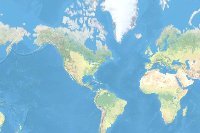

In [3]:
training_data = gis.content.get('25ed4a30219e4ba7acb3633e1a75bae1')
training_data

In [4]:
filepath = training_data.download(file_name=training_data.name)

In [5]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [6]:
output_path = Path(os.path.join(os.path.splitext(filepath)[0]))

## Train the model

We will train CycleGAN model [[1]](#References) that performs the task of Image-to-Image translation where it learns mapping between input and output images using unpaired dataset. This model is an extension of GAN architecture which involves simultaneous training of two generator models and two discriminator models. In GAN, we can generate images of domain Y from domain X, but in CycleGAN, we can also generate images of domain X from domain Y using the same model architecture.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAABBwAAAE1CAIAAADLYmQLAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAKBkSURBVHhe7d0FXBP9HwfwBaMEwUBB7MCuB7vBwhbzsQO7u8XCTlRU7A5EVEQxULEReFBAEAUl/gKilMAcc5v8f9v9mGNsyArutu/7xet5drfbdjtvd7/P3S9oeQAAAAAAAACgAggVAAAAAAAAAJVAqAAAAAAAAACoBEIFAAAAAAAAQCUQKgAAAAAAAAAqgVABAAAAAAAAUAmECgAAAAAAAIBKIFQAAAAAAAAAVAKhAgAAAAAAAKASCBUAAAAAAAAAlUCoAAAAAAAAAKgEQgUAAAAAAABAJRAqAAAAAAAAACqBUAEAAAAAAABQCYQKAAAAAAAAgEogVAAAAAAAAABUAqECAAAAAAAAoBIIFQAAAAAAAACVQKgAAAAAAAAAqARCBQAAAAAAAEAlECoAAAAAAAAAKoFQAQAAAAAAAFAJhAoAAAAAAACASiBUAAAAAAAAAFQCoQIAAAAAAACgEggVAAAAAAAAAJVAqAAAAAAAAACoBEIFAAAAAAAAQCUQKgAAAAAAAAAqgVABAAAAAAAAUAmECgBIJD7hC5/PxxMAAKAxv3i8hP99wRMAAKAyCBUAkMi4yTMzf/zAEwAAoDGpqWmTps3BEwAAoDIIFQCQiPvx02z2TzwBAAAak5WdfezkWTwBAAAqg1ABAACkx490H9epVYsGtataV6lSxdq6TmPbNm1F2rRsWKd2/RYdBzg5nwlIgbpzAACVcZ+79Gtn29SmuvB4U8W6Rv2WrfHxxrZRndo2zdr3nbT21KuvcLwBBUGoAIBEAl4Hc7lcPAGAtJyro8oxaHoNFr/g4DlCvKwvIde3/Nu4LKtSV+eHKQI8G4Ci5Obmvg76D08AUBg/elt7Fo1h7nhG8qjCz0kK9d4xuokZq7Ldev9UON6APyBUAEAi0KYCFIX7ekVjPRqz2vT7uXiOBEGKzzQbFqNSP/cYuH4I/g7aVIC/yLw8ohyDbtjDLbFwciCON0yrIWfi4HgD8kGoAIBEdu9zy2Gz8QQABfE/7eykT2eYD7uYiecUJEg62teUzqwxzTcbzwFArh8/slwPHsETABSS+3BWTSaN9c/6MB6eU4Dgy6FeZeh6NgufSd43BToNQgUAAFBD6qmBpnS6of3+BDk1DvhRW9uxaEzrqb5wlgcAqIQXtu4fdDipMeuhjBujQrzwDbYsmp7NoudQZxcQIFQAQCLvIt7/4sm8KAQA+9YkSwaN1dI5VO4u8u1IbwMajdVp12eokQD+gsvlRryPwhMASBEkuvUwpDPKjbgs+8ao8FbFfjt9Gs3A4WgqngN0HYQKAEgE2lQAubgvlzbQozFryr1umH+noujcAQAB2lSAomR5/FueQTe0PyDvxii+U0HT77I7FlprAxEIFQCQyMbNO7Kzc/AEABL4H7a1Z9EZ5UZeycJzCsu9M8WaiU7y3fbGw0ke/EVm5g+XbbvxBAAF5T6eU4tJY7VwfiP3AgXn1qTKDBrdqP/JdDwH6DoIFQAAQAHfTvQ3odONesrqiAXjR2xqxaLRmNVnPMjN4707OfffgfYd23do16Zjz6EzjhYoGwi+XFvUq61tm3adezrOOR2B5wIAgBBxF4JZTXgskQPfqNBruOyVRJuK7Ce7nNCBp1PHDu3bdew+Yps/0WuEIM13de82tq3bte9k33/8vlfQ6ks7QagAgERi4xJ40KYCyJBzY3wlBo1lu/Gd3P1DEL/f3ohOY1iOv5F/M4PzfElDFt2g/db30m0sBN9uTm3Xc/WND9BRlK76xePFxSfgCQAkCZIO9zKi082HXsjAcwpBxxs7QzqNWWPmg0IJIc1rvDWTUfHfKxK3MLjhm7o1GbHrUbzclAKoD0IFACQCbSqAbNzni2z0aHp15vnL7WeF/3mvnTGdpld33uM/vRLzPx/oYUrXqzP7YYGeijNf7Zw8+3QUnN11GbSpAHJlXx1dgUE36LZPbkVKfqwrOt7Q9ZutDpRxTOJHbOtgzDDusC2CuJzBjb4wb9JGGJlT60GoAIBElq1an5UNl46BNP77zW1ZNEbFMZ5y947c1yubsuiMCv2Pxha4K5HpPbkqk1Fu0Mmk/PN5dtDeSVOPvoP6BzouPSNj1dpNeAIACVz/eXX0aKxmq4Pl3RjlBq9tqU9nVhnt8U12UMi45VSNybQedy1NwP1wdt6UnS/l3vMA2gNCBQAAkJzgq7uDMZ1u7OCeLOdKH//TkT7lGcwqg08UGk6b93bdP/p0A9v1oh6h2G8PTp7oGgK9AQAA5CBaZxUx4I0g/uQgCwbTeuiZgpcwJPGjdnUpwzD8Z8qaGZN3vpTXLS3QLhAqACCR76mpfAHcIAZScq6NrcigsdpsjpR9Bs9959qrItOk+cL7qTL2HkHSyYHlGMxqTrdSwt2dxm57Bed3gPD5fHTAwRMAiAmSj/Q2ptPNHM/J7tWJ9+HoAEtmmeYLH6QVebbK8p1Wk0k3snOFHmd1BoQKAEgE2lQAGbhP5tfVo+nZLHwmo/KyIO3V7oE1DCt2XuP3Vd6pm/1oTh09eplarYau9y+6GAB0B7SpALLlXBtTkUHX77Jb1hiaWW/d/61nVL798rvybpvm40ScmNKuqiHDsPVGGDdHV0CoAIBEZs9f+uOH/GEIgE5iv1zamEVjWIy7XrDSEi/t3W3XWd2qV7AZ6HwzukBDbGlsr7EVmKYOR+QOYwV0T1pa+vzFK/EEAPkybjlVZ9L0Gq94XSAKCLI/PT62tG+9irV6rbj6/m8VKNlh7jOmuAYm3ZlWk8mwGnVFTssLoGUgVAAAdFvu17DHNy8eP7Bjy7Z9J7xexYtL54KM4PsvxM2bSx735daBHdv809DalEmn0eisija2bbHWrWxtWzRt1m7A9M3nn/9ZY3m4AcsbsQy67o2DEzsAQDbuM5d+7Vu3rG9pzBAecIytm7TGx5s26HjzT7OmrXpNXHv8YczfuxJhhx6eNuVAsHBBfvQ+O1OGge26N3L7rSMJfkb0C58rJw/u2Lp9/2mft1/z1xedBx6+gm6riglCBQAk8vPnTwG0qSgp2e+9XCZ1b2hp1aTv5CXrdx05c+7k/nVT+3bqvfBqDDcvO3B79xr9jsqtUkQh/E+7OusX1ZML0EXoUPOTA32AATXLDnGbPt3tjfhWRvaDmbX1GJVHXiJrwVyQHnJmxbC2Naxs7MYtdN55+PTZ43tWjevebbTr6wwBJ8zVoa7j6TS8LPgLCBUAkAi0qSgh7PeXF9lXNzZvOmaPX6zUhf7M19v6tB/m1Ntaj9Vua5Tcvk0o5NupgWWL6MkF6CZoUwHUjR3jtaR7nw1BBSpH8T/t716Wod9ybTD5blZw3l+a38W6jFWXRRdC0woc7PkJXlO79ps4qLa+foft0dpwHigRECoAIJEJTrMgVGgaL+H28k4WeqbNp136ILviEP/Dri7CYeTqL3lJ9lv2f5H5aIfT2OFd65Uva2ZtO2D0lH0v/lpVCugKFCqcps/DEwCoQpB2f9O/fdrbVCpbpmztnttf/rmAkf5go2OramampmaWTXuOdNr3gjTXNgTf/DfYW7LM2yz2+SLzJm6617gqTOF54AXFzwMlCEIFAECHCFJuz2liRGfVnXjti/yb8YIv++0MmFaTblGvCH758mV/f388AQAAGvP58+eDBw+y2VS8VJET6NLJnMGq63RDfi9W7BvjK+lVGi/VQwYoAoQKAIDOyH27064Cg27QZJF/0WM15N6dVs188BmqVaS9du0aTeTNmzd4FgAAaACXyyWONi1atMCzKEOQ5DW5LovOspnzoKhxvvnvNrYy66MVDetKCoQKAEhk0tQ5UP1JY7hvNrUtQ6cxq0/2lj2m0x/cJ/Mb2u2h1pBNubm55cuXJ07zHTp0gBb/oGipqWlTZ87HEwAoaNu2bcTRBgkODsZzqUCQdnNyDSadUWno+aLH2uDHbO/a0SUCGlQUH4QKAEgEGmprjiDx1OAKDBrdoN2Wv58k+FGX9nl+ota5xMXFBZ/hRU6dOoWfAEAWaKgNlJaQkGBsbIyPNTRa27ZtqXMVgxe2qbUhXTSaaC6eJYcg6fahixHQaZ4CIFQAQCI5bDZcYNYMftS2DuhEQjfufiBeC7dwXFyckZERPsOLWFhYpKf/7Y4M0GHoUMNm/8QTAChi+PDh+ECT7/jx4/g5kuM+W2ijR6OxmqwKgrigdhAqAAA6gP95T1cDlCn0O+2k2A2I4nF0dETn9Q4dOqD/6unp2draogdz5sB1aACAmt2/fx8dXvT19YnjTPv27dF/K1SokJZGgVZovODVTVk0GrP2XH/o00n9IFQAQCJzFiz78SMLTwA14niNrcBA5e16C59p35nE19cXndQNDAyCgoKIB69fv6bT6QwGA1psA3nS0tIXLFmJJwAoHi6XW79+fXScWbNmzciRI9GDY8eOtWnTBj2YOXMmXojE0k8OMKbT6KaO54rurAMoBUIFACQCbSo0JfWogwE66+n3OpyC50jiBu507NShU5du9j16OfTp26dXD7uunbtNPRtHgZsaubm5devWRd9t/fr1aWlp6AEKFWj+1KlT0WNosQ3kgTYVQAlE++waNWqw2WwiVJw4cSI4OJguQvoW2/yY7R1YNJpeA1mDEPEjj4zrgk4EdvY9eqPzQO+e9t06d514HIa+Kz4IFQCQyLdv3/lQBNSEnAtDTISXp4ZfltulOp+TmfR8la3wzrj1v2djsilS35Zon127du2fP38mJiaix3p6emj+9+/fic6goMU2kInP56MDDp4AoBjE7bNv3LiBJrt27Yoeb9q0CT2eOXMmekz6FtuCZLfu+jQaq7XcTp3QiSDBe3o9PRrdpOuWkDQunJAVAaECAKADeEGrmqC4oN/zcEoR5wiO71RrJo1hOdGbOqM5+fv7N2rU6NatW+hxTk7OrFmz5s3DwyQfOXIEneP/++8/YhIAAFSRlpY2bdq0fv36/f79G02eOHECHXBevHhBPFWnTp19+/ahsCpalqRy706ryqTp2SwuYpjsjAtDzel0/a574yBRKAhCBQAksmLNhqzsbDwB1In7allDFh3lhZvyR0flvlraQI9GLzvodCqeQw08nuy7KgIRPAFAQekZGavXueAJAIpN3gFH3nxyybo5sQqTbmjnKrcbQM7dadWY0D2UUiBUAEAi0KZCcwSJ54ZWZjDMex6IkXMhLdN3Wi0mja7feddnitahTUtLYzKZxsbGeBoA+aBNBVDRqFGj0AHn5MmTeJoaeKGb25VhGLRYFcDBcwpKvz7BmkljWjvdkf08KAKECgBI5HNsHDUu9lCS4NvdxbZmTNN/5nh9LjToUUbQgWHt2/5jzWQ1pe71KcmG2gAU7RePFxsXjycAUJy4oTaepgru+yODrFmG9Sec/yCVG/jJT3c4dmzdrBKz7OAzFOggl3QgVAAAdEhmyPFZXauVMW/QZ5rz7qOXvO/f975wwHnG0F69Rm+4FctJ9JzqsMz/L8Osktfv37+zRPA0AABozM+fP9HR5tevX3iaQrifrq/sU7esef2+M9btO3n19v07nse2zP+3p/2I9T5xnOhjI0cfoOoN61IFoQIAEtm0dVdOjvw6/0A9clPC759z3bx22aLFK9dtO3DublgKZXMEAErKzPyxZcdePAGA7uF+e/fg7D6XNUsXLV2zaffxm4FfqNNDB0lBqACARKBNBVBFenq6hYVF1apV8TQA8kGbCqCiqVOnogPOhQsX8DTQeRAqACCRsPCIX9CmAigL2lSA4uNyueERkXgCAMVRtU0F0BgIFQAAnZCRkREQEHD69OkVK1aMHTu2X79+HTp0aNiwoZWVVZUqVWrWrGljY9OkSZPWrVsPHjx47ty5O3bsuHTpUlBQUG4uZepG8fn8OBE8DQAAGvPt2zd0tMmmTjfov3//TklJefLkibu7+8KFC0eNGuXg4NC2bVt08Le0tLS2tq5Vq1b9+vWbNm3avn374cOHL1q0aO/evZ6enu/evSP5+BskAaECABLZu/9QDhtqdaqHQCB48+bNvn37UEhAJwyaslgs1j///DNt2rSjR49+/PgRvzsAFPfjR5brQXc8AYCW4nK5z58/37x5c8+ePcuVK4cP64ozNjbu2LHj/Pnzz507l5SUhN8dFAShAgASgTYVqsvKyjp//ryjo6PU+YPJZNrY2AwcOHD58uWHDh26fPnyvXv3AgMDUU6Ijo6OiIgICQkJCAjw8/M7c+aMi4vL9OnT+/btW7NmTfz6fHXr1kXnlfv375PwDkZGRgZxmQ1PAyAftKkAKlq4cCE64Hh6euJpMvn69aubm1uPHj2MjIzwsVvEwMAAHSGHDx++du3ao0ePXr16FR3z//vvv5iYGHQuePfuHXr86tWru3fvHj9+fN26dZMnT0ZvUqlSJfz6fC1btlyzZg1aEu5gSIJQAQCJvAoI5HK5eEIzNm7cOJJMHj9+jNdMNWw2G+WEIUOGGBoa4qM+jWZhYTFs2LCDBw+GhoYqvWG/f/+OTjAoZgwYMKBMmTL4rWk0ExOTiRMnPnny5Pfv33hRFaBPwVtEBYMHD0YrxmAw8LRqYDRuwtSpU/EWIQeUgfGaqQal4oDXwXhCMzZs2IBXmhz8/f3xmum87du3442igmrVqqEDTuvWrfG0CtAxFq+ZalJTU93d3e3t7dFhUHScFqpZs+aECRNOnTqFYoNyGQAd5P/3v/9dv3599erVdnZ2LBYLvzWNhvIGCldhYWF4UZW5urrijUION27cwGtWDBAqANAt6ICIj4XkoPporJ8/f168eLG5uTl+RxrN1tZ2x44dERERainuS0LlsAcPHixYsKBevXr4w0T3LlDkQKccvJBSEhIS8NuRBlyBI6BoircIObx+/RqvGel169YNrzQ5oGIlXjOd179/f7xRyOHAgQN4zZQVEhIyceJEAwMD4g1RqEDR4siRI5poY/bjxw8vLy8nJycrKyvi4xB03nFzc0tPT8cLKevff//F70gOW7duxWtWDBAqACCRoyfOsNk/8YRmEKFiyJAhqDRfuogDFnqA10xBKDA8evRo0KBBdDqdeKvGjRtv3rxZXddx/yo0NBSli4oVKxKfrqenN2nSpA8fPuCnFSQOFcTGKUWHDx8m1gRCBYEIFc7OzngDlR7i30VdoSIrO/vE6fN4QjOIUDFs2DD8BUoPsekgVIgRocLBwQFvoNJD/NMoHSp4PJ6Hh0enTp2I90HQ44MHDyYnJ+MlNAmdhp48eTJhwgRjY2Pi001MTJYtW/b161e8hOKIUIG+Bd5ApQd9F7QmECoAoKoSaFNBhIpbt27h6dIzUtQdITpy4WlFoDjRvn179HKEwWAMHTpUXdWQFMXlcq9du9avXz/xyqBTgrxb4UUMPUuEivLly+Pp0pObm0t8FwgVBCJUxMbG4unSg2IzWhN1hYoSaFNBhIrbt2/j6dIzfPhwtCYQKsSIUHHlyhU8XXomTZqE1kSJUCEQCC5evCi+aWxkZDRt2rTw8HD8dMnKyso6fvx4u3btiJUxNDScO3cuOqrjpwsqegxyIlSQoaNe9BXQmkCoAICq/B7552q4TQXVQ0VAQED37t3RCxEzM7Ply5fHx8fj50oVOpmNHj1aXJF30KBBgYGB+Ll86Mt+/vwZTxQEoYK0tDVU/ORwHj5+iic0A0IFaVE6VPz+/fvmzZvNmjVDL0SqVq26Y8eOtLQ0/HTpQSvm7+/fo0cPYsVYLNbUqVNjYmLw0/m2bNny86fcKgkQKgAAlEHdUBEXF0c0REaMjY1Xrlypeu1VtYuOjnZyctLT0yPW08HB4f379/g5UWcpo0aNwhMFQaggLW0NFSUAQgVpUTdUBAcHi28IVKpUydXVlcPh4OdIIyAgYMCAAcRKMhiMiRMnSlaIQqkD5Qo8UQiECgCAely47PlTw8dHKoYKHo+3a9cuotKqvr7+vHnzVKmxWgLi4+PnzJlDNBlksVhr1qwhrkv169ePTqf/999/xGKSIFSQlraGipycnEseXnhCMyBUkBYVQ0V2dvaCBQuIu8Hm5uaoXE7ycffevn07YsQIotUfWuEjR44QXerVqFHDzMwsNTWVWEwKhAoAgHpAm4rCgoKCWrZsiZZE+vbtK6/6EAklJiaOGjWKWPPatWv7+voS1X979OiBl5AAoYK0oE2F0iBUkBblQoW3tzfRgy0yffp0Et6mlic8PLxLly7Emrdt2zYgIIDIRQsXLsRLFAShAgCgHje8b3M4mh1SjUKhIisra/78+cTx19LS0sPDo1SaYqvowYMH4qaE4o6q7t27h5/OB6GCtLQ1VLDZP719fPGEZkCoIC0KhYrExMShQ4eiZZBGjRo9f/4cP0Ed6Mx1+vRpoqtA8VlAX19f5lEFQgUAgDKoEirQGlatWhUtgMyYMSMjIwM/QUEcDmfRokXiNtxIy5YtpQIShArSgjYVSoNQQVqUCBXoIHno0KGyZcuiBQwMDFxcXDQ9OKxGpaamDhkyBH0XsbFjx+LnJECokMQL3tixsrm52d+Ym5e3rFG/eTuHccv2eYakwLkLFIP2713ePr5wp+LXr18LFy5ETyGoFPXixQv8BDWlp6cvWbJEcpxvwvnzBYYIgFBBWlp8p+LWbfUMYywPhArSIn+oyMjIEPfMYW9v//HjR/wENcXFxY0bN07y0hJCp9PfvHmDl8gHoaIAbkpU0Kvn/vdvnlvTo5Jo69ENm045fvfpy1cBYi+f+t2+enz70rFdapRh0Ol6FW0nugWkC9uvAFAErd+7oE3Fly9fOnTogOajg++6desofV0K8fX1rVKlinBPLaRmzZqS3w5CBWlBmwqlQaggLZKHClTUrlOnDppvbGyMzhFUrPgqyd3dnRhIrrDevXvjhfKpNVQI2Dls/FBx5Kr+lHNtbEVhsY9uaOcaL7dEx43zWWNnpUenMcxbL737FXIFKBZt3bvOX/LQ5d6f/Pz8iAIc+i96jOdSHDodxsfHP3jwwM3Nbf78+X369EEnSyaTib7m3r178UJqDBVZ0VEJPPxYKRAqpGhrqMjJybl4xRNPaAaECtJSa6hQ6aBTOFSg8jRxa7dBgwYRERF4LsXxeLyPHz/6+Pjs2bNnxowZ9vb2VatWJdpXSJ3s1Bcq+HGeU5pU7bzuaZpypR9ShQruk/l1RV21s1o6hxa9t2W9dG5rirYs02rImTg4i4G/g71LeaQNFenp6aampmhOx44dv3z5QszUVr9+/Xr//v2zZ8/wtLpCRU7wrp5WJo2mXEtQfl+HUCFFW0NFCYBQQVrqCxWqHnSkQsWbN2/QJILK1iTvMVZ1bDb77du3ISEheFpETaGCF3tlcuPqneeuGd+sWidnf2VyBZlCBT/CpTVLuF8wa8z0+2sdcfbThfVZwoKf9cQbFG6OCUqI9u5dfo+e6PKI2hcuXFi0aBEqcONpXaKGUMEJPzS4Zff1foHnJ7fusOCOsrfmIFRI0dZQ8ZPDeeT/J9ZqAoQK0lJTqFDDQafwnYp169YdPHiQ6lWelKaOUMGNuTChRfMxJ96x8/IEqU9dejbssuZxqqL/OiQKFYJkdwdjVI6jMcyHX8rEM4vAC17dTFhKpJftfVh+bRYAhLR474I2FTpL1VDBjTo11m7k4bc5wglB0p2lPR3WKHVxCkKFNPWEiszAA8t3+H9T6QCka20qBOysbJWq8v0BoUKKOkKF7IOO6CkFyGuorbNUDxW8sG0DHZz9JCIeJ+q8U3cnjxTFjj8kChV/qrzbH0gozrfg3JpUWfSCsoPPKLxPAt2ixXuX+/HTbLZw6GXNgVBBTqqGCnbEo6dxEgUwQXrww1dK3ayAUCFF9VAhSHu6oZt11bo1rFovupOszD8KQb2hIis7+9jJs3hCM5QPFRmvXKcMGz116oAWDXq7PCk4zpngy41lA3pNPROtwP4JoUKKOkKF7IMOnig2CBVS1FL9SfmjjATyhAru0wXiKu9vi3Whgft6eSPRK5g1Zz/UbJeagOJg71IJhApyUltDbZVBqJCiYqgQfL27rL1N15W+ibzUp1v62NjOuBav5IbVlTYV/E/H/u2/9kUmOnYHLGvIMmi/LUpii/E/bO+gT2c1XR2kwF0MCBVS1NpQWyUQKqSoqU2FGpAmVPAjXdoQVd6rF6PKuwgvaHVT0UvopsMuKd8BFtB+Wr13BbwO1nQnqiqGiuzY175e13yDE/P7qOKnRz/38br1PCZT0UsjECokQaggLVVChSDRe26n9k7n3uf/XrixXvO7tJt06bMy21a9oQL9Q78O+g9PaIZyoSL9ulOPZS+EW0yQcmKAKV2v/pIXf46Kgq9H+5ShM6tNv6/IBSIIFVIgVJCWSqFCwE5+/yYsLkOBwC0fWUKF4KtiVd6Fcn2nWAv7WKTRDPoeL3irEwAJ2r13kbpNBffztaVDBk/b5H5i30L7uvVHnojMTX20ady45fvPnd81vnkd+x1BeMnigVAhSdFQkZv5NflbWmY2h8vNZWdnpKUkJ6cX6oyYn5P6VbRQLicnIzUlLac4wQ9ChRSV7lSwP4S8kx4lJ/t9SGQWfqwQnWhTIUg5NbzX1kjhvidIOtq3LJ1ZfZqvqNY+IfvamIoMRrkRl4t5+CdAqJCiXKjgZX9LTknLQEcU4WEnMz31a3Lqn6NK/rPs3FxONjrgpGQUJ/dBqJCidKjgf/FeMXTo9LXrJrWybj7LK6nAcYcfdXx0i4b99oUrEDfIEipyvMZa4Crv+4tV5R0dO5IP9TQQlhRpdNPhl+FOBZBLu/eu3fvcctiaXUNlQ0X6gyX9Jpz9RByQ+NHb2uubdx46aNCmEE4e/4OrvRmDxmrhLHqyuCBUSFIsVAiSr69w7NOtaWV94Y5NZ5at1bbX0HW+UomZG7RvWPNKwq7P6Hpm1Vt2n3X+UzFiAoQKKeppqK0O6g0VP35kuR48gic0Q6lQkfH2SZConxr+p73djKXuU+Rx/efV0aMb9TyUWLzDPwahQopSoYIbsGdMv+6ta5oyiBOqvkUj+1kX8o8qHP+N3euUFZ6eaXSWeW1bu6HbnhbjbAahQoqSoYIbtnPQENcI9FvhvlzaQI9luz5MIj/wwjfYsmhSM/+GJKGC+3RBPaLKewvnN8Vc/dyHs2oSl5L1Gi59pdnqH4DKYO9SlXKhgv1sWY8pEj3yph3tY0BjVBh6XtibDff16maGLItO61/gZ4sHQoUkpao/5QYsb8yi0Zi1Zj+Sc0kw99mi+hVtZ50NLf6Y8hAqpGhrqCgByjfURviRW9rq06WO9Lyw9cKyUWuXCMV2TggVUlSo/iRIuTDcgoGCQ7utkm1dhLjPFtqY2gzZevdz8a+NQaiQolSoQP8oo3tvELUyFSQe6oXCeKPlARKVBhMP9jCkM2vP9VekBESOUMF/vzm/yvuMB8Ws88iP2tpO9Boa3XzI+cJjCQjSXp3duWPvwSPHTp46dfLEMffDB/ft2r7PW7LzB36Mz/5t23ftQwudOHHs8IG9u3aeeankMIKArNS1d2UGXdy1fefe/YeOHj958rj7oQNof9q60yNM1oGQHe65Z/uuvQfQssfd3Vx37b4QqNB9d0W8i3j/i6fAhQQlKBUqcq479XQO/rNi3FdLG+rRyw46nUpMC9jpGQoPBA6hQpJybSpEl5/oNGbtOY9kbf+coC2D+m94WvxAIQShQorSoYKX8GDXzDGjJ4wd0rNLjwk7H3/l5wkygo8vcZo81WnCv45DZ7q9Uqw2pnpDBZfLjXgfhSc0Q5VQgTNF87WSmUKQsN/ekK5ns+i5gleHIFRIUalNBdtvVi0mjW7UZXeBHrhyww8O6T7Hu2C1m7+CUCFFmVAhSHIf0t9V1FJLELvfHmWKOvP8Jc4JmZdHlGMwKo65ptBogqQIFUQjKrQedPNhF4tZ9hIkuxOvodGNe7h9KbxDCpL93TeuXTrNwQYvxrJqO2rh9luS9/K57y6tHNxA+DydWbZut5HTl2w4HaDYyRSQnbr2LsG358c3rV06tWcdI9EzDIvWYxau3e4ZISunZAWdXta/rj6dRtev3LL/5EUbL4RobJRPsrapEKTGxkk0xBYkuvUwpLM6bFekT8dCIFRIUrKhNj9qewcDlCqqTfWVTsSCBI+p/efdUrhbWQgVUpQLFZwwt3/7zLpANJ4QxB/tV960/YbLu0aM2BGUlcf/dH5SE3M9VquNomWLSyfaVGDEQUbPZuEzyfiQfn6IOZ1hOclb0UqiECqkqNZQmxeytgWLXqALLn68h1PPiec/K3xRDEKFFKXuVOREv40SlYn477e2N5DuHC3Xb2Z1Jr1M32OKDVRBilCR4zWOqPJuYOda3IHGUs84mhOlPlOHIzIyhRg32PkfYeV4huWYq4Wv8AhSroyyNm824cDTRF2v4qKt1L135TyaI+qdlmk94XoRg21n+i9sbNZg7NG3GrtDkW/j5h3Z2RJtEjVA+Ybaf2R7jqnAUOJqYUEQKiQpGSry+LGudsZ0GsNqwo0CbX+zX20aPOJAeDFv50mCUCFFmVCR82xlr9Fn4sQbkBeyphmLzjBqvSEUneoFX/bboTMZo6KjYsNEqDdUZGb+cNm2G09ohgqhQlRrlW7qeF5yt+bcmWLNVGq8IQgVUlQLFSgW7xMed5g1pt8VnrAEqX7LHRz3vlU06wlBqJCidENtIVH9QDqr1cZ3EpkCZcDmaGb7bR8UO6STIVRwny3EVd4L3rQsgiBR2MGD8DVMq7GeRR8rBCmX/7VEpUq6UVuXgs1NhKML2Tfvv/u1xst9oNSof+/iv9/RSXizgm7a/YCcPh5z3x8b2qLbmodKjSNGQmoIFaKGLYwKoz1Vu2MDoUKSsqEC7eJHHExRAdXi3yviKy382AuT+y/yVW74ZggVUhQPFYI4twF2GyVH0WHfGF+JQTfstjeW+DfJjvS94PkiXsEymC61qch9MLM6k2k95Y5ELs55OLuOHt2g6944hfdsCBVSVAwVqDB2bkgFBgrGwy9+yw7eNdhh5SMlq5tDqJCiSqggKsRKtccWxO7takDXa7hMopFFsZAgVPDfb25LVHmvVtwq7/z32zsYCkt9dKPWBY7CsvHebmglXJxhNeqK+JQp+PZwdTfbkSciFa7WDShEE3uXIPXyyErCmMpqtFxGG27ep/Nj/+m88pGoL5ISEBuXwCNjm4oCRCOF0A27H5TofkWQFv1BsRurECoKUjpUoLP76UHm6OxezvHcN9GMzGfOg0YdiVT2NpLMULFv3z4ytFQuFYqHCn7sfa9XkpVveUGrmgq7XtmgSH+Ohak3VPzi8eLiE/CEZqjSpiLt8r+VGEb2+/PvSXNjrzo1MKAr0keHhMKh4tevXxs2bMjKUqpzX+pTNVSgYHxnajUmjW5sO2Bgz2meCUpfgYBQIUWFUCH4ckDY5qhgh2l5aWcGl6UzrZ1uK1pCLv1QIUg51hdXeR96oYjqJBIybzlVF/bMQ2c1XPC4OBc+BameY6qgV9ANWq4NFm43Qcr9ZZ1tx52LVvYcCqhBQ3tX7oslDYSdbjIsR18teCeDn3BtSqu283ySSyhRIKQdpyI3NTEFX1UVJB/pbSyssinRcJvzdJH9LIXGokIgVEhSPlTk5aVfHlGRQaOX7Xc8ScCLOT1+wPKHKvRRUThUXL16FU2WK1dOudIh5aDi5g+Jn6HSDbXF+J93d9an69Ur2D5AcbrUpgJttfjri7tWr951/oHTx3aucBo5YcGoFvp0Zk25XZ0VpXCoWL58OZrToEGDd+/e4Vlajc1m//z5E0+oI1TkcV+vbCLsJgKVVpWp9pQPQoUUFUJFrt+sGky66ZALBSoN+ky2YtDNHM8pPEhX6YeKnOvjhFd9i1/lnR2w1lZU+8Sw2dInxb1gwAvf3Fb4IkZFxzNfku4s6mA74QLuPh9oMU3tXfxPrvYmwsXKdNvzp+GxINlnXltbJ8/4Eq0BsmzV+qxsjTUDF1EiVGQ9WtLMhKHffI2w5Zcg+Vi/snS68aAz4k0q+HZpfO/1ooivCAgVklQJFXlZ18dbolRRpvvWC8sHjD3xQaXDYeFQ8fXrV2K3QVavXq1N1aJ+//4dHx//4MEDNze3+fPn9+nTp06dOvr6+mFhYXgJNYQKQcqJ/iZ0huVEhZsXS1FvqEjPyFi1dhOe0AyVQoUIJyn8+f07j98mZPFSTg82pzOtp9xWptVZ4VARGhpat25dNNPY2Pj8+fN4rlbg8XgfP3708fHZs2fPjBkz7O3tq1atWrly5WyJk4saQkVe+vUJwmFl9eoW6GhIURAqpKgUKmbWkK40mH1/Ri2mIu1Q/yj1UCHsoliRKu/ZL1eJCn2MSr33K9SgMP3GROGuTNeztmn8z3hIFDpBg3tXxvXxohG3hT2NiI6Ngm8PV3RsMfpsjBbuWYqHCtFIOjSGeW+3T/y8rCfLeg90bGdq0G0fPkRx3x8dPdD5ueJRCEKFJJVCRV7O7SlVmcIh7tqsfFK8u3jyyaz+hIopq1atIuZ37949OTkZP0FN6DuuXLmyadOmRkZGxJeSNGHCBLyciMqhIsvj3wqMQs2Lc9ILD4H+FzrTpoKb8PTk5nWHnkhUqeR/PtDdlK7fdEWAEvcp5LSpyMzMHDJkCJqPoMK35IV8Kvr27dvEiRNtbGxYLKIT9QKkSu0qh4rciCMje0+c2FnYoMtqnJfyhx0IFVJUaVOR5jGqMtPIzjW/1RH385XJNsJKgy2d/966oJDSDhX8qC35Vd6n/70mRG7UyeE1WXS6nmWPLc8V7fqVH7m9o7Hw4rKxnStu+Aa0m0b3Lm7wmuaiKlAWwy9+42c8X9+tmeMRmf3Latj31FS+QLM7tBJ3KtiB27vXbTl+24kjm6c5jtzyNC33/ckxjev3Xrrfff+aSQOGr7n9RZlL1xAqJKkWKojhUpm1Zj9UvV2ZzFBB8PHxKVeuHHrK3Nzc3d1doOF9VaN+/frl5uZWqVIl4suKGRoaon8LvJCIMqFCwOOJNx7RZZFBtwLNizNvTbVb+ETBu3vqDRXo3xcdcPCEZigXKvgxe+3K0Gl0owGn8ouqgtRbTrX09OvP8lWyYp+8htq/f//es2ePnp7wglXt2rXv37+Pn6AmFJNWrFhROCrXrVsX7fB4IRHVQgU//uqUnhPOfeKlXx1dmUGjm/c/ruDoFH9AqJCiSqjIEyTcXNKtRvUu8w6cOrpzudOIiQvHtNSnFzE+alFKOVQoUOWd//Wxi4M1KvMZ1ht1IkKJsyA//uK/1YjK8vUXFmcgeEBxGt67BAnufcyEKdWo9eS53Zs47A7RbL+u8pC2TYUg6/MrX+/7QfHZ+WcOTnK4v4/3g6B4pbcUhApJKoUKQcrxfmXojAqjr6qh7lwRoQJBZeuuXbsSC3Tq1CkiIgI/QU0pKSnoWxBfh7BkyRL8XD5FQwUv4tCg6oYGVYadFnVhne3jZM1EgW+OxFmd/2F3317bFW61rSNtKrhPF9iYW9s6bvbHCYIXc3ZEDUPr/geU6rJURF6oILx48aJevXpoAWTMmDFor8BPUFNISAgKSMTXIRQODyqECkHqw+UOjrvfiP4xOI/n1tFDZ85OO6RH1y4uCBVSVAoVIpykd/mVBr8RlQadlKo0WMqhItNjVMW/V3nnJb9wn9OlCovOLNdi3N6nyUrshvx4z2ltO8zet7SDsJTJMO9zRPH+5QDFaHzvyr4zVdSmm1Gu88aXpdYv8ez5S3/80GxvJMqFCk2AUCFJpVDBvjXJkkE37CHZIZfSig4VyO/fv9EJj7hlwWKx1qxZw+GofoOkFKBfQc2aNYkvS0BfKj1dujmjgqGC6KWOzqwy5mqqII8T7OLQvX/XyiyriTdx4hN881vZb9j+MMWvHKo3VKSlpc9fvBJPaIaS1Z84QVv69l5w+e23XG5m7PPTS3o2th298+EXVVq5Fx0qELQPoz2ZqDiEfoZoD0f7OX6OOtBvFpXOy5Yti74FnS68DIe0bt268HdROlTkBO9y7LvqsfiOES90na1wHLzGyxXtsBSDUCFF2VDBTXx5dvumYy8kuhLnxx7sWZbBarzspVIVL0ojVOSmxUdHvX8X8vzWoSktTUW7MMNy6JHg9x8kRL1788rf58KBdbMc21gbMRjGVdtP2PkwQakdkBtzYWKrjgvvJAvyMu9MrSlqWWEz73HpXFcGmlWSexfvrXNLdDrRa7zitSqnLvKDUEFOqoQKbsDyRnrCrjaVqDVb2F9DBSElJWXMmDHEkvXq1Xv06BF+ggrQ1nZ0dCRW3sbGZvv27cRj9AAvIUHROxXccLdBdWvZLzly9uiWGYMHL/f+wvvqu6pbvRYjN7ifPOIya9jgGe4hSl240Jk2FaiMH/fw6IbFs2YuWu96zickSeWD8l9DBSEiIqJjx45oSQStfFRUFH6CCoKCgmxtbcUrv3DhQuKxzN+mcqGCF316fO8ZXgVGkRXEHuhuIhzVf8ptpW6UQqiQolyo4H/eL+xxRrLSYF667/S6LFa9qbeUG7KoFEIFP2JLO9EoAH9BZxqaW9dt2tZu4MSVh29HpCt5lwwlinNjbTstvY/HIeNH77MTFjXpZj0Pyhm5DFBXie5dgi8Hu6MPY1addlepRK8mP3/+1HQ9dQgV5KRCqOB/3tVZn860VtO+W8xQQbh37564osWQIUPIXxsqMTERFbaISucGBgabNm1C3zcuLg5NVqtWTeYtF2XaVHBTIp7eueMfnvzn/XK+vH3ie+dRyJ8qhApTb6hAh5qfGr7FpHyoULdihgoEbRZ3d3czMzO0vL6+PipXkb9bgrCwMFQSJW5NoN313Llzv3//9vT0RJMODg54oYKUCBW5UWcndBtxNKpQwku9OLwig8Yo73hW0cGKhCBUSFEuVHCfzK9nUrFBb+cHOEHwE65OqGtQucfOQKUrxZZy9SdN40afHduq66qHkpEr2292XT30O9KrM8tPDZWJgc7KujKyHAPFUyW6clYn0rap0AQIFZKUDxX82P3dy9DpBr2PqKciuEKhAmGz2StWrCDqjaBizbhx4z59+oSfIxOUCmbMmIGKicS369OnT0xMDPEUKoEZGhrKK3EqEyo0Q0faVGhC8UMFAQUJomyHGBsboz08La3gOEbkEBgYOGjQIGI9GQwG2sPF9fdQ0kBzQkNDiUkpCoUKQc6XgHNL7awNqk+/LyOG8uNc7Y2EF8k7bH2n+D0lCBVSlKz+xH7p3LPvap+YbEEe91uo57qBTZsOWuf9SZXLBtocKjgRx0fa2jn7S49szI893NtcOCCyqd2+P2MMAKCY3EezazFpdP0uu0v3ltcEp1kQKnSTEqEiy2dJ19at/2lYtYK5ublZ2XLW9VvYth91KFLFOlCKhgoCKnNPnDgRFWLQC/X09KZNmxYZGYmfK21RUVETJkxgMoWNphAUJ54/f46fyzd69Gh5Nwm1OFQ4TZ+HJzSDuqGCgDZ1z5490QsRMzMzZ2dn8ty1ePr0aa9evYh1Q784Jyen6Oho/JwIh8NBP0k8UUhxQwX3xaYe9a3MTcuiY4yJsaGxRbMFkrWcBF89ZthWMzcyMkELmJuZW9Vrbttl/nVF8heECilKhgokK9Jr55IZTpOnL9548OKTTyo3C9DWUCFIeeLSq37HNU9kdg3KfrqwvrA3UGbNab6abeEKtBYvbL0ti0ZjNV0tHN5Nu0GoICdV2lSol3KhgoCCBFF6I6ACmY+PT2n1PIs+9+HDh2h9xC1WhwwZEhwcjJ8uqIjr0NoaKkoA1UMF4dGjR+3bt0cvR1gs1tixYwMDA/FzJQ79PFES6NKlC7E+BgYGs2fPjouLw08XVMRerXRDbbWDUCFF+VChbtoXKvgZH+4fmN7Z2oBRpu8xOZX1uInXJtUS9S5bpp3zqwy4WwEUJch8sbwFCqaMcv96aH+LfwgV5KQdoYIQEhIybtw48QhcderU2bJli7iuUQlAAWD9+vXinp0YDMbo0aPfvXuHn1YQhAqlaUeoQH7//u3r69u7d2/0JoS2bdsePnz427dveAkNQyvw33//zZkzh+h1DSlTpsySJUuSkpLwEgqCUEFaECo0IsdnZv0KZqZlzStYWFSsUK6ssWFFB+GAvgVwnyxrZm5sYlaufIWK6MBfsQL6X+WqdluKM+AyANxXzh2qVqliaVGhItp/KlasUL6CReXK1m3XviytDqAmTZ0D1Z90kzaFCkJycvKGDRssLS2Jd0NsbW137NihodI5KnWFh4dv27atc+fO+PNotEqVKi1evPjjx494IaVocfWnqTPn4wnN0JpQIfb+/fvZs2ejAj16N4TJZPbs2fP48eOpmhlGkMfjPX/+fOXKlU2aNCE+EbGxsUHlvO/fv+OFlAKhgrQgVAAA1AMaauss7QsVBC6Xiwoujo6OBgYGxNsidevWdXJyOnv2bHx8PF5OKQKB4MOHDxcuXJgxY0b16tXxu4uqmA8ePPjmzZtSowgrR4tDBTTUVk5mZuahQ4fQtxPXrEMPWrRosWDBguvXr6sYMNBOGxIScuzYsVGjRonvSyCmpqZTpkx58eIFys94URVAqCAtCBUAAPXIYbM1XQEdQgU5aWuoEMvKyjp//vzAgQMl0wViZWVlb28/e/ZsVKq4f/9+WFjYly9f2Gy2VMkJrczXr1+DgoK8vLxcXV0XLVqE9mRikC8xc3NztFOdOXNGvZVStDVUoEMNm/0TT2iGtoYKsaSkJLTfdurUieiiQKx27dr9+vVbvHgxygZPnjyJjIxMTk5Gvyz8MhG0h6P8gH74KCdcvnx5586dM2fObNOmjdQPpGrVqtOmTUMJOSdHnbVzIVSQFoQKAABlQKggJ60PFWIcDgcVszZu3IiyhKGhIfFZhenr66OtgWIDWkaqxCapXLlyPXv2XLVqFXpPHk8jFV+hTYXStD5UiGVmZvr4+CxdurR169bifsYKMzIyQnu1iYkJSg7iuxyFoSAxePBgVJgLDQ1Vy32JwiBUkBaECvVgs9noC1y7dg1PA6A+qMAxffp08o9hNGfBsh8/NNuJGYQKctKdUCGJy+W+e/fO09PTxcVlzJgxqEBWq1Ytc3NzmeUtVCCzsbHp3r37xIkT165d6+Hh8fnzZw0VuSRpa6hIS0tfsGQlntAM3QkVkrKzs4ODg8+dO7d69eqhQ4c2b968WrVqKEigFSjMzMysSZMmffr0mTZtGvoVoGRSMucpCBWkBaFCPRwdHdHaI+Qfk5UMeGnvfE/v27x64fRxQ/v16j1g6Pi564/4vMsoUHWGG31h2aY74iHbdVV6ejqxa6GSCp5FVtCmQmfpZqiQB300+tmibfL169e0tDRUSkPxowTyg0zQpkJpuhkq5Pn169e3b9/QXp2SkpKRkZGTk6OWNj/KgVBBWhAq1ODDhw9o1Qn29valdfKggszwa9tmDfynihGDbmjZtGu/kU7zV2/esX3DihnDOtYqV7HlxCNBRIoQJN2Y1rBMrdmPClTj1EWzZ8/G+xaNdufOHTyXlL59+86HNhU6CUIFaWlrqED/vuiAgyc0A0IFaUGoIC0IFapCEUI8MCTh8uXL+DnwhyA16MTcbtYGdLph1Y4T1p97lSgdF7hfHm7uW92ig/Oz9PSna9uZMRjlRlzW8REB//vvP8kK2XXq1OFwVBm3nvKIUFG5cmWn0kb8i0CoIBChAsFbp/SMHTuWWBMIFQQiVHTv3h1voNJD/LtQrk2FlZUV/gKlh9h0ECrEiFBhamqKN1DpIf5pIFSIEaGCTqfjDVR6iH8a6oUKT09PYtXFqlSpkpUFw2NL4H6+vqSzJYtOZ1q0n3c+vIhtwwnbaVexWvNmFkw6jW5of+BL6QxmSw4CgaBdu3Z4r8q3adMm/DT5rFizISs7G09oBhEqyANCBUEcKsgDQgWBCBXkoa5QkZ6RsXqdC57QDCJUkAeECjEiVJAHhAoxIlSQB8VCRU5OTrVq1dB6jxgxAv23fv36TZs2RQ+WLFmCl9B5grRnm3tYsVBGMGky5VL0X2szcd+us9UXNXNktXB+q9PjAJ44cQJthvLly9vb26MHxB1wQ0NDMtRkkKkE2lR4eXntJxNoQ0XIysrCW4Q0NN27MVUcO3YMbxFy+Pr1K14z1ZRAm4pr167hlSaHyMhIvGY6z9vbG28UcggNDcVrpvN8fX3xRiGHoKAgvGbFUPqhYuXKlaic16hRoxcvXqAHjRs3fvr0KXqgp6cHpQ1EkPpwRRtzBo1GN2w4/WZSsU7ygjhXO0OUKpjVZzzQ4QYV6enpFStWRPuSu7s7ESdOnz49cOBA9GDw4MF4IZL5HBunoW4xAaAA/ufTTp1bt2xYu3o1pHqt+i1at83X2rZ5g9rVhU9Ur23nEgw/E1X94vFi41QafBAUBy/cbVTH1v80qiPaeatVr9PonzZ4n27bto1tyyY2NYknarZb9RS/BgBqKuVQERUVxWKxUCHv0aNHgYGB6AEKFWg+UanXzs5O11tsc97ssq8obBDAMO+6M4yL5/4VL2RNMxaNbj70gi73/DRr1iy05Vq3bs3n88Wh4vPnz0TX+GRoOwgAkEGQ7NbdgE43aLclQio65H4NuTi3tZm+7YZwCBWAUrKvjDRn0BgVh1/4JnVxUJAT/+LE1JamrMYrKNNaBgCZSjlU9OnTBxXvRo0ahR77+vqix9bW1uhxcnIyMVTq1atXRQvqJEHag/mNhXccaIwKvQ5EKXIOTT/e14Bu0G1fnM5WXwgNDaWLoLCKJjt16oS245YtW9DjjRs3osd16tQh4T2BTVt3qXfYVACoJ/fBjOpMGst2fZisXyjbx6n2wJM631O26jIzf2zZsRdPAA3jBa5sLLrUd172rsu+7VSrlxvZR1ICoGilHCrCw8P79u2bmJiIHqekpBw+fFjc75Obm9vKlSt1uYCVcXemDUsYKehG7TYreFmOfWWEGavpah2uIYACw/79+5cuXUpM3rt3D+1dUVFR6DGHwxkwYMCjR4+Ip0ilBNpUAEByvNB1/7BozOoz/WTW3uSFbRw8577O95StuhJoUwHy8T/t6qRPpxva7U+QfamPH7G5/1Rvne6ZEGiB0m9TIYaKeh8+fCBtC9qSlhuwsinR2ppZY8rtTDy3uHLOOZpYT/GFA1Q+FFzR3pWZqeiGLGlh4RG/oE0F0GmCpEO9jOjya2/y3myYsjUCOqZSGZfLDY+AhsslI/XUQFM6jfXPOpl33xC0W0/aqNsdqwAtQKJQIdmmQucJEk8MLC8aXIHOaqlED05ZDzc77XgK1WjExG0q8DQAgKRyro2pyKDrd90T++eSbm7A0aMvcaMy3rtzJ/zh4AaohO09yZJBY9aa81jiFhsv4tTBW6l4L+eFn3Z/qNnuxAHQOBKFirdv31atWrV79+54WpfxI7e0MxDdpqAbdd3zCa7JqWzGjBlo7/Lw8MDTZLV3/6EcNhtPAKCDuM8X2ejR9Botf/2nZwqO3/yR297DgVC9fvzIcj3ojieAJnFfLKmvR2NUHO0pERt4QWsHLngE9fiANiFRqABivDBhlWJRptDvtDMGTqW6A9pUAB3Hj97WnkVjWE7yzg/XvOSHKzv+s/BpsXu/A8UDbSpKCj9qazsWjV6mz9Gv+XffeF/913WtN+Yq3JsAWoVEoYLH46WmpmZkQKce/E+7OhPNKYQ1MEOhkqUaZGVlob2LwyF7K5NXAYFcLhSegO5KOz3IlE5nmtVoZivU3MbajEVnVChwiReoRW5ubsDrYDwBNEfw9VjfMnQa3di6sWin/qdpvSplWXS6sYO7OGQAoBWgTQUJsa+NIdpT0JjWU+7AzVF1gDYVAFAB584UayaN1X5bdP4dWvanE0Nr9j5UvIE/ASCfHK+xFgyaXoOl+c2C8gQ5MaeG12i/JQrqIQDtQqJQERwcbGRkhFI8ntZZ/JgdHYnKTzR9u/1f4FSqDmPGjEF717lz5/A0WR09cYbN/oknANA1vGDhuJ16Noue/7lfx321aswmeX3mAOVlZWefOH0eTwCN4T6ZX1dPWKPvlkRzOV7Q2mErXsBdaaBloE0F+RCnVSFG5Um3iqyvw4/a072isXEZU/NyFSwqV7GuVqNmrVo1q1lbVqpgXtbEpMa029CpLLVAmwqgywQJ++0N6IyKY65J9O7Eub9zN5S+NADaVJQI/ruNrVg0uunAU6l4jhDn/tatj+H8DLQNiULF73x4Wmfx3jq3JEKFXoOlr4o+l/IzYkODA1+/fPbY12PXsDp6opfRjZo6HfF58iokOhWu7mF43yL93uX3yD8X2lQAXZV1ZWQ5Bt2oJ1R2Kgk/OZyHj5/iCaAhgqRDPY3owj5XoB9HoP2gTQX5CFIO9yL6k9Vr+LdQIYEf4dJalEXoJv2Op8ApuSBoUwEA6XH959ZmQvcUQJuIgjJNr/EKiS6SAdBWECpIiPtySQPRPQdGpQk3i31/lBiwk+iFFq6ISKNKqLhw2fMn6buoAkAj+JEubVg0ZrUZD6B7ipKQk5NzycMLTwDNyH04qwaTxrR2ugPHdaADSBQqBAIBh8PJzYXTSV7uozm1mMJUwWqyKqiYl+zYt4QDdiJ6jZYHwBURaVwuF+1dfD7Z0xa0qQA6i/9pT1cjOs2gt7tk3XOgMdCmQvNyniyor0ej6fc8DNUHgC6AhtqkxI/Y1sFYeNuB1XxNSLESAufhbCKHMKs4Qets6rrhfRslazwBgE7IvL28R/t2to2qVjBHzMpZ1/+nTbt2XWddhpYVGsVm//T28cUTQK1yn27s27FdmxZ1LYX7NNqpq9gId+qOg7dDLSigzUgUKv777z/022vfvj2e1m0Zd2fZsFCsYFgMPpXw1zOrIPn8sMqi+xT0soPPpOG54I+JEyeivevixYt4GgAAAAAAqA+0qSCtnIAN7c1QUGCU7+ryKgvPlCknbH9fKzMzU7QwXb/zLmhQIQNV2lR4+/jCnQoAQAlgs3/eun0XTwAAgMpIFCq4XG5iYmJKSgqeBoIU/009rVl0OsO8+YSDz5Jk3DXlxD10nWxbqWqvbc+CXbubM1hNVgZCvykypKWlob2LzZYYfIiUoE0FAKBkQJsKAIB6QZsKkuMmPNzj1MHagE6jG1nb9h7hNH/tdrcTp47u37pq1kj7RpXK17abfuBpsvDmBO/9kaF2S/3hMjeVnb/kAb0/AQBKQE5OzsUrnngCAABURqJQERoaWrt27d69e+Np8Af7S+DNI+vnjBvSr3vntq3bd+s9aOSE2at3n3v0IRNaMhbLnDlz0N7l6QlnUAAAAAAA9YM2FUAnUKVNhd+jJzCiNgCgBPzkcB75P8MTAACgMhKFCjabHRYW9uHDBzwNgPrEx8ejvSs9PR1PkxW0qQAAlAxoUwEAUC9oUwEAibgfP81m/8QTAACgMVnZ2cdOnsUTAACgMhKFioiIiNatW48cORJPA6A+K1asQHuXj48PngYAAAAAAOoDbSpILS0t7fXr1xcuXNi0adPixYunT58+evTogQMH2tvboyJyo0aNmjdv3qFDh169ejk6Oo4dOxYtgBbbtWvX9evXw8LCcnJy8BvpPKq0qQh4HcyFNhUAAM3Lzc19HfQfngAAAJWRKFT8+PHD398fRQs8rXsyMzN9fX3XrVs3atQolBnKlSuHysEqsrS07Nix4/jx43fu3PnixQt0FsEfpmMiIiLQ3pWcnIynyQraVAAASga0qQAAqBe0qShl//vf/y5dujR79uzmzZvT6XQcBfKxWKz69ev369dv7ty5GzZs2L1799GjRy9evOjt7f3o0aPXr18/f/783r17Xl5eZ8+ePXz48K5du1AmmTx5cteuXatWrVr4DfX19Tt06LB06dLr16/DOIMktHufWw7pR+gDAGiBHz+yXA8ewRMAAKAyCBWlgM/nP336dN68eTVr1sSFfRGUAVC0mDVrFooHDx48iI2NRUvi1yiFw+G8f//ex8dn7969Y8aMqVWrFv6kfI0bN16zZk1ISMjv37/xawAAAAAAAFBQsUKFQCDgapdfv37h71aCeDyen5/fzJkzK1eujAv1NJqRkVG3bt1Qyf7u3buZmZl4UY1JSkry9PRctGhRu3btWCwWXgkarUaNGgsXLnz27JmKMUYJaLPgfxVtoco2fBfx/hePhycAAEBj0MEq4n0UngAAAJUVK1QEBwfjsqe2aNq0Kf5uJeL169dTpkypUKEC/ngazcrKavbs2Y8ePUKHdbxQiWOz2Tdv3pwwYYJk441KlSrNmjUrNDQUL6R5//77L/5sbXH2rPK9NEKbCgBAyYA2FQAA9YJQoUEcDufMmTOtW7fGn0qjVatWbcGCBc+fPxcIBHghEvj169eDBw9mzpyJog5eURqtQ4cO586dQ18BL6QxECokbdy8Izsb+uwCAGhcZuYPl2278QQAAKhMgVBRr149PvWhAj36LpoOFXFxcStWrKhYsaKokEkzMTGZNWvW69evSd50AUWdFy9eTJ482cjIiFjzChUqLFmyJDo6Gi+hAUSoOHr0KP4XorJBgwah76JKqAAAAAAAoCIFQkWDBg3wNJW9evUKfRfNhYrAwEBUsmQwGOhTiI128ODBH1Sr0JKenr5v3z608sS3QBwcHFAew0+rFREqTpw4gaepbMiQIei7qBIqYuMSeNCmAgCgeb94vLj4BDwBAAAqg1ChNm/fvh04cCB6cwSFCkdHRz8/P0r3qoRW/tGjR8OHD9fT0yO+V48ePdQeLSBUSII2FQCAkgFtKgAA6gWhQg0iIyNHjBiB3hbR19efO3dufHw8fk4rJCUlLV68WFwnqmfPni9evMDPqQxChaRlq9ZnZWfjCUBZPj4+o4F8Hz9+xFuqIF9fX7wEkOX9+/d4S6lDekbGqrWb8ISa3LlzB68rkCUqSnZ3W/fv38dLAFnevXuHtxQgNwgVKomJiRk3bhxR2YnJZE6dOlXL4oSk5OTkRYsWiaNFr169Xr58iZ9TAYQKoH127twp+pUA2dBxGG+pgvbt24eXALI8ffoUbymy2rt3L15XIMuzZ8/wliro4MGDeAkgy8OHD/GWAuQGoUJJWVlZixcvJuoFoVAxfvx4FDDwc1pNKlqMGDEiIUGlWrkQKiR9T03lk6lnMKAcIlTo6+sfAwUJjxrFCBV4aZCP2CzqDRV8Ph8dcPCEmhChgk6n4/UG+Yh/wb+GCrw0yEdsFggVVAGhQmG/f//28PCwtrYW7eq04cOHR0ZG4ud0BooWCxcuRGUmtAWMjY1dXFyU7nwWQoUkaFOhHYhQMWvWLDwN8qFjL9oyRYeKKVOm4GmQz9bWFm0Z9YYKTbSpIELF1KlT8TTI988//6AtU3SomDhxIp4G+dq2bYu2DIQKqoBQoZiPHz/26tULvQPSpEkTeQcIHREdHd23b19ia9SuXfvWrVv4iXzv37//a+KCUCFp9vylP35k4QlAWRAq5IFQoRxNhIq0tPT5i1fiCTWBUCEPhArlQKigFggVxfXz509nZ2fi2ryJicnu3bt//fqFn9NtKEvUqVMHbRYEZQzJJpgeHh5Dhw7FE3JAqADaB0KFPBAqlKOJUKEJECrkgVChHAgV1AKholiePHlSu3Zt9EJk+PDh//vf//ATQITD4bi4uBANLVDu2rhxI5G4NmzYgOYEBQURi8kEoUISyq6kGm0dKAdChTwQKpSjiVCBDjU/la22Kg+ECnkgVCgHQgW1QKj4Cy6Xu2LFCjqdjl5Vt27de/fu4SdAIQkJCShxoQ2FtGzZMjQ0lAgMvXr1wkvIAqFCErSp0A4QKuSBUKEcaFNBdRAqlAOhglogVBQlMjISFY7R8sjChQuVbousU7y9va2srNAWY7FYlStXJraev78/froQCBWSJkyZBaFCC0CokAdChXI0FCqcZszDE2oCoUIeCBXKgVBBLRAqZPv9+zf6kRsaGqKFq1Sp8uDBA/wEKIb09PTx48ejTSfWvn17/FwhECqA9oFQIQ+ECuVAmwqqg1ChHAgV1AKhQobk5OQ+ffqgxZBhw4alpaXhJ0DxoDNfp06diA0o5u3tjZ8uCEIF0D7FChXcFy792tk2qFHF2rqqdRXLShUr12g59ng0n3iW83Bl22oVK1hYoqetrWvYtOy+9iGbeIrKdDBUCJI95nRr08KmqpV1VeE/tGX1hrbdFt6QOq1wA7b2srGqWMkS/WtXqVrXdpx4TxDRplChkzu+DoYKtez4ECooBkKFtHv37lWsWBEtY2pqeubMmd+/f+MnQDG8efPGwcEBbb3C0DaX2QQZQoWkSVPnQPUnLaDAnQpezIGeZnQanWW7NiQHz8M4/vPq6lu0m37ocZzUM9Slu3cqMu/OqK1HozFrzX6Yi2dJ4b5a2rBMrQEbvKOyCh0pNVT9aerM+XhCTYp/p0LHdnzdvVOh2o4PoYJiIFT8gYq8mzZtItpkd+zY8fPnz/gJUGy5ublhYWFXrlxZv379yJEjmzVrZmBggLYn4fz583g5CRAqJEFDbe2gUPWnzBsTqjBp9LJ93L9InlL5CR6Tu408FqFdLbl0N1TkcQOWN0KFK71GywO4eJYkXsyJUd2nXY0rcJlWTBsbauvUjq/D1Z9U2vEhVFAMhAosIyNjwIAB6Clk6dKlPB4PPwFUg6JadHS0t7f39u3bUWbDcyVAqJCUw2ZDl7JaQLE2FbnPF9fXo9EN2m6OyD+xClIfrugzZM8bbaj3UYAOh4o83lvnf1h0ml7d+U+kL9kK0h6tGDj+VIzc844mQgU61LDZP/GEmijUpkKXdnxdblOhyo4PoYJiIFRgqOBrZmZmYmLi6emJZ4ESAaECaB8FG2rzI7a0M0AnXZtFz0Qn3ZygnY59V/una2G81OVQkcd/v7U9+ndmVp9+t0ChmRt5ZNQg5+eZeFIW7WyorUM7vk431FZhx4dQQTEQKv548ODB+/fv8QQoKRAqJM1ZsOzHjyw8AShLwVCRJ/hytK8ZOulWGX89g/vh5Oge064VqBGiPXQ6VOTxP++zMxL+O0+8mY1n5Qm+3l7Q3+mSvNofmCZCRVpa+oIlK/GEmigWKnRox9fpUKHCjg+hgmIgVIBSBqFCErSp0A6Khoq8vAyvcVYMGr1sp7Gje4w6/l5Oi0bq0+1QkSdIPOJgSqcxLEZ5ZIhmsN/uGea4NfCv7ZG1sU2FiK7s+LodKpTf8SFUUExphApexK7uVuUqWFSuUrVGrbo29RvUt6lbu2b1qtZWlSpWqFBn2i3J9lm88B32VcoLuxurWr1mnXo2aNlaNapWsbSoYD1CmaIbhAqyUTFU5NycVq9CuYqVrKyr1axdr34DtDfVq12zmrVVZYsK5Sw6bw6VU1eT+2ylbWXhTmhdvVYdGxv0IrRbVapYxcE15i8XToqgeqj49u07H9pUUJ/ioSIv99lCG2EfKdYTbxZZG4DidDxU5AlSTg82Z9AY5RzPfhMIEr1m9JvplViMX7wmQgWfz0cHHDyhJgqHCl3Z8XU8VCi940OooJhSuVPBS40OfvXskc+5zcPrGwn7WhJimDcdsdbd62lUasFSIDcl/O7xue3LM4QL0RllanT8d8mOY5dvP4/4qkznEBAqyEbVOxXZCWGvXzy573lgWit0yBKhG9YfvuXcbf+XIZ8z5B61OElhD88u7CB6DZ1Vvqnjwp2nbzwOiRffnFUCtKkABCVCRV7WrcnWTBpNr8HSl7L6SNESuh4q8vLSr4ysKLw039f11ibHYXvfFu88pp1tKkR0Y8fX9VCh7I4PoYJiSrn6U9btKdXR0QRhWjv5yO3vQZDgaqdPN6w90OVurIrdzEGoIBu1VX8iehIRYpgPPp1SnGsgGdfHV2Ea1RvmGpCmlrsDqoeKFWs2ZGWrkmsAKSgcKngxZyf0HD6stTGdxqzq5KO9uwCEirysGxOEFX5YZi3n3SnWcUpIE6EiPSNj9ToXPKEmioYKndnxIVQot+NDqKCY0m5TwQte04wlulnBqDTqiuyRqwVJ151sKrZa7JushoIfhAqyUV+bCt5b55bEzkQ36X34r839BN985zSu0GL2zS/K13eSAm0qAEGxUCFI9pnXa6R7JOfbxeEVRTUEzhT/nEsxECry+BGbWrFozOrTfBUY2U0r21To0o4PoUK5HR9CBcWUekNt/mdXuzK4INj9QGyh4p0g7fGqtlVazrutjkSBQKggGzU21Mb91gl3JqOuez4VmRU4oft6VWs8/WaSOs9hqoeKz7FxMEaKFlAkVGQ8X9+v/6aXoj6/2A9m1mTS6Mbd9qjQtIfUIFTkpZ4aaEJnlBt5RZFu3jQRKn7xeLFx8XhCTRQIFbq140OoUG7Hh1BBMaUeKtCOdmmEBdFggtXCOaRgeSo7aEf3qg0mXY1X23EGQgXZqDFU5AliXe2NiVSh38ZFPJ5SIYIvnpPq1xhwOFLNVXihTQUgFDtUcMIODndY7Cu+PssLWduCRaezmq0O0qpsKRAIvn79GhgYWL16dbRlxo0bN2fOnEmTJg0fPrxPnz5dunRp1apV+/bt69Spg56tVq2ao6PjyJEj0QbcuHHj0aNHvb290WsTEhK0IHJzbjtVYdIN7PcnKHJBQ9vaVOjKjv+HzocK5XZ8CBUUQ4JQkcd+OLs2UReeWWP63T/3xXIj3QfXrOV4PEqdJT8IFWSjzlCRJ0g61s+MSBWs5mukImq+zBfOHaxbr3xC9GynTqqHik1bd2VnK3JvGJBS8UIFP/aSk8PUKwU6aud/2ie8d8usMU3iWEg1v379Cg8PP3/+/NKlS3v37l27dm19fX3hz1JlBgYGzZo1QwcNFDY8PT0jIyPRZ+FPpQZe4MomLBqrmbzDkxyaCBWZmT+2bN+DJ9SkWKFCa3f8ouh6qFByx4dQQTFkCBV5vLANtvqikiCjvONZ4tIFOuqMs7HuvjNYzccXCBVko9ZQkZeXemFYBaITKD2bxc8L51Fe9IkhteqNufi3EXeUAm0qAKEYoSI3+oKT3fDDkdId8wu+nR+KdmFGhWEXvil0Ra+UxcfHnzlzZvLkyS1atJAZIYyMjGxsbExMTNDjCRMmbNu27cCBA6dOnbp69aqvr+/jx4/9/PymTZuGnrW3tz937tyxY8fQMgsWLBg5cmTXrl3r169ftmxZ0TsVgN7Wzs5u7dq19+7d+0H+344gdk8XfTrTesodxfoc0Z42Fdq24xeXjocKZXd8CBUUQ4pQkSdIOOxQlri+bNxlVzRfkOwzp7lVm5WP1dMnjyQIFWSj5lCRl3V9vCWRKpg1Z/oVPH4JvvnOa17Vbru6o2o+1UNFWHjEL2hTQX1FhgoBOzHwwnJ7a4Nq0+/LOMHy41ztjejoWNhpWwTJu9hMSEhAQWLSpEm1atUS/eb+sLKycnBwWLZs2YULF0JCQlJTU3///o1eomKbim/fvvn7+x86dGjOnDkoe1SuXFn0aRiDwWjZsiXKIagIQs47GIK4gz1M6HSDXkcUbJGsiVDB5XLDIyLxhJoUFSq0Z8dXhm6HCqV3/JIJFZmhN9z37XDZdjWCXGdfbi7lfgnkCBV5eRnXhKNqInRWw5n7VrS3ajpDvU1o80GoIBt1h4o89t3p4n6KJ3lLdFHIfru7R7Wms29/1dhlMGhTAQjyQgX35ebeja3NTcuam5uZGBsaV2qx6I7ELir4enVW65rljI1M0ALmZuZVbFq2sVt0U3a3eKUEZYPQ0ND169c3a9ZM9DPDjIyMevTo4eLi4ufnh4r+eOlCVAwVhcXHx1+8eBFtarQ+dLro2pQI2oCjR4++fPkyOW5fZN1ZZt++XavG1SsK/2XLlq/WyLZN57FHIot7x5TibSq0YMdXlY6GClV3/JIJFZwvb323OFSqPP6GgvdRNCn96rgqZerOe1jkKPOCzMTELI0VaZRAllCRl/t8ER5kgEY3qDfu4mcN5UUIFWSj9lCRP0IrwrD490o6MVOQ4DHBpuago2ptoSNN9VCxd/+hHLbcAVsAVRS7oTZlCAQCdPBcunQp0ZaaYGBg0L17902bNqGiEpdbrJ+W2kOFpIyMjNu3b8+bN69GjRqiFRRisVi9e/c+f/48m8q/LE2Eih8/slwPuuMJNSlWmwqdpPMNtZVUUtWfeEGrm1uRKlTwPnisnrvJJ6HI/MW+vnbdEzLdziBNqMjjR25rb0hUgSrb92ixhm9XBoQKslF/qMjjBa/OH/0ED4OX+WxtO+t2a59l4iU0BNpUAII2hYr4+PgNGzbUrFlT+IsSKVu27OjRoz09PXNyFK5IqNFQIUbcTkFpp1WrVqJVFkKrjQq7L1++JCpiUYv2tKnQVRAqlFNioSKYbKGiODiP5ndf4A+hQiausEs59DkoVRh23B6liXa0CIQKstFAqMjjR7i0IZr+C4fBi31/zLGmzQQPxTqyU4bqoeJVQGAxr/gCMtOCUJGbm3vlypVevXqJ6xRZWFhMmzbN19dXlV20ZEKFpC9fvuzevbtJkyaiLyFUv379bdu2ff/+HS9BBZoIFeifOOB1MJ5QEwgV8kCoUE6xQgU//cNTrxMH3c7cDk9DZUdBRkL0p7j4+NiYqLg0Ya2X7KSYT7Fxn6PjUolDl9TyQoVCBTsh8Nb5o4dPeAUlF1VxRsZbIfy09/7XTh874/U0OgMXPDhJ714+9vX2DUkRcL+GPvC6euvF5z9VAHMTA70vX7xwwfNJZOizgC/8PN63qFf+92/5vE7E71poCX7m+2vzW5lXH3s6ODQ0LPKL+M2k17zoTxZSdPsVgSyhQvD1zvwWla2tzXHDikbLXmmmZAWhgmw0ESry+J/2dDUiUoV+rQb1qvbY/bYkaj5AmwpAoHSoiI2NXbhwYfny5YU/IBqNyWQOHDjwxo0bamn6XPKhgvD79290Ips9e3a5cuVEX0vYCGTmzJkfP37ES5AbxdtUAAgVSvprqBB8e7i2e4exR14ls9lffJYOGHsi+mfUbdd5XSz0KnRZcCUsBxUI4m4taFupdt/l50IyZS0vLLYXCBW86IvTegzd+jyFx/ns4dSpz+43Mhs2yH4rQdLt5Y5jtt3/lJmbHnVr47hxW/2/CfIEacEeOyb9Y1Z70p7je848ioqPvDSpSbNFj4Sle17EQae556OFhZSciCOObWc9yM1jv7u526mVWSVilWQswf1w9+ThBZ3NK/dcceTYseMXnorqSclY86I+GVF0+/0FOUJFxvN1Has0nekd+yS/MjzTevIthUZdLC4IFWSjkVCRJ0g4YI9r0xk2nuNbQl0Uqh4qjp44w2b/xBOAskgSKlBJ+vXr1+fzff78GT8hR2Bg4IgRIxgMovs0mo2NzbZt25KSkvDT6lBaoUKMw+FcuXKlW7duoq9Io9PpgwYNQoV1kteJ0kSoyMrOPnH6PJ5QEwgV8kCoUM7fQkX6jYnVrcdcTRWe4/mxrnZlyo+6KqyVyY/Y3NZcPEJ7ls+Wbf6iUrS85SVCBT96n32FdptxY3L+591dKzueSxVNFCDzrQSJZxyr2e2NzS9z8MLWt6o+2kPU6RX31bJGZk0XPyQKt5xbk6zrzn2cmyeI22PfzvkNvkmS67d1G5qJ8IJWNSNWSd4SnJsTrerO/VP9Se6ay/lkRNHt9zckCBXst/scqtYdde4TD32NyK3tiKIgw3zgyeT8fxU1glBBNpoJFXlppwaaCPckhvnQ8yXWhwi0qQAEDYeK37np8TefxeIpWXJzcw8fPty8eXO0GpIcHBxu3bqFF8onEAi8vb27dOlCLIPK2UOHDtVQObvUQ4UYOq+NGjWKySS6iqO1adPGx8dH3lfm84lza6mBNhVUB6FCOX8JFZkXh5kbDzglHsqWk5WNKysJEo44lG++JhhNClIubz8cIfoJy13+T6jgf9rZyaDykIPPAwjP3YZa11/o/yMzLRVLS89BL5L5VoKE/fZlas1+9OfOBufGeAvTfsdT0ENuwPJGZo7nhWV2JPfBjBpVJt9Cn5gb4GxrVs7GftTc9W5eb77lH2skco6cJaRChew1f4aelvfJCm+/vyrtUMH9cGp4rWr9DoThBCZIOjEAV4Ey7LD9vfqP4xAqyEYzoYJz28laWFigG3Y/+EUD4VQ21UOF3yP/XGhTQX0aDRWZT1e3rlB33JV4eUX+jIwM8ZV4GsuYVr09rWYnWpV/aHR8C2L+/PkoSKAlUVkZ7a7169cn5hsbG8+ePTsmJoZ4H00gT6ggxMfHL1q0yNTUVLQBaB06dPD398fP5UNJY/PmzXiilGgiVPzkcB4+VnN9KggV8kCoUE7RoUIQu7uLQbnRnrgEWVD61dFVas24n8P/dGLHOaIcIH/5PyV4bsCyhvrVx556jYq+WEhkQtCOHtWqYNb/LHmUK/uthC82sFkkMfBuru9Ua/1/1oWih6ho37j8iCu4LraoaD9JVLTPE6S/ubhh2hC75tYm+pY9d4WIZhaokSVzCalQIXPNk4QfJ++TFd1+f1eqoYL/xWtKI+sum15K1tLK8p4sKg3SaHr1F7+QWY9NFRAqyEYjoYIXtKqJqNU/q6XzW5y7SwC0qQAEDYaKjLsz6xk3WvhYXvVQDofTqVMn4c5vUJbeaTFjoi9zqj/xxxjtSW85jogWCxcuvHjxojhOVK5c2cXFJTVVxj1+9SJbqCBkZmZu3LhRPGJ3z549AwMD8XOiEfcMDQ01mrX+CtpUUB2ECuX85U5Fzo0JlQ3tD0h0GMrNzs4vOHIez61XefjZxwd23sB9y8tf/k8JXpBycoBZxTHXcAlcKDczs3CxW+Zb/Ux272NqNdnnz+I5l4ebmzueFVaYkFO058dddL+O62jzvz5c0rqO023h6yVunshZ4k+oyPXbuy+AI3fN5cYZRbffX5VeqBB881tiW6X1Mj9RVS4Jwi9P9AfKtBrvJb4poyYQKshGE6FCELe3m4FwH2JWn/FA7cFUPtVDxYXLnj85wp86oDSNhQre2/W2huUdT8sfwXHTpk3oo2mGZozh58RxQvKP0RMtIPx11K5dG/23SpUqqECDogh+vYaRM1QQ0tLSVqxYYWRkhNYBGTx4cFRUFJr/9u1bNNm3b19isVKhiVCRk5NzycMLT6gJhAp5IFQo5y+hIo/zas0/Fdq5hOKr9byIA84nYsUViELX25atYefy5M/hTd7ywgYMluOuixbMfDC3Yc0xHvltMXPf7F17Kq7wIVf2W6XfnmbTYLZf/lWf9BsT6zReQLSK5r5a2rDc8Mv5Rfv706tbTfJGoSLCpcfAI/H4A7hPFzssfip8T9EqEaFCzhLcZwttrEXpIOvqHrcPfLlrLueTEUW339+UVqjICtjcrWrTGTdljUfBj97dxViUKuhmfdzV3A8ohAqy0USoyDg/xEy4B9HNh15QdywtCrSpAARNhQrhOUSvTP8T8gas5vF4VatWRR/N6LFRKktI/tGbDEPLdOnSBRXiSyxOEMgcKghJSUlz5sxhsYS3OvX09BYvXuzp6YkeI9evX8cLlThoU0F1ECqU87dQgY568bedh/Qeu+H09ZsXDmzYcjlS4kKiIO5g3y7rQwtUVyi8vOCr374FQ1pUKGvTe+ZGT+EynOhrK0YMnbn5hOe1UzvXbrkWjcvcUmR/NDvKY/m4SStcz10+tWPhuAlrb35CswVJ9/fMd2xe3rROj2nOl8M/+Wyf07+hedn6fWZvunpnU6/2E9btP3PD76H3cecZyy7G8IlVaolWyWG260N+xOZCS4hWgBtxaPA//dddOLt9y2VRJ1Yy1ryIT/aKRq9QdPsVrVRCBTvsYP8aNmMuyBs1W5BybkgFomGFfquNYWqtvQKhgmw0ECpy706rKmpQYdBtX362LxGqh4obt+5wOCV4bwVohoZCBf/DtvYsvUbLA2Sf4fLyvL290efSylgwnPykgoTkH2PEebQUKjF//foVv7KkkD9UEGJjY0eNGiXcmKJR84gHNWrU+PmzdDpn00SoYLN/evvcxRNqAqFCHggVyvl7qCBwU2PeRX7Jyr/GjvFjT20/LeMmg7zlC8r9FhMemZj9t0KE7LdCL37/OU3eoboAXkZ6NooDX9+HhEQm5sj6uKKW4CRHRcRlFvz0Yq65BEW3nzwlHioE3/zXdbO07O0aXlTJKefu9Bq4YUWdOY8k6oeprIhQsX379jFjxqDSgJ+fXwnULdY1P378uHPnDp6QoP5QwQtciRtUNFsTUnINKhBoUwEIGgoV3GcL6+mxmq0Wdsgh0/r169Hn0hsOkkoRhf9o5YV1n9CxDr+ypFAlVBBQIR6d+NAqia1evRo/V7KgTQXVQahQTnFDhSRexLllS06H8/K4wfu3eUFhTlGqbL8SDRWCtKCjk5qZMljN1775S1mPG7C8ETFiBaPi0HPy6w8rrIhQER0dLe5eEKlatWr//v3XrFnj6ekZExND8l7MSQ7tQnXq1GGxWEFBQXhWPrWHCn7U1naiRjlM6ym+JVqzQw2hwtvHF+5UaAENhQreu422LEa5kVfkdRiOQ0XTkVIRovAfrVIjtCSEiiLk5OQsW7ZMT484E2H6+vri8fJ+/fol6mBSSNMnCA3dqbh1G+5UlBAIFcpRJlTkPp7f1HaVf9zjAy4Xokr0wqJ2UGX7aT5UCDjfooOf3Dq7c8FQW0uiATajXIfFF1/EpMtcV25a9Ktb7sv71ibGq0AnSFaNwVuuPQkKi4z+kqny7lFEqEDGjRtHfKiURo0a+fj44IWAItC51tXVlaigjHahsLAw/EQ+9YQKQc7Xzx8iw98EPLy8aUB1PdG+w6w+dO+d58Hh7z/Epqjzbpd80KYCEDTVpoLjO8Wayaw1hxi2qDAcKhoNlooQhf9o5eugJSFUyOPh4UG0Timsd+/enz59WrFihYWFBZ4lOrih8nRamqYGxYE2FVRXwqGCw+Hcvn0bT6gMnce5PH6pFM+VCRXo68c+uXTq0pPYkr2sqD2U334aDxWcmxMqsVgGxiZm5SpWsqxsUaGcedkyRgYsPf06cyWGB8nHC1rTXJ/OZBkYmZQ1L49eYWlZqWJ5c1NjAxaTwao67Y6qF3GLDhUfPnwQjyZLaNKkCTq7wG0K5fzvf/9zcHAgtuSECROys2VcYFVLqMi9P72aHkMP7WimZuYVLCpbWon2GzMTY0OWHoNh0m0P0YZJw1QPFecveUDvT1pAU6EiL/PScPMi7vVev35d+GMrU4nh9FAqRUj+MUZeREsxmUz1jpZdHJQIFeiAHxcX9/Lly6tXr7q6ui5fvnzcuHHdu3dv2LChuH0FgUmjGdBFfWmJGBsbe3t743dRK02EipycnItXRM1S1QdChTwlf6eiUaNGhw8fxhMq+M3nLZv+b68W1hWsm/edudcvvljtBNRFuVABSkupNNQuTUWHCkTcOI8wdOjQVGhfoTh0VkY5gTgBm5iYnDlzBj9RiAYaapcaaFMBCBoLFYKkw72M6fqdd32SmZJ5PJ6VlRX6aEZPF6kgIflHbzoSLTNs2DD8shJElTsV8ixbtgytIdKtDH2/td7LuqyAevpP6rDWVWY2EnVjTafTr127hpdWH2hTQXXFCRVjxowJCQnx8PA4duwYygMHDhzYs2fPjh07tmzZsnHjRmdn51WrVq1ZswYtfP369cDAwMTExCLGeidqXixdulTeVVEul4s+y97eHu20hFq1am3dulVO/w3cL35bB9TU16tkvz0QD81cAqgWKgRJvttnO40bNfNYeKnc2SltECqkRUZGEjcrLCwsDA0N0YMqVarcv38fPw2KISEhQXyDokePHnFxcfgJWSBUSPJ79ARG1NYCGgsVuMmQSf/jKXJamq1bt074wzMqzxh5USpLEH+M3tuI8e9Kvu4TQulQgUpgwm1Lo6EIgbKE1B8KGMPNhBvWwMAgOlrYV6MaaSJU/ORwHvnLLuMqDUKFPFKh4ufPn6GhoZ6enqgQP3ny5Dp1hNURlcBkMq2trdu0aePo6Dhnzhz0C0IfQVQKIIIKMmLEiNxc6VoeQUFB6IXEAlL09PTQEUxmFOGEbu1kyjDqvPNDSdz7F6LenQo+J+H0UEuJga51CoQKGdAvEC0zbNgwFDCIAwEyffr09PRiDyqoq9Bh6Pjx48QNClNT06NHj8q7RiIGoUIStKnQDpoLFXnc18sb6TEqjvaU01gbFVbatWuHPp1maE7vupIx6d6fODHuBt12Mo0u7I4ClT/++tvUBEqHCmLDTi0vI1EQfyhXtBcNsrR48WL8GjWBNhVUR5QlTp06tX37djs7O6KdYWE1a9bs2bPn6NGjx48fj8LGtGnT0GFk3rx5ixYtWrZs2apVq9B/x44di97BxsamTJky+GUF0en0Ro0a9e3bF0/TaB07dpSsc4F+gMQgj1Z6tNkVmN41WY/rsPxqs7ZY6rUywrX55HR0lnHl34oMg447SqRGMVL8UJGZmXn69OkZM2aMGTMGzyol3CfzbepBqJBP10JFeHg4+k26uLigx1wud8WKFcS9i8qVK1+8eLFUzsSUEB8f37t3b7ShEHRYRJP4iSJBqJDkfvw0m106HeEDNdJgqBA1IGIya8z0k9vADJUeUBlC+DtEDExpNbvQ63SnVWtLY+COjNB5t4haExpF3VDx5s0btG4GdNqD2sIqT/L+3KyFG7lcuXLqHVVQE6EiKzv72Ek119WEUFFYRkaGh4dHhQoV0JaRVK1aNXt7++nTp+/atQuFBzRn3Lhx+DXFg0ojqCQdERFx//59FFdQoQWlkfr166MCDPERklAIiYmJQa/6/v07sTKdy9D968jYmVdVwt1gXr58mfggSRlXRlZgGHTZLbsGptoVESrQge7OnTvHjh0jJhMSEojVZjKZbHbJdM4iG4SKv9C1UIEMHTpUsrsntAXEtyx69epF/DKBGPoBr1u3jrjyUcwbFGIQKoD20WSoyMvy+Lc8g9VkVVARVXZRiRYV0Bs2bIhWQ5KdnZ2np2cpXhmhbqhAJTa0br1MGVIlMKm/V3VZVqLs9ujRI/xKdYA2FZSDyu47duxA8V6yq3p0fhw5ciQKAImJiXg5EfU21P7x44evr2/h2k0WFhbop4fWCj2ub0B/KitREH9TywvXGe11+B0lpV8cVo5h2G1vrPr6+i+CZKj49euXuEPnT58+Cb8SjWZoaIjmoznosFalShVipry2KyVDOlQIMiLunnN3O+h24vqblPwsJkh7c/Ps2QsXzl+67XfN63ka2poyZlEOhArZQkNDpX7zPB4PnfBMTEzQy9FOvGXLFi7UfRf9jC9evCjue7F///7FvEEhBqFCUsDrYNivtIBGQ4Xg69E+Zej6Hbb/tQIC+nk+efLkeL6oqCj8ROmhbqjYsGEDWrfR5n8JFeiviag/9AcPHuBXqoMmQkVubu7roP/whJpAqEDevHkzefJkAwMDtCkQOp3epk0bS0tL9Pjx48d4oYLUGyr4fH6/fv1EH/4HWoFBgwbt3r27dm3hwJculnJr8aG/h3VYRDWowkNL5eWlnnU0ZxjZ748viUIvESquXr2K4hkqepUtW1YgEH4uOriVK1dOuIo0GiqjEguvXbt26dKl165dy8jIIOaUigKhght5fGz/OVdjOOhhkp/zyFF7ArLQw4D1Y1f5i2rUcz+4Deq//QNfxizhY4qBUKGY//3vf46OjqLdmNa4ceN79+6V4jW/UocONx06dCC2RsOGDe/eVWYcJQgVkqBNhXbQaKjI40fv6KhPN3ZwT6belSyqh4p/ixEqGou6gSJ/qIA2FerF4/FQ2bdz585oCxC6det27ty5b9++oWeL0/uTukLFjBkz0LsZGxujlVmyZAlaK/HFvrdv36KnTBm0Z6KOy4r4619WWOt7xYoVxAslCFJODTRjGPd0+6KhA1BWVtb27dtRWatFixYoj6HVuH//Pvo66AESGRlJLNanTx9ULp0wYUJ4eDgxhyQkQgX/wx47a8ez4uYs7DtTazdb/oodvb1r2zVBuBOtjKuuxz5zC8+CUEEBKoYKwo0bN6pVqybavYVHDXknSC2WlJSEDn/EFjA3N9+/fz9x/1EJECok7d7nllOqlUGBWmg2VOTxglY1ZTHKj7ySiWdQB3VDxZEjR9C6ocAgVfaS+vOrzRJlClrhgT5VoYlQ8eNHluvBI3hCTXQzVHz//n3Lli3iUoGhoSHah0NDQ/HTIiUWKqKiotzd3VF4kNluKjAwEH1QTX2a1H5b+I+oAbVo0SL8SgmC5GP9TBllHI4kqSNVCAQClBNOnjwpDjAcDkfckB3lCvTfhw8fdu3aFT0oX778vXv3iMVQiiMekM2fUMGP3t7BuMnKQPGKCuL3djWyWfQ8O9ilvblJtTYDJy/bcSlQVCeKW3gWBUGoUFJ2drazszNRGwoZNGjQu3fv8HNaLSEhYe7cuURnuwwGY/bs2SqO4wGhAmgfDYeKvFy/WTWYzKrT7lJuoETqhoqMjAziuHe2up5U8Uvyb4mFsCjWunVr/DI1gTYV5PTjx4/FixeLazpVr159+/btMs+JJXmnogg4VLBUChV5gsQjvcswTPsdU/ZmKYph4kZHaBuKW5aLh8ggblAgdevWRf9FoSIkJOTjx4+UqBvyJ1Rwny+yMWjh/GewUkGyWw+D8mO80JE7K/L6jvmjHVrXLGtYdchJUbt3GbOoBkKFSlJSUubPn6+vr4/eE/0qxo8fHxsbi5/TOp8+fUKnCvH1g969e6vlniOECknhEZG/yHr1BRSfpkNFXrbn6IoMvYbLAqjWAIe6oQKZPHkyWr3mhnJbuN6syRKVxNR/QNNEqOByuRGRam5mozuhQiAQnDx5snLlysJ/b1GdBS8vryKunZMkVERHR6MPYtFp94vsxAz9dSojLOgT3WAWIkhw62HMKDvgpLzxcqSJtwybzSZyAiJu+dCkSRNizs2bN4k5p06d2rVr1/Pnz1E+R/OL06UsefwJFYKkI73L1p7zWNxVHz9iU2ujf9a/iTrtdgOPUcBPvOHUqP2msJhCsyIomCogVKhBXFwcOhYQ3c6iMveECRNQpMbPaYX379+jvCTuwmLgwIGvX7/Gz6kMQoUkaFOhHTQeKgQpx/qWobPabY2i2GmH0qHi06dPRF+ctkZ071rSZbLT1fSIfp9QMejnTzV3DA1tKkglICBAfCm9ZcuWxelriCShAiH6m15QsaiG2t41Ue4QXiqV1/OKIG6/vTHDtMfB2CKPQCi4Lly4sEOHDqampuIfhXikP/GwwvPnz+/atevy5csLX6mk3uB36Fv7z61XFyeJtFtTbFquCMD3lPlRO7vUGHQiLjdsQ4+hJxNxIss6N2rwwbjCszTVZkWTIFSoTUREhLgNN9KlSxcvL6/S6gxeLQQCwb1794YOHUrcmkT/HT58+Nu3b/HTagKhQtLGzTuys3FLrZLC+fLWd4tDpcrjb5CoLk361XFVytSd91DuWAxCgszExCxSHnY1HiryeGHr/mExKk24SbEKUJQOFcjLly+Jui4MGq1bGfrKSkznyszFFsxmoh6fEPQFxVU41EgToSIz84fLtt14Qk20PlQkJyejor/on5qGEqa7u3sxz/LkCRXnzp1Dn1WeSUPJQSpLEH8v67K6mwgvkvbv3x+/RobM+3PrGzAt++4PFZ+xUJnh8ePHW7duHTZsWOFuXp8/f04sNmbMGDTZsGFD8X2JIlAtVAiS7u+ZN6iJuXmTgfP23Bc2OmFHXlo63mmt24VL7humjZnh9jpNgI7fG3p0nLThwLlbDx94Hlwyc+vjNG7hWRTMFBAq1O3du3fTpk0jRmxAatasuXv37tLt3UwJX7582bRpE1p54lswmcxx48aJu1xQLwgVJMALWt3cilShgvfBY/XcTT4JRZ6u2dfXrntCyvo/mg8VedmnBxrSTYZepFizfkqHClROGjlyJFpDmSMZGxoaOjk5ZWZqpPU8tKkodVwud9euXaampugLonPi3Llz09NxbZXiIE+o4HA4xO5UjUW7VEM6Vzyuw+prKkwUKDwHBgbi18iU++Hy3I5WhuaNHVecep7AFghDhbibV3F9DfHFVvTrJub873//K36hiIp3KmQQsL9GRyVkiU9o3Iz0bHQKS4wIeRudQlw7kzGLgiBUaERqaioK6+LRG9AZaOzYsbdu3SL5EAQ8Hg+t5IABA4iqXIilpeXKlSs/f/6Ml9AACBWSYuMSSqNHC14w2UJFcXAeze++APcFTjIlECoyTw0wYtacVfS9HPKhbqhgs9no2IhWz8jI6P79++iouGrVqmH5XF1dFSpiKkoToeIXjxcXn4An1ERbQ0VUVFSzZs3QV0O6deumRNde5AkVSHJycv369UXfhtbBmL6+MnNPFb2dVnrDzRhlRCd/Fot148YNvHSR2AkBngfWzp3k2KFh68QsgYODg+hdaYcOHSIWePDgwfnz52NiYpRrY60loUJnQKjQoF+/fl2+fLl9+/bCX5gICvFOTk7oN0aqrtDQydLb2xudBojReRA6nd6nTx8vLy+lO4otPggVkpRpU8FP//DU68RBtzO3w9P4eXmCjIToT3Hx8bExUXFpwt0sOynmU2zc5+i4VKL8LbW8UKFQwU4IvHX+6OETXkHJRe2pMt4K4ae99792+tgZr6fRGfj+LSfp3cvHvt6+ISkC7tfQB15Xb734nE08JZSbGOh9+eKFC55PIkOfBXzh875FvfK/f8vndSJ+V+kF8viZ76/Nb2Vefezp4NDQsMgv4jeTXvO/fDKi6PYrjhKo/hS8uimr/LCLGizHagRFQ0VKSgpRuDExMXny5AmeW4KgTUUpunTpEtHTY9WqVa9evapc4ZhUoQJJS0sbMWKE+AKiJBSfFNzTMl+4ONjNvZ0uyDtw4AB62z179qhrqE0IFdQCoaIkhIWFrV69WtzjAWJhYTFz5szr16+jHzZeqMQlJycfP3584MCB4spaCDporlu3TtFRsVUBoULSslXrs7ILlnmLJPj2cG33DmOPvEpms7/4LB0w9kT0z6jbrvO6WOhV6LLgSlgOKjPH3VrQtlLtvsvPhWTKWl5YbC8QKnjRF6f1GLr1eQqP89nDqVOf3W9kXgyX/VaCpNvLHcdsu/8pMzc96tbGceO2+n8T5AnSgj12TPrHrPakPcf3nHkUFR95aVKTZoseib4pL+Kg09zz0cJqPDkRRxzbznqQy353c7dTK7NKxCrJWID74e7Jwws6m1fuueLIsWPHLzwV1ZOSseZFfrLi26+4NB4qhH2IGFZ38qHcQBVUDBWoeEQMQmxlZfXff2oegrqYNBEq0jMyVq3dhCfURMtCBYfDIQaSQwYMGKDK+ZpsoYKQmJi4cePGbt26dRVBK/Dy5UsFU5Pgy8WRtVsuf6GZxoAQKqgFQkXJQT9UtCWXLFlSvXp1tA4EOp3erFmzefPmeXl5qTjgw1+hFfj48eO5c+fmzp3bqlUrovk1oVGjRitWrEBHk5JvWQ6hQgXpNyZWtx5zNVV4P4Af62pXpvyoq8IjOz9ic1vzbntiiH/MLJ8t2/xFpWh5y0uECn70PvsK7TZHEi/lf97dtbLjORk7psy3EiSecaxmtzc2v30ZL2x9q+qjPUS9DnJfLWtk1nTxwyzRM5xbk6zrzhV2jyGI22PfzvkNvkuS67d1m6jTDF7QqmbEKslZII9zc6JVXWLUUhG5ay7vkxXffsWm6VCR7uNUvWL3IzEkuuFZTJQLFagcX758ebRWjRs3LsmrLVKgTUXJi46OJkZeYzKZ6Bet3A0KMXKGCjXIuT+jlkkPjfVUBKGCWiBUlAKBQPDixYulS5e2adNG3E8roUmTJqNGjdqwYcOVK1dCQ0NV7JcwMzMTvcmNGzfWrl3bu3dvcQsqAvpoOzs7dA6IiYnBLygNECokfU9N5QuKfXDOvDjM3HjAKXGLN05WNi5lChKOOJRvviYYTQpSLm8/TPR3LXf5P6GC/2lnJ4PKQw4+DyA8dxtqXX+h/4/MNJR5RdLSc9CLZL6VIGG/fZlasx/9ubPBuTHewrTf8RT0kBuwvJGZ43l8NSv3wYwaVSbfEiaF3ABnW7NyNvaj5q5383rzjSjIS+Yc2QtIhwrZa/4MPS33kxXdfsWn0VBx/cqxMnrC4WI+UXBUHGqFikuXLhHDEHXv3l1DLbCLSROhgs/nowMOnlATrQkVHh4eRJvsqlWrovM1nqsCbQ0VubedqrDqzNNYjxkQKqgFQkUp+/Hjx507d5YvX45+OVIBA6HT6bVq1UJ5YOzYsXPmzEHZYPfu3aj8fe3atQcPHvj6+qLAgOLHmTNnjh49un///u3bt8+dO3fgwIHNmzc3NzfH7yLBzMysZ8+ea9as8fb21mizwuKDUCFJoTYVgtjdXQzKjfbE1/ALSr86ukqtGfdz+J9O7DhHXESSv/yfEjw3YFlD/epjT71Gv3osJDIhaEePalUw63+WPMqV/VbCFxvYLHr+5/SS6zvVWv+fdaHoISraNy4/4grurEhUtJ8kKtqjFUt/c3HDtCF2za1N9C177goRzi1QI0vWAtKhQuaaJwk/Tt4nK7r9FKDGUIEy/6ZNmxwcHObNm0fMeeh7Q/hjptFW76Xer4YqoeLXr1+LFy8WbWbahAkTSr2PDWhTUWJyc3PR2Vb0L0/r06fP9+/f8ROq0dZQkX6inyGj0vgb+PiqdhAqqAVCBYlkZWWhX46bmxsKBr169ZKsJaUclFLQm3Tu3Hn27NmopBsVFSUo/lXwkgKhQtLs+Ut//CCq6RRDzo0JlQ3tD+QPl4Nws7PzbxNwHs+tV3n42ccHduaP0il/+T8leEHKyQFmFcdckzhD5GZmFi52y3yrn8nufUytJvv8WTzn8nBzc8ezworI8or2/LiL7te/Ee/D//pwSes6TrfRbImbJ7IXkAgVuX579wVw5K653Dij6PYrPlVCRVJS0tWrVz09PYnJ27dvC3/MNFq9evWIOWx2DpPJoNNoBixzh9U3P5dycVcxlAgV6J8AHTbRmtDp9M2bN6tY70UtNBEq0tLS5y9eiSfUhOqhAkWIdu3aoa+Azp5bt25V4xlTW0MFL2hVUxaz+owHwkOqBkCooBYFQoWZmRk61FKdl5cX+i7kDBWF5eTkhISEXLly5ciRI9u2bVu+fPn06dNHjhzZu3dvdODr1KlTjx49+vXrN3To0DFjxkyePBkVYjZt2oQKtU+ePImLiyNVH1PyEKHCxcUF/wtRGdHTlyqhQkGcV2v+qdDOJRQXK3kRB5xPiAc45YWuty1bw87lyZ+DvbzlhQ0YLMddFy2Y+WBuw5pjPHApPi/3zd61p+IKn1llv1X67Wk2DWb75cei9BsT6zReQLSK5r5a2rDc8Mv5Rfv706tbTfJGn8iPcOkx8Eg8/gTu08UOi5+iNxWtEhEqZC+Qx3220MZalA6yru5x+8CXu+byPlnx7VdsCoUKVHARXw29desWeiHSokULYk56erq4+VNKirAiGfL69evs7JT3p8fUNWBZ99kbgqt2UQD5Q4W/v3/lypXRalSsWPHBgwd4bmmDNhUlAJ00iY5WLS0t1b6ptbZNhfAesR6zQLVXdYJQQS0KhAptQpVQoQuIUKFNVAkVP3/+VOzaGC/+tvOQ3mM3nL5+88KBDVsuR0oc2AVxB/t2WR9aIFkWXl7w1W/fgiEtKpS16T1zo+jqOCf62ooRQ2duPuF57dTOtVuuReMytxTZH82O8lg+btIK13OXT+1YOG7C2puf0GzhIKPzHZuXN63TY5rz5fBPPtvn9G9oXrZ+n9mbvKLCNvdqP2Hd/jM3/B56H3eesexizC/RKrVEq+Qw2/UhP6LQAkS5nxtxaPA//dddOLt9y2VRJ1Yy1ryoT45Gr1B0+xVTMUNFeHh4v379ypUr16FDB2IOiqbEXsRgMH7kV4RbsmTJgQMHQkJCCvWjwH1/uF8lJqv2pOtfFdlr4uPj16xZQ/T3gkyePBmllJK5Hk/mUIE277Zt24hqqO3atUtIUPMYDqrQRKhAh5qfHCUic1FIHirQv6mzszPe77t2nTRpEtoViT0/NDTUysoKrbyNjU2sBlorUStUxMTELF++HG+mrl2nT58uHsyuEO6LxTZ6enXnPdFIqoBQQS3FChVv3rwx0y7iUzgodahAg/9VtMWlS5fwd1OcMuNUINzUmHeRX/6M1kngx57aflrGTQZ5yxeU+y0mPDIx+29lVdlvhV78/nOa7DAijScaR5Tz9X1ISGRijozPK2oBTnJURFxmwU8v5ppLUHT7/ZXMUJGVleXl5bV48eL58+cTc6Kjo9FiiL6+Pie/eFevXr3mzZvPnj07OTmZmFMUfuTOLiZ0PZv5/hL1vuRLSUkZNGiQZM9vYi1atAgICMDLaQxpQwUqRXXq1Em0JWhz584l20Cl0KZCRd+/fx8yZIjMPb9Zs2YXLlxAh270uE2bNupqRCGFKqHif//7n3gAOylo47x9+xYvJ4H7dEE9Pb0CrenUB0IFtRQrVAAASsaEKbOUCRWSeBHnli05Hc7L4wbv3+al2V6KtZFath8RKmbOnPn+/fv79+8TM9H5WHRqFg6gRlRN/P37N1HTpkyZMuHh4cRiihZnc+7PqMlkWE3y/msdqISEhFq1aolWgU6r0ZFuv5bhsJ3RazO94SAaSzhYjYGBga+vL15aM0gYKgQCgZubm7GxMfro8uXLe3h44CfIREOhwmkGbv2vLuQMFaigXKdOHbRiwj2/enu63Rq85zdypLGE/+4sFgsVXlFhOidHU1UJKREqPn78WKVKFbQmTBrN3oSx2VJvTxW97VZ6A8syDERxDB27ZOyEuY/n1mbqNVj6UgOpAkIFtUCoAEC75D6e39R2lX/c4wMuF6Io0KiGbFTcfkTtNSJUoDI6+q+FhQVRv4LP55ctW1Z4ZqbRxHUJfHx8goODVWr+xPZxqsLU+1unjqi01KRJE+Fnm9dgjDjPnOov+ceYcIde2w49icrWoaHC3ro0hGyhIj4+vnv37sLNQqMNHDiwWHeHSgO0qVAam81u1qyZ8B/YrDpj+DnpPX/iHXod4Q5gaGj4+vVr/BoNIH+oSE9PJwZ5bGBAv1GTFVBPX/Lvfm1WpzLCYGFubh4dLaw7KoHjN7MmU6/xitfqTxUQKqgFQgUA2oYT++TSqUtPYtVcW1pnKLP9vn//vmzZsg4dOtSvXx9NEqGCwWCg/yIfPnwgFps9e/aMGTPOnTun1qH0088PNaezWjoX2fzD3d1duCplKjHGeEmVq4g/htNDWnVhTwMjRozAr9EA8oQKLpeL/plMTEzQJ5qZmZ0+fZoMvTzJA6FCaSdOnECrRCtjwRhzTWqfJ/4YUx7Ragprvg0ZMgS/RgPIHyqIo1Y1Fg3lB6lEQfw9r8uyNRLmisL/vpy706sxWc1WC4f2US8IFdQCoQIAEpk0dY6q1Z+A5qHS58ePH0+ePLlq1SpiTlZWlnicmf/973/E6dnKysrIyKhr167//fcfsZhmCL649TCiG3T9M5S5NLTCLVu2RKtE77RYqkQl+ccYcR4tg77I169f8SvVjSShwtfX18bGBn0W0qtXL1K1yZZJQ9Wfps7EzXvUhYShonXr1miV6B0XSO3tkn+MkZfQMgwGIzExEb9M3UgeKgQCQd26ddE6bLJkSmUJyb8z1fTQMsbGxtJjQbJvT7Fmslo4v1V3qoBQQS0QKgAgESUbaoOS9f37d3SeI4jvORCFBuTq1atEqJgwYcKvX7+IZzWKH+nSmkU3HXhKXhOQ0NBQ4ZrpGTEm3pEqTkn90aoIv8WePXvwK9Wt1ENFdHT0gAEDhFuDRqtRo8a1a9fIfINCDBpqKyciIkL4L61nwJhwW2pXl/qjVRVmjx07duBXqhvJQwVaMbQC5kzas7qyb1OI/xqKWlcUGloqx3tSFSarw3aiIz71gVBBLRAqACCRHDZbsS5lyUXw9eGeuRNGODodUqojVioh+rNHbt26Rcy5fPnymTNnYmJiUCGVCBXKDX6nDO7LJQ30GJXGXZfTytTf31+4rhVtpApShf/ozUehBdesWYNfqW6lGCr+97//zZ49W19fH32EkZHRhg0bfv78iZ8jPU2ECnSoYbPVvAXIFiqeP3+O1odWvo7Ufl74j95iLFpwxYoV+JXqRvJQ4e3tjVbA1oguFSEK/w0xE9bqRIc4/EpMkOBqp6/XcNkrNTergFBBLRAqAADqlHVjgjUx0LVWQ8XTzp07oyJIREQEniWhpENFHufOFGsms/bcx7K7is8PFfWlClKF/+jNR6MFtSxUJCQkzJw5k4gTyPDhw+Pi4vBzFAFtKpSDQ0WFulL7eeE/estxaEEdDxWtihEqhsoOFbzQdf/oVxrjWbBWlOogVFALhApq4L5y6dWsYcMGCmvYsHHH5X7QYpcq5ixY9uNH/njU1MR9Mt+mnvaHiqKVeKjIy7w03JzBauH8RuYtopcvX6L1oRmVZzg9lCpLSf3Ra9ujBTdu3IhfKSIQCOLj4x8/fnzixIlVq1apMpxFCYeKT58+zZgxg8ViCb8+jTZgwICgoCD8HKVoIlSkpaUvWLIST6gJ2UJFYGCg8B/e0Izh5Ce1q0v90ev2RAs6OzvjV6obyUPF3bt30QpUZdFe/a36UwdjYfUnV1dX/EpCbuCq5ma2zoFqHwAPQgW1QKigBsG3t7evXLpw7uQBZ8d6+qL+oumsmgOd3c9euHhJ0sUL5065u25ZNXN4p1qmDOGCjHKjPSFUUIUWtKmAUIGUfKgQJB3uZUw36LLns6wqzTwej+h+ntFri1RZSvKPMc6bxhCWvw8cOLB79+7Zs2c7ODjY2NgQfeMS1q5di99UKSUTKvh8vre3N1p58WBnAwcODA4Oxk9TELSpUA7aE6pXr45WidFzk9TeLvnHGH+LxhTeyLpy5UpCQoImRqsgeaj4+fNnuXLl0DocrqonlSIk/7xrshio9EGnx8fH41cKZT5f07Z2r72hGihqQKigFggVFCNIOdZXdJ2Azmq3NarIFlGc6LOjarHoeo2WB+h2AY9Kvn37zqdwmwohqVCR+ebs5o173Y8fd3fdtPlkULroy3EiPXbvOnbxypXLl05tHDPlSCxf1iwKK/lQkceP2tqORTcdcPIbniFl/fr1aJVolRoXccmWqPvUuXPnQ4cOCRcuZMOGDfjtlKXpUJGcnOzi4kKUIxEmkzls2DAN975VEjQRKlCBGx1w8ISakC1UIGh/EO4KFg0Ykx9I7fDiP6LuU/v27ceOFbasQFCQtrKyaty4Mfo5DBo0aPLkyUuWLHn58iV+U8WRPFT8/v17+vTpaB3aGNNfyL9ZQdR96t+/P36ZyPf/PDsM2x+smVvsECqoBUIFxbBvTqgs6vu+OA2iBLF7uxrodz+YRO1SKqAUyVCR+2a7fbv5j3AtW86bjXZtFj/MEHw95jjEHZd9eWFb5uz68KvwLAgVCuIGLG+kx7AY65WNZxSUmJhoZmaG1ope244x+b5UoQr90TvMEx5ZaDRvb2+0/P79+4lJMRsbGxQ2VOx9VUOhAmUJtG729vbisUGsra1RBNJcD6ElDNpUKA3tG8Q1eFqtroxJ96R2e/RH77hA+CyN5uXllZqaamFhQUxKMjc3L9TfkWLIHCqio6P79OlDdIGNVqN/WcbzQrniVV3WjAq41+zHjx/jV4qgQKK5MgaECmqBUEEt3BeLbYTdRNMYVpNv/f1OY+7DWbUqj78BtZ8oY8WaDVnZsguFVCERKtIuDLOoJzHQMz/SpU3Zrns+Jp4dYl2v/zK3a08iUnL5CVHR2YKvhWbh11BTaYSKvNy706oymbXmPJJXrdnf3x9XZDKtQm87kzHakzHRlzH+Ft1+Lc1SNOQwjbZ582a8dH4BsbDGjRujr+bh4aHEcBZqDBWoKIMKQyj8dOnSRVzNCT3o2bPn9evXVRqknHw0ESrSMzJWr3PBE2pCwlCBoKK8oaGhcP8wtaS3mc4YfTV/z19Hs2wunC9xF+7ixYvEHDG1DLVOzlDBZrNXr15N9GFgbGy8bds2YrydGizaIgvm7Vqsx3VY92qznCszG4t6kkUOHDiAX1wiIFRQC4QKSuF/2NZe1OKQXnbQ6WKMyMt9tbRJy9VB2t67pxbRqjYVwghs2FJiNCRBslsPwwpjvTiC5Me7newbVTHR0zNvOvpwSI7wuUKzKKxUQkVe1pWR5Rms5mtD5P/iX758WblyZeExpBBUsHBzc8PL5SO+CIKKGqj47uDgIO5DidCgQYPp06efP3/+3bt3xSnHqxgqUJD48OGDu7v76NGjiVYiBLR63bt3P3z4sOaG7Std0KZCRa9fv7ayshLtLNJYLJZUs+N+/frh50QsLCzQ9+JwVLo8R7ZQwefzL126JK4oOHz4cOImJCq+ly9fnpgpBQWzM2fOEC8vMRAqqAVCBaV8O9HfRNSgQr/zLpntMaXkPp5T3+FwCtR+oozPsXFUv8L6J1TwY3Z0NLZZ/OLPnQo0w6j+4mdxD26/Fp2feemRN1Z3q2bv+jmp0Kw4Ku+2pRMqBMnuDsZ0/U47PxV1cMjNzUWFiW7dutHz1atXb9euXampsofO27Jli7BAQaN9/vwZTWZnZ9+7d2/VqlUdOnQQ96pEMDAwQCWnSZMmoWzg5+f36dMn9FnEm4gpGip+/PiBgtDRo0fnz5+PYkOlSpVEH4WZmpr27dv32LFj377JaUqiLTQRKn7xeLFxks1t1YC0oQLhcrlXrlyxt7fH+z2dXrduXfRT/f5dumEJKl6jXUu0i9EaNmxIPKhWrdrx48eVPj6TJ1SgXyWK5XXq1BF9LeF1gQcPHuDnRH7+/Hn27Fn0A8ebiU5v1KjR/v37MzIy8BIlCEIFtUCooBJxgwpWk5WBhY9s3C/hkakFSmI5l0bYON1Wex9vAMjH9Z+HQoVovARBwpkh1dtvfof3VUGCe7+qXbaHc8I29J90Lf9OW86FUQ67PhSeVWTBmOxKJ1Tk8WNd7VCqaLk2WBzk1GLDhg3o66CcgKfzsdlsNHPt2rW9evWSdwPE0tKyTZs2Q4cORanA2dkZTaKZ6IGXl5evr++tW7euXbuGQs6ZM2dQic3R0RE9i0IOesNmzZrJrN1etmzZ/v37oy0cFBSkZXWcigBtKkqYm5ubaHejpaenX758Ge2TxCTKISj6opl4uWIjQ6jIyspCPxzxHRtra2v0XVDWwk+TEoQKaoFQQSHiBhVM6yl3Ct+Izb4x0WbY+QIjz/C/PH/wVt1j0QAN2rR1V3Y2dWv+CL4+cls+omX58i2HL3d7mCzIE2QEHVswac7m41c9T+9YOHHq9kdJ/Dxe2Ibu7Z22Hr96/4n/reNrZm+485VbeBal76+VUqjIy8u4M70Oi1Gu+94INRcUUHJwd3fHE3J8/fr1/v376LuPGzcOFYJlRgJFMRiM+vXro0yCcoiHh0dERASfT+k2/ErSRKjIzPyxZfsePKEmWhMqfv/+3alTJz09PWISxddjx45VrVpVtFcKR2SfNGnS69ev0WLEAn9VuqHi+/fv6CeMG6yLOl04ceJE4RuJJAShglogVFDHnwYVZo7nCl8myfQcU7Xr7uJUigLkpQVtKmQQcFI+xSRmi/dNXmYmCk6crx/Cwj99I05rMmZRWamFChQrnqxqXZZhZDPqWJia0+mnT5/wo2L7+fPnx48f/fz8Tp486eLisnz5cqK6dteuXXv16tW5c2d7e3sHB4eBAwcOGzZs9OjRRAGiffv2np6ez58/R5+oYkV2rQFtKkpeVFQUShF4QgTtjefPn+/YsSP6joSWLVuisJ1djN41SitUxMfHz5s3j+jWCUGrcfXqVQolcwgV1AKhgjrEDSoMuu0tVN+c98G1e4Wmq6BNNsWFhUf80pkaHVqsFEMFynCpT7cNqG3ELNdy3HafDyTrRkvT41RoK02ECi6XGx4RiSfURJtCBYLCLX5UUFhY2OzZs8XtLtAD9GNHM/HTspRwqEhJSTl27BhK7Hp6ovoNNFq3bt3u3btX/FsrJAGhglogVFDGnwYVzdb86d2Fn5uRGPHkwrrB9YyY1lN9qX+JFwAtUKqhQiQzwmuLU/dGFmXKNXkW/wvPJAEIFcqBNhUklJ2dffTo0ZYtW6KvTEAl4I0bN758+bJwa5+SCRUJCQmurq5du3YVD9iCDBw4UN4vjvwgVFALhAqqEDeokIduPvR8KXTNANRq7/5DOWw2ngCUVfqhAuP/SIz/SaZbXxAqlKOJUPHjR5brwb+0k1GUToUKwu/fvwMDAydNmiSuYoSYmpqiojwq30dERBA3BzQaKj5+/Lht27Y2bdqIPlwIhYpu3brt379fxdEqSx2ECmqBUEER4gYVDPMBB0LQcUrkXdibwKe3z7kMr29EN7BzjYe+Y6lOO9tU6B7ShArSgVChHGhTQX7p6ekXLlxA6aJatWpoI4hZWVmNGzeuRo0a6LG/vz9euiCFQgWfz4+Ojr5+/fqmTZtGjhxZv3590ecIsVisPn36aFMnyxAqqAVCBUWIG1QY2h/4Ip0dBAmudsYtJAYZA1T1KiCQ5B38geKAUCEPhArlaCJU5ObmBrwOxhNqosuhQuy3aIhGNzc3R0dHc3NztEHEmExmzZo1u3btOn78+LVr1x4/fvzBgwcfP34kthsKFei1v379ysnJSUtLS05Ojo+PR/nh3bt3vr6+6KgyYcIEtCdI3hIhGBsbDx06FEWazExt6+4RQgW1QKighj8NKiQHKM7Hj9nRpd4sP2hQAQA5QKiQB0KFcqBNBUXx+fzAwMAtW7aYmJigLVM0yYYQRStXrlyXLl3QEebQoUNor2Brb6VZCBXUAqGCEv6MUFF9pozswL4xocFojyw8BSjs6IkzbPZPPAEoC0KFPBAqlKOJUJGVnX3i9Hk8oSYQKuQh2lTcuXPn7du3N2/e3L9//+LFi4cNG9a6dWupceIJBgYGpqamFSpUqFKlSs2aNdFikydP3rNnz/3795OSkijXiZPSIFRQC4QKKpBoUDH8koybm/zYx76hkCm0AbSp0A4QKuSBUKEcaFNBdUU31EZpAT07atSonJwcHo+nO5nhryBUUAuECiqQaFCxPwEaY2szv0f+udCmgvogVMgDoUI5mggVPzmch4/VXJ8KQoU8JTxOhdaAUEEtECoo4E+DihbOb6AxNgCkB6FCHggVyoE2FVQHoUI5ECqoBUIF+Uk0qJjxABpja7cLlz1/cjh4AlAWhAp5IFQoRxOhIicn55KHF55QEwgV8kCoUA6ECmqBUEF64gYVdPNhF7WttzggBdpUaAcIFfJAqFAOtKmgOggVyoFQQS0QKshOkHikdxlhgwqafpc9cdCgQsvduHWHw4HbUZQHoUIeCBXK0USoYLN/evvcxRNqAqFCHggVyoFQQS0QKsiJ8y0uOioyPOiJ1+5/6xuIMgWN1XDiUZ+nQWGRUR+iY75kQOMKAMgKQoU8ECqUA20qqA5ChXIgVFALhAoy4j5bbMOiM1n6RmXKmperYFHZ0sqyskWFcuZlTYwN9Vl6DLq+zYLHcD1bC3n7+MKdCi0AoUIeCBXK0dCdilu34U5FCYFQoRwIFdQCoQIAEoE2FdqBCBXIOFAQsVmKDhUIXhrkIzYLVdpUIHi9QT5isxQdKhC8NMhHbBYIFVQBoQIAEjl/yQN6f9IC4lABZPprqAAyqTdU5OTkXLziiSfURBwqgEx/DRVAJggVVAGhAgAA1Ozt27dHgHxfv37FW6qgsLAwvASQJSkpCW8psgoNDcXrCmSR9y8YHh6OlwCyfPnyBW8pQG4QKgAgEb9HT2BEbQBACfjJ4Tzyl33hHAAAlAChAgASgTYVAICSoYk2FQAAXQahAgAScT9+ms3+iScAAEBjsrKzj508iycAAEBlECoAAAAAAAAAKoFQAQCJBLwO5kKbCgCA5uXm5r4O+g9PAACAyiBUAEAi0KYCAFAyoE0FAEC9IFQAQCK797nlsNl4AgAANObHjyzXg0fwBAAAqAxCBQAAAAAAAEAlECoAIJHwiMhfPB6eAAAAjeFyuRGRUXgCAABUBqECABKBNhUAgJIBbSoAAOoFoQIAEtm4eUd2dg6eAAAAjcnM/OGybTeeAAAAlUGoAAAAAAAAAKgEQgUAJBIbl8CDNhUAAM37xePFxSfgCQAAUBmECgBIBNpUAABKBrSpAACoF4QKAEhk2ar1WdnZeAIAADQmPSNj1dpNeAIAAFQGoQIAAAAAAACgEggVFMOLu7n76MssPFUUQZr/Yde7iXw8CSjhe2oqXyDAEwAUJkh9dvig79cidxJBsu/BI89SYUcCReHz+eiAgyeAboDjB9AoCBVUIki8Nnfk2sfpxfytC5JvznVcdCcFDg3UAW0qQJFyXm8dM/NSXP61An6U54YF0yf+6zhs0yM2nifC/3zGacTWQOidGMgHbSp0jtTxQy44fgAlQaigDl6k66C+m9/k4sliyXm11mH48c9wu4IqZs9f+uNHcW5EAV2UcXduz2k3v0lcJuB8+xRyyNFCv4XzW6lOwwTfvGf0nnc/A08CIC0tLX3+4pV4Ami/wscP+eD4AZQCoYIqBPEnHNvO8VO4DW+Gt1Prfy8kwd0KACguN3Btl377P0ldIuDH7OhoWG36/cJXG/ixB/t3Wv2KgycBADpM9vFDPjh+ACVAqKAI7oslTdtuCFNiBAPu6xUtWhe6jAkAoJa0y//WH3kpDU+JpZ4cYGo+5LzMK4ppl0Y2GHW50EsAALpGzvGjKHD8AAqDUEENbN+ptVqtVyZToFTxckljm/lPuHgSAEA9guQTA6oOOZeOJ8XY3pMsDbvuiZV9LzL1jGPVgSeKbpUJANB28o4fRYPjB1AUhApK4D5b2KD2TD/ZzSky3/ue2Ltjx7ZN284Fp6W8ffpG+hDA9hpr2XLtG7hXAQBlZXuOtuq8s1DdBe6rpQ0MGi+5fvfk/n0716/Z4hFRoG0lP2pr+ypjvaC9JQA6Tc7xQyQ34cXlQ3t27dyycf3W0wGSTS7g+AEUBaGCCgRxe7qYdD8oo2FEbuTJMc1bTbnyCeUNfvz52R1rlzHuc/Qbfhbjv9/S1tTBXWouAIAyeK9XNLWedEu6frOwQYU+q0avtV7R6Clu+Kb2Nf+99BU/KcS5Ps6y+ZpguKIAgA6Tc/xARYjoi9Pb2o46HJKBihfZoUdHthkrWd8Jjh9AQRAqqCD38ZzaFcdckz4gCFJvz7Axab4yIL8vyewLQ0xZrTZFSF+NyDozyLTxykA8BQCgGvbVfys0WxUkfXIXNqgoa7f3A56fe9upilGX3cSECDdgWeNKY72gsSUAOkz28UOQcmt6fTPbNa+JIkT6qQFlmJZjr0m0z4LjB1AQhAoq4HiNtaheqHsXzouljVjG3Q/E59/A4D5bWE/fZvGLQq0nONdGV0Svx1MAAKpJP9bHpO2WKKnrBaIGFd32xuUfArLOOZqwGizFU0L8dxtbmfQ/Cb0UA6DDZB4/sh/OqceqMOSceCir3OSomNQCwQOOH0BBECqogHNtTEXrKXcKhgqO79SqTAOJFprCn7++1eRbBcbAEhGGkmrT7uIpAADVpB3tY9Ja+iYk9/WKxgYNlwXkX0bgPl9ko2fQbR+eFOKFrbc16XcCepsHQIfJOn5keY6xYJoPvVBU4204fgAFQaiggtwHM6qbj7hccMTc95vbsFhNVgbmX1cQfDnYw6js4DMy+n/LOe9o1nDpKzwFAKAa9uXh5dBvuOBdyIyT/Y0rjb+Rf2DghW+wZRm03RyBp4W4zxbalP/Xo/CVBgCAzpBx/OC9dW7B0u8ir+M4Ahw/gIIgVFAB/8O29iY9DhXo1Ul4BYFVZvBZ8X3J9PNDzQ2ERwhBvPvafe8lLknwP+3sZNLdLRlPAgCohvticcOqTrcL1m1OdXcwsRX3NM0NWdvCwHr0lQLHCY73JOvGy6TCCABAp8g4fvAjNrXSNx91tWBgyP387oNEZSc4fgAFQaighNy702rUm+df4JfN8ZtV0yS/pydB8u1l7Suyas99nCuIdVvgEiJZLzL3jlO1RktewnEBAMrKOD/Ewm6fuAGVCO/NulYN0G9e+JgduKG9RaPpN5MLLCGI29PNYtjFTDwJANBJMo4fvGDnlqadJLuZzXjtOm328Yg/RQU4fgBFQaighozLIy3bby3YzEqQdGdFDzsnN6/rp7avdD75OvBA3wYOzuf2LFzlUfDQ8cb5nxpT7kD/DQBQlyBuf3frUR4FW0wKUv3WDh7hfOH6ua1TBo9cdydBqneXvKwrI617/OnLAQCgk2QeP3LeuP3bZcCyYzfv3vFw37pq8cr9fl8KHELg+AEUBaGCIrJ9nOp22xVTsJ0mOlJwvkYGBcekEwcCQWbsm5DotIIL8cI3tm00/4nsgfMAANQgSDo2oP6km9l4UkyQ/eVdeGyW9KFBJPvmJJsBx2QMcAMA0Cnyjh/8zLi3r14GRSbmFD5MwPEDKAxCBVXw3rp0brfqtcJ1mNj+C1r33h8ts8gBAKCOzLszWw87U7B+U1EESWeGtZl9H+ouAADg+AFKAoQK6mC/WGXneET2OPvy8CL39Ovp8gaaUwBAfYKkC2N7LHuWgyf/IufZsh5jL8BlRgCAEBw/gOZBqKCS3LADY0bvCy1264jswK0jJ57IH20XAEBxgq+3FoxY+TDtr2d6QdqjlSMX3hYPawUA0Hlw/ACaBqGCYjJfuy3b87Q441sK0vy2rzwRWsyrEgAASuDGXHbe7FN0JQZBks/mdVdi4A4lAKAAOH4AjYJQAQAAAAAAAFAJhAoAAAAAAACASiBUAAAAAAAAAFQCoQIAAAAAAACgEggVAAAAAAAAAJVAqAAAAAAAAACoBEIFAAAAAAAAQCUQKgAAAAAAAAAqgVABAAAAAAAAUAmECgAAAAAAAIBKIFQAAAAAAAAAVAKhAgAAAAAAAKASCBUAAAAAAAAAlUCoAAAAAAAAAKgEQgUAAAAAAABABXl5/wf1ozhgFEb4gAAAAABJRU5ErkJggg==">
<br>
<center>Figure 4. CycleGAN architecture</center>

It has two mapping functions: G : X → Y and F : Y → X, and associated adversarial discriminators Dy and Dx. G tries to generate images that look similar to images from domain Y, while Dy aims to distinguish between translated samples G(x) and real samples y. G aims to minimize this objective against an adversary D that tries to maximize it. The same process happens in generation of the images of domain X from domain Y using F as a generator and Dx as a discriminator.

### Prepare data

We will specify the path to our training data and a few hyperparameters.

- `path`: path of the folder containing training data.
- `dataset_type`: CycleGAN
- `batch_size`: Number of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 4 worked for us on a 11GB GPU.

In [7]:
# output_path = r"D:\CycleGAN\Data\data_for_cyclegan_le_3Bands"
data = prepare_data(output_path, dataset_type="CycleGAN", batch_size=4)

In [8]:
data

ImageDataBunch;

Train: LabelList (2773 items)
x: ImageTupleList
ImageTuple(torch.Size([3, 256, 256]), torch.Size([3, 256, 256])),ImageTuple(torch.Size([3, 256, 256]), torch.Size([3, 256, 256])),ImageTuple(torch.Size([3, 256, 256]), torch.Size([3, 256, 256])),ImageTuple(torch.Size([3, 256, 256]), torch.Size([3, 256, 256])),ImageTuple(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))
y: EmptyLabelList
,,,,
Path: C:\Users\gun10635\AppData\Local\Temp\sar_to_rgb_image_translation_using_cyclegan\Images;

Valid: LabelList (308 items)
x: ImageTupleList
ImageTuple(torch.Size([3, 256, 256]), torch.Size([3, 256, 256])),ImageTuple(torch.Size([3, 256, 256]), torch.Size([3, 256, 256])),ImageTuple(torch.Size([3, 256, 256]), torch.Size([3, 256, 256])),ImageTuple(torch.Size([3, 256, 256]), torch.Size([3, 256, 256])),ImageTuple(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))
y: EmptyLabelList
,,,,
Path: C:\Users\gun10635\AppData\Local\Temp\sar_to_rgb_image_translation_using_cyclegan\Images;



### Visualize training data

To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualizes them.
- `rows`: Number of rows to visualize

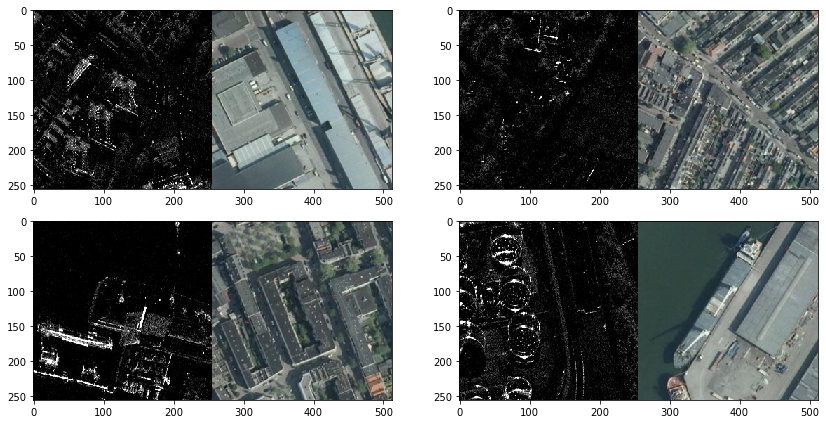

In [9]:
data.show_batch(rows=5)

### Load model architecture

In [10]:
model = CycleGAN(data)

### Find an optimal learning rate

[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. ArcGIS API for Python provides a learning rate finder that automatically chooses the optimal learning rate for you.

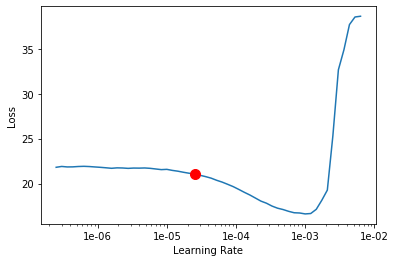

2.5118864315095795e-05

In [11]:
lr = model.lr_find()

### Fit the model 

We will train the model for a few epochs with the learning rate we have found. For the sake of time, we can start with 25 epochs.

In [7]:
model.fit(25, lr=lr)

epoch,train_loss,valid_loss,id_loss,gen_loss,cyc_loss,D_A_loss,D_B_loss,time
0,5.317568,5.336852,1.550138,0.720733,3.046698,0.197484,0.222046,14:07
1,4.908140,6.136398,1.340261,0.861988,2.705891,0.741538,0.336392,13:25
2,4.412481,6.278461,1.163109,0.792766,2.456607,0.378034,1.073672,13:12
3,4.182445,5.562617,1.068715,0.757754,2.355975,0.337290,0.837495,13:05
4,3.957423,8.413357,0.987927,0.762105,2.207391,1.589632,0.346265,12:59
5,3.947841,7.707170,0.948394,0.789307,2.210140,1.373522,0.279166,12:57
6,3.989404,4.538482,0.926119,0.914255,2.149030,0.349952,0.396675,12:58
7,3.877221,4.926952,0.904841,0.927214,2.045167,0.197091,0.258876,12:57
8,3.626200,8.130665,0.815586,0.895576,1.915039,0.562384,0.816195,12:55
9,3.548248,5.545265,0.804024,0.842509,1.901715,0.836604,0.434236,12:51


Here, with 25 epochs, we can see reasonable results — both training and validation losses have gone down considerably, indicating that the model is learning to translate SAR imagery to RGB and vice versa.

### Visualize results in validation set

It is a good practice to see results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model within the notebook.

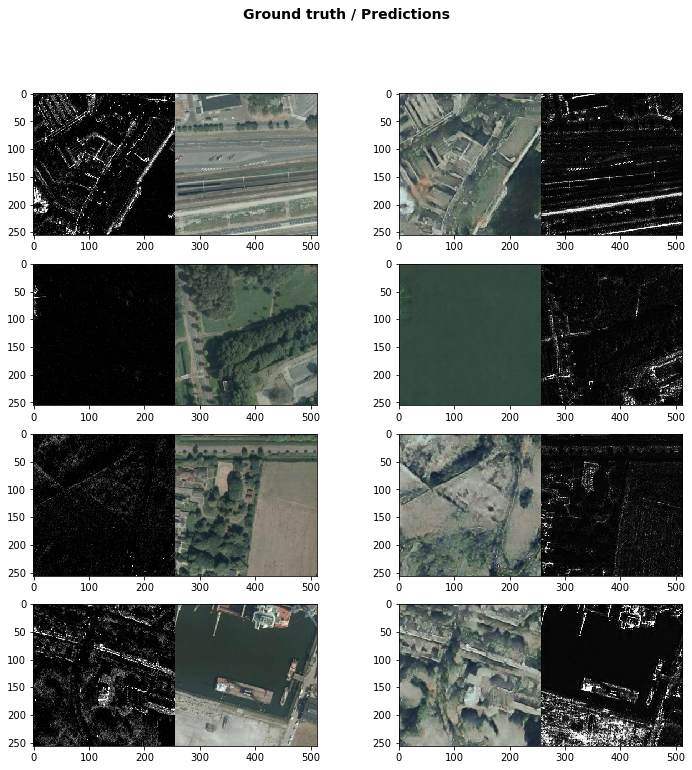

In [10]:
model.show_results()

### Save the model

We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [13]:
model.save("SAR_to_RGB_25e", publish=True)    

WindowsPath('D:/CycleGAN/Data/data_for_cyclegan_le_3Bands/models/SAR_to_RGB_25e')

## Model inference

We can translate SAR imagery to RGB and vice versa with the help of `predict()` method.

Using predict function, we can apply the trained model on the image which we want to translate.
- `img_path`: path to the image file.
- `convert_to`: 'a' or 'b' type of fake image we want to generate.

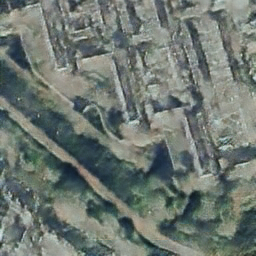

In [12]:
#un-comment the cell to run predict over your desired image.
# model.predict(r"D:\CycleGAN\Data\data_for_cyclegan_le_3Bands\Images\train_a\000000005.jpg", convert_to="b")

In the above step, we are translating an image of `type a` i.e. SAR imagery to an image of `type b` i.e. RGB imagery. We can also perform `type b` to `type a` translation by changing the image file and `convert_to` parameter.

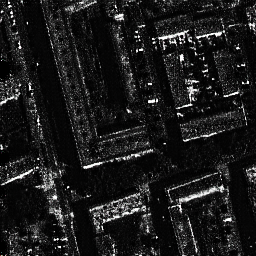

In [14]:
#un-comment the cell to run predict over your desired image.
# model.predict(r"D:\CycleGAN\Data\data_for_cyclegan_le_3Bands\Images\train_b\000000008.jpg", convert_to="a")

## Conclusion 

In this notebook, we demonstrated how to use `CycleGAN` model using `ArcGIS API for Python` in order to translate imagery of one type to the other.

## References 

[1] Jun-Yan Zhu, Taesung Park, Phillip Isola, Alexei A. Efros: Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks; https://arxiv.org/abs/1703.10593.